# Imports\


TODO:
1) check value/vat/no vat
2) check headlines, fix it


In [1]:
# !export GPN_DB_HOST=192.168.10.36


In [2]:
#!ls -la ../../work
# #!mv ../../../documents.json.zip ../../work
# # !unzip '../../work/documents.json.zip' '../../work/documents.json'
# !mv documents.json ../../work

In [3]:
IMPORT_FRESH_ONLY = True # re-import all if False

In [4]:
import logging
import platform
import sys
import os
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from datetime import datetime
import tensorflow as tf

logger = logging.getLogger('retrain_ipynb')
logger.setLevel(logging.DEBUG)


ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(levelname)s - %(asctime)s - %(name)s - %(message)s')
ch.setFormatter(formatter)
logger.addHandler(ch)
logger.debug('--=logging started=--')

print("tf",tf.__version__)
CPU = platform.processor()
print (f'Running on CPU:{CPU}')



2023-03-11 12:41:48.666691: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
DEBUG - 2023-03-11 12:41:49,264 - retrain_ipynb - --=logging started=--


tf 2.5.0
Running on CPU:x86_64


In [5]:
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
    
import analyser.hyperparams 

Nemoware Analyser v23.3.11
USING WORKDIR: [/root/artem/work]
 set ENV GPN_WORK_DIR to override
datasets_dir: [/root/artem/work/datasets]
reports_dir: [/root/artem/work/reports]


/root/artem/analyser/analyser/hyperparams.py:15: UserWarning: please set GPN_WORK_DIR environment variable
  warnings.warn('please set GPN_WORK_DIR environment variable')



### Imports...

In [6]:
%matplotlib inline

import pandas as pd
import numpy as np
from pandas import DataFrame

from analyser.finalizer import get_doc_by_id
from analyser.persistence import DbJsonDoc
from integration.db import get_mongodb_connection

from datetime import datetime
from math import log1p
from pandas import DataFrame
from analyser.persistence import DbJsonDoc
from colab_support.renderer import plot_embedding

from analyser.structures import DocumentState

from pathlib import Path
from bson import ObjectId

from datetime import date
from dateutil.relativedelta import relativedelta


from pymongo import ASCENDING

# from tf_support.super_contract_model import seq_labels_contract, seq_labels_contract_swap_orgs
# 


[documents.py:270 -             __init__() ] loading word cases stats model from: /root/artem/analyser/analyser/vocab/word_cases_stats.pickle
[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_USER environment variable! defaulting to None
[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_PASSWORD environment variable! defaulting to None
[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_URL environment variable! defaulting to None


HyperParameters.subsidiary_name_match_min_jaro_similarity 0.9649122807017544


[tools.py:29 -             __init__() ] model_checkpoint_path: /root/artem/analyser/analyser/vocab


In [7]:
import mlflow
 

ml_flow_url = os.environ.get('MLFLOW_URL', "http://192.168.10.38:5000")
mlflow.set_tracking_uri(ml_flow_url)
print(f'{ml_flow_url=}', 'set MLFLOW_URL env var to re-define')
mlflow.set_experiment("analyzer-export-ts")
 
            
# experiment_id = mlflow.create_experiment(
#     "Fetching training set from DB",
# #     tags={"version": "v1", "priority": "P1"},
# )                 
# experiment_id

ml_flow_url='http://192.168.10.38:5000' set MLFLOW_URL env var to re-define


<Experiment: artifact_location='mlflow-artifacts:/128037815992979647', creation_time=1677851770239, experiment_id='128037815992979647', last_update_time=1677851770239, lifecycle_stage='active', name='analyzer-export-ts', tags={}>

### Prepare workdir

In [8]:
_work_dir_default = Path(analyser.hyperparams.__file__).parent.parent.parent / 'work'
work_dir = os.environ.get('GPN_WORK_DIR', _work_dir_default)

if not os.path.isdir(work_dir):
    os.mkdir(work_dir)

analyser.hyperparams.work_dir = work_dir
reports_path = Path(analyser.hyperparams.__file__).parent.parent / 'training_reports/'

print('work_dir=', analyser.hyperparams.work_dir)
print('reports_path=', reports_path)
assert os.path.isdir(analyser.hyperparams.work_dir)

work_dir= /root/artem/work
reports_path= /root/artem/analyser/training_reports


### Query DB for contact IDs

#### Load meta data CSV

In [9]:
!touch /root/artem/work/contract_trainset_meta.temp.csv

In [10]:
# stats[["user_correction_date", 'analyze_date']].max().max()

In [11]:
export_fn = str(Path(work_dir) / 'contract_trainset_meta.temp.csv')
# stats = pd.read_csv(export_fn, index_col=0)
mlflow.log_param('metafile',  export_fn)
try:
    stats = pd.read_csv(export_fn, index_col=0)
    if not 'analyze_date' in stats:
        stats['analyze_date'] = None
        
    if not 'documentType' in stats:
        stats['documentType'] = 'Unknown'
    
    stats['user_correction_date'] = pd.to_datetime(stats['user_correction_date'], utc=True)
    stats['analyze_date'] = pd.to_datetime(stats['analyze_date'], utc=True)

    lastdate = stats[["user_correction_date", 'analyze_date']].max().max()
    
    mlflow.log_param('last_doc_export_date',  lastdate)
    mlflow.log_metric('docs_in_metafile_start',  len(stats))
    
except Exception as ex:
    print(f'ERROR: cannot load {export_fn}')
    logger.exception(ex)
    logger.error(f'cannot load {export_fn}')

    lastdate = datetime(1900, 1, 1)
    stats = DataFrame()
    
    
if not IMPORT_FRESH_ONLY:
    lastdate = datetime(1900, 1, 1)
    
print(f'lastdate={lastdate} ; export_fn={export_fn}')
stats['source'] = 'db'
stats

lastdate=2023-03-01 16:36:11.013000+00:00 ; export_fn=/root/artem/work/contract_trainset_meta.temp.csv


,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,subject,subject confidence,user_correction_date,valid,documentType,subj_len,headers,subject_pos,org-1-type,org-2-type
5ec2b8da665f7603e03b1255,db,3187bfac60ea578221c5d9357756c6c1,1.6.5,2023-03-02 18:16:30.799761,5847.0,2020-05-18 17:16:38.114000+00:00,2.523632e+07,17.043795,5674.0,BRL,...,Service,1.0,2023-02-06 10:57:02.292000+00:00,True,CONTRACT,79.0,4.0,1444.0,Общество с ограниченной ответственностью,компания
5fb376e2d8c9df1ed123726c,db,f7c027bb799a50d6fda9d32443bb9cdd,2.0.5,2023-03-02 18:16:30.856094,2794.0,2020-11-17 07:11:23.321000+00:00,2.970000e+03,7.996654,1364.0,RUB,...,Deal,1.0,2022-12-08 12:28:06.617000+00:00,True,CONTRACT,82.0,17.0,158.0,Бюджетное учреждение культуры,Общество с ограниченной ответственностью
5fb399dc39d5e82e90818474,db,375f811ae7c0edcc737d7342373710cb,2.0.5,2023-03-02 18:16:30.870815,3742.0,2020-11-17 09:56:11.605000+00:00,9.000000e+04,11.407576,1834.0,RUB,...,Renting,1.0,2022-12-07 08:14:03.960000+00:00,True,CONTRACT,97.0,13.0,121.0,Общество с ограниченной ответственностью,Некоммерческая унитарная организация
5fb3b97d00881c332b567292,db,5f4482e55f27e0fcb20b1ffd819d0260,2.0.5,2023-03-02 18:16:30.878077,2248.0,2020-11-17 12:01:39.924000+00:00,NaN,NaN,NaN,NaN,...,AgencyContract,1.0,2022-12-08 11:25:15.676000+00:00,True,CONTRACT,86.0,15.0,334.0,ООО,Общество с ограниченной ответственностью
5fb3b97e00881c332b5672bd,db,eb69b91855f471b6db8deb924eb34aa5,2.0.5,2023-03-02 18:16:30.890334,3546.0,2020-11-17 12:12:00.629000+00:00,1.548241e+07,16.555215,699.0,RUB,...,AgencyContract,1.0,2022-12-08 19:01:33.745000+00:00,True,CONTRACT,55.0,19.0,353.0,Общество с ограниченной ответственностью,Общество с ограниченной ответственностью
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5feb3e51bd24992aa3104108,db,a2a8b1642cf17567677b5c1d1015401b,2.3.14,2023-03-02 18:17:56.823023,14657.0,2020-12-29 17:34:05.506000+00:00,3.009000e+05,12.614537,1162.0,RUB,...,Insurance,1.0,2020-12-29 15:00:07.153000+00:00,True,CONTRACT,106.0,94.0,702.0,Общество с ограниченной ответственностью,Акционерное общество
5feb3e51bd24992aa3104122,db,ac8bae085299c3b9775e16489d7de24b,2.3.14,2023-03-02 18:17:57.058101,16277.0,2020-12-29 17:34:08.299000+00:00,7.000000e+09,22.669176,3045.0,RUB,...,GeneralContract,1.0,2020-12-29 15:04:28.271000+00:00,True,CONTRACT,69.0,34.0,2624.0,Общество с ограниченной ответственностью,ПАО
5feb3e50bd24992aa31040e1,db,874c75c5492a542cca8468ab78a13be9,2.3.14,2023-03-02 18:17:57.063210,1238.0,2020-12-29 17:35:01.616000+00:00,5.550000e+04,10.924156,196.0,RUB,...,GeneralContract,1.0,2020-12-29 14:44:06.461000+00:00,True,CONTRACT,71.0,11.0,90.0,Общество с ограниченной ответственностью,Общество с ограниченной ответственностью
5feb3e50bd24992aa31040e6,db,28c1365dd99c3e2afe1f2880101270a5,2.3.14,2023-03-02 18:17:57.072386,2675.0,2020-12-29 17:35:02.721000+00:00,1.900000e+08,19.062535,419.0,RUB,...,ParticipationInOtherOrganizations,1.0,2020-12-29 14:52:27.382000+00:00,True,CONTRACT,83.0,7.0,318.0,Общество с ограниченной ответственностью,Публичное акционерное общество


In [12]:
 
display(Markdown(f"#### {lastdate:%d.%m.%Y} -- дата последнего экспортированного документа"))


#### 01.03.2023 -- дата последнего экспортированного документа

# functions

In [13]:

def get_amount(attr_tree):
  _value_tag = attr_tree.get('price')
  amount = None
  if _value_tag is not None:
    amount = _value_tag.get('amount_netto')
    if amount is None:
      amount = _value_tag.get('amount_brutto')
    if amount is None:
      amount = _value_tag.get('amount')
  return amount

        
    
def add_stats_record(d: DbJsonDoc, stats: DataFrame, source='db'):
  _id = str(d.get_id())
    
  attr_tree = d.get_attributes_tree()
 

  stats.at[_id, 'checksum'] = d.get_tokens_for_embedding().get_checksum()
  stats.at[_id, 'version'] = d.get_version_string()
  stats.at[_id, 'documentType'] = d.documentType
    
 
  stats.at[_id, 'source'] = source
  stats.at[_id, 'export_date'] = datetime.now()
  stats.at[_id, 'len'] = len(d)
  stats.at[_id, 'analyze_date'] = pd.to_datetime( d.analysis['analyze_timestamp'] , utc=True)


  n_headers = len(d.analysis.get('headers', []))
  stats.at[_id, 'headers'] = n_headers
    
  _value_tag = attr_tree.get('price')
  
  stats.at[_id, 'value'] = None
  stats.at[_id, 'value_log1p'] = None
  stats.at[_id, 'value_span'] = None
  stats.at[_id, 'currency'] = None
    
  if _value_tag is not None:
    amount = get_amount(attr_tree) 
    if amount:
        
        stats.at[_id, 'value'] = amount.get('value') 
        stats.at[_id, 'value_log1p'] = log1p(amount.get('value') )
        stats.at[_id, 'value_span'] = amount.get('span', [0,0]) [0]
    
#         print( stats.at[_id, 'value'])
    
    stats.at[_id, 'currency'] = _value_tag.get('currency', {}).get('value')
  
  _orgs = attr_tree.get('orgs', [{},{}]) 
  if len(_orgs)>0:
      stats.at[_id, 'org-1-name'] = _orgs[0].get('name', {}).get('value')
      stats.at[_id, 'org-1-alias'] = _orgs[0].get('alias', {}).get('value')
      stats.at[_id, 'org-1-type'] = _orgs[0].get('type', {}).get('value')

      if len(_orgs)>1:
        stats.at[_id, 'org-2-name'] = _orgs[1].get('name', {}).get('value')
        stats.at[_id, 'org-2-alias'] = _orgs[1].get('alias', {}).get('value')
        stats.at[_id, 'org-2-type'] = _orgs[1].get('type', {}).get('value')

  stats.at[_id, 'subject'] = attr_tree.get('subject', {}).get('value')
  stats.at[_id, 'subject confidence'] = attr_tree.get('subject', {}).get('confidence')
    

  span = attr_tree.get('subject', {}).get('span',[0,0])
  subject_len = span[1] - span[0]
  stats.at[_id, 'subj_len'] = subject_len  

  stats.at[_id, 'user_correction_date'] = None
  if d.user is not None:
    # if 'attributes_tree' in d.user and 'creation_date' in d.user['attributes_tree']:
    # stats.at[_id, 'user_correction_date'] = d.user['attributes_tree']['creation_date']
    stats.at[_id, 'user_correction_date'] = pd.to_datetime(d.user[ 'updateDate'], utc=True)

    

    # find_in_dict('attributes_tree.creation_date', d.user)

  valid_state = (DocumentState.Excluded.value==d.state or DocumentState.Done.value==d.state)
  if not valid_state:
    print(_id, 'invalid state: ', d.state)
  valid_struct = ('contract' in jd.analysis['attributes_tree'])
  if not valid_struct:
    print(_id, 'invalid structure: ', d.state)
  stats.at[_id, 'valid'] = valid_state and valid_struct and subject_len>0 and subject_len<=300 and n_headers>0


  


d = get_doc_by_id(ObjectId('5fe34f62b770574a005553be'))
jd = DbJsonDoc(d)
add_stats_record(jd, stats)
stats.loc['5fe34f62b770574a005553be']

DB HOST IS: 192.168.10.36


/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_PORT environment variable! defaulting to 27017
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_USER environment variable! defaulting to None
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_PASSWORD environment variable! defaulting to None
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_USE_MONGO_TLS environment variable! defaulting to False
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_TLS_CA environment variable! defaulting to None
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_TLS_KEY environment varia

source                                                        db
checksum                        da2dd54cdcc5b4480207c9def7741d14
version                                                   2.3.13
export_date                           2023-03-11 12:41:51.613414
len                                                          759
analyze_date                    2020-12-23 17:14:16.727000+00:00
value                                                   1.64e+06
value_log1p                                              14.3102
value_span                                                   128
currency                                                     RUB
org-1-name                                Газпромнефть-Снабжение
org-1-alias                                       Благотворитель
org-2-name                                   инициатив «Эпсилон»
org-2-alias                                      Благополучатель
subject                                                  Charity
subject confidence       

# load old json

In [14]:
import json
import re
from bson import json_util

_DEBUG = False
file_data=None

try:
    fn = work_dir / 'documents.json'
    with open(fn) as file:
        file_data = json.load(file, object_hook=json_util.object_hook)

        print(f'total docs in {fn} is {len(file_data)}')    
        _DEBUG = True
except Exception as ex:
    logger.exception(ex)    




if _DEBUG:
    a_doc_from_json=DbJsonDoc(file_data[3])

    print(a_doc_from_json.get_attributes_tree())
    print(a_doc_from_json.get_version_string())

total docs in /root/artem/work/documents.json is 622
{'orgs': [{'type': {'span': [47, 48], 'span_map': 'words', 'confidence': 0.49801500000000004, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [49, 50], 'span_map': 'words', 'confidence': 0.9755, 'value': 'Газпромнефть-Сахалин'}, 'alias': {'span': [56, 57], 'span_map': 'words', 'confidence': 0.972, 'value': 'Арендатор'}}, {'type': {'span': [17, 18], 'span_map': 'words', 'confidence': 0.505665, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [19, 20], 'span_map': 'words', 'confidence': 0.9905, 'value': 'ЭКРУСС'}, 'alias': {'span': [26, 27], 'span_map': 'words', 'confidence': 0.987, 'value': 'Арендодатель'}}], 'date': {'span': [9, 14], 'span_map': 'words', 'confidence': 1, 'value': datetime.datetime(2016, 5, 10, 0, 0, tzinfo=<bson.tz_util.FixedOffset object at 0x7fb3909e0c10>)}, 'number': {'span': [1, 4], 'span_map': 'words', 'confidence': 1, 'value': 'RP 16-06'}, 'subject': {'span': [100, 1

semantic_map_keys_contract ['headline-begin', 'headline-end', 'subject-begin', 'subject-end', 'date-begin', 'date-end', 'number-begin', 'number-end', 'org-name-begin', 'org-name-end', 'org-alias-begin', 'org-alias-end', 'org-type-begin', 'org-type-end', 'amount-begin', 'amount-end', 'amount_brutto-begin', 'amount_brutto-end', 'amount_netto-begin', 'amount_netto-end', 'vat-begin', 'vat-end', 'sign-begin', 'sign-end', 'currency-begin', 'currency-end', 'vat_unit-begin', 'vat_unit-end', 'value-begin', 'value-end']


fixed number: ['№ RP 16-06'] -->  ['RP 16-06']


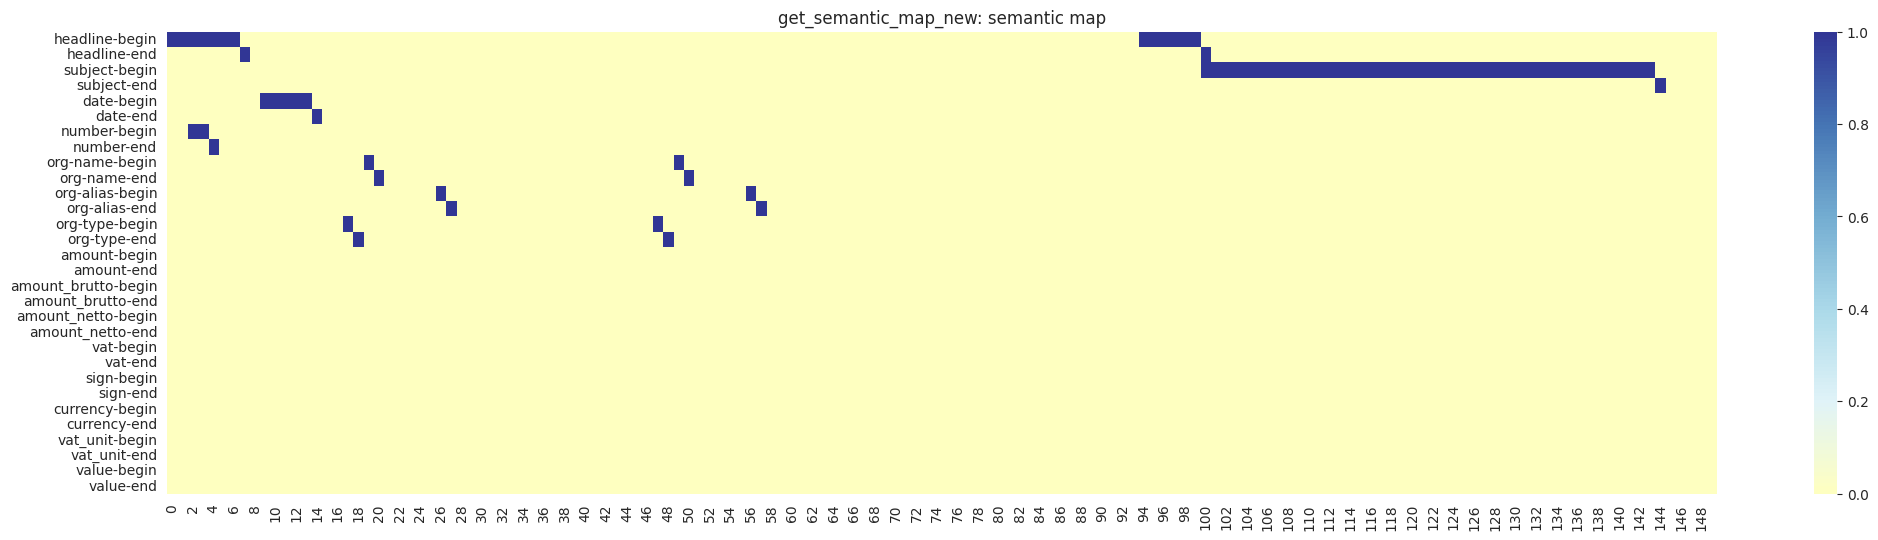

1.0
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
3148    0.0
3149    0.0
3150    0.0
3151    0.0
3152    0.0
Name: date-begin, Length: 3153, dtype: float64


In [15]:

# TODO: import!!!

from tf_support.super_contract_model import get_semantic_map_new, \
        semantic_map_keys_contract, t_semantic_map_keys_common, t_semantic_map_keys_org, t_semantic_map_keys_price

# print("semantic_map_keys", semantic_map_keys[8:14])
# print("semantic_map_keys", semantic_map_keys[4:7])
# print("semantic_map_keys all", semantic_map_keys)
print("semantic_map_keys_contract", semantic_map_keys_contract)

print()
print()




# del get_semantic_map_new




if _DEBUG:
    sm_test = get_semantic_map_new(a_doc_from_json)
    plot_embedding(sm_test[0:150], f'get_semantic_map_new: semantic map')
    print(sm_test['date-begin'].max())
    print(sm_test['date-begin'])

In [16]:
# len(sm_test)
# trimmed = sm_test[0:1200].values.T.copy()

In [17]:
# semantic_map_keys[4:7]
# position_enc = np.arange( 1,0, -0.0005)
# # position_enc
# max_pos = min(len(trimmed), len(position_enc))
# trimmed[0:max_pos][-1] = position_enc[0:max_pos]
# plot_embedding(trimmed , f'get_semantic_map_new: semantic map')

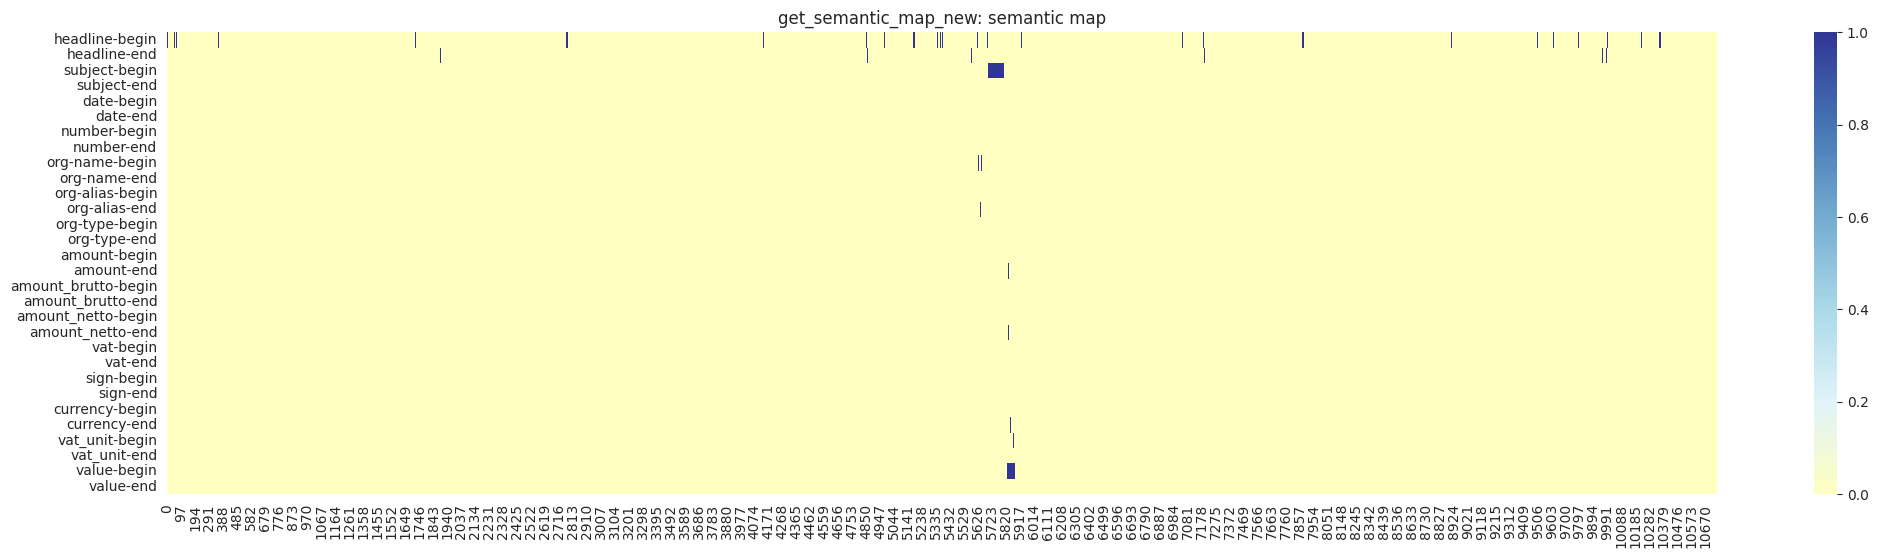

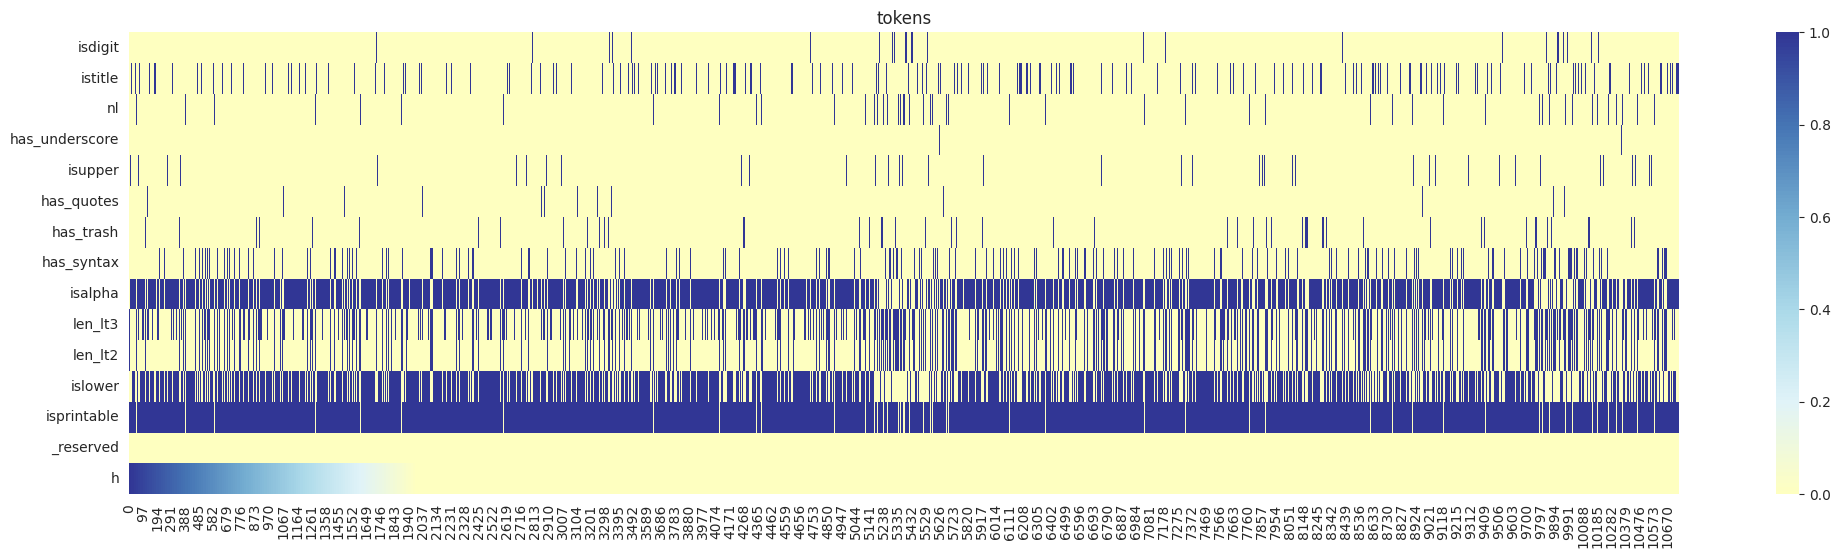

In [18]:
#test one
from analyser.headers_detector import get_tokens_features

d = get_doc_by_id(ObjectId('636dfd1473925c8dae26f910'))
if d is not None:
    jd = DbJsonDoc(d)
    semantic_map: DataFrame = get_semantic_map_new(jd)

    tokens_features = get_tokens_features(jd.get_tokens_map_unchaged().tokens)

    plot_embedding(semantic_map, f'get_semantic_map_new: semantic map')
    plot_embedding(tokens_features, f'tokens')

In [19]:
tokens_features

,isdigit,istitle,nl,has_underscore,isupper,has_quotes,has_trash,has_syntax,isalpha,len_lt3,len_lt2,islower,isprintable,_reserved,h
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0000
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.9995
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.9990
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.9985
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.9980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10747,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0000
10748,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0000
10749,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0000
10750,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0000


### Adding data from old json file to the stats table

In [20]:
# fff
files_dict = {}
files_cnt = 0
if file_data:
    k=0
    for d in file_data:
        k+=1 
        jd = DbJsonDoc(d)
    #     print( jd.analysis['analyze_timestamp'])
        files_dict[jd.get_id()] = jd
        try:            
            add_stats_record(jd, stats, source = 'file')
            files_cnt+=1
        except Exception as e:
            print(e)
            print(jd.get_id())
#             raise (e)

        if k % 100 == 0:
#             stats['user_correction_date'] = pd.to_datetime(stats['user_correction_date'], utc=False)
#             stats['analyze_date'] = pd.to_datetime(stats['analyze_date'], utc=False)
#             stats['export_date'] = pd.to_datetime(stats['export_date'], utc=False)
            
    
            print(f'{k} of {len(file_data)}')
            stats.to_csv(export_fn, index=True)
            print(f'stats saved to {export_fn}')

            
mlflow.log_param('files_in_json',  files_cnt)            
stats.to_csv(export_fn, index=True)
# stats.to_csv('tmp.csv', index=True)

print(f'stats saved to {export_fn}')

# del file_data
stats




100 of 622
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
200 of 622
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
300 of 622
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
400 of 622
stats saved to /root/artem/work/contract_trainset_meta.temp.csv

5efdb73b777d4b67a92d533c
500 of 622
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
600 of 622
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
stats saved to /root/artem/work/contract_trainset_meta.temp.csv


,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,subject,subject confidence,user_correction_date,valid,documentType,subj_len,headers,subject_pos,org-1-type,org-2-type
5ec2b8da665f7603e03b1255,db,3187bfac60ea578221c5d9357756c6c1,1.6.5,2023-03-02 18:16:30.799761,5847.0,2020-05-18 17:16:38.114000+00:00,25236322.0,17.043795,5674.0,BRL,...,Service,1.0,2023-02-06 10:57:02.292000+00:00,True,CONTRACT,79.0,4.0,1444.0,Общество с ограниченной ответственностью,компания
5fb376e2d8c9df1ed123726c,db,f7c027bb799a50d6fda9d32443bb9cdd,2.0.5,2023-03-02 18:16:30.856094,2794.0,2020-11-17 07:11:23.321000+00:00,2970.0,7.996654,1364.0,RUB,...,Deal,1.0,2022-12-08 12:28:06.617000+00:00,True,CONTRACT,82.0,17.0,158.0,Бюджетное учреждение культуры,Общество с ограниченной ответственностью
5fb399dc39d5e82e90818474,db,375f811ae7c0edcc737d7342373710cb,2.0.5,2023-03-02 18:16:30.870815,3742.0,2020-11-17 09:56:11.605000+00:00,90000.0,11.407576,1834.0,RUB,...,Renting,1.0,2022-12-07 08:14:03.960000+00:00,True,CONTRACT,97.0,13.0,121.0,Общество с ограниченной ответственностью,Некоммерческая унитарная организация
5fb3b97d00881c332b567292,db,5f4482e55f27e0fcb20b1ffd819d0260,2.0.5,2023-03-02 18:16:30.878077,2248.0,2020-11-17 12:01:39.924000+00:00,NaN,NaN,NaN,NaN,...,AgencyContract,1.0,2022-12-08 11:25:15.676000+00:00,True,CONTRACT,86.0,15.0,334.0,ООО,Общество с ограниченной ответственностью
5fb3b97e00881c332b5672bd,db,eb69b91855f471b6db8deb924eb34aa5,2.0.5,2023-03-02 18:16:30.890334,3546.0,2020-11-17 12:12:00.629000+00:00,15482412.0,16.555215,699.0,RUB,...,AgencyContract,1.0,2022-12-08 19:01:33.745000+00:00,True,CONTRACT,55.0,19.0,353.0,Общество с ограниченной ответственностью,Общество с ограниченной ответственностью
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5ee188952281f29204c522dc,file,520bf70b9df1ee9ee999fe870d936a51,1.11.2,2023-03-11 12:42:08.037642,7298.0,2020-06-12 22:43:06.038000+00:00,NaN,NaN,NaN,None,...,None,NaN,2020-06-11 08:49:53.635000+00:00,False,CONTRACT,0.0,4.0,NaN,NaN,NaN
5efe9252777d4b67a92d5621,file,ed9385088ed6d9c967a9b68a8d10ecc2,2.0.0,2023-03-11 12:42:16.177622,19504.0,2020-07-03 16:50:25.668000+00:00,65300168.0,17.994505,7412.0,RUB,...,None,NaN,NaT,False,CONTRACT,0.0,26.0,NaN,Общество с ограниченной ответственностью,None
5efe9280777d4b67a92d56ce,file,02a4101c17ceaa4b9d473f6840ac4d7a,2.0.0,2023-03-11 12:42:17.353302,14025.0,2020-07-03 21:47:22.279000+00:00,NaN,NaN,NaN,None,...,None,NaN,NaT,False,CONTRACT,0.0,2.0,NaN,NaN,NaN
5efe9288777d4b67a92d56d3,file,33f326573547c95e1d381eecd79136a2,2.0.0,2023-03-11 12:42:17.620696,19219.0,2020-07-03 21:15:51.170000+00:00,NaN,NaN,NaN,None,...,None,NaN,NaT,False,CONTRACT,0.0,25.0,NaN,Общество с ограниченной ответственностью,Общество с ограниченной ответственностью


In [21]:
# stats = stats.drop('63c506afe2456d59975e0fcd')
stats[stats.index.duplicated()]



,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,subject,subject confidence,user_correction_date,valid,documentType,subj_len,headers,subject_pos,org-1-type,org-2-type


In [22]:
invalid = stats[stats['valid']==False]
print(f'{len(invalid)}: number of invalid records')
mlflow.log_metric('invalid records',  len(invalid))     
invalid

18: number of invalid records


,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,subject,subject confidence,user_correction_date,valid,documentType,subj_len,headers,subject_pos,org-1-type,org-2-type
63c506b8e2456d59975e109c,db,4a7d02af0bd9445f83d53b228f6a5a2d,23.3.1,2023-03-02 18:17:34.447480,1137.0,2023-03-01 16:34:57.959000+00:00,1.00,0.693147,1013.0,RUB,...,Deal,1.000000,NaT,False,CONTRACT,33.0,12.0,101.0,Общество с ограниченной ответственностью,Общество с ограниченной ответственностью
63c506b8e2456d59975e109e,db,3323deef0bec838bb0ec0bdd4a50e227,23.3.1,2023-03-02 18:17:51.046970,14348.0,2023-03-01 16:34:59.208000+00:00,3736.37,8.226137,2796.0,RUB,...,GeneralContract,0.999999,NaT,False,CONTRACT,24.0,37.0,2476.0,Общество с ограниченной ответственностью,Общество с ограниченной ответственностью
63c506dce2456d59975e1456,db,05096ac6cb6649e98b2f6b72bfb97df3,23.3.1,2023-03-02 18:17:52.658826,4650.0,2023-03-01 16:36:02.862000+00:00,NaN,NaN,NaN,NaN,...,Service,0.999747,NaT,False,CONTRACT,21.0,19.0,193.0,Акционерное общество,Акционерное общество
5ded07184ddc27bcf92dd52a,file,942c7cdeefd0f13d75bd1298a268fd86,1.12.0,2023-03-11 12:42:00.298900,1899.0,2020-06-16 19:05:20.083000+00:00,NaN,NaN,NaN,None,...,None,NaN,2020-06-06 07:36:28.167000+00:00,False,CONTRACT,0.0,14.0,NaN,Общество с ограниченной ответственностью,Публичное акционерное общество
5ee188882281f29204c52293,file,0c9257578f5a5317ce2fb75a722b112f,1.11.2,2023-03-11 12:42:07.971949,419.0,2020-06-12 22:36:30.039000+00:00,NaN,NaN,NaN,None,...,None,NaN,2020-06-11 08:47:15.143000+00:00,False,CONTRACT,0.0,9.0,NaN,NaN,NaN
5ee188892281f29204c52297,file,e7069a417801ba0bd645c46552fb9a0e,1.11.2,2023-03-11 12:42:07.974199,413.0,2020-06-12 22:36:35.699000+00:00,NaN,NaN,NaN,None,...,None,NaN,2020-06-11 08:48:23.187000+00:00,False,CONTRACT,0.0,9.0,NaN,NaN,NaN
5ee188892281f29204c5229c,file,1c438e75302a679dfed4751219508463,1.11.2,2023-03-11 12:42:07.976439,419.0,2020-06-12 22:36:41.730000+00:00,NaN,NaN,NaN,None,...,None,NaN,2020-06-11 08:48:02.860000+00:00,False,CONTRACT,0.0,9.0,NaN,NaN,NaN
5ee188892281f29204c5229d,file,3fcece231096be2f8640a6fb97d681c7,1.11.2,2023-03-11 12:42:07.978670,416.0,2020-06-12 22:36:47.363000+00:00,NaN,NaN,NaN,None,...,None,NaN,2020-06-11 08:46:58.837000+00:00,False,CONTRACT,0.0,9.0,NaN,NaN,NaN
5ee188892281f29204c522a0,file,5768718d20b1a818fc35a0daa3918c55,1.11.2,2023-03-11 12:42:07.982767,1382.0,2020-06-12 22:37:04.897000+00:00,NaN,NaN,NaN,None,...,None,NaN,2020-06-11 08:48:42.381000+00:00,False,CONTRACT,0.0,3.0,NaN,NaN,NaN
5ee1888a2281f29204c522a5,file,c50c5b6a442127b7898c122e913c90e8,1.11.2,2023-03-11 12:42:07.986627,1286.0,2020-06-12 22:37:21.034000+00:00,NaN,NaN,NaN,None,...,None,NaN,2020-06-11 08:50:49.163000+00:00,False,CONTRACT,0.0,5.0,NaN,NaN,NaN


In [23]:
# !tail /root/artem/work/contract_trainset_meta.temp.csv

# Fetch fresh docs from Mongo DB

In [24]:

# from datetime import timedelta
# if True:

lastdate  += relativedelta(days=-15)  
# lastdate = datetime.combine(lastdate, datetime.min.time())
# lastdate = pd.to_datetime( lastdate , utc=True)
lastdate

Timestamp('2023-02-14 16:36:11.013000+0000', tz='UTC')

In [25]:
report_date = datetime.now() + relativedelta(days=-2)  
report_date

datetime.datetime(2023, 3, 9, 12, 42, 20, 841337)

In [26]:
yesterday = datetime.now() + relativedelta(days=-1)  
# {'analysis.analyze_timestamp': {'$gt': yesterday}},



query = {'user.updateDate': {'$gt': report_date}}
db = get_mongodb_connection()
documents_collection = db['documents']
sorting = [('analysis.analyze_timestamp', ASCENDING), ('user.updateDate', ASCENDING)]
res = documents_collection.find(filter=query, 
                                sort=sorting,
                                projection={'_id': True, 'user.updateDate':True, 'state':True, 'parse.documentType':True}
                               ).limit(5000)

_r = list([i for i in res])
# print(res[0])
_s = f"#### {len(_r)} -- всего размечено документов после {report_date:%d.%m.%Y}"
mlflow.log_metric('fresh_user_docs_in_db',  len(_r))     
display(Markdown(_s))
yseterday_ids=[i["_id"] for i in _r]


/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)


#### 5 -- всего размечено документов после 09.03.2023

In [27]:
from pymongo import ASCENDING

query = {
  '$and': [
    {"parse.documentType":{ '$in': ["AGREEMENT", "CONTRACT", "SUPPLEMENTARY_AGREEMENT"] }  },
      
#     {"state": 15},
    {'$or': [
          {"analysis.attributes_tree": {"$ne": None}},
          {"user.attributes_tree": {"$ne": None}}
        ]},
#       {'$and': [
#           {"user.updateDate": {"$ne": None}},
#           {'user.updateDate': {'$gt': lastdate}}
#       ]}
#     {"user.attributes_tree.contract.people": {"$ne": None}}

    #     {'$or': [
    #         {"user.attributes_tree.contract.price.amount_netto": {"$ne": None}},
    #         {"user.attributes_tree.contract.price.amount_brutto": {"$ne": None}}
    #     ]}
    {'$or': [
      {'analysis.analyze_timestamp': {'$gt': lastdate}}, 
      {'user.updateDate': {'$gt': lastdate}}
    ]}
  ]
}

db = get_mongodb_connection()
documents_collection = db['documents']
sorting = [('analysis.analyze_timestamp', ASCENDING), ('user.updateDate', ASCENDING)]
res = documents_collection.find(filter=query, 
                                sort=sorting,
                                projection={'_id': True, 'user.updateDate':True, 'state':True, 'parse.documentType':True}
#                                             'analysis.attributes_tree.version': True,
#                                             'analysis.attributes_tree.contract.subject': True}
                               ).limit(5000)

res = list([i for i in res])
mlflow.log_metric('fresh_docs_in_db',  len(res))     
# print(res[0])
_s = f"#### {len(res)} -- всего проанализировано новых документов после {lastdate:%d.%m.%Y}"
display(Markdown(_s))

res[:4]

#### 449 -- всего проанализировано новых документов после 14.02.2023

[{'_id': ObjectId('5e2ea6ca73698e191112bee8'),
  'parse': {'documentType': 'CONTRACT'},
  'state': 15,
  'user': {'updateDate': datetime.datetime(2023, 3, 3, 6, 53, 47, 400000)}},
 {'_id': ObjectId('5ec2b8d8665f7603e03b121c'),
  'parse': {'documentType': 'CONTRACT'},
  'state': 12,
  'user': {'updateDate': datetime.datetime(2023, 3, 3, 6, 52, 26, 474000)}},
 {'_id': ObjectId('5ec2b8da665f7603e03b1265'),
  'parse': {'documentType': 'CONTRACT'},
  'state': 12,
  'user': {'updateDate': datetime.datetime(2023, 3, 3, 6, 39, 26, 767000)}},
 {'_id': ObjectId('5ec2b8da665f7603e03b126a'),
  'parse': {'documentType': 'CONTRACT'},
  'state': 12,
  'user': {'updateDate': datetime.datetime(2023, 3, 3, 9, 51, 15, 614000)}}]

# Prepare training set

In [28]:
new_docs_ids = docs_ids = [i["_id"] for i in res]
print(f"{len(new_docs_ids)=}")
# sample_id = ObjectId('637f7bf0e712cc2ff2e943d3')

# sample_id = docs_ids[1]
# sample_id
# d = get_doc_by_id(sample_id)

# jd = DbJsonDoc(d)
# jd.get_id()
# print(d['_id'])


#==========================Test 1 doc
    
# print(jd.get_version_string())
 
# add_stats_record(jd, stats)
# stats.loc[str(jd._id)]
 

len(new_docs_ids)=449


In [29]:
stats.columns

Index(['source', 'checksum', 'version', 'export_date', 'len', 'analyze_date',
       'value', 'value_log1p', 'value_span', 'currency', 'org-1-name',
       'org-1-alias', 'org-2-name', 'org-2-alias', 'subject',
       'subject confidence', 'user_correction_date', 'valid', 'documentType',
       'subj_len', 'headers', 'subject_pos', 'org-1-type', 'org-2-type'],
      dtype='object')

In [30]:
# for i in (1,2):
#     for key in ['alias', 'name', 'type']:
#         k=f'org-{i}-{key}'
#         stats2[k] = None

In [31]:
all_db_docs_ids = stats[stats.source=='db'].index.values

In [32]:


def add_to_stats_list(docs_ids, stats):
    for k, oid in enumerate(docs_ids):
        d = get_doc_by_id(ObjectId(str(oid)))
        try:
            jd = DbJsonDoc(d)
#             add_stats_record(jd, stats)
        except Exception as e:
            print(f'missing {oid=}')
            stats = stats.drop(index=oid)
            print (e)

        if k % 100 == 0:
            print(f'{k} of {len(docs_ids)}')
            stats.to_csv(export_fn, index=True)
            print(f'stats saved to {export_fn}')
        
#--
# add_to_stats_list(all_db_docs_ids, stats)     


add_to_stats_list(new_docs_ids, stats)     

stats.to_csv(export_fn, index=True)
print(f'stats saved to {export_fn}')
mlflow.log_metric('docs_in_metafile_result',  len(stats))
stats

0 of 449
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
100 of 449
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
200 of 449
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
300 of 449
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
400 of 449
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
stats saved to /root/artem/work/contract_trainset_meta.temp.csv


,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,subject,subject confidence,user_correction_date,valid,documentType,subj_len,headers,subject_pos,org-1-type,org-2-type
5ec2b8da665f7603e03b1255,db,3187bfac60ea578221c5d9357756c6c1,1.6.5,2023-03-02 18:16:30.799761,5847.0,2020-05-18 17:16:38.114000+00:00,25236322.0,17.043795,5674.0,BRL,...,Service,1.0,2023-02-06 10:57:02.292000+00:00,True,CONTRACT,79.0,4.0,1444.0,Общество с ограниченной ответственностью,компания
5fb376e2d8c9df1ed123726c,db,f7c027bb799a50d6fda9d32443bb9cdd,2.0.5,2023-03-02 18:16:30.856094,2794.0,2020-11-17 07:11:23.321000+00:00,2970.0,7.996654,1364.0,RUB,...,Deal,1.0,2022-12-08 12:28:06.617000+00:00,True,CONTRACT,82.0,17.0,158.0,Бюджетное учреждение культуры,Общество с ограниченной ответственностью
5fb399dc39d5e82e90818474,db,375f811ae7c0edcc737d7342373710cb,2.0.5,2023-03-02 18:16:30.870815,3742.0,2020-11-17 09:56:11.605000+00:00,90000.0,11.407576,1834.0,RUB,...,Renting,1.0,2022-12-07 08:14:03.960000+00:00,True,CONTRACT,97.0,13.0,121.0,Общество с ограниченной ответственностью,Некоммерческая унитарная организация
5fb3b97d00881c332b567292,db,5f4482e55f27e0fcb20b1ffd819d0260,2.0.5,2023-03-02 18:16:30.878077,2248.0,2020-11-17 12:01:39.924000+00:00,NaN,NaN,NaN,NaN,...,AgencyContract,1.0,2022-12-08 11:25:15.676000+00:00,True,CONTRACT,86.0,15.0,334.0,ООО,Общество с ограниченной ответственностью
5fb3b97e00881c332b5672bd,db,eb69b91855f471b6db8deb924eb34aa5,2.0.5,2023-03-02 18:16:30.890334,3546.0,2020-11-17 12:12:00.629000+00:00,15482412.0,16.555215,699.0,RUB,...,AgencyContract,1.0,2022-12-08 19:01:33.745000+00:00,True,CONTRACT,55.0,19.0,353.0,Общество с ограниченной ответственностью,Общество с ограниченной ответственностью
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5ee188952281f29204c522dc,file,520bf70b9df1ee9ee999fe870d936a51,1.11.2,2023-03-11 12:42:08.037642,7298.0,2020-06-12 22:43:06.038000+00:00,NaN,NaN,NaN,None,...,None,NaN,2020-06-11 08:49:53.635000+00:00,False,CONTRACT,0.0,4.0,NaN,NaN,NaN
5efe9252777d4b67a92d5621,file,ed9385088ed6d9c967a9b68a8d10ecc2,2.0.0,2023-03-11 12:42:16.177622,19504.0,2020-07-03 16:50:25.668000+00:00,65300168.0,17.994505,7412.0,RUB,...,None,NaN,NaT,False,CONTRACT,0.0,26.0,NaN,Общество с ограниченной ответственностью,None
5efe9280777d4b67a92d56ce,file,02a4101c17ceaa4b9d473f6840ac4d7a,2.0.0,2023-03-11 12:42:17.353302,14025.0,2020-07-03 21:47:22.279000+00:00,NaN,NaN,NaN,None,...,None,NaN,NaT,False,CONTRACT,0.0,2.0,NaN,NaN,NaN
5efe9288777d4b67a92d56d3,file,33f326573547c95e1d381eecd79136a2,2.0.0,2023-03-11 12:42:17.620696,19219.0,2020-07-03 21:15:51.170000+00:00,NaN,NaN,NaN,None,...,None,NaN,NaT,False,CONTRACT,0.0,25.0,NaN,Общество с ограниченной ответственностью,Общество с ограниченной ответственностью


## Headers

In [33]:
# _ids = list(
#     stats[stats['source']=='db']
#     [stats['documentType']=='undefined'][ stats['user_correction_date'].notna()].index)


# add_to_stats_list(_ids)        
# stats.to_csv(export_fn, index=True)

s = stats[ stats['source']=='db'] 
s =s[s['headers'].isna()]
# s = s[s['documentType']=='CONTRACT']
# s = s[s['subj_len'].isna()]
# s = s[s['user_correction_date'].notna()]
# s = s[s['value']>0]
_ids = list(s.index)
print(len(_ids))
# add_to_stats_list(_ids, stats)     
# print(f'saving to {export_fn}; {len(stats)} records')
# stats.to_csv(export_fn, index=True)
del _ids
s

13


,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,subject,subject confidence,user_correction_date,valid,documentType,subj_len,headers,subject_pos,org-1-type,org-2-type
637397e2a8eb8dc64b37543b,db,83147eced7836488537078f0069887b6,3.0.0,2022-12-10 06:23:51.702406+00:00,128.0,2022-11-15 16:46:00.486000+00:00,NaN,NaN,NaN,NaN,...,Other,0.977535,NaT,True,undefined,NaN,NaN,NaN,NaN,NaN
637397e2a8eb8dc64b37543c,db,cc1fb71b2995d7931a8304337c4875af,3.0.0,2022-12-10 06:23:51.704858+00:00,960.0,2022-11-15 16:46:03.090000+00:00,NaN,NaN,NaN,NaN,...,Other,0.985890,NaT,True,undefined,NaN,NaN,NaN,NaN,NaN
637397e2a8eb8dc64b37543d,db,a132be65b99d9d99bfa55021264d91f7,3.0.0,2022-12-10 06:23:51.706096+00:00,305.0,2022-11-15 16:46:04.549000+00:00,NaN,NaN,NaN,NaN,...,Other,0.984468,NaT,True,undefined,NaN,NaN,NaN,NaN,NaN
637397e2a8eb8dc64b37543f,db,a826bef5d8588f48d4ce1742dc9c0549,3.0.0,2022-12-10 06:23:51.707106+00:00,133.0,2022-11-15 16:46:05.482000+00:00,NaN,NaN,NaN,NaN,...,Other,0.977728,NaT,True,undefined,NaN,NaN,NaN,NaN,NaN
637397e2a8eb8dc64b375440,db,55735a4bf73f987e5dcbc453c99a2116,3.0.0,2022-12-10 06:23:51.709500+00:00,970.0,2022-11-15 16:46:29.413000+00:00,NaN,NaN,NaN,NaN,...,Other,0.985893,NaT,True,undefined,NaN,NaN,NaN,NaN,NaN
637397e2a8eb8dc64b375441,db,849215296ad06199a577a1f97b4d740d,3.0.0,2022-12-10 06:23:51.710860+00:00,335.0,2022-11-15 16:46:38.242000+00:00,NaN,NaN,NaN,NaN,...,Other,0.984553,NaT,True,undefined,NaN,NaN,NaN,NaN,NaN
637397e2a8eb8dc64b37543a,db,460edb48ee9f32013d0ba1c44ded7032,3.0.0,2022-12-10 06:23:51.716618+00:00,1982.0,2022-11-15 16:46:41.324000+00:00,75000.0,11.225257,497.0,RUB,...,Service,0.987508,NaT,True,undefined,NaN,NaN,NaN,NaN,NaN
637397e2a8eb8dc64b37543e,db,9e1842a154bc62127d11471e542ce4f6,3.0.0,2022-12-10 06:23:51.722416+00:00,1985.0,2022-11-15 16:47:28.506000+00:00,75000.0,11.225257,495.0,RUB,...,Service,0.987411,NaT,True,undefined,NaN,NaN,NaN,NaN,NaN
637e11d66a07f3e980b2bfbf,db,17ea48a46bd896617b8399c313cf4422,3.0.0,2022-12-10 06:23:52.817416+00:00,11594.0,2022-11-23 15:33:36.150000+00:00,19891503.0,16.805803,885.0,RUB,...,Service,0.631916,NaT,True,undefined,NaN,NaN,NaN,NaN,NaN
637e11d76a07f3e980b2bfc0,db,bdc061481685cc60e0977d162e36e891,3.0.0,2022-12-10 06:23:52.908066+00:00,11595.0,2022-11-23 15:38:42.374000+00:00,190891503.0,19.067216,885.0,RUB,...,Service,0.628359,NaT,True,undefined,NaN,NaN,NaN,NaN,NaN


In [34]:
stats = stats[stats.valid!=False]
len(stats)

3095

### Put all to lower

In [35]:
stats2 = stats.copy()

if False:
    for i in (1,2):
        for key in ['alias', 'name', 'type']:
            k=f'org-{i}-{key}'
            stats2[k] = stats2[k].str.lower()
        
        
# stats2['org-1-alias'] = stats2['org-1-alias'].str.lower()
# stats2['org-1-name'] = stats2['org-1-name'].str.lower()
# stats2['org-2-name'] = stats2['org-2-name'].str.lower()

# stats2['org-1-type'] = stats2['org-1-type'].str.lower()
# stats2['org-2-type'] = stats2['org-2-type'].str.lower()
stats2

,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,subject,subject confidence,user_correction_date,valid,documentType,subj_len,headers,subject_pos,org-1-type,org-2-type
5ec2b8da665f7603e03b1255,db,3187bfac60ea578221c5d9357756c6c1,1.6.5,2023-03-02 18:16:30.799761,5847.0,2020-05-18 17:16:38.114000+00:00,2.523632e+07,17.043795,5674.0,BRL,...,Service,1.0,2023-02-06 10:57:02.292000+00:00,True,CONTRACT,79.0,4.0,1444.0,Общество с ограниченной ответственностью,компания
5fb376e2d8c9df1ed123726c,db,f7c027bb799a50d6fda9d32443bb9cdd,2.0.5,2023-03-02 18:16:30.856094,2794.0,2020-11-17 07:11:23.321000+00:00,2.970000e+03,7.996654,1364.0,RUB,...,Deal,1.0,2022-12-08 12:28:06.617000+00:00,True,CONTRACT,82.0,17.0,158.0,Бюджетное учреждение культуры,Общество с ограниченной ответственностью
5fb399dc39d5e82e90818474,db,375f811ae7c0edcc737d7342373710cb,2.0.5,2023-03-02 18:16:30.870815,3742.0,2020-11-17 09:56:11.605000+00:00,9.000000e+04,11.407576,1834.0,RUB,...,Renting,1.0,2022-12-07 08:14:03.960000+00:00,True,CONTRACT,97.0,13.0,121.0,Общество с ограниченной ответственностью,Некоммерческая унитарная организация
5fb3b97d00881c332b567292,db,5f4482e55f27e0fcb20b1ffd819d0260,2.0.5,2023-03-02 18:16:30.878077,2248.0,2020-11-17 12:01:39.924000+00:00,NaN,NaN,NaN,NaN,...,AgencyContract,1.0,2022-12-08 11:25:15.676000+00:00,True,CONTRACT,86.0,15.0,334.0,ООО,Общество с ограниченной ответственностью
5fb3b97e00881c332b5672bd,db,eb69b91855f471b6db8deb924eb34aa5,2.0.5,2023-03-02 18:16:30.890334,3546.0,2020-11-17 12:12:00.629000+00:00,1.548241e+07,16.555215,699.0,RUB,...,AgencyContract,1.0,2022-12-08 19:01:33.745000+00:00,True,CONTRACT,55.0,19.0,353.0,Общество с ограниченной ответственностью,Общество с ограниченной ответственностью
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5feb3e51bd24992aa3104108,db,a2a8b1642cf17567677b5c1d1015401b,2.3.14,2023-03-02 18:17:56.823023,14657.0,2020-12-29 17:34:05.506000+00:00,3.009000e+05,12.614537,1162.0,RUB,...,Insurance,1.0,2020-12-29 15:00:07.153000+00:00,True,CONTRACT,106.0,94.0,702.0,Общество с ограниченной ответственностью,Акционерное общество
5feb3e51bd24992aa3104122,db,ac8bae085299c3b9775e16489d7de24b,2.3.14,2023-03-02 18:17:57.058101,16277.0,2020-12-29 17:34:08.299000+00:00,7.000000e+09,22.669176,3045.0,RUB,...,GeneralContract,1.0,2020-12-29 15:04:28.271000+00:00,True,CONTRACT,69.0,34.0,2624.0,Общество с ограниченной ответственностью,ПАО
5feb3e50bd24992aa31040e1,db,874c75c5492a542cca8468ab78a13be9,2.3.14,2023-03-02 18:17:57.063210,1238.0,2020-12-29 17:35:01.616000+00:00,5.550000e+04,10.924156,196.0,RUB,...,GeneralContract,1.0,2020-12-29 14:44:06.461000+00:00,True,CONTRACT,71.0,11.0,90.0,Общество с ограниченной ответственностью,Общество с ограниченной ответственностью
5feb3e50bd24992aa31040e6,db,28c1365dd99c3e2afe1f2880101270a5,2.3.14,2023-03-02 18:17:57.072386,2675.0,2020-12-29 17:35:02.721000+00:00,1.900000e+08,19.062535,419.0,RUB,...,ParticipationInOtherOrganizations,1.0,2020-12-29 14:52:27.382000+00:00,True,CONTRACT,83.0,7.0,318.0,Общество с ограниченной ответственностью,Публичное акционерное общество


# Statistics
### Collecting org types

In [36]:
stats2['subject'].value_counts()

Service                              1471
Other                                 478
Deal                                  331
Renting                               158
GeneralContract                       152
Loans                                 135
DealIntellectualProperty               71
AgencyContract                         70
Charity                                70
Insurance                              52
RealEstate                             24
RealEstateTransactions                 21
ParticipationInOtherOrganizations      17
BankGuarantees                         17
SecuritiesTransactions                 13
PledgeEncumbrance                      10
BigDeal                                 2
AssetTransactions                       2
EmployeeContracts                       1
Name: subject, dtype: int64

In [37]:
stats2['org-1-alias'].value_counts()

Заказчик       1065
Исполнитель     422
Покупатель      265
Поставщик       111
Арендатор        81
               ... 
Промкатализ       1
Даритель          1
Предприятие       1
Доверитель        1
Участник          1
Name: org-1-alias, Length: 94, dtype: int64

In [38]:
stats2['org-2-alias'].value_counts()

Исполнитель         870
Заказчик            443
Поставщик           217
Подрядчик           175
Покупатель          171
                   ... 
Налогоплательщик      1
ПРИОБРЕТАТЕЛЬ         1
ПОСТАВЩИК             1
РЕГИСТРАТОР           1
Издатель              1
Name: org-2-alias, Length: 102, dtype: int64

In [39]:
score_column_name = "score"

In [40]:


def calc_no_value_importance(stats2, column_name, score_k=2.):
        
    for i, row in stats2.iterrows():
        if pd.isna(row[column_name]):
            stats2.at[i, score_column_name] *= score_k
                
def calc_user_importance(stats2):
        
    for i, row in stats2.iterrows():
        if not pd.isna(row['unseen']):

            if row['unseen'] == True:
                stats2.at[i, score_column_name] *= 2
                
def calc_val_importance(stats2):
 
    for i, row in stats2.iterrows():
        if not pd.isna(row['value']):
            val = row['value']
            if val >= 2000:
                stats2.at[i, score_column_name] *= 1./log1p(val)
            if val < 2000:
                stats2.at[i, score_column_name] *= 4.
        else:
            stats2.at[i, score_column_name] *= 10.0 #error
            
def calc_column_val_importance(stats2, column_name, k=1.):
    counts = stats2[column_name].value_counts()
 
        
    for i, row in stats2.iterrows():
        val = row[column_name]
        if val in counts:
            count = counts[val]
            stats2.at[i, score_column_name] *= k * log1p(count)
#             print(count, log1p(count),  1./log1p(count))
        else:
            stats2.at[i, score_column_name] *= 10.0 #error

            
for i, row in stats2.iterrows():        
  stats2.at[i, 'url'] = f'http://gpn-audit.nemosoft.ru/#/audit/edit/{i}'

    
stats2 ['unseen'] = pd.isna( stats2['user_correction_date'])

stats2[score_column_name] = 1.
 

calc_no_value_importance(stats2, 'org-1-alias', 2.)
calc_no_value_importance(stats2, 'org-2-alias', 2.)
calc_no_value_importance(stats2, 'org-1-name', 3.)
calc_no_value_importance(stats2, 'org-2-name', 3.)
calc_no_value_importance(stats2, 'user_correction_date', 10.)
calc_no_value_importance(stats2, 'subject', 4.)
calc_no_value_importance(stats2, 'value', 5.)

## calc_column_val_importance(stats2, 'org-1-name')
## calc_column_val_importance(stats2, 'org-2-name')

calc_column_val_importance(stats2, 'org-1-alias')
calc_column_val_importance(stats2, 'org-2-alias')
calc_column_val_importance(stats2, 'subject', k = 3.)

calc_user_importance(stats2)
calc_val_importance(stats2)

# drop_duplicates(subset=['checksum']).
stats2 = stats2.sort_values([score_column_name], ascending=True)
print(len(stats2))
stats2.head(40)

3095


,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,valid,documentType,subj_len,headers,subject_pos,org-1-type,org-2-type,url,unseen,score
5e587dce99b345c81a70340d,file,c7638957131b716a710dcb357e4dc198,1.12.0,2023-03-11 12:42:01.389768,5953.0,2020-06-16 18:33:25.117000+00:00,9.900000e+08,20.713216,724.0,RUB,...,True,CONTRACT,51.0,14.0,NaN,Общество с ограниченной ответственностью,публичное акционерное общество,http://gpn-audit.nemosoft.ru/#/audit/edit/5e58...,False,0.201131
5edbc62eda3678279fbcadf3,file,027a7c30f74ff8ffe684378e9883dd8e,2.0.2,2023-03-11 12:42:04.638600,1373.0,2020-07-18 20:24:58.934000+00:00,2.400000e+04,10.085851,747.0,RUB,...,True,CONTRACT,106.0,10.0,NaN,Общество с ограниченной ответственностью,Общество с ограниченной ответственностью,http://gpn-audit.nemosoft.ru/#/audit/edit/5edb...,False,0.609175
5ec2b8da665f7603e03b1255,db,3187bfac60ea578221c5d9357756c6c1,1.6.5,2023-03-02 18:16:30.799761,5847.0,2020-05-18 17:16:38.114000+00:00,2.523632e+07,17.043795,5674.0,BRL,...,True,CONTRACT,79.0,4.0,1444.0,Общество с ограниченной ответственностью,компания,http://gpn-audit.nemosoft.ru/#/audit/edit/5ec2...,False,0.616871
63908ca3a1bded13e629f2dc,db,778e9604f0dfb6ed01dc05cce32ab2c2,22.12.7,2023-03-02 18:17:31.541520,4892.0,2022-12-08 21:48:02.600000+00:00,7.000000e+09,22.669176,399.0,NaN,...,True,CONTRACT,121.0,11.0,148.0,Публичное акционерное общество,Публичное акционерное общество,http://gpn-audit.nemosoft.ru/#/audit/edit/6390...,False,0.676329
639083617fc8981f6e29f2e9,db,daa1fec657ec24b7314d0ef2d3a9f411,22.12.7,2023-03-02 18:17:30.054561,3139.0,2022-12-08 01:47:27.623000+00:00,1.550000e+10,23.464106,278.0,RUB,...,True,CONTRACT,78.0,12.0,150.0,Публичное акционерное общество,Публичное акционерное общество,http://gpn-audit.nemosoft.ru/#/audit/edit/6390...,False,0.710202
63a43092beaa9eeec65ecb09,db,daa1fec657ec24b7314d0ef2d3a9f411,23.3.1,2023-03-02 18:17:46.991970,3139.0,2023-03-01 16:34:31.821000+00:00,1.550000e+10,23.464106,278.0,RUB,...,True,CONTRACT,81.0,12.0,148.0,Публичное акционерное общество,Публичное акционерное общество,http://gpn-audit.nemosoft.ru/#/audit/edit/63a4...,False,0.710202
5ded4e284ddc27bcf92dd6ce,file,9a44591c17d2b8f34dc8f1c3600c8c3a,1.11.2,2023-03-11 12:42:00.989529,460.0,2020-06-12 21:09:19.574000+00:00,5.900000e+05,13.287880,150.0,RUB,...,True,CONTRACT,30.0,5.0,NaN,Акционерное общество,Муниципальное автономное дошкольное образовате...,http://gpn-audit.nemosoft.ru/#/audit/edit/5ded...,False,0.732855
63908ca4a1bded13e629f2e9,db,daa1fec657ec24b7314d0ef2d3a9f411,23.01.23,2023-03-02 18:17:29.357107,3139.0,2023-01-27 16:02:07.552000+00:00,5.000000e+09,22.332704,412.0,RUB,...,True,CONTRACT,85.0,12.0,144.0,Публичное акционерное общество,Публичное акционерное общество,http://gpn-audit.nemosoft.ru/#/audit/edit/6390...,False,0.746182
63ce49f8e83d1ee490f3f21c,db,25d924fc09b7291d964f464f9c3ec8c3,23.1.27.1,2023-03-02 18:17:44.744332,8535.0,2023-01-28 09:34:50.691000+00:00,3.000000e+09,21.821878,337.0,RUB,...,True,CONTRACT,53.0,12.0,100.0,Акционерное общество,Общество с ограниченной ответственностью,http://gpn-audit.nemosoft.ru/#/audit/edit/63ce...,False,0.753434
636cf11a73925c8dae26f904,db,6a87cd84af3ae0dce2acc4177a9de9e3,3.0.0,2023-03-02 18:17:15.625560,1362.0,2022-11-10 15:40:45.019000+00:00,6.224100e+09,22.551695,555.0,RUB,...,True,CONTRACT,112.0,3.0,361.0,Публичное акционерное общество,Акционерное общество,http://gpn-audit.nemosoft.ru/#/audit/edit/636c...,False,1.108791


In [41]:
# sub = stats2.sort_values(['score'], ascending=True).copy()
# sub

## Find and remove duplicates

In [42]:
stats2['len'] //= 10 #similar lens
stats2['len'] *= 10 #similar lens
stats2.sort_values(['len', 'org-1-name', 'org-2-name', 'org-1-alias','org-2-alias', 'value', 'subject'], ascending=False)

,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,valid,documentType,subj_len,headers,subject_pos,org-1-type,org-2-type,url,unseen,score
5fc7a047c54bc33809e26372,db,82137d4b0ded9b81b1d12f4d9e98c383,2.0.5,2023-03-02 18:16:54.230167,49340.0,2020-12-03 08:07:48.699000+00:00,90619807.0,18.322183,4503.0,RUB,...,True,CONTRACT,44.0,53.0,NaN,Общество с ограниченной ответственностью,Общество с ограниченной ответственностью,http://gpn-audit.nemosoft.ru/#/audit/edit/5fc7...,True,3.330650e+03
5fca2acd9083b679224c77da,db,6b64d52e5ecb4941696164ed4950e735,2.0.5,2023-03-02 18:16:58.385566,49040.0,2020-12-10 10:40:36.652000+00:00,90619807.0,18.322183,4207.0,RUB,...,True,CONTRACT,44.0,44.0,NaN,Общество с ограниченной ответственностью,Общество с ограниченной ответственностью,http://gpn-audit.nemosoft.ru/#/audit/edit/5fca...,False,2.969052e+01
5fca2ac89083b679224c7786,db,8175a19a30e81fda3cc0f92e46a7dcfe,2.0.5,2023-03-02 18:17:46.972820,43930.0,2020-12-10 06:21:54.242000+00:00,11285139.0,16.238997,4251.0,RUB,...,True,CONTRACT,255.0,50.0,NaN,Общество с ограниченной ответственностью,Общество с ограниченной ответственностью,http://gpn-audit.nemosoft.ru/#/audit/edit/5fca...,False,3.349930e+01
5fca2ac79083b679224c7750,db,7d43d92cdf325320741e51c45199ae19,2.0.5,2023-03-02 18:17:56.481084,41250.0,2020-12-10 09:05:55.962000+00:00,24680665.0,17.021531,4253.0,RUB,...,True,CONTRACT,258.0,40.0,NaN,Общество с ограниченной ответственностью,Общество с ограниченной ответственностью,http://gpn-audit.nemosoft.ru/#/audit/edit/5fca...,False,3.195923e+01
5f09a55a138e9184feef1f3d,file,1a9db8f1670e2e976b777841a0cd3412,2.0.4,2023-03-11 12:42:19.257257,39860.0,2020-10-04 10:50:52.531000+00:00,NaN,NaN,NaN,None,...,True,CONTRACT,118.0,4.0,NaN,Общество с ограниченной ответственностью,None,http://gpn-audit.nemosoft.ru/#/audit/edit/5f09...,False,1.511633e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
638f0a7fb1363747e929f2e8,db,7b37265518b1e7f9c172a509fd2cc805,22.12.6,2023-03-02 18:17:27.403875,60.0,2022-12-06 12:27:42.812000+00:00,NaN,NaN,NaN,NaN,...,True,ANNEX,39.0,1.0,10.0,NaN,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/638f...,True,6.665437e+07
6130d65d4f22ff1b7e02fd0e,db,a3326b0583f9330c1c3735e393347779,2.4.6,2023-03-02 18:17:07.738831,60.0,2021-09-02 16:55:40.994000+00:00,NaN,NaN,NaN,NaN,...,True,ANNEX,2.0,1.0,5.0,NaN,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/6130...,True,6.665437e+07
63ce4a78e83d1ee490f3f98d,db,43b8b6ba8fcb4745350abaa37d643942,23.01.23,2023-03-02 18:17:40.844035,60.0,2023-01-23 21:43:18.848000+00:00,NaN,NaN,NaN,NaN,...,True,ANNEX,59.0,1.0,NaN,NaN,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/63ce...,True,6.665437e+07
63ce4a75e83d1ee490f3f930,db,906bed780f79e9dbe8135d2077f73718,23.01.23,2023-03-02 18:17:40.835930,50.0,2023-01-23 21:24:56.490000+00:00,NaN,NaN,NaN,NaN,...,True,ANNEX,27.0,1.0,28.0,NaN,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/63ce...,True,6.665437e+07


In [43]:
for i, row in stats2.iterrows():
  _str = ':'.join(sorted([str(x) for x in
                          [row['len'], row['org-1-alias'], row['org-2-alias'], row['org-1-name'], row['org-2-name'],
                           row['value'], row['subject'], row['headers']  ]]))
  stats2.at[i, 'hash'] = hash(_str)

stats2 = stats2.sort_values(['hash'])
print(len(stats2))
stats2

3095


,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,documentType,subj_len,headers,subject_pos,org-1-type,org-2-type,url,unseen,score,hash
63ce4ab1e83d1ee490f3fbd7,db,168827caf5f68c0ead6b18c9335c189e,23.01.23,2023-03-02 18:17:41.040016,270.0,2023-01-23 23:38:36.476000+00:00,NaN,NaN,NaN,NaN,...,ANNEX,52.0,1.0,8.0,NaN,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/63ce...,True,6.665437e+07,-9.203168e+18
5fbbe46ba2b4551c06107bca,db,e8eabd345e0e7e0f38032299193989bc,2.0.5,2023-03-02 18:16:46.091303,2850.0,2020-11-24 09:42:11.236000+00:00,2500.0,7.824446,1138.0,RUB,...,CONTRACT,25.0,17.0,241.0,Акционерное общество,Общество с ограниченной ответственностью,http://gpn-audit.nemosoft.ru/#/audit/edit/5fbb...,False,1.319953e+02,-9.199378e+18
6380859c6a07f3e980b2c5a4,db,de0327de581f0d0e2a65c66021dfe074,3.0.0,2023-03-02 18:17:22.208739,1960.0,2022-11-25 12:33:31.812000+00:00,416000.0,12.938443,1064.0,RUB,...,CONTRACT,81.0,10.0,118.0,Общество с ограниченной ответственностью,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/6380...,False,6.096708e+01,-9.186398e+18
60890e6494a1f9b4c8a7142a,db,ee60c428e17bd5704583ac465b0d068f,2.3.14,2023-03-02 18:17:04.275644,14830.0,2021-04-28 10:43:07.082000+00:00,NaN,NaN,NaN,NaN,...,CONTRACT,45.0,21.0,142.0,Общество с ограниченной ответственностью,Закрытое акционерное общество,http://gpn-audit.nemosoft.ru/#/audit/edit/6089...,True,1.944777e+06,-9.185349e+18
63ce4a7ce83d1ee490f3f9e4,db,b0e10d1baad50f80a892c135e8b0d31c,23.01.23,2023-03-02 18:17:44.323394,550.0,2023-01-25 08:08:48.990000+00:00,NaN,NaN,NaN,NaN,...,SUPPLEMENTARY_AGREEMENT,135.0,4.0,252.0,NaN,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/63ce...,True,6.665437e+07,-9.174210e+18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63ce4a09e83d1ee490f3f333,db,6fa75d8ec844119c5dd6562c92f8357f,23.01.23,2023-03-02 18:17:40.486310,1110.0,2023-01-23 16:26:52.834000+00:00,NaN,NaN,NaN,NaN,...,ANNEX,125.0,6.0,820.0,Общество с ограниченной ответственностью,Общество с ограниченной ответственностью,http://gpn-audit.nemosoft.ru/#/audit/edit/63ce...,True,8.738332e+05,9.211526e+18
63ce4af4e83d1ee490f3ff12,db,6fa75d8ec844119c5dd6562c92f8357f,23.01.23,2023-03-02 18:17:39.131911,1110.0,2023-01-25 23:38:55.553000+00:00,NaN,NaN,NaN,NaN,...,ANNEX,125.0,6.0,820.0,Общество с ограниченной ответственностью,Общество с ограниченной ответственностью,http://gpn-audit.nemosoft.ru/#/audit/edit/63ce...,True,8.738332e+05,9.211526e+18
63ce4a06e83d1ee490f3f30c,db,6fa75d8ec844119c5dd6562c92f8357f,23.01.23,2023-03-02 18:17:40.466364,1110.0,2023-01-23 16:18:46.234000+00:00,NaN,NaN,NaN,NaN,...,ANNEX,125.0,6.0,820.0,Общество с ограниченной ответственностью,Общество с ограниченной ответственностью,http://gpn-audit.nemosoft.ru/#/audit/edit/63ce...,True,8.738332e+05,9.211526e+18
6166e28787f1d9065bb8b948,db,c46562e7b9709d64e6fdfc50b29277fe,2.5.0,2023-03-02 18:17:11.350660,1330.0,2021-10-13 16:46:40.950000+00:00,NaN,NaN,NaN,NaN,...,ANNEX,17.0,6.0,27.0,NaN,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/6166...,True,7.877927e+07,9.213062e+18


In [44]:
unks = stats2['hash'].value_counts()

for i, row in stats2.iterrows():   
    stats2.at[i, 'dups'] = unks[row['hash']]
    
dups = stats2.sort_values(['dups', 'hash'], ascending=False)
# dups.to_csv(Path(work_dir) / 'contract_trainset_meta.duplicates.csv', index=True)

# dups[40:].head(40)
len(dups)

3095

In [45]:
# dups.duplicated(subset=['hash'])

### Drop duplicates

In [46]:
dups_s = dups.sort_values([score_column_name], ascending=True).copy()

dups_s = dups_s.drop_duplicates(subset=['hash'])
# dups_s = dups_s.sort_values([score_column_name], ascending=True)
# dups_s = dups_s.sort_values([score_column_name], ascending=True)
# dups_s = dups_s[dups_s[score_column_name] < 5000]
print(len(dups_s))

# dups_s [dups_s['len'] > 30000].head(40)

mlflow.log_metric('duplicates',  len(stats) - len(dups_s))
mlflow.log_metric('unique_docs',  len(dups_s))

2440


## Remove rare subjects and very long docs

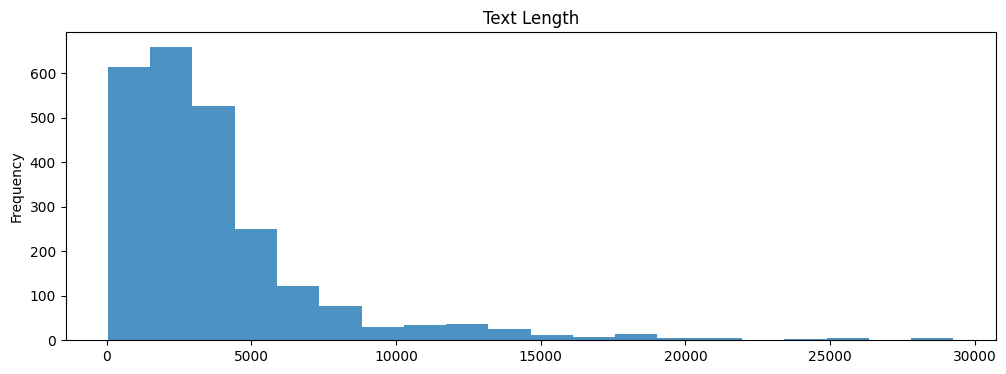

In [47]:
plt.figure(figsize=(12, 4))
ax = dups_s[dups_s['len'] < 30000] ['len'].plot.hist(bins=20, alpha=0.8)
ax.set_title('Text Length')
plt.show()

0.20113069681782658


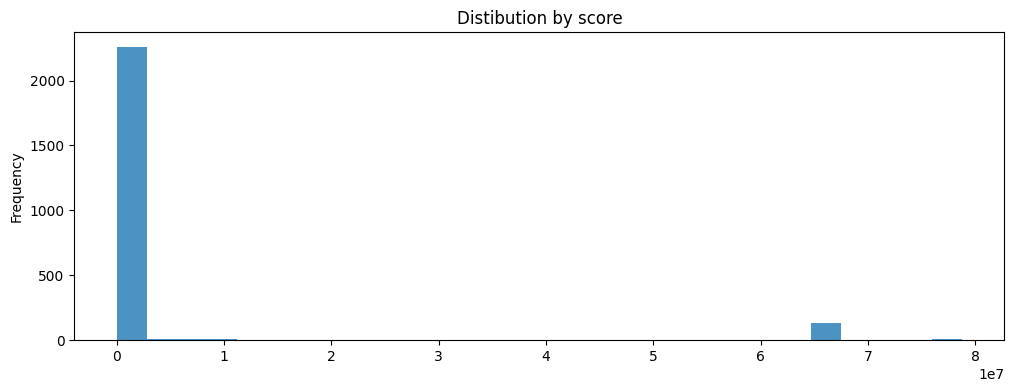

In [48]:
print(dups_s[score_column_name].min())
plt.figure(figsize=(12, 4))
ax = dups_s[score_column_name].plot.hist(bins=28, alpha=0.8)
ax.set_title('Distibution by score')
plt.show()

In [49]:

dups_s['valid'] = True

print("excluding too long docs")
for i, row in dups_s.iterrows():   
    if row['len'] > 30000:
        print ('excluding', i, row[0], row['subject'], row['len'])
        dups_s.at[i, 'valid'] = False  
        
dups_s = dups_s[dups_s['valid'] == True]

print("excluding docs with rare subj")
cnts = dups_s ['subject'].value_counts()
for i, row in dups_s.iterrows():   
    if not pd.isna(row['subject']):
        if cnts[row['subject']] < 3:
            print ('excluding', i, row[0], row['subject'])
            dups_s.at[i, 'valid'] = False

dups_s = dups_s[dups_s['valid'] == True]  

excluding too long docs
excluding 5e58df7823869ee43538823d file GeneralContract 31090.0
excluding 5fbf75c75d05d73d0295fac0 db GeneralContract 38360.0
excluding 5fca2acd9083b679224c77da db GeneralContract 49040.0
excluding 5fca2ac79083b679224c7750 db GeneralContract 41250.0
excluding 5fca2ac89083b679224c7786 db GeneralContract 43930.0
excluding 5f9672f182451803b5001df7 db GeneralContract 31170.0
excluding 5fca2ac79083b679224c774f db GeneralContract 39310.0
excluding 5fca2ac99083b679224c77b0 db GeneralContract 39000.0
excluding 5e5de70d01c6c73c19eebd4a file GeneralContract 31090.0
excluding 5fc7a047c54bc33809e26372 db Service 49340.0
excluding 5f09a55a138e9184feef1f3d file Service 39860.0
excluding 615e9e978f3b0514f3f42413 db Loans 35800.0
excluding docs with rare subj
excluding 5feb3e50bd24992aa31040df db AssetTransactions
excluding 5dee80604ddc27bcf92dd88e file EmployeeContracts
excluding 5fbbbd1ba2b4551c06107a3d db BigDeal
excluding 6166dbc387f1d9065bb8b937 db AssetTransactions


Service                              1172
Other                                 397
Deal                                  269
Renting                               117
GeneralContract                       112
Loans                                  91
AgencyContract                         60
DealIntellectualProperty               51
Charity                                43
Insurance                              38
RealEstate                             24
RealEstateTransactions                 15
BankGuarantees                         11
SecuritiesTransactions                  9
ParticipationInOtherOrganizations       9
PledgeEncumbrance                       6
Name: subject, dtype: int64


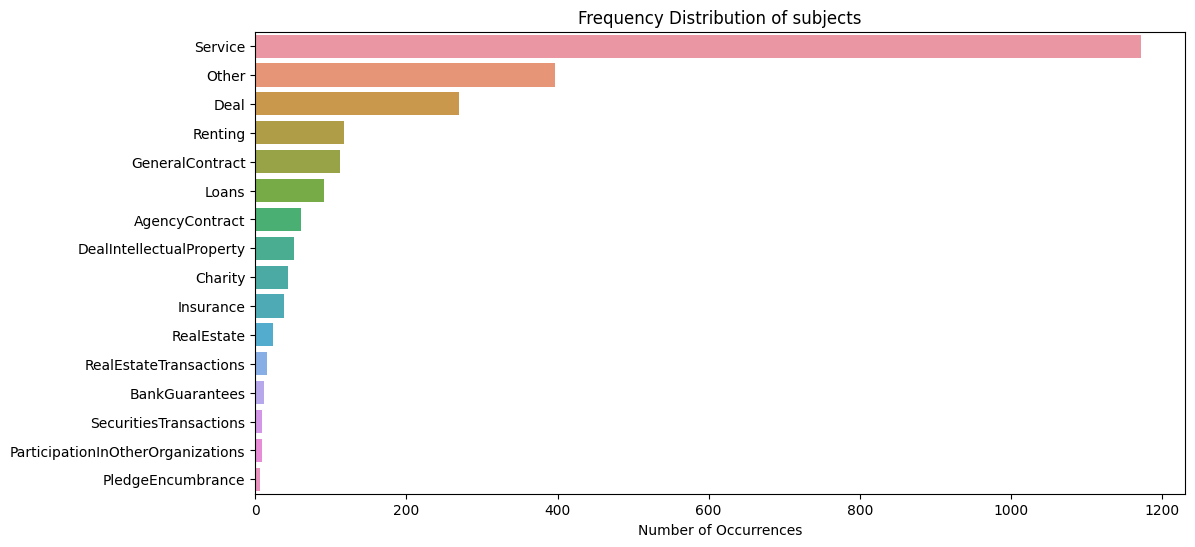

In [50]:
%matplotlib inline

cnt = dups_s['subject'].value_counts()

plt.figure(figsize=(12, 6 ))
sns.barplot(x=cnt.values, y=cnt.index)

print(  cnt )

plt.title('Frequency Distribution of subjects')
plt.xlabel('Number of Occurrences')
plt.show()


In [51]:
dups_s.index.name = '_id'
dups_s.to_csv(Path(work_dir) / 'contract_trainset_meta.csv', index=True)


_s = f"### {len(dups_s)} - Всего новых документов в обучающем наборе на {lastdate:%d.%m.%Y}"
display(Markdown(_s))


dups_s

### 2424 - Всего новых документов в обучающем наборе на 14.02.2023

,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,subj_len,headers,subject_pos,org-1-type,org-2-type,url,unseen,score,hash,dups
_id,,,,,,,,,,,,,,,,,,,,,
5e587dce99b345c81a70340d,file,c7638957131b716a710dcb357e4dc198,1.12.0,2023-03-11 12:42:01.389768,5950.0,2020-06-16 18:33:25.117000+00:00,9.900000e+08,20.713216,724.0,RUB,...,51.0,14.0,NaN,Общество с ограниченной ответственностью,публичное акционерное общество,http://gpn-audit.nemosoft.ru/#/audit/edit/5e58...,False,2.011307e-01,5.531454e+18,1.0
5edbc62eda3678279fbcadf3,file,027a7c30f74ff8ffe684378e9883dd8e,2.0.2,2023-03-11 12:42:04.638600,1370.0,2020-07-18 20:24:58.934000+00:00,2.400000e+04,10.085851,747.0,RUB,...,106.0,10.0,NaN,Общество с ограниченной ответственностью,Общество с ограниченной ответственностью,http://gpn-audit.nemosoft.ru/#/audit/edit/5edb...,False,6.091754e-01,9.463156e+16,1.0
5ec2b8da665f7603e03b1255,db,3187bfac60ea578221c5d9357756c6c1,1.6.5,2023-03-02 18:16:30.799761,5840.0,2020-05-18 17:16:38.114000+00:00,2.523632e+07,17.043795,5674.0,BRL,...,79.0,4.0,1444.0,Общество с ограниченной ответственностью,компания,http://gpn-audit.nemosoft.ru/#/audit/edit/5ec2...,False,6.168706e-01,-4.830712e+18,1.0
63908ca3a1bded13e629f2dc,db,778e9604f0dfb6ed01dc05cce32ab2c2,22.12.7,2023-03-02 18:17:31.541520,4890.0,2022-12-08 21:48:02.600000+00:00,7.000000e+09,22.669176,399.0,NaN,...,121.0,11.0,148.0,Публичное акционерное общество,Публичное акционерное общество,http://gpn-audit.nemosoft.ru/#/audit/edit/6390...,False,6.763288e-01,-3.241632e+17,4.0
63a43092beaa9eeec65ecb09,db,daa1fec657ec24b7314d0ef2d3a9f411,23.3.1,2023-03-02 18:17:46.991970,3130.0,2023-03-01 16:34:31.821000+00:00,1.550000e+10,23.464106,278.0,RUB,...,81.0,12.0,148.0,Публичное акционерное общество,Публичное акционерное общество,http://gpn-audit.nemosoft.ru/#/audit/edit/63a4...,False,7.102020e-01,-5.004864e+18,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6166e28787f1d9065bb8b948,db,c46562e7b9709d64e6fdfc50b29277fe,2.5.0,2023-03-02 18:17:11.350660,1330.0,2021-10-13 16:46:40.950000+00:00,NaN,NaN,NaN,NaN,...,17.0,6.0,27.0,NaN,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/6166...,True,7.877927e+07,9.213062e+18,1.0
63ce4b16e83d1ee490f40157,db,48903685b84a69c355d294bd0eb5cb1a,23.01.23,2023-03-02 18:17:40.069004,280.0,2023-01-29 22:44:37.627000+00:00,NaN,NaN,NaN,NaN,...,68.0,3.0,140.0,NaN,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/63ce...,True,7.877927e+07,3.465126e+18,1.0
63ce4a68e83d1ee490f3f88f,db,5acaf8d0416bc4b1111130e3adcd9d35,23.01.23,2023-03-02 18:17:40.823014,40.0,2023-01-23 20:09:09.584000+00:00,NaN,NaN,NaN,NaN,...,40.0,1.0,1.0,NaN,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/63ce...,True,7.877927e+07,3.459788e+18,1.0


In [52]:
dups_s[dups_s['unseen']].to_csv(Path(work_dir) / 'contract_trainset_meta.to_markup.csv', index=True)

In [53]:
dups_s[dups_s['unseen']]

,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,subj_len,headers,subject_pos,org-1-type,org-2-type,url,unseen,score,hash,dups
_id,,,,,,,,,,,,,,,,,,,,,
63c506ace2456d59975e0f9f,db,2ff69a29f2a6f16826a6e68dc6cc1d22,23.01.04,2023-03-02 18:17:38.849251,430.0,2023-01-16 14:43:58.035000+00:00,5.500000e+07,17.822844,172.0,RUB,...,10.0,5.0,136.0,Общество с ограниченной ответственностью,Общество с ограниченной ответственностью,http://gpn-audit.nemosoft.ru/#/audit/edit/63c5...,True,4.420148e+01,-5.533037e+18,1.0
5efe924d777d4b67a92d55b0,file,c056d218b8ae1d56747afd23ac3cf10f,2.0.0,2023-03-11 12:42:13.247830,17580.0,2020-07-03 12:29:32.528000+00:00,1.865870e+08,19.044408,2372.0,RUB,...,11.0,76.0,NaN,Акционерное общество,Общество с ограниченной ответственностью,http://gpn-audit.nemosoft.ru/#/audit/edit/5efe...,True,5.408784e+01,-6.148173e+18,1.0
5f86efe91115a777cc39a220,file,81489262f6e47f8fde2b23a21536f0c5,2.0.5,2023-03-11 12:42:20.701961,7780.0,2020-10-14 20:59:44.891000+00:00,8.878160e+07,18.301690,2383.0,RUB,...,73.0,19.0,NaN,Общество с ограниченной ответственностью,Публичное акционерное общество,http://gpn-audit.nemosoft.ru/#/audit/edit/5f86...,True,5.744725e+01,1.602532e+18,1.0
5edbadd9da3678279fbcab15,file,dd14f75369397ffa2907a1abd5b37307,1.22.1,2023-03-11 12:42:04.045074,4520.0,2020-06-30 19:44:30.929000+00:00,9.583333e+06,16.075536,1092.0,RUB,...,125.0,14.0,NaN,Общество с ограниченной ответственностью,Общество с ограниченной ответственностью,http://gpn-audit.nemosoft.ru/#/audit/edit/5edb...,True,7.052165e+01,5.405004e+18,1.0
60d1bbffc07bc76a2196cb47,db,803e4dc51e7c76b60447a3ceff3da6c1,2.4.2,2023-03-02 18:17:04.326658,2490.0,2021-06-22 13:37:32.513000+00:00,1.666667e+08,18.931506,287.0,RUB,...,21.0,16.0,118.0,Общество с ограниченной ответственностью,Общество с ограниченной ответственностью,http://gpn-audit.nemosoft.ru/#/audit/edit/60d1...,True,7.530815e+01,-5.891925e+17,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6166e28787f1d9065bb8b948,db,c46562e7b9709d64e6fdfc50b29277fe,2.5.0,2023-03-02 18:17:11.350660,1330.0,2021-10-13 16:46:40.950000+00:00,NaN,NaN,NaN,NaN,...,17.0,6.0,27.0,NaN,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/6166...,True,7.877927e+07,9.213062e+18,1.0
63ce4b16e83d1ee490f40157,db,48903685b84a69c355d294bd0eb5cb1a,23.01.23,2023-03-02 18:17:40.069004,280.0,2023-01-29 22:44:37.627000+00:00,NaN,NaN,NaN,NaN,...,68.0,3.0,140.0,NaN,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/63ce...,True,7.877927e+07,3.465126e+18,1.0
63ce4a68e83d1ee490f3f88f,db,5acaf8d0416bc4b1111130e3adcd9d35,23.01.23,2023-03-02 18:17:40.823014,40.0,2023-01-23 20:09:09.584000+00:00,NaN,NaN,NaN,NaN,...,40.0,1.0,1.0,NaN,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/63ce...,True,7.877927e+07,3.459788e+18,1.0


In [54]:
%%time
from pymongo import ASCENDING

query = {
  '$and': [
    {"parse.documentType":{ '$in': ["AGREEMENT", "CONTRACT", "SUPPLEMENTARY_AGREEMENT"] }  },      
    {"user.attributes_tree": {"$ne": None}},
#       {'user.updateDate': {'$gt': lastdate}}    
  ]
}

db = get_mongodb_connection()
documents_collection = db['documents']
sorting = [('analysis.analyze_timestamp', ASCENDING), ('user.updateDate', ASCENDING)]
res = documents_collection.find(filter=query, 
                                sort=sorting,
                                projection={'_id': True, 'user.updateDate':True, 'state':True, 'parse.documentType':True}
#                                             'analysis.attributes_tree.version': True,
#                                             'analysis.attributes_tree.contract.subject': True}
                               ).limit(5000)

res = list([i for i in res])
# print(res[0])
_s = f"#### Всего документов, которые размечены человеком : {len(res)}"
display(Markdown(_s))

# res[:4]



/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)


#### Всего документов, которые размечены человеком : 1173

CPU times: user 18.5 ms, sys: 0 ns, total: 18.5 ms
Wall time: 252 ms


# 🤦 Find markup errors

In [55]:
user_docs_ids  = [i["_id"] for i in res]
print('user_docs_ids', len(user_docs_ids))


user_docs_ids 1173


In [56]:
errors_report_file_prefix = "user_markup_errors"
errors_report_metric_prefix = "user"
user_docs_ids = user_docs_ids
%run -i -t /root/artem/analyser/trainsets/validate_markup.ipynb
del user_docs_ids

DEBUG - 2023-03-11 12:42:27,922 - retrain_ipynb - --=logging started=--
DEBUG - 2023-03-11 12:42:27,922 - retrain_ipynb - --=logging started=--


Running on :platform.processor()='x86_64'
ml_flow_url='http://192.168.10.38:5000' set MLFLOW_URL env var to re-define
reports_path=PosixPath('/root/artem/analyser/training_reports') /root/artem/analyser/training_reports
['headline-begin', 'headline-end', 'subject-begin', 'subject-end', 'date-begin', 'date-end', 'number-begin', 'number-end', 'org-name-begin', 'org-name-end', 'org-alias-begin', 'org-alias-end', 'org-type-begin', 'org-type-end', 'amount-begin', 'amount-end', 'amount_brutto-begin', 'amount_brutto-end', 'amount_netto-begin', 'amount_netto-end', 'vat-begin', 'vat-end', 'sign-begin', 'sign-end', 'currency-begin', 'currency-end', 'vat_unit-begin', 'vat_unit-end', 'value-begin', 'value-end']=
Number of contract IDs for validation (set ouside) is 1173
CPU times: user 18 µs, sys: 3 µs, total: 21 µs
Wall time: 21.7 µs
CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 8.82 µs


#### Всего ошибок: 1894.0 в 1173 документах -- (1.6146632566069907 на документ)

CPU times: user 4.91 s, sys: 395 ms, total: 5.31 s
Wall time: 7.52 s
<RunInfo: artifact_uri='mlflow-artifacts:/305219436181214624/014a8418b607491394d0a898a143fe95/artifacts', end_time=None, experiment_id='305219436181214624', lifecycle_stage='active', run_id='014a8418b607491394d0a898a143fe95', run_name='puzzled-moth-180', run_uuid='014a8418b607491394d0a898a143fe95', start_time=1678527747934, status='RUNNING', user_id='root'>


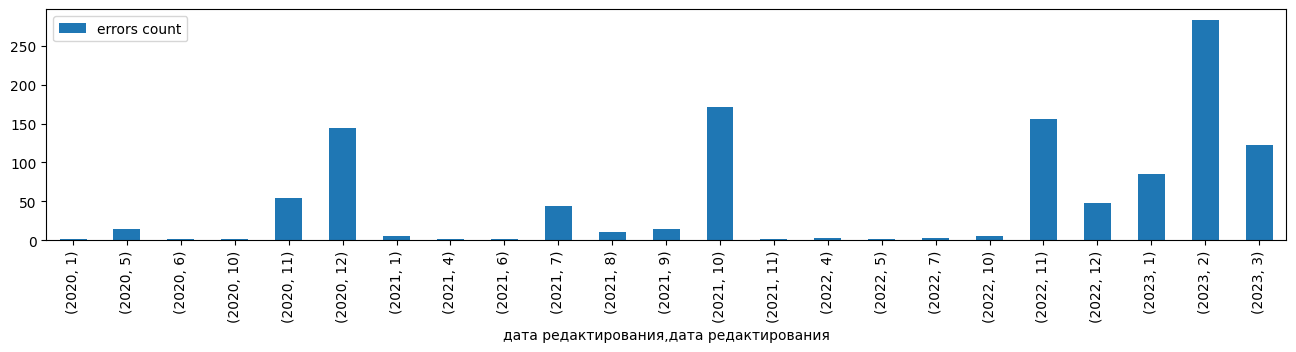

In [57]:
import matplotlib.pyplot as plt


ax = userdocs.groupby(
    [userdocs["дата редактирования"].dt.year, userdocs["дата редактирования"].dt.month ])[
        ['errors count']].count().plot(kind="bar", figsize=(16,3))

plt.show()

In [58]:

# auto_docs = validate_markup(auto_docs_ids)


# Statistics
### Collecting org types

In [59]:
from collections import Counter
statistics = {}


l = list(userdocs['Форма собственности 1'].values) + list( userdocs['Форма собственности 2'].values)
l= [str(k) for k in l]
c = Counter(l)


statistics['org_types_cased'] = pd.DataFrame(c.items(),  columns = ['type', 'count']).sort_values(['count', 'type'], ascending=False)
statistics['org_types_cased'].to_csv("statistics.org_types_cased.csv")
statistics['org_types_cased']

,type,count
0,Общество с ограниченной ответственностью,1213
3,Акционерное общество,360
1,Публичное акционерное общество,268
2,nan,110
4,ООО,68
...,...,...
39,Акционерного общества,1
64,Администрация муниципального образования,1
15,Автономное учреждение Омской области дополните...,1
29,АО НПО,1


In [60]:
l = list(userdocs['Форма собственности 1'].values) + list( userdocs['Форма собственности 2'].values)
l= [str(k).lower() for k in l]
c = Counter(l)


statistics['org_types'] = pd.DataFrame(c.items(),  columns = ['type', 'count']).sort_values(['count', 'type'], ascending=False)
statistics['org_types'].to_csv("statistics.org_types.csv")
statistics['org_types']

,type,count
0,общество с ограниченной ответственностью,1226
3,акционерное общество,368
1,публичное акционерное общество,283
2,nan,110
4,ооо,68
...,...,...
49,акционерное,1
33,акционерного общества,1
53,администрация муниципального образования,1
13,автономное учреждение омской области дополните...,1


### Aliases

In [61]:
userdocs['subject kind']

5fb3d7a378df3635f5441d8e                   Service
5fe4821db770574a005556be                      Deal
640ade9b4d58ce260408096d    SecuritiesTransactions
5fdb2140542ce403c92b4549                   Service
5fe4821eb770574a00555724                   Service
                                     ...          
5fc63d611d0a1603c7a0c96f                     Loans
5fbf75af5d05d73d0295faaf                   Renting
5fbbe46ea2b4551c06107c9a                 Insurance
5fbbe46ba2b4551c06107bd3                   Service
5ec2b8d9665f7603e03b1245                   Renting
Name: subject kind, Length: 1173, dtype: object

In [62]:
def count_alias_pairs(cased:bool):
    _df = pd.DataFrame()
    for i, v in userdocs.iterrows():
        if cased:
            key = ' & '.join(   np.sort( list([ str(v['Псевдоним 1']), str(v['Псевдоним 2'])])) ) 
        else:
            key = ' & '.join(   np.sort( list([ str(v['Псевдоним 1']).lower(), str(v['Псевдоним 2']).lower()])) ) 
        key2 = ' & '.join( [str(v['subject kind']), key ] )
        _df.at[i, 'count'] = key2



    _t = pd.DataFrame(_df['count'].value_counts())
    for i, v in _t.iterrows():
        s, a1, a2 = str(i).split('&')
    #     print(a2)
        _t.at[i, 'alias 1'] = a1
        _t.at[i, 'alias 2'] = a2
        _t.at[i, 'subject'] = s
#     statistics['alias_pairs']=_t
#     statistics['alias_pairs'].to_csv("statistics.alias_pair.csv")
#     _t
    return _t


statistics['alias_pairs']=count_alias_pairs(cased=False)
statistics['alias_pairs'].to_csv("statistics.alias_pair.csv")

statistics['alias_pairs_cased']=count_alias_pairs(cased=True)
statistics['alias_pairs_cased'].to_csv("statistics.alias_pair_cased.csv")

In [63]:
statistics['alias_pairs_cased']

,count,alias 1,alias 2,subject
Service & Заказчик & Исполнитель,352,Заказчик,Исполнитель,Service
Deal & Покупатель & Поставщик,89,Покупатель,Поставщик,Deal
GeneralContract & Заказчик & Подрядчик,70,Заказчик,Подрядчик,GeneralContract
Renting & Арендатор & Арендодатель,69,Арендатор,Арендодатель,Renting
Loans & Заемщик & Займодавец,58,Заемщик,Займодавец,Loans
...,...,...,...,...
nan & Арендатор & Арендодатель,1,Арендатор,Арендодатель,nan
Service & Банк & Предприятие,1,Банк,Предприятие,Service
Deal & Правообладатель & Приобретатель,1,Правообладатель,Приобретатель,Deal
Service & Клиент & Перевозчик,1,Клиент,Перевозчик,Service


In [64]:
statistics['alias_pairs']

,count,alias 1,alias 2,subject
Service & заказчик & исполнитель,369,заказчик,исполнитель,Service
Deal & покупатель & поставщик,89,покупатель,поставщик,Deal
GeneralContract & заказчик & подрядчик,77,заказчик,подрядчик,GeneralContract
Renting & арендатор & арендодатель,76,арендатор,арендодатель,Renting
Loans & заемщик & займодавец,58,заемщик,займодавец,Loans
...,...,...,...,...
Service & актуарий & клиент,1,актуарий,клиент,Service
BankGuarantees & nan & гарант,1,nan,гарант,BankGuarantees
DealIntellectualProperty & сторона-1 & сторона-2,1,сторона-1,сторона-2,DealIntellectualProperty
Charity & благотворитель & получатель,1,благотворитель,получатель,Charity


## Validate auto markup

In [65]:
del userdocs
auto_docs_ids = stats[ (stats.user_correction_date.isnull()) & (stats.source=='db') & (stats['documentType']=='CONTRACT') ].index
errors_report_file_prefix = "ai_markup_errors"
errors_report_metric_prefix = "ai"
user_docs_ids = auto_docs_ids
%run -i -t /root/artem/analyser/trainsets/validate_markup.ipynb
del user_docs_ids

auto_docs = userdocs

DEBUG - 2023-03-11 12:42:36,938 - retrain_ipynb - --=logging started=--
DEBUG - 2023-03-11 12:42:36,938 - retrain_ipynb - --=logging started=--
DEBUG - 2023-03-11 12:42:36,938 - retrain_ipynb - --=logging started=--
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)


Running on :platform.processor()='x86_64'
ml_flow_url='http://192.168.10.38:5000' set MLFLOW_URL env var to re-define
reports_path=PosixPath('/root/artem/analyser/training_reports') /root/artem/analyser/training_reports
['headline-begin', 'headline-end', 'subject-begin', 'subject-end', 'date-begin', 'date-end', 'number-begin', 'number-end', 'org-name-begin', 'org-name-end', 'org-alias-begin', 'org-alias-end', 'org-type-begin', 'org-type-end', 'amount-begin', 'amount-end', 'amount_brutto-begin', 'amount_brutto-end', 'amount_netto-begin', 'amount_netto-end', 'vat-begin', 'vat-end', 'sign-begin', 'sign-end', 'currency-begin', 'currency-end', 'vat_unit-begin', 'vat_unit-end', 'value-begin', 'value-end']=
Number of contract IDs for validation (set ouside) is 789
CPU times: user 27 µs, sys: 0 ns, total: 27 µs
Wall time: 29.8 µs
CPU times: user 18 µs, sys: 0 ns, total: 18 µs
Wall time: 19.6 µs


#### Всего ошибок: 1533.0 в 789 документах -- (1.9429657794676807 на документ)

CPU times: user 2.55 s, sys: 141 ms, total: 2.69 s
Wall time: 3.98 s
<RunInfo: artifact_uri='mlflow-artifacts:/305219436181214624/8b7af58518fe44009d1192df1145ead5/artifacts', end_time=None, experiment_id='305219436181214624', lifecycle_stage='active', run_id='8b7af58518fe44009d1192df1145ead5', run_name='inquisitive-bug-936', run_uuid='8b7af58518fe44009d1192df1145ead5', start_time=1678527756952, status='RUNNING', user_id='root'>


### Invalidate no-date docs

In [66]:
bad_docs = auto_docs[ (auto_docs['Дата'].isnull()) | (auto_docs['errors severity']>=10)]
bad_docs.index

for i, row in stats.iterrows():
    if i in bad_docs.index:
        stats.at[i, 'valid'] = False
# stats.loc[bad_docs.index].valid=False
stats.loc[bad_docs.index].valid
# for i, row in stats.iterrows():
#     if i

Series([], Name: valid, dtype: object)

In [67]:
good_docs = auto_docs[ (~auto_docs['Дата'].isnull()) & (auto_docs['errors severity']<10)]
good_docs
# auto_docs[auto_docs['errors count']<3]

,дата редактирования,link,error,error missing,errors count,errors severity,subject len,subject kind,Форма собственности 1,Наименование 1,...,Дата,сумма,сумма без налога,сумма (старая),currency,subject,Номер,сумма с налогом,налог,vat_unit
63ce4a4be83d1ee490f3f6ea,None,https://gpn-audit.nemosoft.ru/#/audit/edit/63c...,налог не указан;\nНаименование 2: кавычка не з...,,3,9,166.0,Service,Общество с ограниченной ответственностью,Газпромнефть-Каталитические системы,...,«23» апреля 2021,10,10,10,NaN,1.1. Настоящий Договор регламентирует общие пр...,№ (Лн-ье/сс,NaN,NaN,NaN
5fb3d79d78df3635f5441d16,NaN,https://gpn-audit.nemosoft.ru/#/audit/edit/5fb...,налог не указан;\nНаименование 2: кавычка не о...,,3,7,36.0,GeneralContract,Общество с ограниченной ответственностью,Издательско-полиграфическое предприятие «Масте...,...,«30» октября 2019,"4.1. Стоимость работ составляет 70080,00",NaN,"70080,00",рублей,NaN,№ 19-36Р,NaN,NaN,NaN
5fb3d4a078df3635f5441c5b,NaN,https://gpn-audit.nemosoft.ru/#/audit/edit/5fb...,налог не указан;\nНаименование 2: кавычка не з...,,3,7,86.0,Service,Общество с ограниченной ответственностью,Рекламно-Информационное агентство «Город,...,«16» января 2020,". Сумма настоящего договора составляет 29998,80",NaN,"29998,80",рублей,NaN,№ 19-71,NaN,NaN,NaN
5fb6750b33c72547b7550125,NaN,https://gpn-audit.nemosoft.ru/#/audit/edit/5fb...,Наименование 2: кавычка не закрыта;\nНаименова...,сумма договора отсутсвует;\n,3,7,115.0,Service,Акционерное общество,«Арктика Медиа,...,«30» апреля 2019,NaN,NaN,NaN,NaN,NaN,№ 1І9-13Д,NaN,NaN,NaN
5fdb2141542ce403c92b4580,NaN,https://gpn-audit.nemosoft.ru/#/audit/edit/5fd...,налог не указан;\nНаименование 2: кавычка не з...,,3,7,86.0,Service,Общество с ограниченной ответственностью,Рекламно-Информационное агентство «Город,...,«10» апреля 2019,". Сумма настоящего договора составляет 29998,80",NaN,"29998,80",рублей,NaN,№ 19-04,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5fb6750533c72547b7550084,NaN,https://gpn-audit.nemosoft.ru/#/audit/edit/5fb...,,,0,0,86.0,Service,Акционерное общество,Арктика Медиа,...,«14» сентября 2020,автотранспортных услуг по договору составляет ...,NaN,140400,рублей,NaN,№ 20-47Р,NaN,NaN,NaN
5f9672f282451803b5001dfb,NaN,https://gpn-audit.nemosoft.ru/#/audit/edit/5f9...,,,0,0,60.0,Loans,Общество с ограниченной ответственностью,Газпромнефть Шиппинг,...,«01» июня 2017,займа денежные средства в сумме 51000000 (Пять...,NaN,51000000,рублей,NaN,№ 1598З/859,NaN,NaN,NaN
5f9672f282451803b5001dfd,NaN,https://gpn-audit.nemosoft.ru/#/audit/edit/5f9...,,,0,0,42.0,Renting,Общество с ограниченной ответственностью,Газпромнефть Шиппинг,...,«01» февраля 2017,за пользование Помещением арендную плату 96650...,NaN,96650,рублей,NaN,№ 965/03а,NaN,NaN,NaN
5fbbe468a2b4551c06107b2d,NaN,https://gpn-audit.nemosoft.ru/#/audit/edit/5fb...,,,0,0,45.0,Service,Акционерное общество,Арктика Медиа,...,«30» Сентября 2020,выплачивает Исполнителю компенсацию в размере ...,NaN,10000,рублей,NaN,№ 20-57Р,NaN,NaN,NaN


# Make datapoints

In [68]:
work_dir

PosixPath('/root/artem/work')

In [69]:
from analyser.headers_detector import get_tokens_features
from tf_support.embedder_elmo import ElmoEmbedder
from analyser.legal_docs import embedd_tokens
import os

embedder = ElmoEmbedder.get_instance('elmo')  # lazy init

def _dp_fn(doc_id, suffix):
    return os.path.join(work_dir, 'datasets', f'{doc_id}-datapoint-{suffix}.npy')


def save_contract_data_arrays(db_json_doc: DbJsonDoc):
    # TODO: trim long documens according to contract parser

    id_ = db_json_doc.get_id()

    tokens_map: TextMap = db_json_doc.get_tokens_for_embedding()

    # 1) EMBEDDINGS
    print(len(tokens_map))
    embeddings = embedd_tokens(tokens_map,
                               embedder,
                               log_key=f'id={id_} chs={tokens_map.get_checksum()}')

    # 2) TOKEN FEATURES
    token_features: DataFrame = get_tokens_features(db_json_doc.get_tokens_map_unchaged().tokens)

    # 3) SEMANTIC MAP
    semantic_map: DataFrame = get_semantic_map_new(db_json_doc)
    #####
 
    np.save(_dp_fn(id_, 'token_features'), token_features)
    np.save(_dp_fn(id_, 'semantic_map'), semantic_map)
    _embeddings_file = _dp_fn(id_, 'embeddings')
    np.save(_embeddings_file, embeddings)
    print(f'embeddings saved to {_embeddings_file} {embeddings.shape}')

In [70]:
_docs_ids = [str(i) for i in new_docs_ids]
intersection_set = set.intersection(set(list(dups_s.index)), set(_docs_ids)) 
len(intersection_set)
# intersection_set




260

In [71]:
# good_docs.index

# intersection_set = set.intersection(set(list(dups_s.index)), set(_docs_ids)) 

### Trainset fixtures
#### Invalidate long subjects

In [72]:
%%time

ids = list(dups_s.index)



if not 'subject_pos' in stats:
    stats['subject_pos'] = None
        
ids_of_long_subject_docs=[]

for k, oid in enumerate(ids):

    _id = str(oid)
    iiid= ObjectId(_id)
    
    src = dups_s.loc[_id]['source']
    jd = None
    if src == 'db':
#       if False:
        d = get_doc_by_id(iiid)
        if d is not None:
            jd = DbJsonDoc(d)
            
            if jd.state not in [15,12]:
                print(jd.state, iiid)
            
            stats.at[_id, 'documentType'] = jd.documentType
            dups_s.at[_id, 'documentType'] = jd.documentType
            
            attr_tree = jd.get_attributes_tree()  
            span = attr_tree.get('subject', {}).get('span',[0,0])
            subject_len = span[1]-span[0]
            stats.at[_id, 'subj_len'] = subject_len
            dups_s.at[_id, 'subj_len'] = subject_len  
            
            stats.at[_id, 'subject_pos'] = span[0]
            dups_s.at[_id, 'subject_pos'] = span[0]  
                
            if span[0]==0:
                stats.at[_id, 'valid'] = False
                dups_s.at[_id, 'valid'] = False
                
            if subject_len >= 200:
                
                stats.at[_id, 'valid'] = False
                dups_s.at[_id, 'valid'] = False
                
                
                
                ids_of_long_subject_docs.append(oid)
                
                tm = jd.get_tokens_map_unchaged()
                quote = tm.text_range(span)
                print(k, iiid, span, span[1]-span[0])
#                 print('-'*100)
                sentence_span = tm.sentence_at_index(span[0])
                quote2 = tm.text_range(sentence_span)
                print(quote2[:50])
                print('='*100)
# stats[stats['documentType']=='CONTRACT']

dups_s.to_csv(Path(work_dir) / 'contract_trainset_meta.csv', index=True)

/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)


CPU times: user 3.6 s, sys: 479 ms, total: 4.08 s
Wall time: 6.7 s


#### Fix missing headers

In [73]:
%%time

from analyser.legal_docs import LegalDocument, PARAGRAPH_DELIMITER, GenericDocument, Paragraph
from analyser.ml_tools import SemanticTag
from integration.word_document_parser import join_paragraphs


def save_analysis(db_document: DbJsonDoc, doc_dummie: LegalDocument) -> DbJsonDoc:
  documents_collection = get_mongodb_connection()['documents']
  
  _analyse_json_obj: dict = doc_dummie.to_json_obj()
  print("--analyse_json_obj['headers'] len=", len(_analyse_json_obj['headers']))

#   to_save = db_document.as_dict()
#   to_save['headers'] = _analyse_json_obj['headers']

  documents_collection.update_one({'_id': doc_dummie.get_id()}, {'$set': {'analysis.headers': _analyse_json_obj['headers']}})
 
    
  print("updated", doc_dummie.get_id())


def restore_headers (response, oid) :
  doc = join_paragraphs(response, oid)
  return doc
   


def restore_headlines(k, oid):    

    iiid= ObjectId(oid)
    src = dups_s.loc[oid]['source']
    jd = None
    if src == 'db':
#       if False:
        d = get_doc_by_id(iiid)
        if d is not None:
            jd = DbJsonDoc(d)
            
            if jd.state in [15,12]:
                if len(jd.analysis.get('headers', [])) > 0:
                    #  all is ok
#                     print(oid)
                    pass
                else:
                     doc_with_paragraphs = restore_headers(jd.parse, iiid)
                     save_analysis(jd,  doc_with_paragraphs)
                     print ('--', k, oid, len(doc_with_paragraphs.paragraphs))

                    
for k, oid in enumerate(ids):
    restore_headlines(k,oid)


CPU times: user 2.78 s, sys: 460 ms, total: 3.24 s
Wall time: 6.28 s


In [74]:
# restore_headlines(1,'62d149474ae369b4976e31fc'): 

In [75]:
len(ids_of_long_subject_docs)

0

In [76]:
dups_s

,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,subj_len,headers,subject_pos,org-1-type,org-2-type,url,unseen,score,hash,dups
_id,,,,,,,,,,,,,,,,,,,,,
5e587dce99b345c81a70340d,file,c7638957131b716a710dcb357e4dc198,1.12.0,2023-03-11 12:42:01.389768,5950.0,2020-06-16 18:33:25.117000+00:00,9.900000e+08,20.713216,724.0,RUB,...,51.0,14.0,NaN,Общество с ограниченной ответственностью,публичное акционерное общество,http://gpn-audit.nemosoft.ru/#/audit/edit/5e58...,False,2.011307e-01,5.531454e+18,1.0
5edbc62eda3678279fbcadf3,file,027a7c30f74ff8ffe684378e9883dd8e,2.0.2,2023-03-11 12:42:04.638600,1370.0,2020-07-18 20:24:58.934000+00:00,2.400000e+04,10.085851,747.0,RUB,...,106.0,10.0,NaN,Общество с ограниченной ответственностью,Общество с ограниченной ответственностью,http://gpn-audit.nemosoft.ru/#/audit/edit/5edb...,False,6.091754e-01,9.463156e+16,1.0
5ec2b8da665f7603e03b1255,db,3187bfac60ea578221c5d9357756c6c1,1.6.5,2023-03-02 18:16:30.799761,5840.0,2020-05-18 17:16:38.114000+00:00,2.523632e+07,17.043795,5674.0,BRL,...,79.0,4.0,1444.0,Общество с ограниченной ответственностью,компания,http://gpn-audit.nemosoft.ru/#/audit/edit/5ec2...,False,6.168706e-01,-4.830712e+18,1.0
63908ca3a1bded13e629f2dc,db,778e9604f0dfb6ed01dc05cce32ab2c2,22.12.7,2023-03-02 18:17:31.541520,4890.0,2022-12-08 21:48:02.600000+00:00,7.000000e+09,22.669176,399.0,NaN,...,121.0,11.0,148.0,Публичное акционерное общество,Публичное акционерное общество,http://gpn-audit.nemosoft.ru/#/audit/edit/6390...,False,6.763288e-01,-3.241632e+17,4.0
63a43092beaa9eeec65ecb09,db,daa1fec657ec24b7314d0ef2d3a9f411,23.3.1,2023-03-02 18:17:46.991970,3130.0,2023-03-01 16:34:31.821000+00:00,1.550000e+10,23.464106,278.0,RUB,...,81.0,12.0,148.0,Публичное акционерное общество,Публичное акционерное общество,http://gpn-audit.nemosoft.ru/#/audit/edit/63a4...,False,7.102020e-01,-5.004864e+18,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6166e28787f1d9065bb8b948,db,c46562e7b9709d64e6fdfc50b29277fe,2.5.0,2023-03-02 18:17:11.350660,1330.0,2021-10-13 16:46:40.950000+00:00,NaN,NaN,NaN,NaN,...,17.0,6.0,27.0,NaN,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/6166...,True,7.877927e+07,9.213062e+18,1.0
63ce4b16e83d1ee490f40157,db,48903685b84a69c355d294bd0eb5cb1a,23.01.23,2023-03-02 18:17:40.069004,280.0,2023-01-29 22:44:37.627000+00:00,NaN,NaN,NaN,NaN,...,68.0,3.0,140.0,NaN,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/63ce...,True,7.877927e+07,3.465126e+18,1.0
63ce4a68e83d1ee490f3f88f,db,5acaf8d0416bc4b1111130e3adcd9d35,23.01.23,2023-03-02 18:17:40.823014,40.0,2023-01-23 20:09:09.584000+00:00,NaN,NaN,NaN,NaN,...,40.0,1.0,1.0,NaN,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/63ce...,True,7.877927e+07,3.459788e+18,1.0


In [77]:
%%time
stats.to_csv(export_fn, index=True)

CPU times: user 36.1 ms, sys: 4 ms, total: 40.1 ms
Wall time: 39.7 ms


# Main sequence

In [78]:
%%time

# raise('test mode!')

for k, oid in enumerate(list(ids)):
# for k, oid in enumerate(list(intersection_set)): #enumerate(ids): 
    iiid= ObjectId(oid)
    src = dups_s.loc[oid]['source']
    jd = None
    if src == 'db':
#       if False:
        d = get_doc_by_id(iiid)
        if d is not None:
          jd = DbJsonDoc(d)
    else:
#         if False:
        print(oid, k, 'of', len(ids), src)
        jd = files_dict[iiid]
        
    print(oid, k, 'of', len(ids), src)

    if jd is not None:
        if jd.state in [15,12]:                
            save_contract_data_arrays(jd)


5e587dce99b345c81a70340d 0 of 2424 file
5e587dce99b345c81a70340d 0 of 2424 file
5953
embeddings saved to /root/artem/work/datasets/5e587dce99b345c81a70340d-datapoint-embeddings.npy (5953, 1024)
5edbc62eda3678279fbcadf3 1 of 2424 file
5edbc62eda3678279fbcadf3 1 of 2424 file
1373
embeddings saved to /root/artem/work/datasets/5edbc62eda3678279fbcadf3-datapoint-embeddings.npy (1373, 1024)
5ec2b8da665f7603e03b1255 2 of 2424 db
5847
embeddings saved to /root/artem/work/datasets/5ec2b8da665f7603e03b1255-datapoint-embeddings.npy (5847, 1024)
63908ca3a1bded13e629f2dc 3 of 2424 db
4892
embeddings saved to /root/artem/work/datasets/63908ca3a1bded13e629f2dc-datapoint-embeddings.npy (4892, 1024)
63a43092beaa9eeec65ecb09 4 of 2424 db
3139


/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)


embeddings saved to /root/artem/work/datasets/63a43092beaa9eeec65ecb09-datapoint-embeddings.npy (3139, 1024)
5ded4e284ddc27bcf92dd6ce 5 of 2424 file
5ded4e284ddc27bcf92dd6ce 5 of 2424 file
460
embeddings saved to /root/artem/work/datasets/5ded4e284ddc27bcf92dd6ce-datapoint-embeddings.npy (460, 1024)
63908ca4a1bded13e629f2e9 6 of 2424 db
3139
fixed number: ['№ 110801/20'] -->  ['110801/20']
embeddings saved to /root/artem/work/datasets/63908ca4a1bded13e629f2e9-datapoint-embeddings.npy (3139, 1024)
63ce49f8e83d1ee490f3f21c 7 of 2424 db
8535
embeddings saved to /root/artem/work/datasets/63ce49f8e83d1ee490f3f21c-datapoint-embeddings.npy (8535, 1024)
63a430a6beaa9eeec65ecb0b 8 of 2424 db
1362
embeddings saved to /root/artem/work/datasets/63a430a6beaa9eeec65ecb0b-datapoint-embeddings.npy (1362, 1024)
63908ca4a1bded13e629f2e3 9 of 2424 db
1362
embeddings saved to /root/artem/work/datasets/63908ca4a1bded13e629f2e3-datapoint-embeddings.npy (1362, 1024)
60defc4e95588e4cfb432c28 10 of 2424 db
248

[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=5fbf75ad5d05d73d0295fa6d chs=f38ba9e4c0feaaad440a5c35ab0f479d
[embedder_elmo.py:50 - _build_session_and_graph() ] < loading ELMO module https://storage.googleapis.com/az-nlp/elmo_ru-news_wmt11-16_1.5M_steps.tar.gz
[embedder_elmo.py:51 - _build_session_and_graph() ] TF hub cache dir is  /root/artem/work/tf_cache
INFO:absl:Using /root/artem/work/tf_cache to cache modules.


embeddings saved to /root/artem/work/datasets/5fbf75ae5d05d73d0295fa75-datapoint-embeddings.npy (2974, 1024)
5fbf75ad5d05d73d0295fa6d 51 of 2424 db
2760


[embedder_elmo.py:53 - _build_session_and_graph() ] ELMO module loaded >
INFO:gpn:ELMO module loaded >
[embedder_elmo.py:68 - _build_session_and_graph() ] ELMO: creating embedded_out_elmo
INFO:gpn:ELMO: creating embedded_out_elmo


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
[embedder_elmo.py:74 - _build_session_and_graph() ] ELMO: embedded_out_defaut embedded_out_elmo
INFO:gpn:ELMO: embedded_out_defaut embedded_out_elmo


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
2023-03-11 12:43:02.008696: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-03-11 12:43:02.506017: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-11 12:43:02.506679: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: A100-PCIE-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-03-11 12:43:02.506703: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-03-11 12:43:02.506742: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic libra

embeddings saved to /root/artem/work/datasets/5fbf75ad5d05d73d0295fa6d-datapoint-embeddings.npy (2760, 1024)
5fbf75ad5d05d73d0295fa70 52 of 2424 db
2911
embeddings saved to /root/artem/work/datasets/5fbf75ad5d05d73d0295fa70-datapoint-embeddings.npy (2911, 1024)
5fb399db39d5e82e90818467 53 of 2424 db
2921
fixed number: ['№ 37-89/1/2019'] -->  ['37-89/1/2019']
embeddings saved to /root/artem/work/datasets/5fb399db39d5e82e90818467-datapoint-embeddings.npy (2921, 1024)
62dfbce15d5a202ba67b842d 54 of 2424 db
5556
fixed number: ['№ 1234'] -->  ['1234']


DEBUG:gpn:skipping embedding doc 772ba956e0729d7fee4509c818ae33f5 ...., /root/artem/work/datasets/cache-772ba956e0729d7fee4509c818ae33f5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1511, 1024)
DEBUG:gpn:getting embedding from cache id=63ac1fab862ea92bf713c51e chs=772ba956e0729d7fee4509c818ae33f5
DEBUG:gpn:skipping embedding doc aa30ec2cdaf8d4c6b48384c86f1b21c9 ...., /root/artem/work/datasets/cache-aa30ec2cdaf8d4c6b48384c86f1b21c9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3912, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46da2b4551c06107c68 chs=aa30ec2cdaf8d4c6b48384c86f1b21c9
DEBUG:gpn:skipping embedding doc 2fce7842f353c2a9ab40c5877ff4616a ...., /root/artem/work/datasets/cache-2fce7842f353c2a9ab40c5877ff4616a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2171, 1024)
DEBUG:gpn:getting embedding from cache id=5f0bb4bd138e9184feef1fa9 chs=2fce7842f353c2a9ab40c5877ff4

embeddings saved to /root/artem/work/datasets/62dfbce15d5a202ba67b842d-datapoint-embeddings.npy (5556, 1024)
63ac1fab862ea92bf713c51e 55 of 2424 db
1511
embeddings saved to /root/artem/work/datasets/63ac1fab862ea92bf713c51e-datapoint-embeddings.npy (1511, 1024)
5fbbe46da2b4551c06107c68 56 of 2424 db
3912
fixed number: ['№ НФ 00ТВ 0000006483'] -->  ['НФ 00ТВ 0000006483']
embeddings saved to /root/artem/work/datasets/5fbbe46da2b4551c06107c68-datapoint-embeddings.npy (3912, 1024)
5f0bb4bd138e9184feef1fa9 57 of 2424 file
5f0bb4bd138e9184feef1fa9 57 of 2424 file
2171
embeddings saved to /root/artem/work/datasets/5f0bb4bd138e9184feef1fa9-datapoint-embeddings.npy (2171, 1024)
5fe34f63b770574a005553c9 58 of 2424 db
3696


DEBUG:gpn:loaded embedding shape is: (3696, 1024)
DEBUG:gpn:getting embedding from cache id=5fe34f63b770574a005553c9 chs=acda94fac9594455c03f6019e41704f6
DEBUG:gpn:skipping embedding doc d72b4a8533d4f1badede50d142e6a207 ...., /root/artem/work/datasets/cache-d72b4a8533d4f1badede50d142e6a207-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4615, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2aae9083b679224c7614 chs=d72b4a8533d4f1badede50d142e6a207
DEBUG:gpn:skipping embedding doc be7e0fcecba5d53e825d17c8578006d6 ...., /root/artem/work/datasets/cache-be7e0fcecba5d53e825d17c8578006d6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4810, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b97e00881c332b56729f chs=be7e0fcecba5d53e825d17c8578006d6
DEBUG:gpn:skipping embedding doc 3bc2d9e7f13bf311aef2a3bd379ff587 ...., /root/artem/work/datasets/cache-3bc2d9e7f13bf311aef2a3bd379ff587-embeddings-ElmoEmbedder.npy exists, loa

fixed number: ['№ 20/00000/00331/P'] -->  ['20/00000/00331/P']
embeddings saved to /root/artem/work/datasets/5fe34f63b770574a005553c9-datapoint-embeddings.npy (3696, 1024)
5fca2aae9083b679224c7614 59 of 2424 db
4615
fixed number: ['№ S СРК 2n/rr^rryCcA3</P'] -->  ['S СРК 2n/rr^rryCcA3</P']
embeddings saved to /root/artem/work/datasets/5fca2aae9083b679224c7614-datapoint-embeddings.npy (4615, 1024)
5fb3b97e00881c332b56729f 60 of 2424 db
4810
fixed number: ['№ S СРК 2n/rr^rryCcA3</P'] -->  ['S СРК 2n/rr^rryCcA3</P']
embeddings saved to /root/artem/work/datasets/5fb3b97e00881c332b56729f-datapoint-embeddings.npy (4810, 1024)
6380858b6a07f3e980b2c4d2 61 of 2424 db
3049


DEBUG:gpn:skipping embedding doc 68c36c840c67369b713f807511096b2b ...., /root/artem/work/datasets/cache-68c36c840c67369b713f807511096b2b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2125, 1024)
DEBUG:gpn:getting embedding from cache id=5f0bb4bd138e9184feef1fab chs=68c36c840c67369b713f807511096b2b
DEBUG:gpn:skipping embedding doc 03455452b993eb289683fa17c0b997fd ...., /root/artem/work/datasets/cache-03455452b993eb289683fa17c0b997fd-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2869, 1024)
DEBUG:gpn:getting embedding from cache id=63907f841864c6df4d29f303 chs=03455452b993eb289683fa17c0b997fd
DEBUG:gpn:skipping embedding doc 900a775782614f2fa28979a3405d21ed ...., /root/artem/work/datasets/cache-900a775782614f2fa28979a3405d21ed-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1702, 1024)
DEBUG:gpn:getting embedding from cache id=638085ac6a07f3e980b2c737 chs=900a775782614f2fa28979a3405d

fixed number: ['№ АС-21/10902/00339/Р 2'] -->  ['АС-21/10902/00339/Р 2']
embeddings saved to /root/artem/work/datasets/6380858b6a07f3e980b2c4d2-datapoint-embeddings.npy (3049, 1024)
5f0bb4bd138e9184feef1fab 62 of 2424 file
5f0bb4bd138e9184feef1fab 62 of 2424 file
2125
embeddings saved to /root/artem/work/datasets/5f0bb4bd138e9184feef1fab-datapoint-embeddings.npy (2125, 1024)
63907f841864c6df4d29f303 63 of 2424 db
2869
embeddings saved to /root/artem/work/datasets/63907f841864c6df4d29f303-datapoint-embeddings.npy (2869, 1024)
638085ac6a07f3e980b2c737 64 of 2424 db
1702
fixed number: ['№ ГНЭ-21/04300/000'] -->  ['ГНЭ-21/04300/000']
embeddings saved to /root/artem/work/datasets/638085ac6a07f3e980b2c737-datapoint-embeddings.npy (1702, 1024)
6380859c6a07f3e980b2c5a3 65 of 2424 db


DEBUG:gpn:skipping embedding doc 620f14cf3a438b4906d8b553987a3ce1 ...., /root/artem/work/datasets/cache-620f14cf3a438b4906d8b553987a3ce1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (12078, 1024)
DEBUG:gpn:getting embedding from cache id=6380859c6a07f3e980b2c5a3 chs=620f14cf3a438b4906d8b553987a3ce1
DEBUG:gpn:skipping embedding doc e0f11addff200d47590aae799c6cba51 ...., /root/artem/work/datasets/cache-e0f11addff200d47590aae799c6cba51-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5407, 1024)
DEBUG:gpn:getting embedding from cache id=5fbf75af5d05d73d0295faa0 chs=e0f11addff200d47590aae799c6cba51


12078
fixed number: ['№ АС-21/11259/00192/Р 1'] -->  ['АС-21/11259/00192/Р 1']
embeddings saved to /root/artem/work/datasets/6380859c6a07f3e980b2c5a3-datapoint-embeddings.npy (12078, 1024)
5fbf75af5d05d73d0295faa0 66 of 2424 db
5407
fixed number: ['№ ГНЗ-19/04500/00308/Р/15'] -->  ['ГНЗ-19/04500/00308/Р/15']


DEBUG:gpn:skipping embedding doc b947d554a5fb2a990c0645742dedbfd1 ...., /root/artem/work/datasets/cache-b947d554a5fb2a990c0645742dedbfd1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (12548, 1024)
DEBUG:gpn:getting embedding from cache id=638085946a07f3e980b2c53b chs=b947d554a5fb2a990c0645742dedbfd1


embeddings saved to /root/artem/work/datasets/5fbf75af5d05d73d0295faa0-datapoint-embeddings.npy (5407, 1024)
638085946a07f3e980b2c53b 67 of 2424 db
12548
fixed number: ['№ 020/11/2021'] -->  ['020/11/2021']


DEBUG:gpn:skipping embedding doc a83bcc769e6ee34a70b6f7cb9b63032b ...., /root/artem/work/datasets/cache-a83bcc769e6ee34a70b6f7cb9b63032b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (10553, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc66bda3678279fbcafe6 chs=a83bcc769e6ee34a70b6f7cb9b63032b


embeddings saved to /root/artem/work/datasets/638085946a07f3e980b2c53b-datapoint-embeddings.npy (12548, 1024)
5edbc66bda3678279fbcafe6 68 of 2424 file
5edbc66bda3678279fbcafe6 68 of 2424 file
10553


DEBUG:gpn:skipping embedding doc a8480e06e4cb16d8a2069b11b64b68f6 ...., /root/artem/work/datasets/cache-a8480e06e4cb16d8a2069b11b64b68f6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4812, 1024)
DEBUG:gpn:getting embedding from cache id=5fc7a034c54bc33809e261a8 chs=a8480e06e4cb16d8a2069b11b64b68f6
DEBUG:gpn:skipping embedding doc 772ba956e0729d7fee4509c818ae33f5 ...., /root/artem/work/datasets/cache-772ba956e0729d7fee4509c818ae33f5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1511, 1024)
DEBUG:gpn:getting embedding from cache id=60002adfb08473039387bcae chs=772ba956e0729d7fee4509c818ae33f5
DEBUG:gpn:skipping embedding doc e79011e71e58be05261b5721f0d078ab ...., /root/artem/work/datasets/cache-e79011e71e58be05261b5721f0d078ab-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4508, 1024)
DEBUG:gpn:getting embedding from cache id=638085a26a07f3e980b2c5fd chs=e79011e71e58be05261b5721f0d0

embeddings saved to /root/artem/work/datasets/5edbc66bda3678279fbcafe6-datapoint-embeddings.npy (10553, 1024)
5fc7a034c54bc33809e261a8 69 of 2424 db
4812
embeddings saved to /root/artem/work/datasets/5fc7a034c54bc33809e261a8-datapoint-embeddings.npy (4812, 1024)
60002adfb08473039387bcae 70 of 2424 db
1511
fixed number: ['№ -85-985-856-95'] -->  ['-85-985-856-95']
embeddings saved to /root/artem/work/datasets/60002adfb08473039387bcae-datapoint-embeddings.npy (1511, 1024)
638085a26a07f3e980b2c5fd 71 of 2424 db
4508
fixed number: ['№ 21'] -->  ['21']


DEBUG:gpn:skipping embedding doc faad3e395417afcf73a48617f43a93e0 ...., /root/artem/work/datasets/cache-faad3e395417afcf73a48617f43a93e0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6732, 1024)
DEBUG:gpn:getting embedding from cache id=63440c84172785f510f15dfb chs=faad3e395417afcf73a48617f43a93e0
DEBUG:gpn:skipping embedding doc e88212da6eb7e31a30a6fea422bc58dc ...., /root/artem/work/datasets/cache-e88212da6eb7e31a30a6fea422bc58dc-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6731, 1024)
DEBUG:gpn:getting embedding from cache id=633c28629d08c565cfa1230a chs=e88212da6eb7e31a30a6fea422bc58dc


embeddings saved to /root/artem/work/datasets/638085a26a07f3e980b2c5fd-datapoint-embeddings.npy (4508, 1024)
63440c84172785f510f15dfb 72 of 2424 db
6732
fixed number: ['№ 43447-MSK'] -->  ['43447-MSK']
embeddings saved to /root/artem/work/datasets/63440c84172785f510f15dfb-datapoint-embeddings.npy (6732, 1024)
633c28629d08c565cfa1230a 73 of 2424 db
6731


DEBUG:gpn:skipping embedding doc e88212da6eb7e31a30a6fea422bc58dc ...., /root/artem/work/datasets/cache-e88212da6eb7e31a30a6fea422bc58dc-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6731, 1024)
DEBUG:gpn:getting embedding from cache id=6319b7dc4375f5ba5880628b chs=e88212da6eb7e31a30a6fea422bc58dc
DEBUG:gpn:skipping embedding doc 91aad4578fc279e46d6237aa1592c668 ...., /root/artem/work/datasets/cache-91aad4578fc279e46d6237aa1592c668-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2215, 1024)
DEBUG:gpn:getting embedding from cache id=633c22c59d08c565cfa12308 chs=91aad4578fc279e46d6237aa1592c668
DEBUG:gpn:skipping embedding doc 52221696d2afa25995672e9cac9fd646 ...., /root/artem/work/datasets/cache-52221696d2afa25995672e9cac9fd646-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2216, 1024)
DEBUG:gpn:getting embedding from cache id=633eb6119d08c565cfa12322 chs=52221696d2afa25995672e9cac9f

fixed number: ['№ 43447-MSK'] -->  ['43447-MSK']
embeddings saved to /root/artem/work/datasets/633c28629d08c565cfa1230a-datapoint-embeddings.npy (6731, 1024)
6319b7dc4375f5ba5880628b 74 of 2424 db
6731
fixed number: ['№ 43447-MSK'] -->  ['43447-MSK']
embeddings saved to /root/artem/work/datasets/6319b7dc4375f5ba5880628b-datapoint-embeddings.npy (6731, 1024)
633c22c59d08c565cfa12308 75 of 2424 db
2215
embeddings saved to /root/artem/work/datasets/633c22c59d08c565cfa12308-datapoint-embeddings.npy (2215, 1024)
633eb6119d08c565cfa12322 76 of 2424 db
2216


DEBUG:gpn:skipping embedding doc 52221696d2afa25995672e9cac9fd646 ...., /root/artem/work/datasets/cache-52221696d2afa25995672e9cac9fd646-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2216, 1024)
DEBUG:gpn:getting embedding from cache id=63468d42172785f510f15e21 chs=52221696d2afa25995672e9cac9fd646
DEBUG:gpn:skipping embedding doc 91aad4578fc279e46d6237aa1592c668 ...., /root/artem/work/datasets/cache-91aad4578fc279e46d6237aa1592c668-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2215, 1024)
DEBUG:gpn:getting embedding from cache id=6319b8dd4375f5ba5880628f chs=91aad4578fc279e46d6237aa1592c668
DEBUG:gpn:skipping embedding doc 4505136238be1001722ec11eeda69c94 ...., /root/artem/work/datasets/cache-4505136238be1001722ec11eeda69c94-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (8894, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2ab29083b679224c764c chs=4505136238be1001722ec11eeda6

embeddings saved to /root/artem/work/datasets/633eb6119d08c565cfa12322-datapoint-embeddings.npy (2216, 1024)
63468d42172785f510f15e21 77 of 2424 db
2216
embeddings saved to /root/artem/work/datasets/63468d42172785f510f15e21-datapoint-embeddings.npy (2216, 1024)
6319b8dd4375f5ba5880628f 78 of 2424 db
2215
embeddings saved to /root/artem/work/datasets/6319b8dd4375f5ba5880628f-datapoint-embeddings.npy (2215, 1024)
5fca2ab29083b679224c764c 79 of 2424 db
8894


DEBUG:gpn:skipping embedding doc ee76435de29c15cf8f3c06f648b8ab15 ...., /root/artem/work/datasets/cache-ee76435de29c15cf8f3c06f648b8ab15-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (9149, 1024)
DEBUG:gpn:getting embedding from cache id=5fc7a035c54bc33809e261dd chs=ee76435de29c15cf8f3c06f648b8ab15


fixed number: ['№ ГНЗ-ЗО/10204/00350/Р/06-05'] -->  ['ГНЗ-ЗО/10204/00350/Р/06-05']
embeddings saved to /root/artem/work/datasets/5fca2ab29083b679224c764c-datapoint-embeddings.npy (8894, 1024)
5fc7a035c54bc33809e261dd 80 of 2424 db
9149
fixed number: ['№ ГНЗ-ЗО/10204/00350/Р/06-05'] -->  ['ГНЗ-ЗО/10204/00350/Р/06-05']
embeddings saved to /root/artem/work/datasets/5fc7a035c54bc33809e261dd-datapoint-embeddings.npy (9149, 1024)
638085676a07f3e980b2c11b 81 of 2424 db


DEBUG:gpn:skipping embedding doc bbec8ce6fc1420bd9b3aead8ec08aca5 ...., /root/artem/work/datasets/cache-bbec8ce6fc1420bd9b3aead8ec08aca5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (26069, 1024)
DEBUG:gpn:getting embedding from cache id=638085676a07f3e980b2c11b chs=bbec8ce6fc1420bd9b3aead8ec08aca5


26069


DEBUG:gpn:skipping embedding doc b749fc61fbde1a224579121dc12f5035 ...., /root/artem/work/datasets/cache-b749fc61fbde1a224579121dc12f5035-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1014, 1024)
DEBUG:gpn:getting embedding from cache id=63908ca4a1bded13e629f2e6 chs=b749fc61fbde1a224579121dc12f5035
DEBUG:gpn:skipping embedding doc b749fc61fbde1a224579121dc12f5035 ...., /root/artem/work/datasets/cache-b749fc61fbde1a224579121dc12f5035-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1014, 1024)
DEBUG:gpn:getting embedding from cache id=63d24bf33554f2343d832c9d chs=b749fc61fbde1a224579121dc12f5035
DEBUG:gpn:skipping embedding doc aa678bdd3290e85fa2175e07f213ba59 ...., /root/artem/work/datasets/cache-aa678bdd3290e85fa2175e07f213ba59-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1786, 1024)
DEBUG:gpn:getting embedding from cache id=5fe34f63b770574a005553da chs=aa678bdd3290e85fa2175e07f213

fixed number: ['№ ГНЗ-21/10204/00862/Р'] -->  ['ГНЗ-21/10204/00862/Р']
embeddings saved to /root/artem/work/datasets/638085676a07f3e980b2c11b-datapoint-embeddings.npy (26069, 1024)
63908ca4a1bded13e629f2e6 82 of 2424 db
1014
embeddings saved to /root/artem/work/datasets/63908ca4a1bded13e629f2e6-datapoint-embeddings.npy (1014, 1024)
63d24bf33554f2343d832c9d 83 of 2424 db
1014
embeddings saved to /root/artem/work/datasets/63d24bf33554f2343d832c9d-datapoint-embeddings.npy (1014, 1024)
5fe34f63b770574a005553da 84 of 2424 db
1786
fixed number: ['№ 12345'] -->  ['12345']
embeddings saved to /root/artem/work/datasets/5fe34f63b770574a005553da-datapoint-embeddings.npy (1786, 1024)
60002adfb08473039387bcc1 85 of 2424 db
1753
fixed number: ['№ 852-951-458-А'] -->  ['852-951-458-А']


DEBUG:gpn:skipping embedding doc 665a638dc4f2c42ce670679ca76cff77 ...., /root/artem/work/datasets/cache-665a638dc4f2c42ce670679ca76cff77-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2021, 1024)
DEBUG:gpn:getting embedding from cache id=63908ca4a1bded13e629f2e4 chs=665a638dc4f2c42ce670679ca76cff77
DEBUG:gpn:skipping embedding doc cc4b2aafacbb7b78598e7f9432950afa ...., /root/artem/work/datasets/cache-cc4b2aafacbb7b78598e7f9432950afa-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1196, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8d8665f7603e03b122b chs=cc4b2aafacbb7b78598e7f9432950afa
DEBUG:gpn:skipping embedding doc 901d049c619a759625973727f735e0e0 ...., /root/artem/work/datasets/cache-901d049c619a759625973727f735e0e0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1154, 1024)
DEBUG:gpn:getting embedding from cache id=63905aa81864c6df4d29f2e6 chs=901d049c619a759625973727f735

embeddings saved to /root/artem/work/datasets/60002adfb08473039387bcc1-datapoint-embeddings.npy (1753, 1024)
63908ca4a1bded13e629f2e4 86 of 2424 db
2021
embeddings saved to /root/artem/work/datasets/63908ca4a1bded13e629f2e4-datapoint-embeddings.npy (2021, 1024)
5ec2b8d8665f7603e03b122b 87 of 2424 db
1196
embeddings saved to /root/artem/work/datasets/5ec2b8d8665f7603e03b122b-datapoint-embeddings.npy (1196, 1024)
63905aa81864c6df4d29f2e6 88 of 2424 db
1154
embeddings saved to /root/artem/work/datasets/63905aa81864c6df4d29f2e6-datapoint-embeddings.npy (1154, 1024)
63a40a76327b0fecf75ecb40 89 of 2424 db
1444
embeddings saved to /root/artem/work/datasets/63a40a76327b0fecf75ecb40-datapoint-embeddings.npy (1444, 1024)
5fc7a038c54bc33809e2621d 90 of 2424 db
2953


DEBUG:gpn:skipping embedding doc bada3b474367f880d5f2fe4e16a9a52d ...., /root/artem/work/datasets/cache-bada3b474367f880d5f2fe4e16a9a52d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2703, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2ab89083b679224c7686 chs=bada3b474367f880d5f2fe4e16a9a52d
DEBUG:gpn:skipping embedding doc b941c6cfdfb8126b9e4a18db6d6f624e ...., /root/artem/work/datasets/cache-b941c6cfdfb8126b9e4a18db6d6f624e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1497, 1024)
DEBUG:gpn:getting embedding from cache id=63908ca4a1bded13e629f2e7 chs=b941c6cfdfb8126b9e4a18db6d6f624e
DEBUG:gpn:skipping embedding doc 0443af2e43de44dccdcb31a5958e7fd9 ...., /root/artem/work/datasets/cache-0443af2e43de44dccdcb31a5958e7fd9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3016, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2ab39083b679224c7655 chs=0443af2e43de44dccdcb31a5958e

embeddings saved to /root/artem/work/datasets/5fc7a038c54bc33809e2621d-datapoint-embeddings.npy (2953, 1024)
5fca2ab89083b679224c7686 91 of 2424 db
2703
fixed number: ['№ ГНЗ-19/10500/00336/Р/19'] -->  ['ГНЗ-19/10500/00336/Р/19']
embeddings saved to /root/artem/work/datasets/5fca2ab89083b679224c7686-datapoint-embeddings.npy (2703, 1024)
63908ca4a1bded13e629f2e7 92 of 2424 db
1497
embeddings saved to /root/artem/work/datasets/63908ca4a1bded13e629f2e7-datapoint-embeddings.npy (1497, 1024)
5fca2ab39083b679224c7655 93 of 2424 db
3016
fixed number: ['№ JfOf/757Л'] -->  ['JfOf/757Л']
embeddings saved to /root/artem/work/datasets/5fca2ab39083b679224c7655-datapoint-embeddings.npy (3016, 1024)
5fc7a036c54bc33809e261f7 94 of 2424 db
3256
embeddings saved to /root/artem/work/datasets/5fc7a036c54bc33809e261f7-datapoint-embeddings.npy (3256, 1024)
638f0a7fb1363747e929f2e2 95 of 2424 db


DEBUG:gpn:skipping embedding doc 8a5940bead97297d01f9f51243709536 ...., /root/artem/work/datasets/cache-8a5940bead97297d01f9f51243709536-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (20979, 1024)
DEBUG:gpn:getting embedding from cache id=638f0a7fb1363747e929f2e2 chs=8a5940bead97297d01f9f51243709536
DEBUG:gpn:skipping embedding doc ded7326f7330a520c6ae348f65096678 ...., /root/artem/work/datasets/cache-ded7326f7330a520c6ae348f65096678-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1444, 1024)
DEBUG:gpn:getting embedding from cache id=6336f41d95ac5b767c16ab6a chs=ded7326f7330a520c6ae348f65096678


20979
fixed number: ['№ ГЕО-21/10110/'] -->  ['ГЕО-21/10110/']
embeddings saved to /root/artem/work/datasets/638f0a7fb1363747e929f2e2-datapoint-embeddings.npy (20979, 1024)
6336f41d95ac5b767c16ab6a 96 of 2424 db
1444
fixed number: ['№'] -->  ['']
embeddings saved to /root/artem/work/datasets/6336f41d95ac5b767c16ab6a-datapoint-embeddings.npy (1444, 1024)
5fbf75ad5d05d73d0295fa6b 97 of 2424 db
1307


[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=5fbf75ad5d05d73d0295fa6b chs=dbeed8683f0f72a9e12c02f677a5a93c
INFO:gpn:embedding doc id=5fbf75ad5d05d73d0295fa6b chs=dbeed8683f0f72a9e12c02f677a5a93c
DEBUG:gpn:skipping embedding doc 07b223a64fc986163b1e87859a166888 ...., /root/artem/work/datasets/cache-07b223a64fc986163b1e87859a166888-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (332, 1024)
DEBUG:gpn:getting embedding from cache id=6343cbdd172785f510f15df3 chs=07b223a64fc986163b1e87859a166888
DEBUG:gpn:skipping embedding doc 039d5ff083b46c957d706fc648b2fb02 ...., /root/artem/work/datasets/cache-039d5ff083b46c957d706fc648b2fb02-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1413, 1024)
DEBUG:gpn:getting embedding from cache id=6343fdcc172785f510f15df5 chs=039d5ff083b46c957d706fc648b2fb02


fixed number: ['№ ГНЗ-20-00000-00077-8189'] -->  ['ГНЗ-20-00000-00077-8189']
embeddings saved to /root/artem/work/datasets/5fbf75ad5d05d73d0295fa6b-datapoint-embeddings.npy (1307, 1024)
6343cbdd172785f510f15df3 98 of 2424 db
332
fixed number: ['№ ППН-11/12100/02212/2012/15-ПН-НП'] -->  ['ППН-11/12100/02212/2012/15-ПН-НП']
embeddings saved to /root/artem/work/datasets/6343cbdd172785f510f15df3-datapoint-embeddings.npy (332, 1024)
6343fdcc172785f510f15df5 99 of 2424 db
1413
embeddings saved to /root/artem/work/datasets/6343fdcc172785f510f15df5-datapoint-embeddings.npy (1413, 1024)
5edbc60bda3678279fbcadad 100 of 2424 file
5edbc60bda3678279fbcadad 100 of 2424 file


DEBUG:gpn:skipping embedding doc de60fc5faed85612d68de00b016d9d0d ...., /root/artem/work/datasets/cache-de60fc5faed85612d68de00b016d9d0d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (17500, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc60bda3678279fbcadad chs=de60fc5faed85612d68de00b016d9d0d


17500


DEBUG:gpn:skipping embedding doc 1f3bf3777d9bf7c8da48eaee6b108b00 ...., /root/artem/work/datasets/cache-1f3bf3777d9bf7c8da48eaee6b108b00-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (413, 1024)
DEBUG:gpn:getting embedding from cache id=634696d0172785f510f15e25 chs=1f3bf3777d9bf7c8da48eaee6b108b00
DEBUG:gpn:skipping embedding doc 320542895f8080cbef44825d2c0cf7a8 ...., /root/artem/work/datasets/cache-320542895f8080cbef44825d2c0cf7a8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (493, 1024)
DEBUG:gpn:getting embedding from cache id=613898499c553fc1207fb532 chs=320542895f8080cbef44825d2c0cf7a8
DEBUG:gpn:skipping embedding doc 1369dd11c449cc277cb7b383e87072b6 ...., /root/artem/work/datasets/cache-1369dd11c449cc277cb7b383e87072b6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (8751, 1024)
DEBUG:gpn:getting embedding from cache id=638085986a07f3e980b2c579 chs=1369dd11c449cc277cb7b383e87072

embeddings saved to /root/artem/work/datasets/5edbc60bda3678279fbcadad-datapoint-embeddings.npy (17500, 1024)
634696d0172785f510f15e25 101 of 2424 db
413
fixed number: ['№ 132'] -->  ['132']
embeddings saved to /root/artem/work/datasets/634696d0172785f510f15e25-datapoint-embeddings.npy (413, 1024)
613898499c553fc1207fb532 102 of 2424 db
493
embeddings saved to /root/artem/work/datasets/613898499c553fc1207fb532-datapoint-embeddings.npy (493, 1024)
638085986a07f3e980b2c579 103 of 2424 db
8751
fixed number: ['№ СП-ССС-04-21 / АС-21/07000/0032/Д'] -->  ['СП-ССС-04-21 / АС-21/07000/0032/Д']
embeddings saved to /root/artem/work/datasets/638085986a07f3e980b2c579-datapoint-embeddings.npy (8751, 1024)
5fca2ab09083b679224c7639 104 of 2424 db
3311


DEBUG:gpn:loaded embedding shape is: (3311, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2ab09083b679224c7639 chs=76ed0c474a4541d4de06f029c54a978d
DEBUG:gpn:skipping embedding doc fbe1fda673cf2477f8c0dbedda804e7f ...., /root/artem/work/datasets/cache-fbe1fda673cf2477f8c0dbedda804e7f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3543, 1024)
DEBUG:gpn:getting embedding from cache id=5fc7a034c54bc33809e261ca chs=fbe1fda673cf2477f8c0dbedda804e7f
DEBUG:gpn:skipping embedding doc eb69b91855f471b6db8deb924eb34aa5 ...., /root/artem/work/datasets/cache-eb69b91855f471b6db8deb924eb34aa5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3546, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b97e00881c332b5672bd chs=eb69b91855f471b6db8deb924eb34aa5
DEBUG:gpn:skipping embedding doc f83bae256bbebd68695e5975ffaa7ba2 ...., /root/artem/work/datasets/cache-f83bae256bbebd68695e5975ffaa7ba2-embeddings-ElmoEmbedder.npy exists, loa

fixed number: ['№ ГЕО/20/Ю 537/00066/Р'] -->  ['ГЕО/20/Ю 537/00066/Р']
embeddings saved to /root/artem/work/datasets/5fca2ab09083b679224c7639-datapoint-embeddings.npy (3311, 1024)
5fc7a034c54bc33809e261ca 105 of 2424 db
3543
embeddings saved to /root/artem/work/datasets/5fc7a034c54bc33809e261ca-datapoint-embeddings.npy (3543, 1024)
5fb3b97e00881c332b5672bd 106 of 2424 db
3546
embeddings saved to /root/artem/work/datasets/5fb3b97e00881c332b5672bd-datapoint-embeddings.npy (3546, 1024)
6347b28d06011e34b4f15df7 107 of 2424 db
2676


DEBUG:gpn:skipping embedding doc 48691fd049d2b995117fd20d25ffedc5 ...., /root/artem/work/datasets/cache-48691fd049d2b995117fd20d25ffedc5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3885, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2ab49083b679224c7659 chs=48691fd049d2b995117fd20d25ffedc5
DEBUG:gpn:skipping embedding doc 49bb0ab2b9b0077f8f69e9e6470a32ac ...., /root/artem/work/datasets/cache-49bb0ab2b9b0077f8f69e9e6470a32ac-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4128, 1024)
DEBUG:gpn:getting embedding from cache id=5fc7a036c54bc33809e261ec chs=49bb0ab2b9b0077f8f69e9e6470a32ac
DEBUG:gpn:skipping embedding doc 163b22eb16fc5bb3bfb471850e971f41 ...., /root/artem/work/datasets/cache-163b22eb16fc5bb3bfb471850e971f41-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/6347b28d06011e34b4f15df7-datapoint-embeddings.npy (2676, 1024)
5fca2ab49083b679224c7659 108 of 2424 db
3885
fixed number: ['№ 20/2000/01099/Д'] -->  ['20/2000/01099/Д']
embeddings saved to /root/artem/work/datasets/5fca2ab49083b679224c7659-datapoint-embeddings.npy (3885, 1024)
5fc7a036c54bc33809e261ec 109 of 2424 db
4128
embeddings saved to /root/artem/work/datasets/5fc7a036c54bc33809e261ec-datapoint-embeddings.npy (4128, 1024)
632d77ffef9b9179d96b46e0 110 of 2424 db
6920


DEBUG:gpn:loaded embedding shape is: (6920, 1024)
DEBUG:gpn:getting embedding from cache id=632d77ffef9b9179d96b46e0 chs=163b22eb16fc5bb3bfb471850e971f41
DEBUG:gpn:skipping embedding doc 1439eb4d76211bd57182395091226d86 ...., /root/artem/work/datasets/cache-1439eb4d76211bd57182395091226d86-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6920, 1024)
DEBUG:gpn:getting embedding from cache id=633eca889d08c565cfa12324 chs=1439eb4d76211bd57182395091226d86
DEBUG:gpn:skipping embedding doc b60c7649a2b59d48eb3e54a774b24bb6 ...., /root/artem/work/datasets/cache-b60c7649a2b59d48eb3e54a774b24bb6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4920, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe467a2b4551c06107b12 chs=b60c7649a2b59d48eb3e54a774b24bb6


embeddings saved to /root/artem/work/datasets/632d77ffef9b9179d96b46e0-datapoint-embeddings.npy (6920, 1024)
633eca889d08c565cfa12324 111 of 2424 db
6920
fixed number: ['№ 68/21-Р.'] -->  ['68/21-Р.']
embeddings saved to /root/artem/work/datasets/633eca889d08c565cfa12324-datapoint-embeddings.npy (6920, 1024)
5fbbe467a2b4551c06107b12 112 of 2424 db
4920


DEBUG:gpn:skipping embedding doc daef8c675ccfd37afeb738c4b605031e ...., /root/artem/work/datasets/cache-daef8c675ccfd37afeb738c4b605031e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2779, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2aae9083b679224c760c chs=daef8c675ccfd37afeb738c4b605031e
DEBUG:gpn:skipping embedding doc a6d022d9e89a31343313c4417709b6d5 ...., /root/artem/work/datasets/cache-a6d022d9e89a31343313c4417709b6d5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4257, 1024)
DEBUG:gpn:getting embedding from cache id=60002ae0b08473039387bcdf chs=a6d022d9e89a31343313c4417709b6d5
DEBUG:gpn:skipping embedding doc 2af45449b0f19cf1d33097fcdc1dab4d ...., /root/artem/work/datasets/cache-2af45449b0f19cf1d33097fcdc1dab4d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4126, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b98000881c332b5672e9 chs=2af45449b0f19cf1d33097fcdc1d

fixed number: ['№ 544/19-С.'] -->  ['']
embeddings saved to /root/artem/work/datasets/5fbbe467a2b4551c06107b12-datapoint-embeddings.npy (4920, 1024)
5fca2aae9083b679224c760c 113 of 2424 db
2779
fixed number: ['№ ОРН 19/24000/03451'] -->  ['ОРН 19/24000/03451']
embeddings saved to /root/artem/work/datasets/5fca2aae9083b679224c760c-datapoint-embeddings.npy (2779, 1024)
60002ae0b08473039387bcdf 114 of 2424 db
4257
embeddings saved to /root/artem/work/datasets/60002ae0b08473039387bcdf-datapoint-embeddings.npy (4257, 1024)
5fb3b98000881c332b5672e9 115 of 2424 db
4126


DEBUG:gpn:skipping embedding doc 920dea62956aaf460f989f73eb963955 ...., /root/artem/work/datasets/cache-920dea62956aaf460f989f73eb963955-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1745, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2aac9083b679224c75f6 chs=920dea62956aaf460f989f73eb963955
DEBUG:gpn:skipping embedding doc 22f701119d81787cd423f79f0f9fd9db ...., /root/artem/work/datasets/cache-22f701119d81787cd423f79f0f9fd9db-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1990, 1024)
DEBUG:gpn:getting embedding from cache id=63908ca4a1bded13e629f2ea chs=22f701119d81787cd423f79f0f9fd9db
DEBUG:gpn:skipping embedding doc 4d659e53668a4962c2392944322185e1 ...., /root/artem/work/datasets/cache-4d659e53668a4962c2392944322185e1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3174, 1024)
DEBUG:gpn:getting embedding from cache id=5fe34f63b770574a005553c7 chs=4d659e53668a4962c23929443221

embeddings saved to /root/artem/work/datasets/5fb3b98000881c332b5672e9-datapoint-embeddings.npy (4126, 1024)
5fca2aac9083b679224c75f6 116 of 2424 db
1745
fixed number: ['№ ОРН/20/20000/00436/Р'] -->  ['ОРН/20/20000/00436/Р']
embeddings saved to /root/artem/work/datasets/5fca2aac9083b679224c75f6-datapoint-embeddings.npy (1745, 1024)
63908ca4a1bded13e629f2ea 117 of 2424 db
1990
embeddings saved to /root/artem/work/datasets/63908ca4a1bded13e629f2ea-datapoint-embeddings.npy (1990, 1024)
5fe34f63b770574a005553c7 118 of 2424 db
3174
embeddings saved to /root/artem/work/datasets/5fe34f63b770574a005553c7-datapoint-embeddings.npy (3174, 1024)
5fc7a031c54bc33809e2617d 119 of 2424 db
3267


DEBUG:gpn:skipping embedding doc 969e4d87e1468ef716fe9d24c22aae2e ...., /root/artem/work/datasets/cache-969e4d87e1468ef716fe9d24c22aae2e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (8160, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc66dda3678279fbcaffd chs=969e4d87e1468ef716fe9d24c22aae2e
DEBUG:gpn:skipping embedding doc 201191e00b6d46d3e7e75c35bd22900f ...., /root/artem/work/datasets/cache-201191e00b6d46d3e7e75c35bd22900f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2150, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2141542ce403c92b457c chs=201191e00b6d46d3e7e75c35bd22900f


embeddings saved to /root/artem/work/datasets/5fc7a031c54bc33809e2617d-datapoint-embeddings.npy (3267, 1024)
5edbc66dda3678279fbcaffd 120 of 2424 file
5edbc66dda3678279fbcaffd 120 of 2424 file
8160
fixed number: ['№ САХ-17/09000/00009/Р'] -->  ['САХ-17/09000/00009/Р']
embeddings saved to /root/artem/work/datasets/5edbc66dda3678279fbcaffd-datapoint-embeddings.npy (8160, 1024)
5fdb2141542ce403c92b457c 121 of 2424 db
2150
embeddings saved to /root/artem/work/datasets/5fdb2141542ce403c92b457c-datapoint-embeddings.npy (2150, 1024)
5fca2aac9083b679224c75fe 122 of 2424 db
1415


DEBUG:gpn:skipping embedding doc c5973c99af21a6ead37a09ce31d7a4f8 ...., /root/artem/work/datasets/cache-c5973c99af21a6ead37a09ce31d7a4f8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1415, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2aac9083b679224c75fe chs=c5973c99af21a6ead37a09ce31d7a4f8
DEBUG:gpn:skipping embedding doc 95e95257579cdb227e4633e95332315f ...., /root/artem/work/datasets/cache-95e95257579cdb227e4633e95332315f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1990, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb213d542ce403c92b451c chs=95e95257579cdb227e4633e95332315f
DEBUG:gpn:skipping embedding doc 0e863ab852d256e554e9afcb78bcb17a ...., /root/artem/work/datasets/cache-0e863ab852d256e554e9afcb78bcb17a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4086, 1024)
DEBUG:gpn:getting embedding from cache id=5dece9bf4ddc27bcf92dd425 chs=0e863ab852d256e554e9afcb78bc

embeddings saved to /root/artem/work/datasets/5fca2aac9083b679224c75fe-datapoint-embeddings.npy (1415, 1024)
5fdb213d542ce403c92b451c 123 of 2424 db
1990
embeddings saved to /root/artem/work/datasets/5fdb213d542ce403c92b451c-datapoint-embeddings.npy (1990, 1024)
5dece9bf4ddc27bcf92dd425 124 of 2424 file
5dece9bf4ddc27bcf92dd425 124 of 2424 file
4086
embeddings saved to /root/artem/work/datasets/5dece9bf4ddc27bcf92dd425-datapoint-embeddings.npy (4086, 1024)
5fbbe46da2b4551c06107c5c 125 of 2424 db
1761
fixed number: ['№ 20-30Р'] -->  ['20-30Р']
embeddings saved to /root/artem/work/datasets/5fbbe46da2b4551c06107c5c-datapoint-embeddings.npy (1761, 1024)
5fb3b98f00881c332b56734c 126 of 2424 db
5732


DEBUG:gpn:loaded embedding shape is: (5732, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b98f00881c332b56734c chs=56a5cae775cc3b06e983c030d4c1917c
DEBUG:gpn:skipping embedding doc 7c13a14a758f1f4baa49caf61a53357f ...., /root/artem/work/datasets/cache-7c13a14a758f1f4baa49caf61a53357f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5734, 1024)
DEBUG:gpn:getting embedding from cache id=5fc7a03cc54bc33809e26251 chs=7c13a14a758f1f4baa49caf61a53357f
DEBUG:gpn:skipping embedding doc 901d049c619a759625973727f735e0e0 ...., /root/artem/work/datasets/cache-901d049c619a759625973727f735e0e0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1154, 1024)
DEBUG:gpn:getting embedding from cache id=63908ca4a1bded13e629f2f2 chs=901d049c619a759625973727f735e0e0
DEBUG:gpn:skipping embedding doc fb1ee9e781ec09f6774894df8c734994 ...., /root/artem/work/datasets/cache-fb1ee9e781ec09f6774894df8c734994-embeddings-ElmoEmbedder.npy exists, loa

embeddings saved to /root/artem/work/datasets/5fb3b98f00881c332b56734c-datapoint-embeddings.npy (5732, 1024)
5fc7a03cc54bc33809e26251 127 of 2424 db
5734
embeddings saved to /root/artem/work/datasets/5fc7a03cc54bc33809e26251-datapoint-embeddings.npy (5734, 1024)
63908ca4a1bded13e629f2f2 128 of 2424 db
1154
embeddings saved to /root/artem/work/datasets/63908ca4a1bded13e629f2f2-datapoint-embeddings.npy (1154, 1024)
5fca2ab09083b679224c7624 129 of 2424 db
2506
fixed number: ['№ 19/20000/00100/Р'] -->  ['19/20000/00100/Р']
embeddings saved to /root/artem/work/datasets/5fca2ab09083b679224c7624-datapoint-embeddings.npy (2506, 1024)
633a802234b18f8b69ce5561 130 of 2424 db
636
embeddings saved to /root/artem/work/datasets/633a802234b18f8b69ce5561-datapoint-embeddings.npy (636, 1024)


DEBUG:gpn:skipping embedding doc 083de0e08dcbf04f8e0565b583f50c86 ...., /root/artem/work/datasets/cache-083de0e08dcbf04f8e0565b583f50c86-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2228, 1024)
DEBUG:gpn:getting embedding from cache id=638085976a07f3e980b2c576 chs=083de0e08dcbf04f8e0565b583f50c86
DEBUG:gpn:skipping embedding doc a33692902ecb5650dd978cd301184af1 ...., /root/artem/work/datasets/cache-a33692902ecb5650dd978cd301184af1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3720, 1024)
DEBUG:gpn:getting embedding from cache id=639886204b01c8adaa5a4f01 chs=a33692902ecb5650dd978cd301184af1
DEBUG:gpn:skipping embedding doc 28c1365dd99c3e2afe1f2880101270a5 ...., /root/artem/work/datasets/cache-28c1365dd99c3e2afe1f2880101270a5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2675, 1024)
DEBUG:gpn:getting embedding from cache id=5feb3e50bd24992aa31040e6 chs=28c1365dd99c3e2afe1f28801012

638085976a07f3e980b2c576 131 of 2424 db
2228
fixed number: ['№ АС-21/11200/00385/Р 1'] -->  ['АС-21/11200/00385/Р 1']
embeddings saved to /root/artem/work/datasets/638085976a07f3e980b2c576-datapoint-embeddings.npy (2228, 1024)
639886204b01c8adaa5a4f01 132 of 2424 db
3720
embeddings saved to /root/artem/work/datasets/639886204b01c8adaa5a4f01-datapoint-embeddings.npy (3720, 1024)
5feb3e50bd24992aa31040e6 133 of 2424 db
2675
embeddings saved to /root/artem/work/datasets/5feb3e50bd24992aa31040e6-datapoint-embeddings.npy (2675, 1024)
613899e89c553fc1207fb534 134 of 2424 db
534
fixed number: ['№ 2'] -->  ['2']
embeddings saved to /root/artem/work/datasets/613899e89c553fc1207fb534-datapoint-embeddings.npy (534, 1024)
5fca2ac49083b679224c7745 135 of 2424 db


DEBUG:gpn:skipping embedding doc a840feaf68be7db5ebff33a1bb2e9740 ...., /root/artem/work/datasets/cache-a840feaf68be7db5ebff33a1bb2e9740-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7865, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2ac49083b679224c7745 chs=a840feaf68be7db5ebff33a1bb2e9740
DEBUG:gpn:skipping embedding doc 4b533265a748c2ee5404e1e0a3cf7955 ...., /root/artem/work/datasets/cache-4b533265a748c2ee5404e1e0a3cf7955-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2471, 1024)
DEBUG:gpn:getting embedding from cache id=5e58df7823869ee43538823b chs=4b533265a748c2ee5404e1e0a3cf7955
DEBUG:gpn:skipping embedding doc 131b2446bfc27e179505e071268afbd7 ...., /root/artem/work/datasets/cache-131b2446bfc27e179505e071268afbd7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2330, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2141542ce403c92b4576 chs=131b2446bfc27e179505e071268a

7865
fixed number: ['№ 02./2 2'] -->  ['02./2 2']
embeddings saved to /root/artem/work/datasets/5fca2ac49083b679224c7745-datapoint-embeddings.npy (7865, 1024)
5e58df7823869ee43538823b 136 of 2424 file
5e58df7823869ee43538823b 136 of 2424 file
2471
embeddings saved to /root/artem/work/datasets/5e58df7823869ee43538823b-datapoint-embeddings.npy (2471, 1024)
5fdb2141542ce403c92b4576 137 of 2424 db
2330
fixed number: ['№ 19-56Д'] -->  ['19-56Д']


DEBUG:gpn:skipping embedding doc 29028889733316804e3cad90ae098fd6 ...., /root/artem/work/datasets/cache-29028889733316804e3cad90ae098fd6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1497, 1024)
DEBUG:gpn:getting embedding from cache id=5fe34f63b770574a005553c2 chs=29028889733316804e3cad90ae098fd6
DEBUG:gpn:skipping embedding doc 670b730e664306d9e1e7f19a358cc0ab ...., /root/artem/work/datasets/cache-670b730e664306d9e1e7f19a358cc0ab-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1266, 1024)
DEBUG:gpn:getting embedding from cache id=639316f61002115a6029f3c8 chs=670b730e664306d9e1e7f19a358cc0ab
DEBUG:gpn:skipping embedding doc 620cb899d4e7f03b11600fce73c1f05d ...., /root/artem/work/datasets/cache-620cb899d4e7f03b11600fce73c1f05d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1774, 1024)
DEBUG:gpn:getting embedding from cache id=5fc7a031c54bc33809e26182 chs=620cb899d4e7f03b11600fce73c1

embeddings saved to /root/artem/work/datasets/5fdb2141542ce403c92b4576-datapoint-embeddings.npy (2330, 1024)
5fe34f63b770574a005553c2 138 of 2424 db
1497
fixed number: ['№ 19/12100/03616'] -->  ['19/12100/03616']
embeddings saved to /root/artem/work/datasets/5fe34f63b770574a005553c2-datapoint-embeddings.npy (1497, 1024)
639316f61002115a6029f3c8 139 of 2424 db
1266
fixed number: ['№ 19/12100/03616'] -->  ['19/12100/03616']
embeddings saved to /root/artem/work/datasets/639316f61002115a6029f3c8-datapoint-embeddings.npy (1266, 1024)
5fc7a031c54bc33809e26182 140 of 2424 db
1774
fixed number: ['№ ZW'] -->  ['ZW']
embeddings saved to /root/artem/work/datasets/5fc7a031c54bc33809e26182-datapoint-embeddings.npy (1774, 1024)
5fca2aab9083b679224c75e7 141 of 2424 db
1546
fixed number: ['№ ОРН/19/12100/03616/Р'] -->  ['ОРН/19/12100/03616/Р']
embeddings saved to /root/artem/work/datasets/5fca2aab9083b679224c75e7-datapoint-embeddings.npy (1546, 1024)
63c92b5cfb21317f1d5e0f7f 142 of 2424 db
951
fixed n

DEBUG:gpn:skipping embedding doc b8f5a9fd7da94d122ac745a639a1bbd8 ...., /root/artem/work/datasets/cache-b8f5a9fd7da94d122ac745a639a1bbd8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1362, 1024)
DEBUG:gpn:getting embedding from cache id=635fa418bf4cb23cbb3927dd chs=b8f5a9fd7da94d122ac745a639a1bbd8
DEBUG:gpn:skipping embedding doc a1fb45add4b27e24816829e966e60f64 ...., /root/artem/work/datasets/cache-a1fb45add4b27e24816829e966e60f64-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1327, 1024)
DEBUG:gpn:getting embedding from cache id=635fa418bf4cb23cbb3927df chs=a1fb45add4b27e24816829e966e60f64
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=5e257bb473698e191112be7b chs=7d811ff935432b80274dceac4e557100
INFO:gpn:embedding doc id=5e257bb473698e191112be7b chs=7d811ff935432b80274dceac4e557100


embeddings saved to /root/artem/work/datasets/60002adeb08473039387bca8-datapoint-embeddings.npy (948, 1024)
635fa418bf4cb23cbb3927dd 144 of 2424 db
1362
embeddings saved to /root/artem/work/datasets/635fa418bf4cb23cbb3927dd-datapoint-embeddings.npy (1362, 1024)
635fa418bf4cb23cbb3927df 145 of 2424 db
1327
fixed number: ['№ ОНЗ-19/12100/00046/P/09z^77// -'] -->  ['ОНЗ-19/12100/00046/P/09z^77// -']
embeddings saved to /root/artem/work/datasets/635fa418bf4cb23cbb3927df-datapoint-embeddings.npy (1327, 1024)
5e257bb473698e191112be7b 146 of 2424 db
556


DEBUG:gpn:skipping embedding doc b01ed3512b1af1dda863f166b22245b2 ...., /root/artem/work/datasets/cache-b01ed3512b1af1dda863f166b22245b2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (562, 1024)
DEBUG:gpn:getting embedding from cache id=5ebaa582665f7603e03b11ab chs=b01ed3512b1af1dda863f166b22245b2
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=5ef8a147035e9a6d6a886053 chs=f787f7a3bf155b714688317cfd4c5113
INFO:gpn:embedding doc id=5ef8a147035e9a6d6a886053 chs=f787f7a3bf155b714688317cfd4c5113


embeddings saved to /root/artem/work/datasets/5e257bb473698e191112be7b-datapoint-embeddings.npy (556, 1024)
5ebaa582665f7603e03b11ab 147 of 2424 db
562
embeddings saved to /root/artem/work/datasets/5ebaa582665f7603e03b11ab-datapoint-embeddings.npy (562, 1024)
5ef8a147035e9a6d6a886053 148 of 2424 file
5ef8a147035e9a6d6a886053 148 of 2424 file
554
embeddings saved to /root/artem/work/datasets/5ef8a147035e9a6d6a886053-datapoint-embeddings.npy (554, 1024)
6380855e6a07f3e980b2c0a4 149 of 2424 db


DEBUG:gpn:skipping embedding doc ed684a94ada5c035b1a90cc6dd67680e ...., /root/artem/work/datasets/cache-ed684a94ada5c035b1a90cc6dd67680e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (18609, 1024)
DEBUG:gpn:getting embedding from cache id=6380855e6a07f3e980b2c0a4 chs=ed684a94ada5c035b1a90cc6dd67680e


18609


DEBUG:gpn:skipping embedding doc 8de56217d03541bb61d824317d20671c ...., /root/artem/work/datasets/cache-8de56217d03541bb61d824317d20671c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2634, 1024)
DEBUG:gpn:getting embedding from cache id=5fe07edc167d501e4c4e607f chs=8de56217d03541bb61d824317d20671c
DEBUG:gpn:skipping embedding doc 8de56217d03541bb61d824317d20671c ...., /root/artem/work/datasets/cache-8de56217d03541bb61d824317d20671c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2634, 1024)
DEBUG:gpn:getting embedding from cache id=5fc5eb6b1d0a1603c7a0c8b6 chs=8de56217d03541bb61d824317d20671c
DEBUG:gpn:skipping embedding doc f5b3125c1f6bb68a3e65571f1ae23af1 ...., /root/artem/work/datasets/cache-f5b3125c1f6bb68a3e65571f1ae23af1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (408, 1024)
DEBUG:gpn:getting embedding from cache id=5fe07edb167d501e4c4e6065 chs=f5b3125c1f6bb68a3e65571f1ae23

fixed number: ['№ П-520/2021'] -->  ['П-520/2021']
embeddings saved to /root/artem/work/datasets/6380855e6a07f3e980b2c0a4-datapoint-embeddings.npy (18609, 1024)
5fe07edc167d501e4c4e607f 150 of 2424 db
2634
fixed number: ['№ НТЦ-19/01600/00188/Р'] -->  ['НТЦ-19/01600/00188/Р']
embeddings saved to /root/artem/work/datasets/5fe07edc167d501e4c4e607f-datapoint-embeddings.npy (2634, 1024)
5fc5eb6b1d0a1603c7a0c8b6 151 of 2424 db
2634
fixed number: ['№ НТЦ-19/01600/00188/Р'] -->  ['НТЦ-19/01600/00188/Р']
embeddings saved to /root/artem/work/datasets/5fc5eb6b1d0a1603c7a0c8b6-datapoint-embeddings.npy (2634, 1024)
5fe07edb167d501e4c4e6065 152 of 2424 db
408
fixed number: ['№ 1'] -->  ['1']
embeddings saved to /root/artem/work/datasets/5fe07edb167d501e4c4e6065-datapoint-embeddings.npy (408, 1024)
638f0a88b1363747e929f359 153 of 2424 db
2971


DEBUG:gpn:skipping embedding doc 3a2559c222b85428e390abbec0e10898 ...., /root/artem/work/datasets/cache-3a2559c222b85428e390abbec0e10898-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2470, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8da665f7603e03b1265 chs=3a2559c222b85428e390abbec0e10898
DEBUG:gpn:skipping embedding doc 006405711ad1b61a2ba62db5b30cd2a6 ...., /root/artem/work/datasets/cache-006405711ad1b61a2ba62db5b30cd2a6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (402, 1024)
DEBUG:gpn:getting embedding from cache id=5fe07edb167d501e4c4e606b chs=006405711ad1b61a2ba62db5b30cd2a6
DEBUG:gpn:skipping embedding doc fe73442b2dc4619faaabc1ec02bb4871 ...., /root/artem/work/datasets/cache-fe73442b2dc4619faaabc1ec02bb4871-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (761, 1024)
DEBUG:gpn:getting embedding from cache id=5ef8a144035e9a6d6a886046 chs=fe73442b2dc4619faaabc1ec02bb48

embeddings saved to /root/artem/work/datasets/638f0a88b1363747e929f359-datapoint-embeddings.npy (2971, 1024)
5ec2b8da665f7603e03b1265 154 of 2424 db
2470
embeddings saved to /root/artem/work/datasets/5ec2b8da665f7603e03b1265-datapoint-embeddings.npy (2470, 1024)
5fe07edb167d501e4c4e606b 155 of 2424 db
402
embeddings saved to /root/artem/work/datasets/5fe07edb167d501e4c4e606b-datapoint-embeddings.npy (402, 1024)
5ef8a144035e9a6d6a886046 156 of 2424 file
5ef8a144035e9a6d6a886046 156 of 2424 file
761
embeddings saved to /root/artem/work/datasets/5ef8a144035e9a6d6a886046-datapoint-embeddings.npy (761, 1024)
5fe34f62b770574a005553bf 157 of 2424 db
1283
fixed number: ['№ ОPH-19/12100'] -->  ['ОPH-19/12100']
embeddings saved to /root/artem/work/datasets/5fe34f62b770574a005553bf-datapoint-embeddings.npy (1283, 1024)
5fca2aac9083b679224c7600 158 of 2424 db
1346


DEBUG:gpn:skipping embedding doc 83d09f119366f7e7a9a3f63cbe53f691 ...., /root/artem/work/datasets/cache-83d09f119366f7e7a9a3f63cbe53f691-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1570, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2aac9083b679224c75f7 chs=83d09f119366f7e7a9a3f63cbe53f691
DEBUG:gpn:skipping embedding doc 732727ad36a9a132598f5eb4974c6ce3 ...., /root/artem/work/datasets/cache-732727ad36a9a132598f5eb4974c6ce3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1348, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2aab9083b679224c75e1 chs=732727ad36a9a132598f5eb4974c6ce3
DEBUG:gpn:skipping embedding doc e6688ab28622833bbd9ddd63724c33dd ...., /root/artem/work/datasets/cache-e6688ab28622833bbd9ddd63724c33dd-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1563, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b97c00881c332b567278 chs=e6688ab28622833bbd9ddd63724c

fixed number: ['№ 0PH-J9M<3^/q536^|P'] -->  ['0PH-J9M<3^/q536^|P']
embeddings saved to /root/artem/work/datasets/5fca2aac9083b679224c7600-datapoint-embeddings.npy (1346, 1024)
5fca2aac9083b679224c75f7 159 of 2424 db
1570
embeddings saved to /root/artem/work/datasets/5fca2aac9083b679224c75f7-datapoint-embeddings.npy (1570, 1024)
5fca2aab9083b679224c75e1 160 of 2424 db
1348
fixed number: ['№ ОPH-19/Ocj('] -->  ['ОPH-19/Ocj(']
embeddings saved to /root/artem/work/datasets/5fca2aab9083b679224c75e1-datapoint-embeddings.npy (1348, 1024)
5fb3b97c00881c332b567278 161 of 2424 db
1563
embeddings saved to /root/artem/work/datasets/5fb3b97c00881c332b567278-datapoint-embeddings.npy (1563, 1024)
5fc7a031c54bc33809e2617f 162 of 2424 db
1574
embeddings saved to /root/artem/work/datasets/5fc7a031c54bc33809e2617f-datapoint-embeddings.npy (1574, 1024)
5fc7a031c54bc33809e26184 163 of 2424 db
1562


DEBUG:gpn:skipping embedding doc 691ce02e8f8acfe0080c3f0450eeb64d ...., /root/artem/work/datasets/cache-691ce02e8f8acfe0080c3f0450eeb64d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1566, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2aab9083b679224c75ea chs=691ce02e8f8acfe0080c3f0450eeb64d
DEBUG:gpn:skipping embedding doc ffb07e45a8dddb434acf1cb4ef0af5e8 ...., /root/artem/work/datasets/cache-ffb07e45a8dddb434acf1cb4ef0af5e8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1376, 1024)
DEBUG:gpn:getting embedding from cache id=5fbf668c5d05d73d0295fa48 chs=ffb07e45a8dddb434acf1cb4ef0af5e8
DEBUG:gpn:skipping embedding doc 0330bc8b29d42453fb0350e80da94743 ...., /root/artem/work/datasets/cache-0330bc8b29d42453fb0350e80da94743-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2971, 1024)
DEBUG:gpn:getting embedding from cache id=638085686a07f3e980b2c124 chs=0330bc8b29d42453fb0350e80da9

embeddings saved to /root/artem/work/datasets/5fc7a031c54bc33809e26184-datapoint-embeddings.npy (1562, 1024)
5fca2aab9083b679224c75ea 164 of 2424 db
1566
fixed number: ['№ 19 ТоНОС іIp'] -->  ['19 ТоНОС іIp']
embeddings saved to /root/artem/work/datasets/5fca2aab9083b679224c75ea-datapoint-embeddings.npy (1566, 1024)
5fbf668c5d05d73d0295fa48 165 of 2424 db
1376
fixed number: ['№ ГПН-19-12100-01100'] -->  ['ГПН-19-12100-01100']
embeddings saved to /root/artem/work/datasets/5fbf668c5d05d73d0295fa48-datapoint-embeddings.npy (1376, 1024)
638085686a07f3e980b2c124 166 of 2424 db
2971
embeddings saved to /root/artem/work/datasets/638085686a07f3e980b2c124-datapoint-embeddings.npy (2971, 1024)
5fc6452a1d0a1603c7a0c9d9 167 of 2424 db
1379
embeddings saved to /root/artem/work/datasets/5fc6452a1d0a1603c7a0c9d9-datapoint-embeddings.npy (1379, 1024)
5fb278c1d8c9df1ed1236d47 168 of 2424 db
1384


[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=5fb27c24d8c9df1ed1236e40 chs=2d4b4b8248032695b7669f491b71c41c
INFO:gpn:embedding doc id=5fb27c24d8c9df1ed1236e40 chs=2d4b4b8248032695b7669f491b71c41c


embeddings saved to /root/artem/work/datasets/5fb278c1d8c9df1ed1236d47-datapoint-embeddings.npy (1384, 1024)
5fb27c24d8c9df1ed1236e40 169 of 2424 db
3415


DEBUG:gpn:skipping embedding doc b9b4cb02e6e5b7f3f4a3e636ee2c0aed ...., /root/artem/work/datasets/cache-b9b4cb02e6e5b7f3f4a3e636ee2c0aed-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fb27c24d8c9df1ed1236e40-datapoint-embeddings.npy (3415, 1024)
6256814ca45b04eaf98b414d 170 of 2424 db
15704


DEBUG:gpn:loaded embedding shape is: (15704, 1024)
DEBUG:gpn:getting embedding from cache id=6256814ca45b04eaf98b414d chs=b9b4cb02e6e5b7f3f4a3e636ee2c0aed
DEBUG:gpn:skipping embedding doc f113bb88ffcd86fa5d14c4358e63c3c3 ...., /root/artem/work/datasets/cache-f113bb88ffcd86fa5d14c4358e63c3c3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (15713, 1024)
DEBUG:gpn:getting embedding from cache id=6256844aa45b04eaf98b4155 chs=f113bb88ffcd86fa5d14c4358e63c3c3


embeddings saved to /root/artem/work/datasets/6256814ca45b04eaf98b414d-datapoint-embeddings.npy (15704, 1024)
6256844aa45b04eaf98b4155 171 of 2424 db
15713


DEBUG:gpn:skipping embedding doc b3aef4623af3fc634a5e0f7f37c5bd18 ...., /root/artem/work/datasets/cache-b3aef4623af3fc634a5e0f7f37c5bd18-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2963, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2ab09083b679224c7626 chs=b3aef4623af3fc634a5e0f7f37c5bd18
DEBUG:gpn:skipping embedding doc 4ef6c30007f57413ed77fa85746f4c82 ...., /root/artem/work/datasets/cache-4ef6c30007f57413ed77fa85746f4c82-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1484, 1024)
DEBUG:gpn:getting embedding from cache id=5fc63d611d0a1603c7a0c96f chs=4ef6c30007f57413ed77fa85746f4c82
DEBUG:gpn:skipping embedding doc 4ef6c30007f57413ed77fa85746f4c82 ...., /root/artem/work/datasets/cache-4ef6c30007f57413ed77fa85746f4c82-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1484, 1024)
DEBUG:gpn:getting embedding from cache id=5fc6452a1d0a1603c7a0c9e8 chs=4ef6c30007f57413ed77fa85746f

fixed number: ['№ 10'] -->  ['10']
embeddings saved to /root/artem/work/datasets/6256844aa45b04eaf98b4155-datapoint-embeddings.npy (15713, 1024)
5fca2ab09083b679224c7626 172 of 2424 db
2963
fixed number: ['№ 20/20000/01527/Д'] -->  ['20/20000/01527/Д']
embeddings saved to /root/artem/work/datasets/5fca2ab09083b679224c7626-datapoint-embeddings.npy (2963, 1024)
5fc63d611d0a1603c7a0c96f 173 of 2424 db
1484
embeddings saved to /root/artem/work/datasets/5fc63d611d0a1603c7a0c96f-datapoint-embeddings.npy (1484, 1024)
5fc6452a1d0a1603c7a0c9e8 174 of 2424 db
1484
embeddings saved to /root/artem/work/datasets/5fc6452a1d0a1603c7a0c9e8-datapoint-embeddings.npy (1484, 1024)
5fbbbd14a2b4551c061078ef 175 of 2424 db
1671


DEBUG:gpn:skipping embedding doc fbba0abd6434b972bfe9d90540ef6ffc ...., /root/artem/work/datasets/cache-fbba0abd6434b972bfe9d90540ef6ffc-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7533, 1024)
DEBUG:gpn:getting embedding from cache id=6380858a6a07f3e980b2c4aa chs=fbba0abd6434b972bfe9d90540ef6ffc
DEBUG:gpn:skipping embedding doc 365a090b705e12e04f20688dc09cda23 ...., /root/artem/work/datasets/cache-365a090b705e12e04f20688dc09cda23-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2961, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8da665f7603e03b1258 chs=365a090b705e12e04f20688dc09cda23


fixed number: ['№ 2156-19'] -->  ['2156-19']
embeddings saved to /root/artem/work/datasets/5fbbbd14a2b4551c061078ef-datapoint-embeddings.npy (1671, 1024)
6380858a6a07f3e980b2c4aa 176 of 2424 db
7533
fixed number: ['№ НТЦ-21/08000/00575/Р'] -->  ['НТЦ-21/08000/00575/Р']
embeddings saved to /root/artem/work/datasets/6380858a6a07f3e980b2c4aa-datapoint-embeddings.npy (7533, 1024)
5ec2b8da665f7603e03b1258 177 of 2424 db
2961


DEBUG:gpn:skipping embedding doc 7c66f193095ab573e16e799316d0feef ...., /root/artem/work/datasets/cache-7c66f193095ab573e16e799316d0feef-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2525, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2aaf9083b679224c7617 chs=7c66f193095ab573e16e799316d0feef
DEBUG:gpn:skipping embedding doc a3bd7285f7fa43a3e43ba02f48b94f2c ...., /root/artem/work/datasets/cache-a3bd7285f7fa43a3e43ba02f48b94f2c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2957, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8d9665f7603e03b1250 chs=a3bd7285f7fa43a3e43ba02f48b94f2c
DEBUG:gpn:skipping embedding doc 520b6d634f9dbf34a17c084f55ff7694 ...., /root/artem/work/datasets/cache-520b6d634f9dbf34a17c084f55ff7694-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (951, 1024)
DEBUG:gpn:getting embedding from cache id=639328f71002115a6029f3fc chs=520b6d634f9dbf34a17c084f55ff7

embeddings saved to /root/artem/work/datasets/5ec2b8da665f7603e03b1258-datapoint-embeddings.npy (2961, 1024)
5fca2aaf9083b679224c7617 178 of 2424 db
2525
fixed number: ['№ ГНЗ-20/20000/00404/Р/02-05'] -->  ['ГНЗ-20/20000/00404/Р/02-05']
embeddings saved to /root/artem/work/datasets/5fca2aaf9083b679224c7617-datapoint-embeddings.npy (2525, 1024)
5ec2b8d9665f7603e03b1250 179 of 2424 db
2957
embeddings saved to /root/artem/work/datasets/5ec2b8d9665f7603e03b1250-datapoint-embeddings.npy (2957, 1024)
639328f71002115a6029f3fc 180 of 2424 db
951
embeddings saved to /root/artem/work/datasets/639328f71002115a6029f3fc-datapoint-embeddings.npy (951, 1024)
5fb27c60d8c9df1ed1236eb9 181 of 2424 db
586
embeddings saved to /root/artem/work/datasets/5fb27c60d8c9df1ed1236eb9-datapoint-embeddings.npy (586, 1024)
5fbbe467a2b4551c06107b06 182 of 2424 db
4568


DEBUG:gpn:loaded embedding shape is: (4568, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe467a2b4551c06107b06 chs=e2a337e8312b91c03b48930fa2f8ba8c
DEBUG:gpn:skipping embedding doc afa467900838e37bddefe693fb1ad637 ...., /root/artem/work/datasets/cache-afa467900838e37bddefe693fb1ad637-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4574, 1024)
DEBUG:gpn:getting embedding from cache id=5fb674fd33c72547b754ffe3 chs=afa467900838e37bddefe693fb1ad637
DEBUG:gpn:skipping embedding doc 7771c64028a040ddf1f22f4664f238d9 ...., /root/artem/work/datasets/cache-7771c64028a040ddf1f22f4664f238d9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (11732, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6751033c72547b755016d chs=7771c64028a040ddf1f22f4664f238d9


embeddings saved to /root/artem/work/datasets/5fbbe467a2b4551c06107b06-datapoint-embeddings.npy (4568, 1024)
5fb674fd33c72547b754ffe3 183 of 2424 db
4574
embeddings saved to /root/artem/work/datasets/5fb674fd33c72547b754ffe3-datapoint-embeddings.npy (4574, 1024)
5fb6751033c72547b755016d 184 of 2424 db
11732


DEBUG:gpn:skipping embedding doc 6d7cd280963f89f4ebe54810de862dd9 ...., /root/artem/work/datasets/cache-6d7cd280963f89f4ebe54810de862dd9-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fb6751033c72547b755016d-datapoint-embeddings.npy (11732, 1024)
5fbbbd1da2b4551c06107a79 185 of 2424 db
13475


DEBUG:gpn:loaded embedding shape is: (13475, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd1da2b4551c06107a79 chs=6d7cd280963f89f4ebe54810de862dd9


fixed number: ['№ 2920 LM 0057'] -->  ['2920 LM 0057']
embeddings saved to /root/artem/work/datasets/5fbbbd1da2b4551c06107a79-datapoint-embeddings.npy (13475, 1024)
638f0a84b1363747e929f31a 186 of 2424 db


DEBUG:gpn:skipping embedding doc 43519987735b5d2180168facc4404545 ...., /root/artem/work/datasets/cache-43519987735b5d2180168facc4404545-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (28209, 1024)
DEBUG:gpn:getting embedding from cache id=638f0a84b1363747e929f31a chs=43519987735b5d2180168facc4404545


28209


DEBUG:gpn:skipping embedding doc dbd175f4a373b5a1141a7ae959c25b8e ...., /root/artem/work/datasets/cache-dbd175f4a373b5a1141a7ae959c25b8e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4171, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46da2b4551c06107c95 chs=dbd175f4a373b5a1141a7ae959c25b8e
DEBUG:gpn:skipping embedding doc db79aaefe222c271bea4bbf8cb806d8d ...., /root/artem/work/datasets/cache-db79aaefe222c271bea4bbf8cb806d8d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2159, 1024)
DEBUG:gpn:getting embedding from cache id=5ef8ae16035e9a6d6a8861ac chs=db79aaefe222c271bea4bbf8cb806d8d
DEBUG:gpn:skipping embedding doc 3a037fce49255f3db75d6188a696c719 ...., /root/artem/work/datasets/cache-3a037fce49255f3db75d6188a696c719-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2563, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8da665f7603e03b126e chs=3a037fce49255f3db75d6188a696

embeddings saved to /root/artem/work/datasets/638f0a84b1363747e929f31a-datapoint-embeddings.npy (28209, 1024)
5fbbe46da2b4551c06107c95 187 of 2424 db
4171
fixed number: ['№ 496/19-С.'] -->  ['']
embeddings saved to /root/artem/work/datasets/5fbbe46da2b4551c06107c95-datapoint-embeddings.npy (4171, 1024)
5ef8ae16035e9a6d6a8861ac 188 of 2424 file
5ef8ae16035e9a6d6a8861ac 188 of 2424 file
2159
embeddings saved to /root/artem/work/datasets/5ef8ae16035e9a6d6a8861ac-datapoint-embeddings.npy (2159, 1024)
5ec2b8da665f7603e03b126e 189 of 2424 db
2563
embeddings saved to /root/artem/work/datasets/5ec2b8da665f7603e03b126e-datapoint-embeddings.npy (2563, 1024)
5ec2b8d9665f7603e03b1248 190 of 2424 db
706
fixed number: ['№ 548/9587/НК'] -->  ['548/9587/НК']
embeddings saved to /root/artem/work/datasets/5ec2b8d9665f7603e03b1248-datapoint-embeddings.npy (706, 1024)
5feb3e51bd24992aa3104108 191 of 2424 db


[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=5feb3e51bd24992aa3104108 chs=a2a8b1642cf17567677b5c1d1015401b
INFO:gpn:embedding doc id=5feb3e51bd24992aa3104108 chs=a2a8b1642cf17567677b5c1d1015401b
[embedding_tools.py:122 -         embedd_large() ] id=5feb3e51bd24992aa3104108 chs=a2a8b1642cf17567677b5c1d1015401b 14657 max_tokens=8000
INFO:gpn:id=5feb3e51bd24992aa3104108 chs=a2a8b1642cf17567677b5c1d1015401b 14657 max_tokens=8000
[embedding_tools.py:129 -         embedd_large() ] id=5feb3e51bd24992aa3104108 chs=a2a8b1642cf17567677b5c1d1015401b Document is too large for embedding: 14657 tokens. Splitting into 2 windows overlapping with 400 tokens 
DEBUG:gpn:id=5feb3e51bd24992aa3104108 chs=a2a8b1642cf17567677b5c1d1015401b Embedding region: 0, 8400


14657


DEBUG:gpn:id=5feb3e51bd24992aa3104108 chs=a2a8b1642cf17567677b5c1d1015401b Embedding region: 8000, 6657
DEBUG:gpn:skipping embedding doc 5e40e20ed99470af273c01c8c8a28062 ...., /root/artem/work/datasets/cache-5e40e20ed99470af273c01c8c8a28062-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1582, 1024)
DEBUG:gpn:getting embedding from cache id=5fc7a030c54bc33809e26179 chs=5e40e20ed99470af273c01c8c8a28062


fixed number: ['№ 159-875-658-ст'] -->  ['159-875-658-ст']
embeddings saved to /root/artem/work/datasets/5feb3e51bd24992aa3104108-datapoint-embeddings.npy (14657, 1024)
5fc7a030c54bc33809e26179 192 of 2424 db
1582


DEBUG:gpn:skipping embedding doc 8c38e3acb727723a29e8fcae4ed139d7 ...., /root/artem/work/datasets/cache-8c38e3acb727723a29e8fcae4ed139d7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1599, 1024)
DEBUG:gpn:getting embedding from cache id=5feb3e50bd24992aa31040f2 chs=8c38e3acb727723a29e8fcae4ed139d7
DEBUG:gpn:skipping embedding doc da2dd54cdcc5b4480207c9def7741d14 ...., /root/artem/work/datasets/cache-da2dd54cdcc5b4480207c9def7741d14-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (759, 1024)
DEBUG:gpn:getting embedding from cache id=5fe34f62b770574a005553be chs=da2dd54cdcc5b4480207c9def7741d14
DEBUG:gpn:skipping embedding doc 8629554b03c71794769fc117ccf442fd ...., /root/artem/work/datasets/cache-8629554b03c71794769fc117ccf442fd-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3396, 1024)
DEBUG:gpn:getting embedding from cache id=5fc7a037c54bc33809e26212 chs=8629554b03c71794769fc117ccf44

embeddings saved to /root/artem/work/datasets/5fc7a030c54bc33809e26179-datapoint-embeddings.npy (1582, 1024)
5feb3e50bd24992aa31040f2 193 of 2424 db
1599
fixed number: ['№ 165-875-958-СН-П'] -->  ['165-875-958-СН-П']
embeddings saved to /root/artem/work/datasets/5feb3e50bd24992aa31040f2-datapoint-embeddings.npy (1599, 1024)
5fe34f62b770574a005553be 194 of 2424 db
759
fixed number: ['№ 19/03000/00930/Р'] -->  ['19/03000/00930/Р']
embeddings saved to /root/artem/work/datasets/5fe34f62b770574a005553be-datapoint-embeddings.npy (759, 1024)
5fc7a037c54bc33809e26212 195 of 2424 db
3396
embeddings saved to /root/artem/work/datasets/5fc7a037c54bc33809e26212-datapoint-embeddings.npy (3396, 1024)
5fca2ab79083b679224c767d 196 of 2424 db
3129
fixed number: ['№ ГНЗ-20/10403/00070/Р/09-04'] -->  ['ГНЗ-20/10403/00070/Р/09-04']


DEBUG:gpn:skipping embedding doc 99ed114baaaba64b7ec7e7b3958d60fe ...., /root/artem/work/datasets/cache-99ed114baaaba64b7ec7e7b3958d60fe-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (810, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8d8665f7603e03b121c chs=99ed114baaaba64b7ec7e7b3958d60fe
DEBUG:gpn:skipping embedding doc ad54620c18ff8711c1f14be20440a135 ...., /root/artem/work/datasets/cache-ad54620c18ff8711c1f14be20440a135-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (849, 1024)
DEBUG:gpn:getting embedding from cache id=5ebd312d665f7603e03b11d2 chs=ad54620c18ff8711c1f14be20440a135
DEBUG:gpn:skipping embedding doc dd491ab7a9a7139850c9f946739d70ed ...., /root/artem/work/datasets/cache-dd491ab7a9a7139850c9f946739d70ed-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1876, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8d8665f7603e03b1224 chs=dd491ab7a9a7139850c9f946739d70

embeddings saved to /root/artem/work/datasets/5fca2ab79083b679224c767d-datapoint-embeddings.npy (3129, 1024)
5ec2b8d8665f7603e03b121c 197 of 2424 db
810
embeddings saved to /root/artem/work/datasets/5ec2b8d8665f7603e03b121c-datapoint-embeddings.npy (810, 1024)
5ebd312d665f7603e03b11d2 198 of 2424 db
849
embeddings saved to /root/artem/work/datasets/5ebd312d665f7603e03b11d2-datapoint-embeddings.npy (849, 1024)
5ec2b8d8665f7603e03b1224 199 of 2424 db
1876
fixed number: ['№ 7583-ЗР'] -->  ['7583-ЗР']
embeddings saved to /root/artem/work/datasets/5ec2b8d8665f7603e03b1224-datapoint-embeddings.npy (1876, 1024)
5fbbe46ca2b4551c06107c15 200 of 2424 db
2601
embeddings saved to /root/artem/work/datasets/5fbbe46ca2b4551c06107c15-datapoint-embeddings.npy (2601, 1024)
5fbbe469a2b4551c06107b60 201 of 2424 db
3403
fixed number: ['№ Тг 000391578'] -->  ['Тг 000391578']


DEBUG:gpn:skipping embedding doc 88c10b0250650794d716d4e1ec9757e7 ...., /root/artem/work/datasets/cache-88c10b0250650794d716d4e1ec9757e7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1759, 1024)
DEBUG:gpn:getting embedding from cache id=5fc7a030c54bc33809e2617a chs=88c10b0250650794d716d4e1ec9757e7
DEBUG:gpn:skipping embedding doc 23357ed487d5d79203ccda610a58f645 ...., /root/artem/work/datasets/cache-23357ed487d5d79203ccda610a58f645-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1986, 1024)
DEBUG:gpn:getting embedding from cache id=5ef8ae16035e9a6d6a8861a2 chs=23357ed487d5d79203ccda610a58f645
DEBUG:gpn:skipping embedding doc cc0cb902f798f27b6adbe82f4ff20d97 ...., /root/artem/work/datasets/cache-cc0cb902f798f27b6adbe82f4ff20d97-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (806, 1024)
DEBUG:gpn:getting embedding from cache id=60d1bbffc07bc76a2196cb46 chs=cc0cb902f798f27b6adbe82f4ff20

embeddings saved to /root/artem/work/datasets/5fbbe469a2b4551c06107b60-datapoint-embeddings.npy (3403, 1024)
5fc7a030c54bc33809e2617a 202 of 2424 db
1759
embeddings saved to /root/artem/work/datasets/5fc7a030c54bc33809e2617a-datapoint-embeddings.npy (1759, 1024)
5ef8ae16035e9a6d6a8861a2 203 of 2424 file
5ef8ae16035e9a6d6a8861a2 203 of 2424 file
1986
embeddings saved to /root/artem/work/datasets/5ef8ae16035e9a6d6a8861a2-datapoint-embeddings.npy (1986, 1024)
60d1bbffc07bc76a2196cb46 204 of 2424 db
806
embeddings saved to /root/artem/work/datasets/60d1bbffc07bc76a2196cb46-datapoint-embeddings.npy (806, 1024)
5ded4e294ddc27bcf92dd6d5 205 of 2424 file
5ded4e294ddc27bcf92dd6d5 205 of 2424 file
751
embeddings saved to /root/artem/work/datasets/5ded4e294ddc27bcf92dd6d5-datapoint-embeddings.npy (751, 1024)
5fbbe46aa2b4551c06107bb1 206 of 2424 db
5381


DEBUG:gpn:skipping embedding doc 1f545e613665516e331487efe0a85173 ...., /root/artem/work/datasets/cache-1f545e613665516e331487efe0a85173-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5384, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750733c72547b75500b8 chs=1f545e613665516e331487efe0a85173
DEBUG:gpn:skipping embedding doc 4f4ada710c1d1b6e9772767d31305278 ...., /root/artem/work/datasets/cache-4f4ada710c1d1b6e9772767d31305278-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fbbe46aa2b4551c06107bb1-datapoint-embeddings.npy (5381, 1024)
5fb6750733c72547b75500b8 207 of 2424 db
5384
embeddings saved to /root/artem/work/datasets/5fb6750733c72547b75500b8-datapoint-embeddings.npy (5384, 1024)
5fb6750933c72547b75500f4 208 of 2424 db
9706


DEBUG:gpn:loaded embedding shape is: (9706, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750933c72547b75500f4 chs=4f4ada710c1d1b6e9772767d31305278
DEBUG:gpn:skipping embedding doc 4f4ada710c1d1b6e9772767d31305278 ...., /root/artem/work/datasets/cache-4f4ada710c1d1b6e9772767d31305278-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (9706, 1024)
DEBUG:gpn:getting embedding from cache id=5fb27c24d8c9df1ed1236e43 chs=4f4ada710c1d1b6e9772767d31305278
DEBUG:gpn:skipping embedding doc 43925aabaad4f9b12cc7f85dd7fbc122 ...., /root/artem/work/datasets/cache-43925aabaad4f9b12cc7f85dd7fbc122-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4569, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48217b770574a00555582 chs=43925aabaad4f9b12cc7f85dd7fbc122


embeddings saved to /root/artem/work/datasets/5fb6750933c72547b75500f4-datapoint-embeddings.npy (9706, 1024)
5fb27c24d8c9df1ed1236e43 209 of 2424 db
9706
embeddings saved to /root/artem/work/datasets/5fb27c24d8c9df1ed1236e43-datapoint-embeddings.npy (9706, 1024)
5fe48217b770574a00555582 210 of 2424 db
4569


DEBUG:gpn:skipping embedding doc 39594cbc89b2ae27bea50ef9d2a32072 ...., /root/artem/work/datasets/cache-39594cbc89b2ae27bea50ef9d2a32072-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (850, 1024)
DEBUG:gpn:getting embedding from cache id=5ebaa580665f7603e03b11a9 chs=39594cbc89b2ae27bea50ef9d2a32072
DEBUG:gpn:skipping embedding doc 237c253533a0e259bbc77435f17c7bc6 ...., /root/artem/work/datasets/cache-237c253533a0e259bbc77435f17c7bc6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (954, 1024)
DEBUG:gpn:getting embedding from cache id=5f0bb4bd138e9184feef1fac chs=237c253533a0e259bbc77435f17c7bc6
DEBUG:gpn:skipping embedding doc a2f69d93848b5be4cfd2e843c161a417 ...., /root/artem/work/datasets/cache-a2f69d93848b5be4cfd2e843c161a417-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2476, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8da665f7603e03b1264 chs=a2f69d93848b5be4cfd2e843c161a4

fixed number: ['№ 2919 LM 0039'] -->  ['2919 LM 0039']
embeddings saved to /root/artem/work/datasets/5fe48217b770574a00555582-datapoint-embeddings.npy (4569, 1024)
5ebaa580665f7603e03b11a9 211 of 2424 db
850
embeddings saved to /root/artem/work/datasets/5ebaa580665f7603e03b11a9-datapoint-embeddings.npy (850, 1024)
5f0bb4bd138e9184feef1fac 212 of 2424 file
5f0bb4bd138e9184feef1fac 212 of 2424 file
954
fixed number: ['№ МНЗ-19/00000/00603/Р/068'] -->  ['МНЗ-19/00000/00603/Р/068']
embeddings saved to /root/artem/work/datasets/5f0bb4bd138e9184feef1fac-datapoint-embeddings.npy (954, 1024)
5ec2b8da665f7603e03b1264 213 of 2424 db
2476
fixed number: ['№ 5'] -->  ['5']
embeddings saved to /root/artem/work/datasets/5ec2b8da665f7603e03b1264-datapoint-embeddings.npy (2476, 1024)
5ec2b8d8665f7603e03b1228 214 of 2424 db
1003
fixed number: ['N 167/ЗП'] -->  ['167/ЗП']
embeddings saved to /root/artem/work/datasets/5ec2b8d8665f7603e03b1228-datapoint-embeddings.npy (1003, 1024)
5fb2796dd8c9df1ed1236da0 

DEBUG:gpn:skipping embedding doc ecfeba9a77944dd8471968bd28f48035 ...., /root/artem/work/datasets/cache-ecfeba9a77944dd8471968bd28f48035-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5119, 1024)
DEBUG:gpn:getting embedding from cache id=6380856f6a07f3e980b2c1d3 chs=ecfeba9a77944dd8471968bd28f48035
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=5fc7a034c54bc33809e261aa chs=d7737b547e74c8a27fbcf6c559e7d952
INFO:gpn:embedding doc id=5fc7a034c54bc33809e261aa chs=d7737b547e74c8a27fbcf6c559e7d952


5119
fixed number: ['№ М-21/01100/123/Д'] -->  ['М-21/01100/123/Д']
embeddings saved to /root/artem/work/datasets/6380856f6a07f3e980b2c1d3-datapoint-embeddings.npy (5119, 1024)
5fc7a034c54bc33809e261aa 218 of 2424 db
2493


DEBUG:gpn:skipping embedding doc f76c2bd161ca8c001ee99e0374c5eb47 ...., /root/artem/work/datasets/cache-f76c2bd161ca8c001ee99e0374c5eb47-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2254, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2ab09083b679224c7635 chs=f76c2bd161ca8c001ee99e0374c5eb47
DEBUG:gpn:skipping embedding doc 04d9facbb76fa9bc784b7178ed294457 ...., /root/artem/work/datasets/cache-04d9facbb76fa9bc784b7178ed294457-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1184, 1024)
DEBUG:gpn:getting embedding from cache id=5ded07184ddc27bcf92dd4f3 chs=04d9facbb76fa9bc784b7178ed294457
DEBUG:gpn:skipping embedding doc 361639beecaf6b0fe25efae427c43a7e ...., /root/artem/work/datasets/cache-361639beecaf6b0fe25efae427c43a7e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1661, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc63bda3678279fbcae30 chs=361639beecaf6b0fe25efae427c4

embeddings saved to /root/artem/work/datasets/5fc7a034c54bc33809e261aa-datapoint-embeddings.npy (2493, 1024)
5fca2ab09083b679224c7635 219 of 2424 db
2254
embeddings saved to /root/artem/work/datasets/5fca2ab09083b679224c7635-datapoint-embeddings.npy (2254, 1024)
5ded07184ddc27bcf92dd4f3 220 of 2424 file
5ded07184ddc27bcf92dd4f3 220 of 2424 file
1184
fixed number: ['№ САХ-16/00000/00089/Р'] -->  ['САХ-16/00000/00089/Р']
embeddings saved to /root/artem/work/datasets/5ded07184ddc27bcf92dd4f3-datapoint-embeddings.npy (1184, 1024)
5edbc63bda3678279fbcae30 221 of 2424 file
5edbc63bda3678279fbcae30 221 of 2424 file
1661
embeddings saved to /root/artem/work/datasets/5edbc63bda3678279fbcae30-datapoint-embeddings.npy (1661, 1024)
638085756a07f3e980b2c26c 222 of 2424 db


DEBUG:gpn:skipping embedding doc 6642098793a22801058362c1db7a16b9 ...., /root/artem/work/datasets/cache-6642098793a22801058362c1db7a16b9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (11653, 1024)
DEBUG:gpn:getting embedding from cache id=638085756a07f3e980b2c26c chs=6642098793a22801058362c1db7a16b9
DEBUG:gpn:skipping embedding doc 266d8320dee9a6c3d66afa7a2872b153 ...., /root/artem/work/datasets/cache-266d8320dee9a6c3d66afa7a2872b153-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1166, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc639da3678279fbcae22 chs=266d8320dee9a6c3d66afa7a2872b153


11653
fixed number: ['№ М-21/01100'] -->  ['М-21/01100']
embeddings saved to /root/artem/work/datasets/638085756a07f3e980b2c26c-datapoint-embeddings.npy (11653, 1024)
5edbc639da3678279fbcae22 223 of 2424 file
5edbc639da3678279fbcae22 223 of 2424 file
1166
embeddings saved to /root/artem/work/datasets/5edbc639da3678279fbcae22-datapoint-embeddings.npy (1166, 1024)
5fe34f64b770574a005553f0 224 of 2424 db


DEBUG:gpn:skipping embedding doc f603a750e35e7f2f4d5ee08da9a8f207 ...., /root/artem/work/datasets/cache-f603a750e35e7f2f4d5ee08da9a8f207-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (12139, 1024)
DEBUG:gpn:getting embedding from cache id=5fe34f64b770574a005553f0 chs=f603a750e35e7f2f4d5ee08da9a8f207


12139
embeddings saved to /root/artem/work/datasets/5fe34f64b770574a005553f0-datapoint-embeddings.npy (12139, 1024)
5fb3d4a278df3635f5441ca6 225 of 2424 db


DEBUG:gpn:skipping embedding doc 93c7660838630794f48c5bdbaba968ed ...., /root/artem/work/datasets/cache-93c7660838630794f48c5bdbaba968ed-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (12217, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d4a278df3635f5441ca6 chs=93c7660838630794f48c5bdbaba968ed


12217
fixed number: ['№ 2920 LM 0066'] -->  ['2920 LM 0066']
embeddings saved to /root/artem/work/datasets/5fb3d4a278df3635f5441ca6-datapoint-embeddings.npy (12217, 1024)
5fdb2147542ce403c92b4617 226 of 2424 db
12149


DEBUG:gpn:skipping embedding doc 3c0dad111be1cdece04126bfa2c1b2f5 ...., /root/artem/work/datasets/cache-3c0dad111be1cdece04126bfa2c1b2f5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (12149, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2147542ce403c92b4617 chs=3c0dad111be1cdece04126bfa2c1b2f5
DEBUG:gpn:skipping embedding doc aeeee1341e73d47471d8c48baf5550eb ...., /root/artem/work/datasets/cache-aeeee1341e73d47471d8c48baf5550eb-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2359, 1024)
DEBUG:gpn:getting embedding from cache id=5ee191e12281f29204c52303 chs=aeeee1341e73d47471d8c48baf5550eb
DEBUG:gpn:skipping embedding doc 9647a85116a10622aeed255ba928ec31 ...., /root/artem/work/datasets/cache-9647a85116a10622aeed255ba928ec31-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2021, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46ca2b4551c06107c28 chs=9647a85116a10622aeed255ba92

fixed number: ['№ 2920 LM 0066'] -->  ['2920 LM 0066']
embeddings saved to /root/artem/work/datasets/5fdb2147542ce403c92b4617-datapoint-embeddings.npy (12149, 1024)
5ee191e12281f29204c52303 227 of 2424 file
5ee191e12281f29204c52303 227 of 2424 file
2359
embeddings saved to /root/artem/work/datasets/5ee191e12281f29204c52303-datapoint-embeddings.npy (2359, 1024)
5fbbe46ca2b4551c06107c28 228 of 2424 db
2021
embeddings saved to /root/artem/work/datasets/5fbbe46ca2b4551c06107c28-datapoint-embeddings.npy (2021, 1024)
63ce4af6e83d1ee490f3ff45 229 of 2424 db
11743


DEBUG:gpn:skipping embedding doc 4c1d805bfb3d4c7a936574b3540a12dc ...., /root/artem/work/datasets/cache-4c1d805bfb3d4c7a936574b3540a12dc-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (11743, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4af6e83d1ee490f3ff45 chs=4c1d805bfb3d4c7a936574b3540a12dc
DEBUG:gpn:skipping embedding doc 29d0d643e31d3e97cc8d7849215c9de9 ...., /root/artem/work/datasets/cache-29d0d643e31d3e97cc8d7849215c9de9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6561, 1024)
DEBUG:gpn:getting embedding from cache id=63c506cfe2456d59975e1311 chs=29d0d643e31d3e97cc8d7849215c9de9
DEBUG:gpn:skipping embedding doc 1024fee2b8dfd6971cae1d3bf7654ebf ...., /root/artem/work/datasets/cache-1024fee2b8dfd6971cae1d3bf7654ebf-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2372, 1024)
DEBUG:gpn:getting embedding from cache id=5ee191e12281f29204c52304 chs=1024fee2b8dfd6971cae1d3bf76

embeddings saved to /root/artem/work/datasets/63ce4af6e83d1ee490f3ff45-datapoint-embeddings.npy (11743, 1024)
63c506cfe2456d59975e1311 230 of 2424 db
6561
embeddings saved to /root/artem/work/datasets/63c506cfe2456d59975e1311-datapoint-embeddings.npy (6561, 1024)
5ee191e12281f29204c52304 231 of 2424 file
5ee191e12281f29204c52304 231 of 2424 file
2372
embeddings saved to /root/artem/work/datasets/5ee191e12281f29204c52304-datapoint-embeddings.npy (2372, 1024)
5fe48220b770574a0055577e 232 of 2424 db
5514


DEBUG:gpn:loaded embedding shape is: (5514, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48220b770574a0055577e chs=a52b2711c33788dbdbe278553478b5d0
DEBUG:gpn:skipping embedding doc 650b2d1080f6c5750aeb763729ca2bb5 ...., /root/artem/work/datasets/cache-650b2d1080f6c5750aeb763729ca2bb5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (10353, 1024)
DEBUG:gpn:getting embedding from cache id=5fbf75af5d05d73d0295faaf chs=650b2d1080f6c5750aeb763729ca2bb5


fixed number: ['№ 2920 LA 0221'] -->  ['2920 LA 0221']
embeddings saved to /root/artem/work/datasets/5fe48220b770574a0055577e-datapoint-embeddings.npy (5514, 1024)
5fbf75af5d05d73d0295faaf 233 of 2424 db
10353
fixed number: ['№ ГНЗ-20/04300/00415/Р/01-03'] -->  ['ГНЗ-20/04300/00415/Р/01-03']
embeddings saved to /root/artem/work/datasets/5fbf75af5d05d73d0295faaf-datapoint-embeddings.npy (10353, 1024)
62838b2e4d1bfe5e5b297ddb 234 of 2424 db


DEBUG:gpn:skipping embedding doc c81664bbc202b2a143fe57dfcb950348 ...., /root/artem/work/datasets/cache-c81664bbc202b2a143fe57dfcb950348-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (25014, 1024)
DEBUG:gpn:getting embedding from cache id=62838b2e4d1bfe5e5b297ddb chs=c81664bbc202b2a143fe57dfcb950348


25014
fixed number: ['№ 9876'] -->  ['9876']
embeddings saved to /root/artem/work/datasets/62838b2e4d1bfe5e5b297ddb-datapoint-embeddings.npy (25014, 1024)
638085646a07f3e980b2c0ea 235 of 2424 db


DEBUG:gpn:skipping embedding doc b6c4cc5e3134f57068fb9338f89eb73c ...., /root/artem/work/datasets/cache-b6c4cc5e3134f57068fb9338f89eb73c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4381, 1024)
DEBUG:gpn:getting embedding from cache id=638085646a07f3e980b2c0ea chs=b6c4cc5e3134f57068fb9338f89eb73c
DEBUG:gpn:skipping embedding doc 8e9d420c372a7e6bd3faf2eb560cd207 ...., /root/artem/work/datasets/cache-8e9d420c372a7e6bd3faf2eb560cd207-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3170, 1024)
DEBUG:gpn:getting embedding from cache id=60002adfb08473039387bcd6 chs=8e9d420c372a7e6bd3faf2eb560cd207


4381
fixed number: ['№ ___'] -->  ['']
embeddings saved to /root/artem/work/datasets/638085646a07f3e980b2c0ea-datapoint-embeddings.npy (4381, 1024)
60002adfb08473039387bcd6 236 of 2424 db
3170


DEBUG:gpn:skipping embedding doc 67ab4ce0be613ff7c23354cba1bd324e ...., /root/artem/work/datasets/cache-67ab4ce0be613ff7c23354cba1bd324e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5153, 1024)
DEBUG:gpn:getting embedding from cache id=5fbf75af5d05d73d0295fa8e chs=67ab4ce0be613ff7c23354cba1bd324e
DEBUG:gpn:skipping embedding doc e491ee481f817a8fb35eda83ada0eb5d ...., /root/artem/work/datasets/cache-e491ee481f817a8fb35eda83ada0eb5d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (493, 1024)
DEBUG:gpn:getting embedding from cache id=6128931bb8ceba5a6803d26a chs=e491ee481f817a8fb35eda83ada0eb5d
DEBUG:gpn:skipping embedding doc e491ee481f817a8fb35eda83ada0eb5d ...., /root/artem/work/datasets/cache-e491ee481f817a8fb35eda83ada0eb5d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (493, 1024)
DEBUG:gpn:getting embedding from cache id=61239dc0b8ceba5a6803d25a chs=e491ee481f817a8fb35eda83ada0eb

fixed number: ['№ 159-951-951-А'] -->  ['159-951-951-А']
embeddings saved to /root/artem/work/datasets/60002adfb08473039387bcd6-datapoint-embeddings.npy (3170, 1024)
5fbf75af5d05d73d0295fa8e 237 of 2424 db
5153
fixed number: ['№ ГНЗ-20/04000/00233/Р/04-03'] -->  ['ГНЗ-20/04000/00233/Р/04-03']
embeddings saved to /root/artem/work/datasets/5fbf75af5d05d73d0295fa8e-datapoint-embeddings.npy (5153, 1024)
6128931bb8ceba5a6803d26a 238 of 2424 db
493
fixed number: ['№ 8'] -->  ['8']
embeddings saved to /root/artem/work/datasets/6128931bb8ceba5a6803d26a-datapoint-embeddings.npy (493, 1024)
61239dc0b8ceba5a6803d25a 239 of 2424 db
493
embeddings saved to /root/artem/work/datasets/61239dc0b8ceba5a6803d25a-datapoint-embeddings.npy (493, 1024)
611f87d5ddbe0a842820e64e 240 of 2424 db
488
embeddings saved to /root/artem/work/datasets/611f87d5ddbe0a842820e64e-datapoint-embeddings.npy (488, 1024)
612601a5b8ceba5a6803d264 241 of 2424 db
493
embeddings saved to /root/artem/work/datasets/612601a5b8ceba5a68

DEBUG:gpn:loaded embedding shape is: (4285, 1024)
DEBUG:gpn:getting embedding from cache id=5fc7a035c54bc33809e261d7 chs=977b8df5c82ed7bef958350f19c13b12
DEBUG:gpn:skipping embedding doc e26de4ceb60524b38429fd213f769654 ...., /root/artem/work/datasets/cache-e26de4ceb60524b38429fd213f769654-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4015, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2ab19083b679224c7646 chs=e26de4ceb60524b38429fd213f769654
DEBUG:gpn:skipping embedding doc daeb914db5098c0a0f617a49e1bfee11 ...., /root/artem/work/datasets/cache-daeb914db5098c0a0f617a49e1bfee11-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3798, 1024)
DEBUG:gpn:getting embedding from cache id=5fe34f64b770574a005553e6 chs=daeb914db5098c0a0f617a49e1bfee11
DEBUG:gpn:skipping embedding doc a2b98d0a21c5a535d52784072e354180 ...., /root/artem/work/datasets/cache-a2b98d0a21c5a535d52784072e354180-embeddings-ElmoEmbedder.npy exists, loa

embeddings saved to /root/artem/work/datasets/5fc7a035c54bc33809e261d7-datapoint-embeddings.npy (4285, 1024)
5fca2ab19083b679224c7646 243 of 2424 db
4015
fixed number: ['№ 20/28000/00741/Д'] -->  ['20/28000/00741/Д']
embeddings saved to /root/artem/work/datasets/5fca2ab19083b679224c7646-datapoint-embeddings.npy (4015, 1024)
5fe34f64b770574a005553e6 244 of 2424 db
3798
fixed number: ['№ 20/28000/00741/Д'] -->  ['20/28000/00741/Д']
embeddings saved to /root/artem/work/datasets/5fe34f64b770574a005553e6-datapoint-embeddings.npy (3798, 1024)
5fbbbd14a2b4551c061078e1 245 of 2424 db
3401
fixed number: ['№ Тг 000391578'] -->  ['Тг 000391578']
embeddings saved to /root/artem/work/datasets/5fbbbd14a2b4551c061078e1-datapoint-embeddings.npy (3401, 1024)
5ec2b8d9665f7603e03b1245 246 of 2424 db
2659


DEBUG:gpn:skipping embedding doc e0bccf35eee65e06c3f15b61b131d61c ...., /root/artem/work/datasets/cache-e0bccf35eee65e06c3f15b61b131d61c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2659, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8d9665f7603e03b1245 chs=e0bccf35eee65e06c3f15b61b131d61c
DEBUG:gpn:skipping embedding doc 3b7a985d2b0b7f9ef7361ef0936efbbc ...., /root/artem/work/datasets/cache-3b7a985d2b0b7f9ef7361ef0936efbbc-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2425, 1024)
DEBUG:gpn:getting embedding from cache id=63985d0f4b01c8adaa5a4efa chs=3b7a985d2b0b7f9ef7361ef0936efbbc
DEBUG:gpn:skipping embedding doc 435bba1f719c18500a8925c94aa0f559 ...., /root/artem/work/datasets/cache-435bba1f719c18500a8925c94aa0f559-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4937, 1024)
DEBUG:gpn:getting embedding from cache id=5fc7a035c54bc33809e261d2 chs=435bba1f719c18500a8925c94aa0

fixed number: ['№ 965/03а'] -->  ['965/03а']
embeddings saved to /root/artem/work/datasets/5ec2b8d9665f7603e03b1245-datapoint-embeddings.npy (2659, 1024)
63985d0f4b01c8adaa5a4efa 247 of 2424 db
2425
fixed number: ['№ 1'] -->  ['1']
embeddings saved to /root/artem/work/datasets/63985d0f4b01c8adaa5a4efa-datapoint-embeddings.npy (2425, 1024)
5fc7a035c54bc33809e261d2 248 of 2424 db
4937
embeddings saved to /root/artem/work/datasets/5fc7a035c54bc33809e261d2-datapoint-embeddings.npy (4937, 1024)
5fe34f64b770574a005553e2 249 of 2424 db
4615


DEBUG:gpn:skipping embedding doc 2d5f78135267e90ce6e884f273821281 ...., /root/artem/work/datasets/cache-2d5f78135267e90ce6e884f273821281-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4676, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2ab09083b679224c762f chs=2d5f78135267e90ce6e884f273821281
DEBUG:gpn:skipping embedding doc dc5a3997f4c8ec1bc394072ab4abd211 ...., /root/artem/work/datasets/cache-dc5a3997f4c8ec1bc394072ab4abd211-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5311, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46aa2b4551c06107bc6 chs=dc5a3997f4c8ec1bc394072ab4abd211


embeddings saved to /root/artem/work/datasets/5fe34f64b770574a005553e2-datapoint-embeddings.npy (4615, 1024)
5fca2ab09083b679224c762f 250 of 2424 db
4676
fixed number: ['№ 20/28000/00743/Р'] -->  ['20/28000/00743/Р']
embeddings saved to /root/artem/work/datasets/5fca2ab09083b679224c762f-datapoint-embeddings.npy (4676, 1024)
5fbbe46aa2b4551c06107bc6 251 of 2424 db
5311
embeddings saved to /root/artem/work/datasets/5fbbe46aa2b4551c06107bc6-datapoint-embeddings.npy (5311, 1024)


DEBUG:gpn:skipping embedding doc 134e687830ccdb5366e97d05e45a00b2 ...., /root/artem/work/datasets/cache-134e687830ccdb5366e97d05e45a00b2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2539, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe467a2b4551c06107b01 chs=134e687830ccdb5366e97d05e45a00b2
DEBUG:gpn:skipping embedding doc 56fc97c4850a3b29d361e801c099a0ee ...., /root/artem/work/datasets/cache-56fc97c4850a3b29d361e801c099a0ee-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5716, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b18e83d1ee490f4017c chs=56fc97c4850a3b29d361e801c099a0ee
DEBUG:gpn:skipping embedding doc 23c972ca23954a814266e17b5d732ecd ...., /root/artem/work/datasets/cache-23c972ca23954a814266e17b5d732ecd-embeddings-ElmoEmbedder.npy exists, loading


5fbbe467a2b4551c06107b01 252 of 2424 db
2539
embeddings saved to /root/artem/work/datasets/5fbbe467a2b4551c06107b01-datapoint-embeddings.npy (2539, 1024)
63ce4b18e83d1ee490f4017c 253 of 2424 db
5716
fixed number: ['№ ГПНЖС/^/000'] -->  ['ГПНЖС/^/000']
embeddings saved to /root/artem/work/datasets/63ce4b18e83d1ee490f4017c-datapoint-embeddings.npy (5716, 1024)
5fb3b97f00881c332b5672d6 254 of 2424 db
4279


DEBUG:gpn:loaded embedding shape is: (4279, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b97f00881c332b5672d6 chs=23c972ca23954a814266e17b5d732ecd
DEBUG:gpn:skipping embedding doc 532de8a1310b67c8a2771993a294539b ...., /root/artem/work/datasets/cache-532de8a1310b67c8a2771993a294539b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4953, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d4a078df3635f5441c6d chs=532de8a1310b67c8a2771993a294539b
DEBUG:gpn:skipping embedding doc 5f63399a5c85965457bd21e41cdaf720 ...., /root/artem/work/datasets/cache-5f63399a5c85965457bd21e41cdaf720-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4589, 1024)
DEBUG:gpn:getting embedding from cache id=5fe34f64b770574a005553ef chs=5f63399a5c85965457bd21e41cdaf720
DEBUG:gpn:skipping embedding doc e135ad76effb50642e39d7a298beb056 ...., /root/artem/work/datasets/cache-e135ad76effb50642e39d7a298beb056-embeddings-ElmoEmbedder.npy exists, loa

embeddings saved to /root/artem/work/datasets/5fb3b97f00881c332b5672d6-datapoint-embeddings.npy (4279, 1024)
5fb3d4a078df3635f5441c6d 255 of 2424 db
4953
embeddings saved to /root/artem/work/datasets/5fb3d4a078df3635f5441c6d-datapoint-embeddings.npy (4953, 1024)
5fe34f64b770574a005553ef 256 of 2424 db
4589
fixed number: ['№ 2920 LA 0222'] -->  ['2920 LA 0222']
embeddings saved to /root/artem/work/datasets/5fe34f64b770574a005553ef-datapoint-embeddings.npy (4589, 1024)
5fdb2145542ce403c92b460c 257 of 2424 db
4826


DEBUG:gpn:loaded embedding shape is: (4826, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2145542ce403c92b460c chs=e135ad76effb50642e39d7a298beb056
DEBUG:gpn:skipping embedding doc b28203370f69218e3ca0b8d96424b6ce ...., /root/artem/work/datasets/cache-b28203370f69218e3ca0b8d96424b6ce-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (9411, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc663da3678279fbcaef8 chs=b28203370f69218e3ca0b8d96424b6ce
DEBUG:gpn:skipping embedding doc 5d285c0feb7a6461d82fb4404ccf5338 ...., /root/artem/work/datasets/cache-5d285c0feb7a6461d82fb4404ccf5338-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fdb2145542ce403c92b460c-datapoint-embeddings.npy (4826, 1024)
5edbc663da3678279fbcaef8 258 of 2424 file
5edbc663da3678279fbcaef8 258 of 2424 file
9411
embeddings saved to /root/artem/work/datasets/5edbc663da3678279fbcaef8-datapoint-embeddings.npy (9411, 1024)
5ed2fce79305fa48fa28b34b 259 of 2424 file
5ed2fce79305fa48fa28b34b 259 of 2424 file
2503


DEBUG:gpn:loaded embedding shape is: (2503, 1024)
DEBUG:gpn:getting embedding from cache id=5ed2fce79305fa48fa28b34b chs=5d285c0feb7a6461d82fb4404ccf5338
DEBUG:gpn:skipping embedding doc 46e22e3f8853ac617a5238a18265f6e0 ...., /root/artem/work/datasets/cache-46e22e3f8853ac617a5238a18265f6e0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4921, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8d9665f7603e03b122e chs=46e22e3f8853ac617a5238a18265f6e0
DEBUG:gpn:skipping embedding doc 5195e5376001f31d36dee68fa4ae9ec7 ...., /root/artem/work/datasets/cache-5195e5376001f31d36dee68fa4ae9ec7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (351, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48217b770574a0055557d chs=5195e5376001f31d36dee68fa4ae9ec7
DEBUG:gpn:skipping embedding doc eae824ea3bdbc1f220e0a9dd4b82476e ...., /root/artem/work/datasets/cache-eae824ea3bdbc1f220e0a9dd4b82476e-embeddings-ElmoEmbedder.npy exists, load

embeddings saved to /root/artem/work/datasets/5ed2fce79305fa48fa28b34b-datapoint-embeddings.npy (2503, 1024)
5ec2b8d9665f7603e03b122e 260 of 2424 db
4921
fixed number: ['№ 15/6845П'] -->  ['15/6845П']
embeddings saved to /root/artem/work/datasets/5ec2b8d9665f7603e03b122e-datapoint-embeddings.npy (4921, 1024)
5fe48217b770574a0055557d 261 of 2424 db
351
fixed number: ['№ 19-11Д'] -->  ['19-11Д']
embeddings saved to /root/artem/work/datasets/5fe48217b770574a0055557d-datapoint-embeddings.npy (351, 1024)
5fca2aac9083b679224c7602 262 of 2424 db
2837
fixed number: ['№ н-1/2019-Ю'] -->  ['н-1/2019-Ю']
embeddings saved to /root/artem/work/datasets/5fca2aac9083b679224c7602-datapoint-embeddings.npy (2837, 1024)
62cd547a32fe0e1ffcc28116 263 of 2424 db
3098


DEBUG:gpn:skipping embedding doc f7faba95b64e1f788304ae4e509533ee ...., /root/artem/work/datasets/cache-f7faba95b64e1f788304ae4e509533ee-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2353, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8da665f7603e03b125c chs=f7faba95b64e1f788304ae4e509533ee
DEBUG:gpn:skipping embedding doc a6208b5f4c914b14b991ecd7ecc512e2 ...., /root/artem/work/datasets/cache-a6208b5f4c914b14b991ecd7ecc512e2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2782, 1024)
DEBUG:gpn:getting embedding from cache id=63ac1fa9862ea92bf713c50a chs=a6208b5f4c914b14b991ecd7ecc512e2
DEBUG:gpn:skipping embedding doc 6d414d0a5331f6db85a79e960506661d ...., /root/artem/work/datasets/cache-6d414d0a5331f6db85a79e960506661d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2825, 1024)
DEBUG:gpn:getting embedding from cache id=5fe34f63b770574a005553ca chs=6d414d0a5331f6db85a79e960506

embeddings saved to /root/artem/work/datasets/62cd547a32fe0e1ffcc28116-datapoint-embeddings.npy (3098, 1024)
5ec2b8da665f7603e03b125c 264 of 2424 db
2353
fixed number: ['№ 12345/17'] -->  ['12345/17']
embeddings saved to /root/artem/work/datasets/5ec2b8da665f7603e03b125c-datapoint-embeddings.npy (2353, 1024)
63ac1fa9862ea92bf713c50a 265 of 2424 db
2782
fixed number: ['№ н-1/2017-Ю'] -->  ['н-1/2017-Ю']
embeddings saved to /root/artem/work/datasets/63ac1fa9862ea92bf713c50a-datapoint-embeddings.npy (2782, 1024)
5fe34f63b770574a005553ca 266 of 2424 db
2825
fixed number: ['№ н-1/2019-Ю'] -->  ['н-1/2019-Ю']
embeddings saved to /root/artem/work/datasets/5fe34f63b770574a005553ca-datapoint-embeddings.npy (2825, 1024)
5feb3e50bd24992aa3104103 267 of 2424 db
2779
embeddings saved to /root/artem/work/datasets/5feb3e50bd24992aa3104103-datapoint-embeddings.npy (2779, 1024)
5ec2b8d8665f7603e03b121f 268 of 2424 db
975


DEBUG:gpn:loaded embedding shape is: (975, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8d8665f7603e03b121f chs=3f07c38b6036a662bfaf50eaac644bf8
DEBUG:gpn:skipping embedding doc 5f95ee1dfcf72f0a28958eb01eddc484 ...., /root/artem/work/datasets/cache-5f95ee1dfcf72f0a28958eb01eddc484-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5215, 1024)
DEBUG:gpn:getting embedding from cache id=5fbf75ae5d05d73d0295fa82 chs=5f95ee1dfcf72f0a28958eb01eddc484
DEBUG:gpn:skipping embedding doc 4e406bb0cfa707e8fc1169a042ec5dd0 ...., /root/artem/work/datasets/cache-4e406bb0cfa707e8fc1169a042ec5dd0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2247, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48217b770574a00555588 chs=4e406bb0cfa707e8fc1169a042ec5dd0


fixed number: ['№ 1658/8549'] -->  ['1658/8549']
embeddings saved to /root/artem/work/datasets/5ec2b8d8665f7603e03b121f-datapoint-embeddings.npy (975, 1024)
5fbf75ae5d05d73d0295fa82 269 of 2424 db
5215
embeddings saved to /root/artem/work/datasets/5fbf75ae5d05d73d0295fa82-datapoint-embeddings.npy (5215, 1024)
5fe48217b770574a00555588 270 of 2424 db
2247
fixed number: ['№ Б-07/06/19'] -->  ['Б-07/06/19']
embeddings saved to /root/artem/work/datasets/5fe48217b770574a00555588-datapoint-embeddings.npy (2247, 1024)
5fbf75af5d05d73d0295faa9 271 of 2424 db


DEBUG:gpn:skipping embedding doc a8066e26a92fc2622aa6002d6dcf291a ...., /root/artem/work/datasets/cache-a8066e26a92fc2622aa6002d6dcf291a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (9179, 1024)
DEBUG:gpn:getting embedding from cache id=5fbf75af5d05d73d0295faa9 chs=a8066e26a92fc2622aa6002d6dcf291a
DEBUG:gpn:skipping embedding doc 44d1c22fb92ce75663dc046c184df359 ...., /root/artem/work/datasets/cache-44d1c22fb92ce75663dc046c184df359-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5211, 1024)
DEBUG:gpn:getting embedding from cache id=5fb399dd39d5e82e90818477 chs=44d1c22fb92ce75663dc046c184df359


9179
fixed number: ['№ ГНЗ-20/04300/00323/Р/01-03'] -->  ['ГНЗ-20/04300/00323/Р/01-03']
embeddings saved to /root/artem/work/datasets/5fbf75af5d05d73d0295faa9-datapoint-embeddings.npy (9179, 1024)
5fb399dd39d5e82e90818477 272 of 2424 db
5211


DEBUG:gpn:skipping embedding doc e0bccf35eee65e06c3f15b61b131d61c ...., /root/artem/work/datasets/cache-e0bccf35eee65e06c3f15b61b131d61c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2659, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8da665f7603e03b1254 chs=e0bccf35eee65e06c3f15b61b131d61c
DEBUG:gpn:skipping embedding doc 04f06cbca2344d69afe94defa5c2dc94 ...., /root/artem/work/datasets/cache-04f06cbca2344d69afe94defa5c2dc94-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (350, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb213a542ce403c92b44f5 chs=04f06cbca2344d69afe94defa5c2dc94


embeddings saved to /root/artem/work/datasets/5fb399dd39d5e82e90818477-datapoint-embeddings.npy (5211, 1024)
5ec2b8da665f7603e03b1254 273 of 2424 db
2659
fixed number: ['№ 965/03а'] -->  ['965/03а']
embeddings saved to /root/artem/work/datasets/5ec2b8da665f7603e03b1254-datapoint-embeddings.npy (2659, 1024)
5fdb213a542ce403c92b44f5 274 of 2424 db
350
embeddings saved to /root/artem/work/datasets/5fdb213a542ce403c92b44f5-datapoint-embeddings.npy (350, 1024)
5fbf75af5d05d73d0295fa96 275 of 2424 db


DEBUG:gpn:skipping embedding doc 538747aebde6428b4f4c168572c5df5f ...., /root/artem/work/datasets/cache-538747aebde6428b4f4c168572c5df5f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (29173, 1024)
DEBUG:gpn:getting embedding from cache id=5fbf75af5d05d73d0295fa96 chs=538747aebde6428b4f4c168572c5df5f


29173
embeddings saved to /root/artem/work/datasets/5fbf75af5d05d73d0295fa96-datapoint-embeddings.npy (29173, 1024)
5fbf75af5d05d73d0295fa88 276 of 2424 db


DEBUG:gpn:skipping embedding doc ccac606bf5a681b226a1c40c6ef53249 ...., /root/artem/work/datasets/cache-ccac606bf5a681b226a1c40c6ef53249-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (28208, 1024)
DEBUG:gpn:getting embedding from cache id=5fbf75af5d05d73d0295fa88 chs=ccac606bf5a681b226a1c40c6ef53249


28208


DEBUG:gpn:skipping embedding doc 3c2f3edaabd6773371b30f88564a53ea ...., /root/artem/work/datasets/cache-3c2f3edaabd6773371b30f88564a53ea-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2516, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48217b770574a0055559f chs=3c2f3edaabd6773371b30f88564a53ea


embeddings saved to /root/artem/work/datasets/5fbf75af5d05d73d0295fa88-datapoint-embeddings.npy (28208, 1024)
5fe48217b770574a0055559f 277 of 2424 db
2516
fixed number: ['№ 09/09-2020'] -->  ['09/09-2020']
embeddings saved to /root/artem/work/datasets/5fe48217b770574a0055559f-datapoint-embeddings.npy (2516, 1024)
5feb3e51bd24992aa3104122 278 of 2424 db


[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=5feb3e51bd24992aa3104122 chs=ac8bae085299c3b9775e16489d7de24b
INFO:gpn:embedding doc id=5feb3e51bd24992aa3104122 chs=ac8bae085299c3b9775e16489d7de24b
[embedding_tools.py:122 -         embedd_large() ] id=5feb3e51bd24992aa3104122 chs=ac8bae085299c3b9775e16489d7de24b 16277 max_tokens=8000
INFO:gpn:id=5feb3e51bd24992aa3104122 chs=ac8bae085299c3b9775e16489d7de24b 16277 max_tokens=8000
[embedding_tools.py:129 -         embedd_large() ] id=5feb3e51bd24992aa3104122 chs=ac8bae085299c3b9775e16489d7de24b Document is too large for embedding: 16277 tokens. Splitting into 3 windows overlapping with 400 tokens 
DEBUG:gpn:id=5feb3e51bd24992aa3104122 chs=ac8bae085299c3b9775e16489d7de24b Embedding region: 0, 8400


16277


DEBUG:gpn:id=5feb3e51bd24992aa3104122 chs=ac8bae085299c3b9775e16489d7de24b Embedding region: 8000, 8277
DEBUG:gpn:id=5feb3e51bd24992aa3104122 chs=ac8bae085299c3b9775e16489d7de24b Embedding region: 16000, 277
DEBUG:gpn:skipping embedding doc 87e7a98ea1d74e123e969387e1f4964c ...., /root/artem/work/datasets/cache-87e7a98ea1d74e123e969387e1f4964c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (12164, 1024)
DEBUG:gpn:getting embedding from cache id=638085656a07f3e980b2c0f5 chs=87e7a98ea1d74e123e969387e1f4964c


fixed number: ['№ 598-985-963'] -->  ['598-985-963']
embeddings saved to /root/artem/work/datasets/5feb3e51bd24992aa3104122-datapoint-embeddings.npy (16277, 1024)
638085656a07f3e980b2c0f5 279 of 2424 db
12164


DEBUG:gpn:skipping embedding doc 77c07ea44bb7bdbbbb3d302abb1575c8 ...., /root/artem/work/datasets/cache-77c07ea44bb7bdbbbb3d302abb1575c8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (8459, 1024)
DEBUG:gpn:getting embedding from cache id=638085686a07f3e980b2c11f chs=77c07ea44bb7bdbbbb3d302abb1575c8
DEBUG:gpn:skipping embedding doc 43294ad34e846801d94f1678137dadf5 ...., /root/artem/work/datasets/cache-43294ad34e846801d94f1678137dadf5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3763, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8da665f7603e03b126a chs=43294ad34e846801d94f1678137dadf5


embeddings saved to /root/artem/work/datasets/638085656a07f3e980b2c0f5-datapoint-embeddings.npy (12164, 1024)
638085686a07f3e980b2c11f 280 of 2424 db
8459
fixed number: ['№ ГНЯ-21/11040/'] -->  ['ГНЯ-21/11040/']
embeddings saved to /root/artem/work/datasets/638085686a07f3e980b2c11f-datapoint-embeddings.npy (8459, 1024)
5ec2b8da665f7603e03b126a 281 of 2424 db
3763
fixed number: ['№ 1111/222'] -->  ['1111/222']
embeddings saved to /root/artem/work/datasets/5ec2b8da665f7603e03b126a-datapoint-embeddings.npy (3763, 1024)
5fbf75af5d05d73d0295fa89 282 of 2424 db


DEBUG:gpn:skipping embedding doc 79c0af821cdf3bb65cdc1cf7fe9d42fb ...., /root/artem/work/datasets/cache-79c0af821cdf3bb65cdc1cf7fe9d42fb-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (24703, 1024)
DEBUG:gpn:getting embedding from cache id=5fbf75af5d05d73d0295fa89 chs=79c0af821cdf3bb65cdc1cf7fe9d42fb


24703
fixed number: ['№ ГНЗ-19/11029/00043/Р-05'] -->  ['ГНЗ-19/11029/00043/Р-05']
embeddings saved to /root/artem/work/datasets/5fbf75af5d05d73d0295fa89-datapoint-embeddings.npy (24703, 1024)
638085676a07f3e980b2c11e 283 of 2424 db


DEBUG:gpn:skipping embedding doc 47dcef483417efdbd08fbfe592b6341a ...., /root/artem/work/datasets/cache-47dcef483417efdbd08fbfe592b6341a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5856, 1024)
DEBUG:gpn:getting embedding from cache id=638085676a07f3e980b2c11e chs=47dcef483417efdbd08fbfe592b6341a


5856
fixed number: ['№ ___________________________/'] -->  ['___________________________/']
embeddings saved to /root/artem/work/datasets/638085676a07f3e980b2c11e-datapoint-embeddings.npy (5856, 1024)
5efe9252777d4b67a92d561e 284 of 2424 file
5efe9252777d4b67a92d561e 284 of 2424 file


DEBUG:gpn:skipping embedding doc ad80d89d440a5af4a374522e8a9d75e0 ...., /root/artem/work/datasets/cache-ad80d89d440a5af4a374522e8a9d75e0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (14025, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9252777d4b67a92d561e chs=ad80d89d440a5af4a374522e8a9d75e0
DEBUG:gpn:skipping embedding doc 444db7e3f91d9315fc5e8f505c2756c5 ...., /root/artem/work/datasets/cache-444db7e3f91d9315fc5e8f505c2756c5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1695, 1024)
DEBUG:gpn:getting embedding from cache id=60002adfb08473039387bcd3 chs=444db7e3f91d9315fc5e8f505c2756c5


14025
embeddings saved to /root/artem/work/datasets/5efe9252777d4b67a92d561e-datapoint-embeddings.npy (14025, 1024)
60002adfb08473039387bcd3 285 of 2424 db
1695
fixed number: ['№ 1598-8745-963'] -->  ['1598-8745-963']
embeddings saved to /root/artem/work/datasets/60002adfb08473039387bcd3-datapoint-embeddings.npy (1695, 1024)
6131e8984f22ff1b7e02fd3f 286 of 2424 db


DEBUG:gpn:skipping embedding doc e69c54d0976cccc0c526193345d05288 ...., /root/artem/work/datasets/cache-e69c54d0976cccc0c526193345d05288-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (25026, 1024)
DEBUG:gpn:getting embedding from cache id=6131e8984f22ff1b7e02fd3f chs=e69c54d0976cccc0c526193345d05288


25026


DEBUG:gpn:skipping embedding doc 2d4a1e8c2f17d860436f4742749917f9 ...., /root/artem/work/datasets/cache-2d4a1e8c2f17d860436f4742749917f9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7360, 1024)
DEBUG:gpn:getting embedding from cache id=638f0a81b1363747e929f2fb chs=2d4a1e8c2f17d860436f4742749917f9
DEBUG:gpn:skipping embedding doc 57c8248d3f02cafe3b979cc17e06fafd ...., /root/artem/work/datasets/cache-57c8248d3f02cafe3b979cc17e06fafd-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 9876 подряда'] -->  ['9876 подряда']
embeddings saved to /root/artem/work/datasets/6131e8984f22ff1b7e02fd3f-datapoint-embeddings.npy (25026, 1024)
638f0a81b1363747e929f2fb 287 of 2424 db
7360
embeddings saved to /root/artem/work/datasets/638f0a81b1363747e929f2fb-datapoint-embeddings.npy (7360, 1024)
5fbbe46da2b4551c06107c78 288 of 2424 db
6018


DEBUG:gpn:loaded embedding shape is: (6018, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46da2b4551c06107c78 chs=57c8248d3f02cafe3b979cc17e06fafd
DEBUG:gpn:skipping embedding doc d93fafe08ffafea828af803af7f352ab ...., /root/artem/work/datasets/cache-d93fafe08ffafea828af803af7f352ab-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2647, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8d9665f7603e03b1241 chs=d93fafe08ffafea828af803af7f352ab
DEBUG:gpn:skipping embedding doc 375f811ae7c0edcc737d7342373710cb ...., /root/artem/work/datasets/cache-375f811ae7c0edcc737d7342373710cb-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3742, 1024)
DEBUG:gpn:getting embedding from cache id=5fb399dc39d5e82e90818474 chs=375f811ae7c0edcc737d7342373710cb


fixed number: ['№ 0952402664'] -->  ['0952402664']
embeddings saved to /root/artem/work/datasets/5fbbe46da2b4551c06107c78-datapoint-embeddings.npy (6018, 1024)
5ec2b8d9665f7603e03b1241 289 of 2424 db
2647
fixed number: ['№ 965/03'] -->  ['965/03']
embeddings saved to /root/artem/work/datasets/5ec2b8d9665f7603e03b1241-datapoint-embeddings.npy (2647, 1024)
5fb399dc39d5e82e90818474 290 of 2424 db
3742
fixed number: ['№ ГНЗ-20/00000/00536/Р/04-04'] -->  ['ГНЗ-20/00000/00536/Р/04-04']
embeddings saved to /root/artem/work/datasets/5fb399dc39d5e82e90818474-datapoint-embeddings.npy (3742, 1024)
6130d65d4f22ff1b7e02fce0 291 of 2424 db


DEBUG:gpn:skipping embedding doc aca89893e3b724e31601f878f9f5fbba ...., /root/artem/work/datasets/cache-aca89893e3b724e31601f878f9f5fbba-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (13377, 1024)
DEBUG:gpn:getting embedding from cache id=6130d65d4f22ff1b7e02fce0 chs=aca89893e3b724e31601f878f9f5fbba


13377
fixed number: ['№ 12345'] -->  ['12345']
embeddings saved to /root/artem/work/datasets/6130d65d4f22ff1b7e02fce0-datapoint-embeddings.npy (13377, 1024)
638085af6a07f3e980b2c789 292 of 2424 db
5222


DEBUG:gpn:skipping embedding doc b22f8525cea2ce602e57f7f65839a79e ...., /root/artem/work/datasets/cache-b22f8525cea2ce602e57f7f65839a79e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5222, 1024)
DEBUG:gpn:getting embedding from cache id=638085af6a07f3e980b2c789 chs=b22f8525cea2ce602e57f7f65839a79e
DEBUG:gpn:skipping embedding doc 92e42044092b5adb614740033a621ce8 ...., /root/artem/work/datasets/cache-92e42044092b5adb614740033a621ce8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3124, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc60fda3678279fbcadae chs=92e42044092b5adb614740033a621ce8


fixed number: ['№ ___'] -->  ['']
embeddings saved to /root/artem/work/datasets/638085af6a07f3e980b2c789-datapoint-embeddings.npy (5222, 1024)
5edbc60fda3678279fbcadae 293 of 2424 file
5edbc60fda3678279fbcadae 293 of 2424 file
3124
embeddings saved to /root/artem/work/datasets/5edbc60fda3678279fbcadae-datapoint-embeddings.npy (3124, 1024)
5edbc667da3678279fbcaf65 294 of 2424 file
5edbc667da3678279fbcaf65 294 of 2424 file


DEBUG:gpn:skipping embedding doc 79301902d83d8e0623574e8810d83d39 ...., /root/artem/work/datasets/cache-79301902d83d8e0623574e8810d83d39-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (16857, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc667da3678279fbcaf65 chs=79301902d83d8e0623574e8810d83d39


16857
fixed number: ['№ САХ-17/10168/00088/Р'] -->  ['САХ-17/10168/00088/Р']


DEBUG:gpn:skipping embedding doc dd166c3e281ed29cfd65aae6479752b2 ...., /root/artem/work/datasets/cache-dd166c3e281ed29cfd65aae6479752b2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6816, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc666da3678279fbcaf3d chs=dd166c3e281ed29cfd65aae6479752b2
DEBUG:gpn:skipping embedding doc 25ba076bb08f6ee65ab5512915a88fb6 ...., /root/artem/work/datasets/cache-25ba076bb08f6ee65ab5512915a88fb6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3827, 1024)
DEBUG:gpn:getting embedding from cache id=5ef8a149035e9a6d6a886081 chs=25ba076bb08f6ee65ab5512915a88fb6


embeddings saved to /root/artem/work/datasets/5edbc667da3678279fbcaf65-datapoint-embeddings.npy (16857, 1024)
5edbc666da3678279fbcaf3d 295 of 2424 file
5edbc666da3678279fbcaf3d 295 of 2424 file
6816
embeddings saved to /root/artem/work/datasets/5edbc666da3678279fbcaf3d-datapoint-embeddings.npy (6816, 1024)
5ef8a149035e9a6d6a886081 296 of 2424 file
5ef8a149035e9a6d6a886081 296 of 2424 file
3827
fixed number: ['№ 10'] -->  ['10']
embeddings saved to /root/artem/work/datasets/5ef8a149035e9a6d6a886081-datapoint-embeddings.npy (3827, 1024)
638085656a07f3e980b2c0f4 297 of 2424 db


DEBUG:gpn:skipping embedding doc 4aea2c664cf91d9156a77a9e753edaf7 ...., /root/artem/work/datasets/cache-4aea2c664cf91d9156a77a9e753edaf7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (23624, 1024)
DEBUG:gpn:getting embedding from cache id=638085656a07f3e980b2c0f4 chs=4aea2c664cf91d9156a77a9e753edaf7


23624


DEBUG:gpn:skipping embedding doc ef99bd4d0bd34dae5bce2d7663fb0d6f ...., /root/artem/work/datasets/cache-ef99bd4d0bd34dae5bce2d7663fb0d6f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4515, 1024)
DEBUG:gpn:getting embedding from cache id=63988d2f4b01c8adaa5a4f0d chs=ef99bd4d0bd34dae5bce2d7663fb0d6f


fixed number: ['№'] -->  ['']
embeddings saved to /root/artem/work/datasets/638085656a07f3e980b2c0f4-datapoint-embeddings.npy (23624, 1024)
63988d2f4b01c8adaa5a4f0d 298 of 2424 db
4515
fixed number: ['№ ___'] -->  ['']
embeddings saved to /root/artem/work/datasets/63988d2f4b01c8adaa5a4f0d-datapoint-embeddings.npy (4515, 1024)
63286fd6ef9b9179d96b46d7 299 of 2424 db


DEBUG:gpn:skipping embedding doc 18c7194c4b3723d0c98122bb7d8317d2 ...., /root/artem/work/datasets/cache-18c7194c4b3723d0c98122bb7d8317d2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (12502, 1024)
DEBUG:gpn:getting embedding from cache id=63286fd6ef9b9179d96b46d7 chs=18c7194c4b3723d0c98122bb7d8317d2


12502
embeddings saved to /root/artem/work/datasets/63286fd6ef9b9179d96b46d7-datapoint-embeddings.npy (12502, 1024)
639194f91002115a6029f385 300 of 2424 db


DEBUG:gpn:skipping embedding doc c2d0549aa0ab313d0ddf83af6d5d95d6 ...., /root/artem/work/datasets/cache-c2d0549aa0ab313d0ddf83af6d5d95d6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (14955, 1024)
DEBUG:gpn:getting embedding from cache id=639194f91002115a6029f385 chs=c2d0549aa0ab313d0ddf83af6d5d95d6
DEBUG:gpn:skipping embedding doc 6cf925262f97d4a7be10f9e91b2d60fa ...., /root/artem/work/datasets/cache-6cf925262f97d4a7be10f9e91b2d60fa-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3153, 1024)
DEBUG:gpn:getting embedding from cache id=5ded07024ddc27bcf92dd4c0 chs=6cf925262f97d4a7be10f9e91b2d60fa
DEBUG:gpn:skipping embedding doc 8fa2ff737ca912533faa943a2913d1c8 ...., /root/artem/work/datasets/cache-8fa2ff737ca912533faa943a2913d1c8-embeddings-ElmoEmbedder.npy exists, loading


14955
fixed number: ['№ 05092022'] -->  ['05092022']
embeddings saved to /root/artem/work/datasets/639194f91002115a6029f385-datapoint-embeddings.npy (14955, 1024)
5ded07024ddc27bcf92dd4c0 301 of 2424 file
5ded07024ddc27bcf92dd4c0 301 of 2424 file
3153
fixed number: ['№ RP 16-06'] -->  ['RP 16-06']
embeddings saved to /root/artem/work/datasets/5ded07024ddc27bcf92dd4c0-datapoint-embeddings.npy (3153, 1024)
5edbc663da3678279fbcaeef 302 of 2424 file
5edbc663da3678279fbcaeef 302 of 2424 file
3578


DEBUG:gpn:loaded embedding shape is: (3578, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc663da3678279fbcaeef chs=8fa2ff737ca912533faa943a2913d1c8


embeddings saved to /root/artem/work/datasets/5edbc663da3678279fbcaeef-datapoint-embeddings.npy (3578, 1024)
638f0a81b1363747e929f304 303 of 2424 db


DEBUG:gpn:skipping embedding doc e8f363dbc083039e2f4b9374d2ae3687 ...., /root/artem/work/datasets/cache-e8f363dbc083039e2f4b9374d2ae3687-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (17866, 1024)
DEBUG:gpn:getting embedding from cache id=638f0a81b1363747e929f304 chs=e8f363dbc083039e2f4b9374d2ae3687
DEBUG:gpn:skipping embedding doc 6f3c68205a876098ef5a97fa26567876 ...., /root/artem/work/datasets/cache-6f3c68205a876098ef5a97fa26567876-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3725, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd1da3678279fbcaa61 chs=6f3c68205a876098ef5a97fa26567876


17866
embeddings saved to /root/artem/work/datasets/638f0a81b1363747e929f304-datapoint-embeddings.npy (17866, 1024)
637f2826fe09513dc6b2bfc0 304 of 2424 db
5edbadd1da3678279fbcaa61 305 of 2424 file
5edbadd1da3678279fbcaa61 305 of 2424 file
3725


DEBUG:gpn:skipping embedding doc 31b2973970123953ebc9074a4dfaa421 ...., /root/artem/work/datasets/cache-31b2973970123953ebc9074a4dfaa421-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2058, 1024)
DEBUG:gpn:getting embedding from cache id=62d149464ae369b4976e31f3 chs=31b2973970123953ebc9074a4dfaa421


fixed number: ['№ 72/2016-ВДПО'] -->  ['72/2016-ВДПО']
embeddings saved to /root/artem/work/datasets/5edbadd1da3678279fbcaa61-datapoint-embeddings.npy (3725, 1024)
62d149464ae369b4976e31f3 306 of 2424 db
2058
embeddings saved to /root/artem/work/datasets/62d149464ae369b4976e31f3-datapoint-embeddings.npy (2058, 1024)
5fca2abf9083b679224c76bf 307 of 2424 db


DEBUG:gpn:skipping embedding doc caf32576a3ecefef992759df5ebcd66d ...., /root/artem/work/datasets/cache-caf32576a3ecefef992759df5ebcd66d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (16262, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2abf9083b679224c76bf chs=caf32576a3ecefef992759df5ebcd66d


16262
fixed number: ['№ 19-10537-00200-Р'] -->  ['19-10537-00200-Р']


DEBUG:gpn:skipping embedding doc 6be2fe3b4d3376d201c4456c49275343 ...., /root/artem/work/datasets/cache-6be2fe3b4d3376d201c4456c49275343-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4283, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd2da3678279fbcaa79 chs=6be2fe3b4d3376d201c4456c49275343
DEBUG:gpn:skipping embedding doc 8403d33355f72fa53d3358235d4c2622 ...., /root/artem/work/datasets/cache-8403d33355f72fa53d3358235d4c2622-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2655, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8d9665f7603e03b1243 chs=8403d33355f72fa53d3358235d4c2622
DEBUG:gpn:skipping embedding doc f44abfcfa5fdac10cbd25c13907e1190 ...., /root/artem/work/datasets/cache-f44abfcfa5fdac10cbd25c13907e1190-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fca2abf9083b679224c76bf-datapoint-embeddings.npy (16262, 1024)
5edbadd2da3678279fbcaa79 308 of 2424 file
5edbadd2da3678279fbcaa79 308 of 2424 file
4283
embeddings saved to /root/artem/work/datasets/5edbadd2da3678279fbcaa79-datapoint-embeddings.npy (4283, 1024)
5ec2b8d9665f7603e03b1243 309 of 2424 db
2655
fixed number: ['№ 321/569'] -->  ['321/569']
embeddings saved to /root/artem/work/datasets/5ec2b8d9665f7603e03b1243-datapoint-embeddings.npy (2655, 1024)
5edbc66dda3678279fbcaffe 310 of 2424 file
5edbc66dda3678279fbcaffe 310 of 2424 file
8201


DEBUG:gpn:loaded embedding shape is: (8201, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc66dda3678279fbcaffe chs=f44abfcfa5fdac10cbd25c13907e1190
DEBUG:gpn:skipping embedding doc 772177ed9beb768958107df4fb6cb10e ...., /root/artem/work/datasets/cache-772177ed9beb768958107df4fb6cb10e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (12304, 1024)
DEBUG:gpn:getting embedding from cache id=635fa41dbf4cb23cbb392805 chs=772177ed9beb768958107df4fb6cb10e


embeddings saved to /root/artem/work/datasets/5edbc66dda3678279fbcaffe-datapoint-embeddings.npy (8201, 1024)
635fa41dbf4cb23cbb392805 311 of 2424 db
12304


DEBUG:gpn:skipping embedding doc fd589b1047c5a7a51760428295123625 ...., /root/artem/work/datasets/cache-fd589b1047c5a7a51760428295123625-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (12302, 1024)
DEBUG:gpn:getting embedding from cache id=63761b05a4c19fe482375449 chs=fd589b1047c5a7a51760428295123625


embeddings saved to /root/artem/work/datasets/635fa41dbf4cb23cbb392805-datapoint-embeddings.npy (12304, 1024)
63761b05a4c19fe482375449 312 of 2424 db
12302


DEBUG:gpn:skipping embedding doc eadd3c24da4cb755e8e688bdb98f1b8d ...., /root/artem/work/datasets/cache-eadd3c24da4cb755e8e688bdb98f1b8d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2058, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8d8665f7603e03b1226 chs=eadd3c24da4cb755e8e688bdb98f1b8d
DEBUG:gpn:skipping embedding doc 19880bd7c6ee12f24e4dda12dad6e171 ...., /root/artem/work/datasets/cache-19880bd7c6ee12f24e4dda12dad6e171-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (10849, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc667da3678279fbcaf50 chs=19880bd7c6ee12f24e4dda12dad6e171


embeddings saved to /root/artem/work/datasets/63761b05a4c19fe482375449-datapoint-embeddings.npy (12302, 1024)
5ec2b8d8665f7603e03b1226 313 of 2424 db
2058
embeddings saved to /root/artem/work/datasets/5ec2b8d8665f7603e03b1226-datapoint-embeddings.npy (2058, 1024)
5edbc667da3678279fbcaf50 314 of 2424 file
5edbc667da3678279fbcaf50 314 of 2424 file
10849


DEBUG:gpn:skipping embedding doc 98fb488004bbba753f8430197167b34e ...., /root/artem/work/datasets/cache-98fb488004bbba753f8430197167b34e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7055, 1024)
DEBUG:gpn:getting embedding from cache id=638085846a07f3e980b2c401 chs=98fb488004bbba753f8430197167b34e


fixed number: ['№ САХ-17/01200/00003/Р'] -->  ['САХ-17/01200/00003/Р']
embeddings saved to /root/artem/work/datasets/5edbc667da3678279fbcaf50-datapoint-embeddings.npy (10849, 1024)
638085846a07f3e980b2c401 315 of 2424 db
7055
fixed number: ['№ ОНЗ-21/900/00512/Р/13'] -->  ['ОНЗ-21/900/00512/Р/13']
embeddings saved to /root/artem/work/datasets/638085846a07f3e980b2c401-datapoint-embeddings.npy (7055, 1024)
638085656a07f3e980b2c0f3 316 of 2424 db


DEBUG:gpn:skipping embedding doc 00f92fa35161e469051a42d819ae1cd0 ...., /root/artem/work/datasets/cache-00f92fa35161e469051a42d819ae1cd0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (29268, 1024)
DEBUG:gpn:getting embedding from cache id=638085656a07f3e980b2c0f3 chs=00f92fa35161e469051a42d819ae1cd0


29268


DEBUG:gpn:skipping embedding doc 2ff4e346f009f51f8930ae5d26d942bb ...., /root/artem/work/datasets/cache-2ff4e346f009f51f8930ae5d26d942bb-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3359, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48220b770574a0055578f chs=2ff4e346f009f51f8930ae5d26d942bb
DEBUG:gpn:skipping embedding doc 41d830e28bdcc22f0edb3d61a1ee7739 ...., /root/artem/work/datasets/cache-41d830e28bdcc22f0edb3d61a1ee7739-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3336, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48222b770574a005557e7 chs=41d830e28bdcc22f0edb3d61a1ee7739
DEBUG:gpn:skipping embedding doc f8bef30a8d761e1acaf4a3ac657a1121 ...., /root/artem/work/datasets/cache-f8bef30a8d761e1acaf4a3ac657a1121-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1321, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd19a2b4551c061079c5 chs=f8bef30a8d761e1acaf4a3ac657a

fixed number: ['№ ___'] -->  ['']
embeddings saved to /root/artem/work/datasets/638085656a07f3e980b2c0f3-datapoint-embeddings.npy (29268, 1024)
5fe48220b770574a0055578f 317 of 2424 db
3359
fixed number: ['№ 20-РЗг 25У'] -->  ['20-РЗг 25У']
embeddings saved to /root/artem/work/datasets/5fe48220b770574a0055578f-datapoint-embeddings.npy (3359, 1024)
5fe48222b770574a005557e7 318 of 2424 db
3336
fixed number: ['№ 20-03/253'] -->  ['20-03/253']
embeddings saved to /root/artem/work/datasets/5fe48222b770574a005557e7-datapoint-embeddings.npy (3336, 1024)
5fbbbd19a2b4551c061079c5 319 of 2424 db
1321


DEBUG:gpn:skipping embedding doc 5c9a8ac7a40e8e5289da1e5f172f8a73 ...., /root/artem/work/datasets/cache-5c9a8ac7a40e8e5289da1e5f172f8a73-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5857, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc660da3678279fbcaeab chs=5c9a8ac7a40e8e5289da1e5f172f8a73
DEBUG:gpn:skipping embedding doc 9d7499ce5db4cd715721a68d6f54c2be ...., /root/artem/work/datasets/cache-9d7499ce5db4cd715721a68d6f54c2be-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1145, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe467a2b4551c06107afc chs=9d7499ce5db4cd715721a68d6f54c2be
DEBUG:gpn:skipping embedding doc 79cb1bf51e81f7a68b1b3d7cb1328fda ...., /root/artem/work/datasets/cache-79cb1bf51e81f7a68b1b3d7cb1328fda-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1087, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe466a2b4551c06107ae4 chs=79cb1bf51e81f7a68b1b3d7cb132

embeddings saved to /root/artem/work/datasets/5fbbbd19a2b4551c061079c5-datapoint-embeddings.npy (1321, 1024)
5edbc660da3678279fbcaeab 320 of 2424 file
5edbc660da3678279fbcaeab 320 of 2424 file
5857
embeddings saved to /root/artem/work/datasets/5edbc660da3678279fbcaeab-datapoint-embeddings.npy (5857, 1024)
5fbbe467a2b4551c06107afc 321 of 2424 db
1145
fixed number: ['№ 19-29Д'] -->  ['19-29Д']
embeddings saved to /root/artem/work/datasets/5fbbe467a2b4551c06107afc-datapoint-embeddings.npy (1145, 1024)
5fbbe466a2b4551c06107ae4 322 of 2424 db
1087
fixed number: ['№ 19-27Д'] -->  ['19-27Д']
embeddings saved to /root/artem/work/datasets/5fbbe466a2b4551c06107ae4-datapoint-embeddings.npy (1087, 1024)
5fbbbd16a2b4551c0610792e 323 of 2424 db
1087
fixed number: ['№ 19-27Д'] -->  ['19-27Д']
embeddings saved to /root/artem/work/datasets/5fbbbd16a2b4551c0610792e-datapoint-embeddings.npy (1087, 1024)
5f9672f282451803b5001e03 324 of 2424 db
2378


DEBUG:gpn:loaded embedding shape is: (2378, 1024)
DEBUG:gpn:getting embedding from cache id=5f9672f282451803b5001e03 chs=39de4a83c7524f8e298cdd363abd31d7
DEBUG:gpn:skipping embedding doc a3627d714e5b17053eb3173d316cee2c ...., /root/artem/work/datasets/cache-a3627d714e5b17053eb3173d316cee2c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3366, 1024)
DEBUG:gpn:getting embedding from cache id=5ded07034ddc27bcf92dd4d7 chs=a3627d714e5b17053eb3173d316cee2c
DEBUG:gpn:skipping embedding doc 444db7e3f91d9315fc5e8f505c2756c5 ...., /root/artem/work/datasets/cache-444db7e3f91d9315fc5e8f505c2756c5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1695, 1024)
DEBUG:gpn:getting embedding from cache id=5feb3e50bd24992aa31040ea chs=444db7e3f91d9315fc5e8f505c2756c5
DEBUG:gpn:skipping embedding doc 40a1fe51b949554ff63640d1277b9e3f ...., /root/artem/work/datasets/cache-40a1fe51b949554ff63640d1277b9e3f-embeddings-ElmoEmbedder.npy exists, loa

fixed number: ['№ 12345/17'] -->  ['12345/17']
embeddings saved to /root/artem/work/datasets/5f9672f282451803b5001e03-datapoint-embeddings.npy (2378, 1024)
5ded07034ddc27bcf92dd4d7 325 of 2424 file
5ded07034ddc27bcf92dd4d7 325 of 2424 file
3366
embeddings saved to /root/artem/work/datasets/5ded07034ddc27bcf92dd4d7-datapoint-embeddings.npy (3366, 1024)
5feb3e50bd24992aa31040ea 326 of 2424 db
1695
fixed number: ['№ 1598-8745-963'] -->  ['1598-8745-963']
embeddings saved to /root/artem/work/datasets/5feb3e50bd24992aa31040ea-datapoint-embeddings.npy (1695, 1024)
5ded004c4ddc27bcf92dd46d 327 of 2424 file
5ded004c4ddc27bcf92dd46d 327 of 2424 file
5903


DEBUG:gpn:skipping embedding doc fce0bdf5b27f25b018ef4fe7fe35605d ...., /root/artem/work/datasets/cache-fce0bdf5b27f25b018ef4fe7fe35605d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1076, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe469a2b4551c06107b76 chs=fce0bdf5b27f25b018ef4fe7fe35605d
DEBUG:gpn:skipping embedding doc cf3417172ae695878cf1d100416dc01b ...., /root/artem/work/datasets/cache-cf3417172ae695878cf1d100416dc01b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1075, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe469a2b4551c06107b67 chs=cf3417172ae695878cf1d100416dc01b
DEBUG:gpn:skipping embedding doc a74b9c10cd27fcb8b387d623b2d166d3 ...., /root/artem/work/datasets/cache-a74b9c10cd27fcb8b387d623b2d166d3-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ САХ-16/10189/00099/Р'] -->  ['САХ-16/10189/00099/Р']
embeddings saved to /root/artem/work/datasets/5ded004c4ddc27bcf92dd46d-datapoint-embeddings.npy (5903, 1024)
5fbbe469a2b4551c06107b76 328 of 2424 db
1076
fixed number: ['№ 19-30Д'] -->  ['19-30Д']
embeddings saved to /root/artem/work/datasets/5fbbe469a2b4551c06107b76-datapoint-embeddings.npy (1076, 1024)
5fbbe469a2b4551c06107b67 329 of 2424 db
1075
fixed number: ['№ 19-28Д'] -->  ['19-28Д']
embeddings saved to /root/artem/work/datasets/5fbbe469a2b4551c06107b67-datapoint-embeddings.npy (1075, 1024)
5ee188952281f29204c522de 330 of 2424 file
5ee188952281f29204c522de 330 of 2424 file
11603


DEBUG:gpn:loaded embedding shape is: (11603, 1024)
DEBUG:gpn:getting embedding from cache id=5ee188952281f29204c522de chs=a74b9c10cd27fcb8b387d623b2d166d3
DEBUG:gpn:skipping embedding doc 8f7817d964924514f2eed253a811cbec ...., /root/artem/work/datasets/cache-8f7817d964924514f2eed253a811cbec-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (769, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48217b770574a00555576 chs=8f7817d964924514f2eed253a811cbec
DEBUG:gpn:skipping embedding doc ae7996b7c38be78190c6d68a3b241585 ...., /root/artem/work/datasets/cache-ae7996b7c38be78190c6d68a3b241585-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1261, 1024)
DEBUG:gpn:getting embedding from cache id=639308b91002115a6029f3c2 chs=ae7996b7c38be78190c6d68a3b241585
DEBUG:gpn:skipping embedding doc 1e35532d32bcdb9d23e503fa1c9e436f ...., /root/artem/work/datasets/cache-1e35532d32bcdb9d23e503fa1c9e436f-embeddings-ElmoEmbedder.npy exists, loa

fixed number: ['№ 31230879'] -->  ['31230879']
embeddings saved to /root/artem/work/datasets/5ee188952281f29204c522de-datapoint-embeddings.npy (11603, 1024)
5fe48217b770574a00555576 331 of 2424 db
769
fixed number: ['№ 10/19'] -->  ['10/19']
embeddings saved to /root/artem/work/datasets/5fe48217b770574a00555576-datapoint-embeddings.npy (769, 1024)
639308b91002115a6029f3c2 332 of 2424 db
1261
fixed number: ['№ 33'] -->  ['33']
embeddings saved to /root/artem/work/datasets/639308b91002115a6029f3c2-datapoint-embeddings.npy (1261, 1024)
6152e4f28558145da68d8793 333 of 2424 db
1085
fixed number: ['№ ГПН-КС/01-57-2018'] -->  ['ГПН-КС/01-57-2018']
embeddings saved to /root/artem/work/datasets/6152e4f28558145da68d8793-datapoint-embeddings.npy (1085, 1024)
637f2826fe09513dc6b2bfbf 334 of 2424 db
637e0669c15a83c52bb2bfbf 335 of 2424 db


DEBUG:gpn:skipping embedding doc 078f46930725bb884e119c54a990826d ...., /root/artem/work/datasets/cache-078f46930725bb884e119c54a990826d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (11599, 1024)
DEBUG:gpn:getting embedding from cache id=637e0669c15a83c52bb2bfbf chs=078f46930725bb884e119c54a990826d
DEBUG:gpn:skipping embedding doc fba0ea2fb73cb2dab158c1bbb9edda92 ...., /root/artem/work/datasets/cache-fba0ea2fb73cb2dab158c1bbb9edda92-embeddings-ElmoEmbedder.npy exists, loading


11599
fixed number: ['№ ГБМ-21/07000/00065/Р/БМ-01'] -->  ['ГБМ-21/07000/00065/Р/БМ-01']
embeddings saved to /root/artem/work/datasets/637e0669c15a83c52bb2bfbf-datapoint-embeddings.npy (11599, 1024)
5fc7a03bc54bc33809e26248 336 of 2424 db
12257


DEBUG:gpn:loaded embedding shape is: (12257, 1024)
DEBUG:gpn:getting embedding from cache id=5fc7a03bc54bc33809e26248 chs=fba0ea2fb73cb2dab158c1bbb9edda92
DEBUG:gpn:skipping embedding doc 93b122375fad5375bec4742b54394014 ...., /root/artem/work/datasets/cache-93b122375fad5375bec4742b54394014-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fc7a03bc54bc33809e26248-datapoint-embeddings.npy (12257, 1024)
5fca2abf9083b679224c76d7 337 of 2424 db
11994


DEBUG:gpn:loaded embedding shape is: (11994, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2abf9083b679224c76d7 chs=93b122375fad5375bec4742b54394014
DEBUG:gpn:skipping embedding doc c500f1855f77f61f3590cc2a7192a11c ...., /root/artem/work/datasets/cache-c500f1855f77f61f3590cc2a7192a11c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1509, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46aa2b4551c06107b93 chs=c500f1855f77f61f3590cc2a7192a11c
DEBUG:gpn:skipping embedding doc 3089f032e53a405e7d6a7bbaece1c564 ...., /root/artem/work/datasets/cache-3089f032e53a405e7d6a7bbaece1c564-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3308, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe466a2b4551c06107acd chs=3089f032e53a405e7d6a7bbaece1c564
DEBUG:gpn:skipping embedding doc 110bfd9a60bc065b334ea5a5629c4d1e ...., /root/artem/work/datasets/cache-110bfd9a60bc065b334ea5a5629c4d1e-embeddings-ElmoEmbedder.npy exists, lo

fixed number: ['№ 20/11036/01400/Р'] -->  ['20/11036/01400/Р']
embeddings saved to /root/artem/work/datasets/5fca2abf9083b679224c76d7-datapoint-embeddings.npy (11994, 1024)
5fbbe46aa2b4551c06107b93 338 of 2424 db
1509
fixed number: ['№ 19-26Д'] -->  ['19-26Д']
embeddings saved to /root/artem/work/datasets/5fbbe46aa2b4551c06107b93-datapoint-embeddings.npy (1509, 1024)
5fbbe466a2b4551c06107acd 339 of 2424 db
3308
fixed number: ['№ 19-01Д'] -->  ['19-01Д']
embeddings saved to /root/artem/work/datasets/5fbbe466a2b4551c06107acd-datapoint-embeddings.npy (3308, 1024)
639301c91002115a6029f3bc 340 of 2424 db
1262
fixed number: ['№ 33'] -->  ['33']
embeddings saved to /root/artem/work/datasets/639301c91002115a6029f3bc-datapoint-embeddings.npy (1262, 1024)
5fe48217b770574a0055558e 341 of 2424 db
1810


DEBUG:gpn:skipping embedding doc e0cb9c48c99ccd8270e575113ac10307 ...., /root/artem/work/datasets/cache-e0cb9c48c99ccd8270e575113ac10307-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5494, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821bb770574a00555661 chs=e0cb9c48c99ccd8270e575113ac10307
DEBUG:gpn:skipping embedding doc fe5749c141351a046f188420ed1546fc ...., /root/artem/work/datasets/cache-fe5749c141351a046f188420ed1546fc-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1847, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd0da3678279fbcaa4d chs=fe5749c141351a046f188420ed1546fc
DEBUG:gpn:skipping embedding doc 74fe149a6c26829020302f445f658a15 ...., /root/artem/work/datasets/cache-74fe149a6c26829020302f445f658a15-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3094, 1024)
DEBUG:gpn:getting embedding from cache id=5ded4e294ddc27bcf92dd6d4 chs=74fe149a6c26829020302f445f65

fixed number: ['№ 231/в'] -->  ['231/в']
embeddings saved to /root/artem/work/datasets/5fe48217b770574a0055558e-datapoint-embeddings.npy (1810, 1024)
5fe4821bb770574a00555661 342 of 2424 db
5494
fixed number: ['№ 2'] -->  ['2']
embeddings saved to /root/artem/work/datasets/5fe4821bb770574a00555661-datapoint-embeddings.npy (5494, 1024)
5edbadd0da3678279fbcaa4d 343 of 2424 file
5edbadd0da3678279fbcaa4d 343 of 2424 file
1847
embeddings saved to /root/artem/work/datasets/5edbadd0da3678279fbcaa4d-datapoint-embeddings.npy (1847, 1024)
5ded4e294ddc27bcf92dd6d4 344 of 2424 file
5ded4e294ddc27bcf92dd6d4 344 of 2424 file
3094


DEBUG:gpn:skipping embedding doc 02dd216d494264b32e0a678d9cf98a69 ...., /root/artem/work/datasets/cache-02dd216d494264b32e0a678d9cf98a69-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2477, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc59bda3678279fbcac77 chs=02dd216d494264b32e0a678d9cf98a69
DEBUG:gpn:skipping embedding doc 5f3bd281359eed9ace938617632e2657 ...., /root/artem/work/datasets/cache-5f3bd281359eed9ace938617632e2657-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (548, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821ab770574a0055564f chs=5f3bd281359eed9ace938617632e2657
DEBUG:gpn:skipping embedding doc cc73c7df768a064ce5858623ced5909d ...., /root/artem/work/datasets/cache-cc73c7df768a064ce5858623ced5909d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5409, 1024)
DEBUG:gpn:getting embedding from cache id=6380858b6a07f3e980b2c4c5 chs=cc73c7df768a064ce5858623ced59

embeddings saved to /root/artem/work/datasets/5ded4e294ddc27bcf92dd6d4-datapoint-embeddings.npy (3094, 1024)
5edbc59bda3678279fbcac77 345 of 2424 file
5edbc59bda3678279fbcac77 345 of 2424 file
2477
embeddings saved to /root/artem/work/datasets/5edbc59bda3678279fbcac77-datapoint-embeddings.npy (2477, 1024)
5fe4821ab770574a0055564f 346 of 2424 db
548
embeddings saved to /root/artem/work/datasets/5fe4821ab770574a0055564f-datapoint-embeddings.npy (548, 1024)
6380858b6a07f3e980b2c4c5 347 of 2424 db
5409
embeddings saved to /root/artem/work/datasets/6380858b6a07f3e980b2c4c5-datapoint-embeddings.npy (5409, 1024)
5fbf668c5d05d73d0295fa50 348 of 2424 db


DEBUG:gpn:skipping embedding doc 08134f921934ed241857ab0b5c555bdf ...., /root/artem/work/datasets/cache-08134f921934ed241857ab0b5c555bdf-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (12794, 1024)
DEBUG:gpn:getting embedding from cache id=5fbf668c5d05d73d0295fa50 chs=08134f921934ed241857ab0b5c555bdf


12794
fixed number: ['№ 12345'] -->  ['12345']
embeddings saved to /root/artem/work/datasets/5fbf668c5d05d73d0295fa50-datapoint-embeddings.npy (12794, 1024)
638085986a07f3e980b2c578 349 of 2424 db


DEBUG:gpn:skipping embedding doc b3d28a00b91038f990d53a077f2c852d ...., /root/artem/work/datasets/cache-b3d28a00b91038f990d53a077f2c852d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7736, 1024)
DEBUG:gpn:getting embedding from cache id=638085986a07f3e980b2c578 chs=b3d28a00b91038f990d53a077f2c852d
DEBUG:gpn:skipping embedding doc b474a6436a6ad52090b8170570ece9d9 ...., /root/artem/work/datasets/cache-b474a6436a6ad52090b8170570ece9d9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4826, 1024)
DEBUG:gpn:getting embedding from cache id=638085666a07f3e980b2c116 chs=b474a6436a6ad52090b8170570ece9d9


7736
fixed number: ['№ ______________________'] -->  ['']
embeddings saved to /root/artem/work/datasets/638085986a07f3e980b2c578-datapoint-embeddings.npy (7736, 1024)
638085666a07f3e980b2c116 350 of 2424 db
4826
fixed number: ['№ ГНЯ-21/10721/'] -->  ['ГНЯ-21/10721/']
embeddings saved to /root/artem/work/datasets/638085666a07f3e980b2c116-datapoint-embeddings.npy (4826, 1024)
62dfb15d5d5a202ba67b8402 351 of 2424 db
7755


DEBUG:gpn:skipping embedding doc 80e83cd9a074bfe817932dd4a1eb3364 ...., /root/artem/work/datasets/cache-80e83cd9a074bfe817932dd4a1eb3364-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7755, 1024)
DEBUG:gpn:getting embedding from cache id=62dfb15d5d5a202ba67b8402 chs=80e83cd9a074bfe817932dd4a1eb3364
DEBUG:gpn:skipping embedding doc e7895cf59fd1f278a94a1abb9013df9a ...., /root/artem/work/datasets/cache-e7895cf59fd1f278a94a1abb9013df9a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3362, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821eb770574a005556f6 chs=e7895cf59fd1f278a94a1abb9013df9a
DEBUG:gpn:skipping embedding doc b19ab1fb15c6fbb370122a5162e577b2 ...., /root/artem/work/datasets/cache-b19ab1fb15c6fbb370122a5162e577b2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2043, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48218b770574a005555c6 chs=b19ab1fb15c6fbb370122a5162e5

fixed number: ['№ ГПН/02-38-2021'] -->  ['ГПН/02-38-2021']
embeddings saved to /root/artem/work/datasets/62dfb15d5d5a202ba67b8402-datapoint-embeddings.npy (7755, 1024)
5fe4821eb770574a005556f6 352 of 2424 db
3362
fixed number: ['№ 20-03/088'] -->  ['20-03/088']
embeddings saved to /root/artem/work/datasets/5fe4821eb770574a005556f6-datapoint-embeddings.npy (3362, 1024)
5fe48218b770574a005555c6 353 of 2424 db
2043
fixed number: ['№ 17/09-2020'] -->  ['17/09-2020']
embeddings saved to /root/artem/work/datasets/5fe48218b770574a005555c6-datapoint-embeddings.npy (2043, 1024)
5fb3d7a678df3635f5441e39 354 of 2424 db
3383
fixed number: ['№ 20-03/088'] -->  ['20-03/088']
embeddings saved to /root/artem/work/datasets/5fb3d7a678df3635f5441e39-datapoint-embeddings.npy (3383, 1024)
5fb6750b33c72547b7550129 355 of 2424 db
5614


DEBUG:gpn:loaded embedding shape is: (5614, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750b33c72547b7550129 chs=2fe18dbbbe2bf73aa73cbf223682ed2b
DEBUG:gpn:skipping embedding doc fff3d6717c07d1bf6b7cdccffbf3943c ...., /root/artem/work/datasets/cache-fff3d6717c07d1bf6b7cdccffbf3943c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2247, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d79b78df3635f5441cd4 chs=fff3d6717c07d1bf6b7cdccffbf3943c
DEBUG:gpn:skipping embedding doc 7ca87bf58597f9dca408a402ca7c3d6c ...., /root/artem/work/datasets/cache-7ca87bf58597f9dca408a402ca7c3d6c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2970, 1024)
DEBUG:gpn:getting embedding from cache id=5fc63d611d0a1603c7a0c974 chs=7ca87bf58597f9dca408a402ca7c3d6c
DEBUG:gpn:skipping embedding doc 8c9ee0117373b635d5750f8468a1efe0 ...., /root/artem/work/datasets/cache-8c9ee0117373b635d5750f8468a1efe0-embeddings-ElmoEmbedder.npy exists, loa

fixed number: ['N'] -->  ['']
embeddings saved to /root/artem/work/datasets/5fb6750b33c72547b7550129-datapoint-embeddings.npy (5614, 1024)
5fb3d79b78df3635f5441cd4 356 of 2424 db
2247
fixed number: ['№ Р'] -->  ['Р']
embeddings saved to /root/artem/work/datasets/5fb3d79b78df3635f5441cd4-datapoint-embeddings.npy (2247, 1024)
5fc63d611d0a1603c7a0c974 357 of 2424 db
2970
embeddings saved to /root/artem/work/datasets/5fc63d611d0a1603c7a0c974-datapoint-embeddings.npy (2970, 1024)
5fe4821ab770574a00555614 358 of 2424 db
2963
fixed number: ['№ 05/09-2020'] -->  ['05/09-2020']
embeddings saved to /root/artem/work/datasets/5fe4821ab770574a00555614-datapoint-embeddings.npy (2963, 1024)
5ee1888c2281f29204c522b7 359 of 2424 file
5ee1888c2281f29204c522b7 359 of 2424 file
4591


DEBUG:gpn:skipping embedding doc 47dc0177fd1776afd57a71d5c4bd4113 ...., /root/artem/work/datasets/cache-47dc0177fd1776afd57a71d5c4bd4113-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4591, 1024)
DEBUG:gpn:getting embedding from cache id=5ee1888c2281f29204c522b7 chs=47dc0177fd1776afd57a71d5c4bd4113
DEBUG:gpn:skipping embedding doc 5d8d2a674adffa2c30fa1254e1047e40 ...., /root/artem/work/datasets/cache-5d8d2a674adffa2c30fa1254e1047e40-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4183, 1024)
DEBUG:gpn:getting embedding from cache id=6380859e6a07f3e980b2c5c4 chs=5d8d2a674adffa2c30fa1254e1047e40
DEBUG:gpn:skipping embedding doc 57ffe1a1ef26385a019a5ae6f0481fab ...., /root/artem/work/datasets/cache-57ffe1a1ef26385a019a5ae6f0481fab-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2289, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46da2b4551c06107c80 chs=57ffe1a1ef26385a019a5ae6f048

embeddings saved to /root/artem/work/datasets/5ee1888c2281f29204c522b7-datapoint-embeddings.npy (4591, 1024)
6380859e6a07f3e980b2c5c4 360 of 2424 db
4183
fixed number: ['№ 010-0074375-408-2021'] -->  ['010-0074375-408-2021']
embeddings saved to /root/artem/work/datasets/6380859e6a07f3e980b2c5c4-datapoint-embeddings.npy (4183, 1024)
5fbbe46da2b4551c06107c80 361 of 2424 db
2289
embeddings saved to /root/artem/work/datasets/5fbbe46da2b4551c06107c80-datapoint-embeddings.npy (2289, 1024)
612de89f4f22ff1b7e02fcd7 362 of 2424 db


DEBUG:gpn:skipping embedding doc 6560f3f3deac027388391acb58c3c515 ...., /root/artem/work/datasets/cache-6560f3f3deac027388391acb58c3c515-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (19903, 1024)
DEBUG:gpn:getting embedding from cache id=612de89f4f22ff1b7e02fcd7 chs=6560f3f3deac027388391acb58c3c515


19903
fixed number: ['№ ДП_76305_82273_33225'] -->  ['ДП_76305_82273_33225']


DEBUG:gpn:skipping embedding doc c431a0045a07152241a89955b645476c ...., /root/artem/work/datasets/cache-c431a0045a07152241a89955b645476c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3134, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48218b770574a005555c2 chs=c431a0045a07152241a89955b645476c


embeddings saved to /root/artem/work/datasets/612de89f4f22ff1b7e02fcd7-datapoint-embeddings.npy (19903, 1024)
5fe48218b770574a005555c2 363 of 2424 db
3134
fixed number: ['№ 11/09-2020'] -->  ['11/09-2020']
embeddings saved to /root/artem/work/datasets/5fe48218b770574a005555c2-datapoint-embeddings.npy (3134, 1024)
638085966a07f3e980b2c556 364 of 2424 db


DEBUG:gpn:skipping embedding doc 557e2cfa5c168c6717215fc2b92da195 ...., /root/artem/work/datasets/cache-557e2cfa5c168c6717215fc2b92da195-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (23712, 1024)
DEBUG:gpn:getting embedding from cache id=638085966a07f3e980b2c556 chs=557e2cfa5c168c6717215fc2b92da195


23712
fixed number: ['№'] -->  ['']
embeddings saved to /root/artem/work/datasets/638085966a07f3e980b2c556-datapoint-embeddings.npy (23712, 1024)
6380858d6a07f3e980b2c4f2 365 of 2424 db


DEBUG:gpn:skipping embedding doc 243287e92f61ab26aa8c8581c13fbd3a ...., /root/artem/work/datasets/cache-243287e92f61ab26aa8c8581c13fbd3a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (25441, 1024)
DEBUG:gpn:getting embedding from cache id=6380858d6a07f3e980b2c4f2 chs=243287e92f61ab26aa8c8581c13fbd3a


25441
fixed number: ['№'] -->  ['']


DEBUG:gpn:skipping embedding doc 1ea2cc584d36207c41698570c6bd5e5d ...., /root/artem/work/datasets/cache-1ea2cc584d36207c41698570c6bd5e5d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1738, 1024)
DEBUG:gpn:getting embedding from cache id=6285f525f098f73e14297f93 chs=1ea2cc584d36207c41698570c6bd5e5d
DEBUG:gpn:skipping embedding doc 1ea2cc584d36207c41698570c6bd5e5d ...., /root/artem/work/datasets/cache-1ea2cc584d36207c41698570c6bd5e5d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1738, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821db770574a005556d1 chs=1ea2cc584d36207c41698570c6bd5e5d
DEBUG:gpn:skipping embedding doc 77d0cb58066e6d5feef8acffe5e018ea ...., /root/artem/work/datasets/cache-77d0cb58066e6d5feef8acffe5e018ea-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3552, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821db770574a005556be chs=77d0cb58066e6d5feef8acffe5e0

embeddings saved to /root/artem/work/datasets/6380858d6a07f3e980b2c4f2-datapoint-embeddings.npy (25441, 1024)
6285f525f098f73e14297f93 366 of 2424 db
1738
fixed number: ['№ 36/09-2020'] -->  ['36/09-2020']
embeddings saved to /root/artem/work/datasets/6285f525f098f73e14297f93-datapoint-embeddings.npy (1738, 1024)
5fe4821db770574a005556d1 367 of 2424 db
1738
fixed number: ['№ 36/09-2020'] -->  ['36/09-2020']
embeddings saved to /root/artem/work/datasets/5fe4821db770574a005556d1-datapoint-embeddings.npy (1738, 1024)
5fe4821db770574a005556be 368 of 2424 db
3552
embeddings saved to /root/artem/work/datasets/5fe4821db770574a005556be-datapoint-embeddings.npy (3552, 1024)
5fbbe46da2b4551c06107c4c 369 of 2424 db
2257
embeddings saved to /root/artem/work/datasets/5fbbe46da2b4551c06107c4c-datapoint-embeddings.npy (2257, 1024)
5fe4821db770574a005556c6 370 of 2424 db
2813


DEBUG:gpn:skipping embedding doc 7c044e85d08f5ddc730d3e9b6266f441 ...., /root/artem/work/datasets/cache-7c044e85d08f5ddc730d3e9b6266f441-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4225, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd9da3678279fbcaaff chs=7c044e85d08f5ddc730d3e9b6266f441
DEBUG:gpn:skipping embedding doc 360b5de982d771d090a5a24e88c36abc ...., /root/artem/work/datasets/cache-360b5de982d771d090a5a24e88c36abc-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1574, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d79f78df3635f5441d3a chs=360b5de982d771d090a5a24e88c36abc
DEBUG:gpn:skipping embedding doc e14537c93312f6ac163124ea472cc770 ...., /root/artem/work/datasets/cache-e14537c93312f6ac163124ea472cc770-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1464, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821bb770574a00555678 chs=e14537c93312f6ac163124ea472c

fixed number: ['№ 34/09-2020'] -->  ['34/09-2020']
embeddings saved to /root/artem/work/datasets/5fe4821db770574a005556c6-datapoint-embeddings.npy (2813, 1024)
5edbadd9da3678279fbcaaff 371 of 2424 file
5edbadd9da3678279fbcaaff 371 of 2424 file
4225
embeddings saved to /root/artem/work/datasets/5edbadd9da3678279fbcaaff-datapoint-embeddings.npy (4225, 1024)
5fb3d79f78df3635f5441d3a 372 of 2424 db
1574
embeddings saved to /root/artem/work/datasets/5fb3d79f78df3635f5441d3a-datapoint-embeddings.npy (1574, 1024)
5fe4821bb770574a00555678 373 of 2424 db
1464
fixed number: ['№ 63'] -->  ['63']
embeddings saved to /root/artem/work/datasets/5fe4821bb770574a00555678-datapoint-embeddings.npy (1464, 1024)
5fe4821bb770574a0055565a 374 of 2424 db
1523
fixed number: ['№ 63'] -->  ['63']
embeddings saved to /root/artem/work/datasets/5fe4821bb770574a0055565a-datapoint-embeddings.npy (1523, 1024)
5fb376e2d8c9df1ed123727e 375 of 2424 db
1574


DEBUG:gpn:skipping embedding doc ee419735f9602baa9e13b02d329ec853 ...., /root/artem/work/datasets/cache-ee419735f9602baa9e13b02d329ec853-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fb376e2d8c9df1ed123727e-datapoint-embeddings.npy (1574, 1024)
5efe9250777d4b67a92d55f0 376 of 2424 file
5efe9250777d4b67a92d55f0 376 of 2424 file
14025


DEBUG:gpn:loaded embedding shape is: (14025, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9250777d4b67a92d55f0 chs=ee419735f9602baa9e13b02d329ec853
DEBUG:gpn:skipping embedding doc 12d4f8f2864ca46fa12b577b9ff53a1f ...., /root/artem/work/datasets/cache-12d4f8f2864ca46fa12b577b9ff53a1f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2083, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc668da3678279fbcaf71 chs=12d4f8f2864ca46fa12b577b9ff53a1f
DEBUG:gpn:skipping embedding doc a27ac3740ad890dfe2f5694ebb0b9c96 ...., /root/artem/work/datasets/cache-a27ac3740ad890dfe2f5694ebb0b9c96-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6056, 1024)
DEBUG:gpn:getting embedding from cache id=60ed762acddbb3c487368c4d chs=a27ac3740ad890dfe2f5694ebb0b9c96
DEBUG:gpn:skipping embedding doc 6a55e306cbe1ca99752f3e7e6a45f432 ...., /root/artem/work/datasets/cache-6a55e306cbe1ca99752f3e7e6a45f432-embeddings-ElmoEmbedder.npy exists, lo

embeddings saved to /root/artem/work/datasets/5efe9250777d4b67a92d55f0-datapoint-embeddings.npy (14025, 1024)
5edbc668da3678279fbcaf71 377 of 2424 file
5edbc668da3678279fbcaf71 377 of 2424 file
2083
embeddings saved to /root/artem/work/datasets/5edbc668da3678279fbcaf71-datapoint-embeddings.npy (2083, 1024)
60ed762acddbb3c487368c4d 378 of 2424 db
6056
fixed number: ['№ ГПН / /67/'] -->  ['ГПН / /67/']
embeddings saved to /root/artem/work/datasets/60ed762acddbb3c487368c4d-datapoint-embeddings.npy (6056, 1024)
5fe4821ab770574a00555657 379 of 2424 db
1640
fixed number: ['№ 17/09-2019'] -->  ['17/09-2019']
embeddings saved to /root/artem/work/datasets/5fe4821ab770574a00555657-datapoint-embeddings.npy (1640, 1024)
5fbbe46da2b4551c06107c8b 380 of 2424 db
2595


DEBUG:gpn:getting embedding from cache id=5fbbe46da2b4551c06107c8b chs=8af0db35f8cebc380534cf0e7be59e07
DEBUG:gpn:skipping embedding doc 1393567031852328b3b611a1de3c3cd7 ...., /root/artem/work/datasets/cache-1393567031852328b3b611a1de3c3cd7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1581, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46ca2b4551c06107c42 chs=1393567031852328b3b611a1de3c3cd7
DEBUG:gpn:skipping embedding doc 7cc8815638ce264cf312874e3ad21b53 ...., /root/artem/work/datasets/cache-7cc8815638ce264cf312874e3ad21b53-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7389, 1024)
DEBUG:gpn:getting embedding from cache id=5ded004f4ddc27bcf92dd489 chs=7cc8815638ce264cf312874e3ad21b53
DEBUG:gpn:skipping embedding doc 2ff69a29f2a6f16826a6e68dc6cc1d22 ...., /root/artem/work/datasets/cache-2ff69a29f2a6f16826a6e68dc6cc1d22-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['N'] -->  ['']
embeddings saved to /root/artem/work/datasets/5fbbe46da2b4551c06107c8b-datapoint-embeddings.npy (2595, 1024)
5fbbe46ca2b4551c06107c42 381 of 2424 db
1581
embeddings saved to /root/artem/work/datasets/5fbbe46ca2b4551c06107c42-datapoint-embeddings.npy (1581, 1024)
5ded004f4ddc27bcf92dd489 382 of 2424 file
5ded004f4ddc27bcf92dd489 382 of 2424 file
7389
embeddings saved to /root/artem/work/datasets/5ded004f4ddc27bcf92dd489-datapoint-embeddings.npy (7389, 1024)
63c506ace2456d59975e0f9f 383 of 2424 db
438


DEBUG:gpn:loaded embedding shape is: (438, 1024)
DEBUG:gpn:getting embedding from cache id=63c506ace2456d59975e0f9f chs=2ff69a29f2a6f16826a6e68dc6cc1d22
DEBUG:gpn:skipping embedding doc 90c40a71d75cab34e65cb07b57b4e065 ...., /root/artem/work/datasets/cache-90c40a71d75cab34e65cb07b57b4e065-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4520, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46da2b4551c06107c6c chs=90c40a71d75cab34e65cb07b57b4e065
DEBUG:gpn:skipping embedding doc 313fcba6fcdac94887c0524febd77c6b ...., /root/artem/work/datasets/cache-313fcba6fcdac94887c0524febd77c6b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5136, 1024)
DEBUG:gpn:getting embedding from cache id=638085846a07f3e980b2c3ec chs=313fcba6fcdac94887c0524febd77c6b
DEBUG:gpn:skipping embedding doc 1fe8e0fafd1bd142a860d6a6a4a1a9bf ...., /root/artem/work/datasets/cache-1fe8e0fafd1bd142a860d6a6a4a1a9bf-embeddings-ElmoEmbedder.npy exists, load

embeddings saved to /root/artem/work/datasets/63c506ace2456d59975e0f9f-datapoint-embeddings.npy (438, 1024)
5fbbe46da2b4551c06107c6c 384 of 2424 db
4520
embeddings saved to /root/artem/work/datasets/5fbbe46da2b4551c06107c6c-datapoint-embeddings.npy (4520, 1024)
638085846a07f3e980b2c3ec 385 of 2424 db
5136
fixed number: ['№ ГНЗ-20/11708/00690/Р/10-01 ИТЦ - (Ю/МООв /0/<С Щ/ф - //'] -->  ['ГНЗ-20/11708/00690/Р/10-01 ИТЦ - (Ю/МООв /0/<С Щ/ф - //']
embeddings saved to /root/artem/work/datasets/638085846a07f3e980b2c3ec-datapoint-embeddings.npy (5136, 1024)
5fe4821eb770574a00555724 386 of 2424 db
1983
fixed number: ['№ 29/09-2020'] -->  ['29/09-2020']


DEBUG:gpn:skipping embedding doc b7e4efdac4fa4e76312ee51ec16756c1 ...., /root/artem/work/datasets/cache-b7e4efdac4fa4e76312ee51ec16756c1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5508, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2ab19083b679224c763f chs=b7e4efdac4fa4e76312ee51ec16756c1
DEBUG:gpn:skipping embedding doc 7844f6b17f63765b1fd12df1e88f4d2c ...., /root/artem/work/datasets/cache-7844f6b17f63765b1fd12df1e88f4d2c-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fe4821eb770574a00555724-datapoint-embeddings.npy (1983, 1024)
5fca2ab19083b679224c763f 387 of 2424 db
5508
fixed number: ['№ ГЕО-19/11412/000ёй/Р'] -->  ['ГЕО-19/11412/000ёй/Р']
embeddings saved to /root/artem/work/datasets/5fca2ab19083b679224c763f-datapoint-embeddings.npy (5508, 1024)
5fc7a034c54bc33809e261cc 388 of 2424 db
5753


DEBUG:gpn:loaded embedding shape is: (5753, 1024)
DEBUG:gpn:getting embedding from cache id=5fc7a034c54bc33809e261cc chs=7844f6b17f63765b1fd12df1e88f4d2c
DEBUG:gpn:skipping embedding doc 2b1d38900cf9d126fb6e8a5c6ae992d3 ...., /root/artem/work/datasets/cache-2b1d38900cf9d126fb6e8a5c6ae992d3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1439, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46ca2b4551c06107c0b chs=2b1d38900cf9d126fb6e8a5c6ae992d3
DEBUG:gpn:skipping embedding doc d817916dde2859c0b034734c574872d3 ...., /root/artem/work/datasets/cache-d817916dde2859c0b034734c574872d3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2311, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46da2b4551c06107c47 chs=d817916dde2859c0b034734c574872d3
DEBUG:gpn:skipping embedding doc 6ff0bcf03813c06b062247a9b19c6510 ...., /root/artem/work/datasets/cache-6ff0bcf03813c06b062247a9b19c6510-embeddings-ElmoEmbedder.npy exists, loa

embeddings saved to /root/artem/work/datasets/5fc7a034c54bc33809e261cc-datapoint-embeddings.npy (5753, 1024)
5fbbe46ca2b4551c06107c0b 389 of 2424 db
1439
embeddings saved to /root/artem/work/datasets/5fbbe46ca2b4551c06107c0b-datapoint-embeddings.npy (1439, 1024)
5fbbe46da2b4551c06107c47 390 of 2424 db
2311
fixed number: ['N 20-44Р'] -->  ['20-44Р']
embeddings saved to /root/artem/work/datasets/5fbbe46da2b4551c06107c47-datapoint-embeddings.npy (2311, 1024)
638085806a07f3e980b2c372 391 of 2424 db
8718


DEBUG:gpn:loaded embedding shape is: (8718, 1024)
DEBUG:gpn:getting embedding from cache id=638085806a07f3e980b2c372 chs=6ff0bcf03813c06b062247a9b19c6510
DEBUG:gpn:skipping embedding doc de8a42b65f9f41ff5c5bb869cdd1a557 ...., /root/artem/work/datasets/cache-de8a42b65f9f41ff5c5bb869cdd1a557-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1834, 1024)
DEBUG:gpn:getting embedding from cache id=62875fd14d1bfe5e5b297df8 chs=de8a42b65f9f41ff5c5bb869cdd1a557
DEBUG:gpn:skipping embedding doc 997bb6c5d25b29f30e2184109ef29f0c ...., /root/artem/work/datasets/cache-997bb6c5d25b29f30e2184109ef29f0c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1896, 1024)
DEBUG:gpn:getting embedding from cache id=5fb674fd33c72547b754ffdf chs=997bb6c5d25b29f30e2184109ef29f0c
DEBUG:gpn:skipping embedding doc 5562624f4c513c81c09695888673f587 ...., /root/artem/work/datasets/cache-5562624f4c513c81c09695888673f587-embeddings-ElmoEmbedder.npy exists, loa

fixed number: ['№ 343/11/2021'] -->  ['343/11/2021']
embeddings saved to /root/artem/work/datasets/638085806a07f3e980b2c372-datapoint-embeddings.npy (8718, 1024)
62875fd14d1bfe5e5b297df8 392 of 2424 db
1834
fixed number: ['№ КЕМ-033/2021'] -->  ['КЕМ-033/2021']
embeddings saved to /root/artem/work/datasets/62875fd14d1bfe5e5b297df8-datapoint-embeddings.npy (1834, 1024)
5fb674fd33c72547b754ffdf 393 of 2424 db
1896
fixed number: ['N'] -->  ['']
embeddings saved to /root/artem/work/datasets/5fb674fd33c72547b754ffdf-datapoint-embeddings.npy (1896, 1024)
5fbbad2ba2b4551c0610783c 394 of 2424 db
1972


DEBUG:gpn:skipping embedding doc b5837ca9f75ff3bfcbe98bdfa1f34e28 ...., /root/artem/work/datasets/cache-b5837ca9f75ff3bfcbe98bdfa1f34e28-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2108, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821ab770574a00555632 chs=b5837ca9f75ff3bfcbe98bdfa1f34e28
DEBUG:gpn:skipping embedding doc 872f813fbfa2df9adf2f337e563ae257 ...., /root/artem/work/datasets/cache-872f813fbfa2df9adf2f337e563ae257-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2380, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46ca2b4551c06107c06 chs=872f813fbfa2df9adf2f337e563ae257
DEBUG:gpn:skipping embedding doc 36ab8651aa90c538d061d0ef5673fa3f ...., /root/artem/work/datasets/cache-36ab8651aa90c538d061d0ef5673fa3f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (763, 1024)
DEBUG:gpn:getting embedding from cache id=5fb376e2d8c9df1ed123726a chs=36ab8651aa90c538d061d0ef5673f

embeddings saved to /root/artem/work/datasets/5fbbad2ba2b4551c0610783c-datapoint-embeddings.npy (1972, 1024)
5fe4821ab770574a00555632 395 of 2424 db
2108
fixed number: ['№ 19-47Р'] -->  ['19-47Р']
embeddings saved to /root/artem/work/datasets/5fe4821ab770574a00555632-datapoint-embeddings.npy (2108, 1024)
5fbbe46ca2b4551c06107c06 396 of 2424 db
2380
embeddings saved to /root/artem/work/datasets/5fbbe46ca2b4551c06107c06-datapoint-embeddings.npy (2380, 1024)
5fb376e2d8c9df1ed123726a 397 of 2424 db
763
fixed number: ['№ 10/19'] -->  ['10/19']
embeddings saved to /root/artem/work/datasets/5fb376e2d8c9df1ed123726a-datapoint-embeddings.npy (763, 1024)
5fbbe46ca2b4551c06107c0a 398 of 2424 db
1896


DEBUG:gpn:skipping embedding doc 72d42e393eba55f836a8b180265f62a3 ...., /root/artem/work/datasets/cache-72d42e393eba55f836a8b180265f62a3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1788, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe467a2b4551c06107afb chs=72d42e393eba55f836a8b180265f62a3
DEBUG:gpn:skipping embedding doc 4d1f444b101e6047f6b00e68d715586c ...., /root/artem/work/datasets/cache-4d1f444b101e6047f6b00e68d715586c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1835, 1024)
DEBUG:gpn:getting embedding from cache id=5fe34f63b770574a005553c6 chs=4d1f444b101e6047f6b00e68d715586c
DEBUG:gpn:skipping embedding doc f124a5bf4d87a0344cd6463d82818475 ...., /root/artem/work/datasets/cache-f124a5bf4d87a0344cd6463d82818475-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3318, 1024)
DEBUG:gpn:getting embedding from cache id=628771c24d1bfe5e5b297dfa chs=f124a5bf4d87a0344cd6463d8281

embeddings saved to /root/artem/work/datasets/5fbbe46ca2b4551c06107c0a-datapoint-embeddings.npy (1896, 1024)
5fbbe467a2b4551c06107afb 399 of 2424 db
1788
fixed number: ['№ 1496'] -->  ['1496']
embeddings saved to /root/artem/work/datasets/5fbbe467a2b4551c06107afb-datapoint-embeddings.npy (1788, 1024)
5fe34f63b770574a005553c6 400 of 2424 db
1835
fixed number: ['№ 1496'] -->  ['1496']
embeddings saved to /root/artem/work/datasets/5fe34f63b770574a005553c6-datapoint-embeddings.npy (1835, 1024)
628771c24d1bfe5e5b297dfa 401 of 2424 db
3318
embeddings saved to /root/artem/work/datasets/628771c24d1bfe5e5b297dfa-datapoint-embeddings.npy (3318, 1024)
60f01196cddbb3c487368c5b 402 of 2424 db
7755


DEBUG:gpn:skipping embedding doc 80e83cd9a074bfe817932dd4a1eb3364 ...., /root/artem/work/datasets/cache-80e83cd9a074bfe817932dd4a1eb3364-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7755, 1024)
DEBUG:gpn:getting embedding from cache id=6151b9638558145da68d874b chs=80e83cd9a074bfe817932dd4a1eb3364
DEBUG:gpn:skipping embedding doc bdd9bab6f6ff592e41986c39dcb6db0c ...., /root/artem/work/datasets/cache-bdd9bab6f6ff592e41986c39dcb6db0c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2834, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821bb770574a00555679 chs=bdd9bab6f6ff592e41986c39dcb6db0c


fixed number: ['№ ГПН/02-38-2021'] -->  ['ГПН/02-38-2021']
embeddings saved to /root/artem/work/datasets/60f01196cddbb3c487368c5b-datapoint-embeddings.npy (7755, 1024)
6151b9638558145da68d874b 403 of 2424 db
7755
fixed number: ['№ ГПН/02-38-2021'] -->  ['ГПН/02-38-2021']
embeddings saved to /root/artem/work/datasets/6151b9638558145da68d874b-datapoint-embeddings.npy (7755, 1024)
5fe4821bb770574a00555679 404 of 2424 db
2834
fixed number: ['№ 40/069-2020'] -->  ['40/069-2020']
embeddings saved to /root/artem/work/datasets/5fe4821bb770574a00555679-datapoint-embeddings.npy (2834, 1024)
637f725ec15a83c52bb2bfc1 405 of 2424 db
5fe48222b770574a00555812 406 of 2424 db


DEBUG:gpn:skipping embedding doc dc47e25945d8d277baeeea4c12ca9067 ...., /root/artem/work/datasets/cache-dc47e25945d8d277baeeea4c12ca9067-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7515, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48222b770574a00555812 chs=dc47e25945d8d277baeeea4c12ca9067
DEBUG:gpn:skipping embedding doc 9cb533ec3f124ae4582083803f07b29c ...., /root/artem/work/datasets/cache-9cb533ec3f124ae4582083803f07b29c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4146, 1024)
DEBUG:gpn:getting embedding from cache id=638085916a07f3e980b2c513 chs=9cb533ec3f124ae4582083803f07b29c
DEBUG:gpn:skipping embedding doc d99bbd1b81ee577a080ac2ce0f3cd5f7 ...., /root/artem/work/datasets/cache-d99bbd1b81ee577a080ac2ce0f3cd5f7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3776, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc667da3678279fbcaf53 chs=d99bbd1b81ee577a080ac2ce0f3c

7515
fixed number: ['№ ГНР-20/00000/00053/Р'] -->  ['ГНР-20/00000/00053/Р']
embeddings saved to /root/artem/work/datasets/5fe48222b770574a00555812-datapoint-embeddings.npy (7515, 1024)
638085916a07f3e980b2c513 407 of 2424 db
4146
fixed number: ['№ _____________'] -->  ['']
embeddings saved to /root/artem/work/datasets/638085916a07f3e980b2c513-datapoint-embeddings.npy (4146, 1024)
5edbc667da3678279fbcaf53 408 of 2424 file
5edbc667da3678279fbcaf53 408 of 2424 file
3776


DEBUG:gpn:skipping embedding doc 6177f5d3787eec8696c5ed27e3d18f08 ...., /root/artem/work/datasets/cache-6177f5d3787eec8696c5ed27e3d18f08-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2523, 1024)
DEBUG:gpn:getting embedding from cache id=6380859c6a07f3e980b2c5a2 chs=6177f5d3787eec8696c5ed27e3d18f08
DEBUG:gpn:skipping embedding doc aaf475ec32c94ab63193afc82889d5f6 ...., /root/artem/work/datasets/cache-aaf475ec32c94ab63193afc82889d5f6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1731, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48219b770574a005555fe chs=aaf475ec32c94ab63193afc82889d5f6
DEBUG:gpn:skipping embedding doc 0dafd4bcd4b2a078fb20dc85f0cfcefc ...., /root/artem/work/datasets/cache-0dafd4bcd4b2a078fb20dc85f0cfcefc-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1493, 1024)
DEBUG:gpn:getting embedding from cache id=60002adfb08473039387bcb0 chs=0dafd4bcd4b2a078fb20dc85f0cf

embeddings saved to /root/artem/work/datasets/5edbc667da3678279fbcaf53-datapoint-embeddings.npy (3776, 1024)
6380859c6a07f3e980b2c5a2 409 of 2424 db
2523
embeddings saved to /root/artem/work/datasets/6380859c6a07f3e980b2c5a2-datapoint-embeddings.npy (2523, 1024)
5fe48219b770574a005555fe 410 of 2424 db
1731
fixed number: ['№ 19-46Р'] -->  ['19-46Р']
embeddings saved to /root/artem/work/datasets/5fe48219b770574a005555fe-datapoint-embeddings.npy (1731, 1024)
60002adfb08473039387bcb0 411 of 2424 db
1493
fixed number: ['№ 958-985-658-7'] -->  ['958-985-658-7']
embeddings saved to /root/artem/work/datasets/60002adfb08473039387bcb0-datapoint-embeddings.npy (1493, 1024)
5fe34f63b770574a005553cf 412 of 2424 db
1482
fixed number: ['№ 19-45Р'] -->  ['19-45Р']
embeddings saved to /root/artem/work/datasets/5fe34f63b770574a005553cf-datapoint-embeddings.npy (1482, 1024)
5fb3d79e78df3635f5441d1e 413 of 2424 db
1498
fixed number: ['№ 19-45Р'] -->  ['19-45Р']
embeddings saved to /root/artem/work/dataset

DEBUG:gpn:skipping embedding doc 7b059f08a88c0dd35f66e99b2d080806 ...., /root/artem/work/datasets/cache-7b059f08a88c0dd35f66e99b2d080806-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2558, 1024)
DEBUG:gpn:getting embedding from cache id=638085756a07f3e980b2c25d chs=7b059f08a88c0dd35f66e99b2d080806
DEBUG:gpn:skipping embedding doc ddfe686efc146bafb44147c1a49943bc ...., /root/artem/work/datasets/cache-ddfe686efc146bafb44147c1a49943bc-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1712, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48219b770574a005555e6 chs=ddfe686efc146bafb44147c1a49943bc


embeddings saved to /root/artem/work/datasets/5fe4821bb770574a0055565e-datapoint-embeddings.npy (1490, 1024)
638085756a07f3e980b2c25d 415 of 2424 db
2558
fixed number: ['№ 1'] -->  ['1']
embeddings saved to /root/artem/work/datasets/638085756a07f3e980b2c25d-datapoint-embeddings.npy (2558, 1024)
5fe48219b770574a005555e6 416 of 2424 db
1712
fixed number: ['№ 19-52Р'] -->  ['19-52Р']
embeddings saved to /root/artem/work/datasets/5fe48219b770574a005555e6-datapoint-embeddings.npy (1712, 1024)
5efe9252777d4b67a92d561a 417 of 2424 file
5efe9252777d4b67a92d561a 417 of 2424 file


DEBUG:gpn:skipping embedding doc 2bfac809296e4d90a8d22dc1c5d684a6 ...., /root/artem/work/datasets/cache-2bfac809296e4d90a8d22dc1c5d684a6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (14025, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9252777d4b67a92d561a chs=2bfac809296e4d90a8d22dc1c5d684a6


14025
fixed number: ['№ САХ-19/10183/00060/Р'] -->  ['САХ-19/10183/00060/Р']
embeddings saved to /root/artem/work/datasets/5efe9252777d4b67a92d561a-datapoint-embeddings.npy (14025, 1024)
63761b03a4c19fe48237543a 418 of 2424 db


DEBUG:gpn:skipping embedding doc 0a49045e133df9023eec74c5e2615a76 ...., /root/artem/work/datasets/cache-0a49045e133df9023eec74c5e2615a76-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (12298, 1024)
DEBUG:gpn:getting embedding from cache id=63761b03a4c19fe48237543a chs=0a49045e133df9023eec74c5e2615a76
DEBUG:gpn:skipping embedding doc 637a9787d3b62497840f9eeb0dbf78c0 ...., /root/artem/work/datasets/cache-637a9787d3b62497840f9eeb0dbf78c0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3397, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d4a178df3635f5441c82 chs=637a9787d3b62497840f9eeb0dbf78c0
DEBUG:gpn:skipping embedding doc ab171958f8aa4f3970325c1bd66bfdf8 ...., /root/artem/work/datasets/cache-ab171958f8aa4f3970325c1bd66bfdf8-embeddings-ElmoEmbedder.npy exists, loading


12298
embeddings saved to /root/artem/work/datasets/63761b03a4c19fe48237543a-datapoint-embeddings.npy (12298, 1024)
5fb3d4a178df3635f5441c82 419 of 2424 db
3397
fixed number: ['№ 20-04Р'] -->  ['20-04Р']
embeddings saved to /root/artem/work/datasets/5fb3d4a178df3635f5441c82-datapoint-embeddings.npy (3397, 1024)
5fdb2145542ce403c92b45e8 420 of 2424 db
3413


DEBUG:gpn:loaded embedding shape is: (3413, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2145542ce403c92b45e8 chs=ab171958f8aa4f3970325c1bd66bfdf8
DEBUG:gpn:skipping embedding doc 34e211ed6e0bd374715c344f5b124a99 ...., /root/artem/work/datasets/cache-34e211ed6e0bd374715c344f5b124a99-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 20-04Р'] -->  ['20-04Р']
embeddings saved to /root/artem/work/datasets/5fdb2145542ce403c92b45e8-datapoint-embeddings.npy (3413, 1024)
638085956a07f3e980b2c555 421 of 2424 db
15152


DEBUG:gpn:loaded embedding shape is: (15152, 1024)
DEBUG:gpn:getting embedding from cache id=638085956a07f3e980b2c555 chs=34e211ed6e0bd374715c344f5b124a99
DEBUG:gpn:skipping embedding doc 7fe69cc25bead595e86f7a77761078a1 ...., /root/artem/work/datasets/cache-7fe69cc25bead595e86f7a77761078a1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5793, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc5afda3678279fbcad6a chs=7fe69cc25bead595e86f7a77761078a1
DEBUG:gpn:skipping embedding doc 008ef25bb5f91d2b4a46a72ac59cec75 ...., /root/artem/work/datasets/cache-008ef25bb5f91d2b4a46a72ac59cec75-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1787, 1024)
DEBUG:gpn:getting embedding from cache id=5fa132a990d2af03bf4311e1 chs=008ef25bb5f91d2b4a46a72ac59cec75
DEBUG:gpn:skipping embedding doc dc106f7c30d6cd92def79dde5a5dad0d ...., /root/artem/work/datasets/cache-dc106f7c30d6cd92def79dde5a5dad0d-embeddings-ElmoEmbedder.npy exists, lo

fixed number: ['№ ГНЭ-21/07000/00618/Р 1'] -->  ['ГНЭ-21/07000/00618/Р 1']
embeddings saved to /root/artem/work/datasets/638085956a07f3e980b2c555-datapoint-embeddings.npy (15152, 1024)
5edbc5afda3678279fbcad6a 422 of 2424 file
5edbc5afda3678279fbcad6a 422 of 2424 file
5793
embeddings saved to /root/artem/work/datasets/5edbc5afda3678279fbcad6a-datapoint-embeddings.npy (5793, 1024)
5fa132a990d2af03bf4311e1 423 of 2424 db
1787
fixed number: ['№ КБ 0197531'] -->  ['КБ 0197531']
embeddings saved to /root/artem/work/datasets/5fa132a990d2af03bf4311e1-datapoint-embeddings.npy (1787, 1024)
5ec2b8d8665f7603e03b1225 424 of 2424 db
1759


DEBUG:gpn:loaded embedding shape is: (1759, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8d8665f7603e03b1225 chs=dc106f7c30d6cd92def79dde5a5dad0d
DEBUG:gpn:skipping embedding doc 411b88bff0c5ce02400258fe5b1ef12a ...., /root/artem/work/datasets/cache-411b88bff0c5ce02400258fe5b1ef12a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1785, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8d9665f7603e03b1233 chs=411b88bff0c5ce02400258fe5b1ef12a
DEBUG:gpn:skipping embedding doc 7b3686d454b41dfb15dc10efd48fbe7a ...., /root/artem/work/datasets/cache-7b3686d454b41dfb15dc10efd48fbe7a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1524, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48221b770574a005557d6 chs=7b3686d454b41dfb15dc10efd48fbe7a
DEBUG:gpn:skipping embedding doc d65b2e27c214f72bcddf8272334032cf ...., /root/artem/work/datasets/cache-d65b2e27c214f72bcddf8272334032cf-embeddings-ElmoEmbedder.npy exists, loa

fixed number: ['№ КБ 019'] -->  ['КБ 019']
embeddings saved to /root/artem/work/datasets/5ec2b8d8665f7603e03b1225-datapoint-embeddings.npy (1759, 1024)
5ec2b8d9665f7603e03b1233 425 of 2424 db
1785
fixed number: ['№ КБ 019753'] -->  ['КБ 019753']
embeddings saved to /root/artem/work/datasets/5ec2b8d9665f7603e03b1233-datapoint-embeddings.npy (1785, 1024)
5fe48221b770574a005557d6 426 of 2424 db
1524
fixed number: ['№ 19-34Р'] -->  ['19-34Р']
embeddings saved to /root/artem/work/datasets/5fe48221b770574a005557d6-datapoint-embeddings.npy (1524, 1024)
5fbbe46aa2b4551c06107bbe 427 of 2424 db
1395
embeddings saved to /root/artem/work/datasets/5fbbe46aa2b4551c06107bbe-datapoint-embeddings.npy (1395, 1024)
5fdb213e542ce403c92b4526 428 of 2424 db
1831
embeddings saved to /root/artem/work/datasets/5fdb213e542ce403c92b4526-datapoint-embeddings.npy (1831, 1024)
5dfa6a938d25a1ac83160bf1 429 of 2424 file
5dfa6a938d25a1ac83160bf1 429 of 2424 file


DEBUG:gpn:skipping embedding doc 80f567890ebcd5f1057948e8a355f249 ...., /root/artem/work/datasets/cache-80f567890ebcd5f1057948e8a355f249-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (14437, 1024)
DEBUG:gpn:getting embedding from cache id=5dfa6a938d25a1ac83160bf1 chs=80f567890ebcd5f1057948e8a355f249
DEBUG:gpn:skipping embedding doc d8fcce0888993eb2422e683a137ef338 ...., /root/artem/work/datasets/cache-d8fcce0888993eb2422e683a137ef338-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2683, 1024)


14437
embeddings saved to /root/artem/work/datasets/5dfa6a938d25a1ac83160bf1-datapoint-embeddings.npy (14437, 1024)
5fe4821db770574a005556c1 430 of 2424 db
2683


DEBUG:gpn:getting embedding from cache id=5fe4821db770574a005556c1 chs=d8fcce0888993eb2422e683a137ef338
DEBUG:gpn:skipping embedding doc 404fa90fb64840113177aa08263420ad ...., /root/artem/work/datasets/cache-404fa90fb64840113177aa08263420ad-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1672, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821bb770574a00555673 chs=404fa90fb64840113177aa08263420ad
DEBUG:gpn:skipping embedding doc 78277058923e9e912aa46eff12800839 ...., /root/artem/work/datasets/cache-78277058923e9e912aa46eff12800839-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5315, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a69e83d1ee490f3f899 chs=78277058923e9e912aa46eff12800839
DEBUG:gpn:skipping embedding doc 4183d95dff52303653e7a6b8c4d9190f ...., /root/artem/work/datasets/cache-4183d95dff52303653e7a6b8c4d9190f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3725, 1

fixed number: ['№ 19/09-2019'] -->  ['19/09-2019']
embeddings saved to /root/artem/work/datasets/5fe4821db770574a005556c1-datapoint-embeddings.npy (2683, 1024)
5fe4821bb770574a00555673 431 of 2424 db
1672
fixed number: ['№ 19-58Р'] -->  ['19-58Р']
embeddings saved to /root/artem/work/datasets/5fe4821bb770574a00555673-datapoint-embeddings.npy (1672, 1024)
63ce4a69e83d1ee490f3f899 432 of 2424 db
5315
embeddings saved to /root/artem/work/datasets/63ce4a69e83d1ee490f3f899-datapoint-embeddings.npy (5315, 1024)
5fbbe468a2b4551c06107b5a 433 of 2424 db
3725


DEBUG:gpn:skipping embedding doc ce18665839e043a6ce4509a637206f8f ...., /root/artem/work/datasets/cache-ce18665839e043a6ce4509a637206f8f-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fbbe468a2b4551c06107b5a-datapoint-embeddings.npy (3725, 1024)
5ec2b8da665f7603e03b127a 434 of 2424 db
14429


DEBUG:gpn:loaded embedding shape is: (14429, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8da665f7603e03b127a chs=ce18665839e043a6ce4509a637206f8f
DEBUG:gpn:skipping embedding doc 0642f38d069212ec85f6191218547387 ...., /root/artem/work/datasets/cache-0642f38d069212ec85f6191218547387-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3602, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc65dda3678279fbcae56 chs=0642f38d069212ec85f6191218547387
DEBUG:gpn:skipping embedding doc 64768cc4af2cd8a278cc12d6e5cd2539 ...., /root/artem/work/datasets/cache-64768cc4af2cd8a278cc12d6e5cd2539-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (854, 1024)
DEBUG:gpn:getting embedding from cache id=612de8bd4f22ff1b7e02fcdc chs=64768cc4af2cd8a278cc12d6e5cd2539
DEBUG:gpn:skipping embedding doc d0f986b04fceff43f46cc6300fa14126 ...., /root/artem/work/datasets/cache-d0f986b04fceff43f46cc6300fa14126-embeddings-ElmoEmbedder.npy exists, loa

embeddings saved to /root/artem/work/datasets/5ec2b8da665f7603e03b127a-datapoint-embeddings.npy (14429, 1024)
5edbc65dda3678279fbcae56 435 of 2424 file
5edbc65dda3678279fbcae56 435 of 2424 file
3602
fixed number: ['№ САХ-17/09000/00010/Р'] -->  ['САХ-17/09000/00010/Р']
embeddings saved to /root/artem/work/datasets/5edbc65dda3678279fbcae56-datapoint-embeddings.npy (3602, 1024)
612de8bd4f22ff1b7e02fcdc 436 of 2424 db
854
embeddings saved to /root/artem/work/datasets/612de8bd4f22ff1b7e02fcdc-datapoint-embeddings.npy (854, 1024)
5fca2ac89083b679224c779e 437 of 2424 db
8130


DEBUG:gpn:skipping embedding doc 874c75c5492a542cca8468ab78a13be9 ...., /root/artem/work/datasets/cache-874c75c5492a542cca8468ab78a13be9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1238, 1024)
DEBUG:gpn:getting embedding from cache id=63a54a94000d2a35955ecafe chs=874c75c5492a542cca8468ab78a13be9
DEBUG:gpn:skipping embedding doc a747a425d7b56dac7ce05a91a2ac0faa ...., /root/artem/work/datasets/cache-a747a425d7b56dac7ce05a91a2ac0faa-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1243, 1024)
DEBUG:gpn:getting embedding from cache id=5fe34f63b770574a005553c3 chs=a747a425d7b56dac7ce05a91a2ac0faa
DEBUG:gpn:skipping embedding doc 5dd77388b833943746befffe6d296fed ...., /root/artem/work/datasets/cache-5dd77388b833943746befffe6d296fed-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2450, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821bb770574a00555659 chs=5dd77388b833943746befffe6d29

fixed number: ['№ 19-10803-03372-Р'] -->  ['19-10803-03372-Р']
embeddings saved to /root/artem/work/datasets/5fca2ac89083b679224c779e-datapoint-embeddings.npy (8130, 1024)
63a54a94000d2a35955ecafe 438 of 2424 db
1238
fixed number: ['№ 598-958-987'] -->  ['598-958-987']
embeddings saved to /root/artem/work/datasets/63a54a94000d2a35955ecafe-datapoint-embeddings.npy (1238, 1024)
5fe34f63b770574a005553c3 439 of 2424 db
1243
fixed number: ['№ ЛС/19/103'] -->  ['ЛС/19/103']
embeddings saved to /root/artem/work/datasets/5fe34f63b770574a005553c3-datapoint-embeddings.npy (1243, 1024)
5fe4821bb770574a00555659 440 of 2424 db
2450
fixed number: ['№ 13/09-2020'] -->  ['13/09-2020']
embeddings saved to /root/artem/work/datasets/5fe4821bb770574a00555659-datapoint-embeddings.npy (2450, 1024)
5fe4821eb770574a00555701 441 of 2424 db
2768
fixed number: ['№ 70/09-2019'] -->  ['70/09-2019']
embeddings saved to /root/artem/work/datasets/5fe4821eb770574a00555701-datapoint-embeddings.npy (2768, 1024)
5fe4821b

DEBUG:gpn:skipping embedding doc c03b10024d23b8f9fe6f85aad2b8d38b ...., /root/artem/work/datasets/cache-c03b10024d23b8f9fe6f85aad2b8d38b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1784, 1024)
DEBUG:gpn:getting embedding from cache id=638085ad6a07f3e980b2c742 chs=c03b10024d23b8f9fe6f85aad2b8d38b
DEBUG:gpn:skipping embedding doc 6189a7a5bab958724f3a58aab538cca7 ...., /root/artem/work/datasets/cache-6189a7a5bab958724f3a58aab538cca7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1169, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe467a2b4551c06107b08 chs=6189a7a5bab958724f3a58aab538cca7
DEBUG:gpn:skipping embedding doc 6e7b5b9eb24fccd4fbd0b78aa4faaafe ...., /root/artem/work/datasets/cache-6e7b5b9eb24fccd4fbd0b78aa4faaafe-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5568, 1024)
DEBUG:gpn:getting embedding from cache id=638085956a07f3e980b2c53c chs=6e7b5b9eb24fccd4fbd0b78aa4fa

fixed number: ['№ ННГ-19/09000/01373'] -->  ['ННГ-19/09000/01373']
embeddings saved to /root/artem/work/datasets/5fe4821bb770574a0055567a-datapoint-embeddings.npy (2049, 1024)
638085ad6a07f3e980b2c742 443 of 2424 db
1784
fixed number: ['№ 361'] -->  ['361']
embeddings saved to /root/artem/work/datasets/638085ad6a07f3e980b2c742-datapoint-embeddings.npy (1784, 1024)
5fbbe467a2b4551c06107b08 444 of 2424 db
1169
fixed number: ['№ 24'] -->  ['24']
embeddings saved to /root/artem/work/datasets/5fbbe467a2b4551c06107b08-datapoint-embeddings.npy (1169, 1024)
638085956a07f3e980b2c53c 445 of 2424 db
5568
fixed number: ['№ 4567/057'] -->  ['4567/057']
embeddings saved to /root/artem/work/datasets/638085956a07f3e980b2c53c-datapoint-embeddings.npy (5568, 1024)
5fe4821eb770574a00555708 446 of 2424 db
1515
embeddings saved to /root/artem/work/datasets/5fe4821eb770574a00555708-datapoint-embeddings.npy (1515, 1024)
5fe48220b770574a005557af 447 of 2424 db


DEBUG:gpn:skipping embedding doc 89fc5c5dd05bbae0431f1a160a139abb ...., /root/artem/work/datasets/cache-89fc5c5dd05bbae0431f1a160a139abb-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4818, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48220b770574a005557af chs=89fc5c5dd05bbae0431f1a160a139abb
DEBUG:gpn:skipping embedding doc 62f335f10dd6e0cb997af71e8edbec98 ...., /root/artem/work/datasets/cache-62f335f10dd6e0cb997af71e8edbec98-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4823, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a278df3635f5441d7b chs=62f335f10dd6e0cb997af71e8edbec98
DEBUG:gpn:skipping embedding doc a9dced0d3d4a8055d0c02123eb1a7cf9 ...., /root/artem/work/datasets/cache-a9dced0d3d4a8055d0c02123eb1a7cf9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3829, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2ad19083b679224c77fa chs=a9dced0d3d4a8055d0c02123eb1a

4818
fixed number: ['№ ГНР-19/00000/00919/Р/15'] -->  ['ГНР-19/00000/00919/Р/15']
embeddings saved to /root/artem/work/datasets/5fe48220b770574a005557af-datapoint-embeddings.npy (4818, 1024)
5fb3d7a278df3635f5441d7b 448 of 2424 db
4823
fixed number: ['№ ГНР-19/00000/00919/Р/15'] -->  ['ГНР-19/00000/00919/Р/15']
embeddings saved to /root/artem/work/datasets/5fb3d7a278df3635f5441d7b-datapoint-embeddings.npy (4823, 1024)
5fca2ad19083b679224c77fa 449 of 2424 db
3829
fixed number: ['№ 1/394'] -->  ['1/394']
embeddings saved to /root/artem/work/datasets/5fca2ad19083b679224c77fa-datapoint-embeddings.npy (3829, 1024)
5de8a3fd1b3453848224a9d6 450 of 2424 file
5de8a3fd1b3453848224a9d6 450 of 2424 file
2484


DEBUG:gpn:skipping embedding doc 2cd1cd37e48f82814783a2574ada04cb ...., /root/artem/work/datasets/cache-2cd1cd37e48f82814783a2574ada04cb-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2484, 1024)
DEBUG:gpn:getting embedding from cache id=5de8a3fd1b3453848224a9d6 chs=2cd1cd37e48f82814783a2574ada04cb
DEBUG:gpn:skipping embedding doc ad56ac380b7bd74b2f49d74d958033e1 ...., /root/artem/work/datasets/cache-ad56ac380b7bd74b2f49d74d958033e1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4104, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b9b500881c332b56748c chs=ad56ac380b7bd74b2f49d74d958033e1
DEBUG:gpn:skipping embedding doc ddfad255200561c0b96553db46e883f0 ...., /root/artem/work/datasets/cache-ddfad255200561c0b96553db46e883f0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3506, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46ba2b4551c06107bda chs=ddfad255200561c0b96553db46e8

fixed number: ['№ 2'] -->  ['2']
embeddings saved to /root/artem/work/datasets/5de8a3fd1b3453848224a9d6-datapoint-embeddings.npy (2484, 1024)
5fb3b9b500881c332b56748c 451 of 2424 db
4104
embeddings saved to /root/artem/work/datasets/5fb3b9b500881c332b56748c-datapoint-embeddings.npy (4104, 1024)
5fbbe46ba2b4551c06107bda 452 of 2424 db
3506
fixed number: ['№ 611/20'] -->  ['611/20']
embeddings saved to /root/artem/work/datasets/5fbbe46ba2b4551c06107bda-datapoint-embeddings.npy (3506, 1024)
5fb3d7a678df3635f5441e35 453 of 2424 db
3736


DEBUG:gpn:skipping embedding doc 89dba798c5f9b2bd92ae72dee07723c4 ...., /root/artem/work/datasets/cache-89dba798c5f9b2bd92ae72dee07723c4-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3733, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821db770574a005556dd chs=89dba798c5f9b2bd92ae72dee07723c4
DEBUG:gpn:skipping embedding doc d68c9787ef1b277383962da52702800a ...., /root/artem/work/datasets/cache-d68c9787ef1b277383962da52702800a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5866, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48222b770574a005557ee chs=d68c9787ef1b277383962da52702800a
DEBUG:gpn:skipping embedding doc 69fb1413cb7c8bd8cd8f0539b60d0902 ...., /root/artem/work/datasets/cache-69fb1413cb7c8bd8cd8f0539b60d0902-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1992, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821ab770574a00555615 chs=69fb1413cb7c8bd8cd8f0539b60d

embeddings saved to /root/artem/work/datasets/5fb3d7a678df3635f5441e35-datapoint-embeddings.npy (3736, 1024)
5fe4821db770574a005556dd 454 of 2424 db
3733
fixed number: ['№ 22/09-20'] -->  ['22/09-20']
embeddings saved to /root/artem/work/datasets/5fe4821db770574a005556dd-datapoint-embeddings.npy (3733, 1024)
5fe48222b770574a005557ee 455 of 2424 db
5866
fixed number: ['№ ГНР-20/09000/00137/Р/14'] -->  ['ГНР-20/09000/00137/Р/14']
embeddings saved to /root/artem/work/datasets/5fe48222b770574a005557ee-datapoint-embeddings.npy (5866, 1024)
5fe4821ab770574a00555615 456 of 2424 db
1992
fixed number: ['№ 78/09-2019'] -->  ['78/09-2019']
embeddings saved to /root/artem/work/datasets/5fe4821ab770574a00555615-datapoint-embeddings.npy (1992, 1024)
5fbbbd1aa2b4551c061079d9 457 of 2424 db
2184


DEBUG:gpn:skipping embedding doc 035490a8543e8e75b74b3c5f3b3dba9b ...., /root/artem/work/datasets/cache-035490a8543e8e75b74b3c5f3b3dba9b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2184, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd1aa2b4551c061079d9 chs=035490a8543e8e75b74b3c5f3b3dba9b
DEBUG:gpn:skipping embedding doc 9756e819859af5192b5e44806f173d8c ...., /root/artem/work/datasets/cache-9756e819859af5192b5e44806f173d8c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1953, 1024)
DEBUG:gpn:getting embedding from cache id=6380855c6a07f3e980b2c061 chs=9756e819859af5192b5e44806f173d8c
DEBUG:gpn:skipping embedding doc 88f316b636652fb3ea78552248db75fa ...., /root/artem/work/datasets/cache-88f316b636652fb3ea78552248db75fa-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3825, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2abe9083b679224c76aa chs=88f316b636652fb3ea78552248db

fixed number: ['№ 20-49Р'] -->  ['20-49Р']
embeddings saved to /root/artem/work/datasets/5fbbbd1aa2b4551c061079d9-datapoint-embeddings.npy (2184, 1024)
6380855c6a07f3e980b2c061 458 of 2424 db
1953
embeddings saved to /root/artem/work/datasets/6380855c6a07f3e980b2c061-datapoint-embeddings.npy (1953, 1024)
5fca2abe9083b679224c76aa 459 of 2424 db
3825
fixed number: ['№ 10-10120-00982-Р'] -->  ['10-10120-00982-Р']
embeddings saved to /root/artem/work/datasets/5fca2abe9083b679224c76aa-datapoint-embeddings.npy (3825, 1024)


DEBUG:gpn:skipping embedding doc e9ce362ea4896bc1fca93d4f517329ea ...., /root/artem/work/datasets/cache-e9ce362ea4896bc1fca93d4f517329ea-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5168, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd19a2b4551c0610799a chs=e9ce362ea4896bc1fca93d4f517329ea
DEBUG:gpn:skipping embedding doc 0514de2558fba2d1b4fa9c377ee3d5cb ...., /root/artem/work/datasets/cache-0514de2558fba2d1b4fa9c377ee3d5cb-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5181, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46aa2b4551c06107b95 chs=0514de2558fba2d1b4fa9c377ee3d5cb
DEBUG:gpn:skipping embedding doc 5fc09be6c92ab06b39636e91e3831787 ...., /root/artem/work/datasets/cache-5fc09be6c92ab06b39636e91e3831787-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5364, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48220b770574a00555790 chs=5fc09be6c92ab06b39636e91e383

5fbbbd19a2b4551c0610799a 460 of 2424 db
5168
embeddings saved to /root/artem/work/datasets/5fbbbd19a2b4551c0610799a-datapoint-embeddings.npy (5168, 1024)
5fbbe46aa2b4551c06107b95 461 of 2424 db
5181
embeddings saved to /root/artem/work/datasets/5fbbe46aa2b4551c06107b95-datapoint-embeddings.npy (5181, 1024)
5fe48220b770574a00555790 462 of 2424 db
5364


DEBUG:gpn:skipping embedding doc 5af6f1978354a2d4e4ceb9712aa85a7e ...., /root/artem/work/datasets/cache-5af6f1978354a2d4e4ceb9712aa85a7e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5854, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd9da3678279fbcab16 chs=5af6f1978354a2d4e4ceb9712aa85a7e
DEBUG:gpn:skipping embedding doc fe53401db9c08e7bdfa9af50e67cf8d5 ...., /root/artem/work/datasets/cache-fe53401db9c08e7bdfa9af50e67cf8d5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4089, 1024)
DEBUG:gpn:getting embedding from cache id=5fc7a03bc54bc33809e26233 chs=fe53401db9c08e7bdfa9af50e67cf8d5


fixed number: ['№ 38/09-2020'] -->  ['38/09-2020']
embeddings saved to /root/artem/work/datasets/5fe48220b770574a00555790-datapoint-embeddings.npy (5364, 1024)
5edbadd9da3678279fbcab16 463 of 2424 file
5edbadd9da3678279fbcab16 463 of 2424 file
5854
embeddings saved to /root/artem/work/datasets/5edbadd9da3678279fbcab16-datapoint-embeddings.npy (5854, 1024)
5fc7a03bc54bc33809e26233 464 of 2424 db
4089
embeddings saved to /root/artem/work/datasets/5fc7a03bc54bc33809e26233-datapoint-embeddings.npy (4089, 1024)
5efe924d777d4b67a92d55b0 465 of 2424 file
5efe924d777d4b67a92d55b0 465 of 2424 file


DEBUG:gpn:skipping embedding doc c056d218b8ae1d56747afd23ac3cf10f ...., /root/artem/work/datasets/cache-c056d218b8ae1d56747afd23ac3cf10f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (17582, 1024)
DEBUG:gpn:getting embedding from cache id=5efe924d777d4b67a92d55b0 chs=c056d218b8ae1d56747afd23ac3cf10f


17582
fixed number: ['№ 19 DR 060 страхования'] -->  ['19 DR 060 страхования']


DEBUG:gpn:skipping embedding doc cfcff1b294a00b6665c79c6612a698c1 ...., /root/artem/work/datasets/cache-cfcff1b294a00b6665c79c6612a698c1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2710, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821eb770574a005556f0 chs=cfcff1b294a00b6665c79c6612a698c1
DEBUG:gpn:skipping embedding doc 58943326faea90132308aa2875e69d6d ...., /root/artem/work/datasets/cache-58943326faea90132308aa2875e69d6d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2499, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821eb770574a00555721 chs=58943326faea90132308aa2875e69d6d
DEBUG:gpn:skipping embedding doc e9ce362ea4896bc1fca93d4f517329ea ...., /root/artem/work/datasets/cache-e9ce362ea4896bc1fca93d4f517329ea-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5168, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750a33c72547b755011b chs=e9ce362ea4896bc1fca93d4f5173

embeddings saved to /root/artem/work/datasets/5efe924d777d4b67a92d55b0-datapoint-embeddings.npy (17582, 1024)
5fe4821eb770574a005556f0 466 of 2424 db
2710
embeddings saved to /root/artem/work/datasets/5fe4821eb770574a005556f0-datapoint-embeddings.npy (2710, 1024)
5fe4821eb770574a00555721 467 of 2424 db
2499
embeddings saved to /root/artem/work/datasets/5fe4821eb770574a00555721-datapoint-embeddings.npy (2499, 1024)
5fb6750a33c72547b755011b 468 of 2424 db
5168
embeddings saved to /root/artem/work/datasets/5fb6750a33c72547b755011b-datapoint-embeddings.npy (5168, 1024)
5fca2ad69083b679224c7811 469 of 2424 db


DEBUG:gpn:skipping embedding doc 91b0127cd1db0978b175e760656507e9 ...., /root/artem/work/datasets/cache-91b0127cd1db0978b175e760656507e9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4460, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2ad69083b679224c7811 chs=91b0127cd1db0978b175e760656507e9
DEBUG:gpn:skipping embedding doc 81d8473b848986ccd6e148d5e808230d ...., /root/artem/work/datasets/cache-81d8473b848986ccd6e148d5e808230d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3204, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48220b770574a00555763 chs=81d8473b848986ccd6e148d5e808230d
DEBUG:gpn:skipping embedding doc 69e55952cb7189fe3be88202a31175db ...., /root/artem/work/datasets/cache-69e55952cb7189fe3be88202a31175db-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4719, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48222b770574a0055580f chs=69e55952cb7189fe3be88202a311

4460
fixed number: ['№ б/н'] -->  ['б/н']
embeddings saved to /root/artem/work/datasets/5fca2ad69083b679224c7811-datapoint-embeddings.npy (4460, 1024)
5fe48220b770574a00555763 470 of 2424 db
3204
fixed number: ['№ ННГ-19/09000/01788/Р'] -->  ['ННГ-19/09000/01788/Р']
embeddings saved to /root/artem/work/datasets/5fe48220b770574a00555763-datapoint-embeddings.npy (3204, 1024)
5fe48222b770574a0055580f 471 of 2424 db
4719
fixed number: ['№ 19/09000/01027/Р/14'] -->  ['19/09000/01027/Р/14']
embeddings saved to /root/artem/work/datasets/5fe48222b770574a0055580f-datapoint-embeddings.npy (4719, 1024)
638085876a07f3e980b2c446 472 of 2424 db
4592


DEBUG:gpn:skipping embedding doc d3dc71de400dcf468cc0cb0daa6e5892 ...., /root/artem/work/datasets/cache-d3dc71de400dcf468cc0cb0daa6e5892-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4592, 1024)
DEBUG:gpn:getting embedding from cache id=638085876a07f3e980b2c446 chs=d3dc71de400dcf468cc0cb0daa6e5892
DEBUG:gpn:skipping embedding doc 5e75f748df808d5007bf678c844f8117 ...., /root/artem/work/datasets/cache-5e75f748df808d5007bf678c844f8117-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4729, 1024)
DEBUG:gpn:getting embedding from cache id=5fc7a04ac54bc33809e263a9 chs=5e75f748df808d5007bf678c844f8117
DEBUG:gpn:skipping embedding doc 9076bde75128d921516dd785f9bfd902 ...., /root/artem/work/datasets/cache-9076bde75128d921516dd785f9bfd902-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7713, 1024)
DEBUG:gpn:getting embedding from cache id=635fa41bbf4cb23cbb3927e5 chs=9076bde75128d921516dd785f9bf

fixed number: ['№ ГНЭ-21/10919/00025/Р/05'] -->  ['ГНЭ-21/10919/00025/Р/05']
embeddings saved to /root/artem/work/datasets/638085876a07f3e980b2c446-datapoint-embeddings.npy (4592, 1024)
5fc7a04ac54bc33809e263a9 473 of 2424 db
4729
embeddings saved to /root/artem/work/datasets/5fc7a04ac54bc33809e263a9-datapoint-embeddings.npy (4729, 1024)
635fa41bbf4cb23cbb3927e5 474 of 2424 db
7713


DEBUG:gpn:skipping embedding doc a79b7e90c1bbf645f29867250d0d157b ...., /root/artem/work/datasets/cache-a79b7e90c1bbf645f29867250d0d157b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7136, 1024)
DEBUG:gpn:getting embedding from cache id=635fa422bf4cb23cbb392838 chs=a79b7e90c1bbf645f29867250d0d157b
DEBUG:gpn:skipping embedding doc 4a1705c349ef304bc5511d7f24c4425f ...., /root/artem/work/datasets/cache-4a1705c349ef304bc5511d7f24c4425f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1617, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd16a2b4551c06107932 chs=4a1705c349ef304bc5511d7f24c4425f
DEBUG:gpn:skipping embedding doc 2b201f3b93f91707524e16877d0666c7 ...., /root/artem/work/datasets/cache-2b201f3b93f91707524e16877d0666c7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4273, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8da665f7603e03b1270 chs=2b201f3b93f91707524e16877d06

embeddings saved to /root/artem/work/datasets/635fa41bbf4cb23cbb3927e5-datapoint-embeddings.npy (7713, 1024)
635fa422bf4cb23cbb392838 475 of 2424 db
7136
embeddings saved to /root/artem/work/datasets/635fa422bf4cb23cbb392838-datapoint-embeddings.npy (7136, 1024)
5fbbbd16a2b4551c06107932 476 of 2424 db
1617
fixed number: ['№ 19-341'] -->  ['19-341']
embeddings saved to /root/artem/work/datasets/5fbbbd16a2b4551c06107932-datapoint-embeddings.npy (1617, 1024)
5ec2b8da665f7603e03b1270 477 of 2424 db
4273


DEBUG:gpn:skipping embedding doc 38d10055b9c33602df53772c82a75ef9 ...., /root/artem/work/datasets/cache-38d10055b9c33602df53772c82a75ef9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5389, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821ab770574a00555638 chs=38d10055b9c33602df53772c82a75ef9
DEBUG:gpn:skipping embedding doc 0d4e899b967af413f7ae3c1ade482286 ...., /root/artem/work/datasets/cache-0d4e899b967af413f7ae3c1ade482286-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5ec2b8da665f7603e03b1270-datapoint-embeddings.npy (4273, 1024)
5fe4821ab770574a00555638 478 of 2424 db
5389
fixed number: ['№ 60-2020'] -->  ['60-2020']
embeddings saved to /root/artem/work/datasets/5fe4821ab770574a00555638-datapoint-embeddings.npy (5389, 1024)
5fca2ab29083b679224c764d 479 of 2424 db
11039


DEBUG:gpn:loaded embedding shape is: (11039, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2ab29083b679224c764d chs=0d4e899b967af413f7ae3c1ade482286
DEBUG:gpn:skipping embedding doc a2e625ef86b9b750d7c2d0a6de56ebcf ...., /root/artem/work/datasets/cache-a2e625ef86b9b750d7c2d0a6de56ebcf-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2460, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48220b770574a00555782 chs=a2e625ef86b9b750d7c2d0a6de56ebcf
DEBUG:gpn:skipping embedding doc d440263a8fa05471328ac2b0d8753f6f ...., /root/artem/work/datasets/cache-d440263a8fa05471328ac2b0d8753f6f-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 19-09000-00110'] -->  ['19-09000-00110']
embeddings saved to /root/artem/work/datasets/5fca2ab29083b679224c764d-datapoint-embeddings.npy (11039, 1024)
5fe48220b770574a00555782 480 of 2424 db
2460
fixed number: ['№ 12/09-2020'] -->  ['12/09-2020']
embeddings saved to /root/artem/work/datasets/5fe48220b770574a00555782-datapoint-embeddings.npy (2460, 1024)
5fc7a035c54bc33809e261e4 481 of 2424 db
11243


DEBUG:gpn:loaded embedding shape is: (11243, 1024)
DEBUG:gpn:getting embedding from cache id=5fc7a035c54bc33809e261e4 chs=d440263a8fa05471328ac2b0d8753f6f
DEBUG:gpn:skipping embedding doc 971b312014299074d2f2db32ede23fdf ...., /root/artem/work/datasets/cache-971b312014299074d2f2db32ede23fdf-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3780, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2acc9083b679224c77cd chs=971b312014299074d2f2db32ede23fdf
DEBUG:gpn:skipping embedding doc f5b54676ea70db80f5387a5c89b875b1 ...., /root/artem/work/datasets/cache-f5b54676ea70db80f5387a5c89b875b1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4068, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2145542ce403c92b45f8 chs=f5b54676ea70db80f5387a5c89b875b1


fixed number: ['№ 19-09000-00110'] -->  ['19-09000-00110']
embeddings saved to /root/artem/work/datasets/5fc7a035c54bc33809e261e4-datapoint-embeddings.npy (11243, 1024)
5fca2acc9083b679224c77cd 482 of 2424 db
3780
fixed number: ['№ 19-10125-00987-Р'] -->  ['19-10125-00987-Р']
embeddings saved to /root/artem/work/datasets/5fca2acc9083b679224c77cd-datapoint-embeddings.npy (3780, 1024)
5fdb2145542ce403c92b45f8 483 of 2424 db
4068
fixed number: ['№ 19-19Р'] -->  ['19-19Р']
embeddings saved to /root/artem/work/datasets/5fdb2145542ce403c92b45f8-datapoint-embeddings.npy (4068, 1024)
5ded004e4ddc27bcf92dd478 484 of 2424 file
5ded004e4ddc27bcf92dd478 484 of 2424 file


DEBUG:gpn:skipping embedding doc 26d0549384a546ee3b440c98e7977610 ...., /root/artem/work/datasets/cache-26d0549384a546ee3b440c98e7977610-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5507, 1024)
DEBUG:gpn:getting embedding from cache id=5ded004e4ddc27bcf92dd478 chs=26d0549384a546ee3b440c98e7977610
DEBUG:gpn:skipping embedding doc adf5e03b879c61fe553aa434cc89209d ...., /root/artem/work/datasets/cache-adf5e03b879c61fe553aa434cc89209d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1895, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821eb770574a00555704 chs=adf5e03b879c61fe553aa434cc89209d
DEBUG:gpn:skipping embedding doc 66a08e22ef869894748745a983b90de0 ...., /root/artem/work/datasets/cache-66a08e22ef869894748745a983b90de0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5954, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc633da3678279fbcae0c chs=66a08e22ef869894748745a983b9

5507
embeddings saved to /root/artem/work/datasets/5ded004e4ddc27bcf92dd478-datapoint-embeddings.npy (5507, 1024)
5fe4821eb770574a00555704 485 of 2424 db
1895
fixed number: ['№ 103/09-2019'] -->  ['103/09-2019']
embeddings saved to /root/artem/work/datasets/5fe4821eb770574a00555704-datapoint-embeddings.npy (1895, 1024)
5edbc633da3678279fbcae0c 486 of 2424 file
5edbc633da3678279fbcae0c 486 of 2424 file
5954


DEBUG:gpn:skipping embedding doc 4dc0be262de2e33fdf3d4ffd0fd9fdef ...., /root/artem/work/datasets/cache-4dc0be262de2e33fdf3d4ffd0fd9fdef-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1544, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821ab770574a00555656 chs=4dc0be262de2e33fdf3d4ffd0fd9fdef
DEBUG:gpn:skipping embedding doc ebc9b03f8c845a16c90b5b0a54f033e0 ...., /root/artem/work/datasets/cache-ebc9b03f8c845a16c90b5b0a54f033e0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (774, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a85e83d1ee490f3fa3a chs=ebc9b03f8c845a16c90b5b0a54f033e0
DEBUG:gpn:skipping embedding doc 0a9e9c2ca9d40193e0349325ce75f55e ...., /root/artem/work/datasets/cache-0a9e9c2ca9d40193e0349325ce75f55e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5758, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48221b770574a005557d9 chs=0a9e9c2ca9d40193e0349325ce75f

embeddings saved to /root/artem/work/datasets/5edbc633da3678279fbcae0c-datapoint-embeddings.npy (5954, 1024)
5fe4821ab770574a00555656 487 of 2424 db
1544
fixed number: ['№ 8-ТЭ'] -->  ['8-ТЭ']
embeddings saved to /root/artem/work/datasets/5fe4821ab770574a00555656-datapoint-embeddings.npy (1544, 1024)
63ce4a85e83d1ee490f3fa3a 488 of 2424 db
774
embeddings saved to /root/artem/work/datasets/63ce4a85e83d1ee490f3fa3a-datapoint-embeddings.npy (774, 1024)
5fe48221b770574a005557d9 489 of 2424 db
5758
fixed number: ['№ 19-56Р'] -->  ['19-56Р']
embeddings saved to /root/artem/work/datasets/5fe48221b770574a005557d9-datapoint-embeddings.npy (5758, 1024)
5fc7a046c54bc33809e26365 490 of 2424 db
4045


DEBUG:gpn:skipping embedding doc 81489262f6e47f8fde2b23a21536f0c5 ...., /root/artem/work/datasets/cache-81489262f6e47f8fde2b23a21536f0c5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7789, 1024)
DEBUG:gpn:getting embedding from cache id=5f86efe91115a777cc39a220 chs=81489262f6e47f8fde2b23a21536f0c5
DEBUG:gpn:skipping embedding doc cc4d9f6f281d9387780a40e568b3a775 ...., /root/artem/work/datasets/cache-cc4d9f6f281d9387780a40e568b3a775-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5307, 1024)
DEBUG:gpn:getting embedding from cache id=5f9672f082451803b5001df0 chs=cc4d9f6f281d9387780a40e568b3a775


embeddings saved to /root/artem/work/datasets/5fc7a046c54bc33809e26365-datapoint-embeddings.npy (4045, 1024)
5f86efe91115a777cc39a220 491 of 2424 file
5f86efe91115a777cc39a220 491 of 2424 file
7789
fixed number: ['№ МТ/А-2020/6'] -->  ['МТ/А-2020/6']
embeddings saved to /root/artem/work/datasets/5f86efe91115a777cc39a220-datapoint-embeddings.npy (7789, 1024)
5f9672f082451803b5001df0 492 of 2424 db
5307


DEBUG:gpn:skipping embedding doc c3a03603aabd03bf624d1fb1da703866 ...., /root/artem/work/datasets/cache-c3a03603aabd03bf624d1fb1da703866-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5312, 1024)
DEBUG:gpn:getting embedding from cache id=62d149474ae369b4976e31f9 chs=c3a03603aabd03bf624d1fb1da703866
DEBUG:gpn:skipping embedding doc c7fa85ee2db44cc392342a492148b2d3 ...., /root/artem/work/datasets/cache-c7fa85ee2db44cc392342a492148b2d3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5351, 1024)
DEBUG:gpn:getting embedding from cache id=62d149484ae369b4976e3203 chs=c7fa85ee2db44cc392342a492148b2d3


fixed number: ['№  13/10542/Р'] -->  ['13/10542/Р']
embeddings saved to /root/artem/work/datasets/5f9672f082451803b5001df0-datapoint-embeddings.npy (5307, 1024)
62d149474ae369b4976e31f9 493 of 2424 db
5312
fixed number: ['№  13/10542/Р'] -->  ['13/10542/Р']
embeddings saved to /root/artem/work/datasets/62d149474ae369b4976e31f9-datapoint-embeddings.npy (5312, 1024)
62d149484ae369b4976e3203 494 of 2424 db
5351


DEBUG:gpn:skipping embedding doc 9da2827f8c2a0071fb8e16097e098a5a ...., /root/artem/work/datasets/cache-9da2827f8c2a0071fb8e16097e098a5a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4933, 1024)
DEBUG:gpn:getting embedding from cache id=5ded004b4ddc27bcf92dd462 chs=9da2827f8c2a0071fb8e16097e098a5a
DEBUG:gpn:skipping embedding doc b751f94701bd63dcddeb46a7d9a3e326 ...., /root/artem/work/datasets/cache-b751f94701bd63dcddeb46a7d9a3e326-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2297, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821ab770574a00555634 chs=b751f94701bd63dcddeb46a7d9a3e326
DEBUG:gpn:skipping embedding doc e99e7ec01498d53f81470dbf9d357873 ...., /root/artem/work/datasets/cache-e99e7ec01498d53f81470dbf9d357873-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4340, 1024)
DEBUG:gpn:getting embedding from cache id=5ef8a148035e9a6d6a88607e chs=e99e7ec01498d53f81470dbf9d35

embeddings saved to /root/artem/work/datasets/62d149484ae369b4976e3203-datapoint-embeddings.npy (5351, 1024)
5ded004b4ddc27bcf92dd462 495 of 2424 file
5ded004b4ddc27bcf92dd462 495 of 2424 file
4933
embeddings saved to /root/artem/work/datasets/5ded004b4ddc27bcf92dd462-datapoint-embeddings.npy (4933, 1024)
5fe4821ab770574a00555634 496 of 2424 db
2297
fixed number: ['№ ННГ-19/09000/01759/Р'] -->  ['ННГ-19/09000/01759/Р']
embeddings saved to /root/artem/work/datasets/5fe4821ab770574a00555634-datapoint-embeddings.npy (2297, 1024)
5ef8a148035e9a6d6a88607e 497 of 2424 file
5ef8a148035e9a6d6a88607e 497 of 2424 file
4340
embeddings saved to /root/artem/work/datasets/5ef8a148035e9a6d6a88607e-datapoint-embeddings.npy (4340, 1024)
5df79e92200a3f4d0fad7856 498 of 2424 file
5df79e92200a3f4d0fad7856 498 of 2424 file


DEBUG:gpn:skipping embedding doc be8eb5aa026ffbde6a3f9b6c1e1ea65c ...., /root/artem/work/datasets/cache-be8eb5aa026ffbde6a3f9b6c1e1ea65c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4355, 1024)
DEBUG:gpn:getting embedding from cache id=5df79e92200a3f4d0fad7856 chs=be8eb5aa026ffbde6a3f9b6c1e1ea65c
DEBUG:gpn:skipping embedding doc 86be191558de6582051458fa5d899457 ...., /root/artem/work/datasets/cache-86be191558de6582051458fa5d899457-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4098, 1024)
DEBUG:gpn:getting embedding from cache id=5dfa6a938d25a1ac83160bef chs=86be191558de6582051458fa5d899457
DEBUG:gpn:skipping embedding doc fbba99cc3187f519239c67e2c7812cb2 ...., /root/artem/work/datasets/cache-fbba99cc3187f519239c67e2c7812cb2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5325, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8d9665f7603e03b1239 chs=fbba99cc3187f519239c67e2c781

4355
embeddings saved to /root/artem/work/datasets/5df79e92200a3f4d0fad7856-datapoint-embeddings.npy (4355, 1024)
5dfa6a938d25a1ac83160bef 499 of 2424 file
5dfa6a938d25a1ac83160bef 499 of 2424 file
4098
embeddings saved to /root/artem/work/datasets/5dfa6a938d25a1ac83160bef-datapoint-embeddings.npy (4098, 1024)
5ec2b8d9665f7603e03b1239 500 of 2424 db
5325


DEBUG:gpn:skipping embedding doc b49f0be27f0610a2f43ba4c535d96717 ...., /root/artem/work/datasets/cache-b49f0be27f0610a2f43ba4c535d96717-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1462, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8d8665f7603e03b1223 chs=b49f0be27f0610a2f43ba4c535d96717
DEBUG:gpn:skipping embedding doc 2d8b14b020796e6133453ac99111e1e1 ...., /root/artem/work/datasets/cache-2d8b14b020796e6133453ac99111e1e1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5860, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8da665f7603e03b1272 chs=2d8b14b020796e6133453ac99111e1e1
DEBUG:gpn:skipping embedding doc f920500dc1de06b43eaeb5780fdf6f5f ...., /root/artem/work/datasets/cache-f920500dc1de06b43eaeb5780fdf6f5f-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№  13/10542/Р'] -->  ['13/10542/Р']
embeddings saved to /root/artem/work/datasets/5ec2b8d9665f7603e03b1239-datapoint-embeddings.npy (5325, 1024)
5ec2b8d8665f7603e03b1223 501 of 2424 db
1462
fixed number: ['N 1547/236-96'] -->  ['1547/236-96']
embeddings saved to /root/artem/work/datasets/5ec2b8d8665f7603e03b1223-datapoint-embeddings.npy (1462, 1024)
5ec2b8da665f7603e03b1272 502 of 2424 db
5860
fixed number: ['№ 1234567/16'] -->  ['1234567/16']
embeddings saved to /root/artem/work/datasets/5ec2b8da665f7603e03b1272-datapoint-embeddings.npy (5860, 1024)
638085936a07f3e980b2c52b 503 of 2424 db
5188


DEBUG:gpn:loaded embedding shape is: (5188, 1024)
DEBUG:gpn:getting embedding from cache id=638085936a07f3e980b2c52b chs=f920500dc1de06b43eaeb5780fdf6f5f
DEBUG:gpn:skipping embedding doc a297de907e5b4ea980010800ee5541b8 ...., /root/artem/work/datasets/cache-a297de907e5b4ea980010800ee5541b8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (990, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821fb770574a0055572e chs=a297de907e5b4ea980010800ee5541b8
DEBUG:gpn:skipping embedding doc fc07382725a8d4cd80be63e945aa6487 ...., /root/artem/work/datasets/cache-fc07382725a8d4cd80be63e945aa6487-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (992, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a678df3635f5441e06 chs=fc07382725a8d4cd80be63e945aa6487
DEBUG:gpn:skipping embedding doc c47e27b26235d2b1a2f045121560d6a3 ...., /root/artem/work/datasets/cache-c47e27b26235d2b1a2f045121560d6a3-embeddings-ElmoEmbedder.npy exists, loadi

fixed number: ['№ ОНЗ-21/11038/00111/Р/02'] -->  ['ОНЗ-21/11038/00111/Р/02']
embeddings saved to /root/artem/work/datasets/638085936a07f3e980b2c52b-datapoint-embeddings.npy (5188, 1024)
5fe4821fb770574a0055572e 504 of 2424 db
990
fixed number: ['№ 32-2020'] -->  ['32-2020']
embeddings saved to /root/artem/work/datasets/5fe4821fb770574a0055572e-datapoint-embeddings.npy (990, 1024)
5fb3d7a678df3635f5441e06 505 of 2424 db
992
fixed number: ['№ 32-2020'] -->  ['32-2020']
embeddings saved to /root/artem/work/datasets/5fb3d7a678df3635f5441e06-datapoint-embeddings.npy (992, 1024)
5ec2b8d9665f7603e03b123f 506 of 2424 db
5365
fixed number: ['№  13/00042/Р'] -->  ['13/00042/Р']
embeddings saved to /root/artem/work/datasets/5ec2b8d9665f7603e03b123f-datapoint-embeddings.npy (5365, 1024)
638085766a07f3e980b2c284 507 of 2424 db
5758


DEBUG:gpn:loaded embedding shape is: (5758, 1024)
DEBUG:gpn:getting embedding from cache id=638085766a07f3e980b2c284 chs=ae3c526dd07b4dc09c9d5e497dc77408
DEBUG:gpn:skipping embedding doc a411a914865df33cf4308ac185017939 ...., /root/artem/work/datasets/cache-a411a914865df33cf4308ac185017939-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4850, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a378df3635f5441d99 chs=a411a914865df33cf4308ac185017939
DEBUG:gpn:skipping embedding doc 7f8ee9e23192f595dc7296d78424f199 ...., /root/artem/work/datasets/cache-7f8ee9e23192f595dc7296d78424f199-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1891, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821fb770574a00555755 chs=7f8ee9e23192f595dc7296d78424f199
DEBUG:gpn:skipping embedding doc 46ce4fdd9154d3cbec990777cc7320d2 ...., /root/artem/work/datasets/cache-46ce4fdd9154d3cbec990777cc7320d2-embeddings-ElmoEmbedder.npy exists, loa

fixed number: ['№ 781'] -->  ['781']
embeddings saved to /root/artem/work/datasets/638085766a07f3e980b2c284-datapoint-embeddings.npy (5758, 1024)
5fb3d7a378df3635f5441d99 508 of 2424 db
4850
fixed number: ['№ 19-51P'] -->  ['19-51P']
embeddings saved to /root/artem/work/datasets/5fb3d7a378df3635f5441d99-datapoint-embeddings.npy (4850, 1024)
5fe4821fb770574a00555755 509 of 2424 db
1891
fixed number: ['№ 19-51Р'] -->  ['19-51Р']
embeddings saved to /root/artem/work/datasets/5fe4821fb770574a00555755-datapoint-embeddings.npy (1891, 1024)
5fca2ac09083b679224c771e 510 of 2424 db
4253


DEBUG:gpn:skipping embedding doc 82c55cd09d3fb930d4a2defe1dc01a97 ...., /root/artem/work/datasets/cache-82c55cd09d3fb930d4a2defe1dc01a97-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2457, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48217b770574a00555585 chs=82c55cd09d3fb930d4a2defe1dc01a97
DEBUG:gpn:skipping embedding doc 927318f7d4acf3782060b3529dd5f967 ...., /root/artem/work/datasets/cache-927318f7d4acf3782060b3529dd5f967-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4437, 1024)
DEBUG:gpn:getting embedding from cache id=5ded07184ddc27bcf92dd4e9 chs=927318f7d4acf3782060b3529dd5f967
DEBUG:gpn:skipping embedding doc ba071e544228974b212f07e4a6cbcbf5 ...., /root/artem/work/datasets/cache-ba071e544228974b212f07e4a6cbcbf5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1795, 1024)
DEBUG:gpn:getting embedding from cache id=638085b86a07f3e980b2c846 chs=ba071e544228974b212f07e4a6cb

fixed number: ['№ орн/20/10530/01512/Р'] -->  ['орн/20/10530/01512/Р']
embeddings saved to /root/artem/work/datasets/5fca2ac09083b679224c771e-datapoint-embeddings.npy (4253, 1024)
5fe48217b770574a00555585 511 of 2424 db
2457
fixed number: ['№ 07/09-2020'] -->  ['07/09-2020']
embeddings saved to /root/artem/work/datasets/5fe48217b770574a00555585-datapoint-embeddings.npy (2457, 1024)
5ded07184ddc27bcf92dd4e9 512 of 2424 file
5ded07184ddc27bcf92dd4e9 512 of 2424 file
4437
embeddings saved to /root/artem/work/datasets/5ded07184ddc27bcf92dd4e9-datapoint-embeddings.npy (4437, 1024)
638085b86a07f3e980b2c846 513 of 2424 db
1795
fixed number: ['№ ПКО-2021/2222'] -->  ['ПКО-2021/2222']
embeddings saved to /root/artem/work/datasets/638085b86a07f3e980b2c846-datapoint-embeddings.npy (1795, 1024)
6380857e6a07f3e980b2c343 514 of 2424 db
5027


DEBUG:gpn:skipping embedding doc 24195a650ec51184b0b507d73fd67b7a ...., /root/artem/work/datasets/cache-24195a650ec51184b0b507d73fd67b7a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5027, 1024)
DEBUG:gpn:getting embedding from cache id=6380857e6a07f3e980b2c343 chs=24195a650ec51184b0b507d73fd67b7a
DEBUG:gpn:skipping embedding doc ef845bd469a2f8c3af9532cb4fe6a9e7 ...., /root/artem/work/datasets/cache-ef845bd469a2f8c3af9532cb4fe6a9e7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4238, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2ab49083b679224c7663 chs=ef845bd469a2f8c3af9532cb4fe6a9e7
DEBUG:gpn:skipping embedding doc ec297f3094591fbad5418b2167357d4d ...., /root/artem/work/datasets/cache-ec297f3094591fbad5418b2167357d4d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4489, 1024)
DEBUG:gpn:getting embedding from cache id=638085976a07f3e980b2c561 chs=ec297f3094591fbad5418b216735

embeddings saved to /root/artem/work/datasets/6380857e6a07f3e980b2c343-datapoint-embeddings.npy (5027, 1024)
5fca2ab49083b679224c7663 515 of 2424 db
4238
fixed number: ['№ 19-10362-02988-Р'] -->  ['19-10362-02988-Р']
embeddings saved to /root/artem/work/datasets/5fca2ab49083b679224c7663-datapoint-embeddings.npy (4238, 1024)
638085976a07f3e980b2c561 516 of 2424 db
4489
fixed number: ['№ 20-21-03/07000/111'] -->  ['20-21-03/07000/111']
embeddings saved to /root/artem/work/datasets/638085976a07f3e980b2c561-datapoint-embeddings.npy (4489, 1024)
5fca2abf9083b679224c7706 517 of 2424 db


DEBUG:gpn:skipping embedding doc 6d4d530f781b5c9a2894b9af154c46e3 ...., /root/artem/work/datasets/cache-6d4d530f781b5c9a2894b9af154c46e3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (15886, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2abf9083b679224c7706 chs=6d4d530f781b5c9a2894b9af154c46e3


15886
fixed number: ['№ 19-10836-00315Р'] -->  ['19-10836-00315Р']
embeddings saved to /root/artem/work/datasets/5fca2abf9083b679224c7706-datapoint-embeddings.npy (15886, 1024)
5fbbe46da2b4551c06107c63 518 of 2424 db
2304


DEBUG:gpn:skipping embedding doc bd5886da6b780c62a95f95eee609c8c0 ...., /root/artem/work/datasets/cache-bd5886da6b780c62a95f95eee609c8c0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2304, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46da2b4551c06107c63 chs=bd5886da6b780c62a95f95eee609c8c0
DEBUG:gpn:skipping embedding doc 5e63c4fd1e47ba1943302eb39842324b ...., /root/artem/work/datasets/cache-5e63c4fd1e47ba1943302eb39842324b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1840, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48219b770574a00555601 chs=5e63c4fd1e47ba1943302eb39842324b
DEBUG:gpn:skipping embedding doc 572aaf66dcbe082fb2fffac7d1a0bbd4 ...., /root/artem/work/datasets/cache-572aaf66dcbe082fb2fffac7d1a0bbd4-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3955, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2ab19083b679224c7643 chs=572aaf66dcbe082fb2fffac7d1a0

embeddings saved to /root/artem/work/datasets/5fbbe46da2b4551c06107c63-datapoint-embeddings.npy (2304, 1024)
5fe48219b770574a00555601 519 of 2424 db
1840
fixed number: ['№ 235/20р'] -->  ['235/20р']
embeddings saved to /root/artem/work/datasets/5fe48219b770574a00555601-datapoint-embeddings.npy (1840, 1024)
5fca2ab19083b679224c7643 520 of 2424 db
3955
fixed number: ['№ 20/09000/011943/Д'] -->  ['20/09000/011943/Д']
embeddings saved to /root/artem/work/datasets/5fca2ab19083b679224c7643-datapoint-embeddings.npy (3955, 1024)
5fc7a035c54bc33809e261e1 521 of 2424 db
4200
embeddings saved to /root/artem/work/datasets/5fc7a035c54bc33809e261e1-datapoint-embeddings.npy (4200, 1024)
6380859c6a07f3e980b2c5a4 522 of 2424 db
1962


DEBUG:gpn:skipping embedding doc de0327de581f0d0e2a65c66021dfe074 ...., /root/artem/work/datasets/cache-de0327de581f0d0e2a65c66021dfe074-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1962, 1024)
DEBUG:gpn:getting embedding from cache id=6380859c6a07f3e980b2c5a4 chs=de0327de581f0d0e2a65c66021dfe074
DEBUG:gpn:skipping embedding doc a46d9901b69f3716eec79558a6abafdd ...., /root/artem/work/datasets/cache-a46d9901b69f3716eec79558a6abafdd-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№'] -->  ['']
embeddings saved to /root/artem/work/datasets/6380859c6a07f3e980b2c5a4-datapoint-embeddings.npy (1962, 1024)
5fca2abf9083b679224c76e0 523 of 2424 db
15454


DEBUG:gpn:loaded embedding shape is: (15454, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2abf9083b679224c76e0 chs=a46d9901b69f3716eec79558a6abafdd
DEBUG:gpn:skipping embedding doc 1141aa20893b99b92f27dd5575cb1c3c ...., /root/artem/work/datasets/cache-1141aa20893b99b92f27dd5575cb1c3c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1808, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe466a2b4551c06107ac7 chs=1141aa20893b99b92f27dd5575cb1c3c
DEBUG:gpn:skipping embedding doc c5eb5ee3601ff60e1b240d6f16cfb894 ...., /root/artem/work/datasets/cache-c5eb5ee3601ff60e1b240d6f16cfb894-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5514, 1024)
DEBUG:gpn:getting embedding from cache id=6380858e6a07f3e980b2c4f3 chs=c5eb5ee3601ff60e1b240d6f16cfb894
DEBUG:gpn:skipping embedding doc 18c7fcb9354f9f8696aa96aadd89d7a3 ...., /root/artem/work/datasets/cache-18c7fcb9354f9f8696aa96aadd89d7a3-embeddings-ElmoEmbedder.npy exists, lo

fixed number: ['№ 19/11244/00384'] -->  ['19/11244/00384']
embeddings saved to /root/artem/work/datasets/5fca2abf9083b679224c76e0-datapoint-embeddings.npy (15454, 1024)
5fbbe466a2b4551c06107ac7 524 of 2424 db
1808
fixed number: ['№ 19-03Д'] -->  ['19-03Д']
embeddings saved to /root/artem/work/datasets/5fbbe466a2b4551c06107ac7-datapoint-embeddings.npy (1808, 1024)
6380858e6a07f3e980b2c4f3 525 of 2424 db
5514
fixed number: ['№ _______'] -->  ['']
embeddings saved to /root/artem/work/datasets/6380858e6a07f3e980b2c4f3-datapoint-embeddings.npy (5514, 1024)
5fb3d4a178df3635f5441c6f 526 of 2424 db
2456
embeddings saved to /root/artem/work/datasets/5fb3d4a178df3635f5441c6f-datapoint-embeddings.npy (2456, 1024)
5efe9210777d4b67a92d5468 527 of 2424 file
5efe9210777d4b67a92d5468 527 of 2424 file
2914


DEBUG:gpn:skipping embedding doc 87d3fe627cad8a42438dbe709489e2ad ...., /root/artem/work/datasets/cache-87d3fe627cad8a42438dbe709489e2ad-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2914, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9210777d4b67a92d5468 chs=87d3fe627cad8a42438dbe709489e2ad
DEBUG:gpn:skipping embedding doc ea90f51aca035518002bd3606c56defe ...., /root/artem/work/datasets/cache-ea90f51aca035518002bd3606c56defe-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3058, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46da2b4551c06107c4d chs=ea90f51aca035518002bd3606c56defe
DEBUG:gpn:skipping embedding doc 72de8d564696653ed57da62b5d82744d ...., /root/artem/work/datasets/cache-72de8d564696653ed57da62b5d82744d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3948, 1024)
DEBUG:gpn:getting embedding from cache id=5fe34f64b770574a005553e3 chs=72de8d564696653ed57da62b5d82

fixed number: ['№ ДФ/19-086'] -->  ['ДФ/19-086']
embeddings saved to /root/artem/work/datasets/5efe9210777d4b67a92d5468-datapoint-embeddings.npy (2914, 1024)
5fbbe46da2b4551c06107c4d 528 of 2424 db
3058
fixed number: ['№ 20-06Д'] -->  ['20-06Д']
embeddings saved to /root/artem/work/datasets/5fbbe46da2b4551c06107c4d-datapoint-embeddings.npy (3058, 1024)
5fe34f64b770574a005553e3 529 of 2424 db
3948
fixed number: ['№ 20/09000/011943/Д'] -->  ['20/09000/011943/Д']
embeddings saved to /root/artem/work/datasets/5fe34f64b770574a005553e3-datapoint-embeddings.npy (3948, 1024)
60e456e03935e442121571ef 530 of 2424 db
6053


DEBUG:gpn:skipping embedding doc 9f927e59e9eb365f984d72fd315f917b ...., /root/artem/work/datasets/cache-9f927e59e9eb365f984d72fd315f917b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6087, 1024)
DEBUG:gpn:getting embedding from cache id=60af4d8f0b62ae6e622cc161 chs=9f927e59e9eb365f984d72fd315f917b
DEBUG:gpn:skipping embedding doc 1ae124c1979f8b89877612658ef9f194 ...., /root/artem/work/datasets/cache-1ae124c1979f8b89877612658ef9f194-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6055, 1024)
DEBUG:gpn:getting embedding from cache id=60ebf4a7cddbb3c487368c2d chs=1ae124c1979f8b89877612658ef9f194


embeddings saved to /root/artem/work/datasets/60e456e03935e442121571ef-datapoint-embeddings.npy (6053, 1024)
60af4d8f0b62ae6e622cc161 531 of 2424 db
6087
embeddings saved to /root/artem/work/datasets/60af4d8f0b62ae6e622cc161-datapoint-embeddings.npy (6087, 1024)
60ebf4a7cddbb3c487368c2d 532 of 2424 db
6055


DEBUG:gpn:skipping embedding doc d86234cc1da5b702bbdcf88f2848a62a ...., /root/artem/work/datasets/cache-d86234cc1da5b702bbdcf88f2848a62a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1018, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821eb770574a00555703 chs=d86234cc1da5b702bbdcf88f2848a62a
DEBUG:gpn:skipping embedding doc 6d3fed9e86b627feac69cae9e76de2eb ...., /root/artem/work/datasets/cache-6d3fed9e86b627feac69cae9e76de2eb-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2291, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821fb770574a0055574b chs=6d3fed9e86b627feac69cae9e76de2eb
DEBUG:gpn:skipping embedding doc 56eae3ed3ec49a8d2081eda0b9577c23 ...., /root/artem/work/datasets/cache-56eae3ed3ec49a8d2081eda0b9577c23-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6391, 1024)
DEBUG:gpn:getting embedding from cache id=638085966a07f3e980b2c560 chs=56eae3ed3ec49a8d2081eda0b957

fixed number: ['№ ГПН / /67/'] -->  ['ГПН / /67/']
embeddings saved to /root/artem/work/datasets/60ebf4a7cddbb3c487368c2d-datapoint-embeddings.npy (6055, 1024)
5fe4821eb770574a00555703 533 of 2424 db
1018
fixed number: ['№ 36-2019'] -->  ['36-2019']
embeddings saved to /root/artem/work/datasets/5fe4821eb770574a00555703-datapoint-embeddings.npy (1018, 1024)
5fe4821fb770574a0055574b 534 of 2424 db
2291
fixed number: ['№ 203/20р'] -->  ['203/20р']
embeddings saved to /root/artem/work/datasets/5fe4821fb770574a0055574b-datapoint-embeddings.npy (2291, 1024)
638085966a07f3e980b2c560 535 of 2424 db
6391
fixed number: ['№ 2358/10/2021'] -->  ['2358/10/2021']
embeddings saved to /root/artem/work/datasets/638085966a07f3e980b2c560-datapoint-embeddings.npy (6391, 1024)
5edbc667da3678279fbcaf52 536 of 2424 file
5edbc667da3678279fbcaf52 536 of 2424 file


DEBUG:gpn:skipping embedding doc ac2e418f0e9f93d094a0650950598b11 ...., /root/artem/work/datasets/cache-ac2e418f0e9f93d094a0650950598b11-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3451, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc667da3678279fbcaf52 chs=ac2e418f0e9f93d094a0650950598b11
DEBUG:gpn:skipping embedding doc eb27e95e7d36b793eb1a68eef9c0b361 ...., /root/artem/work/datasets/cache-eb27e95e7d36b793eb1a68eef9c0b361-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4003, 1024)
DEBUG:gpn:getting embedding from cache id=5ed2fce99305fa48fa28b368 chs=eb27e95e7d36b793eb1a68eef9c0b361


3451
fixed number: ['№ САХ-17/09000/00051/Р'] -->  ['САХ-17/09000/00051/Р']
embeddings saved to /root/artem/work/datasets/5edbc667da3678279fbcaf52-datapoint-embeddings.npy (3451, 1024)
5ed2fce99305fa48fa28b368 537 of 2424 file
5ed2fce99305fa48fa28b368 537 of 2424 file
4003
fixed number: ['№ САХ-18/00000/00158/Р'] -->  ['САХ-18/00000/00158/Р']
embeddings saved to /root/artem/work/datasets/5ed2fce99305fa48fa28b368-datapoint-embeddings.npy (4003, 1024)
638085746a07f3e980b2c254 538 of 2424 db
9658


DEBUG:gpn:skipping embedding doc b8471366e5a0ad3bc28badf0a41b5f7b ...., /root/artem/work/datasets/cache-b8471366e5a0ad3bc28badf0a41b5f7b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (9658, 1024)
DEBUG:gpn:getting embedding from cache id=638085746a07f3e980b2c254 chs=b8471366e5a0ad3bc28badf0a41b5f7b
DEBUG:gpn:skipping embedding doc a5eeccbb963662920abea8937aaeb32c ...., /root/artem/work/datasets/cache-a5eeccbb963662920abea8937aaeb32c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1786, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a878df3635f5441e93 chs=a5eeccbb963662920abea8937aaeb32c
DEBUG:gpn:skipping embedding doc 11af184d90099ddd35689b651b4c3e58 ...., /root/artem/work/datasets/cache-11af184d90099ddd35689b651b4c3e58-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3775, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48220b770574a0055578b chs=11af184d90099ddd35689b651b4c

fixed number: ['№ 50-014/21-_________п'] -->  ['50-014/21-_________п']
embeddings saved to /root/artem/work/datasets/638085746a07f3e980b2c254-datapoint-embeddings.npy (9658, 1024)
5fb3d7a878df3635f5441e93 539 of 2424 db
1786
fixed number: ['№ 19-57P'] -->  ['19-57P']
embeddings saved to /root/artem/work/datasets/5fb3d7a878df3635f5441e93-datapoint-embeddings.npy (1786, 1024)
5fe48220b770574a0055578b 540 of 2424 db
3775
fixed number: ['№ 19-41Р'] -->  ['19-41Р']
embeddings saved to /root/artem/work/datasets/5fe48220b770574a0055578b-datapoint-embeddings.npy (3775, 1024)
5fe48221b770574a005557da 541 of 2424 db
4877
fixed number: ['№ 19/09000/01026/Р/14'] -->  ['19/09000/01026/Р/14']


DEBUG:gpn:skipping embedding doc 711ac9ae6c015139505cc183b5f5953b ...., /root/artem/work/datasets/cache-711ac9ae6c015139505cc183b5f5953b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7147, 1024)
DEBUG:gpn:getting embedding from cache id=638085796a07f3e980b2c2d2 chs=711ac9ae6c015139505cc183b5f5953b
DEBUG:gpn:skipping embedding doc 952b0c37c21e910e21e6580ee1741702 ...., /root/artem/work/datasets/cache-952b0c37c21e910e21e6580ee1741702-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3628, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd8da3678279fbcaafb chs=952b0c37c21e910e21e6580ee1741702


embeddings saved to /root/artem/work/datasets/5fe48221b770574a005557da-datapoint-embeddings.npy (4877, 1024)
638085796a07f3e980b2c2d2 542 of 2424 db
7147
fixed number: ['№ ОНЗ-21/11200/_____/Р/55'] -->  ['ОНЗ-21/11200/_____/Р/55']
embeddings saved to /root/artem/work/datasets/638085796a07f3e980b2c2d2-datapoint-embeddings.npy (7147, 1024)
5edbadd8da3678279fbcaafb 543 of 2424 file
5edbadd8da3678279fbcaafb 543 of 2424 file
3628
fixed number: ['№ САХ-16/09000/00063/Р'] -->  ['САХ-16/09000/00063/Р']


DEBUG:gpn:skipping embedding doc 31e8e778496b42dff57ed8a4080a8229 ...., /root/artem/work/datasets/cache-31e8e778496b42dff57ed8a4080a8229-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3686, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2143542ce403c92b45af chs=31e8e778496b42dff57ed8a4080a8229
DEBUG:gpn:skipping embedding doc 5ea7b424a69c73b0c0600239f3d3d9a9 ...., /root/artem/work/datasets/cache-5ea7b424a69c73b0c0600239f3d3d9a9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3022, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821bb770574a0055565b chs=5ea7b424a69c73b0c0600239f3d3d9a9
DEBUG:gpn:skipping embedding doc 642e28073a89efe83226becfd2bb89c0 ...., /root/artem/work/datasets/cache-642e28073a89efe83226becfd2bb89c0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4637, 1024)
DEBUG:gpn:getting embedding from cache id=6380859f6a07f3e980b2c5c5 chs=642e28073a89efe83226becfd2bb

embeddings saved to /root/artem/work/datasets/5edbadd8da3678279fbcaafb-datapoint-embeddings.npy (3628, 1024)
5fdb2143542ce403c92b45af 544 of 2424 db
3686
embeddings saved to /root/artem/work/datasets/5fdb2143542ce403c92b45af-datapoint-embeddings.npy (3686, 1024)
5fe4821bb770574a0055565b 545 of 2424 db
3022
fixed number: ['№ 75/09-2019'] -->  ['75/09-2019']
embeddings saved to /root/artem/work/datasets/5fe4821bb770574a0055565b-datapoint-embeddings.npy (3022, 1024)
6380859f6a07f3e980b2c5c5 546 of 2424 db
4637


DEBUG:gpn:skipping embedding doc 8234b52e65bbe79cb81b9b8edfd24575 ...., /root/artem/work/datasets/cache-8234b52e65bbe79cb81b9b8edfd24575-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5082, 1024)
DEBUG:gpn:getting embedding from cache id=62948fc7df54d406a99b15df chs=8234b52e65bbe79cb81b9b8edfd24575
DEBUG:gpn:skipping embedding doc af9e833f3958da0b10ad7b86293b1798 ...., /root/artem/work/datasets/cache-af9e833f3958da0b10ad7b86293b1798-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3111, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2145542ce403c92b45e9 chs=af9e833f3958da0b10ad7b86293b1798
DEBUG:gpn:skipping embedding doc 418cc19b2b9ce43c9132d2b114075cad ...., /root/artem/work/datasets/cache-418cc19b2b9ce43c9132d2b114075cad-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1679, 1024)
DEBUG:gpn:getting embedding from cache id=638085856a07f3e980b2c428 chs=418cc19b2b9ce43c9132d2b11407

fixed number: ['№ _________'] -->  ['']
embeddings saved to /root/artem/work/datasets/6380859f6a07f3e980b2c5c5-datapoint-embeddings.npy (4637, 1024)
62948fc7df54d406a99b15df 547 of 2424 db
5082
embeddings saved to /root/artem/work/datasets/62948fc7df54d406a99b15df-datapoint-embeddings.npy (5082, 1024)
5fdb2145542ce403c92b45e9 548 of 2424 db
3111
fixed number: ['№ 20-19Д'] -->  ['20-19Д']
embeddings saved to /root/artem/work/datasets/5fdb2145542ce403c92b45e9-datapoint-embeddings.npy (3111, 1024)
638085856a07f3e980b2c428 549 of 2424 db
1679
fixed number: ['№ ВР-105-10135/19-20//7/7/7'] -->  ['ВР-105-10135/19-20//7/7/7']
embeddings saved to /root/artem/work/datasets/638085856a07f3e980b2c428-datapoint-embeddings.npy (1679, 1024)
5fdb2140542ce403c92b453d 550 of 2424 db


DEBUG:gpn:skipping embedding doc 7bcc7da3d92866eb8ccfd387aa55a259 ...., /root/artem/work/datasets/cache-7bcc7da3d92866eb8ccfd387aa55a259-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2471, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2140542ce403c92b453d chs=7bcc7da3d92866eb8ccfd387aa55a259
DEBUG:gpn:skipping embedding doc f7c027bb799a50d6fda9d32443bb9cdd ...., /root/artem/work/datasets/cache-f7c027bb799a50d6fda9d32443bb9cdd-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2794, 1024)
DEBUG:gpn:getting embedding from cache id=5fb376e2d8c9df1ed123726c chs=f7c027bb799a50d6fda9d32443bb9cdd
DEBUG:gpn:skipping embedding doc 62b184d5eaa423c1a18b730949d0cee6 ...., /root/artem/work/datasets/cache-62b184d5eaa423c1a18b730949d0cee6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6351, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc662da3678279fbcaee1 chs=62b184d5eaa423c1a18b730949d0

2471
embeddings saved to /root/artem/work/datasets/5fdb2140542ce403c92b453d-datapoint-embeddings.npy (2471, 1024)
5fb376e2d8c9df1ed123726c 551 of 2424 db
2794
fixed number: ['№ 13/09-2019'] -->  ['13/09-2019']
embeddings saved to /root/artem/work/datasets/5fb376e2d8c9df1ed123726c-datapoint-embeddings.npy (2794, 1024)
5edbc662da3678279fbcaee1 552 of 2424 file
5edbc662da3678279fbcaee1 552 of 2424 file
6351


DEBUG:gpn:skipping embedding doc cd46507b6ab5b181fa499875e790dbb3 ...., /root/artem/work/datasets/cache-cd46507b6ab5b181fa499875e790dbb3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1995, 1024)
DEBUG:gpn:getting embedding from cache id=638085a36a07f3e980b2c61c chs=cd46507b6ab5b181fa499875e790dbb3
DEBUG:gpn:skipping embedding doc 72978d88d1b00f05ef6260beaa72a100 ...., /root/artem/work/datasets/cache-72978d88d1b00f05ef6260beaa72a100-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6710, 1024)
DEBUG:gpn:getting embedding from cache id=6380858a6a07f3e980b2c4b1 chs=72978d88d1b00f05ef6260beaa72a100
DEBUG:gpn:skipping embedding doc b09f0a7593de28b61a3b956bf1866bb6 ...., /root/artem/work/datasets/cache-b09f0a7593de28b61a3b956bf1866bb6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5676, 1024)
DEBUG:gpn:getting embedding from cache id=638085946a07f3e980b2c532 chs=b09f0a7593de28b61a3b956bf186

embeddings saved to /root/artem/work/datasets/5edbc662da3678279fbcaee1-datapoint-embeddings.npy (6351, 1024)
638085a36a07f3e980b2c61c 553 of 2424 db
1995
embeddings saved to /root/artem/work/datasets/638085a36a07f3e980b2c61c-datapoint-embeddings.npy (1995, 1024)
6380858a6a07f3e980b2c4b1 554 of 2424 db
6710
fixed number: ['№ ГНЗ-21/10917/922/Р'] -->  ['ГНЗ-21/10917/922/Р']
embeddings saved to /root/artem/work/datasets/6380858a6a07f3e980b2c4b1-datapoint-embeddings.npy (6710, 1024)
638085946a07f3e980b2c532 555 of 2424 db
5676


DEBUG:gpn:skipping embedding doc 0246366dd82d9d5baf97e62f769f6a71 ...., /root/artem/work/datasets/cache-0246366dd82d9d5baf97e62f769f6a71-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2688, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc5aada3678279fbcad32 chs=0246366dd82d9d5baf97e62f769f6a71
DEBUG:gpn:skipping embedding doc bb8f7a4aabcbf4cb23a1edb0c85e68e8 ...., /root/artem/work/datasets/cache-bb8f7a4aabcbf4cb23a1edb0c85e68e8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (8669, 1024)
DEBUG:gpn:getting embedding from cache id=6380858b6a07f3e980b2c4b7 chs=bb8f7a4aabcbf4cb23a1edb0c85e68e8


fixed number: ['№ 52-21-02/09000/11271'] -->  ['52-21-02/09000/11271']
embeddings saved to /root/artem/work/datasets/638085946a07f3e980b2c532-datapoint-embeddings.npy (5676, 1024)
5edbc5aada3678279fbcad32 556 of 2424 file
5edbc5aada3678279fbcad32 556 of 2424 file
2688
fixed number: ['№ ДП-03/02/2017'] -->  ['ДП-03/02/2017']
embeddings saved to /root/artem/work/datasets/5edbc5aada3678279fbcad32-datapoint-embeddings.npy (2688, 1024)
6380858b6a07f3e980b2c4b7 557 of 2424 db
8669


DEBUG:gpn:skipping embedding doc 47a66d7b3776e3501b6ddf9a1d908c64 ...., /root/artem/work/datasets/cache-47a66d7b3776e3501b6ddf9a1d908c64-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4624, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48220b770574a00555760 chs=47a66d7b3776e3501b6ddf9a1d908c64
DEBUG:gpn:skipping embedding doc e69bfecb93c74dcab3fac19cb3b7cbae ...., /root/artem/work/datasets/cache-e69bfecb93c74dcab3fac19cb3b7cbae-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4633, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821fb770574a00555752 chs=e69bfecb93c74dcab3fac19cb3b7cbae
DEBUG:gpn:skipping embedding doc 51d062f187fff9b3b9880944e41bcd1c ...., /root/artem/work/datasets/cache-51d062f187fff9b3b9880944e41bcd1c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2952, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2142542ce403c92b4582 chs=51d062f187fff9b3b9880944e41b

fixed number: ['№ ГНР-20/101108/00980/Р/15ЖЖ-Жт^^Г//^-//#’'] -->  ['ГНР-20/101108/00980/Р/15ЖЖ-Жт^^Г//^-//#’']
embeddings saved to /root/artem/work/datasets/6380858b6a07f3e980b2c4b7-datapoint-embeddings.npy (8669, 1024)
5fe48220b770574a00555760 558 of 2424 db
4624
fixed number: ['№ ГД-4'] -->  ['ГД-4']
embeddings saved to /root/artem/work/datasets/5fe48220b770574a00555760-datapoint-embeddings.npy (4624, 1024)
5fe4821fb770574a00555752 559 of 2424 db
4633
fixed number: ['№ ГД-4 на'] -->  ['ГД-4 на']
embeddings saved to /root/artem/work/datasets/5fe4821fb770574a00555752-datapoint-embeddings.npy (4633, 1024)
5fdb2142542ce403c92b4582 560 of 2424 db
2952


DEBUG:gpn:skipping embedding doc 7771c64028a040ddf1f22f4664f238d9 ...., /root/artem/work/datasets/cache-7771c64028a040ddf1f22f4664f238d9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (11732, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd1da2b4551c06107a7d chs=7771c64028a040ddf1f22f4664f238d9


embeddings saved to /root/artem/work/datasets/5fdb2142542ce403c92b4582-datapoint-embeddings.npy (2952, 1024)
5fbbbd1da2b4551c06107a7d 561 of 2424 db
11732


DEBUG:gpn:skipping embedding doc c29b30fbe1fd98a03f68ab5822992921 ...., /root/artem/work/datasets/cache-c29b30fbe1fd98a03f68ab5822992921-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6542, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2ab59083b679224c7670 chs=c29b30fbe1fd98a03f68ab5822992921
DEBUG:gpn:skipping embedding doc 5bb4cc197d67c8e413b8f30d52e6f7b0 ...., /root/artem/work/datasets/cache-5bb4cc197d67c8e413b8f30d52e6f7b0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6794, 1024)
DEBUG:gpn:getting embedding from cache id=5fc7a037c54bc33809e26207 chs=5bb4cc197d67c8e413b8f30d52e6f7b0


embeddings saved to /root/artem/work/datasets/5fbbbd1da2b4551c06107a7d-datapoint-embeddings.npy (11732, 1024)
5fca2ab59083b679224c7670 562 of 2424 db
6542
fixed number: ['№ 20/11215/01350/Р'] -->  ['20/11215/01350/Р']
embeddings saved to /root/artem/work/datasets/5fca2ab59083b679224c7670-datapoint-embeddings.npy (6542, 1024)
5fc7a037c54bc33809e26207 563 of 2424 db
6794


DEBUG:gpn:skipping embedding doc 27408fdf5b0f4a4b38ab75b240a043c9 ...., /root/artem/work/datasets/cache-27408fdf5b0f4a4b38ab75b240a043c9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1283, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48218b770574a005555b7 chs=27408fdf5b0f4a4b38ab75b240a043c9
DEBUG:gpn:skipping embedding doc ff213a99e3b6d2740a8569d6ec256484 ...., /root/artem/work/datasets/cache-ff213a99e3b6d2740a8569d6ec256484-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3590, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821db770574a005556b6 chs=ff213a99e3b6d2740a8569d6ec256484
DEBUG:gpn:skipping embedding doc 3e3e790780c1b127932cb6612d4df01c ...., /root/artem/work/datasets/cache-3e3e790780c1b127932cb6612d4df01c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3757, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2ab49083b679224c765e chs=3e3e790780c1b127932cb6612d4d

fixed number: ['№ 20/11215/01350/Р'] -->  ['20/11215/01350/Р']
embeddings saved to /root/artem/work/datasets/5fc7a037c54bc33809e26207-datapoint-embeddings.npy (6794, 1024)
5fe48218b770574a005555b7 564 of 2424 db
1283
fixed number: ['№ 90-2020'] -->  ['90-2020']
embeddings saved to /root/artem/work/datasets/5fe48218b770574a005555b7-datapoint-embeddings.npy (1283, 1024)
5fe4821db770574a005556b6 565 of 2424 db
3590
fixed number: ['№ ННГ-19/09000/01267'] -->  ['ННГ-19/09000/01267']
embeddings saved to /root/artem/work/datasets/5fe4821db770574a005556b6-datapoint-embeddings.npy (3590, 1024)
5fca2ab49083b679224c765e 566 of 2424 db
3757
fixed number: ['№ 19-09000-03461-Р'] -->  ['19-09000-03461-Р']


DEBUG:gpn:skipping embedding doc a9b3e7f5945a9d1ae1226b15e76b0e31 ...., /root/artem/work/datasets/cache-a9b3e7f5945a9d1ae1226b15e76b0e31-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6540, 1024)
DEBUG:gpn:getting embedding from cache id=5fe34f64b770574a005553f1 chs=a9b3e7f5945a9d1ae1226b15e76b0e31


embeddings saved to /root/artem/work/datasets/5fca2ab49083b679224c765e-datapoint-embeddings.npy (3757, 1024)
5fe34f64b770574a005553f1 567 of 2424 db
6540
fixed number: ['№ 20/11215/01350/Р'] -->  ['20/11215/01350/Р']
embeddings saved to /root/artem/work/datasets/5fe34f64b770574a005553f1-datapoint-embeddings.npy (6540, 1024)
5fca2abf9083b679224c76f3 568 of 2424 db


DEBUG:gpn:skipping embedding doc eff6440e3e5e216621a65ab70360f4a2 ...., /root/artem/work/datasets/cache-eff6440e3e5e216621a65ab70360f4a2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (20841, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2abf9083b679224c76f3 chs=eff6440e3e5e216621a65ab70360f4a2


20841


DEBUG:gpn:skipping embedding doc 95763659ddcc5be22dfa896102019d56 ...., /root/artem/work/datasets/cache-95763659ddcc5be22dfa896102019d56-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3999, 1024)
DEBUG:gpn:getting embedding from cache id=5fc7a036c54bc33809e261fb chs=95763659ddcc5be22dfa896102019d56


fixed number: ['№ СС 6/р'] -->  ['СС 6/р']
embeddings saved to /root/artem/work/datasets/5fca2abf9083b679224c76f3-datapoint-embeddings.npy (20841, 1024)
5fc7a036c54bc33809e261fb 569 of 2424 db
3999
embeddings saved to /root/artem/work/datasets/5fc7a036c54bc33809e261fb-datapoint-embeddings.npy (3999, 1024)
5edbc665da3678279fbcaf1d 570 of 2424 file
5edbc665da3678279fbcaf1d 570 of 2424 file


DEBUG:gpn:skipping embedding doc 13e88dc312ddd7cd2e1945c354229fb1 ...., /root/artem/work/datasets/cache-13e88dc312ddd7cd2e1945c354229fb1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6336, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc665da3678279fbcaf1d chs=13e88dc312ddd7cd2e1945c354229fb1
DEBUG:gpn:skipping embedding doc 65434176a88291e1419ed95c575a9643 ...., /root/artem/work/datasets/cache-65434176a88291e1419ed95c575a9643-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1637, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821ab770574a00555618 chs=65434176a88291e1419ed95c575a9643


6336
embeddings saved to /root/artem/work/datasets/5edbc665da3678279fbcaf1d-datapoint-embeddings.npy (6336, 1024)
5fe4821ab770574a00555618 571 of 2424 db
1637
fixed number: ['№ 25/09-2020'] -->  ['25/09-2020']
embeddings saved to /root/artem/work/datasets/5fe4821ab770574a00555618-datapoint-embeddings.npy (1637, 1024)
638085916a07f3e980b2c51e 572 of 2424 db
7618


DEBUG:gpn:skipping embedding doc 744e2dfb475d141a701c9313b1cebe7b ...., /root/artem/work/datasets/cache-744e2dfb475d141a701c9313b1cebe7b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7618, 1024)
DEBUG:gpn:getting embedding from cache id=638085916a07f3e980b2c51e chs=744e2dfb475d141a701c9313b1cebe7b
DEBUG:gpn:skipping embedding doc f6ef5e946aa60c2908f31b918763af8f ...., /root/artem/work/datasets/cache-f6ef5e946aa60c2908f31b918763af8f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1738, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48219b770574a005555e8 chs=f6ef5e946aa60c2908f31b918763af8f
DEBUG:gpn:skipping embedding doc 45bba61248510debc59febb9b1f6c430 ...., /root/artem/work/datasets/cache-45bba61248510debc59febb9b1f6c430-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7876, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750c33c72547b7550150 chs=45bba61248510debc59febb9b1f6

fixed number: ['№ 52856/11/2021'] -->  ['52856/11/2021']
embeddings saved to /root/artem/work/datasets/638085916a07f3e980b2c51e-datapoint-embeddings.npy (7618, 1024)
5fe48219b770574a005555e8 573 of 2424 db
1738
fixed number: ['№ 27/09-2020'] -->  ['27/09-2020']
embeddings saved to /root/artem/work/datasets/5fe48219b770574a005555e8-datapoint-embeddings.npy (1738, 1024)
5fb6750c33c72547b7550150 574 of 2424 db
7876
embeddings saved to /root/artem/work/datasets/5fb6750c33c72547b7550150-datapoint-embeddings.npy (7876, 1024)


DEBUG:gpn:skipping embedding doc f6bacc1cf60eb29556eecd9998c87e6f ...., /root/artem/work/datasets/cache-f6bacc1cf60eb29556eecd9998c87e6f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4448, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2ab09083b679224c762e chs=f6bacc1cf60eb29556eecd9998c87e6f
DEBUG:gpn:skipping embedding doc 15513e0682b6f8e41bfaa8312e779f3a ...., /root/artem/work/datasets/cache-15513e0682b6f8e41bfaa8312e779f3a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4401, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd8da3678279fbcaaf7 chs=15513e0682b6f8e41bfaa8312e779f3a
DEBUG:gpn:skipping embedding doc dd14f75369397ffa2907a1abd5b37307 ...., /root/artem/work/datasets/cache-dd14f75369397ffa2907a1abd5b37307-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4523, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd9da3678279fbcab15 chs=dd14f75369397ffa2907a1abd5b3

5fca2ab09083b679224c762e 575 of 2424 db
4448
fixed number: ['№ ГПН-1Л'] -->  ['ГПН-1Л']
embeddings saved to /root/artem/work/datasets/5fca2ab09083b679224c762e-datapoint-embeddings.npy (4448, 1024)
5edbadd8da3678279fbcaaf7 576 of 2424 file
5edbadd8da3678279fbcaaf7 576 of 2424 file
4401
embeddings saved to /root/artem/work/datasets/5edbadd8da3678279fbcaaf7-datapoint-embeddings.npy (4401, 1024)
5edbadd9da3678279fbcab15 577 of 2424 file
5edbadd9da3678279fbcab15 577 of 2424 file
4523


DEBUG:gpn:skipping embedding doc 1b3050398cfc372f9755f17546c6f87f ...., /root/artem/work/datasets/cache-1b3050398cfc372f9755f17546c6f87f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5069, 1024)
DEBUG:gpn:getting embedding from cache id=5ded07194ddc27bcf92dd5b9 chs=1b3050398cfc372f9755f17546c6f87f
DEBUG:gpn:skipping embedding doc fbba641727e2f33768b88e70ac4076ed ...., /root/artem/work/datasets/cache-fbba641727e2f33768b88e70ac4076ed-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4817, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc662da3678279fbcaee2 chs=fbba641727e2f33768b88e70ac4076ed
DEBUG:gpn:skipping embedding doc 95964dfc1c6341ca621bb57c340f0122 ...., /root/artem/work/datasets/cache-95964dfc1c6341ca621bb57c340f0122-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ САХ-16/09000/00044/Р'] -->  ['САХ-16/09000/00044/Р']
embeddings saved to /root/artem/work/datasets/5edbadd9da3678279fbcab15-datapoint-embeddings.npy (4523, 1024)
5ded07194ddc27bcf92dd5b9 578 of 2424 file
5ded07194ddc27bcf92dd5b9 578 of 2424 file
5069
embeddings saved to /root/artem/work/datasets/5ded07194ddc27bcf92dd5b9-datapoint-embeddings.npy (5069, 1024)
5edbc662da3678279fbcaee2 579 of 2424 file
5edbc662da3678279fbcaee2 579 of 2424 file
4817
fixed number: ['№ САХ-17/00000/00048/Р'] -->  ['САХ-17/00000/00048/Р']
embeddings saved to /root/artem/work/datasets/5edbc662da3678279fbcaee2-datapoint-embeddings.npy (4817, 1024)
5ded004f4ddc27bcf92dd493 580 of 2424 file
5ded004f4ddc27bcf92dd493 580 of 2424 file
4925


DEBUG:gpn:loaded embedding shape is: (4925, 1024)
DEBUG:gpn:getting embedding from cache id=5ded004f4ddc27bcf92dd493 chs=95964dfc1c6341ca621bb57c340f0122
DEBUG:gpn:skipping embedding doc 6471bdb33f3c16a04fb908ae478a6e1f ...., /root/artem/work/datasets/cache-6471bdb33f3c16a04fb908ae478a6e1f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5162, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc66ada3678279fbcafb6 chs=6471bdb33f3c16a04fb908ae478a6e1f
DEBUG:gpn:skipping embedding doc e3e22e559b4ac648aa0b4c75e196574d ...., /root/artem/work/datasets/cache-e3e22e559b4ac648aa0b4c75e196574d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2961, 1024)
DEBUG:gpn:getting embedding from cache id=6380855d6a07f3e980b2c07b chs=e3e22e559b4ac648aa0b4c75e196574d
DEBUG:gpn:skipping embedding doc bf23c67beb2c279237c34b0249fe1b69 ...., /root/artem/work/datasets/cache-bf23c67beb2c279237c34b0249fe1b69-embeddings-ElmoEmbedder.npy exists, loa

embeddings saved to /root/artem/work/datasets/5ded004f4ddc27bcf92dd493-datapoint-embeddings.npy (4925, 1024)
5edbc66ada3678279fbcafb6 581 of 2424 file
5edbc66ada3678279fbcafb6 581 of 2424 file
5162
fixed number: ['№ САХ-17/10992/00037/Р'] -->  ['САХ-17/10992/00037/Р']
embeddings saved to /root/artem/work/datasets/5edbc66ada3678279fbcafb6-datapoint-embeddings.npy (5162, 1024)
6380855d6a07f3e980b2c07b 582 of 2424 db
2961
embeddings saved to /root/artem/work/datasets/6380855d6a07f3e980b2c07b-datapoint-embeddings.npy (2961, 1024)
5fdb2144542ce403c92b45c8 583 of 2424 db
4422


DEBUG:gpn:skipping embedding doc 85951fb3fe17f73020a6c6e07f7e82eb ...., /root/artem/work/datasets/cache-85951fb3fe17f73020a6c6e07f7e82eb-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4361, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2143542ce403c92b45b6 chs=85951fb3fe17f73020a6c6e07f7e82eb
DEBUG:gpn:skipping embedding doc 360fb6dded1df799053cee90d55c579c ...., /root/artem/work/datasets/cache-360fb6dded1df799053cee90d55c579c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4198, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe468a2b4551c06107b31 chs=360fb6dded1df799053cee90d55c579c
DEBUG:gpn:skipping embedding doc b9fc7f7e5794fe4d53cc92dd06554e89 ...., /root/artem/work/datasets/cache-b9fc7f7e5794fe4d53cc92dd06554e89-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5571, 1024)


fixed number: ['№ ОГ-3'] -->  ['ОГ-3']
embeddings saved to /root/artem/work/datasets/5fdb2144542ce403c92b45c8-datapoint-embeddings.npy (4422, 1024)
5fdb2143542ce403c92b45b6 584 of 2424 db
4361
embeddings saved to /root/artem/work/datasets/5fdb2143542ce403c92b45b6-datapoint-embeddings.npy (4361, 1024)
5fbbe468a2b4551c06107b31 585 of 2424 db
4198
fixed number: ['№ 19-23Д'] -->  ['19-23Д']
embeddings saved to /root/artem/work/datasets/5fbbe468a2b4551c06107b31-datapoint-embeddings.npy (4198, 1024)
5fe4821eb770574a0055570f 586 of 2424 db
5571


DEBUG:gpn:getting embedding from cache id=5fe4821eb770574a0055570f chs=b9fc7f7e5794fe4d53cc92dd06554e89
DEBUG:gpn:skipping embedding doc 9ba2be21852488ca2549388c691db708 ...., /root/artem/work/datasets/cache-9ba2be21852488ca2549388c691db708-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4700, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd8da3678279fbcaafd chs=9ba2be21852488ca2549388c691db708
DEBUG:gpn:skipping embedding doc b54f1b75f9472968f643d6e6f760c7b2 ...., /root/artem/work/datasets/cache-b54f1b75f9472968f643d6e6f760c7b2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1882, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc661da3678279fbcaed1 chs=b54f1b75f9472968f643d6e6f760c7b2
DEBUG:gpn:skipping embedding doc ba5affb144cd941f35caab20d92f4ace ...., /root/artem/work/datasets/cache-ba5affb144cd941f35caab20d92f4ace-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1419, 1

embeddings saved to /root/artem/work/datasets/5fe4821eb770574a0055570f-datapoint-embeddings.npy (5571, 1024)
5edbadd8da3678279fbcaafd 587 of 2424 file
5edbadd8da3678279fbcaafd 587 of 2424 file
4700
fixed number: ['№ САХ-16/09000/00065/Р'] -->  ['САХ-16/09000/00065/Р']
embeddings saved to /root/artem/work/datasets/5edbadd8da3678279fbcaafd-datapoint-embeddings.npy (4700, 1024)
5edbc661da3678279fbcaed1 588 of 2424 file
5edbc661da3678279fbcaed1 588 of 2424 file
1882
fixed number: ['№ САХ-17/09000/00100/Р'] -->  ['САХ-17/09000/00100/Р']
embeddings saved to /root/artem/work/datasets/5edbc661da3678279fbcaed1-datapoint-embeddings.npy (1882, 1024)
5edbc65dda3678279fbcae6b 589 of 2424 file
5edbc65dda3678279fbcae6b 589 of 2424 file
1419
embeddings saved to /root/artem/work/datasets/5edbc65dda3678279fbcae6b-datapoint-embeddings.npy (1419, 1024)
5edbadd5da3678279fbcaaa5 590 of 2424 file
5edbadd5da3678279fbcaaa5 590 of 2424 file
2135
fixed number: ['№ САХ-16/09000/00033/Р'] -->  ['САХ-16/09000/00033

DEBUG:gpn:skipping embedding doc 4e60d43c7b71af92ac854437981c3f67 ...., /root/artem/work/datasets/cache-4e60d43c7b71af92ac854437981c3f67-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4340, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2143542ce403c92b45c0 chs=4e60d43c7b71af92ac854437981c3f67
DEBUG:gpn:skipping embedding doc ca824fd3d355b36ab07699921cf1f18b ...., /root/artem/work/datasets/cache-ca824fd3d355b36ab07699921cf1f18b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2507, 1024)
DEBUG:gpn:getting embedding from cache id=5fb376e4d8c9df1ed12372a1 chs=ca824fd3d355b36ab07699921cf1f18b
DEBUG:gpn:skipping embedding doc 5d651d7fdb3ffb71f4fa65602e6d5432 ...., /root/artem/work/datasets/cache-5d651d7fdb3ffb71f4fa65602e6d5432-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2596, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821eb770574a00555718 chs=5d651d7fdb3ffb71f4fa65602e6d

embeddings saved to /root/artem/work/datasets/5edbadd5da3678279fbcaaa5-datapoint-embeddings.npy (2135, 1024)
5fdb2143542ce403c92b45c0 591 of 2424 db
4340
fixed number: ['№ ГД-3'] -->  ['ГД-3']
embeddings saved to /root/artem/work/datasets/5fdb2143542ce403c92b45c0-datapoint-embeddings.npy (4340, 1024)
5fb376e4d8c9df1ed12372a1 592 of 2424 db
2507
embeddings saved to /root/artem/work/datasets/5fb376e4d8c9df1ed12372a1-datapoint-embeddings.npy (2507, 1024)
5fe4821eb770574a00555718 593 of 2424 db
2596
fixed number: ['№ 35/09-2020'] -->  ['35/09-2020']
embeddings saved to /root/artem/work/datasets/5fe4821eb770574a00555718-datapoint-embeddings.npy (2596, 1024)
5fb3d7a378df3635f5441d8e 594 of 2424 db
2694


DEBUG:gpn:skipping embedding doc 360fb6dded1df799053cee90d55c579c ...., /root/artem/work/datasets/cache-360fb6dded1df799053cee90d55c579c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4198, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd1ca2b4551c06107a58 chs=360fb6dded1df799053cee90d55c579c
DEBUG:gpn:skipping embedding doc d1b7225aa1296d82d2faecc9798a329b ...., /root/artem/work/datasets/cache-d1b7225aa1296d82d2faecc9798a329b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2910, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46ba2b4551c06107bd3 chs=d1b7225aa1296d82d2faecc9798a329b
DEBUG:gpn:skipping embedding doc 441089cd6a184a1907567f76722f8322 ...., /root/artem/work/datasets/cache-441089cd6a184a1907567f76722f8322-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1831, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821ab770574a00555636 chs=441089cd6a184a1907567f76722f

embeddings saved to /root/artem/work/datasets/5fb3d7a378df3635f5441d8e-datapoint-embeddings.npy (2694, 1024)
5fbbbd1ca2b4551c06107a58 595 of 2424 db
4198
fixed number: ['№ 19-23Д'] -->  ['19-23Д']
embeddings saved to /root/artem/work/datasets/5fbbbd1ca2b4551c06107a58-datapoint-embeddings.npy (4198, 1024)
5fbbe46ba2b4551c06107bd3 596 of 2424 db
2910
embeddings saved to /root/artem/work/datasets/5fbbe46ba2b4551c06107bd3-datapoint-embeddings.npy (2910, 1024)
5fe4821ab770574a00555636 597 of 2424 db
1831
fixed number: ['№ 19-44Д'] -->  ['19-44Д']
embeddings saved to /root/artem/work/datasets/5fe4821ab770574a00555636-datapoint-embeddings.npy (1831, 1024)
5fe4821fb770574a00555735 598 of 2424 db
1852
fixed number: ['№ 19-44Д'] -->  ['19-44Д']


DEBUG:gpn:skipping embedding doc f32bda8f2c486f9ce0700cc28bdc1fd6 ...., /root/artem/work/datasets/cache-f32bda8f2c486f9ce0700cc28bdc1fd6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5757, 1024)
DEBUG:gpn:getting embedding from cache id=63983b4a4b01c8adaa5a4ebe chs=f32bda8f2c486f9ce0700cc28bdc1fd6
DEBUG:gpn:skipping embedding doc 84df4ea1059e5a72a34dcb705faa53fc ...., /root/artem/work/datasets/cache-84df4ea1059e5a72a34dcb705faa53fc-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4086, 1024)
DEBUG:gpn:getting embedding from cache id=638085866a07f3e980b2c42f chs=84df4ea1059e5a72a34dcb705faa53fc


embeddings saved to /root/artem/work/datasets/5fe4821fb770574a00555735-datapoint-embeddings.npy (1852, 1024)
63983b4a4b01c8adaa5a4ebe 599 of 2424 db
5757
fixed number: ['№ 781'] -->  ['781']
embeddings saved to /root/artem/work/datasets/63983b4a4b01c8adaa5a4ebe-datapoint-embeddings.npy (5757, 1024)
638085866a07f3e980b2c42f 600 of 2424 db
4086
fixed number: ['№ 155'] -->  ['155']
embeddings saved to /root/artem/work/datasets/638085866a07f3e980b2c42f-datapoint-embeddings.npy (4086, 1024)
5edbc66cda3678279fbcaff3 601 of 2424 file
5edbc66cda3678279fbcaff3 601 of 2424 file


DEBUG:gpn:skipping embedding doc 58b81927f6f8ad9abdf95e8d5ca965a9 ...., /root/artem/work/datasets/cache-58b81927f6f8ad9abdf95e8d5ca965a9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7228, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc66cda3678279fbcaff3 chs=58b81927f6f8ad9abdf95e8d5ca965a9
DEBUG:gpn:skipping embedding doc c81e8e9f8967300be48a4c55f1ca4432 ...., /root/artem/work/datasets/cache-c81e8e9f8967300be48a4c55f1ca4432-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6950, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9250777d4b67a92d55ec chs=c81e8e9f8967300be48a4c55f1ca4432


7228
fixed number: ['№ САХ-17/10981/00089/Р'] -->  ['САХ-17/10981/00089/Р']
embeddings saved to /root/artem/work/datasets/5edbc66cda3678279fbcaff3-datapoint-embeddings.npy (7228, 1024)
5efe9250777d4b67a92d55ec 602 of 2424 file
5efe9250777d4b67a92d55ec 602 of 2424 file
6950
fixed number: ['№ САХ-19/'] -->  ['САХ-19/']


DEBUG:gpn:skipping embedding doc 803e4dc51e7c76b60447a3ceff3da6c1 ...., /root/artem/work/datasets/cache-803e4dc51e7c76b60447a3ceff3da6c1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2492, 1024)
DEBUG:gpn:getting embedding from cache id=60d1bbffc07bc76a2196cb47 chs=803e4dc51e7c76b60447a3ceff3da6c1
DEBUG:gpn:skipping embedding doc 6138c12f003b7815cfc2a326b22cecd0 ...., /root/artem/work/datasets/cache-6138c12f003b7815cfc2a326b22cecd0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3953, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d4a178df3635f5441c70 chs=6138c12f003b7815cfc2a326b22cecd0
DEBUG:gpn:skipping embedding doc 31b8bc6e28f579fec69409d04686eda9 ...., /root/artem/work/datasets/cache-31b8bc6e28f579fec69409d04686eda9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6832, 1024)
DEBUG:gpn:getting embedding from cache id=5efe924b777d4b67a92d55a1 chs=31b8bc6e28f579fec69409d04686

embeddings saved to /root/artem/work/datasets/5efe9250777d4b67a92d55ec-datapoint-embeddings.npy (6950, 1024)
60d1bbffc07bc76a2196cb47 603 of 2424 db
2492
fixed number: ['№ 14552'] -->  ['14552']
embeddings saved to /root/artem/work/datasets/60d1bbffc07bc76a2196cb47-datapoint-embeddings.npy (2492, 1024)
5fb3d4a178df3635f5441c70 604 of 2424 db
3953
embeddings saved to /root/artem/work/datasets/5fb3d4a178df3635f5441c70-datapoint-embeddings.npy (3953, 1024)
5efe924b777d4b67a92d55a1 605 of 2424 file
5efe924b777d4b67a92d55a1 605 of 2424 file
6832


DEBUG:gpn:skipping embedding doc ab1d49b0ec83bab332f98979f32d8dba ...., /root/artem/work/datasets/cache-ab1d49b0ec83bab332f98979f32d8dba-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2331, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b16e83d1ee490f4016a chs=ab1d49b0ec83bab332f98979f32d8dba
DEBUG:gpn:skipping embedding doc 977500f74ffaee1ae710d5af90594393 ...., /root/artem/work/datasets/cache-977500f74ffaee1ae710d5af90594393-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3793, 1024)
DEBUG:gpn:getting embedding from cache id=638085856a07f3e980b2c412 chs=977500f74ffaee1ae710d5af90594393
DEBUG:gpn:skipping embedding doc 7eb30a039160246ad054ff070f4f26d5 ...., /root/artem/work/datasets/cache-7eb30a039160246ad054ff070f4f26d5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1417, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc599da3678279fbcac69 chs=7eb30a039160246ad054ff070f4f

embeddings saved to /root/artem/work/datasets/5efe924b777d4b67a92d55a1-datapoint-embeddings.npy (6832, 1024)
63ce4b16e83d1ee490f4016a 606 of 2424 db
2331
embeddings saved to /root/artem/work/datasets/63ce4b16e83d1ee490f4016a-datapoint-embeddings.npy (2331, 1024)
638085856a07f3e980b2c412 607 of 2424 db
3793
fixed number: ['№'] -->  ['']
embeddings saved to /root/artem/work/datasets/638085856a07f3e980b2c412-datapoint-embeddings.npy (3793, 1024)
5edbc599da3678279fbcac69 608 of 2424 file
5edbc599da3678279fbcac69 608 of 2424 file
1417
fixed number: ['№ САХ-17/09000/00065/Р.'] -->  ['']
embeddings saved to /root/artem/work/datasets/5edbc599da3678279fbcac69-datapoint-embeddings.npy (1417, 1024)
5edbc59fda3678279fbcaccb 609 of 2424 file
5edbc59fda3678279fbcaccb 609 of 2424 file
1430
embeddings saved to /root/artem/work/datasets/5edbc59fda3678279fbcaccb-datapoint-embeddings.npy (1430, 1024)
5edbc5a1da3678279fbcad00 610 of 2424 file
5edbc5a1da3678279fbcad00 610 of 2424 file
1358


DEBUG:gpn:loaded embedding shape is: (1358, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc5a1da3678279fbcad00 chs=2e5bc5db8c751db5263c0a7943d91716
DEBUG:gpn:skipping embedding doc 7c30f9c7dda62c172a16003d9042709d ...., /root/artem/work/datasets/cache-7c30f9c7dda62c172a16003d9042709d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2278, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe469a2b4551c06107b85 chs=7c30f9c7dda62c172a16003d9042709d
DEBUG:gpn:skipping embedding doc fb4c6bc4664d30b5a05c403a767d733c ...., /root/artem/work/datasets/cache-fb4c6bc4664d30b5a05c403a767d733c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1624, 1024)
DEBUG:gpn:getting embedding from cache id=5ded07184ddc27bcf92dd4ec chs=fb4c6bc4664d30b5a05c403a767d733c
DEBUG:gpn:skipping embedding doc f341a89119fd12e31d4dbddec646c99c ...., /root/artem/work/datasets/cache-f341a89119fd12e31d4dbddec646c99c-embeddings-ElmoEmbedder.npy exists, loa

embeddings saved to /root/artem/work/datasets/5edbc5a1da3678279fbcad00-datapoint-embeddings.npy (1358, 1024)
5fbbe469a2b4551c06107b85 611 of 2424 db
2278
fixed number: ['№'] -->  ['']
embeddings saved to /root/artem/work/datasets/5fbbe469a2b4551c06107b85-datapoint-embeddings.npy (2278, 1024)
5ded07184ddc27bcf92dd4ec 612 of 2424 file
5ded07184ddc27bcf92dd4ec 612 of 2424 file
1624
embeddings saved to /root/artem/work/datasets/5ded07184ddc27bcf92dd4ec-datapoint-embeddings.npy (1624, 1024)
5ded004b4ddc27bcf92dd465 613 of 2424 file
5ded004b4ddc27bcf92dd465 613 of 2424 file
1616
embeddings saved to /root/artem/work/datasets/5ded004b4ddc27bcf92dd465-datapoint-embeddings.npy (1616, 1024)
5edbc5aeda3678279fbcad65 614 of 2424 file
5edbc5aeda3678279fbcad65 614 of 2424 file
1405
embeddings saved to /root/artem/work/datasets/5edbc5aeda3678279fbcad65-datapoint-embeddings.npy (1405, 1024)
5ded004b4ddc27bcf92dd45d 615 of 2424 file
5ded004b4ddc27bcf92dd45d 615 of 2424 file
1512
embeddings saved to /roo

DEBUG:gpn:skipping embedding doc 4e958aa536a05567bdd95ce99049ae03 ...., /root/artem/work/datasets/cache-4e958aa536a05567bdd95ce99049ae03-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5544, 1024)
DEBUG:gpn:getting embedding from cache id=638085876a07f3e980b2c458 chs=4e958aa536a05567bdd95ce99049ae03
DEBUG:gpn:skipping embedding doc 31604ed02e098d52c45b37a72f97f91d ...., /root/artem/work/datasets/cache-31604ed02e098d52c45b37a72f97f91d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1268, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb213d542ce403c92b4518 chs=31604ed02e098d52c45b37a72f97f91d
DEBUG:gpn:skipping embedding doc aac9dd43a5d6bed46ba67def5b99275e ...., /root/artem/work/datasets/cache-aac9dd43a5d6bed46ba67def5b99275e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3254, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49e78df3635f5441baf chs=aac9dd43a5d6bed46ba67def5b99

638085876a07f3e980b2c458 616 of 2424 db
5544
fixed number: ['№ ЭП 21-009'] -->  ['ЭП 21-009']
embeddings saved to /root/artem/work/datasets/638085876a07f3e980b2c458-datapoint-embeddings.npy (5544, 1024)
5fdb213d542ce403c92b4518 617 of 2424 db
1268
fixed number: ['№ 19-30Д'] -->  ['19-30Д']
embeddings saved to /root/artem/work/datasets/5fdb213d542ce403c92b4518-datapoint-embeddings.npy (1268, 1024)
5fb3d49e78df3635f5441baf 618 of 2424 db
3254
fixed number: ['№ 2019/11/12'] -->  ['2019/11/12']
embeddings saved to /root/artem/work/datasets/5fb3d49e78df3635f5441baf-datapoint-embeddings.npy (3254, 1024)
5fb27c62d8c9df1ed1236f00 619 of 2424 db


DEBUG:gpn:skipping embedding doc 87fbba72a03ca4c566796789ecaca248 ...., /root/artem/work/datasets/cache-87fbba72a03ca4c566796789ecaca248-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2988, 1024)
DEBUG:gpn:getting embedding from cache id=5fb27c62d8c9df1ed1236f00 chs=87fbba72a03ca4c566796789ecaca248
DEBUG:gpn:skipping embedding doc c8add72592beea783d1b256a0fde0139 ...., /root/artem/work/datasets/cache-c8add72592beea783d1b256a0fde0139-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2494, 1024)
DEBUG:gpn:getting embedding from cache id=5e257bb473698e191112be7f chs=c8add72592beea783d1b256a0fde0139
DEBUG:gpn:skipping embedding doc 78b94b8d05750e8b2a00e3df24794caa ...., /root/artem/work/datasets/cache-78b94b8d05750e8b2a00e3df24794caa-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5638, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd8da3678279fbcaadc chs=78b94b8d05750e8b2a00e3df2479

2988
fixed number: ['№'] -->  ['']
embeddings saved to /root/artem/work/datasets/5fb27c62d8c9df1ed1236f00-datapoint-embeddings.npy (2988, 1024)
5e257bb473698e191112be7f 620 of 2424 db
2494
embeddings saved to /root/artem/work/datasets/5e257bb473698e191112be7f-datapoint-embeddings.npy (2494, 1024)
5edbadd8da3678279fbcaadc 621 of 2424 file
5edbadd8da3678279fbcaadc 621 of 2424 file
5638
fixed number: ['№ САХ-16/00000/00104/Р'] -->  ['САХ-16/00000/00104/Р']


DEBUG:gpn:skipping embedding doc 9539fca57805f4e97217a2791f376f1d ...., /root/artem/work/datasets/cache-9539fca57805f4e97217a2791f376f1d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3043, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd3da3678279fbcaa8f chs=9539fca57805f4e97217a2791f376f1d
DEBUG:gpn:skipping embedding doc b6a79095407f17a2853357038caf984a ...., /root/artem/work/datasets/cache-b6a79095407f17a2853357038caf984a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4040, 1024)
DEBUG:gpn:getting embedding from cache id=5ded004c4ddc27bcf92dd46e chs=b6a79095407f17a2853357038caf984a
DEBUG:gpn:skipping embedding doc cf2257112ffacc490140104fbef804ab ...., /root/artem/work/datasets/cache-cf2257112ffacc490140104fbef804ab-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3095, 1024)
DEBUG:gpn:getting embedding from cache id=5ded07184ddc27bcf92dd510 chs=cf2257112ffacc490140104fbef8

embeddings saved to /root/artem/work/datasets/5edbadd8da3678279fbcaadc-datapoint-embeddings.npy (5638, 1024)
5edbadd3da3678279fbcaa8f 622 of 2424 file
5edbadd3da3678279fbcaa8f 622 of 2424 file
3043
embeddings saved to /root/artem/work/datasets/5edbadd3da3678279fbcaa8f-datapoint-embeddings.npy (3043, 1024)
5ded004c4ddc27bcf92dd46e 623 of 2424 file
5ded004c4ddc27bcf92dd46e 623 of 2424 file
4040
embeddings saved to /root/artem/work/datasets/5ded004c4ddc27bcf92dd46e-datapoint-embeddings.npy (4040, 1024)
5ded07184ddc27bcf92dd510 624 of 2424 file
5ded07184ddc27bcf92dd510 624 of 2424 file
3095


DEBUG:gpn:skipping embedding doc 79aaf2e5b66d1d53e3bffe1967b9a79b ...., /root/artem/work/datasets/cache-79aaf2e5b66d1d53e3bffe1967b9a79b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4719, 1024)
DEBUG:gpn:getting embedding from cache id=5ded07194ddc27bcf92dd5ed chs=79aaf2e5b66d1d53e3bffe1967b9a79b
DEBUG:gpn:skipping embedding doc 2cfa637d254444137aca99f9d07041fa ...., /root/artem/work/datasets/cache-2cfa637d254444137aca99f9d07041fa-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2918, 1024)
DEBUG:gpn:getting embedding from cache id=638085816a07f3e980b2c3b6 chs=2cfa637d254444137aca99f9d07041fa
DEBUG:gpn:skipping embedding doc 2faa2f1481186bc5599f147725f022a0 ...., /root/artem/work/datasets/cache-2faa2f1481186bc5599f147725f022a0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3054, 1024)
DEBUG:gpn:getting embedding from cache id=6380857d6a07f3e980b2c332 chs=2faa2f1481186bc5599f147725f0

embeddings saved to /root/artem/work/datasets/5ded07184ddc27bcf92dd510-datapoint-embeddings.npy (3095, 1024)
5ded07194ddc27bcf92dd5ed 625 of 2424 file
5ded07194ddc27bcf92dd5ed 625 of 2424 file
4719
fixed number: ['№ САХ-16/09000/00026/Р'] -->  ['САХ-16/09000/00026/Р']
embeddings saved to /root/artem/work/datasets/5ded07194ddc27bcf92dd5ed-datapoint-embeddings.npy (4719, 1024)
638085816a07f3e980b2c3b6 626 of 2424 db
2918
fixed number: ['№ SVO21/____________'] -->  ['SVO21/____________']
embeddings saved to /root/artem/work/datasets/638085816a07f3e980b2c3b6-datapoint-embeddings.npy (2918, 1024)
6380857d6a07f3e980b2c332 627 of 2424 db
3054
embeddings saved to /root/artem/work/datasets/6380857d6a07f3e980b2c332-datapoint-embeddings.npy (3054, 1024)
5ded004b4ddc27bcf92dd45e 628 of 2424 file
5ded004b4ddc27bcf92dd45e 628 of 2424 file


DEBUG:gpn:skipping embedding doc 6c08f138f4a2d43c23afba2deca1f67d ...., /root/artem/work/datasets/cache-6c08f138f4a2d43c23afba2deca1f67d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (10512, 1024)
DEBUG:gpn:getting embedding from cache id=5ded004b4ddc27bcf92dd45e chs=6c08f138f4a2d43c23afba2deca1f67d
DEBUG:gpn:skipping embedding doc dbd0fb2b2a0dacd3e30379ac020c71c5 ...., /root/artem/work/datasets/cache-dbd0fb2b2a0dacd3e30379ac020c71c5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7545, 1024)
DEBUG:gpn:getting embedding from cache id=6380857e6a07f3e980b2c34d chs=dbd0fb2b2a0dacd3e30379ac020c71c5


10512
fixed number: ['№ САХ-16/08000/00082/Р'] -->  ['САХ-16/08000/00082/Р']
embeddings saved to /root/artem/work/datasets/5ded004b4ddc27bcf92dd45e-datapoint-embeddings.npy (10512, 1024)
6380857e6a07f3e980b2c34d 629 of 2424 db
7545


DEBUG:gpn:skipping embedding doc 6f99c5bd9b924211ffd50aa1b96dad2f ...., /root/artem/work/datasets/cache-6f99c5bd9b924211ffd50aa1b96dad2f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4724, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2ab69083b679224c7674 chs=6f99c5bd9b924211ffd50aa1b96dad2f
DEBUG:gpn:skipping embedding doc c57d49e94dca942632b98964351845d1 ...., /root/artem/work/datasets/cache-c57d49e94dca942632b98964351845d1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3217, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc661da3678279fbcaed2 chs=c57d49e94dca942632b98964351845d1
DEBUG:gpn:skipping embedding doc 88ea238b93ad0a3077cfd8829b9e6a11 ...., /root/artem/work/datasets/cache-88ea238b93ad0a3077cfd8829b9e6a11-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1629, 1024)
DEBUG:gpn:getting embedding from cache id=60d1bbfdc07bc76a2196cb41 chs=88ea238b93ad0a3077cfd8829b9e

embeddings saved to /root/artem/work/datasets/6380857e6a07f3e980b2c34d-datapoint-embeddings.npy (7545, 1024)
5fca2ab69083b679224c7674 630 of 2424 db
4724
fixed number: ['№ 19-10839-01442-Р'] -->  ['19-10839-01442-Р']
embeddings saved to /root/artem/work/datasets/5fca2ab69083b679224c7674-datapoint-embeddings.npy (4724, 1024)
5edbc661da3678279fbcaed2 631 of 2424 file
5edbc661da3678279fbcaed2 631 of 2424 file
3217
fixed number: ['№ 2017-090'] -->  ['2017-090']
embeddings saved to /root/artem/work/datasets/5edbc661da3678279fbcaed2-datapoint-embeddings.npy (3217, 1024)
60d1bbfdc07bc76a2196cb41 632 of 2424 db
1629
fixed number: ['№ 157-56'] -->  ['157-56']


DEBUG:gpn:skipping embedding doc 4b5053be1c468da3e6f7d750df79293c ...., /root/artem/work/datasets/cache-4b5053be1c468da3e6f7d750df79293c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (10679, 1024)
DEBUG:gpn:getting embedding from cache id=638085836a07f3e980b2c3d4 chs=4b5053be1c468da3e6f7d750df79293c
DEBUG:gpn:skipping embedding doc 952d4ce7827f344dec5319274c5851d6 ...., /root/artem/work/datasets/cache-952d4ce7827f344dec5319274c5851d6-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/60d1bbfdc07bc76a2196cb41-datapoint-embeddings.npy (1629, 1024)
638085836a07f3e980b2c3d4 633 of 2424 db
10679
fixed number: ['№ ОРН-21/1152/_______/Р'] -->  ['ОРН-21/1152/_______/Р']
embeddings saved to /root/artem/work/datasets/638085836a07f3e980b2c3d4-datapoint-embeddings.npy (10679, 1024)
5fc7a037c54bc33809e2620b 634 of 2424 db
5000


DEBUG:gpn:loaded embedding shape is: (5000, 1024)
DEBUG:gpn:getting embedding from cache id=5fc7a037c54bc33809e2620b chs=952d4ce7827f344dec5319274c5851d6
DEBUG:gpn:skipping embedding doc 517ae00b4eb85f7a0f68ff80aad4b067 ...., /root/artem/work/datasets/cache-517ae00b4eb85f7a0f68ff80aad4b067-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3354, 1024)
DEBUG:gpn:getting embedding from cache id=638085896a07f3e980b2c48b chs=517ae00b4eb85f7a0f68ff80aad4b067
DEBUG:gpn:skipping embedding doc cffba274a0c728a1f031bc24d33d6e33 ...., /root/artem/work/datasets/cache-cffba274a0c728a1f031bc24d33d6e33-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5236, 1024)
DEBUG:gpn:getting embedding from cache id=638085886a07f3e980b2c480 chs=cffba274a0c728a1f031bc24d33d6e33
DEBUG:gpn:skipping embedding doc 9cb1a41020a233c28fe3bd4df3071b0e ...., /root/artem/work/datasets/cache-9cb1a41020a233c28fe3bd4df3071b0e-embeddings-ElmoEmbedder.npy exists, loa

embeddings saved to /root/artem/work/datasets/5fc7a037c54bc33809e2620b-datapoint-embeddings.npy (5000, 1024)
638085896a07f3e980b2c48b 635 of 2424 db
3354
fixed number: ['№ НТЦ-21/09/00871/Р'] -->  ['НТЦ-21/09/00871/Р']
embeddings saved to /root/artem/work/datasets/638085896a07f3e980b2c48b-datapoint-embeddings.npy (3354, 1024)
638085886a07f3e980b2c480 636 of 2424 db
5236
fixed number: ['№ ГНЯ-21/10919/328/Р.'] -->  ['']
embeddings saved to /root/artem/work/datasets/638085886a07f3e980b2c480-datapoint-embeddings.npy (5236, 1024)
638085af6a07f3e980b2c79c 637 of 2424 db
1326
fixed number: ['№ Н-68'] -->  ['Н-68']
embeddings saved to /root/artem/work/datasets/638085af6a07f3e980b2c79c-datapoint-embeddings.npy (1326, 1024)
5edbc65eda3678279fbcae82 638 of 2424 file
5edbc65eda3678279fbcae82 638 of 2424 file


DEBUG:gpn:skipping embedding doc d4397872963d36d527c583b53dddcdd2 ...., /root/artem/work/datasets/cache-d4397872963d36d527c583b53dddcdd2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5144, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc65eda3678279fbcae82 chs=d4397872963d36d527c583b53dddcdd2
DEBUG:gpn:skipping embedding doc 4b67306a8e3ca745154c47e2fd68510f ...., /root/artem/work/datasets/cache-4b67306a8e3ca745154c47e2fd68510f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1194, 1024)
DEBUG:gpn:getting embedding from cache id=6380857d6a07f3e980b2c32e chs=4b67306a8e3ca745154c47e2fd68510f
DEBUG:gpn:skipping embedding doc 3e1c86b108b3039613b6efb9dc0a67d9 ...., /root/artem/work/datasets/cache-3e1c86b108b3039613b6efb9dc0a67d9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4673, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd8da3678279fbcaaf9 chs=3e1c86b108b3039613b6efb9dc0a

5144
embeddings saved to /root/artem/work/datasets/5edbc65eda3678279fbcae82-datapoint-embeddings.npy (5144, 1024)
6380857d6a07f3e980b2c32e 639 of 2424 db
1194
fixed number: ['№ ОС-44ИК/222'] -->  ['ОС-44ИК/222']
embeddings saved to /root/artem/work/datasets/6380857d6a07f3e980b2c32e-datapoint-embeddings.npy (1194, 1024)
5edbadd8da3678279fbcaaf9 640 of 2424 file
5edbadd8da3678279fbcaaf9 640 of 2424 file
4673
embeddings saved to /root/artem/work/datasets/5edbadd8da3678279fbcaaf9-datapoint-embeddings.npy (4673, 1024)
5edbc65dda3678279fbcae57 641 of 2424 file
5edbc65dda3678279fbcae57 641 of 2424 file
3698


DEBUG:gpn:skipping embedding doc 0f1bf73d042ffd5640839aaf8faddce5 ...., /root/artem/work/datasets/cache-0f1bf73d042ffd5640839aaf8faddce5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3698, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc65dda3678279fbcae57 chs=0f1bf73d042ffd5640839aaf8faddce5
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=5fe48220b770574a0055576d chs=cc342a506a46e5f83d284ea406ebdab6
INFO:gpn:embedding doc id=5fe48220b770574a0055576d chs=cc342a506a46e5f83d284ea406ebdab6


embeddings saved to /root/artem/work/datasets/5edbc65dda3678279fbcae57-datapoint-embeddings.npy (3698, 1024)
5fe48220b770574a0055576d 642 of 2424 db
4338


DEBUG:gpn:skipping embedding doc b892c9e0c21731c53d0f1ca26c48f675 ...., /root/artem/work/datasets/cache-b892c9e0c21731c53d0f1ca26c48f675-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1207, 1024)
DEBUG:gpn:getting embedding from cache id=5e257bb473698e191112be80 chs=b892c9e0c21731c53d0f1ca26c48f675
DEBUG:gpn:skipping embedding doc 1c00f134b946705b7460db3fa154b24f ...., /root/artem/work/datasets/cache-1c00f134b946705b7460db3fa154b24f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4910, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a978df3635f5441ebb chs=1c00f134b946705b7460db3fa154b24f
DEBUG:gpn:skipping embedding doc e6581f0d356448215d05272b4b17a4ea ...., /root/artem/work/datasets/cache-e6581f0d356448215d05272b4b17a4ea-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1439, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc667da3678279fbcaf54 chs=e6581f0d356448215d05272b4b17

embeddings saved to /root/artem/work/datasets/5fe48220b770574a0055576d-datapoint-embeddings.npy (4338, 1024)
5e257bb473698e191112be80 643 of 2424 db
1207
fixed number: ['№ 1313'] -->  ['1313']
embeddings saved to /root/artem/work/datasets/5e257bb473698e191112be80-datapoint-embeddings.npy (1207, 1024)
5fb3d7a978df3635f5441ebb 644 of 2424 db
4910
embeddings saved to /root/artem/work/datasets/5fb3d7a978df3635f5441ebb-datapoint-embeddings.npy (4910, 1024)
5edbc667da3678279fbcaf54 645 of 2424 file
5edbc667da3678279fbcaf54 645 of 2424 file
1439
fixed number: ['№ САХ-17/09000/00017/Р'] -->  ['САХ-17/09000/00017/Р']
embeddings saved to /root/artem/work/datasets/5edbc667da3678279fbcaf54-datapoint-embeddings.npy (1439, 1024)
62d149474ae369b4976e31f5 646 of 2424 db
1787
fixed number: ['№ КБ 0197531'] -->  ['КБ 0197531']
embeddings saved to /root/artem/work/datasets/62d149474ae369b4976e31f5-datapoint-embeddings.npy (1787, 1024)
5df620b9200a3f4d0fad777c 647 of 2424 file
5df620b9200a3f4d0fad777c 647

DEBUG:gpn:loaded embedding shape is: (1787, 1024)
DEBUG:gpn:getting embedding from cache id=5df620b9200a3f4d0fad777c chs=88ee6dd980c03edd4d5f9bc27121556a
DEBUG:gpn:skipping embedding doc dc106f7c30d6cd92def79dde5a5dad0d ...., /root/artem/work/datasets/cache-dc106f7c30d6cd92def79dde5a5dad0d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1759, 1024)
DEBUG:gpn:getting embedding from cache id=5ef8a143035e9a6d6a886027 chs=dc106f7c30d6cd92def79dde5a5dad0d
DEBUG:gpn:skipping embedding doc b8ffaf17ab615b69bc65d669da23cd3f ...., /root/artem/work/datasets/cache-b8ffaf17ab615b69bc65d669da23cd3f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3334, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc65dda3678279fbcae66 chs=b8ffaf17ab615b69bc65d669da23cd3f
DEBUG:gpn:skipping embedding doc 8461fbf2e7f8fd02189e95ac35e24362 ...., /root/artem/work/datasets/cache-8461fbf2e7f8fd02189e95ac35e24362-embeddings-ElmoEmbedder.npy exists, loa

embeddings saved to /root/artem/work/datasets/5df620b9200a3f4d0fad777c-datapoint-embeddings.npy (1787, 1024)
5ef8a143035e9a6d6a886027 648 of 2424 file
5ef8a143035e9a6d6a886027 648 of 2424 file
1759
fixed number: ['№ КБ 019'] -->  ['КБ 019']
embeddings saved to /root/artem/work/datasets/5ef8a143035e9a6d6a886027-datapoint-embeddings.npy (1759, 1024)
5edbc65dda3678279fbcae66 649 of 2424 file
5edbc65dda3678279fbcae66 649 of 2424 file
3334
embeddings saved to /root/artem/work/datasets/5edbc65dda3678279fbcae66-datapoint-embeddings.npy (3334, 1024)
5fb3d4a078df3635f5441c32 650 of 2424 db
2013
fixed number: ['№ 19-65Д/№'] -->  ['19-65Д/№']
embeddings saved to /root/artem/work/datasets/5fb3d4a078df3635f5441c32-datapoint-embeddings.npy (2013, 1024)
5e257bb473698e191112be7e 651 of 2424 db
1650


DEBUG:gpn:skipping embedding doc 14229016853e30b3e0b64daea89da891 ...., /root/artem/work/datasets/cache-14229016853e30b3e0b64daea89da891-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1706, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8d9665f7603e03b1247 chs=14229016853e30b3e0b64daea89da891
DEBUG:gpn:skipping embedding doc 51c67b122050176a41884a0bc56186b2 ...., /root/artem/work/datasets/cache-51c67b122050176a41884a0bc56186b2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5808, 1024)
DEBUG:gpn:getting embedding from cache id=638085866a07f3e980b2c439 chs=51c67b122050176a41884a0bc56186b2
DEBUG:gpn:skipping embedding doc e081ae15be632ef1adcf316d94dc19cf ...., /root/artem/work/datasets/cache-e081ae15be632ef1adcf316d94dc19cf-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3183, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd0da3678279fbcaa4e chs=e081ae15be632ef1adcf316d94dc

fixed number: ['№ 157-56'] -->  ['157-56']
embeddings saved to /root/artem/work/datasets/5e257bb473698e191112be7e-datapoint-embeddings.npy (1650, 1024)
5ec2b8d9665f7603e03b1247 652 of 2424 db
1706
embeddings saved to /root/artem/work/datasets/5ec2b8d9665f7603e03b1247-datapoint-embeddings.npy (1706, 1024)
638085866a07f3e980b2c439 653 of 2424 db
5808
fixed number: ['№ 5/01/21-П'] -->  ['5/01/21-П']
embeddings saved to /root/artem/work/datasets/638085866a07f3e980b2c439-datapoint-embeddings.npy (5808, 1024)
5edbadd0da3678279fbcaa4e 654 of 2424 file
5edbadd0da3678279fbcaa4e 654 of 2424 file
3183


DEBUG:gpn:skipping embedding doc 22f66e8bf94625c4885be1f0978ee226 ...., /root/artem/work/datasets/cache-22f66e8bf94625c4885be1f0978ee226-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1642, 1024)
DEBUG:gpn:getting embedding from cache id=5ed2fce99305fa48fa28b359 chs=22f66e8bf94625c4885be1f0978ee226
DEBUG:gpn:skipping embedding doc a7bbafb080bb7c3fdcbcb959684f466a ...., /root/artem/work/datasets/cache-a7bbafb080bb7c3fdcbcb959684f466a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4436, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc665da3678279fbcaf1e chs=a7bbafb080bb7c3fdcbcb959684f466a
DEBUG:gpn:skipping embedding doc 48eaaf75fde0927d0465bb142f1391e2 ...., /root/artem/work/datasets/cache-48eaaf75fde0927d0465bb142f1391e2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2496, 1024)
DEBUG:gpn:getting embedding from cache id=638085a46a07f3e980b2c62b chs=48eaaf75fde0927d0465bb142f13

fixed number: ['№ 34'] -->  ['34']
embeddings saved to /root/artem/work/datasets/5edbadd0da3678279fbcaa4e-datapoint-embeddings.npy (3183, 1024)
5ed2fce99305fa48fa28b359 655 of 2424 file
5ed2fce99305fa48fa28b359 655 of 2424 file
1642
embeddings saved to /root/artem/work/datasets/5ed2fce99305fa48fa28b359-datapoint-embeddings.npy (1642, 1024)
5edbc665da3678279fbcaf1e 656 of 2424 file
5edbc665da3678279fbcaf1e 656 of 2424 file
4436
embeddings saved to /root/artem/work/datasets/5edbc665da3678279fbcaf1e-datapoint-embeddings.npy (4436, 1024)
638085a46a07f3e980b2c62b 657 of 2424 db
2496
fixed number: ['№ ГНА-21/01000/_____/Р'] -->  ['ГНА-21/01000/_____/Р']
embeddings saved to /root/artem/work/datasets/638085a46a07f3e980b2c62b-datapoint-embeddings.npy (2496, 1024)
5edbadd6da3678279fbcaab9 658 of 2424 file
5edbadd6da3678279fbcaab9 658 of 2424 file
3041


DEBUG:gpn:loaded embedding shape is: (3041, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd6da3678279fbcaab9 chs=cf1bb6695f3379f63ab1f417486ffd83
DEBUG:gpn:skipping embedding doc a9a3775a57f2eef5ca028eee41e20b7b ...., /root/artem/work/datasets/cache-a9a3775a57f2eef5ca028eee41e20b7b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3189, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc65eda3678279fbcae81 chs=a9a3775a57f2eef5ca028eee41e20b7b
DEBUG:gpn:skipping embedding doc 0e9a2ced47521cf6df658b54643cf2e5 ...., /root/artem/work/datasets/cache-0e9a2ced47521cf6df658b54643cf2e5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3087, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc65cda3678279fbcae46 chs=0e9a2ced47521cf6df658b54643cf2e5
DEBUG:gpn:skipping embedding doc 280608dccf407418c1db2f82a112912b ...., /root/artem/work/datasets/cache-280608dccf407418c1db2f82a112912b-embeddings-ElmoEmbedder.npy exists, loa

fixed number: ['№  6'] -->  ['6']
embeddings saved to /root/artem/work/datasets/5edbadd6da3678279fbcaab9-datapoint-embeddings.npy (3041, 1024)
5edbc65eda3678279fbcae81 659 of 2424 file
5edbc65eda3678279fbcae81 659 of 2424 file
3189
embeddings saved to /root/artem/work/datasets/5edbc65eda3678279fbcae81-datapoint-embeddings.npy (3189, 1024)
5edbc65cda3678279fbcae46 660 of 2424 file
5edbc65cda3678279fbcae46 660 of 2424 file
3087
fixed number: ['№ 58-2/17'] -->  ['58-2/17']
embeddings saved to /root/artem/work/datasets/5edbc65cda3678279fbcae46-datapoint-embeddings.npy (3087, 1024)
5edbc660da3678279fbcaeaa 661 of 2424 file
5edbc660da3678279fbcaeaa 661 of 2424 file
4169


DEBUG:gpn:skipping embedding doc 0be6aa0cda85688e57fba39581197531 ...., /root/artem/work/datasets/cache-0be6aa0cda85688e57fba39581197531-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4158, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe467a2b4551c06107aee chs=0be6aa0cda85688e57fba39581197531
DEBUG:gpn:skipping embedding doc 46c4b895c33ee112bdf687640e5fbeff ...., /root/artem/work/datasets/cache-46c4b895c33ee112bdf687640e5fbeff-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3071, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd4da3678279fbcaa9f chs=46c4b895c33ee112bdf687640e5fbeff
DEBUG:gpn:skipping embedding doc 21f5ec69b697d731f77b234a1d9e9aa2 ...., /root/artem/work/datasets/cache-21f5ec69b697d731f77b234a1d9e9aa2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2342, 1024)
DEBUG:gpn:getting embedding from cache id=638085826a07f3e980b2c3b8 chs=21f5ec69b697d731f77b234a1d9e

embeddings saved to /root/artem/work/datasets/5edbc660da3678279fbcaeaa-datapoint-embeddings.npy (4169, 1024)
5fbbe467a2b4551c06107aee 662 of 2424 db
4158
embeddings saved to /root/artem/work/datasets/5fbbe467a2b4551c06107aee-datapoint-embeddings.npy (4158, 1024)
5edbadd4da3678279fbcaa9f 663 of 2424 file
5edbadd4da3678279fbcaa9f 663 of 2424 file
3071
fixed number: ['№ STP-ABAS-CT-26409002-A090-2016-925'] -->  ['STP-ABAS-CT-26409002-A090-2016-925']
embeddings saved to /root/artem/work/datasets/5edbadd4da3678279fbcaa9f-datapoint-embeddings.npy (3071, 1024)
638085826a07f3e980b2c3b8 664 of 2424 db
2342
fixed number: ['№'] -->  ['']


DEBUG:gpn:skipping embedding doc b2d4e5b1a5c11be73494cf953764e766 ...., /root/artem/work/datasets/cache-b2d4e5b1a5c11be73494cf953764e766-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3935, 1024)
DEBUG:gpn:getting embedding from cache id=5dece9bf4ddc27bcf92dd41a chs=b2d4e5b1a5c11be73494cf953764e766
DEBUG:gpn:skipping embedding doc b03474e050d8106c6bbae45f76df7187 ...., /root/artem/work/datasets/cache-b03474e050d8106c6bbae45f76df7187-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1431, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc5adda3678279fbcad5d chs=b03474e050d8106c6bbae45f76df7187
DEBUG:gpn:skipping embedding doc 358b6e1617acd3869e1cce7092f0d50d ...., /root/artem/work/datasets/cache-358b6e1617acd3869e1cce7092f0d50d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2579, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821fb770574a00555747 chs=358b6e1617acd3869e1cce7092f0

embeddings saved to /root/artem/work/datasets/638085826a07f3e980b2c3b8-datapoint-embeddings.npy (2342, 1024)
5dece9bf4ddc27bcf92dd41a 665 of 2424 file
5dece9bf4ddc27bcf92dd41a 665 of 2424 file
3935
embeddings saved to /root/artem/work/datasets/5dece9bf4ddc27bcf92dd41a-datapoint-embeddings.npy (3935, 1024)
5edbc5adda3678279fbcad5d 666 of 2424 file
5edbc5adda3678279fbcad5d 666 of 2424 file
1431
fixed number: ['№ САХ-17/11100/00097/Р.'] -->  ['']
embeddings saved to /root/artem/work/datasets/5edbc5adda3678279fbcad5d-datapoint-embeddings.npy (1431, 1024)
5fe4821fb770574a00555747 667 of 2424 db
2579
fixed number: ['№ 106/574'] -->  ['106/574']


DEBUG:gpn:skipping embedding doc c6d0bcd5cc1511ae1c783a22b0f209e2 ...., /root/artem/work/datasets/cache-c6d0bcd5cc1511ae1c783a22b0f209e2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2022, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb213e542ce403c92b4524 chs=c6d0bcd5cc1511ae1c783a22b0f209e2
DEBUG:gpn:skipping embedding doc 7440524bbf921c898bfc35d1885bda2f ...., /root/artem/work/datasets/cache-7440524bbf921c898bfc35d1885bda2f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1985, 1024)
DEBUG:gpn:getting embedding from cache id=638085ac6a07f3e980b2c733 chs=7440524bbf921c898bfc35d1885bda2f
DEBUG:gpn:skipping embedding doc e4ae0337fb3717225a2d5cd35118d76a ...., /root/artem/work/datasets/cache-e4ae0337fb3717225a2d5cd35118d76a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3238, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd2da3678279fbcaa6d chs=e4ae0337fb3717225a2d5cd35118

embeddings saved to /root/artem/work/datasets/5fe4821fb770574a00555747-datapoint-embeddings.npy (2579, 1024)
5fdb213e542ce403c92b4524 668 of 2424 db
2022
embeddings saved to /root/artem/work/datasets/5fdb213e542ce403c92b4524-datapoint-embeddings.npy (2022, 1024)
638085ac6a07f3e980b2c733 669 of 2424 db
1985
fixed number: ['№ 03/21______________'] -->  ['03/21______________']
embeddings saved to /root/artem/work/datasets/638085ac6a07f3e980b2c733-datapoint-embeddings.npy (1985, 1024)
5edbadd2da3678279fbcaa6d 670 of 2424 file
5edbadd2da3678279fbcaa6d 670 of 2424 file
3238
fixed number: ['№ 0825516GR'] -->  ['0825516GR']


DEBUG:gpn:skipping embedding doc 4b7dc5fc94180d29b18223b3ff8639c6 ...., /root/artem/work/datasets/cache-4b7dc5fc94180d29b18223b3ff8639c6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1440, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc5b0da3678279fbcad7c chs=4b7dc5fc94180d29b18223b3ff8639c6
DEBUG:gpn:skipping embedding doc 03455452b993eb289683fa17c0b997fd ...., /root/artem/work/datasets/cache-03455452b993eb289683fa17c0b997fd-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2869, 1024)
DEBUG:gpn:getting embedding from cache id=63972c61398804636b5a4eb2 chs=03455452b993eb289683fa17c0b997fd
DEBUG:gpn:skipping embedding doc 38981beafb03d5d4214b509509e6924f ...., /root/artem/work/datasets/cache-38981beafb03d5d4214b509509e6924f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3200, 1024)
DEBUG:gpn:getting embedding from cache id=638085a56a07f3e980b2c655 chs=38981beafb03d5d4214b509509e6

embeddings saved to /root/artem/work/datasets/5edbadd2da3678279fbcaa6d-datapoint-embeddings.npy (3238, 1024)
5edbc5b0da3678279fbcad7c 671 of 2424 file
5edbc5b0da3678279fbcad7c 671 of 2424 file
1440
embeddings saved to /root/artem/work/datasets/5edbc5b0da3678279fbcad7c-datapoint-embeddings.npy (1440, 1024)
63972c61398804636b5a4eb2 672 of 2424 db
2869
embeddings saved to /root/artem/work/datasets/63972c61398804636b5a4eb2-datapoint-embeddings.npy (2869, 1024)
638085a56a07f3e980b2c655 673 of 2424 db
3200
fixed number: ['№ 18'] -->  ['18']


DEBUG:gpn:skipping embedding doc 930302ef2bebe37ff6c74f153604405a ...., /root/artem/work/datasets/cache-930302ef2bebe37ff6c74f153604405a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3995, 1024)
DEBUG:gpn:getting embedding from cache id=638085a56a07f3e980b2c641 chs=930302ef2bebe37ff6c74f153604405a
DEBUG:gpn:skipping embedding doc b0f64a8fea2aede18d7ea98f0191ed33 ...., /root/artem/work/datasets/cache-b0f64a8fea2aede18d7ea98f0191ed33-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (988, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821ab770574a00555652 chs=b0f64a8fea2aede18d7ea98f0191ed33
DEBUG:gpn:skipping embedding doc 4c96fed5d2a96f9bc331ba4eb436a3fa ...., /root/artem/work/datasets/cache-4c96fed5d2a96f9bc331ba4eb436a3fa-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3406, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750833c72547b75500d7 chs=4c96fed5d2a96f9bc331ba4eb436a

embeddings saved to /root/artem/work/datasets/638085a56a07f3e980b2c655-datapoint-embeddings.npy (3200, 1024)
638085a56a07f3e980b2c641 674 of 2424 db
3995
fixed number: ['№ 18'] -->  ['18']
embeddings saved to /root/artem/work/datasets/638085a56a07f3e980b2c641-datapoint-embeddings.npy (3995, 1024)
5fe4821ab770574a00555652 675 of 2424 db
988
fixed number: ['№ 1709-19/СУ'] -->  ['1709-19/СУ']
embeddings saved to /root/artem/work/datasets/5fe4821ab770574a00555652-datapoint-embeddings.npy (988, 1024)
5fb6750833c72547b75500d7 676 of 2424 db
3406
fixed number: ['№ 220/19'] -->  ['220/19']


DEBUG:gpn:skipping embedding doc 765d39c53ed4811e707f58450a2def3f ...., /root/artem/work/datasets/cache-765d39c53ed4811e707f58450a2def3f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2108, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46ba2b4551c06107bdf chs=765d39c53ed4811e707f58450a2def3f
DEBUG:gpn:skipping embedding doc eefeeed42cf782574091f27cd0f6b7d3 ...., /root/artem/work/datasets/cache-eefeeed42cf782574091f27cd0f6b7d3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1036, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb213c542ce403c92b4515 chs=eefeeed42cf782574091f27cd0f6b7d3
DEBUG:gpn:skipping embedding doc d9cae29866ba46745dd9a138a02f423a ...., /root/artem/work/datasets/cache-d9cae29866ba46745dd9a138a02f423a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3364, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc633da3678279fbcae0e chs=d9cae29866ba46745dd9a138a02f

embeddings saved to /root/artem/work/datasets/5fb6750833c72547b75500d7-datapoint-embeddings.npy (3406, 1024)
5fbbe46ba2b4551c06107bdf 677 of 2424 db
2108
fixed number: ['№ 20-37Р'] -->  ['20-37Р']
embeddings saved to /root/artem/work/datasets/5fbbe46ba2b4551c06107bdf-datapoint-embeddings.npy (2108, 1024)
5fdb213c542ce403c92b4515 678 of 2424 db
1036
fixed number: ['№ 20-02Р'] -->  ['20-02Р']
embeddings saved to /root/artem/work/datasets/5fdb213c542ce403c92b4515-datapoint-embeddings.npy (1036, 1024)
5edbc633da3678279fbcae0e 679 of 2424 file
5edbc633da3678279fbcae0e 679 of 2424 file
3364
embeddings saved to /root/artem/work/datasets/5edbc633da3678279fbcae0e-datapoint-embeddings.npy (3364, 1024)
638085826a07f3e980b2c3c9 680 of 2424 db


DEBUG:gpn:skipping embedding doc e15492effbdd0d3e5416063b0c6f0deb ...., /root/artem/work/datasets/cache-e15492effbdd0d3e5416063b0c6f0deb-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4742, 1024)
DEBUG:gpn:getting embedding from cache id=638085826a07f3e980b2c3c9 chs=e15492effbdd0d3e5416063b0c6f0deb
DEBUG:gpn:skipping embedding doc 7959c2df26c28d84a16ce08647cd5eec ...., /root/artem/work/datasets/cache-7959c2df26c28d84a16ce08647cd5eec-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3715, 1024)
DEBUG:gpn:getting embedding from cache id=638085ae6a07f3e980b2c76b chs=7959c2df26c28d84a16ce08647cd5eec
DEBUG:gpn:skipping embedding doc d332b169dd50bdfacaa37b6a9ef4e7c2 ...., /root/artem/work/datasets/cache-d332b169dd50bdfacaa37b6a9ef4e7c2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3570, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd6da3678279fbcaab0 chs=d332b169dd50bdfacaa37b6a9ef4

4742
fixed number: ['№ 04.06/2021-СТР ['] -->  ['04.06/2021-СТР [']
embeddings saved to /root/artem/work/datasets/638085826a07f3e980b2c3c9-datapoint-embeddings.npy (4742, 1024)
638085ae6a07f3e980b2c76b 681 of 2424 db
3715
fixed number: ['№ 2361/21'] -->  ['2361/21']
embeddings saved to /root/artem/work/datasets/638085ae6a07f3e980b2c76b-datapoint-embeddings.npy (3715, 1024)
5edbadd6da3678279fbcaab0 682 of 2424 file
5edbadd6da3678279fbcaab0 682 of 2424 file
3570


DEBUG:gpn:skipping embedding doc aa4be5213043d05ae0e5ba28f0321fc2 ...., /root/artem/work/datasets/cache-aa4be5213043d05ae0e5ba28f0321fc2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2502, 1024)
DEBUG:gpn:getting embedding from cache id=5e2ea6ca73698e191112bee7 chs=aa4be5213043d05ae0e5ba28f0321fc2
DEBUG:gpn:skipping embedding doc 28b827d5b2ab32c8142c908f8762257c ...., /root/artem/work/datasets/cache-28b827d5b2ab32c8142c908f8762257c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2743, 1024)
DEBUG:gpn:getting embedding from cache id=5ed2fce79305fa48fa28b34c chs=28b827d5b2ab32c8142c908f8762257c
DEBUG:gpn:skipping embedding doc bf153b1f064123a228b4ddf826d534b7 ...., /root/artem/work/datasets/cache-bf153b1f064123a228b4ddf826d534b7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1456, 1024)
DEBUG:gpn:getting embedding from cache id=5ded07184ddc27bcf92dd563 chs=bf153b1f064123a228b4ddf826d5

embeddings saved to /root/artem/work/datasets/5edbadd6da3678279fbcaab0-datapoint-embeddings.npy (3570, 1024)
5e2ea6ca73698e191112bee7 683 of 2424 db
2502
fixed number: ['№ 11/23'] -->  ['11/23']
embeddings saved to /root/artem/work/datasets/5e2ea6ca73698e191112bee7-datapoint-embeddings.npy (2502, 1024)
5ed2fce79305fa48fa28b34c 684 of 2424 file
5ed2fce79305fa48fa28b34c 684 of 2424 file
2743
fixed number: ['№ 28/09-2018'] -->  ['28/09-2018']
embeddings saved to /root/artem/work/datasets/5ed2fce79305fa48fa28b34c-datapoint-embeddings.npy (2743, 1024)
5ded07184ddc27bcf92dd563 685 of 2424 file
5ded07184ddc27bcf92dd563 685 of 2424 file
1456
fixed number: ['№ САХ-16/25000/00029/Р'] -->  ['САХ-16/25000/00029/Р']
embeddings saved to /root/artem/work/datasets/5ded07184ddc27bcf92dd563-datapoint-embeddings.npy (1456, 1024)
637395f0f3d1fa3e3137543a 686 of 2424 db
1982
fixed number: ['№ УЦ 234-4Р-20'] -->  ['УЦ 234-4Р-20']
embeddings saved to /root/artem/work/datasets/637395f0f3d1fa3e3137543a-datapoi

DEBUG:gpn:skipping embedding doc cf4ec2a890bcf0bc4926010000ee634d ...., /root/artem/work/datasets/cache-cf4ec2a890bcf0bc4926010000ee634d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2479, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821eb770574a005556fd chs=cf4ec2a890bcf0bc4926010000ee634d
DEBUG:gpn:skipping embedding doc 0e28421b5c0a233fc395274efdf021df ...., /root/artem/work/datasets/cache-0e28421b5c0a233fc395274efdf021df-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2350, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821eb770574a005556f5 chs=0e28421b5c0a233fc395274efdf021df
DEBUG:gpn:skipping embedding doc 670b7470ab5c14eabdbf954c08613f89 ...., /root/artem/work/datasets/cache-670b7470ab5c14eabdbf954c08613f89-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2039, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48218b770574a005555cc chs=670b7470ab5c14eabdbf954c0861

fixed number: ['№ 93607/12-19'] -->  ['93607/12-19']
embeddings saved to /root/artem/work/datasets/5fe4821eb770574a005556fd-datapoint-embeddings.npy (2479, 1024)
5fe4821eb770574a005556f5 688 of 2424 db
2350
fixed number: ['№ 93557/11-19'] -->  ['93557/11-19']
embeddings saved to /root/artem/work/datasets/5fe4821eb770574a005556f5-datapoint-embeddings.npy (2350, 1024)
5fe48218b770574a005555cc 689 of 2424 db
2039
fixed number: ['№ 756'] -->  ['756']
embeddings saved to /root/artem/work/datasets/5fe48218b770574a005555cc-datapoint-embeddings.npy (2039, 1024)
5fe4821db770574a005556af 690 of 2424 db
1447
fixed number: ['№'] -->  ['']
embeddings saved to /root/artem/work/datasets/5fe4821db770574a005556af-datapoint-embeddings.npy (1447, 1024)
638085b26a07f3e980b2c7ea 691 of 2424 db
3994
fixed number: ['№ 12345'] -->  ['12345']


DEBUG:gpn:skipping embedding doc bef7e021d002007139a625cab6599adc ...., /root/artem/work/datasets/cache-bef7e021d002007139a625cab6599adc-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1558, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc660da3678279fbcaeae chs=bef7e021d002007139a625cab6599adc
DEBUG:gpn:skipping embedding doc c563cbe4088d986091791a5786742f87 ...., /root/artem/work/datasets/cache-c563cbe4088d986091791a5786742f87-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1245, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b16e83d1ee490f40161 chs=c563cbe4088d986091791a5786742f87
DEBUG:gpn:skipping embedding doc e8bb414906b6e3111f6615024f16b7f8 ...., /root/artem/work/datasets/cache-e8bb414906b6e3111f6615024f16b7f8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1672, 1024)
DEBUG:gpn:getting embedding from cache id=638085836a07f3e980b2c3dd chs=e8bb414906b6e3111f6615024f16

embeddings saved to /root/artem/work/datasets/638085b26a07f3e980b2c7ea-datapoint-embeddings.npy (3994, 1024)
5edbc660da3678279fbcaeae 692 of 2424 file
5edbc660da3678279fbcaeae 692 of 2424 file
1558
embeddings saved to /root/artem/work/datasets/5edbc660da3678279fbcaeae-datapoint-embeddings.npy (1558, 1024)
63ce4b16e83d1ee490f40161 693 of 2424 db
1245
embeddings saved to /root/artem/work/datasets/63ce4b16e83d1ee490f40161-datapoint-embeddings.npy (1245, 1024)
638085836a07f3e980b2c3dd 694 of 2424 db
1672
fixed number: ['№ 781203'] -->  ['781203']
embeddings saved to /root/artem/work/datasets/638085836a07f3e980b2c3dd-datapoint-embeddings.npy (1672, 1024)
5edbadcdda3678279fbcaa2a 695 of 2424 file
5edbadcdda3678279fbcaa2a 695 of 2424 file
3481
fixed number: ['№ 16027-ПК'] -->  ['16027-ПК']
embeddings saved to /root/artem/work/datasets/5edbadcdda3678279fbcaa2a-datapoint-embeddings.npy (3481, 1024)
5edbc5adda3678279fbcad52 696 of 2424 file
5edbc5adda3678279fbcad52 696 of 2424 file
1380


DEBUG:gpn:skipping embedding doc b4670fb8ca5b8df3df5b39b5d5ea9d0a ...., /root/artem/work/datasets/cache-b4670fb8ca5b8df3df5b39b5d5ea9d0a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1740, 1024)
DEBUG:gpn:getting embedding from cache id=5eea27a3c28b75807f3dad99 chs=b4670fb8ca5b8df3df5b39b5d5ea9d0a
DEBUG:gpn:skipping embedding doc 85bd0228e9e167ca8a7eb78c0ba8c305 ...., /root/artem/work/datasets/cache-85bd0228e9e167ca8a7eb78c0ba8c305-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4093, 1024)
DEBUG:gpn:getting embedding from cache id=638085a36a07f3e980b2c623 chs=85bd0228e9e167ca8a7eb78c0ba8c305
DEBUG:gpn:skipping embedding doc 53734bfb8d832ba036435cc704bc57b8 ...., /root/artem/work/datasets/cache-53734bfb8d832ba036435cc704bc57b8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (876, 1024)
DEBUG:gpn:getting embedding from cache id=638085b16a07f3e980b2c7cd chs=53734bfb8d832ba036435cc704bc5

fixed number: ['№ САХ-17/09000/00014/Р'] -->  ['САХ-17/09000/00014/Р']
embeddings saved to /root/artem/work/datasets/5edbc5adda3678279fbcad52-datapoint-embeddings.npy (1380, 1024)
5eea27a3c28b75807f3dad99 697 of 2424 file
5eea27a3c28b75807f3dad99 697 of 2424 file
1740
fixed number: ['№ 1426-R938-Gazpromneft-Sakhalin'] -->  ['1426-R938-Gazpromneft-Sakhalin']
embeddings saved to /root/artem/work/datasets/5eea27a3c28b75807f3dad99-datapoint-embeddings.npy (1740, 1024)
638085a36a07f3e980b2c623 698 of 2424 db
4093
embeddings saved to /root/artem/work/datasets/638085a36a07f3e980b2c623-datapoint-embeddings.npy (4093, 1024)
638085b16a07f3e980b2c7cd 699 of 2424 db
876
fixed number: ['№ 366-21'] -->  ['366-21']
embeddings saved to /root/artem/work/datasets/638085b16a07f3e980b2c7cd-datapoint-embeddings.npy (876, 1024)
63ac1fad862ea92bf713c543 700 of 2424 db
2931
fixed number: ['№ 258-951-753'] -->  ['258-951-753']
embeddings saved to /root/artem/work/datasets/63ac1fad862ea92bf713c543-datapoint-emb

DEBUG:gpn:skipping embedding doc 478ab2760a16cc31a26ebce63c4ef724 ...., /root/artem/work/datasets/cache-478ab2760a16cc31a26ebce63c4ef724-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3653, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc662da3678279fbcaee0 chs=478ab2760a16cc31a26ebce63c4ef724
DEBUG:gpn:skipping embedding doc 94e3e1d457c3dd177ec8a29a95502f21 ...., /root/artem/work/datasets/cache-94e3e1d457c3dd177ec8a29a95502f21-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2496, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc661da3678279fbcaebe chs=94e3e1d457c3dd177ec8a29a95502f21
DEBUG:gpn:skipping embedding doc 5e3577915a6cf508f72467ba21e4d3bf ...., /root/artem/work/datasets/cache-5e3577915a6cf508f72467ba21e4d3bf-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3146, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc65fda3678279fbcae8f chs=5e3577915a6cf508f72467ba21e4

embeddings saved to /root/artem/work/datasets/5edbc662da3678279fbcaee0-datapoint-embeddings.npy (3653, 1024)
5edbc661da3678279fbcaebe 702 of 2424 file
5edbc661da3678279fbcaebe 702 of 2424 file
2496
fixed number: ['№ САХ-17/09000/00024/Р'] -->  ['САХ-17/09000/00024/Р']
embeddings saved to /root/artem/work/datasets/5edbc661da3678279fbcaebe-datapoint-embeddings.npy (2496, 1024)
5edbc65fda3678279fbcae8f 703 of 2424 file
5edbc65fda3678279fbcae8f 703 of 2424 file
3146
embeddings saved to /root/artem/work/datasets/5edbc65fda3678279fbcae8f-datapoint-embeddings.npy (3146, 1024)
5edbadd5da3678279fbcaaa3 704 of 2424 file
5edbadd5da3678279fbcaaa3 704 of 2424 file
3294
fixed number: ['№ 325569-ИПК 16-ПРОТ'] -->  ['325569-ИПК 16-ПРОТ']
embeddings saved to /root/artem/work/datasets/5edbadd5da3678279fbcaaa3-datapoint-embeddings.npy (3294, 1024)
63c506c8e2456d59975e125c 705 of 2424 db
1744


DEBUG:gpn:skipping embedding doc 2c9a25c5e7c3d08c04985f4cca09da25 ...., /root/artem/work/datasets/cache-2c9a25c5e7c3d08c04985f4cca09da25-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3919, 1024)
DEBUG:gpn:getting embedding from cache id=5fb27c62d8c9df1ed1236f20 chs=2c9a25c5e7c3d08c04985f4cca09da25
DEBUG:gpn:skipping embedding doc 96f168e29fd59ebd6ab938b0a23bb8f0 ...., /root/artem/work/datasets/cache-96f168e29fd59ebd6ab938b0a23bb8f0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (317, 1024)
DEBUG:gpn:getting embedding from cache id=6294c0e7df54d406a99b167f chs=96f168e29fd59ebd6ab938b0a23bb8f0
DEBUG:gpn:skipping embedding doc 037701c102c0e40a80a76c94fcac5ee3 ...., /root/artem/work/datasets/cache-037701c102c0e40a80a76c94fcac5ee3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3315, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd7da3678279fbcaad4 chs=037701c102c0e40a80a76c94fcac5

embeddings saved to /root/artem/work/datasets/63c506c8e2456d59975e125c-datapoint-embeddings.npy (1744, 1024)
5fb27c62d8c9df1ed1236f20 706 of 2424 db
3919
fixed number: ['№ НФ 00ТВ'] -->  ['НФ 00ТВ']
embeddings saved to /root/artem/work/datasets/5fb27c62d8c9df1ed1236f20-datapoint-embeddings.npy (3919, 1024)
6294c0e7df54d406a99b167f 707 of 2424 db
317
embeddings saved to /root/artem/work/datasets/6294c0e7df54d406a99b167f-datapoint-embeddings.npy (317, 1024)
5edbadd7da3678279fbcaad4 708 of 2424 file
5edbadd7da3678279fbcaad4 708 of 2424 file
3315
embeddings saved to /root/artem/work/datasets/5edbadd7da3678279fbcaad4-datapoint-embeddings.npy (3315, 1024)
5edbadd2da3678279fbcaa76 709 of 2424 file
5edbadd2da3678279fbcaa76 709 of 2424 file
3219


DEBUG:gpn:skipping embedding doc 5143d321971c963ef94aa249a36071a6 ...., /root/artem/work/datasets/cache-5143d321971c963ef94aa249a36071a6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3849, 1024)
DEBUG:gpn:getting embedding from cache id=5efe924a777d4b67a92d5595 chs=5143d321971c963ef94aa249a36071a6
DEBUG:gpn:skipping embedding doc 4da8a48efe3064ab9f36666f03b65434 ...., /root/artem/work/datasets/cache-4da8a48efe3064ab9f36666f03b65434-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1147, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd1da3678279fbcaa62 chs=4da8a48efe3064ab9f36666f03b65434
DEBUG:gpn:skipping embedding doc 3aef2c7e6583681fe2ed7d9e5e163b5f ...., /root/artem/work/datasets/cache-3aef2c7e6583681fe2ed7d9e5e163b5f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2693, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd2da3678279fbcaa75 chs=3aef2c7e6583681fe2ed7d9e5e16

embeddings saved to /root/artem/work/datasets/5edbadd2da3678279fbcaa76-datapoint-embeddings.npy (3219, 1024)
5efe924a777d4b67a92d5595 710 of 2424 file
5efe924a777d4b67a92d5595 710 of 2424 file
3849
embeddings saved to /root/artem/work/datasets/5efe924a777d4b67a92d5595-datapoint-embeddings.npy (3849, 1024)
5edbadd1da3678279fbcaa62 711 of 2424 file
5edbadd1da3678279fbcaa62 711 of 2424 file
1147
fixed number: ['№ САХ-16/09000/00035/Р'] -->  ['САХ-16/09000/00035/Р']
embeddings saved to /root/artem/work/datasets/5edbadd1da3678279fbcaa62-datapoint-embeddings.npy (1147, 1024)
5edbadd2da3678279fbcaa75 712 of 2424 file
5edbadd2da3678279fbcaa75 712 of 2424 file
2693
fixed number: ['№ 05/16'] -->  ['05/16']
embeddings saved to /root/artem/work/datasets/5edbadd2da3678279fbcaa75-datapoint-embeddings.npy (2693, 1024)
5edbc63ada3678279fbcae24 713 of 2424 file
5edbc63ada3678279fbcae24 713 of 2424 file
3284


DEBUG:gpn:skipping embedding doc ed6f987d0f3721a5061dd03a8d03a6ed ...., /root/artem/work/datasets/cache-ed6f987d0f3721a5061dd03a8d03a6ed-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3155, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd3da3678279fbcaa99 chs=ed6f987d0f3721a5061dd03a8d03a6ed
DEBUG:gpn:skipping embedding doc 0b2bf070900f516057535e9a98c1ecb2 ...., /root/artem/work/datasets/cache-0b2bf070900f516057535e9a98c1ecb2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3320, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd7da3678279fbcaac0 chs=0b2bf070900f516057535e9a98c1ecb2
DEBUG:gpn:skipping embedding doc 3c8a793226b882ba881ecf2d162d30e8 ...., /root/artem/work/datasets/cache-3c8a793226b882ba881ecf2d162d30e8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3166, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc663da3678279fbcaef7 chs=3c8a793226b882ba881ecf2d162d

embeddings saved to /root/artem/work/datasets/5edbc63ada3678279fbcae24-datapoint-embeddings.npy (3284, 1024)
5edbadd3da3678279fbcaa99 714 of 2424 file
5edbadd3da3678279fbcaa99 714 of 2424 file
3155
fixed number: ['№ САХ-16/09000/00058/Р'] -->  ['САХ-16/09000/00058/Р']
embeddings saved to /root/artem/work/datasets/5edbadd3da3678279fbcaa99-datapoint-embeddings.npy (3155, 1024)
5edbadd7da3678279fbcaac0 715 of 2424 file
5edbadd7da3678279fbcaac0 715 of 2424 file
3320
embeddings saved to /root/artem/work/datasets/5edbadd7da3678279fbcaac0-datapoint-embeddings.npy (3320, 1024)
5edbc663da3678279fbcaef7 716 of 2424 file
5edbc663da3678279fbcaef7 716 of 2424 file
3166
embeddings saved to /root/artem/work/datasets/5edbc663da3678279fbcaef7-datapoint-embeddings.npy (3166, 1024)
638085b86a07f3e980b2c843 717 of 2424 db
1686


DEBUG:gpn:skipping embedding doc 87d1ef60dee2086b23c9157cdebbac9c ...., /root/artem/work/datasets/cache-87d1ef60dee2086b23c9157cdebbac9c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1686, 1024)
DEBUG:gpn:getting embedding from cache id=638085b86a07f3e980b2c843 chs=87d1ef60dee2086b23c9157cdebbac9c
DEBUG:gpn:skipping embedding doc 4a0cb0aaebccb55ae3da8275987fe3bd ...., /root/artem/work/datasets/cache-4a0cb0aaebccb55ae3da8275987fe3bd-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1984, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd7da3678279fbcaad8 chs=4a0cb0aaebccb55ae3da8275987fe3bd
DEBUG:gpn:skipping embedding doc 691195102b0699f79e6dee89dad6014f ...., /root/artem/work/datasets/cache-691195102b0699f79e6dee89dad6014f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3276, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc660da3678279fbcaeaf chs=691195102b0699f79e6dee89dad6

fixed number: ['№ _____________'] -->  ['']
embeddings saved to /root/artem/work/datasets/638085b86a07f3e980b2c843-datapoint-embeddings.npy (1686, 1024)
5edbadd7da3678279fbcaad8 718 of 2424 file
5edbadd7da3678279fbcaad8 718 of 2424 file
1984
fixed number: ['№ 036-2016'] -->  ['036-2016']
embeddings saved to /root/artem/work/datasets/5edbadd7da3678279fbcaad8-datapoint-embeddings.npy (1984, 1024)
5edbc660da3678279fbcaeaf 719 of 2424 file
5edbc660da3678279fbcaeaf 719 of 2424 file
3276
embeddings saved to /root/artem/work/datasets/5edbc660da3678279fbcaeaf-datapoint-embeddings.npy (3276, 1024)
5edbadd5da3678279fbcaaa4 720 of 2424 file
5edbadd5da3678279fbcaaa4 720 of 2424 file
3367
fixed number: ['№ АНО-714/2016/05-03'] -->  ['АНО-714/2016/05-03']
embeddings saved to /root/artem/work/datasets/5edbadd5da3678279fbcaaa4-datapoint-embeddings.npy (3367, 1024)
5efe9249777d4b67a92d5587 721 of 2424 file
5efe9249777d4b67a92d5587 721 of 2424 file


DEBUG:gpn:skipping embedding doc f5111a1155a294e9a426d91cbff6c09c ...., /root/artem/work/datasets/cache-f5111a1155a294e9a426d91cbff6c09c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (8188, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9249777d4b67a92d5587 chs=f5111a1155a294e9a426d91cbff6c09c
DEBUG:gpn:skipping embedding doc 8c48205a1a42ec13cb573b091c0b9cc3 ...., /root/artem/work/datasets/cache-8c48205a1a42ec13cb573b091c0b9cc3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4850, 1024)
DEBUG:gpn:getting embedding from cache id=638085a26a07f3e980b2c604 chs=8c48205a1a42ec13cb573b091c0b9cc3
DEBUG:gpn:skipping embedding doc 0d569631c20697de0fee0773d8f02e15 ...., /root/artem/work/datasets/cache-0d569631c20697de0fee0773d8f02e15-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1169, 1024)
DEBUG:gpn:getting embedding from cache id=5feb3e50bd24992aa31040e2 chs=0d569631c20697de0fee0773d8f0

8188
embeddings saved to /root/artem/work/datasets/5efe9249777d4b67a92d5587-datapoint-embeddings.npy (8188, 1024)
638085a26a07f3e980b2c604 722 of 2424 db
4850
fixed number: ['№'] -->  ['']
embeddings saved to /root/artem/work/datasets/638085a26a07f3e980b2c604-datapoint-embeddings.npy (4850, 1024)
5feb3e50bd24992aa31040e2 723 of 2424 db
1169


DEBUG:gpn:skipping embedding doc b5e4fe04869146c861b05d1ef8ffd4c2 ...., /root/artem/work/datasets/cache-b5e4fe04869146c861b05d1ef8ffd4c2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1230, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821eb770574a005556fe chs=b5e4fe04869146c861b05d1ef8ffd4c2
DEBUG:gpn:skipping embedding doc b4c76f93d9c3f786cc1677397f16d7c4 ...., /root/artem/work/datasets/cache-b4c76f93d9c3f786cc1677397f16d7c4-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1150, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a078df3635f5441d42 chs=b4c76f93d9c3f786cc1677397f16d7c4
DEBUG:gpn:skipping embedding doc 5b1679f0bb6e555611f622726f0814c7 ...., /root/artem/work/datasets/cache-5b1679f0bb6e555611f622726f0814c7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2798, 1024)
DEBUG:gpn:getting embedding from cache id=638085ad6a07f3e980b2c74f chs=5b1679f0bb6e555611f622726f08

embeddings saved to /root/artem/work/datasets/5feb3e50bd24992aa31040e2-datapoint-embeddings.npy (1169, 1024)
5fe4821eb770574a005556fe 724 of 2424 db
1230
fixed number: ['№ 7'] -->  ['7']
embeddings saved to /root/artem/work/datasets/5fe4821eb770574a005556fe-datapoint-embeddings.npy (1230, 1024)
5fb3d7a078df3635f5441d42 725 of 2424 db
1150
embeddings saved to /root/artem/work/datasets/5fb3d7a078df3635f5441d42-datapoint-embeddings.npy (1150, 1024)
638085ad6a07f3e980b2c74f 726 of 2424 db
2798
fixed number: ['№ 56529-21'] -->  ['56529-21']
embeddings saved to /root/artem/work/datasets/638085ad6a07f3e980b2c74f-datapoint-embeddings.npy (2798, 1024)
5edbc605da3678279fbcad99 727 of 2424 file
5edbc605da3678279fbcad99 727 of 2424 file
1698
fixed number: ['№ 8304'] -->  ['8304']
embeddings saved to /root/artem/work/datasets/5edbc605da3678279fbcad99-datapoint-embeddings.npy (1698, 1024)
63c506d0e2456d59975e1321 728 of 2424 db
2228
fixed number: ['№ АС-21/11200/00385/Р'] -->  ['АС-21/11200/00385/Р'

DEBUG:gpn:skipping embedding doc 4f4b9c505c775c40a144a24743124ac5 ...., /root/artem/work/datasets/cache-4f4b9c505c775c40a144a24743124ac5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3235, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd7da3678279fbcaad2 chs=4f4b9c505c775c40a144a24743124ac5
DEBUG:gpn:skipping embedding doc 1deaed1c89cd9c187ba3d63964f9cc28 ...., /root/artem/work/datasets/cache-1deaed1c89cd9c187ba3d63964f9cc28-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2251, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48220b770574a00555781 chs=1deaed1c89cd9c187ba3d63964f9cc28
DEBUG:gpn:skipping embedding doc 150f6fe3160afb797d087f782434bc09 ...., /root/artem/work/datasets/cache-150f6fe3160afb797d087f782434bc09-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3192, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d79c78df3635f5441cfa chs=150f6fe3160afb797d087f782434

embeddings saved to /root/artem/work/datasets/63c506d0e2456d59975e1321-datapoint-embeddings.npy (2228, 1024)
5edbadd7da3678279fbcaad2 729 of 2424 file
5edbadd7da3678279fbcaad2 729 of 2424 file
3235
embeddings saved to /root/artem/work/datasets/5edbadd7da3678279fbcaad2-datapoint-embeddings.npy (3235, 1024)
5fe48220b770574a00555781 730 of 2424 db
2251
fixed number: ['№ .УПС/20-Н'] -->  ['.УПС/20-Н']
embeddings saved to /root/artem/work/datasets/5fe48220b770574a00555781-datapoint-embeddings.npy (2251, 1024)
5fb3d79c78df3635f5441cfa 731 of 2424 db
3192
embeddings saved to /root/artem/work/datasets/5fb3d79c78df3635f5441cfa-datapoint-embeddings.npy (3192, 1024)
5de8a3fc1b3453848224a9c6 732 of 2424 file
5de8a3fc1b3453848224a9c6 732 of 2424 file
1758


DEBUG:gpn:skipping embedding doc e8593fa70348ff694d1e1b8c9b0bc5a1 ...., /root/artem/work/datasets/cache-e8593fa70348ff694d1e1b8c9b0bc5a1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4024, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d79f78df3635f5441d40 chs=e8593fa70348ff694d1e1b8c9b0bc5a1
DEBUG:gpn:skipping embedding doc 9f8fd9c9e0cc95405c1887f0d30d5c97 ...., /root/artem/work/datasets/cache-9f8fd9c9e0cc95405c1887f0d30d5c97-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5410, 1024)
DEBUG:gpn:getting embedding from cache id=5fb399de39d5e82e90818494 chs=9f8fd9c9e0cc95405c1887f0d30d5c97


fixed number: ['№ 5'] -->  ['5']
embeddings saved to /root/artem/work/datasets/5de8a3fc1b3453848224a9c6-datapoint-embeddings.npy (1758, 1024)
5fb3d79f78df3635f5441d40 733 of 2424 db
4024
fixed number: ['№'] -->  ['']
embeddings saved to /root/artem/work/datasets/5fb3d79f78df3635f5441d40-datapoint-embeddings.npy (4024, 1024)
5fb399de39d5e82e90818494 734 of 2424 db
5410
embeddings saved to /root/artem/work/datasets/5fb399de39d5e82e90818494-datapoint-embeddings.npy (5410, 1024)
5fbbe46ba2b4551c06107bca 735 of 2424 db


DEBUG:gpn:skipping embedding doc e8eabd345e0e7e0f38032299193989bc ...., /root/artem/work/datasets/cache-e8eabd345e0e7e0f38032299193989bc-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2859, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46ba2b4551c06107bca chs=e8eabd345e0e7e0f38032299193989bc
DEBUG:gpn:skipping embedding doc aee98429bd5d161c95b193c6fb02f2a2 ...., /root/artem/work/datasets/cache-aee98429bd5d161c95b193c6fb02f2a2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2568, 1024)
DEBUG:gpn:getting embedding from cache id=63c506e5e2456d59975e1564 chs=aee98429bd5d161c95b193c6fb02f2a2
DEBUG:gpn:skipping embedding doc d90c159f59c159d07a1d1576652979db ...., /root/artem/work/datasets/cache-d90c159f59c159d07a1d1576652979db-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2450, 1024)
DEBUG:gpn:getting embedding from cache id=63c506aee2456d59975e0fba chs=d90c159f59c159d07a1d15766529

2859
fixed number: ['№ 2020/03/24-01'] -->  ['2020/03/24-01']
embeddings saved to /root/artem/work/datasets/5fbbe46ba2b4551c06107bca-datapoint-embeddings.npy (2859, 1024)
63c506e5e2456d59975e1564 736 of 2424 db
2568
embeddings saved to /root/artem/work/datasets/63c506e5e2456d59975e1564-datapoint-embeddings.npy (2568, 1024)
63c506aee2456d59975e0fba 737 of 2424 db
2450
fixed number: ['№ 2'] -->  ['2']
embeddings saved to /root/artem/work/datasets/63c506aee2456d59975e0fba-datapoint-embeddings.npy (2450, 1024)
5eea27afc28b75807f3dae8b 738 of 2424 file
5eea27afc28b75807f3dae8b 738 of 2424 file
4523


DEBUG:gpn:loaded embedding shape is: (4523, 1024)
DEBUG:gpn:getting embedding from cache id=5eea27afc28b75807f3dae8b chs=30da59cc76c257f57dd925594e2a4934
DEBUG:gpn:skipping embedding doc 984f9fa49f8a3a16c3a3f6d3ce7735ee ...., /root/artem/work/datasets/cache-984f9fa49f8a3a16c3a3f6d3ce7735ee-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2481, 1024)
DEBUG:gpn:getting embedding from cache id=5df905d9fd0198a0617a28ee chs=984f9fa49f8a3a16c3a3f6d3ce7735ee
DEBUG:gpn:skipping embedding doc 18776702be396d0be04efee0562e66c1 ...., /root/artem/work/datasets/cache-18776702be396d0be04efee0562e66c1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1651, 1024)
DEBUG:gpn:getting embedding from cache id=5df905d9fd0198a0617a28ef chs=18776702be396d0be04efee0562e66c1
DEBUG:gpn:skipping embedding doc 206b68f3e2342e55097eb7856b26a8e6 ...., /root/artem/work/datasets/cache-206b68f3e2342e55097eb7856b26a8e6-embeddings-ElmoEmbedder.npy exists, loa

fixed number: ['№ 122/2017-РИП'] -->  ['122/2017-РИП']
embeddings saved to /root/artem/work/datasets/5eea27afc28b75807f3dae8b-datapoint-embeddings.npy (4523, 1024)
5df905d9fd0198a0617a28ee 739 of 2424 file
5df905d9fd0198a0617a28ee 739 of 2424 file
2481
embeddings saved to /root/artem/work/datasets/5df905d9fd0198a0617a28ee-datapoint-embeddings.npy (2481, 1024)
5df905d9fd0198a0617a28ef 740 of 2424 file
5df905d9fd0198a0617a28ef 740 of 2424 file
1651
embeddings saved to /root/artem/work/datasets/5df905d9fd0198a0617a28ef-datapoint-embeddings.npy (1651, 1024)
5ec2b8da665f7603e03b1268 741 of 2424 db
5333
embeddings saved to /root/artem/work/datasets/5ec2b8da665f7603e03b1268-datapoint-embeddings.npy (5333, 1024)
5efe923c777d4b67a92d5555 742 of 2424 file
5efe923c777d4b67a92d5555 742 of 2424 file
4406


DEBUG:gpn:skipping embedding doc 5609f2a204e1738072ea6cbb9f0e18b7 ...., /root/artem/work/datasets/cache-5609f2a204e1738072ea6cbb9f0e18b7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4406, 1024)
DEBUG:gpn:getting embedding from cache id=5efe923c777d4b67a92d5555 chs=5609f2a204e1738072ea6cbb9f0e18b7
DEBUG:gpn:skipping embedding doc b5b8c76af558f337bb62520c60d24ffa ...., /root/artem/work/datasets/cache-b5b8c76af558f337bb62520c60d24ffa-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3034, 1024)
DEBUG:gpn:getting embedding from cache id=5eea27aac28b75807f3dae06 chs=b5b8c76af558f337bb62520c60d24ffa


fixed number: ['№'] -->  ['']
embeddings saved to /root/artem/work/datasets/5efe923c777d4b67a92d5555-datapoint-embeddings.npy (4406, 1024)
5eea27aac28b75807f3dae06 743 of 2424 file
5eea27aac28b75807f3dae06 743 of 2424 file
3034
fixed number: ['№ 327461/РД'] -->  ['327461/РД']
embeddings saved to /root/artem/work/datasets/5eea27aac28b75807f3dae06-datapoint-embeddings.npy (3034, 1024)
63a4306dbeaa9eeec65ecafe 744 of 2424 db


DEBUG:gpn:skipping embedding doc 3bc04887446d02692e886db2545bba61 ...., /root/artem/work/datasets/cache-3bc04887446d02692e886db2545bba61-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (13410, 1024)
DEBUG:gpn:getting embedding from cache id=63a4306dbeaa9eeec65ecafe chs=3bc04887446d02692e886db2545bba61
DEBUG:gpn:skipping embedding doc 7efd1da56564e7a1127b6a1a8b0b7937 ...., /root/artem/work/datasets/cache-7efd1da56564e7a1127b6a1a8b0b7937-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1267, 1024)
DEBUG:gpn:getting embedding from cache id=63453b47172785f510f15e15 chs=7efd1da56564e7a1127b6a1a8b0b7937
DEBUG:gpn:skipping embedding doc 30e721a075ba6c9d9e96969773092eac ...., /root/artem/work/datasets/cache-30e721a075ba6c9d9e96969773092eac-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1469, 1024)
DEBUG:gpn:getting embedding from cache id=62bdad696e75fae95cce25eb chs=30e721a075ba6c9d9e969697730

13410
embeddings saved to /root/artem/work/datasets/63a4306dbeaa9eeec65ecafe-datapoint-embeddings.npy (13410, 1024)
63453b47172785f510f15e15 745 of 2424 db
1267
fixed number: ['№ 19/12100/03616'] -->  ['19/12100/03616']
embeddings saved to /root/artem/work/datasets/63453b47172785f510f15e15-datapoint-embeddings.npy (1267, 1024)
62bdad696e75fae95cce25eb 746 of 2424 db
1469
fixed number: ['№ 112/ЗТП/УРЛ-2021'] -->  ['112/ЗТП/УРЛ-2021']
embeddings saved to /root/artem/work/datasets/62bdad696e75fae95cce25eb-datapoint-embeddings.npy (1469, 1024)
5ee372b92281f29204c52590 747 of 2424 file
5ee372b92281f29204c52590 747 of 2424 file
4430


DEBUG:gpn:getting embedding from cache id=5ee372b92281f29204c52590 chs=46669e2ee21f9115731ea83284c01958
DEBUG:gpn:skipping embedding doc 5296e220c581b2717b2073be72202bae ...., /root/artem/work/datasets/cache-5296e220c581b2717b2073be72202bae-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (10145, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9254777d4b67a92d5658 chs=5296e220c581b2717b2073be72202bae


embeddings saved to /root/artem/work/datasets/5ee372b92281f29204c52590-datapoint-embeddings.npy (4430, 1024)
5efe9254777d4b67a92d5658 748 of 2424 file
5efe9254777d4b67a92d5658 748 of 2424 file
10145
fixed number: ['№ САХ-19/00000/00057/Р'] -->  ['САХ-19/00000/00057/Р']
embeddings saved to /root/artem/work/datasets/5efe9254777d4b67a92d5658-datapoint-embeddings.npy (10145, 1024)
5fca2abd9083b679224c769b 749 of 2424 db


DEBUG:gpn:skipping embedding doc e158d5953c80d2c3c14d6464bed66b0d ...., /root/artem/work/datasets/cache-e158d5953c80d2c3c14d6464bed66b0d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5462, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2abd9083b679224c769b chs=e158d5953c80d2c3c14d6464bed66b0d
DEBUG:gpn:skipping embedding doc 21c90e1ad706a9a4d0c6604d20724cbb ...., /root/artem/work/datasets/cache-21c90e1ad706a9a4d0c6604d20724cbb-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1422, 1024)
DEBUG:gpn:getting embedding from cache id=63931bc81002115a6029f3d4 chs=21c90e1ad706a9a4d0c6604d20724cbb
DEBUG:gpn:skipping embedding doc 98b1b9ce538acc41ea7ffad4c0eecdee ...., /root/artem/work/datasets/cache-98b1b9ce538acc41ea7ffad4c0eecdee-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1423, 1024)
DEBUG:gpn:getting embedding from cache id=6380855c6a07f3e980b2c054 chs=98b1b9ce538acc41ea7ffad4c0ee

5462
fixed number: ['№ 1-I'] -->  ['1-I']
embeddings saved to /root/artem/work/datasets/5fca2abd9083b679224c769b-datapoint-embeddings.npy (5462, 1024)
63931bc81002115a6029f3d4 750 of 2424 db
1422
fixed number: ['№ 006-АСР/2019_'] -->  ['006-АСР/2019_']
embeddings saved to /root/artem/work/datasets/63931bc81002115a6029f3d4-datapoint-embeddings.npy (1422, 1024)
6380855c6a07f3e980b2c054 751 of 2424 db
1423
fixed number: ['№ 006-АСР/2019_'] -->  ['006-АСР/2019_']
embeddings saved to /root/artem/work/datasets/6380855c6a07f3e980b2c054-datapoint-embeddings.npy (1423, 1024)
5fbbe466a2b4551c06107ade 752 of 2424 db
1801
fixed number: ['№ 0005701'] -->  ['0005701']
embeddings saved to /root/artem/work/datasets/5fbbe466a2b4551c06107ade-datapoint-embeddings.npy (1801, 1024)
638085766a07f3e980b2c280 753 of 2424 db


DEBUG:gpn:skipping embedding doc 598b9c2021e14af09e6f0dbde2e22f07 ...., /root/artem/work/datasets/cache-598b9c2021e14af09e6f0dbde2e22f07-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4458, 1024)
DEBUG:gpn:getting embedding from cache id=638085766a07f3e980b2c280 chs=598b9c2021e14af09e6f0dbde2e22f07
DEBUG:gpn:skipping embedding doc 1171aba6b8556c76016b3e8530bfeefc ...., /root/artem/work/datasets/cache-1171aba6b8556c76016b3e8530bfeefc-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2479, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8d9665f7603e03b124b chs=1171aba6b8556c76016b3e8530bfeefc
DEBUG:gpn:skipping embedding doc 3d0019a95ef4569872c66773e0c90e57 ...., /root/artem/work/datasets/cache-3d0019a95ef4569872c66773e0c90e57-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1396, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821ab770574a00555658 chs=3d0019a95ef4569872c66773e0c9

4458
embeddings saved to /root/artem/work/datasets/638085766a07f3e980b2c280-datapoint-embeddings.npy (4458, 1024)
5ec2b8d9665f7603e03b124b 754 of 2424 db
2479
fixed number: ['№ 158ЗК'] -->  ['158ЗК']
embeddings saved to /root/artem/work/datasets/5ec2b8d9665f7603e03b124b-datapoint-embeddings.npy (2479, 1024)
5fe4821ab770574a00555658 755 of 2424 db
1396
fixed number: ['№ 95/09-2019'] -->  ['95/09-2019']
embeddings saved to /root/artem/work/datasets/5fe4821ab770574a00555658-datapoint-embeddings.npy (1396, 1024)
638f0a84b1363747e929f31c 756 of 2424 db
8210


DEBUG:gpn:skipping embedding doc d9d6711432d6c848236f3402216f5711 ...., /root/artem/work/datasets/cache-d9d6711432d6c848236f3402216f5711-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (8210, 1024)
DEBUG:gpn:getting embedding from cache id=638f0a84b1363747e929f31c chs=d9d6711432d6c848236f3402216f5711
DEBUG:gpn:skipping embedding doc 507cc2a8dc703d9518580b40239b79a8 ...., /root/artem/work/datasets/cache-507cc2a8dc703d9518580b40239b79a8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1379, 1024)
DEBUG:gpn:getting embedding from cache id=5fe07edb167d501e4c4e606e chs=507cc2a8dc703d9518580b40239b79a8
DEBUG:gpn:skipping embedding doc a5b3c883261d61c425e785a7c8d75e40 ...., /root/artem/work/datasets/cache-a5b3c883261d61c425e785a7c8d75e40-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1490, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8d9665f7603e03b123e chs=a5b3c883261d61c425e785a7c8d7

embeddings saved to /root/artem/work/datasets/638f0a84b1363747e929f31c-datapoint-embeddings.npy (8210, 1024)
5fe07edb167d501e4c4e606e 757 of 2424 db
1379
fixed number: ['№ 12346'] -->  ['12346']
embeddings saved to /root/artem/work/datasets/5fe07edb167d501e4c4e606e-datapoint-embeddings.npy (1379, 1024)
5ec2b8d9665f7603e03b123e 758 of 2424 db
1490
embeddings saved to /root/artem/work/datasets/5ec2b8d9665f7603e03b123e-datapoint-embeddings.npy (1490, 1024)
5fbbbd13a2b4551c061078c4 759 of 2424 db
4574
fixed number: ['№ 2919 LM 0019 добровольного медицинского страхования'] -->  ['2919 LM 0019 добровольного медицинского страхования']
embeddings saved to /root/artem/work/datasets/5fbbbd13a2b4551c061078c4-datapoint-embeddings.npy (4574, 1024)
5ef8ae16035e9a6d6a8861ba 760 of 2424 file
5ef8ae16035e9a6d6a8861ba 760 of 2424 file
2767
embeddings saved to /root/artem/work/datasets/5ef8ae16035e9a6d6a8861ba-datapoint-embeddings.npy (2767, 1024)
5e21826bf9721f1cbeaa01dd 761 of 2424 db
2957


DEBUG:gpn:loaded embedding shape is: (2957, 1024)
DEBUG:gpn:getting embedding from cache id=5e21826bf9721f1cbeaa01dd chs=a3bd7285f7fa43a3e43ba02f48b94f2c
DEBUG:gpn:skipping embedding doc 51ff10f4238b64fcb92bfcb71f7d7e9c ...., /root/artem/work/datasets/cache-51ff10f4238b64fcb92bfcb71f7d7e9c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2572, 1024)
DEBUG:gpn:getting embedding from cache id=5efe920e777d4b67a92d5455 chs=51ff10f4238b64fcb92bfcb71f7d7e9c
DEBUG:gpn:skipping embedding doc a3bd7285f7fa43a3e43ba02f48b94f2c ...., /root/artem/work/datasets/cache-a3bd7285f7fa43a3e43ba02f48b94f2c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2957, 1024)
DEBUG:gpn:getting embedding from cache id=5df7a66c200a3f4d0fad7876 chs=a3bd7285f7fa43a3e43ba02f48b94f2c
DEBUG:gpn:skipping embedding doc c1d8fd0bdd2760de803ca9bdda391012 ...., /root/artem/work/datasets/cache-c1d8fd0bdd2760de803ca9bdda391012-embeddings-ElmoEmbedder.npy exists, loa

embeddings saved to /root/artem/work/datasets/5e21826bf9721f1cbeaa01dd-datapoint-embeddings.npy (2957, 1024)
5efe920e777d4b67a92d5455 762 of 2424 file
5efe920e777d4b67a92d5455 762 of 2424 file
2572
fixed number: ['№ Т-95541/001'] -->  ['Т-95541/001']
embeddings saved to /root/artem/work/datasets/5efe920e777d4b67a92d5455-datapoint-embeddings.npy (2572, 1024)
5df7a66c200a3f4d0fad7876 763 of 2424 file
5df7a66c200a3f4d0fad7876 763 of 2424 file
2957
embeddings saved to /root/artem/work/datasets/5df7a66c200a3f4d0fad7876-datapoint-embeddings.npy (2957, 1024)
638085b66a07f3e980b2c814 764 of 2424 db
1083
embeddings saved to /root/artem/work/datasets/638085b66a07f3e980b2c814-datapoint-embeddings.npy (1083, 1024)
5fe07edb167d501e4c4e6071 765 of 2424 db
951
embeddings saved to /root/artem/work/datasets/5fe07edb167d501e4c4e6071-datapoint-embeddings.npy (951, 1024)
5df8db67fd0198a0617a2882 766 of 2424 file
5df8db67fd0198a0617a2882 766 of 2424 file
807


DEBUG:gpn:loaded embedding shape is: (807, 1024)
DEBUG:gpn:getting embedding from cache id=5df8db67fd0198a0617a2882 chs=95eefe05dbeaf0072d96bd643fd0af07
DEBUG:gpn:skipping embedding doc 4e833184fda2ae52b4604e550bed1895 ...., /root/artem/work/datasets/cache-4e833184fda2ae52b4604e550bed1895-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7463, 1024)
DEBUG:gpn:getting embedding from cache id=60002adfb08473039387bccf chs=4e833184fda2ae52b4604e550bed1895
DEBUG:gpn:skipping embedding doc 19ebf55076ecd556f2efed2acdab8ca8 ...., /root/artem/work/datasets/cache-19ebf55076ecd556f2efed2acdab8ca8-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5df8db67fd0198a0617a2882-datapoint-embeddings.npy (807, 1024)
60002adfb08473039387bccf 767 of 2424 db
7463
fixed number: ['№ 15-958-852-З'] -->  ['15-958-852-З']
embeddings saved to /root/artem/work/datasets/60002adfb08473039387bccf-datapoint-embeddings.npy (7463, 1024)
5efe921c777d4b67a92d5520 768 of 2424 file
5efe921c777d4b67a92d5520 768 of 2424 file
1173


DEBUG:gpn:loaded embedding shape is: (1173, 1024)
DEBUG:gpn:getting embedding from cache id=5efe921c777d4b67a92d5520 chs=19ebf55076ecd556f2efed2acdab8ca8
DEBUG:gpn:skipping embedding doc 202f8bdac447160120e65561b29846ab ...., /root/artem/work/datasets/cache-202f8bdac447160120e65561b29846ab-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3687, 1024)
DEBUG:gpn:getting embedding from cache id=63c506e1e2456d59975e14e4 chs=202f8bdac447160120e65561b29846ab
DEBUG:gpn:skipping embedding doc 067cd57d0e76b44df93b600b745ac570 ...., /root/artem/work/datasets/cache-067cd57d0e76b44df93b600b745ac570-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3338, 1024)
DEBUG:gpn:getting embedding from cache id=5ded07184ddc27bcf92dd50e chs=067cd57d0e76b44df93b600b745ac570
DEBUG:gpn:skipping embedding doc e5e08476670f7981a9337a0393fe4d60 ...., /root/artem/work/datasets/cache-e5e08476670f7981a9337a0393fe4d60-embeddings-ElmoEmbedder.npy exists, loa

fixed number: ['№ САХ-19/00000/00021/Р'] -->  ['САХ-19/00000/00021/Р']
embeddings saved to /root/artem/work/datasets/5efe921c777d4b67a92d5520-datapoint-embeddings.npy (1173, 1024)
63c506e1e2456d59975e14e4 769 of 2424 db
3687
embeddings saved to /root/artem/work/datasets/63c506e1e2456d59975e14e4-datapoint-embeddings.npy (3687, 1024)
5ded07184ddc27bcf92dd50e 770 of 2424 file
5ded07184ddc27bcf92dd50e 770 of 2424 file
3338
embeddings saved to /root/artem/work/datasets/5ded07184ddc27bcf92dd50e-datapoint-embeddings.npy (3338, 1024)
5efe920b777d4b67a92d5443 771 of 2424 file
5efe920b777d4b67a92d5443 771 of 2424 file
1191


DEBUG:gpn:loaded embedding shape is: (1191, 1024)
DEBUG:gpn:getting embedding from cache id=5efe920b777d4b67a92d5443 chs=e5e08476670f7981a9337a0393fe4d60
DEBUG:gpn:skipping embedding doc e09af22915c7ea1de5d730f25fc520e1 ...., /root/artem/work/datasets/cache-e09af22915c7ea1de5d730f25fc520e1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1671, 1024)
DEBUG:gpn:getting embedding from cache id=5fb674fb33c72547b754ffb3 chs=e09af22915c7ea1de5d730f25fc520e1
DEBUG:gpn:skipping embedding doc 34c66372622832b7324c2a5f4315456a ...., /root/artem/work/datasets/cache-34c66372622832b7324c2a5f4315456a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1601, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8d8665f7603e03b121e chs=34c66372622832b7324c2a5f4315456a
DEBUG:gpn:skipping embedding doc 0d569631c20697de0fee0773d8f02e15 ...., /root/artem/work/datasets/cache-0d569631c20697de0fee0773d8f02e15-embeddings-ElmoEmbedder.npy exists, loa

fixed number: ['№ САХ-19/00000/00013/Р'] -->  ['САХ-19/00000/00013/Р']
embeddings saved to /root/artem/work/datasets/5efe920b777d4b67a92d5443-datapoint-embeddings.npy (1191, 1024)
5fb674fb33c72547b754ffb3 772 of 2424 db
1671
fixed number: ['№ 2156-19'] -->  ['2156-19']
embeddings saved to /root/artem/work/datasets/5fb674fb33c72547b754ffb3-datapoint-embeddings.npy (1671, 1024)
5ec2b8d8665f7603e03b121e 773 of 2424 db
1601
embeddings saved to /root/artem/work/datasets/5ec2b8d8665f7603e03b121e-datapoint-embeddings.npy (1601, 1024)
63ac1fac862ea92bf713c534 774 of 2424 db
1169
embeddings saved to /root/artem/work/datasets/63ac1fac862ea92bf713c534-datapoint-embeddings.npy (1169, 1024)
6392d6231002115a6029f39d 775 of 2424 db
1563
fixed number: ['№ 12345'] -->  ['12345']


DEBUG:gpn:skipping embedding doc d9e36dfe26f84f77b6d7269df5bfa0a4 ...., /root/artem/work/datasets/cache-d9e36dfe26f84f77b6d7269df5bfa0a4-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/6392d6231002115a6029f39d-datapoint-embeddings.npy (1563, 1024)
5efe924a777d4b67a92d558f 776 of 2424 file
5efe924a777d4b67a92d558f 776 of 2424 file
16921


DEBUG:gpn:loaded embedding shape is: (16921, 1024)
DEBUG:gpn:getting embedding from cache id=5efe924a777d4b67a92d558f chs=d9e36dfe26f84f77b6d7269df5bfa0a4
DEBUG:gpn:skipping embedding doc b642bae004fb23c560f9a5ae944ca4d8 ...., /root/artem/work/datasets/cache-b642bae004fb23c560f9a5ae944ca4d8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1812, 1024)
DEBUG:gpn:getting embedding from cache id=638085a66a07f3e980b2c667 chs=b642bae004fb23c560f9a5ae944ca4d8
DEBUG:gpn:skipping embedding doc b235679e79c9b253369e031d2d97e4f0 ...., /root/artem/work/datasets/cache-b235679e79c9b253369e031d2d97e4f0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2048, 1024)
DEBUG:gpn:getting embedding from cache id=638085a86a07f3e980b2c6b2 chs=b235679e79c9b253369e031d2d97e4f0
DEBUG:gpn:skipping embedding doc bf15e2fa1d566af71faa6c0b6f17cf57 ...., /root/artem/work/datasets/cache-bf15e2fa1d566af71faa6c0b6f17cf57-embeddings-ElmoEmbedder.npy exists, lo

fixed number: ['№ САХ-19/10351/00063/Р'] -->  ['САХ-19/10351/00063/Р']
embeddings saved to /root/artem/work/datasets/5efe924a777d4b67a92d558f-datapoint-embeddings.npy (16921, 1024)
638085a66a07f3e980b2c667 777 of 2424 db
1812
fixed number: ['№ 1'] -->  ['1']
embeddings saved to /root/artem/work/datasets/638085a66a07f3e980b2c667-datapoint-embeddings.npy (1812, 1024)
638085a86a07f3e980b2c6b2 778 of 2424 db
2048
fixed number: ['№ 1'] -->  ['1']
embeddings saved to /root/artem/work/datasets/638085a86a07f3e980b2c6b2-datapoint-embeddings.npy (2048, 1024)
6380857b6a07f3e980b2c303 779 of 2424 db
6119
fixed number: ['№ ВС-21/11200/00373/Р'] -->  ['ВС-21/11200/00373/Р']


DEBUG:gpn:skipping embedding doc 8b9c2c7a98e9f156b60ca9bf8205c670 ...., /root/artem/work/datasets/cache-8b9c2c7a98e9f156b60ca9bf8205c670-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6432, 1024)
DEBUG:gpn:getting embedding from cache id=63c506d5e2456d59975e138f chs=8b9c2c7a98e9f156b60ca9bf8205c670
DEBUG:gpn:skipping embedding doc 2ac3c083bc1c171ab68c6bd0e224b000 ...., /root/artem/work/datasets/cache-2ac3c083bc1c171ab68c6bd0e224b000-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (937, 1024)
DEBUG:gpn:getting embedding from cache id=638085546a07f3e980b2bfc3 chs=2ac3c083bc1c171ab68c6bd0e224b000
DEBUG:gpn:skipping embedding doc a7c4e9ad0e6145ab2e7851943f128663 ...., /root/artem/work/datasets/cache-a7c4e9ad0e6145ab2e7851943f128663-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5151, 1024)
DEBUG:gpn:getting embedding from cache id=5fb399de39d5e82e90818484 chs=a7c4e9ad0e6145ab2e7851943f128

embeddings saved to /root/artem/work/datasets/6380857b6a07f3e980b2c303-datapoint-embeddings.npy (6119, 1024)
63c506d5e2456d59975e138f 780 of 2424 db
6432
embeddings saved to /root/artem/work/datasets/63c506d5e2456d59975e138f-datapoint-embeddings.npy (6432, 1024)
638085546a07f3e980b2bfc3 781 of 2424 db
937
embeddings saved to /root/artem/work/datasets/638085546a07f3e980b2bfc3-datapoint-embeddings.npy (937, 1024)
5fb399de39d5e82e90818484 782 of 2424 db
5151


DEBUG:gpn:skipping embedding doc 108f58049721d27ad49263b4b88e24c0 ...., /root/artem/work/datasets/cache-108f58049721d27ad49263b4b88e24c0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (671, 1024)
DEBUG:gpn:getting embedding from cache id=6380855b6a07f3e980b2c042 chs=108f58049721d27ad49263b4b88e24c0
DEBUG:gpn:skipping embedding doc 71bf0ca384b61a9dff5223e31a7585cb ...., /root/artem/work/datasets/cache-71bf0ca384b61a9dff5223e31a7585cb-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (9607, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc65dda3678279fbcae54 chs=71bf0ca384b61a9dff5223e31a7585cb


fixed number: ['№ ГНЗ-20/04000/00233/Р/04-03'] -->  ['ГНЗ-20/04000/00233/Р/04-03']
embeddings saved to /root/artem/work/datasets/5fb399de39d5e82e90818484-datapoint-embeddings.npy (5151, 1024)
6380855b6a07f3e980b2c042 783 of 2424 db
671
embeddings saved to /root/artem/work/datasets/6380855b6a07f3e980b2c042-datapoint-embeddings.npy (671, 1024)
5edbc65dda3678279fbcae54 784 of 2424 file
5edbc65dda3678279fbcae54 784 of 2424 file
9607


DEBUG:gpn:skipping embedding doc 9991aada36add4b407ccaaad6178fa0c ...., /root/artem/work/datasets/cache-9991aada36add4b407ccaaad6178fa0c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (459, 1024)
DEBUG:gpn:getting embedding from cache id=6380858c6a07f3e980b2c4d3 chs=9991aada36add4b407ccaaad6178fa0c
DEBUG:gpn:skipping embedding doc 32f227b2680e90c577f8fb70142f712b ...., /root/artem/work/datasets/cache-32f227b2680e90c577f8fb70142f712b-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5edbc65dda3678279fbcae54-datapoint-embeddings.npy (9607, 1024)
6380858c6a07f3e980b2c4d3 785 of 2424 db
459
embeddings saved to /root/artem/work/datasets/6380858c6a07f3e980b2c4d3-datapoint-embeddings.npy (459, 1024)
5efe924b777d4b67a92d55a2 786 of 2424 file
5efe924b777d4b67a92d55a2 786 of 2424 file
13249


DEBUG:gpn:loaded embedding shape is: (13249, 1024)
DEBUG:gpn:getting embedding from cache id=5efe924b777d4b67a92d55a2 chs=32f227b2680e90c577f8fb70142f712b
DEBUG:gpn:skipping embedding doc a63dd4b351117d1c4496e4acc8e91463 ...., /root/artem/work/datasets/cache-a63dd4b351117d1c4496e4acc8e91463-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4059, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8da665f7603e03b1269 chs=a63dd4b351117d1c4496e4acc8e91463
DEBUG:gpn:skipping embedding doc 9129b1abc35e113e6657ba9d09d83490 ...., /root/artem/work/datasets/cache-9129b1abc35e113e6657ba9d09d83490-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4973, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a66e83d1ee490f3f859 chs=9129b1abc35e113e6657ba9d09d83490
DEBUG:gpn:skipping embedding doc 77825d0181bd160059d09416b8fab1e6 ...., /root/artem/work/datasets/cache-77825d0181bd160059d09416b8fab1e6-embeddings-ElmoEmbedder.npy exists, lo

embeddings saved to /root/artem/work/datasets/5efe924b777d4b67a92d55a2-datapoint-embeddings.npy (13249, 1024)
5ec2b8da665f7603e03b1269 787 of 2424 db
4059
fixed number: ['№ 6584'] -->  ['6584']
embeddings saved to /root/artem/work/datasets/5ec2b8da665f7603e03b1269-datapoint-embeddings.npy (4059, 1024)
63ce4a66e83d1ee490f3f859 788 of 2424 db
4973
embeddings saved to /root/artem/work/datasets/63ce4a66e83d1ee490f3f859-datapoint-embeddings.npy (4973, 1024)
638085aa6a07f3e980b2c6ec 789 of 2424 db
2143


DEBUG:gpn:skipping embedding doc c4f7dc7729996efd8cc6ba53313942f6 ...., /root/artem/work/datasets/cache-c4f7dc7729996efd8cc6ba53313942f6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7346, 1024)
DEBUG:gpn:getting embedding from cache id=5efe923b777d4b67a92d553e chs=c4f7dc7729996efd8cc6ba53313942f6
DEBUG:gpn:skipping embedding doc 82e18ed67e11ab8a145ecd4f37cb08a6 ...., /root/artem/work/datasets/cache-82e18ed67e11ab8a145ecd4f37cb08a6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1391, 1024)
DEBUG:gpn:getting embedding from cache id=63c506c9e2456d59975e1277 chs=82e18ed67e11ab8a145ecd4f37cb08a6


embeddings saved to /root/artem/work/datasets/638085aa6a07f3e980b2c6ec-datapoint-embeddings.npy (2143, 1024)
5efe923b777d4b67a92d553e 790 of 2424 file
5efe923b777d4b67a92d553e 790 of 2424 file
7346
fixed number: ['№'] -->  ['']
embeddings saved to /root/artem/work/datasets/5efe923b777d4b67a92d553e-datapoint-embeddings.npy (7346, 1024)
63c506c9e2456d59975e1277 791 of 2424 db
1391
embeddings saved to /root/artem/work/datasets/63c506c9e2456d59975e1277-datapoint-embeddings.npy (1391, 1024)
63ce4a35e83d1ee490f3f58a 792 of 2424 db


DEBUG:gpn:skipping embedding doc f6790792bfd481431e51dbb3dd6a6a4f ...., /root/artem/work/datasets/cache-f6790792bfd481431e51dbb3dd6a6a4f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (9186, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a35e83d1ee490f3f58a chs=f6790792bfd481431e51dbb3dd6a6a4f
DEBUG:gpn:skipping embedding doc 72db3d67ac55f80d62a4bf1d2550c08e ...., /root/artem/work/datasets/cache-72db3d67ac55f80d62a4bf1d2550c08e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7355, 1024)
DEBUG:gpn:getting embedding from cache id=5efe924a777d4b67a92d5594 chs=72db3d67ac55f80d62a4bf1d2550c08e


9186
embeddings saved to /root/artem/work/datasets/63ce4a35e83d1ee490f3f58a-datapoint-embeddings.npy (9186, 1024)
5efe924a777d4b67a92d5594 793 of 2424 file
5efe924a777d4b67a92d5594 793 of 2424 file
7355


DEBUG:gpn:skipping embedding doc 21012b963f4b57bee9bb59d5dbeac14a ...., /root/artem/work/datasets/cache-21012b963f4b57bee9bb59d5dbeac14a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4533, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd6da3678279fbcaab2 chs=21012b963f4b57bee9bb59d5dbeac14a
DEBUG:gpn:skipping embedding doc 1a3780b08c680ea1da796c6d776f49a0 ...., /root/artem/work/datasets/cache-1a3780b08c680ea1da796c6d776f49a0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5084, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc65dda3678279fbcae5b chs=1a3780b08c680ea1da796c6d776f49a0


fixed number: ['№ САХ-19/10349/00066/Р'] -->  ['САХ-19/10349/00066/Р']
embeddings saved to /root/artem/work/datasets/5efe924a777d4b67a92d5594-datapoint-embeddings.npy (7355, 1024)
5edbadd6da3678279fbcaab2 794 of 2424 file
5edbadd6da3678279fbcaab2 794 of 2424 file
4533
fixed number: ['№ САХ-16/09000/00046/Р'] -->  ['САХ-16/09000/00046/Р']
embeddings saved to /root/artem/work/datasets/5edbadd6da3678279fbcaab2-datapoint-embeddings.npy (4533, 1024)
5edbc65dda3678279fbcae5b 795 of 2424 file
5edbc65dda3678279fbcae5b 795 of 2424 file
5084
fixed number: ['№ САХ-18/09000/00002/Р'] -->  ['САХ-18/09000/00002/Р']
embeddings saved to /root/artem/work/datasets/5edbc65dda3678279fbcae5b-datapoint-embeddings.npy (5084, 1024)
63ce4a69e83d1ee490f3f893 796 of 2424 db
4583


DEBUG:gpn:skipping embedding doc ad7d37b96a615c6413379dace9d7d83b ...., /root/artem/work/datasets/cache-ad7d37b96a615c6413379dace9d7d83b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4583, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a69e83d1ee490f3f893 chs=ad7d37b96a615c6413379dace9d7d83b
DEBUG:gpn:skipping embedding doc e4f93acb71d5562fb0ef62bc95082c81 ...., /root/artem/work/datasets/cache-e4f93acb71d5562fb0ef62bc95082c81-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2301, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd0da3678279fbcaa4a chs=e4f93acb71d5562fb0ef62bc95082c81
DEBUG:gpn:skipping embedding doc c4832618c9801221931d7c7e3b84ae22 ...., /root/artem/work/datasets/cache-c4832618c9801221931d7c7e3b84ae22-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2564, 1024)
DEBUG:gpn:getting embedding from cache id=638085a86a07f3e980b2c699 chs=c4832618c9801221931d7c7e3b84

embeddings saved to /root/artem/work/datasets/63ce4a69e83d1ee490f3f893-datapoint-embeddings.npy (4583, 1024)
5edbadd0da3678279fbcaa4a 797 of 2424 file
5edbadd0da3678279fbcaa4a 797 of 2424 file
2301
fixed number: ['№ САХ-16/09000/00059/Р'] -->  ['САХ-16/09000/00059/Р']
embeddings saved to /root/artem/work/datasets/5edbadd0da3678279fbcaa4a-datapoint-embeddings.npy (2301, 1024)
638085a86a07f3e980b2c699 798 of 2424 db
2564
fixed number: ['№ 347277/АЯ-5'] -->  ['347277/АЯ-5']
embeddings saved to /root/artem/work/datasets/638085a86a07f3e980b2c699-datapoint-embeddings.npy (2564, 1024)
63ac1faa862ea92bf713c514 799 of 2424 db
951
embeddings saved to /root/artem/work/datasets/63ac1faa862ea92bf713c514-datapoint-embeddings.npy (951, 1024)
5dece9b84ddc27bcf92dd408 800 of 2424 file
5dece9b84ddc27bcf92dd408 800 of 2424 file
3153
fixed number: ['№ RP 16-06'] -->  ['RP 16-06']
embeddings saved to /root/artem/work/datasets/5dece9b84ddc27bcf92dd408-datapoint-embeddings.npy (3153, 1024)
5fb3b97d00881c332b

DEBUG:gpn:loaded embedding shape is: (867, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b97d00881c332b567299 chs=5dcc8da881b1aa90d3918ed3563d3d2f
DEBUG:gpn:skipping embedding doc 1bf02b6e9482fdada878c097c0e300cd ...., /root/artem/work/datasets/cache-1bf02b6e9482fdada878c097c0e300cd-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1514, 1024)
DEBUG:gpn:getting embedding from cache id=63c506dbe2456d59975e143e chs=1bf02b6e9482fdada878c097c0e300cd
DEBUG:gpn:skipping embedding doc 666dd290359f24da837c95842a1005c8 ...., /root/artem/work/datasets/cache-666dd290359f24da837c95842a1005c8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7208, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9252777d4b67a92d5620 chs=666dd290359f24da837c95842a1005c8


fixed number: ['№ Д_73273_27605_42329'] -->  ['Д_73273_27605_42329']
embeddings saved to /root/artem/work/datasets/5fb3b97d00881c332b567299-datapoint-embeddings.npy (867, 1024)
63c506dbe2456d59975e143e 802 of 2424 db
1514
embeddings saved to /root/artem/work/datasets/63c506dbe2456d59975e143e-datapoint-embeddings.npy (1514, 1024)
5efe9252777d4b67a92d5620 803 of 2424 file
5efe9252777d4b67a92d5620 803 of 2424 file
7208


DEBUG:gpn:skipping embedding doc 0d16eb22781e86ecba1dafe20a339d35 ...., /root/artem/work/datasets/cache-0d16eb22781e86ecba1dafe20a339d35-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (481, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4aa3e83d1ee490f3fb56 chs=0d16eb22781e86ecba1dafe20a339d35
DEBUG:gpn:skipping embedding doc e8eab5ada4b863dd0d54305b418d91dc ...., /root/artem/work/datasets/cache-e8eab5ada4b863dd0d54305b418d91dc-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6814, 1024)
DEBUG:gpn:getting embedding from cache id=5ee8c456c28b75807f3dabe3 chs=e8eab5ada4b863dd0d54305b418d91dc
DEBUG:gpn:skipping embedding doc ee1065a0407a6538353c0af9662a0f97 ...., /root/artem/work/datasets/cache-ee1065a0407a6538353c0af9662a0f97-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3809, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc665da3678279fbcaf1a chs=ee1065a0407a6538353c0af9662a0

embeddings saved to /root/artem/work/datasets/5efe9252777d4b67a92d5620-datapoint-embeddings.npy (7208, 1024)
63ce4aa3e83d1ee490f3fb56 804 of 2424 db
481
embeddings saved to /root/artem/work/datasets/63ce4aa3e83d1ee490f3fb56-datapoint-embeddings.npy (481, 1024)
5ee8c456c28b75807f3dabe3 805 of 2424 file
5ee8c456c28b75807f3dabe3 805 of 2424 file
6814
embeddings saved to /root/artem/work/datasets/5ee8c456c28b75807f3dabe3-datapoint-embeddings.npy (6814, 1024)
5edbc665da3678279fbcaf1a 806 of 2424 file
5edbc665da3678279fbcaf1a 806 of 2424 file
3809


DEBUG:gpn:skipping embedding doc e699a795f70731865d8bc1e7a8f51d1b ...., /root/artem/work/datasets/cache-e699a795f70731865d8bc1e7a8f51d1b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1098, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b97e00881c332b5672a1 chs=e699a795f70731865d8bc1e7a8f51d1b
DEBUG:gpn:skipping embedding doc bc66a6155bf9409c1428596ed335be10 ...., /root/artem/work/datasets/cache-bc66a6155bf9409c1428596ed335be10-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 71/2017-ВДПО'] -->  ['71/2017-ВДПО']
embeddings saved to /root/artem/work/datasets/5edbc665da3678279fbcaf1a-datapoint-embeddings.npy (3809, 1024)
5fb3b97e00881c332b5672a1 807 of 2424 db
1098
embeddings saved to /root/artem/work/datasets/5fb3b97e00881c332b5672a1-datapoint-embeddings.npy (1098, 1024)
5eea279ac28b75807f3dac93 808 of 2424 file
5eea279ac28b75807f3dac93 808 of 2424 file
3882


DEBUG:gpn:loaded embedding shape is: (3882, 1024)
DEBUG:gpn:getting embedding from cache id=5eea279ac28b75807f3dac93 chs=bc66a6155bf9409c1428596ed335be10
DEBUG:gpn:skipping embedding doc 3558612406a360f0863e93927341911d ...., /root/artem/work/datasets/cache-3558612406a360f0863e93927341911d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (805, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b97d00881c332b56729b chs=3558612406a360f0863e93927341911d
DEBUG:gpn:skipping embedding doc a1f268d7913dac733a937f67b133c012 ...., /root/artem/work/datasets/cache-a1f268d7913dac733a937f67b133c012-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3509, 1024)
DEBUG:gpn:getting embedding from cache id=5fb27c60d8c9df1ed1236eb4 chs=a1f268d7913dac733a937f67b133c012


embeddings saved to /root/artem/work/datasets/5eea279ac28b75807f3dac93-datapoint-embeddings.npy (3882, 1024)
5fb3b97d00881c332b56729b 809 of 2424 db
805
embeddings saved to /root/artem/work/datasets/5fb3b97d00881c332b56729b-datapoint-embeddings.npy (805, 1024)
5fb27c60d8c9df1ed1236eb4 810 of 2424 db
3509


DEBUG:gpn:skipping embedding doc 056a8d12add6bd528f3582ef8eb6a2df ...., /root/artem/work/datasets/cache-056a8d12add6bd528f3582ef8eb6a2df-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3506, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbad2ca2b4551c06107848 chs=056a8d12add6bd528f3582ef8eb6a2df


embeddings saved to /root/artem/work/datasets/5fb27c60d8c9df1ed1236eb4-datapoint-embeddings.npy (3509, 1024)
5fbbad2ca2b4551c06107848 811 of 2424 db
3506
fixed number: ['№ 20-57Р'] -->  ['20-57Р']
embeddings saved to /root/artem/work/datasets/5fbbad2ca2b4551c06107848-datapoint-embeddings.npy (3506, 1024)
5efe924b777d4b67a92d5599 812 of 2424 file
5efe924b777d4b67a92d5599 812 of 2424 file


DEBUG:gpn:skipping embedding doc 1ec2996db7a12575df1c2d5d93473f36 ...., /root/artem/work/datasets/cache-1ec2996db7a12575df1c2d5d93473f36-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (13662, 1024)
DEBUG:gpn:getting embedding from cache id=5efe924b777d4b67a92d5599 chs=1ec2996db7a12575df1c2d5d93473f36
DEBUG:gpn:skipping embedding doc b035b1038efc38d41434e0c0cfa7925a ...., /root/artem/work/datasets/cache-b035b1038efc38d41434e0c0cfa7925a-embeddings-ElmoEmbedder.npy exists, loading


13662
fixed number: ['№ САХ-19/27000/00047/Р'] -->  ['САХ-19/27000/00047/Р']
embeddings saved to /root/artem/work/datasets/5efe924b777d4b67a92d5599-datapoint-embeddings.npy (13662, 1024)
5edbadd7da3678279fbcaad6 813 of 2424 file
5edbadd7da3678279fbcaad6 813 of 2424 file
5113


DEBUG:gpn:loaded embedding shape is: (5113, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd7da3678279fbcaad6 chs=b035b1038efc38d41434e0c0cfa7925a
DEBUG:gpn:skipping embedding doc d9d6711432d6c848236f3402216f5711 ...., /root/artem/work/datasets/cache-d9d6711432d6c848236f3402216f5711-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (8210, 1024)
DEBUG:gpn:getting embedding from cache id=638085646a07f3e980b2c0e7 chs=d9d6711432d6c848236f3402216f5711
DEBUG:gpn:skipping embedding doc 57875cf3e50fd6b3d7b2c2f1eedc2dd8 ...., /root/artem/work/datasets/cache-57875cf3e50fd6b3d7b2c2f1eedc2dd8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5045, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9216777d4b67a92d54e0 chs=57875cf3e50fd6b3d7b2c2f1eedc2dd8


fixed number: ['№ САХ-16/00000/00096/Р'] -->  ['САХ-16/00000/00096/Р']
embeddings saved to /root/artem/work/datasets/5edbadd7da3678279fbcaad6-datapoint-embeddings.npy (5113, 1024)
638085646a07f3e980b2c0e7 814 of 2424 db
8210
fixed number: ['№ 778-21-EB-MS / ГТП-21/09000/00133/Д'] -->  ['778-21-EB-MS / ГТП-21/09000/00133/Д']
embeddings saved to /root/artem/work/datasets/638085646a07f3e980b2c0e7-datapoint-embeddings.npy (8210, 1024)
5efe9216777d4b67a92d54e0 815 of 2424 file
5efe9216777d4b67a92d54e0 815 of 2424 file
5045


DEBUG:gpn:skipping embedding doc 1862cf7de92b581d0017c1eaa5caad87 ...., /root/artem/work/datasets/cache-1862cf7de92b581d0017c1eaa5caad87-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5689, 1024)
DEBUG:gpn:getting embedding from cache id=638085796a07f3e980b2c2c3 chs=1862cf7de92b581d0017c1eaa5caad87
DEBUG:gpn:skipping embedding doc 9620f11227f749cf2d7046228dd3be6c ...., /root/artem/work/datasets/cache-9620f11227f749cf2d7046228dd3be6c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3934, 1024)
DEBUG:gpn:getting embedding from cache id=638085796a07f3e980b2c2c5 chs=9620f11227f749cf2d7046228dd3be6c


fixed number: ['№ САХ-19/01000/00065/Р'] -->  ['САХ-19/01000/00065/Р']
embeddings saved to /root/artem/work/datasets/5efe9216777d4b67a92d54e0-datapoint-embeddings.npy (5045, 1024)
638085796a07f3e980b2c2c3 816 of 2424 db
5689
fixed number: ['№'] -->  ['']
embeddings saved to /root/artem/work/datasets/638085796a07f3e980b2c2c3-datapoint-embeddings.npy (5689, 1024)
638085796a07f3e980b2c2c5 817 of 2424 db
3934
fixed number: ['№ _____________________55-23-04/20000/621'] -->  ['_____________________55-23-04/20000/621']


DEBUG:gpn:skipping embedding doc 0dee81df1fe163f7c0189f46a7ebae8e ...., /root/artem/work/datasets/cache-0dee81df1fe163f7c0189f46a7ebae8e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4382, 1024)
DEBUG:gpn:getting embedding from cache id=638085786a07f3e980b2c2b5 chs=0dee81df1fe163f7c0189f46a7ebae8e
DEBUG:gpn:skipping embedding doc 3b7ad4078cd0b9af34553ae589f3d863 ...., /root/artem/work/datasets/cache-3b7ad4078cd0b9af34553ae589f3d863-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/638085796a07f3e980b2c2c5-datapoint-embeddings.npy (3934, 1024)
638085786a07f3e980b2c2b5 818 of 2424 db
4382
fixed number: ['№'] -->  ['']
embeddings saved to /root/artem/work/datasets/638085786a07f3e980b2c2b5-datapoint-embeddings.npy (4382, 1024)
5eea27a9c28b75807f3dadda 819 of 2424 file
5eea27a9c28b75807f3dadda 819 of 2424 file
3371


DEBUG:gpn:loaded embedding shape is: (3371, 1024)
DEBUG:gpn:getting embedding from cache id=5eea27a9c28b75807f3dadda chs=3b7ad4078cd0b9af34553ae589f3d863
DEBUG:gpn:skipping embedding doc 5bfc503f6e67b51309b046879b524f34 ...., /root/artem/work/datasets/cache-5bfc503f6e67b51309b046879b524f34-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3041, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4acfe83d1ee490f3fdb0 chs=5bfc503f6e67b51309b046879b524f34
DEBUG:gpn:skipping embedding doc 100a7b8b3e749036db5d578a85dfd44b ...., /root/artem/work/datasets/cache-100a7b8b3e749036db5d578a85dfd44b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1606, 1024)
DEBUG:gpn:getting embedding from cache id=638085a86a07f3e980b2c6aa chs=100a7b8b3e749036db5d578a85dfd44b


embeddings saved to /root/artem/work/datasets/5eea27a9c28b75807f3dadda-datapoint-embeddings.npy (3371, 1024)
63ce4acfe83d1ee490f3fdb0 820 of 2424 db
3041
embeddings saved to /root/artem/work/datasets/63ce4acfe83d1ee490f3fdb0-datapoint-embeddings.npy (3041, 1024)
638085a86a07f3e980b2c6aa 821 of 2424 db
1606
fixed number: ['№ 1'] -->  ['1']


DEBUG:gpn:skipping embedding doc 30931d3a26be95686a4ab559046a3640 ...., /root/artem/work/datasets/cache-30931d3a26be95686a4ab559046a3640-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (747, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a4fe83d1ee490f3f707 chs=30931d3a26be95686a4ab559046a3640
DEBUG:gpn:skipping embedding doc aa8167b37df56de38321431348cf5e0e ...., /root/artem/work/datasets/cache-aa8167b37df56de38321431348cf5e0e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1303, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4aa0e83d1ee490f3fb36 chs=aa8167b37df56de38321431348cf5e0e
DEBUG:gpn:skipping embedding doc e1bc6a55276b151e0c2a7587566fdff2 ...., /root/artem/work/datasets/cache-e1bc6a55276b151e0c2a7587566fdff2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1530, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe467a2b4551c06107b04 chs=e1bc6a55276b151e0c2a7587566fd

embeddings saved to /root/artem/work/datasets/638085a86a07f3e980b2c6aa-datapoint-embeddings.npy (1606, 1024)
63ce4a4fe83d1ee490f3f707 822 of 2424 db
747
embeddings saved to /root/artem/work/datasets/63ce4a4fe83d1ee490f3f707-datapoint-embeddings.npy (747, 1024)
63ce4aa0e83d1ee490f3fb36 823 of 2424 db
1303
embeddings saved to /root/artem/work/datasets/63ce4aa0e83d1ee490f3fb36-datapoint-embeddings.npy (1303, 1024)
5fbbe467a2b4551c06107b04 824 of 2424 db
1530


DEBUG:gpn:skipping embedding doc 6bd511518daf99e444810cdf79cfe3d5 ...., /root/artem/work/datasets/cache-6bd511518daf99e444810cdf79cfe3d5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1733, 1024)
DEBUG:gpn:getting embedding from cache id=5ded07034ddc27bcf92dd4d5 chs=6bd511518daf99e444810cdf79cfe3d5
DEBUG:gpn:skipping embedding doc 499bc0115b78efba1d797780177daa95 ...., /root/artem/work/datasets/cache-499bc0115b78efba1d797780177daa95-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (986, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a84e83d1ee490f3fa1b chs=499bc0115b78efba1d797780177daa95
DEBUG:gpn:skipping embedding doc 276cff7ba3fe0cd0006d47f45985f8fd ...., /root/artem/work/datasets/cache-276cff7ba3fe0cd0006d47f45985f8fd-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 19-25Д'] -->  ['19-25Д']
embeddings saved to /root/artem/work/datasets/5fbbe467a2b4551c06107b04-datapoint-embeddings.npy (1530, 1024)
5ded07034ddc27bcf92dd4d5 825 of 2424 file
5ded07034ddc27bcf92dd4d5 825 of 2424 file
1733
fixed number: ['№ 1426-R938-Gazpromneft-Sakhalin'] -->  ['1426-R938-Gazpromneft-Sakhalin']
embeddings saved to /root/artem/work/datasets/5ded07034ddc27bcf92dd4d5-datapoint-embeddings.npy (1733, 1024)
63ce4a84e83d1ee490f3fa1b 826 of 2424 db
986
embeddings saved to /root/artem/work/datasets/63ce4a84e83d1ee490f3fa1b-datapoint-embeddings.npy (986, 1024)
5efe924a777d4b67a92d5593 827 of 2424 file
5efe924a777d4b67a92d5593 827 of 2424 file
4409


DEBUG:gpn:loaded embedding shape is: (4409, 1024)
DEBUG:gpn:getting embedding from cache id=5efe924a777d4b67a92d5593 chs=276cff7ba3fe0cd0006d47f45985f8fd
DEBUG:gpn:skipping embedding doc 1ea7da71393e95d008b77deb5bbeab93 ...., /root/artem/work/datasets/cache-1ea7da71393e95d008b77deb5bbeab93-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (527, 1024)
DEBUG:gpn:getting embedding from cache id=638085ae6a07f3e980b2c75f chs=1ea7da71393e95d008b77deb5bbeab93
DEBUG:gpn:skipping embedding doc b9d28183515156b4d073fd78f2356579 ...., /root/artem/work/datasets/cache-b9d28183515156b4d073fd78f2356579-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4579, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9270777d4b67a92d568f chs=b9d28183515156b4d073fd78f2356579
DEBUG:gpn:skipping embedding doc f64634622d8dee0be5369e1edcf894f5 ...., /root/artem/work/datasets/cache-f64634622d8dee0be5369e1edcf894f5-embeddings-ElmoEmbedder.npy exists, load

fixed number: ['№ САХ-19/00000/00097/Р'] -->  ['САХ-19/00000/00097/Р']
embeddings saved to /root/artem/work/datasets/5efe924a777d4b67a92d5593-datapoint-embeddings.npy (4409, 1024)
638085ae6a07f3e980b2c75f 828 of 2424 db
527
fixed number: ['№ ГНТ-21/04000/01616/Д/ГНЦ-21/04000/01701'] -->  ['ГНТ-21/04000/01616/Д/ГНЦ-21/04000/01701']
embeddings saved to /root/artem/work/datasets/638085ae6a07f3e980b2c75f-datapoint-embeddings.npy (527, 1024)
5efe9270777d4b67a92d568f 829 of 2424 file
5efe9270777d4b67a92d568f 829 of 2424 file
4579
fixed number: ['№ САХ-19/00000/00046/Р'] -->  ['САХ-19/00000/00046/Р']
embeddings saved to /root/artem/work/datasets/5efe9270777d4b67a92d568f-datapoint-embeddings.npy (4579, 1024)
5fb3d4a078df3635f5441c49 830 of 2424 db
3050


DEBUG:gpn:loaded embedding shape is: (3050, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d4a078df3635f5441c49 chs=f64634622d8dee0be5369e1edcf894f5
DEBUG:gpn:skipping embedding doc c500f1855f77f61f3590cc2a7192a11c ...., /root/artem/work/datasets/cache-c500f1855f77f61f3590cc2a7192a11c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1509, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd14a2b4551c061078ed chs=c500f1855f77f61f3590cc2a7192a11c


embeddings saved to /root/artem/work/datasets/5fb3d4a078df3635f5441c49-datapoint-embeddings.npy (3050, 1024)
5fbbbd14a2b4551c061078ed 831 of 2424 db
1509
fixed number: ['№ 19-26Д'] -->  ['19-26Д']
embeddings saved to /root/artem/work/datasets/5fbbbd14a2b4551c061078ed-datapoint-embeddings.npy (1509, 1024)
63ce4a5ee83d1ee490f3f7e9 832 of 2424 db


DEBUG:gpn:skipping embedding doc 97ad8fb7be8e53bcc7fa69fb99e9a39a ...., /root/artem/work/datasets/cache-97ad8fb7be8e53bcc7fa69fb99e9a39a-embeddings-ElmoEmbedder.npy exists, loading


10865


DEBUG:gpn:loaded embedding shape is: (10865, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a5ee83d1ee490f3f7e9 chs=97ad8fb7be8e53bcc7fa69fb99e9a39a
DEBUG:gpn:skipping embedding doc 9e88276e8f0537cdd9a270a6e005e338 ...., /root/artem/work/datasets/cache-9e88276e8f0537cdd9a270a6e005e338-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2274, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46ca2b4551c06107c10 chs=9e88276e8f0537cdd9a270a6e005e338


embeddings saved to /root/artem/work/datasets/63ce4a5ee83d1ee490f3f7e9-datapoint-embeddings.npy (10865, 1024)
5fbbe46ca2b4551c06107c10 833 of 2424 db
2274
fixed number: ['№ 09/09-2020'] -->  ['09/09-2020']


DEBUG:gpn:skipping embedding doc 5e6a4e78edfb66f97dd326d3b731121c ...., /root/artem/work/datasets/cache-5e6a4e78edfb66f97dd326d3b731121c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1170, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a29e83d1ee490f3f4c0 chs=5e6a4e78edfb66f97dd326d3b731121c


embeddings saved to /root/artem/work/datasets/5fbbe46ca2b4551c06107c10-datapoint-embeddings.npy (2274, 1024)
63ce4a29e83d1ee490f3f4c0 834 of 2424 db
1170


DEBUG:gpn:skipping embedding doc 47d225de5fe254642b0b943452e5ead6 ...., /root/artem/work/datasets/cache-47d225de5fe254642b0b943452e5ead6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (776, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b0ce83d1ee490f400a4 chs=47d225de5fe254642b0b943452e5ead6
DEBUG:gpn:skipping embedding doc 87ed9415f33f709b1f214c261467c406 ...., /root/artem/work/datasets/cache-87ed9415f33f709b1f214c261467c406-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63ce4a29e83d1ee490f3f4c0-datapoint-embeddings.npy (1170, 1024)
63ce4b0ce83d1ee490f400a4 835 of 2424 db
776
embeddings saved to /root/artem/work/datasets/63ce4b0ce83d1ee490f400a4-datapoint-embeddings.npy (776, 1024)
63ce4aa2e83d1ee490f3fb4a 836 of 2424 db
569


DEBUG:gpn:loaded embedding shape is: (569, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4aa2e83d1ee490f3fb4a chs=87ed9415f33f709b1f214c261467c406
DEBUG:gpn:skipping embedding doc fbba0abd6434b972bfe9d90540ef6ffc ...., /root/artem/work/datasets/cache-fbba0abd6434b972bfe9d90540ef6ffc-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7533, 1024)
DEBUG:gpn:getting embedding from cache id=63c506eae2456d59975e1587 chs=fbba0abd6434b972bfe9d90540ef6ffc


embeddings saved to /root/artem/work/datasets/63ce4aa2e83d1ee490f3fb4a-datapoint-embeddings.npy (569, 1024)
63c506eae2456d59975e1587 837 of 2424 db
7533
fixed number: ['№ НТЦ-21/08000/00575/Р'] -->  ['НТЦ-21/08000/00575/Р']


DEBUG:gpn:skipping embedding doc 17bcae511a6e93b5c621c4f0215623a5 ...., /root/artem/work/datasets/cache-17bcae511a6e93b5c621c4f0215623a5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (410, 1024)
DEBUG:gpn:getting embedding from cache id=638085b06a07f3e980b2c7b3 chs=17bcae511a6e93b5c621c4f0215623a5


embeddings saved to /root/artem/work/datasets/63c506eae2456d59975e1587-datapoint-embeddings.npy (7533, 1024)
638085b06a07f3e980b2c7b3 838 of 2424 db
410
fixed number: ['№ ТРЗ-21/04300/00003 от 01-01-2021года.'] -->  ['']


DEBUG:gpn:skipping embedding doc 549e019059ade0c7939e24bfad193673 ...., /root/artem/work/datasets/cache-549e019059ade0c7939e24bfad193673-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2757, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4af0e83d1ee490f3feae chs=549e019059ade0c7939e24bfad193673


embeddings saved to /root/artem/work/datasets/638085b06a07f3e980b2c7b3-datapoint-embeddings.npy (410, 1024)
63ce4af0e83d1ee490f3feae 839 of 2424 db
2757


DEBUG:gpn:skipping embedding doc bd3367107acea06083b0580c4216f3be ...., /root/artem/work/datasets/cache-bd3367107acea06083b0580c4216f3be-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63ce4af0e83d1ee490f3feae-datapoint-embeddings.npy (2757, 1024)
5efe9218777d4b67a92d54ee 840 of 2424 file
5efe9218777d4b67a92d54ee 840 of 2424 file
5075


DEBUG:gpn:loaded embedding shape is: (5075, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9218777d4b67a92d54ee chs=bd3367107acea06083b0580c4216f3be
DEBUG:gpn:skipping embedding doc 45b33ca128eae4106767e4826dcc9a24 ...., /root/artem/work/datasets/cache-45b33ca128eae4106767e4826dcc9a24-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5efe9218777d4b67a92d54ee-datapoint-embeddings.npy (5075, 1024)
63ce4b07e83d1ee490f40068 841 of 2424 db
4015


DEBUG:gpn:loaded embedding shape is: (4015, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b07e83d1ee490f40068 chs=45b33ca128eae4106767e4826dcc9a24
DEBUG:gpn:skipping embedding doc 6742d4863d68caf2910909b4d20b9b45 ...., /root/artem/work/datasets/cache-6742d4863d68caf2910909b4d20b9b45-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63ce4b07e83d1ee490f40068-datapoint-embeddings.npy (4015, 1024)
63ce4a35e83d1ee490f3f59b 842 of 2424 db
2979


DEBUG:gpn:loaded embedding shape is: (2979, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a35e83d1ee490f3f59b chs=6742d4863d68caf2910909b4d20b9b45
DEBUG:gpn:skipping embedding doc 0b5b34f27a349872303e5ed26c63b827 ...., /root/artem/work/datasets/cache-0b5b34f27a349872303e5ed26c63b827-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ OH3-20/09000/00539/P/15'] -->  ['OH3-20/09000/00539/P/15']
embeddings saved to /root/artem/work/datasets/63ce4a35e83d1ee490f3f59b-datapoint-embeddings.npy (2979, 1024)
5fb3b97d00881c332b567291 843 of 2424 db
956


DEBUG:gpn:loaded embedding shape is: (956, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b97d00881c332b567291 chs=0b5b34f27a349872303e5ed26c63b827
DEBUG:gpn:skipping embedding doc 3e7227816c312b6c985d00cdef19477b ...., /root/artem/work/datasets/cache-3e7227816c312b6c985d00cdef19477b-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ Д_44114_73273_41254'] -->  ['Д_44114_73273_41254']
embeddings saved to /root/artem/work/datasets/5fb3b97d00881c332b567291-datapoint-embeddings.npy (956, 1024)
63ce4a69e83d1ee490f3f897 844 of 2424 db
8291


DEBUG:gpn:loaded embedding shape is: (8291, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a69e83d1ee490f3f897 chs=3e7227816c312b6c985d00cdef19477b
DEBUG:gpn:skipping embedding doc d04f7fff2255509a207453a2750607c0 ...., /root/artem/work/datasets/cache-d04f7fff2255509a207453a2750607c0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1176, 1024)
DEBUG:gpn:getting embedding from cache id=63c506bbe2456d59975e10d7 chs=d04f7fff2255509a207453a2750607c0
DEBUG:gpn:skipping embedding doc d6e42c370ba15ffde4cdba222e526bb6 ...., /root/artem/work/datasets/cache-d6e42c370ba15ffde4cdba222e526bb6-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ ГС'] -->  ['ГС']
embeddings saved to /root/artem/work/datasets/63ce4a69e83d1ee490f3f897-datapoint-embeddings.npy (8291, 1024)
63c506bbe2456d59975e10d7 845 of 2424 db
1176
embeddings saved to /root/artem/work/datasets/63c506bbe2456d59975e10d7-datapoint-embeddings.npy (1176, 1024)
63ce4b08e83d1ee490f40088 846 of 2424 db
709


DEBUG:gpn:loaded embedding shape is: (709, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b08e83d1ee490f40088 chs=d6e42c370ba15ffde4cdba222e526bb6
DEBUG:gpn:skipping embedding doc 798054fd75f8b6f36e0ee05b425c53ff ...., /root/artem/work/datasets/cache-798054fd75f8b6f36e0ee05b425c53ff-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (575, 1024)
DEBUG:gpn:getting embedding from cache id=63ce49fde83d1ee490f3f274 chs=798054fd75f8b6f36e0ee05b425c53ff
DEBUG:gpn:skipping embedding doc bf4600748e73fd09b2473a18108c9933 ...., /root/artem/work/datasets/cache-bf4600748e73fd09b2473a18108c9933-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63ce4b08e83d1ee490f40088-datapoint-embeddings.npy (709, 1024)
63ce49fde83d1ee490f3f274 847 of 2424 db
575
embeddings saved to /root/artem/work/datasets/63ce49fde83d1ee490f3f274-datapoint-embeddings.npy (575, 1024)
5fe4821ab770574a00555635 848 of 2424 db
2262


DEBUG:gpn:loaded embedding shape is: (2262, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821ab770574a00555635 chs=bf4600748e73fd09b2473a18108c9933
DEBUG:gpn:skipping embedding doc 5d8d2a674adffa2c30fa1254e1047e40 ...., /root/artem/work/datasets/cache-5d8d2a674adffa2c30fa1254e1047e40-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4183, 1024)
DEBUG:gpn:getting embedding from cache id=63c506dfe2456d59975e14ac chs=5d8d2a674adffa2c30fa1254e1047e40


fixed number: ['№ 19-09Р'] -->  ['19-09Р']
embeddings saved to /root/artem/work/datasets/5fe4821ab770574a00555635-datapoint-embeddings.npy (2262, 1024)
63c506dfe2456d59975e14ac 849 of 2424 db
4183


DEBUG:gpn:skipping embedding doc 940490455b73a9e7665b3f3513a8e643 ...., /root/artem/work/datasets/cache-940490455b73a9e7665b3f3513a8e643-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (946, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4aa9e83d1ee490f3fbb4 chs=940490455b73a9e7665b3f3513a8e643


embeddings saved to /root/artem/work/datasets/63c506dfe2456d59975e14ac-datapoint-embeddings.npy (4183, 1024)
63ce4aa9e83d1ee490f3fbb4 850 of 2424 db
946


DEBUG:gpn:skipping embedding doc 6337dd5ae0171c51e9d156282f2f34bc ...., /root/artem/work/datasets/cache-6337dd5ae0171c51e9d156282f2f34bc-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1599, 1024)
DEBUG:gpn:getting embedding from cache id=639320b91002115a6029f3da chs=6337dd5ae0171c51e9d156282f2f34bc


embeddings saved to /root/artem/work/datasets/63ce4aa9e83d1ee490f3fbb4-datapoint-embeddings.npy (946, 1024)
639320b91002115a6029f3da 851 of 2424 db
1599


DEBUG:gpn:skipping embedding doc 2d5c199aa5ce3886ace74063b609de08 ...., /root/artem/work/datasets/cache-2d5c199aa5ce3886ace74063b609de08-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 165-875-958-СН-П'] -->  ['165-875-958-СН-П']
embeddings saved to /root/artem/work/datasets/639320b91002115a6029f3da-datapoint-embeddings.npy (1599, 1024)
5fb278c1d8c9df1ed1236d5d 852 of 2424 db
3036


DEBUG:gpn:loaded embedding shape is: (3036, 1024)
DEBUG:gpn:getting embedding from cache id=5fb278c1d8c9df1ed1236d5d chs=2d5c199aa5ce3886ace74063b609de08
DEBUG:gpn:skipping embedding doc 537220ef4725c0cf07ae2729e3b455ff ...., /root/artem/work/datasets/cache-537220ef4725c0cf07ae2729e3b455ff-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (970, 1024)
DEBUG:gpn:getting embedding from cache id=5fb674f733c72547b754ff5d chs=537220ef4725c0cf07ae2729e3b455ff


fixed number: ['№ НТЦ-18/29000/01335/Д-ГЕО/ГЕО-19/10124/00001'] -->  ['НТЦ-18/29000/01335/Д-ГЕО/ГЕО-19/10124/00001']
embeddings saved to /root/artem/work/datasets/5fb278c1d8c9df1ed1236d5d-datapoint-embeddings.npy (3036, 1024)
5fb674f733c72547b754ff5d 853 of 2424 db
970


DEBUG:gpn:skipping embedding doc cc1f68f997e97fbc6f72b45e92122802 ...., /root/artem/work/datasets/cache-cc1f68f997e97fbc6f72b45e92122802-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2120, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821eb770574a0055571c chs=cc1f68f997e97fbc6f72b45e92122802


embeddings saved to /root/artem/work/datasets/5fb674f733c72547b754ff5d-datapoint-embeddings.npy (970, 1024)
5fe4821eb770574a0055571c 854 of 2424 db
2120


DEBUG:gpn:skipping embedding doc 9b8a0d6cdda91b8afa72632b77bc034f ...., /root/artem/work/datasets/cache-9b8a0d6cdda91b8afa72632b77bc034f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3186, 1024)
DEBUG:gpn:getting embedding from cache id=5ded07184ddc27bcf92dd509 chs=9b8a0d6cdda91b8afa72632b77bc034f


fixed number: ['№ 029/09-2019'] -->  ['029/09-2019']
embeddings saved to /root/artem/work/datasets/5fe4821eb770574a0055571c-datapoint-embeddings.npy (2120, 1024)
5ded07184ddc27bcf92dd509 855 of 2424 file
5ded07184ddc27bcf92dd509 855 of 2424 file
3186


DEBUG:gpn:skipping embedding doc 10b4b6f6045b1a977296a20e00a508aa ...., /root/artem/work/datasets/cache-10b4b6f6045b1a977296a20e00a508aa-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (938, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a03e83d1ee490f3f2d6 chs=10b4b6f6045b1a977296a20e00a508aa


embeddings saved to /root/artem/work/datasets/5ded07184ddc27bcf92dd509-datapoint-embeddings.npy (3186, 1024)
63ce4a03e83d1ee490f3f2d6 856 of 2424 db
938


DEBUG:gpn:skipping embedding doc 588c1282537914fb1ca4dd913be3dc4f ...., /root/artem/work/datasets/cache-588c1282537914fb1ca4dd913be3dc4f-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63ce4a03e83d1ee490f3f2d6-datapoint-embeddings.npy (938, 1024)
5fb3d79b78df3635f5441cda 857 of 2424 db
3134


DEBUG:gpn:loaded embedding shape is: (3134, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d79b78df3635f5441cda chs=588c1282537914fb1ca4dd913be3dc4f
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=5fbbe46aa2b4551c06107bb5 chs=a24ec5c9e0e94d70d8dfe7823de46166
INFO:gpn:embedding doc id=5fbbe46aa2b4551c06107bb5 chs=a24ec5c9e0e94d70d8dfe7823de46166


fixed number: ['№ 11/09-2020'] -->  ['11/09-2020']
embeddings saved to /root/artem/work/datasets/5fb3d79b78df3635f5441cda-datapoint-embeddings.npy (3134, 1024)
5fbbe46aa2b4551c06107bb5 858 of 2424 db
2312
fixed number: ['№ 19-39д'] -->  ['19-39д']
embeddings saved to /root/artem/work/datasets/5fbbe46aa2b4551c06107bb5-datapoint-embeddings.npy (2312, 1024)
5efe924c777d4b67a92d55a4 859 of 2424 file
5efe924c777d4b67a92d55a4 859 of 2424 file


DEBUG:gpn:skipping embedding doc 9b6c1367ce681763cde6ee621a79a14c ...., /root/artem/work/datasets/cache-9b6c1367ce681763cde6ee621a79a14c-embeddings-ElmoEmbedder.npy exists, loading


10626


DEBUG:gpn:loaded embedding shape is: (10626, 1024)
DEBUG:gpn:getting embedding from cache id=5efe924c777d4b67a92d55a4 chs=9b6c1367ce681763cde6ee621a79a14c
DEBUG:gpn:skipping embedding doc a042f3e3cd8ef614bbb6b894e79dcb10 ...., /root/artem/work/datasets/cache-a042f3e3cd8ef614bbb6b894e79dcb10-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (756, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a84e83d1ee490f3fa18 chs=a042f3e3cd8ef614bbb6b894e79dcb10
DEBUG:gpn:skipping embedding doc ed2953ce2e229e96f1eae5bbe7c3ca94 ...., /root/artem/work/datasets/cache-ed2953ce2e229e96f1eae5bbe7c3ca94-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5efe924c777d4b67a92d55a4-datapoint-embeddings.npy (10626, 1024)
63ce4a84e83d1ee490f3fa18 860 of 2424 db
756
embeddings saved to /root/artem/work/datasets/63ce4a84e83d1ee490f3fa18-datapoint-embeddings.npy (756, 1024)
5fb27c5cd8c9df1ed1236e7b 861 of 2424 db
660


DEBUG:gpn:loaded embedding shape is: (660, 1024)
DEBUG:gpn:getting embedding from cache id=5fb27c5cd8c9df1ed1236e7b chs=ed2953ce2e229e96f1eae5bbe7c3ca94
DEBUG:gpn:skipping embedding doc 8b3ab936924aaaf159f3704fb344b27a ...., /root/artem/work/datasets/cache-8b3ab936924aaaf159f3704fb344b27a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (930, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a23e83d1ee490f3f4a0 chs=8b3ab936924aaaf159f3704fb344b27a


fixed number: ['№ Тг'] -->  ['Тг']
embeddings saved to /root/artem/work/datasets/5fb27c5cd8c9df1ed1236e7b-datapoint-embeddings.npy (660, 1024)
63ce4a23e83d1ee490f3f4a0 862 of 2424 db
930


DEBUG:gpn:skipping embedding doc f814c83fde5bd8a0e5b2bb5215af0c73 ...., /root/artem/work/datasets/cache-f814c83fde5bd8a0e5b2bb5215af0c73-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63ce4a23e83d1ee490f3f4a0-datapoint-embeddings.npy (930, 1024)
63ce4a38e83d1ee490f3f5d8 863 of 2424 db
1463


DEBUG:gpn:loaded embedding shape is: (1463, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a38e83d1ee490f3f5d8 chs=f814c83fde5bd8a0e5b2bb5215af0c73
DEBUG:gpn:skipping embedding doc 378d5c9d31625d7b0b87e8c4b66f5a3b ...., /root/artem/work/datasets/cache-378d5c9d31625d7b0b87e8c4b66f5a3b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1207, 1024)
DEBUG:gpn:getting embedding from cache id=62d149474ae369b4976e31fb chs=378d5c9d31625d7b0b87e8c4b66f5a3b


embeddings saved to /root/artem/work/datasets/63ce4a38e83d1ee490f3f5d8-datapoint-embeddings.npy (1463, 1024)
62d149474ae369b4976e31fb 864 of 2424 db
1207


DEBUG:gpn:skipping embedding doc 92bdc7cec1efa0ddbdc3c9fe9c9cf208 ...., /root/artem/work/datasets/cache-92bdc7cec1efa0ddbdc3c9fe9c9cf208-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1740, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a378df3635f5441d9d chs=92bdc7cec1efa0ddbdc3c9fe9c9cf208


fixed number: ['№'] -->  ['']
embeddings saved to /root/artem/work/datasets/62d149474ae369b4976e31fb-datapoint-embeddings.npy (1207, 1024)
5fb3d7a378df3635f5441d9d 865 of 2424 db
1740


DEBUG:gpn:skipping embedding doc 7a4aba4f474c836f35fe3505637f1e27 ...., /root/artem/work/datasets/cache-7a4aba4f474c836f35fe3505637f1e27-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (718, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a58e83d1ee490f3f7b9 chs=7a4aba4f474c836f35fe3505637f1e27


fixed number: ['№ 36/09-2020'] -->  ['36/09-2020']
embeddings saved to /root/artem/work/datasets/5fb3d7a378df3635f5441d9d-datapoint-embeddings.npy (1740, 1024)
63ce4a58e83d1ee490f3f7b9 866 of 2424 db
718


DEBUG:gpn:skipping embedding doc 542b41ca38aea8334b458fab640f10d5 ...., /root/artem/work/datasets/cache-542b41ca38aea8334b458fab640f10d5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (689, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4af7e83d1ee490f3ff5e chs=542b41ca38aea8334b458fab640f10d5
DEBUG:gpn:skipping embedding doc 5c595ffbc9b5b97f4a8731ddc065fc1c ...., /root/artem/work/datasets/cache-5c595ffbc9b5b97f4a8731ddc065fc1c-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63ce4a58e83d1ee490f3f7b9-datapoint-embeddings.npy (718, 1024)
63ce4af7e83d1ee490f3ff5e 867 of 2424 db
689
embeddings saved to /root/artem/work/datasets/63ce4af7e83d1ee490f3ff5e-datapoint-embeddings.npy (689, 1024)
63ce4a85e83d1ee490f3fa2c 868 of 2424 db
743


DEBUG:gpn:loaded embedding shape is: (743, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a85e83d1ee490f3fa2c chs=5c595ffbc9b5b97f4a8731ddc065fc1c
DEBUG:gpn:skipping embedding doc 6d54778a9c64af7026f2e0c2fa9b769b ...., /root/artem/work/datasets/cache-6d54778a9c64af7026f2e0c2fa9b769b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (669, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a84e83d1ee490f3fa1f chs=6d54778a9c64af7026f2e0c2fa9b769b
DEBUG:gpn:skipping embedding doc c86897bad9ed30df856a1d0c63755673 ...., /root/artem/work/datasets/cache-c86897bad9ed30df856a1d0c63755673-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63ce4a85e83d1ee490f3fa2c-datapoint-embeddings.npy (743, 1024)
63ce4a84e83d1ee490f3fa1f 869 of 2424 db
669
embeddings saved to /root/artem/work/datasets/63ce4a84e83d1ee490f3fa1f-datapoint-embeddings.npy (669, 1024)
63ce4a84e83d1ee490f3fa24 870 of 2424 db
541


DEBUG:gpn:loaded embedding shape is: (541, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a84e83d1ee490f3fa24 chs=c86897bad9ed30df856a1d0c63755673
DEBUG:gpn:skipping embedding doc 34816a0b917105fc7e82f456453dbb26 ...., /root/artem/work/datasets/cache-34816a0b917105fc7e82f456453dbb26-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63ce4a84e83d1ee490f3fa24-datapoint-embeddings.npy (541, 1024)
63ce4a51e83d1ee490f3f72a 871 of 2424 db
5275


DEBUG:gpn:loaded embedding shape is: (5275, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a51e83d1ee490f3f72a chs=34816a0b917105fc7e82f456453dbb26
DEBUG:gpn:skipping embedding doc 2f88cc65d4e1331cbe0cead936824859 ...., /root/artem/work/datasets/cache-2f88cc65d4e1331cbe0cead936824859-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2539, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b1ae83d1ee490f40192 chs=2f88cc65d4e1331cbe0cead936824859


embeddings saved to /root/artem/work/datasets/63ce4a51e83d1ee490f3f72a-datapoint-embeddings.npy (5275, 1024)
63ce4b1ae83d1ee490f40192 872 of 2424 db
2539


DEBUG:gpn:skipping embedding doc a09d08cb60cabb0f23c23cfbe6aaed68 ...., /root/artem/work/datasets/cache-a09d08cb60cabb0f23c23cfbe6aaed68-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (677, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4af0e83d1ee490f3feb1 chs=a09d08cb60cabb0f23c23cfbe6aaed68


embeddings saved to /root/artem/work/datasets/63ce4b1ae83d1ee490f40192-datapoint-embeddings.npy (2539, 1024)
63ce4af0e83d1ee490f3feb1 873 of 2424 db
677


DEBUG:gpn:skipping embedding doc 0194c68ec91cce8afcc82e649acec834 ...., /root/artem/work/datasets/cache-0194c68ec91cce8afcc82e649acec834-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63ce4af0e83d1ee490f3feb1-datapoint-embeddings.npy (677, 1024)
63ce4af1e83d1ee490f3fec0 874 of 2424 db
7092


DEBUG:gpn:loaded embedding shape is: (7092, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4af1e83d1ee490f3fec0 chs=0194c68ec91cce8afcc82e649acec834
DEBUG:gpn:skipping embedding doc 57ffe1a1ef26385a019a5ae6f0481fab ...., /root/artem/work/datasets/cache-57ffe1a1ef26385a019a5ae6f0481fab-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2289, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750a33c72547b75500fc chs=57ffe1a1ef26385a019a5ae6f0481fab
DEBUG:gpn:skipping embedding doc ddcfc0c572ab7b3a155c8bc2ee436633 ...., /root/artem/work/datasets/cache-ddcfc0c572ab7b3a155c8bc2ee436633-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63ce4af1e83d1ee490f3fec0-datapoint-embeddings.npy (7092, 1024)
5fb6750a33c72547b75500fc 875 of 2424 db
2289
fixed number: ['N'] -->  ['']
embeddings saved to /root/artem/work/datasets/5fb6750a33c72547b75500fc-datapoint-embeddings.npy (2289, 1024)
5fb3d7a578df3635f5441dfe 876 of 2424 db
1828


DEBUG:gpn:loaded embedding shape is: (1828, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a578df3635f5441dfe chs=ddcfc0c572ab7b3a155c8bc2ee436633
DEBUG:gpn:skipping embedding doc 088906693cce8059233cd4b45b0f0aa7 ...., /root/artem/work/datasets/cache-088906693cce8059233cd4b45b0f0aa7-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 19-17Р'] -->  ['19-17Р']
embeddings saved to /root/artem/work/datasets/5fb3d7a578df3635f5441dfe-datapoint-embeddings.npy (1828, 1024)
5fe4821ab770574a00555629 877 of 2424 db
1870


DEBUG:gpn:loaded embedding shape is: (1870, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821ab770574a00555629 chs=088906693cce8059233cd4b45b0f0aa7
DEBUG:gpn:skipping embedding doc 0247af8193a894560ba402ae906f20e9 ...., /root/artem/work/datasets/cache-0247af8193a894560ba402ae906f20e9-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 19-17Р'] -->  ['19-17Р']
embeddings saved to /root/artem/work/datasets/5fe4821ab770574a00555629-datapoint-embeddings.npy (1870, 1024)
5efe924a777d4b67a92d5592 878 of 2424 file
5efe924a777d4b67a92d5592 878 of 2424 file
7042


DEBUG:gpn:loaded embedding shape is: (7042, 1024)
DEBUG:gpn:getting embedding from cache id=5efe924a777d4b67a92d5592 chs=0247af8193a894560ba402ae906f20e9
DEBUG:gpn:skipping embedding doc 6642098793a22801058362c1db7a16b9 ...., /root/artem/work/datasets/cache-6642098793a22801058362c1db7a16b9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (11653, 1024)
DEBUG:gpn:getting embedding from cache id=63c506e5e2456d59975e155d chs=6642098793a22801058362c1db7a16b9


embeddings saved to /root/artem/work/datasets/5efe924a777d4b67a92d5592-datapoint-embeddings.npy (7042, 1024)
63c506e5e2456d59975e155d 879 of 2424 db
11653


DEBUG:gpn:skipping embedding doc 40a1fe51b949554ff63640d1277b9e3f ...., /root/artem/work/datasets/cache-40a1fe51b949554ff63640d1277b9e3f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5903, 1024)
DEBUG:gpn:getting embedding from cache id=5ded07184ddc27bcf92dd52f chs=40a1fe51b949554ff63640d1277b9e3f
DEBUG:gpn:skipping embedding doc 9c1724e0c7f257125f5a3fbc7730bb27 ...., /root/artem/work/datasets/cache-9c1724e0c7f257125f5a3fbc7730bb27-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63c506e5e2456d59975e155d-datapoint-embeddings.npy (11653, 1024)
5ded07184ddc27bcf92dd52f 880 of 2424 file
5ded07184ddc27bcf92dd52f 880 of 2424 file
5903
fixed number: ['№ САХ-16/10189/00099/Р'] -->  ['САХ-16/10189/00099/Р']
embeddings saved to /root/artem/work/datasets/5ded07184ddc27bcf92dd52f-datapoint-embeddings.npy (5903, 1024)
5fbbbd16a2b4551c06107944 881 of 2424 db
1443


DEBUG:gpn:loaded embedding shape is: (1443, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd16a2b4551c06107944 chs=9c1724e0c7f257125f5a3fbc7730bb27
DEBUG:gpn:skipping embedding doc 680cde291a466ec2d8177fe0dcb3729e ...., /root/artem/work/datasets/cache-680cde291a466ec2d8177fe0dcb3729e-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 20-02Р'] -->  ['20-02Р']
embeddings saved to /root/artem/work/datasets/5fbbbd16a2b4551c06107944-datapoint-embeddings.npy (1443, 1024)
63ce4a37e83d1ee490f3f5cb 882 of 2424 db
631


DEBUG:gpn:loaded embedding shape is: (631, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a37e83d1ee490f3f5cb chs=680cde291a466ec2d8177fe0dcb3729e
DEBUG:gpn:skipping embedding doc df216ef2ad372d51ee2c99ceb10ed738 ...., /root/artem/work/datasets/cache-df216ef2ad372d51ee2c99ceb10ed738-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2097, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d79f78df3635f5441d3c chs=df216ef2ad372d51ee2c99ceb10ed738
DEBUG:gpn:skipping embedding doc 5b0ae7a8b429833b936ed95d743c3f33 ...., /root/artem/work/datasets/cache-5b0ae7a8b429833b936ed95d743c3f33-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63ce4a37e83d1ee490f3f5cb-datapoint-embeddings.npy (631, 1024)
5fb3d79f78df3635f5441d3c 883 of 2424 db
2097
fixed number: ['№ 19-47Р'] -->  ['19-47Р']
embeddings saved to /root/artem/work/datasets/5fb3d79f78df3635f5441d3c-datapoint-embeddings.npy (2097, 1024)
63ce4a2ee83d1ee490f3f511 884 of 2424 db
875


DEBUG:gpn:loaded embedding shape is: (875, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a2ee83d1ee490f3f511 chs=5b0ae7a8b429833b936ed95d743c3f33
DEBUG:gpn:skipping embedding doc 8dceb00aaefe9c38b75de9d170b212f5 ...., /root/artem/work/datasets/cache-8dceb00aaefe9c38b75de9d170b212f5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2036, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821fb770574a00555741 chs=8dceb00aaefe9c38b75de9d170b212f5
DEBUG:gpn:skipping embedding doc 5e410fc2e9e1068575cf860ad7a4a632 ...., /root/artem/work/datasets/cache-5e410fc2e9e1068575cf860ad7a4a632-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2037, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a178df3635f5441d6a chs=5e410fc2e9e1068575cf860ad7a4a632
DEBUG:gpn:skipping embedding doc 6ff0bcf03813c06b062247a9b19c6510 ...., /root/artem/work/datasets/cache-6ff0bcf03813c06b062247a9b19c6510-embeddings-ElmoEmbedder.npy exists, load

embeddings saved to /root/artem/work/datasets/63ce4a2ee83d1ee490f3f511-datapoint-embeddings.npy (875, 1024)
5fe4821fb770574a00555741 885 of 2424 db
2036
fixed number: ['№ 19-61Р'] -->  ['19-61Р']
embeddings saved to /root/artem/work/datasets/5fe4821fb770574a00555741-datapoint-embeddings.npy (2036, 1024)
5fb3d7a178df3635f5441d6a 886 of 2424 db
2037
embeddings saved to /root/artem/work/datasets/5fb3d7a178df3635f5441d6a-datapoint-embeddings.npy (2037, 1024)
63c506d0e2456d59975e1327 887 of 2424 db
8718


DEBUG:gpn:loaded embedding shape is: (8718, 1024)
DEBUG:gpn:getting embedding from cache id=63c506d0e2456d59975e1327 chs=6ff0bcf03813c06b062247a9b19c6510
DEBUG:gpn:skipping embedding doc 8bd1d4a18cd2596d612829c260264955 ...., /root/artem/work/datasets/cache-8bd1d4a18cd2596d612829c260264955-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5607, 1024)
DEBUG:gpn:getting embedding from cache id=5efe924c777d4b67a92d55a6 chs=8bd1d4a18cd2596d612829c260264955
DEBUG:gpn:skipping embedding doc dd7e74c711eccf8a6d69440008811f85 ...., /root/artem/work/datasets/cache-dd7e74c711eccf8a6d69440008811f85-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (797, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a38e83d1ee490f3f5d6 chs=dd7e74c711eccf8a6d69440008811f85
DEBUG:gpn:skipping embedding doc 7f3999963ae07c48a917dde4e2a07257 ...., /root/artem/work/datasets/cache-7f3999963ae07c48a917dde4e2a07257-embeddings-ElmoEmbedder.npy exists, load

fixed number: ['№ 343/11/2021'] -->  ['343/11/2021']
embeddings saved to /root/artem/work/datasets/63c506d0e2456d59975e1327-datapoint-embeddings.npy (8718, 1024)
5efe924c777d4b67a92d55a6 888 of 2424 file
5efe924c777d4b67a92d55a6 888 of 2424 file
5607
fixed number: ['№ САХ-19/10111/00027/Р'] -->  ['САХ-19/10111/00027/Р']
embeddings saved to /root/artem/work/datasets/5efe924c777d4b67a92d55a6-datapoint-embeddings.npy (5607, 1024)
63ce4a38e83d1ee490f3f5d6 889 of 2424 db
797
embeddings saved to /root/artem/work/datasets/63ce4a38e83d1ee490f3f5d6-datapoint-embeddings.npy (797, 1024)
63ce4a3ae83d1ee490f3f5ea 890 of 2424 db
1580


DEBUG:gpn:skipping embedding doc a3bcc95df8316b8868735383b27447a5 ...., /root/artem/work/datasets/cache-a3bcc95df8316b8868735383b27447a5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6375, 1024)
DEBUG:gpn:getting embedding from cache id=5eea27b4c28b75807f3daf5d chs=a3bcc95df8316b8868735383b27447a5
DEBUG:gpn:skipping embedding doc 6921caa5bec3d9c537552e80d98b8c3e ...., /root/artem/work/datasets/cache-6921caa5bec3d9c537552e80d98b8c3e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1750, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d79d78df3635f5441d06 chs=6921caa5bec3d9c537552e80d98b8c3e
DEBUG:gpn:skipping embedding doc a4a83dd72566ec0eebfc9a871119cfd7 ...., /root/artem/work/datasets/cache-a4a83dd72566ec0eebfc9a871119cfd7-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ ДП_76305_42759_34382 от 23-04-2021'] -->  ['ДП_76305_42759_34382 от 23-04-2021']
embeddings saved to /root/artem/work/datasets/63ce4a3ae83d1ee490f3f5ea-datapoint-embeddings.npy (1580, 1024)
5eea27b4c28b75807f3daf5d 891 of 2424 file
5eea27b4c28b75807f3daf5d 891 of 2424 file
6375
fixed number: ['№ КП 013000779'] -->  ['КП 013000779']
embeddings saved to /root/artem/work/datasets/5eea27b4c28b75807f3daf5d-datapoint-embeddings.npy (6375, 1024)
5fb3d79d78df3635f5441d06 892 of 2424 db
1750
fixed number: ['№ 19-46Р'] -->  ['19-46Р']
embeddings saved to /root/artem/work/datasets/5fb3d79d78df3635f5441d06-datapoint-embeddings.npy (1750, 1024)
5fb3d79e78df3635f5441d20 893 of 2424 db
1708


DEBUG:gpn:loaded embedding shape is: (1708, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d79e78df3635f5441d20 chs=a4a83dd72566ec0eebfc9a871119cfd7


fixed number: ['№ 19-52Р'] -->  ['19-52Р']
embeddings saved to /root/artem/work/datasets/5fb3d79e78df3635f5441d20-datapoint-embeddings.npy (1708, 1024)
5efe9252777d4b67a92d561b 894 of 2424 file
5efe9252777d4b67a92d561b 894 of 2424 file


DEBUG:gpn:skipping embedding doc 456ced6347abbe28d6f831db2031799a ...., /root/artem/work/datasets/cache-456ced6347abbe28d6f831db2031799a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (19507, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9252777d4b67a92d561b chs=456ced6347abbe28d6f831db2031799a


19507
fixed number: ['№ САХ-19/10339/00064/Р'] -->  ['САХ-19/10339/00064/Р']
embeddings saved to /root/artem/work/datasets/5efe9252777d4b67a92d561b-datapoint-embeddings.npy (19507, 1024)
5efe924d777d4b67a92d55b1 895 of 2424 file
5efe924d777d4b67a92d55b1 895 of 2424 file


DEBUG:gpn:skipping embedding doc 5b81a5fb7dddb04565fe33b27ecbcee7 ...., /root/artem/work/datasets/cache-5b81a5fb7dddb04565fe33b27ecbcee7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (18642, 1024)
DEBUG:gpn:getting embedding from cache id=5efe924d777d4b67a92d55b1 chs=5b81a5fb7dddb04565fe33b27ecbcee7


18642
fixed number: ['№ САХ-19/10181/00052/Р'] -->  ['САХ-19/10181/00052/Р']


DEBUG:gpn:skipping embedding doc 8c0bd32ed632fc33541307412dce32c9 ...., /root/artem/work/datasets/cache-8c0bd32ed632fc33541307412dce32c9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (561, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a85e83d1ee490f3fa2b chs=8c0bd32ed632fc33541307412dce32c9
DEBUG:gpn:skipping embedding doc bebd3697963fe24d66176c2a5759e0e5 ...., /root/artem/work/datasets/cache-bebd3697963fe24d66176c2a5759e0e5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4148, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4aa9e83d1ee490f3fbb6 chs=bebd3697963fe24d66176c2a5759e0e5
DEBUG:gpn:skipping embedding doc 464c75314dedb0ee230cbd498e3ed321 ...., /root/artem/work/datasets/cache-464c75314dedb0ee230cbd498e3ed321-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1992, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821ab770574a00555655 chs=464c75314dedb0ee230cbd498e3ed

embeddings saved to /root/artem/work/datasets/5efe924d777d4b67a92d55b1-datapoint-embeddings.npy (18642, 1024)
63ce4a85e83d1ee490f3fa2b 896 of 2424 db
561
embeddings saved to /root/artem/work/datasets/63ce4a85e83d1ee490f3fa2b-datapoint-embeddings.npy (561, 1024)
63ce4aa9e83d1ee490f3fbb6 897 of 2424 db
4148
embeddings saved to /root/artem/work/datasets/63ce4aa9e83d1ee490f3fbb6-datapoint-embeddings.npy (4148, 1024)
5fe4821ab770574a00555655 898 of 2424 db
1992
fixed number: ['№ 32/09-2019'] -->  ['32/09-2019']
embeddings saved to /root/artem/work/datasets/5fe4821ab770574a00555655-datapoint-embeddings.npy (1992, 1024)
5fb3d7a778df3635f5441e6c 899 of 2424 db
2821


DEBUG:gpn:loaded embedding shape is: (2821, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a778df3635f5441e6c chs=46a8548257000a901c4e4231571c5731
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=5fe4821eb770574a00555723 chs=de03fc2425b78cc8584dc86be0d7a5e8
INFO:gpn:embedding doc id=5fe4821eb770574a00555723 chs=de03fc2425b78cc8584dc86be0d7a5e8


fixed number: ['№ 32/09-2019'] -->  ['32/09-2019']
embeddings saved to /root/artem/work/datasets/5fb3d7a778df3635f5441e6c-datapoint-embeddings.npy (2821, 1024)
5fe4821eb770574a00555723 900 of 2424 db
1603


DEBUG:gpn:skipping embedding doc a3668cfd9f9bb683302d6123b718daf5 ...., /root/artem/work/datasets/cache-a3668cfd9f9bb683302d6123b718daf5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1658, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d79c78df3635f5441cea chs=a3668cfd9f9bb683302d6123b718daf5
DEBUG:gpn:skipping embedding doc 3f752ea21f14c10ebb7182e36aceb68d ...., /root/artem/work/datasets/cache-3f752ea21f14c10ebb7182e36aceb68d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1578, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821ab770574a00555626 chs=3f752ea21f14c10ebb7182e36aceb68d


fixed number: ['№ 19-36Р'] -->  ['19-36Р']
embeddings saved to /root/artem/work/datasets/5fe4821eb770574a00555723-datapoint-embeddings.npy (1603, 1024)
5fb3d79c78df3635f5441cea 901 of 2424 db
1658
fixed number: ['№ 19-58Р'] -->  ['19-58Р']
embeddings saved to /root/artem/work/datasets/5fb3d79c78df3635f5441cea-datapoint-embeddings.npy (1658, 1024)
5fe4821ab770574a00555626 902 of 2424 db
1578
fixed number: ['№ 19-36Р'] -->  ['19-36Р']
embeddings saved to /root/artem/work/datasets/5fe4821ab770574a00555626-datapoint-embeddings.npy (1578, 1024)
5fb3d79d78df3635f5441d16 903 of 2424 db
1600


DEBUG:gpn:skipping embedding doc 5190f139b074ad30f3db8d8322f85bfe ...., /root/artem/work/datasets/cache-5190f139b074ad30f3db8d8322f85bfe-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1600, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d79d78df3635f5441d16 chs=5190f139b074ad30f3db8d8322f85bfe
DEBUG:gpn:skipping embedding doc e26b0689a86eaba7b3460e20da72a8f7 ...., /root/artem/work/datasets/cache-e26b0689a86eaba7b3460e20da72a8f7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (333, 1024)
DEBUG:gpn:getting embedding from cache id=5fb27c62d8c9df1ed1236ef8 chs=e26b0689a86eaba7b3460e20da72a8f7
DEBUG:gpn:skipping embedding doc 70da981af9369323cbfae88926a5ec62 ...., /root/artem/work/datasets/cache-70da981af9369323cbfae88926a5ec62-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (858, 1024)
DEBUG:gpn:getting embedding from cache id=6336e3c095ac5b767c16ab54 chs=70da981af9369323cbfae88926a5ec

fixed number: ['№ 19-36Р'] -->  ['19-36Р']
embeddings saved to /root/artem/work/datasets/5fb3d79d78df3635f5441d16-datapoint-embeddings.npy (1600, 1024)
5fb27c62d8c9df1ed1236ef8 904 of 2424 db
333
fixed number: ['№ Тг'] -->  ['Тг']
embeddings saved to /root/artem/work/datasets/5fb27c62d8c9df1ed1236ef8-datapoint-embeddings.npy (333, 1024)
6336e3c095ac5b767c16ab54 905 of 2424 db
858
fixed number: ['№'] -->  ['']
embeddings saved to /root/artem/work/datasets/6336e3c095ac5b767c16ab54-datapoint-embeddings.npy (858, 1024)
63ce4a92e83d1ee490f3fad3 906 of 2424 db
1916
embeddings saved to /root/artem/work/datasets/63ce4a92e83d1ee490f3fad3-datapoint-embeddings.npy (1916, 1024)
5efe924c777d4b67a92d55ae 907 of 2424 file
5efe924c777d4b67a92d55ae 907 of 2424 file
5192


DEBUG:gpn:loaded embedding shape is: (5192, 1024)
DEBUG:gpn:getting embedding from cache id=5efe924c777d4b67a92d55ae chs=2c9d56ee71ea79f35d93a63bfec89549


fixed number: ['№ САХ-19/00000/00007/Р'] -->  ['САХ-19/00000/00007/Р']
embeddings saved to /root/artem/work/datasets/5efe924c777d4b67a92d55ae-datapoint-embeddings.npy (5192, 1024)
5efe9250777d4b67a92d55f1 908 of 2424 file
5efe9250777d4b67a92d55f1 908 of 2424 file


DEBUG:gpn:skipping embedding doc 535b33855bf8ded31e640f92d3087e10 ...., /root/artem/work/datasets/cache-535b33855bf8ded31e640f92d3087e10-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (18460, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9250777d4b67a92d55f1 chs=535b33855bf8ded31e640f92d3087e10


18460


DEBUG:gpn:skipping embedding doc 5c72325f2b715fb36b59146b5dafc4c2 ...., /root/artem/work/datasets/cache-5c72325f2b715fb36b59146b5dafc4c2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3679, 1024)
DEBUG:gpn:getting embedding from cache id=63c506e0e2456d59975e14e2 chs=5c72325f2b715fb36b59146b5dafc4c2
DEBUG:gpn:skipping embedding doc d4d5b7f757fbc65aff59eac1f2c50bdc ...., /root/artem/work/datasets/cache-d4d5b7f757fbc65aff59eac1f2c50bdc-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1977, 1024)
DEBUG:gpn:getting embedding from cache id=63c506c0e2456d59975e1168 chs=d4d5b7f757fbc65aff59eac1f2c50bdc


embeddings saved to /root/artem/work/datasets/5efe9250777d4b67a92d55f1-datapoint-embeddings.npy (18460, 1024)
63c506e0e2456d59975e14e2 909 of 2424 db
3679
embeddings saved to /root/artem/work/datasets/63c506e0e2456d59975e14e2-datapoint-embeddings.npy (3679, 1024)
63c506c0e2456d59975e1168 910 of 2424 db
1977
fixed number: ['№ 338'] -->  ['338']
embeddings saved to /root/artem/work/datasets/63c506c0e2456d59975e1168-datapoint-embeddings.npy (1977, 1024)
63ce49eee83d1ee490f3f161 911 of 2424 db


DEBUG:gpn:skipping embedding doc ef4c031ea26d95429625c3beaaec53cb ...., /root/artem/work/datasets/cache-ef4c031ea26d95429625c3beaaec53cb-embeddings-ElmoEmbedder.npy exists, loading


16344


DEBUG:gpn:loaded embedding shape is: (16344, 1024)
DEBUG:gpn:getting embedding from cache id=63ce49eee83d1ee490f3f161 chs=ef4c031ea26d95429625c3beaaec53cb
DEBUG:gpn:skipping embedding doc 15abec5775ed7afadb30419bf45a0a5f ...., /root/artem/work/datasets/cache-15abec5775ed7afadb30419bf45a0a5f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1674, 1024)
DEBUG:gpn:getting embedding from cache id=629f49d641f3e78db0acc5c5 chs=15abec5775ed7afadb30419bf45a0a5f


embeddings saved to /root/artem/work/datasets/63ce49eee83d1ee490f3f161-datapoint-embeddings.npy (16344, 1024)
629f49d641f3e78db0acc5c5 912 of 2424 db
1674


DEBUG:gpn:skipping embedding doc ad90ccaa54bd16b231a843f25ebf64a6 ...., /root/artem/work/datasets/cache-ad90ccaa54bd16b231a843f25ebf64a6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1369, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a878df3635f5441e73 chs=ad90ccaa54bd16b231a843f25ebf64a6


embeddings saved to /root/artem/work/datasets/629f49d641f3e78db0acc5c5-datapoint-embeddings.npy (1674, 1024)
5fb3d7a878df3635f5441e73 913 of 2424 db
1369


DEBUG:gpn:skipping embedding doc 1252f5582b58319aec079b0a9cbb139a ...., /root/artem/work/datasets/cache-1252f5582b58319aec079b0a9cbb139a-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 17/09-2019'] -->  ['17/09-2019']
embeddings saved to /root/artem/work/datasets/5fb3d7a878df3635f5441e73-datapoint-embeddings.npy (1369, 1024)
5efe923c777d4b67a92d5552 914 of 2424 file
5efe923c777d4b67a92d5552 914 of 2424 file
5643


DEBUG:gpn:loaded embedding shape is: (5643, 1024)
DEBUG:gpn:getting embedding from cache id=5efe923c777d4b67a92d5552 chs=1252f5582b58319aec079b0a9cbb139a
DEBUG:gpn:skipping embedding doc 0b84d66ba1ce7e5f31566388cbd2c90e ...., /root/artem/work/datasets/cache-0b84d66ba1ce7e5f31566388cbd2c90e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (818, 1024)
DEBUG:gpn:getting embedding from cache id=63c506d9e2456d59975e1402 chs=0b84d66ba1ce7e5f31566388cbd2c90e


fixed number: ['№ САХ-19/11700/00004/Р'] -->  ['САХ-19/11700/00004/Р']
embeddings saved to /root/artem/work/datasets/5efe923c777d4b67a92d5552-datapoint-embeddings.npy (5643, 1024)
63c506d9e2456d59975e1402 915 of 2424 db
818


DEBUG:gpn:skipping embedding doc 7bddf92ef3fc8ded54c40d37c023b2a6 ...., /root/artem/work/datasets/cache-7bddf92ef3fc8ded54c40d37c023b2a6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1878, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe469a2b4551c06107b70 chs=7bddf92ef3fc8ded54c40d37c023b2a6


embeddings saved to /root/artem/work/datasets/63c506d9e2456d59975e1402-datapoint-embeddings.npy (818, 1024)
5fbbe469a2b4551c06107b70 916 of 2424 db
1878
fixed number: ['№ б/н'] -->  ['б/н']


DEBUG:gpn:skipping embedding doc c38f3e05c41726403edc7b0fe3e9d71e ...., /root/artem/work/datasets/cache-c38f3e05c41726403edc7b0fe3e9d71e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2159, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a7ce83d1ee490f3f9d7 chs=c38f3e05c41726403edc7b0fe3e9d71e


embeddings saved to /root/artem/work/datasets/5fbbe469a2b4551c06107b70-datapoint-embeddings.npy (1878, 1024)
63ce4a7ce83d1ee490f3f9d7 917 of 2424 db
2159


DEBUG:gpn:skipping embedding doc 668cda83b27c3c9a667593296e32dd1d ...., /root/artem/work/datasets/cache-668cda83b27c3c9a667593296e32dd1d-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ НТЦ-20/09000/00564/Р//20-02/154'] -->  ['НТЦ-20/09000/00564/Р//20-02/154']
embeddings saved to /root/artem/work/datasets/63ce4a7ce83d1ee490f3f9d7-datapoint-embeddings.npy (2159, 1024)
5fb3d7a678df3635f5441e0b 918 of 2424 db
2008


DEBUG:gpn:loaded embedding shape is: (2008, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a678df3635f5441e0b chs=668cda83b27c3c9a667593296e32dd1d
DEBUG:gpn:skipping embedding doc 06ad5b1de5a9b5426f7e0b9ce1d15511 ...., /root/artem/work/datasets/cache-06ad5b1de5a9b5426f7e0b9ce1d15511-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 29/09-2020'] -->  ['29/09-2020']
embeddings saved to /root/artem/work/datasets/5fb3d7a678df3635f5441e0b-datapoint-embeddings.npy (2008, 1024)
5fbbe46ca2b4551c06107bff 919 of 2424 db
3006


DEBUG:gpn:loaded embedding shape is: (3006, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46ca2b4551c06107bff chs=06ad5b1de5a9b5426f7e0b9ce1d15511


fixed number: ['N'] -->  ['']
embeddings saved to /root/artem/work/datasets/5fbbe46ca2b4551c06107bff-datapoint-embeddings.npy (3006, 1024)
5fb3d7a978df3635f5441ec8 920 of 2424 db


DEBUG:gpn:skipping embedding doc 37ebb766529efa24082d3c28941ef27c ...., /root/artem/work/datasets/cache-37ebb766529efa24082d3c28941ef27c-embeddings-ElmoEmbedder.npy exists, loading


4313


DEBUG:gpn:loaded embedding shape is: (4313, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a978df3635f5441ec8 chs=37ebb766529efa24082d3c28941ef27c
DEBUG:gpn:skipping embedding doc d98237116455edabbe6111f64e1353ff ...., /root/artem/work/datasets/cache-d98237116455edabbe6111f64e1353ff-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (831, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b07e83d1ee490f4006b chs=d98237116455edabbe6111f64e1353ff
DEBUG:gpn:skipping embedding doc 6d56c4f42197acc7a9b063cd9066d5e4 ...., /root/artem/work/datasets/cache-6d56c4f42197acc7a9b063cd9066d5e4-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№'] -->  ['']
embeddings saved to /root/artem/work/datasets/5fb3d7a978df3635f5441ec8-datapoint-embeddings.npy (4313, 1024)
63ce4b07e83d1ee490f4006b 921 of 2424 db
831
embeddings saved to /root/artem/work/datasets/63ce4b07e83d1ee490f4006b-datapoint-embeddings.npy (831, 1024)
63ce4a38e83d1ee490f3f5da 922 of 2424 db
629


DEBUG:gpn:loaded embedding shape is: (629, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a38e83d1ee490f3f5da chs=6d56c4f42197acc7a9b063cd9066d5e4
DEBUG:gpn:skipping embedding doc d10d8f566e44fc9aefce88dab5ac0574 ...., /root/artem/work/datasets/cache-d10d8f566e44fc9aefce88dab5ac0574-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63ce4a38e83d1ee490f3f5da-datapoint-embeddings.npy (629, 1024)
63ce4a0de83d1ee490f3f375 923 of 2424 db
2843


DEBUG:gpn:loaded embedding shape is: (2843, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a0de83d1ee490f3f375 chs=d10d8f566e44fc9aefce88dab5ac0574
DEBUG:gpn:skipping embedding doc c2eff4876966476ba28916eb49d6f184 ...., /root/artem/work/datasets/cache-c2eff4876966476ba28916eb49d6f184-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1665, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48219b770574a0055560a chs=c2eff4876966476ba28916eb49d6f184


embeddings saved to /root/artem/work/datasets/63ce4a0de83d1ee490f3f375-datapoint-embeddings.npy (2843, 1024)
5fe48219b770574a0055560a 924 of 2424 db
1665


DEBUG:gpn:skipping embedding doc 23a30eb9fbcb89d822b131a4417a34f2 ...., /root/artem/work/datasets/cache-23a30eb9fbcb89d822b131a4417a34f2-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 28/09-2019'] -->  ['28/09-2019']
embeddings saved to /root/artem/work/datasets/5fe48219b770574a0055560a-datapoint-embeddings.npy (1665, 1024)
5fb3d7a778df3635f5441e58 925 of 2424 db
1655


DEBUG:gpn:loaded embedding shape is: (1655, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a778df3635f5441e58 chs=23a30eb9fbcb89d822b131a4417a34f2
DEBUG:gpn:skipping embedding doc 79f1f84ea6e21c3db5ab7e62003c5875 ...., /root/artem/work/datasets/cache-79f1f84ea6e21c3db5ab7e62003c5875-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 28/09-2019'] -->  ['28/09-2019']
embeddings saved to /root/artem/work/datasets/5fb3d7a778df3635f5441e58-datapoint-embeddings.npy (1655, 1024)
5fe4821ab770574a00555631 926 of 2424 db
2145


DEBUG:gpn:loaded embedding shape is: (2145, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821ab770574a00555631 chs=79f1f84ea6e21c3db5ab7e62003c5875
DEBUG:gpn:skipping embedding doc 0a401072c6b11ee66f95777493a9e48b ...., /root/artem/work/datasets/cache-0a401072c6b11ee66f95777493a9e48b-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 72/09/2019'] -->  ['72/09/2019']
embeddings saved to /root/artem/work/datasets/5fe4821ab770574a00555631-datapoint-embeddings.npy (2145, 1024)
5fb3d7a778df3635f5441e59 927 of 2424 db
1898


DEBUG:gpn:loaded embedding shape is: (1898, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a778df3635f5441e59 chs=0a401072c6b11ee66f95777493a9e48b
DEBUG:gpn:skipping embedding doc cef4bfd28c32c081063ab70b938b6530 ...., /root/artem/work/datasets/cache-cef4bfd28c32c081063ab70b938b6530-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 74/09-2019'] -->  ['74/09-2019']
embeddings saved to /root/artem/work/datasets/5fb3d7a778df3635f5441e59-datapoint-embeddings.npy (1898, 1024)
5fe4821bb770574a0055567b 928 of 2424 db
1892


DEBUG:gpn:loaded embedding shape is: (1892, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821bb770574a0055567b chs=cef4bfd28c32c081063ab70b938b6530


fixed number: ['№ 74/09-2019'] -->  ['74/09-2019']
embeddings saved to /root/artem/work/datasets/5fe4821bb770574a0055567b-datapoint-embeddings.npy (1892, 1024)
5efe924f777d4b67a92d55ea 929 of 2424 file
5efe924f777d4b67a92d55ea 929 of 2424 file


DEBUG:gpn:skipping embedding doc 71a1099b2b436173c0ad04fa4a2fd8b7 ...., /root/artem/work/datasets/cache-71a1099b2b436173c0ad04fa4a2fd8b7-embeddings-ElmoEmbedder.npy exists, loading


12859


DEBUG:gpn:loaded embedding shape is: (12859, 1024)
DEBUG:gpn:getting embedding from cache id=5efe924f777d4b67a92d55ea chs=71a1099b2b436173c0ad04fa4a2fd8b7
DEBUG:gpn:skipping embedding doc 57adcd1f77315031d41e0b1451c293a8 ...., /root/artem/work/datasets/cache-57adcd1f77315031d41e0b1451c293a8-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ ES-19-70'] -->  ['ES-19-70']
embeddings saved to /root/artem/work/datasets/5efe924f777d4b67a92d55ea-datapoint-embeddings.npy (12859, 1024)
63ce49fae83d1ee490f3f24a 930 of 2424 db
647


DEBUG:gpn:loaded embedding shape is: (647, 1024)
DEBUG:gpn:getting embedding from cache id=63ce49fae83d1ee490f3f24a chs=57adcd1f77315031d41e0b1451c293a8
DEBUG:gpn:skipping embedding doc ddde6f2c776db87e7a274e707eeb565b ...., /root/artem/work/datasets/cache-ddde6f2c776db87e7a274e707eeb565b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1977, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a478df3635f5441dbd chs=ddde6f2c776db87e7a274e707eeb565b


fixed number: ['№ ДП_76305_66366_28996 от 23-04-2021'] -->  ['ДП_76305_66366_28996 от 23-04-2021']
embeddings saved to /root/artem/work/datasets/63ce49fae83d1ee490f3f24a-datapoint-embeddings.npy (647, 1024)
5fb3d7a478df3635f5441dbd 931 of 2424 db
1977


DEBUG:gpn:skipping embedding doc 34bdaf3cd765b5615ca1e0b36bff39a1 ...., /root/artem/work/datasets/cache-34bdaf3cd765b5615ca1e0b36bff39a1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7953, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc66eda3678279fbcb02e chs=34bdaf3cd765b5615ca1e0b36bff39a1


fixed number: ['№ 40/069-2020'] -->  ['40/069-2020']
embeddings saved to /root/artem/work/datasets/5fb3d7a478df3635f5441dbd-datapoint-embeddings.npy (1977, 1024)
5edbc66eda3678279fbcb02e 932 of 2424 file
5edbc66eda3678279fbcb02e 932 of 2424 file
7953
fixed number: ['№ САХ-17/10957/00031/Р'] -->  ['САХ-17/10957/00031/Р']
embeddings saved to /root/artem/work/datasets/5edbc66eda3678279fbcb02e-datapoint-embeddings.npy (7953, 1024)
5fb3d7a778df3635f5441e6d 933 of 2424 db
2724


DEBUG:gpn:skipping embedding doc 3bb1e266c267f018b6a67bfd61dea75c ...., /root/artem/work/datasets/cache-3bb1e266c267f018b6a67bfd61dea75c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2724, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a778df3635f5441e6d chs=3bb1e266c267f018b6a67bfd61dea75c
DEBUG:gpn:skipping embedding doc 154e4d54e12ce3c1edd7046d72ab8e31 ...., /root/artem/work/datasets/cache-154e4d54e12ce3c1edd7046d72ab8e31-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (716, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a0ee83d1ee490f3f37f chs=154e4d54e12ce3c1edd7046d72ab8e31
DEBUG:gpn:skipping embedding doc d0e3d736ad93db15a64532530a741446 ...., /root/artem/work/datasets/cache-d0e3d736ad93db15a64532530a741446-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2003, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4afae83d1ee490f3ff97 chs=d0e3d736ad93db15a64532530a741

fixed number: ['№ 25/09-2019 от'] -->  ['25/09-2019 от']
embeddings saved to /root/artem/work/datasets/5fb3d7a778df3635f5441e6d-datapoint-embeddings.npy (2724, 1024)
63ce4a0ee83d1ee490f3f37f 934 of 2424 db
716
embeddings saved to /root/artem/work/datasets/63ce4a0ee83d1ee490f3f37f-datapoint-embeddings.npy (716, 1024)
63ce4afae83d1ee490f3ff97 935 of 2424 db
2003
fixed number: ['№'] -->  ['']
embeddings saved to /root/artem/work/datasets/63ce4afae83d1ee490f3ff97-datapoint-embeddings.npy (2003, 1024)
5efe9216777d4b67a92d54dc 936 of 2424 file
5efe9216777d4b67a92d54dc 936 of 2424 file


DEBUG:gpn:skipping embedding doc 47df1394307bde8eea82f0d6a204e865 ...., /root/artem/work/datasets/cache-47df1394307bde8eea82f0d6a204e865-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (10819, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9216777d4b67a92d54dc chs=47df1394307bde8eea82f0d6a204e865


10819


DEBUG:gpn:skipping embedding doc 9d68b2a4362ef34420b26b44161c725c ...., /root/artem/work/datasets/cache-9d68b2a4362ef34420b26b44161c725c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (9704, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd1ba2b4551c06107a46 chs=9d68b2a4362ef34420b26b44161c725c


fixed number: ['№ САХ-19/10961/00080/Р'] -->  ['САХ-19/10961/00080/Р']
embeddings saved to /root/artem/work/datasets/5efe9216777d4b67a92d54dc-datapoint-embeddings.npy (10819, 1024)
5fbbbd1ba2b4551c06107a46 937 of 2424 db
9704


DEBUG:gpn:skipping embedding doc 7b92d04b2abaeba9450c59bd2943b2f2 ...., /root/artem/work/datasets/cache-7b92d04b2abaeba9450c59bd2943b2f2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4913, 1024)
DEBUG:gpn:getting embedding from cache id=5eea27a2c28b75807f3dad76 chs=7b92d04b2abaeba9450c59bd2943b2f2
DEBUG:gpn:skipping embedding doc 70ca24b3b05f820585cc978a13ba26a8 ...., /root/artem/work/datasets/cache-70ca24b3b05f820585cc978a13ba26a8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4083, 1024)
DEBUG:gpn:getting embedding from cache id=5f9294dcdfd773336e13fd9f chs=70ca24b3b05f820585cc978a13ba26a8


fixed number: ['№ 2920 МТ 0022'] -->  ['2920 МТ 0022']
embeddings saved to /root/artem/work/datasets/5fbbbd1ba2b4551c06107a46-datapoint-embeddings.npy (9704, 1024)
5eea27a2c28b75807f3dad76 938 of 2424 file
5eea27a2c28b75807f3dad76 938 of 2424 file
4913
embeddings saved to /root/artem/work/datasets/5eea27a2c28b75807f3dad76-datapoint-embeddings.npy (4913, 1024)
5f9294dcdfd773336e13fd9f 939 of 2424 db
4083
embeddings saved to /root/artem/work/datasets/5f9294dcdfd773336e13fd9f-datapoint-embeddings.npy (4083, 1024)
5df79e92200a3f4d0fad785a 940 of 2424 file
5df79e92200a3f4d0fad785a 940 of 2424 file


DEBUG:gpn:skipping embedding doc 1c6e3e8d3f070300b55a0fd80531ac4b ...., /root/artem/work/datasets/cache-1c6e3e8d3f070300b55a0fd80531ac4b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5916, 1024)
DEBUG:gpn:getting embedding from cache id=5df79e92200a3f4d0fad785a chs=1c6e3e8d3f070300b55a0fd80531ac4b
DEBUG:gpn:skipping embedding doc f920500dc1de06b43eaeb5780fdf6f5f ...., /root/artem/work/datasets/cache-f920500dc1de06b43eaeb5780fdf6f5f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5188, 1024)
DEBUG:gpn:getting embedding from cache id=63c506bee2456d59975e112f chs=f920500dc1de06b43eaeb5780fdf6f5f


5916
embeddings saved to /root/artem/work/datasets/5df79e92200a3f4d0fad785a-datapoint-embeddings.npy (5916, 1024)
63c506bee2456d59975e112f 941 of 2424 db
5188
fixed number: ['№'] -->  ['']
embeddings saved to /root/artem/work/datasets/63c506bee2456d59975e112f-datapoint-embeddings.npy (5188, 1024)
5fbf75af5d05d73d0295faa7 942 of 2424 db


DEBUG:gpn:skipping embedding doc 2b065ca19643624c8af1093466ff0464 ...., /root/artem/work/datasets/cache-2b065ca19643624c8af1093466ff0464-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4858, 1024)
DEBUG:gpn:getting embedding from cache id=5fbf75af5d05d73d0295faa7 chs=2b065ca19643624c8af1093466ff0464
DEBUG:gpn:skipping embedding doc 43e44f2132b9fd5383f047d60d920ee7 ...., /root/artem/work/datasets/cache-43e44f2132b9fd5383f047d60d920ee7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (399, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a8fe83d1ee490f3fa9c chs=43e44f2132b9fd5383f047d60d920ee7
DEBUG:gpn:skipping embedding doc d46d30184fb16f56b8a64d7fba3505ea ...., /root/artem/work/datasets/cache-d46d30184fb16f56b8a64d7fba3505ea-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2097, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe467a2b4551c06107b03 chs=d46d30184fb16f56b8a64d7fba350

4858
fixed number: ['№ 8-ДО-20/Л.'] -->  ['']
embeddings saved to /root/artem/work/datasets/5fbf75af5d05d73d0295faa7-datapoint-embeddings.npy (4858, 1024)
63ce4a8fe83d1ee490f3fa9c 943 of 2424 db
399
embeddings saved to /root/artem/work/datasets/63ce4a8fe83d1ee490f3fa9c-datapoint-embeddings.npy (399, 1024)
5fbbe467a2b4551c06107b03 944 of 2424 db
2097
fixed number: ['№'] -->  ['']
embeddings saved to /root/artem/work/datasets/5fbbe467a2b4551c06107b03-datapoint-embeddings.npy (2097, 1024)
5edbc663da3678279fbcaf02 945 of 2424 file
5edbc663da3678279fbcaf02 945 of 2424 file
6172


DEBUG:gpn:loaded embedding shape is: (6172, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc663da3678279fbcaf02 chs=01450ce4bc69923ad8bc0ac41ca7c80e
DEBUG:gpn:skipping embedding doc 7d45bf580e672f2faef3973f161a2cdc ...., /root/artem/work/datasets/cache-7d45bf580e672f2faef3973f161a2cdc-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2124, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48220b770574a00555772 chs=7d45bf580e672f2faef3973f161a2cdc
DEBUG:gpn:skipping embedding doc eb689e889e60e1520aec2ca9a59a3e19 ...., /root/artem/work/datasets/cache-eb689e889e60e1520aec2ca9a59a3e19-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ САХ-17/08000/00061/Р'] -->  ['САХ-17/08000/00061/Р']
embeddings saved to /root/artem/work/datasets/5edbc663da3678279fbcaf02-datapoint-embeddings.npy (6172, 1024)
5fe48220b770574a00555772 946 of 2424 db
2124
embeddings saved to /root/artem/work/datasets/5fe48220b770574a00555772-datapoint-embeddings.npy (2124, 1024)
5efe924e777d4b67a92d55b2 947 of 2424 file
5efe924e777d4b67a92d55b2 947 of 2424 file
11719


DEBUG:gpn:loaded embedding shape is: (11719, 1024)
DEBUG:gpn:getting embedding from cache id=5efe924e777d4b67a92d55b2 chs=eb689e889e60e1520aec2ca9a59a3e19
DEBUG:gpn:skipping embedding doc 7588a6c4f4b9948c23d2100b2a6a8468 ...., /root/artem/work/datasets/cache-7588a6c4f4b9948c23d2100b2a6a8468-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5184, 1024)
DEBUG:gpn:getting embedding from cache id=5eea27acc28b75807f3dae41 chs=7588a6c4f4b9948c23d2100b2a6a8468
DEBUG:gpn:skipping embedding doc 738c13a5d08009ff3f87da987fefee7e ...., /root/artem/work/datasets/cache-738c13a5d08009ff3f87da987fefee7e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5334, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc665da3678279fbcaf2a chs=738c13a5d08009ff3f87da987fefee7e
DEBUG:gpn:skipping embedding doc edac0d96fbeda0237016f904f7ef1ced ...., /root/artem/work/datasets/cache-edac0d96fbeda0237016f904f7ef1ced-embeddings-ElmoEmbedder.npy exists, lo

embeddings saved to /root/artem/work/datasets/5efe924e777d4b67a92d55b2-datapoint-embeddings.npy (11719, 1024)
5eea27acc28b75807f3dae41 948 of 2424 file
5eea27acc28b75807f3dae41 948 of 2424 file
5184
fixed number: ['№ САХ-16/09000/00072/Р'] -->  ['САХ-16/09000/00072/Р']
embeddings saved to /root/artem/work/datasets/5eea27acc28b75807f3dae41-datapoint-embeddings.npy (5184, 1024)
5edbc665da3678279fbcaf2a 949 of 2424 file
5edbc665da3678279fbcaf2a 949 of 2424 file
5334
embeddings saved to /root/artem/work/datasets/5edbc665da3678279fbcaf2a-datapoint-embeddings.npy (5334, 1024)
63c506e2e2456d59975e1509 950 of 2424 db
954


DEBUG:gpn:skipping embedding doc bd77e7c336ec2cfc713bb4554a1e8231 ...., /root/artem/work/datasets/cache-bd77e7c336ec2cfc713bb4554a1e8231-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (813, 1024)
DEBUG:gpn:getting embedding from cache id=63c506b7e2456d59975e107c chs=bd77e7c336ec2cfc713bb4554a1e8231
DEBUG:gpn:skipping embedding doc 04706400fbb035e518bfd1b9112c3ed7 ...., /root/artem/work/datasets/cache-04706400fbb035e518bfd1b9112c3ed7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6912, 1024)
DEBUG:gpn:getting embedding from cache id=5ded07194ddc27bcf92dd5d7 chs=04706400fbb035e518bfd1b9112c3ed7


embeddings saved to /root/artem/work/datasets/63c506e2e2456d59975e1509-datapoint-embeddings.npy (954, 1024)
63c506b7e2456d59975e107c 951 of 2424 db
813
embeddings saved to /root/artem/work/datasets/63c506b7e2456d59975e107c-datapoint-embeddings.npy (813, 1024)
5ded07194ddc27bcf92dd5d7 952 of 2424 file
5ded07194ddc27bcf92dd5d7 952 of 2424 file
6912
fixed number: ['№ САХ-16/09000/00016/Р'] -->  ['САХ-16/09000/00016/Р']
embeddings saved to /root/artem/work/datasets/5ded07194ddc27bcf92dd5d7-datapoint-embeddings.npy (6912, 1024)
5efe924f777d4b67a92d55e0 953 of 2424 file
5efe924f777d4b67a92d55e0 953 of 2424 file


DEBUG:gpn:skipping embedding doc f9318fcfee8281a4704c3d7fc6acec77 ...., /root/artem/work/datasets/cache-f9318fcfee8281a4704c3d7fc6acec77-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (11491, 1024)
DEBUG:gpn:getting embedding from cache id=5efe924f777d4b67a92d55e0 chs=f9318fcfee8281a4704c3d7fc6acec77
DEBUG:gpn:skipping embedding doc 6dd13d01dfe4088930b9a183e35c105d ...., /root/artem/work/datasets/cache-6dd13d01dfe4088930b9a183e35c105d-embeddings-ElmoEmbedder.npy exists, loading


11491
embeddings saved to /root/artem/work/datasets/5efe924f777d4b67a92d55e0-datapoint-embeddings.npy (11491, 1024)
5efe924b777d4b67a92d559b 954 of 2424 file
5efe924b777d4b67a92d559b 954 of 2424 file
8057


DEBUG:gpn:loaded embedding shape is: (8057, 1024)
DEBUG:gpn:getting embedding from cache id=5efe924b777d4b67a92d559b chs=6dd13d01dfe4088930b9a183e35c105d
DEBUG:gpn:skipping embedding doc 039cfd958af185a0516e8dbd25f18cd9 ...., /root/artem/work/datasets/cache-039cfd958af185a0516e8dbd25f18cd9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (12776, 1024)
DEBUG:gpn:getting embedding from cache id=5efe924c777d4b67a92d55ac chs=039cfd958af185a0516e8dbd25f18cd9


embeddings saved to /root/artem/work/datasets/5efe924b777d4b67a92d559b-datapoint-embeddings.npy (8057, 1024)
5efe924c777d4b67a92d55ac 955 of 2424 file
5efe924c777d4b67a92d55ac 955 of 2424 file
12776


DEBUG:gpn:skipping embedding doc 5d44e875bbbb56632f25c251a2ab1dea ...., /root/artem/work/datasets/cache-5d44e875bbbb56632f25c251a2ab1dea-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (427, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4af7e83d1ee490f3ff62 chs=5d44e875bbbb56632f25c251a2ab1dea
DEBUG:gpn:skipping embedding doc 574f2d7a301f4c6b45b3b28c8c778fb7 ...., /root/artem/work/datasets/cache-574f2d7a301f4c6b45b3b28c8c778fb7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (10621, 1024)
DEBUG:gpn:getting embedding from cache id=5efe924f777d4b67a92d55e2 chs=574f2d7a301f4c6b45b3b28c8c778fb7


fixed number: ['№:'] -->  ['']
embeddings saved to /root/artem/work/datasets/5efe924c777d4b67a92d55ac-datapoint-embeddings.npy (12776, 1024)
63ce4af7e83d1ee490f3ff62 956 of 2424 db
427
embeddings saved to /root/artem/work/datasets/63ce4af7e83d1ee490f3ff62-datapoint-embeddings.npy (427, 1024)
5efe924f777d4b67a92d55e2 957 of 2424 file
5efe924f777d4b67a92d55e2 957 of 2424 file
10621


DEBUG:gpn:skipping embedding doc 12bbc231a61208c890f023667c945ee5 ...., /root/artem/work/datasets/cache-12bbc231a61208c890f023667c945ee5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5088, 1024)
DEBUG:gpn:getting embedding from cache id=5ded07194ddc27bcf92dd5b8 chs=12bbc231a61208c890f023667c945ee5
DEBUG:gpn:skipping embedding doc 714696658d99c67004d37cde0c72e4e1 ...., /root/artem/work/datasets/cache-714696658d99c67004d37cde0c72e4e1-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5efe924f777d4b67a92d55e2-datapoint-embeddings.npy (10621, 1024)
5ded07194ddc27bcf92dd5b8 958 of 2424 file
5ded07194ddc27bcf92dd5b8 958 of 2424 file
5088
fixed number: ['№ САХ-16/09000/00003/Р'] -->  ['САХ-16/09000/00003/Р']
embeddings saved to /root/artem/work/datasets/5ded07194ddc27bcf92dd5b8-datapoint-embeddings.npy (5088, 1024)
5efe927e777d4b67a92d56b4 959 of 2424 file
5efe927e777d4b67a92d56b4 959 of 2424 file
11789


DEBUG:gpn:loaded embedding shape is: (11789, 1024)
DEBUG:gpn:getting embedding from cache id=5efe927e777d4b67a92d56b4 chs=714696658d99c67004d37cde0c72e4e1
DEBUG:gpn:skipping embedding doc 176abb3518525c0b93a7675fbc4cec85 ...., /root/artem/work/datasets/cache-176abb3518525c0b93a7675fbc4cec85-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (526, 1024)
DEBUG:gpn:getting embedding from cache id=63c506e3e2456d59975e1532 chs=176abb3518525c0b93a7675fbc4cec85
DEBUG:gpn:skipping embedding doc 83a0864c1b17e4973fcbff9f55395257 ...., /root/artem/work/datasets/cache-83a0864c1b17e4973fcbff9f55395257-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7550, 1024)
DEBUG:gpn:getting embedding from cache id=5efe924b777d4b67a92d559c chs=83a0864c1b17e4973fcbff9f55395257


fixed number: ['№ САХ-19/00000/00043/Р'] -->  ['САХ-19/00000/00043/Р']
embeddings saved to /root/artem/work/datasets/5efe927e777d4b67a92d56b4-datapoint-embeddings.npy (11789, 1024)
63c506e3e2456d59975e1532 960 of 2424 db
526
embeddings saved to /root/artem/work/datasets/63c506e3e2456d59975e1532-datapoint-embeddings.npy (526, 1024)
5efe924b777d4b67a92d559c 961 of 2424 file
5efe924b777d4b67a92d559c 961 of 2424 file
7550
fixed number: ['№ САХ-19/10170/00071/Р'] -->  ['САХ-19/10170/00071/Р']


DEBUG:gpn:skipping embedding doc b25c9844f13bd369241776a5861bafd5 ...., /root/artem/work/datasets/cache-b25c9844f13bd369241776a5861bafd5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6887, 1024)
DEBUG:gpn:getting embedding from cache id=5eea27b3c28b75807f3daf2b chs=b25c9844f13bd369241776a5861bafd5
DEBUG:gpn:skipping embedding doc 07b5f9c422a51978a64cbee418618f77 ...., /root/artem/work/datasets/cache-07b5f9c422a51978a64cbee418618f77-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (845, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4aa9e83d1ee490f3fbbb chs=07b5f9c422a51978a64cbee418618f77
DEBUG:gpn:skipping embedding doc 3ba7ceda3ec742a7e2d99c7ff42d0f84 ...., /root/artem/work/datasets/cache-3ba7ceda3ec742a7e2d99c7ff42d0f84-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5efe924b777d4b67a92d559c-datapoint-embeddings.npy (7550, 1024)
5eea27b3c28b75807f3daf2b 962 of 2424 file
5eea27b3c28b75807f3daf2b 962 of 2424 file
6887
fixed number: ['№ САХ-16/09000/00016/Р'] -->  ['САХ-16/09000/00016/Р']
embeddings saved to /root/artem/work/datasets/5eea27b3c28b75807f3daf2b-datapoint-embeddings.npy (6887, 1024)
63ce4aa9e83d1ee490f3fbbb 963 of 2424 db
845
embeddings saved to /root/artem/work/datasets/63ce4aa9e83d1ee490f3fbbb-datapoint-embeddings.npy (845, 1024)
5ded07194ddc27bcf92dd5a6 964 of 2424 file
5ded07194ddc27bcf92dd5a6 964 of 2424 file
4597


DEBUG:gpn:loaded embedding shape is: (4597, 1024)
DEBUG:gpn:getting embedding from cache id=5ded07194ddc27bcf92dd5a6 chs=3ba7ceda3ec742a7e2d99c7ff42d0f84
DEBUG:gpn:skipping embedding doc b5a37ba5349526bbfc97a70bc92a80c9 ...., /root/artem/work/datasets/cache-b5a37ba5349526bbfc97a70bc92a80c9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5225, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9274777d4b67a92d5697 chs=b5a37ba5349526bbfc97a70bc92a80c9
DEBUG:gpn:skipping embedding doc 4e4e26ac79445748e93ce314326b868d ...., /root/artem/work/datasets/cache-4e4e26ac79445748e93ce314326b868d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3018, 1024)
DEBUG:gpn:getting embedding from cache id=5fb27c61d8c9df1ed1236ed2 chs=4e4e26ac79445748e93ce314326b868d
DEBUG:gpn:skipping embedding doc cd5b5f760d695dc86b693476270755be ...., /root/artem/work/datasets/cache-cd5b5f760d695dc86b693476270755be-embeddings-ElmoEmbedder.npy exists, loa

embeddings saved to /root/artem/work/datasets/5ded07194ddc27bcf92dd5a6-datapoint-embeddings.npy (4597, 1024)
5efe9274777d4b67a92d5697 965 of 2424 file
5efe9274777d4b67a92d5697 965 of 2424 file
5225
fixed number: ['№ САХ-19/00000/00011/Р'] -->  ['САХ-19/00000/00011/Р']
embeddings saved to /root/artem/work/datasets/5efe9274777d4b67a92d5697-datapoint-embeddings.npy (5225, 1024)
5fb27c61d8c9df1ed1236ed2 966 of 2424 db
3018
fixed number: ['№ 20-07Д'] -->  ['20-07Д']
embeddings saved to /root/artem/work/datasets/5fb27c61d8c9df1ed1236ed2-datapoint-embeddings.npy (3018, 1024)
63ce4a85e83d1ee490f3fa31 967 of 2424 db
3854


DEBUG:gpn:loaded embedding shape is: (3854, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a85e83d1ee490f3fa31 chs=cd5b5f760d695dc86b693476270755be
DEBUG:gpn:skipping embedding doc ca2995ca7c4c6ad1e437f78ab41d6169 ...., /root/artem/work/datasets/cache-ca2995ca7c4c6ad1e437f78ab41d6169-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (8234, 1024)
DEBUG:gpn:getting embedding from cache id=5efe924c777d4b67a92d55a8 chs=ca2995ca7c4c6ad1e437f78ab41d6169


fixed number: ['№ ГПН~'] -->  ['ГПН~']
embeddings saved to /root/artem/work/datasets/63ce4a85e83d1ee490f3fa31-datapoint-embeddings.npy (3854, 1024)
5efe924c777d4b67a92d55a8 968 of 2424 file
5efe924c777d4b67a92d55a8 968 of 2424 file
8234


DEBUG:gpn:skipping embedding doc 79535ba7131cedaaf679e077ef1f1ea0 ...., /root/artem/work/datasets/cache-79535ba7131cedaaf679e077ef1f1ea0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1655, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a478df3635f5441db8 chs=79535ba7131cedaaf679e077ef1f1ea0
DEBUG:gpn:skipping embedding doc 607e8cd2955211e2ea2fe2659290ad9e ...., /root/artem/work/datasets/cache-607e8cd2955211e2ea2fe2659290ad9e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (9115, 1024)
DEBUG:gpn:getting embedding from cache id=5efe924c777d4b67a92d55a9 chs=607e8cd2955211e2ea2fe2659290ad9e


embeddings saved to /root/artem/work/datasets/5efe924c777d4b67a92d55a8-datapoint-embeddings.npy (8234, 1024)
5fb3d7a478df3635f5441db8 969 of 2424 db
1655
fixed number: ['№ 28/09-2020'] -->  ['28/09-2020']
embeddings saved to /root/artem/work/datasets/5fb3d7a478df3635f5441db8-datapoint-embeddings.npy (1655, 1024)
5efe924c777d4b67a92d55a9 970 of 2424 file
5efe924c777d4b67a92d55a9 970 of 2424 file
9115
fixed number: ['№ САХ-19/10170/00072/Р'] -->  ['САХ-19/10170/00072/Р']
embeddings saved to /root/artem/work/datasets/5efe924c777d4b67a92d55a9-datapoint-embeddings.npy (9115, 1024)
5efe9252777d4b67a92d561d 971 of 2424 file
5efe9252777d4b67a92d561d 971 of 2424 file


DEBUG:gpn:skipping embedding doc d200a0e78d2c5d4ee874b607a7355038 ...., /root/artem/work/datasets/cache-d200a0e78d2c5d4ee874b607a7355038-embeddings-ElmoEmbedder.npy exists, loading


20636


DEBUG:gpn:loaded embedding shape is: (20636, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9252777d4b67a92d561d chs=d200a0e78d2c5d4ee874b607a7355038


fixed number: ['№ САХ-19/00000/00029/Р'] -->  ['САХ-19/00000/00029/Р']
embeddings saved to /root/artem/work/datasets/5efe9252777d4b67a92d561d-datapoint-embeddings.npy (20636, 1024)


DEBUG:gpn:skipping embedding doc ece72a9fe5126951a7e418bff2fdc153 ...., /root/artem/work/datasets/cache-ece72a9fe5126951a7e418bff2fdc153-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3794, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a678df3635f5441e13 chs=ece72a9fe5126951a7e418bff2fdc153
DEBUG:gpn:skipping embedding doc ffa6d9d5a5a0faa8e5dca1340714f88d ...., /root/artem/work/datasets/cache-ffa6d9d5a5a0faa8e5dca1340714f88d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6159, 1024)
DEBUG:gpn:getting embedding from cache id=5eea27adc28b75807f3dae64 chs=ffa6d9d5a5a0faa8e5dca1340714f88d


5fb3d7a678df3635f5441e13 972 of 2424 db
3794
fixed number: ['№ 19-41Р'] -->  ['19-41Р']
embeddings saved to /root/artem/work/datasets/5fb3d7a678df3635f5441e13-datapoint-embeddings.npy (3794, 1024)
5eea27adc28b75807f3dae64 973 of 2424 file
5eea27adc28b75807f3dae64 973 of 2424 file
6159
fixed number: ['№ 3496-19'] -->  ['3496-19']
embeddings saved to /root/artem/work/datasets/5eea27adc28b75807f3dae64-datapoint-embeddings.npy (6159, 1024)
5ded07194ddc27bcf92dd5b6 974 of 2424 file
5ded07194ddc27bcf92dd5b6 974 of 2424 file


DEBUG:gpn:skipping embedding doc 7c14406966ef3c1b0a752a3b2214ff78 ...., /root/artem/work/datasets/cache-7c14406966ef3c1b0a752a3b2214ff78-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (17786, 1024)
DEBUG:gpn:getting embedding from cache id=5ded07194ddc27bcf92dd5b6 chs=7c14406966ef3c1b0a752a3b2214ff78


17786


DEBUG:gpn:skipping embedding doc 8d9e7f48ade625eb8db3b996e22698a6 ...., /root/artem/work/datasets/cache-8d9e7f48ade625eb8db3b996e22698a6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7519, 1024)
DEBUG:gpn:getting embedding from cache id=5efe923b777d4b67a92d5543 chs=8d9e7f48ade625eb8db3b996e22698a6
DEBUG:gpn:skipping embedding doc 4d9d1db1d676022b63d134653b83f81f ...., /root/artem/work/datasets/cache-4d9d1db1d676022b63d134653b83f81f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5989, 1024)
DEBUG:gpn:getting embedding from cache id=5eea27b3c28b75807f3daf2c chs=4d9d1db1d676022b63d134653b83f81f


embeddings saved to /root/artem/work/datasets/5ded07194ddc27bcf92dd5b6-datapoint-embeddings.npy (17786, 1024)
5efe923b777d4b67a92d5543 975 of 2424 file
5efe923b777d4b67a92d5543 975 of 2424 file
7519
fixed number: ['№ САХ-19/10170/00100/Р'] -->  ['САХ-19/10170/00100/Р']
embeddings saved to /root/artem/work/datasets/5efe923b777d4b67a92d5543-datapoint-embeddings.npy (7519, 1024)
5eea27b3c28b75807f3daf2c 976 of 2424 file
5eea27b3c28b75807f3daf2c 976 of 2424 file
5989


DEBUG:gpn:skipping embedding doc 7eb29e03f1ae55b452f1407ba30f0e09 ...., /root/artem/work/datasets/cache-7eb29e03f1ae55b452f1407ba30f0e09-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6013, 1024)
DEBUG:gpn:getting embedding from cache id=5ded07194ddc27bcf92dd5d5 chs=7eb29e03f1ae55b452f1407ba30f0e09
DEBUG:gpn:skipping embedding doc ec0495bc0f547f5f226ad044d9d4979e ...., /root/artem/work/datasets/cache-ec0495bc0f547f5f226ad044d9d4979e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2140, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd7da3678279fbcaad3 chs=ec0495bc0f547f5f226ad044d9d4979e


embeddings saved to /root/artem/work/datasets/5eea27b3c28b75807f3daf2c-datapoint-embeddings.npy (5989, 1024)
5ded07194ddc27bcf92dd5d5 977 of 2424 file
5ded07194ddc27bcf92dd5d5 977 of 2424 file
6013
embeddings saved to /root/artem/work/datasets/5ded07194ddc27bcf92dd5d5-datapoint-embeddings.npy (6013, 1024)
5edbadd7da3678279fbcaad3 978 of 2424 file
5edbadd7da3678279fbcaad3 978 of 2424 file
2140
fixed number: ['№ 434-2016'] -->  ['434-2016']
embeddings saved to /root/artem/work/datasets/5edbadd7da3678279fbcaad3-datapoint-embeddings.npy (2140, 1024)
5eea27adc28b75807f3dae67 979 of 2424 file
5eea27adc28b75807f3dae67 979 of 2424 file


DEBUG:gpn:skipping embedding doc c37906abebe5faf7e1a7e50178aab43a ...., /root/artem/work/datasets/cache-c37906abebe5faf7e1a7e50178aab43a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (13665, 1024)
DEBUG:gpn:getting embedding from cache id=5eea27adc28b75807f3dae67 chs=c37906abebe5faf7e1a7e50178aab43a
DEBUG:gpn:skipping embedding doc 55095b0c3aeec93b193d3a4b75f12524 ...., /root/artem/work/datasets/cache-55095b0c3aeec93b193d3a4b75f12524-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1332, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb213d542ce403c92b4519 chs=55095b0c3aeec93b193d3a4b75f12524


13665
fixed number: ['№'] -->  ['']
embeddings saved to /root/artem/work/datasets/5eea27adc28b75807f3dae67-datapoint-embeddings.npy (13665, 1024)
5fdb213d542ce403c92b4519 980 of 2424 db
1332


DEBUG:gpn:skipping embedding doc 89d4c713310fa507776ff1d29d08b46f ...., /root/artem/work/datasets/cache-89d4c713310fa507776ff1d29d08b46f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (8117, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9250777d4b67a92d55ee chs=89d4c713310fa507776ff1d29d08b46f


fixed number: ['№ 19-ЗЗД'] -->  ['19-ЗЗД']
embeddings saved to /root/artem/work/datasets/5fdb213d542ce403c92b4519-datapoint-embeddings.npy (1332, 1024)
5efe9250777d4b67a92d55ee 981 of 2424 file
5efe9250777d4b67a92d55ee 981 of 2424 file
8117
embeddings saved to /root/artem/work/datasets/5efe9250777d4b67a92d55ee-datapoint-embeddings.npy (8117, 1024)
5f09c1c2138e9184feef1f66 982 of 2424 file
5f09c1c2138e9184feef1f66 982 of 2424 file


DEBUG:gpn:skipping embedding doc 039cfd958af185a0516e8dbd25f18cd9 ...., /root/artem/work/datasets/cache-039cfd958af185a0516e8dbd25f18cd9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (12776, 1024)
DEBUG:gpn:getting embedding from cache id=5f09c1c2138e9184feef1f66 chs=039cfd958af185a0516e8dbd25f18cd9
DEBUG:gpn:skipping embedding doc 90c40a71d75cab34e65cb07b57b4e065 ...., /root/artem/work/datasets/cache-90c40a71d75cab34e65cb07b57b4e065-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4520, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd1ca2b4551c06107a56 chs=90c40a71d75cab34e65cb07b57b4e065


12776
fixed number: ['№:'] -->  ['']
embeddings saved to /root/artem/work/datasets/5f09c1c2138e9184feef1f66-datapoint-embeddings.npy (12776, 1024)
5fbbbd1ca2b4551c06107a56 983 of 2424 db
4520
embeddings saved to /root/artem/work/datasets/5fbbbd1ca2b4551c06107a56-datapoint-embeddings.npy (4520, 1024)
5edbc662da3678279fbcaedf 984 of 2424 file
5edbc662da3678279fbcaedf 984 of 2424 file
6443


DEBUG:gpn:skipping embedding doc 40d24a896555231ffe6bd9bcee8174b5 ...., /root/artem/work/datasets/cache-40d24a896555231ffe6bd9bcee8174b5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6443, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc662da3678279fbcaedf chs=40d24a896555231ffe6bd9bcee8174b5
DEBUG:gpn:skipping embedding doc 5dc0dea23cbaa2168219f5cb2eac1021 ...., /root/artem/work/datasets/cache-5dc0dea23cbaa2168219f5cb2eac1021-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5653, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd7da3678279fbcaad5 chs=5dc0dea23cbaa2168219f5cb2eac1021
DEBUG:gpn:skipping embedding doc 39cf5df1e67eceae3cadfefd42a8fd5a ...., /root/artem/work/datasets/cache-39cf5df1e67eceae3cadfefd42a8fd5a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3016, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d4a178df3635f5441c7e chs=39cf5df1e67eceae3cadfefd42a8

embeddings saved to /root/artem/work/datasets/5edbc662da3678279fbcaedf-datapoint-embeddings.npy (6443, 1024)
5edbadd7da3678279fbcaad5 985 of 2424 file
5edbadd7da3678279fbcaad5 985 of 2424 file
5653
fixed number: ['№ 595-15'] -->  ['595-15']
embeddings saved to /root/artem/work/datasets/5edbadd7da3678279fbcaad5-datapoint-embeddings.npy (5653, 1024)
5fb3d4a178df3635f5441c7e 986 of 2424 db
3016
fixed number: ['№ 20-19Д'] -->  ['20-19Д']
embeddings saved to /root/artem/work/datasets/5fb3d4a178df3635f5441c7e-datapoint-embeddings.npy (3016, 1024)
629f3c5641f3e78db0acc5b7 987 of 2424 db
1651


DEBUG:gpn:loaded embedding shape is: (1651, 1024)
DEBUG:gpn:getting embedding from cache id=629f3c5641f3e78db0acc5b7 chs=e8aa1f2a82eb158ec36999c20e787e3a
DEBUG:gpn:skipping embedding doc 3f77172c3725792bf16b879cd4a18549 ...., /root/artem/work/datasets/cache-3f77172c3725792bf16b879cd4a18549-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (8422, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc667da3678279fbcaf64 chs=3f77172c3725792bf16b879cd4a18549
DEBUG:gpn:skipping embedding doc 7775cf6e3932f425487443485d5d4ddd ...., /root/artem/work/datasets/cache-7775cf6e3932f425487443485d5d4ddd-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/629f3c5641f3e78db0acc5b7-datapoint-embeddings.npy (1651, 1024)
5edbc667da3678279fbcaf64 988 of 2424 file
5edbc667da3678279fbcaf64 988 of 2424 file
8422
fixed number: ['№ САХ-17/10332/00056/Р'] -->  ['САХ-17/10332/00056/Р']
embeddings saved to /root/artem/work/datasets/5edbc667da3678279fbcaf64-datapoint-embeddings.npy (8422, 1024)
5eea27a8c28b75807f3dadd6 989 of 2424 file
5eea27a8c28b75807f3dadd6 989 of 2424 file
6164


DEBUG:gpn:loaded embedding shape is: (6164, 1024)
DEBUG:gpn:getting embedding from cache id=5eea27a8c28b75807f3dadd6 chs=7775cf6e3932f425487443485d5d4ddd
DEBUG:gpn:skipping embedding doc 0a18145d9e39bd7e1ec7a951ea36bb43 ...., /root/artem/work/datasets/cache-0a18145d9e39bd7e1ec7a951ea36bb43-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2757, 1024)
DEBUG:gpn:getting embedding from cache id=5eea27a9c28b75807f3daddb chs=0a18145d9e39bd7e1ec7a951ea36bb43
DEBUG:gpn:skipping embedding doc 66a26adcc623892c74e4b51d2aa06e8f ...., /root/artem/work/datasets/cache-66a26adcc623892c74e4b51d2aa06e8f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4691, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc669da3678279fbcaf8e chs=66a26adcc623892c74e4b51d2aa06e8f


fixed number: ['№ КП'] -->  ['КП']
embeddings saved to /root/artem/work/datasets/5eea27a8c28b75807f3dadd6-datapoint-embeddings.npy (6164, 1024)
5eea27a9c28b75807f3daddb 990 of 2424 file
5eea27a9c28b75807f3daddb 990 of 2424 file
2757
embeddings saved to /root/artem/work/datasets/5eea27a9c28b75807f3daddb-datapoint-embeddings.npy (2757, 1024)
5edbc669da3678279fbcaf8e 991 of 2424 file
5edbc669da3678279fbcaf8e 991 of 2424 file
4691


DEBUG:gpn:skipping embedding doc b99846d8315c1efde979a666a9f3d064 ...., /root/artem/work/datasets/cache-b99846d8315c1efde979a666a9f3d064-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (676, 1024)
DEBUG:gpn:getting embedding from cache id=63c506e1e2456d59975e14fd chs=b99846d8315c1efde979a666a9f3d064
DEBUG:gpn:skipping embedding doc 0097d40dc79e0fd5e7deef90e8fd710e ...., /root/artem/work/datasets/cache-0097d40dc79e0fd5e7deef90e8fd710e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4028, 1024)
DEBUG:gpn:getting embedding from cache id=5efe923c777d4b67a92d5553 chs=0097d40dc79e0fd5e7deef90e8fd710e


fixed number: ['№ САХ-17/10956/00026/Р'] -->  ['САХ-17/10956/00026/Р']
embeddings saved to /root/artem/work/datasets/5edbc669da3678279fbcaf8e-datapoint-embeddings.npy (4691, 1024)
63c506e1e2456d59975e14fd 992 of 2424 db
676
embeddings saved to /root/artem/work/datasets/63c506e1e2456d59975e14fd-datapoint-embeddings.npy (676, 1024)
5efe923c777d4b67a92d5553 993 of 2424 file
5efe923c777d4b67a92d5553 993 of 2424 file
4028
fixed number: ['№ 2019-124'] -->  ['2019-124']
embeddings saved to /root/artem/work/datasets/5efe923c777d4b67a92d5553-datapoint-embeddings.npy (4028, 1024)
5edbc665da3678279fbcaf1b 994 of 2424 file
5edbc665da3678279fbcaf1b 994 of 2424 file
8560


DEBUG:gpn:skipping embedding doc 78756390cd3f5b77d22bc2fbcb8a7748 ...., /root/artem/work/datasets/cache-78756390cd3f5b77d22bc2fbcb8a7748-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (8560, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc665da3678279fbcaf1b chs=78756390cd3f5b77d22bc2fbcb8a7748
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=5fe48217b770574a00555577 chs=290f753765741ce3e9c5c4066ff6b822
INFO:gpn:embedding doc id=5fe48217b770574a00555577 chs=290f753765741ce3e9c5c4066ff6b822


fixed number: ['№ САХ-17/10966/00053/Р'] -->  ['САХ-17/10966/00053/Р']
embeddings saved to /root/artem/work/datasets/5edbc665da3678279fbcaf1b-datapoint-embeddings.npy (8560, 1024)
5fe48217b770574a00555577 995 of 2424 db
1719


DEBUG:gpn:skipping embedding doc 34a5482a15a8f60eadf3aa8802eeb2eb ...., /root/artem/work/datasets/cache-34a5482a15a8f60eadf3aa8802eeb2eb-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (9670, 1024)
DEBUG:gpn:getting embedding from cache id=5efe924f777d4b67a92d55e7 chs=34a5482a15a8f60eadf3aa8802eeb2eb


fixed number: ['№ 4-АРМ'] -->  ['4-АРМ']
embeddings saved to /root/artem/work/datasets/5fe48217b770574a00555577-datapoint-embeddings.npy (1719, 1024)
5efe924f777d4b67a92d55e7 996 of 2424 file
5efe924f777d4b67a92d55e7 996 of 2424 file
9670


DEBUG:gpn:skipping embedding doc b09f0a7593de28b61a3b956bf1866bb6 ...., /root/artem/work/datasets/cache-b09f0a7593de28b61a3b956bf1866bb6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5676, 1024)
DEBUG:gpn:getting embedding from cache id=63c506c3e2456d59975e11cb chs=b09f0a7593de28b61a3b956bf1866bb6


embeddings saved to /root/artem/work/datasets/5efe924f777d4b67a92d55e7-datapoint-embeddings.npy (9670, 1024)
63c506c3e2456d59975e11cb 997 of 2424 db
5676
fixed number: ['№'] -->  ['']
embeddings saved to /root/artem/work/datasets/63c506c3e2456d59975e11cb-datapoint-embeddings.npy (5676, 1024)
5efe923d777d4b67a92d556c 998 of 2424 file
5efe923d777d4b67a92d556c 998 of 2424 file


DEBUG:gpn:skipping embedding doc 0a761ba8b77b095d3b87c8b7874f351b ...., /root/artem/work/datasets/cache-0a761ba8b77b095d3b87c8b7874f351b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7838, 1024)
DEBUG:gpn:getting embedding from cache id=5efe923d777d4b67a92d556c chs=0a761ba8b77b095d3b87c8b7874f351b
DEBUG:gpn:skipping embedding doc 7d53597a9dc07cdce82ffd83c1d3c0f0 ...., /root/artem/work/datasets/cache-7d53597a9dc07cdce82ffd83c1d3c0f0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1549, 1024)
DEBUG:gpn:getting embedding from cache id=638085646a07f3e980b2c0eb chs=7d53597a9dc07cdce82ffd83c1d3c0f0
DEBUG:gpn:skipping embedding doc df65867ead8bc958914ae8d4fcf26ad0 ...., /root/artem/work/datasets/cache-df65867ead8bc958914ae8d4fcf26ad0-embeddings-ElmoEmbedder.npy exists, loading


7838
fixed number: ['№'] -->  ['']
embeddings saved to /root/artem/work/datasets/5efe923d777d4b67a92d556c-datapoint-embeddings.npy (7838, 1024)
638085646a07f3e980b2c0eb 999 of 2424 db
1549
fixed number: ['№ ____________________'] -->  ['']
embeddings saved to /root/artem/work/datasets/638085646a07f3e980b2c0eb-datapoint-embeddings.npy (1549, 1024)
6380855b6a07f3e980b2c04a 1000 of 2424 db
5519


DEBUG:gpn:loaded embedding shape is: (5519, 1024)
DEBUG:gpn:getting embedding from cache id=6380855b6a07f3e980b2c04a chs=df65867ead8bc958914ae8d4fcf26ad0
DEBUG:gpn:skipping embedding doc 53e6fd359a2a302cdd01527aefe7d149 ...., /root/artem/work/datasets/cache-53e6fd359a2a302cdd01527aefe7d149-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (8986, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9249777d4b67a92d5588 chs=53e6fd359a2a302cdd01527aefe7d149


embeddings saved to /root/artem/work/datasets/6380855b6a07f3e980b2c04a-datapoint-embeddings.npy (5519, 1024)
5efe9249777d4b67a92d5588 1001 of 2424 file
5efe9249777d4b67a92d5588 1001 of 2424 file
8986
fixed number: ['№ САХ-19/00000/00098/Р'] -->  ['САХ-19/00000/00098/Р']
embeddings saved to /root/artem/work/datasets/5efe9249777d4b67a92d5588-datapoint-embeddings.npy (8986, 1024)
5efe923d777d4b67a92d5569 1002 of 2424 file
5efe923d777d4b67a92d5569 1002 of 2424 file


DEBUG:gpn:skipping embedding doc eaff77af959ce9d6a95ff1d2db18c5aa ...., /root/artem/work/datasets/cache-eaff77af959ce9d6a95ff1d2db18c5aa-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (9884, 1024)
DEBUG:gpn:getting embedding from cache id=5efe923d777d4b67a92d5569 chs=eaff77af959ce9d6a95ff1d2db18c5aa
DEBUG:gpn:skipping embedding doc 5c5d476a2f842c821d887fb24b4026ed ...., /root/artem/work/datasets/cache-5c5d476a2f842c821d887fb24b4026ed-embeddings-ElmoEmbedder.npy exists, loading


9884
embeddings saved to /root/artem/work/datasets/5efe923d777d4b67a92d5569-datapoint-embeddings.npy (9884, 1024)
6294af3cdf54d406a99b1649 1003 of 2424 db
8662


DEBUG:gpn:loaded embedding shape is: (8662, 1024)
DEBUG:gpn:getting embedding from cache id=6294af3cdf54d406a99b1649 chs=5c5d476a2f842c821d887fb24b4026ed
DEBUG:gpn:skipping embedding doc 5538125725572fda3b474800b12766f5 ...., /root/artem/work/datasets/cache-5538125725572fda3b474800b12766f5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3299, 1024)
DEBUG:gpn:getting embedding from cache id=5fb399dd39d5e82e9081847d chs=5538125725572fda3b474800b12766f5
DEBUG:gpn:skipping embedding doc d2ac4ae2065b38626390f7a056ed9a03 ...., /root/artem/work/datasets/cache-d2ac4ae2065b38626390f7a056ed9a03-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/6294af3cdf54d406a99b1649-datapoint-embeddings.npy (8662, 1024)
5fb399dd39d5e82e9081847d 1004 of 2424 db
3299
fixed number: ['№ СИУ'] -->  ['СИУ']
embeddings saved to /root/artem/work/datasets/5fb399dd39d5e82e9081847d-datapoint-embeddings.npy (3299, 1024)
63ce4a1ae83d1ee490f3f44e 1005 of 2424 db
7758


DEBUG:gpn:loaded embedding shape is: (7758, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a1ae83d1ee490f3f44e chs=d2ac4ae2065b38626390f7a056ed9a03
DEBUG:gpn:skipping embedding doc 90a8d73b673c73e61b156230b0802e7f ...., /root/artem/work/datasets/cache-90a8d73b673c73e61b156230b0802e7f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5057, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a86e83d1ee490f3fa51 chs=90a8d73b673c73e61b156230b0802e7f
DEBUG:gpn:skipping embedding doc edde0f83ac67fcab1e4efacb331e56e0 ...., /root/artem/work/datasets/cache-edde0f83ac67fcab1e4efacb331e56e0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1987, 1024)
DEBUG:gpn:getting embedding from cache id=5ed2fce99305fa48fa28b353 chs=edde0f83ac67fcab1e4efacb331e56e0
DEBUG:gpn:skipping embedding doc a4fd94e2383a2f547be9882b7c28fab6 ...., /root/artem/work/datasets/cache-a4fd94e2383a2f547be9882b7c28fab6-embeddings-ElmoEmbedder.npy exists, loa

fixed number: ['№ ГПН-КС/02-38-2020'] -->  ['ГПН-КС/02-38-2020']
embeddings saved to /root/artem/work/datasets/63ce4a1ae83d1ee490f3f44e-datapoint-embeddings.npy (7758, 1024)
63ce4a86e83d1ee490f3fa51 1006 of 2424 db
5057
fixed number: ['№ гПН- К £'] -->  ['гПН- К £']
embeddings saved to /root/artem/work/datasets/63ce4a86e83d1ee490f3fa51-datapoint-embeddings.npy (5057, 1024)
5ed2fce99305fa48fa28b353 1007 of 2424 file
5ed2fce99305fa48fa28b353 1007 of 2424 file
1987
fixed number: ['№ 486-2018'] -->  ['486-2018']
embeddings saved to /root/artem/work/datasets/5ed2fce99305fa48fa28b353-datapoint-embeddings.npy (1987, 1024)
5edbc614da3678279fbcadbd 1008 of 2424 file
5edbc614da3678279fbcadbd 1008 of 2424 file
5442


DEBUG:gpn:loaded embedding shape is: (5442, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc614da3678279fbcadbd chs=a4fd94e2383a2f547be9882b7c28fab6


fixed number: ['№ САХ-17/10206/00124/Р'] -->  ['САХ-17/10206/00124/Р']
embeddings saved to /root/artem/work/datasets/5edbc614da3678279fbcadbd-datapoint-embeddings.npy (5442, 1024)
5f09c1c6138e9184feef1f68 1009 of 2424 file
5f09c1c6138e9184feef1f68 1009 of 2424 file


DEBUG:gpn:skipping embedding doc d200a0e78d2c5d4ee874b607a7355038 ...., /root/artem/work/datasets/cache-d200a0e78d2c5d4ee874b607a7355038-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (20636, 1024)
DEBUG:gpn:getting embedding from cache id=5f09c1c6138e9184feef1f68 chs=d200a0e78d2c5d4ee874b607a7355038


20636
fixed number: ['№ САХ-19/00000/00029/Р'] -->  ['САХ-19/00000/00029/Р']


DEBUG:gpn:skipping embedding doc 3a7072cbbfc421e82e3894337a2670d4 ...., /root/artem/work/datasets/cache-3a7072cbbfc421e82e3894337a2670d4-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (13949, 1024)
DEBUG:gpn:getting embedding from cache id=5f016dee777d4b67a92d583f chs=3a7072cbbfc421e82e3894337a2670d4


embeddings saved to /root/artem/work/datasets/5f09c1c6138e9184feef1f68-datapoint-embeddings.npy (20636, 1024)
5f016dee777d4b67a92d583f 1010 of 2424 file
5f016dee777d4b67a92d583f 1010 of 2424 file
13949


DEBUG:gpn:skipping embedding doc c1190275b4141cf9bc807b1c67e99645 ...., /root/artem/work/datasets/cache-c1190275b4141cf9bc807b1c67e99645-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3460, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd6da3678279fbcaabb chs=c1190275b4141cf9bc807b1c67e99645
DEBUG:gpn:skipping embedding doc de7fbfdf9c99202b4c185c36577b5699 ...., /root/artem/work/datasets/cache-de7fbfdf9c99202b4c185c36577b5699-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ САХ-19/00000/00029/Р'] -->  ['САХ-19/00000/00029/Р']
embeddings saved to /root/artem/work/datasets/5f016dee777d4b67a92d583f-datapoint-embeddings.npy (13949, 1024)
5edbadd6da3678279fbcaabb 1011 of 2424 file
5edbadd6da3678279fbcaabb 1011 of 2424 file
3460
fixed number: ['№ 2016-76'] -->  ['2016-76']
embeddings saved to /root/artem/work/datasets/5edbadd6da3678279fbcaabb-datapoint-embeddings.npy (3460, 1024)
5edbc665da3678279fbcaf2c 1012 of 2424 file
5edbc665da3678279fbcaf2c 1012 of 2424 file
8587


DEBUG:gpn:loaded embedding shape is: (8587, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc665da3678279fbcaf2c chs=de7fbfdf9c99202b4c185c36577b5699
DEBUG:gpn:skipping embedding doc c3ca74998a99409f0e0fcbe2327f2627 ...., /root/artem/work/datasets/cache-c3ca74998a99409f0e0fcbe2327f2627-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5313, 1024)
DEBUG:gpn:getting embedding from cache id=5eea27b2c28b75807f3daeff chs=c3ca74998a99409f0e0fcbe2327f2627
DEBUG:gpn:skipping embedding doc 5b329e606e863db5fae5577758d700cc ...., /root/artem/work/datasets/cache-5b329e606e863db5fae5577758d700cc-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5334, 1024)
DEBUG:gpn:getting embedding from cache id=5ded07194ddc27bcf92dd5cf chs=5b329e606e863db5fae5577758d700cc


fixed number: ['№ САХ-17/10333/00067/Р'] -->  ['САХ-17/10333/00067/Р']
embeddings saved to /root/artem/work/datasets/5edbc665da3678279fbcaf2c-datapoint-embeddings.npy (8587, 1024)
5eea27b2c28b75807f3daeff 1013 of 2424 file
5eea27b2c28b75807f3daeff 1013 of 2424 file
5313
embeddings saved to /root/artem/work/datasets/5eea27b2c28b75807f3daeff-datapoint-embeddings.npy (5313, 1024)
5ded07194ddc27bcf92dd5cf 1014 of 2424 file
5ded07194ddc27bcf92dd5cf 1014 of 2424 file
5334


DEBUG:gpn:skipping embedding doc b0b236e2e91868b04946e44dac872f21 ...., /root/artem/work/datasets/cache-b0b236e2e91868b04946e44dac872f21-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2947, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821eb770574a00555705 chs=b0b236e2e91868b04946e44dac872f21
DEBUG:gpn:skipping embedding doc 4c42efaded3e12da4fc70e248f8d5ef4 ...., /root/artem/work/datasets/cache-4c42efaded3e12da4fc70e248f8d5ef4-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5402, 1024)
DEBUG:gpn:getting embedding from cache id=5eea27abc28b75807f3dae11 chs=4c42efaded3e12da4fc70e248f8d5ef4


embeddings saved to /root/artem/work/datasets/5ded07194ddc27bcf92dd5cf-datapoint-embeddings.npy (5334, 1024)
5fe4821eb770574a00555705 1015 of 2424 db
2947
fixed number: ['№ ННГ-19/09000/01473/Р'] -->  ['ННГ-19/09000/01473/Р']
embeddings saved to /root/artem/work/datasets/5fe4821eb770574a00555705-datapoint-embeddings.npy (2947, 1024)
5eea27abc28b75807f3dae11 1016 of 2424 file
5eea27abc28b75807f3dae11 1016 of 2424 file
5402


DEBUG:gpn:skipping embedding doc 0ece4d00d0166649f62f3bca43ea87c6 ...., /root/artem/work/datasets/cache-0ece4d00d0166649f62f3bca43ea87c6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5056, 1024)
DEBUG:gpn:getting embedding from cache id=5eea27b2c28b75807f3daee6 chs=0ece4d00d0166649f62f3bca43ea87c6
DEBUG:gpn:skipping embedding doc 6ed8a780dd6892162223c4db466e9345 ...., /root/artem/work/datasets/cache-6ed8a780dd6892162223c4db466e9345-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1894, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a878df3635f5441e83 chs=6ed8a780dd6892162223c4db466e9345
DEBUG:gpn:skipping embedding doc d00ea984b37d72778f4ca94e2d64663a ...., /root/artem/work/datasets/cache-d00ea984b37d72778f4ca94e2d64663a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3549, 1024)


embeddings saved to /root/artem/work/datasets/5eea27abc28b75807f3dae11-datapoint-embeddings.npy (5402, 1024)
5eea27b2c28b75807f3daee6 1017 of 2424 file
5eea27b2c28b75807f3daee6 1017 of 2424 file
5056
fixed number: [':'] -->  ['']
embeddings saved to /root/artem/work/datasets/5eea27b2c28b75807f3daee6-datapoint-embeddings.npy (5056, 1024)
5fb3d7a878df3635f5441e83 1018 of 2424 db
1894
fixed number: ['№ 103/09-2019'] -->  ['103/09-2019']
embeddings saved to /root/artem/work/datasets/5fb3d7a878df3635f5441e83-datapoint-embeddings.npy (1894, 1024)
5ded07194ddc27bcf92dd5b7 1019 of 2424 file
5ded07194ddc27bcf92dd5b7 1019 of 2424 file
3549


DEBUG:gpn:getting embedding from cache id=5ded07194ddc27bcf92dd5b7 chs=d00ea984b37d72778f4ca94e2d64663a
DEBUG:gpn:skipping embedding doc 7511207c1dd80631f949f98b27d53a8f ...., /root/artem/work/datasets/cache-7511207c1dd80631f949f98b27d53a8f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5651, 1024)
DEBUG:gpn:getting embedding from cache id=5eea27b3c28b75807f3daf34 chs=7511207c1dd80631f949f98b27d53a8f
DEBUG:gpn:skipping embedding doc 63b1245415d0227c21e6986d847529ea ...., /root/artem/work/datasets/cache-63b1245415d0227c21e6986d847529ea-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5ded07194ddc27bcf92dd5b7-datapoint-embeddings.npy (3549, 1024)
5eea27b3c28b75807f3daf34 1020 of 2424 file
5eea27b3c28b75807f3daf34 1020 of 2424 file
5651
fixed number: ['№ ГНС-01-18'] -->  ['ГНС-01-18']
embeddings saved to /root/artem/work/datasets/5eea27b3c28b75807f3daf34-datapoint-embeddings.npy (5651, 1024)
63ce4a87e83d1ee490f3fa54 1021 of 2424 db
5004


DEBUG:gpn:loaded embedding shape is: (5004, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a87e83d1ee490f3fa54 chs=63b1245415d0227c21e6986d847529ea
DEBUG:gpn:skipping embedding doc 6c369a3a9daadb5581283ba1c2f17391 ...., /root/artem/work/datasets/cache-6c369a3a9daadb5581283ba1c2f17391-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2229, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821eb770574a005556e8 chs=6c369a3a9daadb5581283ba1c2f17391
DEBUG:gpn:skipping embedding doc 27de2b166a60635c2772b4078f5c41fd ...., /root/artem/work/datasets/cache-27de2b166a60635c2772b4078f5c41fd-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6819, 1024)
DEBUG:gpn:getting embedding from cache id=5edbaddcda3678279fbcab43 chs=27de2b166a60635c2772b4078f5c41fd
DEBUG:gpn:skipping embedding doc 7596976055bbd0ad29e4b5d6cb0d5bf2 ...., /root/artem/work/datasets/cache-7596976055bbd0ad29e4b5d6cb0d5bf2-embeddings-ElmoEmbedder.npy exists, loa

embeddings saved to /root/artem/work/datasets/63ce4a87e83d1ee490f3fa54-datapoint-embeddings.npy (5004, 1024)
5fe4821eb770574a005556e8 1022 of 2424 db
2229
fixed number: ['№ ННГ-19/09000/01046/Р'] -->  ['ННГ-19/09000/01046/Р']
embeddings saved to /root/artem/work/datasets/5fe4821eb770574a005556e8-datapoint-embeddings.npy (2229, 1024)
5edbaddcda3678279fbcab43 1023 of 2424 file
5edbaddcda3678279fbcab43 1023 of 2424 file
6819
fixed number: ['№ САХ-16/09000/00042/Р'] -->  ['САХ-16/09000/00042/Р']
embeddings saved to /root/artem/work/datasets/5edbaddcda3678279fbcab43-datapoint-embeddings.npy (6819, 1024)
5fe4821db770574a005556cc 1024 of 2424 db
2426


DEBUG:gpn:loaded embedding shape is: (2426, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821db770574a005556cc chs=7596976055bbd0ad29e4b5d6cb0d5bf2
DEBUG:gpn:skipping embedding doc d735cb0c30235a88e65ccb5ef25ed758 ...., /root/artem/work/datasets/cache-d735cb0c30235a88e65ccb5ef25ed758-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (696, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a85e83d1ee490f3fa26 chs=d735cb0c30235a88e65ccb5ef25ed758
DEBUG:gpn:skipping embedding doc 8a6507b979e8622584a968796094095e ...., /root/artem/work/datasets/cache-8a6507b979e8622584a968796094095e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1434, 1024)
DEBUG:gpn:getting embedding from cache id=638085676a07f3e980b2c11c chs=8a6507b979e8622584a968796094095e
DEBUG:gpn:skipping embedding doc 1d559b74454873c126049b3a556e7f0c ...., /root/artem/work/datasets/cache-1d559b74454873c126049b3a556e7f0c-embeddings-ElmoEmbedder.npy exists, load

fixed number: ['№ ННГ-19/09000/01047/Р'] -->  ['ННГ-19/09000/01047/Р']
embeddings saved to /root/artem/work/datasets/5fe4821db770574a005556cc-datapoint-embeddings.npy (2426, 1024)
63ce4a85e83d1ee490f3fa26 1025 of 2424 db
696
embeddings saved to /root/artem/work/datasets/63ce4a85e83d1ee490f3fa26-datapoint-embeddings.npy (696, 1024)
638085676a07f3e980b2c11c 1026 of 2424 db
1434
fixed number: ['№ __________'] -->  ['']
embeddings saved to /root/artem/work/datasets/638085676a07f3e980b2c11c-datapoint-embeddings.npy (1434, 1024)
5fb3d49f78df3635f5441bea 1027 of 2424 db
1340


DEBUG:gpn:skipping embedding doc 3bc36f52536e833842bc03be84e9e2a9 ...., /root/artem/work/datasets/cache-3bc36f52536e833842bc03be84e9e2a9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7348, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc668da3678279fbcaf6f chs=3bc36f52536e833842bc03be84e9e2a9
DEBUG:gpn:skipping embedding doc 2e08c67850980ccc79f7322463d2a9f4 ...., /root/artem/work/datasets/cache-2e08c67850980ccc79f7322463d2a9f4-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 19-ЗЗД'] -->  ['19-ЗЗД']
embeddings saved to /root/artem/work/datasets/5fb3d49f78df3635f5441bea-datapoint-embeddings.npy (1340, 1024)
5edbc668da3678279fbcaf6f 1028 of 2424 file
5edbc668da3678279fbcaf6f 1028 of 2424 file
7348
embeddings saved to /root/artem/work/datasets/5edbc668da3678279fbcaf6f-datapoint-embeddings.npy (7348, 1024)
5fb3d7a478df3635f5441dd1 1029 of 2424 db
5572


DEBUG:gpn:loaded embedding shape is: (5572, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a478df3635f5441dd1 chs=2e08c67850980ccc79f7322463d2a9f4
DEBUG:gpn:skipping embedding doc 9fa40e15a84c84bd5f68d96d412e236d ...., /root/artem/work/datasets/cache-9fa40e15a84c84bd5f68d96d412e236d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1543, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc660da3678279fbcaea8 chs=9fa40e15a84c84bd5f68d96d412e236d
DEBUG:gpn:skipping embedding doc e23cf7e85932a3212ac700d4b8006567 ...., /root/artem/work/datasets/cache-e23cf7e85932a3212ac700d4b8006567-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3283, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2ab09083b679224c7630 chs=e23cf7e85932a3212ac700d4b8006567
DEBUG:gpn:skipping embedding doc 877180157954b4985614ef65c9f76ede ...., /root/artem/work/datasets/cache-877180157954b4985614ef65c9f76ede-embeddings-ElmoEmbedder.npy exists, loa

fixed number: ['№ 06/09-2020'] -->  ['06/09-2020']
embeddings saved to /root/artem/work/datasets/5fb3d7a478df3635f5441dd1-datapoint-embeddings.npy (5572, 1024)
5edbc660da3678279fbcaea8 1030 of 2424 file
5edbc660da3678279fbcaea8 1030 of 2424 file
1543
fixed number: ['№ САХ-18/09000/00003/Р'] -->  ['САХ-18/09000/00003/Р']
embeddings saved to /root/artem/work/datasets/5edbc660da3678279fbcaea8-datapoint-embeddings.npy (1543, 1024)
5fca2ab09083b679224c7630 1031 of 2424 db
3283
embeddings saved to /root/artem/work/datasets/5fca2ab09083b679224c7630-datapoint-embeddings.npy (3283, 1024)
5edbadd2da3678279fbcaa70 1032 of 2424 file
5edbadd2da3678279fbcaa70 1032 of 2424 file
1403


DEBUG:gpn:loaded embedding shape is: (1403, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd2da3678279fbcaa70 chs=877180157954b4985614ef65c9f76ede
DEBUG:gpn:skipping embedding doc d2f2146a4a8480378462113ec68a289b ...., /root/artem/work/datasets/cache-d2f2146a4a8480378462113ec68a289b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2853, 1024)
DEBUG:gpn:getting embedding from cache id=5efe921c777d4b67a92d5523 chs=d2f2146a4a8480378462113ec68a289b
DEBUG:gpn:skipping embedding doc eb0f62f5be0c04cfbe744ecee20d19c4 ...., /root/artem/work/datasets/cache-eb0f62f5be0c04cfbe744ecee20d19c4-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2870, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9213777d4b67a92d54b3 chs=eb0f62f5be0c04cfbe744ecee20d19c4


fixed number: ['№ САХ-16/09000/00093/Р'] -->  ['САХ-16/09000/00093/Р']
embeddings saved to /root/artem/work/datasets/5edbadd2da3678279fbcaa70-datapoint-embeddings.npy (1403, 1024)
5efe921c777d4b67a92d5523 1033 of 2424 file
5efe921c777d4b67a92d5523 1033 of 2424 file
2853
fixed number: ['№ САХ-19/25000/00041/Р'] -->  ['САХ-19/25000/00041/Р']
embeddings saved to /root/artem/work/datasets/5efe921c777d4b67a92d5523-datapoint-embeddings.npy (2853, 1024)
5efe9213777d4b67a92d54b3 1034 of 2424 file
5efe9213777d4b67a92d54b3 1034 of 2424 file
2870


DEBUG:gpn:skipping embedding doc a7fb5ffd988d0a4235d5ced920f71acd ...., /root/artem/work/datasets/cache-a7fb5ffd988d0a4235d5ced920f71acd-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2116, 1024)
DEBUG:gpn:getting embedding from cache id=638085796a07f3e980b2c2ce chs=a7fb5ffd988d0a4235d5ced920f71acd
DEBUG:gpn:skipping embedding doc ef90e6a39a8564772b7fec2e31e91898 ...., /root/artem/work/datasets/cache-ef90e6a39a8564772b7fec2e31e91898-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3817, 1024)
DEBUG:gpn:getting embedding from cache id=5ded07194ddc27bcf92dd5d2 chs=ef90e6a39a8564772b7fec2e31e91898


fixed number: ['№ САХ-19/25000/00040/Р.'] -->  ['']
embeddings saved to /root/artem/work/datasets/5efe9213777d4b67a92d54b3-datapoint-embeddings.npy (2870, 1024)
638085796a07f3e980b2c2ce 1035 of 2424 db
2116
fixed number: ['№ АС-21/07000/00281333/Д'] -->  ['АС-21/07000/00281333/Д']
embeddings saved to /root/artem/work/datasets/638085796a07f3e980b2c2ce-datapoint-embeddings.npy (2116, 1024)
5ded07194ddc27bcf92dd5d2 1036 of 2424 file
5ded07194ddc27bcf92dd5d2 1036 of 2424 file
3817


DEBUG:gpn:skipping embedding doc 88cf85cf1674cd1493bbbf7a017ee765 ...., /root/artem/work/datasets/cache-88cf85cf1674cd1493bbbf7a017ee765-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ САХ-16/09000/00073/Р'] -->  ['САХ-16/09000/00073/Р']
embeddings saved to /root/artem/work/datasets/5ded07194ddc27bcf92dd5d2-datapoint-embeddings.npy (3817, 1024)
5eea27b1c28b75807f3daecc 1037 of 2424 file
5eea27b1c28b75807f3daecc 1037 of 2424 file
3807


DEBUG:gpn:loaded embedding shape is: (3807, 1024)
DEBUG:gpn:getting embedding from cache id=5eea27b1c28b75807f3daecc chs=88cf85cf1674cd1493bbbf7a017ee765
DEBUG:gpn:skipping embedding doc 8114a5e1054c9b37dc5972b3d7dfdfd6 ...., /root/artem/work/datasets/cache-8114a5e1054c9b37dc5972b3d7dfdfd6-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ САХ-16/09000/00073/Р'] -->  ['САХ-16/09000/00073/Р']
embeddings saved to /root/artem/work/datasets/5eea27b1c28b75807f3daecc-datapoint-embeddings.npy (3807, 1024)
5eea27b3c28b75807f3daf23 1038 of 2424 file
5eea27b3c28b75807f3daf23 1038 of 2424 file
4703


DEBUG:gpn:loaded embedding shape is: (4703, 1024)
DEBUG:gpn:getting embedding from cache id=5eea27b3c28b75807f3daf23 chs=8114a5e1054c9b37dc5972b3d7dfdfd6
DEBUG:gpn:skipping embedding doc 513d7d7bdc33246b4eace4e62a5dc334 ...., /root/artem/work/datasets/cache-513d7d7bdc33246b4eace4e62a5dc334-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ САХ-16/09000/00026/Р'] -->  ['САХ-16/09000/00026/Р']
embeddings saved to /root/artem/work/datasets/5eea27b3c28b75807f3daf23-datapoint-embeddings.npy (4703, 1024)
5eea27aec28b75807f3dae84 1039 of 2424 file
5eea27aec28b75807f3dae84 1039 of 2424 file
4117


DEBUG:gpn:loaded embedding shape is: (4117, 1024)
DEBUG:gpn:getting embedding from cache id=5eea27aec28b75807f3dae84 chs=513d7d7bdc33246b4eace4e62a5dc334
DEBUG:gpn:skipping embedding doc cb422f966f6a2cbb21ea6267df9733d7 ...., /root/artem/work/datasets/cache-cb422f966f6a2cbb21ea6267df9733d7-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ САХ-16/09000/00040'] -->  ['САХ-16/09000/00040']
embeddings saved to /root/artem/work/datasets/5eea27aec28b75807f3dae84-datapoint-embeddings.npy (4117, 1024)
5efe924f777d4b67a92d55e3 1040 of 2424 file
5efe924f777d4b67a92d55e3 1040 of 2424 file
6832


DEBUG:gpn:loaded embedding shape is: (6832, 1024)
DEBUG:gpn:getting embedding from cache id=5efe924f777d4b67a92d55e3 chs=cb422f966f6a2cbb21ea6267df9733d7
DEBUG:gpn:skipping embedding doc dda39594683a80285800b575510997d4 ...., /root/artem/work/datasets/cache-dda39594683a80285800b575510997d4-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3369, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd7da3678279fbcaad7 chs=dda39594683a80285800b575510997d4
DEBUG:gpn:skipping embedding doc 86bb34bd9312c87429efcc87ef17a7b6 ...., /root/artem/work/datasets/cache-86bb34bd9312c87429efcc87ef17a7b6-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ САХ-19/25000/00091/Р.'] -->  ['']
embeddings saved to /root/artem/work/datasets/5efe924f777d4b67a92d55e3-datapoint-embeddings.npy (6832, 1024)
5edbadd7da3678279fbcaad7 1041 of 2424 file
5edbadd7da3678279fbcaad7 1041 of 2424 file
3369
fixed number: ['№ САХ-16/00000/00088/Р'] -->  ['САХ-16/00000/00088/Р']
embeddings saved to /root/artem/work/datasets/5edbadd7da3678279fbcaad7-datapoint-embeddings.npy (3369, 1024)
5fb3d7a378df3635f5441d94 1042 of 2424 db
1835


DEBUG:gpn:loaded embedding shape is: (1835, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a378df3635f5441d94 chs=86bb34bd9312c87429efcc87ef17a7b6
DEBUG:gpn:skipping embedding doc 55039a69b5d57d66e15eac383540c575 ...., /root/artem/work/datasets/cache-55039a69b5d57d66e15eac383540c575-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6917, 1024)
DEBUG:gpn:getting embedding from cache id=5efe924c777d4b67a92d55ab chs=55039a69b5d57d66e15eac383540c575
DEBUG:gpn:skipping embedding doc 9d353cabdab0ea78cc2696c340ec56f5 ...., /root/artem/work/datasets/cache-9d353cabdab0ea78cc2696c340ec56f5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2865, 1024)
DEBUG:gpn:getting embedding from cache id=5efe921a777d4b67a92d5510 chs=9d353cabdab0ea78cc2696c340ec56f5


fixed number: ['№ 19-44Д'] -->  ['19-44Д']
embeddings saved to /root/artem/work/datasets/5fb3d7a378df3635f5441d94-datapoint-embeddings.npy (1835, 1024)
5efe924c777d4b67a92d55ab 1043 of 2424 file
5efe924c777d4b67a92d55ab 1043 of 2424 file
6917
embeddings saved to /root/artem/work/datasets/5efe924c777d4b67a92d55ab-datapoint-embeddings.npy (6917, 1024)
5efe921a777d4b67a92d5510 1044 of 2424 file
5efe921a777d4b67a92d5510 1044 of 2424 file
2865


DEBUG:gpn:skipping embedding doc 345b4e94917c89e36ca1201177c7510d ...., /root/artem/work/datasets/cache-345b4e94917c89e36ca1201177c7510d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3493, 1024)
DEBUG:gpn:getting embedding from cache id=5ded07184ddc27bcf92dd52c chs=345b4e94917c89e36ca1201177c7510d
DEBUG:gpn:skipping embedding doc 2e1b6c3662d2c826453bb5b1e47a3e1c ...., /root/artem/work/datasets/cache-2e1b6c3662d2c826453bb5b1e47a3e1c-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5efe921a777d4b67a92d5510-datapoint-embeddings.npy (2865, 1024)
5ded07184ddc27bcf92dd52c 1045 of 2424 file
5ded07184ddc27bcf92dd52c 1045 of 2424 file
3493
embeddings saved to /root/artem/work/datasets/5ded07184ddc27bcf92dd52c-datapoint-embeddings.npy (3493, 1024)
63ce4aa3e83d1ee490f3fb58 1046 of 2424 db
647


DEBUG:gpn:loaded embedding shape is: (647, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4aa3e83d1ee490f3fb58 chs=2e1b6c3662d2c826453bb5b1e47a3e1c
DEBUG:gpn:skipping embedding doc cc8b83878422d24cb6935eb9597d9c48 ...., /root/artem/work/datasets/cache-cc8b83878422d24cb6935eb9597d9c48-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3087, 1024)
DEBUG:gpn:getting embedding from cache id=5efe924b777d4b67a92d5597 chs=cc8b83878422d24cb6935eb9597d9c48
DEBUG:gpn:skipping embedding doc a50d045bff44b1cfb169bbb335508a8c ...., /root/artem/work/datasets/cache-a50d045bff44b1cfb169bbb335508a8c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7098, 1024)
DEBUG:gpn:getting embedding from cache id=5efe924c777d4b67a92d55af chs=a50d045bff44b1cfb169bbb335508a8c


embeddings saved to /root/artem/work/datasets/63ce4aa3e83d1ee490f3fb58-datapoint-embeddings.npy (647, 1024)
5efe924b777d4b67a92d5597 1047 of 2424 file
5efe924b777d4b67a92d5597 1047 of 2424 file
3087
fixed number: ['№ САХ-19/09000/00032/Р'] -->  ['САХ-19/09000/00032/Р']
embeddings saved to /root/artem/work/datasets/5efe924b777d4b67a92d5597-datapoint-embeddings.npy (3087, 1024)
5efe924c777d4b67a92d55af 1048 of 2424 file
5efe924c777d4b67a92d55af 1048 of 2424 file
7098


DEBUG:gpn:skipping embedding doc ecfeba9a77944dd8471968bd28f48035 ...., /root/artem/work/datasets/cache-ecfeba9a77944dd8471968bd28f48035-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5119, 1024)
DEBUG:gpn:getting embedding from cache id=63c506b8e2456d59975e10a1 chs=ecfeba9a77944dd8471968bd28f48035
DEBUG:gpn:skipping embedding doc 76754faf8512236dab64578807a007aa ...., /root/artem/work/datasets/cache-76754faf8512236dab64578807a007aa-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2867, 1024)
DEBUG:gpn:getting embedding from cache id=5efe921e777d4b67a92d5532 chs=76754faf8512236dab64578807a007aa
DEBUG:gpn:skipping embedding doc 1ed747b2d338a59ed6946e75909b2845 ...., /root/artem/work/datasets/cache-1ed747b2d338a59ed6946e75909b2845-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№\n'] -->  ['']
embeddings saved to /root/artem/work/datasets/5efe924c777d4b67a92d55af-datapoint-embeddings.npy (7098, 1024)
63c506b8e2456d59975e10a1 1049 of 2424 db
5119
fixed number: ['№ М-21/01100/123/Д'] -->  ['М-21/01100/123/Д']
embeddings saved to /root/artem/work/datasets/63c506b8e2456d59975e10a1-datapoint-embeddings.npy (5119, 1024)
5efe921e777d4b67a92d5532 1050 of 2424 file
5efe921e777d4b67a92d5532 1050 of 2424 file
2867
fixed number: ['№ САХ-1САХ-19/25000/00090/Р'] -->  ['САХ-1САХ-19/25000/00090/Р']
embeddings saved to /root/artem/work/datasets/5efe921e777d4b67a92d5532-datapoint-embeddings.npy (2867, 1024)
5efe9210777d4b67a92d5462 1051 of 2424 file
5efe9210777d4b67a92d5462 1051 of 2424 file
2010


DEBUG:gpn:loaded embedding shape is: (2010, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9210777d4b67a92d5462 chs=1ed747b2d338a59ed6946e75909b2845
DEBUG:gpn:skipping embedding doc 0d62c1d3e02638e49b8d3576e8188dab ...., /root/artem/work/datasets/cache-0d62c1d3e02638e49b8d3576e8188dab-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1860, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a68e83d1ee490f3f87e chs=0d62c1d3e02638e49b8d3576e8188dab
DEBUG:gpn:skipping embedding doc 1c0f9fdc103aad52a9171a52a7303fb3 ...., /root/artem/work/datasets/cache-1c0f9fdc103aad52a9171a52a7303fb3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1443, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc65dda3678279fbcae6d chs=1c0f9fdc103aad52a9171a52a7303fb3


fixed number: ['№ САХ-19/09000/00062/Р'] -->  ['САХ-19/09000/00062/Р']
embeddings saved to /root/artem/work/datasets/5efe9210777d4b67a92d5462-datapoint-embeddings.npy (2010, 1024)
63ce4a68e83d1ee490f3f87e 1052 of 2424 db
1860
embeddings saved to /root/artem/work/datasets/63ce4a68e83d1ee490f3f87e-datapoint-embeddings.npy (1860, 1024)
5edbc65dda3678279fbcae6d 1053 of 2424 file
5edbc65dda3678279fbcae6d 1053 of 2424 file
1443
fixed number: ['№ САХ-17/09000/00049/Р'] -->  ['САХ-17/09000/00049/Р']
embeddings saved to /root/artem/work/datasets/5edbc65dda3678279fbcae6d-datapoint-embeddings.npy (1443, 1024)
5edbc65cda3678279fbcae49 1054 of 2424 file
5edbc65cda3678279fbcae49 1054 of 2424 file
3255


DEBUG:gpn:skipping embedding doc 172a5b8e5c881e97e690984402d8d939 ...., /root/artem/work/datasets/cache-172a5b8e5c881e97e690984402d8d939-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3255, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc65cda3678279fbcae49 chs=172a5b8e5c881e97e690984402d8d939
DEBUG:gpn:skipping embedding doc 9756e819859af5192b5e44806f173d8c ...., /root/artem/work/datasets/cache-9756e819859af5192b5e44806f173d8c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1953, 1024)
DEBUG:gpn:getting embedding from cache id=62c54895e599c73b751b7974 chs=9756e819859af5192b5e44806f173d8c
DEBUG:gpn:skipping embedding doc 214779d5ae0b317d1e8bb7f242bfaa45 ...., /root/artem/work/datasets/cache-214779d5ae0b317d1e8bb7f242bfaa45-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3814, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc5b1da3678279fbcad8e chs=214779d5ae0b317d1e8bb7f242bf

fixed number: ['№ 2017-46'] -->  ['2017-46']
embeddings saved to /root/artem/work/datasets/5edbc65cda3678279fbcae49-datapoint-embeddings.npy (3255, 1024)
62c54895e599c73b751b7974 1055 of 2424 db
1953
fixed number: ['№ 4'] -->  ['4']
embeddings saved to /root/artem/work/datasets/62c54895e599c73b751b7974-datapoint-embeddings.npy (1953, 1024)
5edbc5b1da3678279fbcad8e 1056 of 2424 file
5edbc5b1da3678279fbcad8e 1056 of 2424 file
3814


DEBUG:gpn:skipping embedding doc 79941f70b8fa4f496472dbf979b8fae0 ...., /root/artem/work/datasets/cache-79941f70b8fa4f496472dbf979b8fae0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5076, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd0da3678279fbcaa3f chs=79941f70b8fa4f496472dbf979b8fae0


fixed number: ['№ САХ-17/09000/00039/Р'] -->  ['САХ-17/09000/00039/Р']
embeddings saved to /root/artem/work/datasets/5edbc5b1da3678279fbcad8e-datapoint-embeddings.npy (3814, 1024)
5edbadd0da3678279fbcaa3f 1057 of 2424 file
5edbadd0da3678279fbcaa3f 1057 of 2424 file
5076


DEBUG:gpn:skipping embedding doc c3d31c32d975a8f49f04d03c66012fed ...., /root/artem/work/datasets/cache-c3d31c32d975a8f49f04d03c66012fed-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4834, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9210777d4b67a92d5477 chs=c3d31c32d975a8f49f04d03c66012fed
DEBUG:gpn:skipping embedding doc e7f81fe6f549ebe612b1fa78a55d7faa ...., /root/artem/work/datasets/cache-e7f81fe6f549ebe612b1fa78a55d7faa-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1508, 1024)
DEBUG:gpn:getting embedding from cache id=5eea2799c28b75807f3dac7c chs=e7f81fe6f549ebe612b1fa78a55d7faa
DEBUG:gpn:skipping embedding doc 712c33c9eaf35d9bc13e4ccfefa9b3e0 ...., /root/artem/work/datasets/cache-712c33c9eaf35d9bc13e4ccfefa9b3e0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1681, 1024)
DEBUG:gpn:getting embedding from cache id=5eea2799c28b75807f3dac73 chs=712c33c9eaf35d9bc13e4ccfefa9

fixed number: ['№ САХ-16/09000/00083/Р'] -->  ['САХ-16/09000/00083/Р']
embeddings saved to /root/artem/work/datasets/5edbadd0da3678279fbcaa3f-datapoint-embeddings.npy (5076, 1024)
5efe9210777d4b67a92d5477 1058 of 2424 file
5efe9210777d4b67a92d5477 1058 of 2424 file
4834
fixed number: ['№ 902-467-2019'] -->  ['902-467-2019']
embeddings saved to /root/artem/work/datasets/5efe9210777d4b67a92d5477-datapoint-embeddings.npy (4834, 1024)
5eea2799c28b75807f3dac7c 1059 of 2424 file
5eea2799c28b75807f3dac7c 1059 of 2424 file
1508
embeddings saved to /root/artem/work/datasets/5eea2799c28b75807f3dac7c-datapoint-embeddings.npy (1508, 1024)
5eea2799c28b75807f3dac73 1060 of 2424 file
5eea2799c28b75807f3dac73 1060 of 2424 file
1681


DEBUG:gpn:skipping embedding doc beed6d18624944f39427618e69049b26 ...., /root/artem/work/datasets/cache-beed6d18624944f39427618e69049b26-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4599, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9249777d4b67a92d5586 chs=beed6d18624944f39427618e69049b26
DEBUG:gpn:skipping embedding doc e5ebc942e355e585836d8ccdcad2632b ...., /root/artem/work/datasets/cache-e5ebc942e355e585836d8ccdcad2632b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5209, 1024)
DEBUG:gpn:getting embedding from cache id=5ded07194ddc27bcf92dd5a4 chs=e5ebc942e355e585836d8ccdcad2632b


embeddings saved to /root/artem/work/datasets/5eea2799c28b75807f3dac73-datapoint-embeddings.npy (1681, 1024)
5efe9249777d4b67a92d5586 1061 of 2424 file
5efe9249777d4b67a92d5586 1061 of 2424 file
4599
fixed number: ['№ САХ-19/00000/00074/Р'] -->  ['САХ-19/00000/00074/Р']
embeddings saved to /root/artem/work/datasets/5efe9249777d4b67a92d5586-datapoint-embeddings.npy (4599, 1024)
5ded07194ddc27bcf92dd5a4 1062 of 2424 file
5ded07194ddc27bcf92dd5a4 1062 of 2424 file
5209
fixed number: ['№ САХ-16/09000/00072/Р'] -->  ['САХ-16/09000/00072/Р']


DEBUG:gpn:skipping embedding doc 0d342279406a5d3197f9e640a5f6f0a1 ...., /root/artem/work/datasets/cache-0d342279406a5d3197f9e640a5f6f0a1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3230, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb213f542ce403c92b452f chs=0d342279406a5d3197f9e640a5f6f0a1
DEBUG:gpn:skipping embedding doc 1c2955bc10f0e3098369a4f03e50d889 ...., /root/artem/work/datasets/cache-1c2955bc10f0e3098369a4f03e50d889-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3595, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd1aa2b4551c061079f9 chs=1c2955bc10f0e3098369a4f03e50d889


embeddings saved to /root/artem/work/datasets/5ded07194ddc27bcf92dd5a4-datapoint-embeddings.npy (5209, 1024)
5fdb213f542ce403c92b452f 1063 of 2424 db
3230
fixed number: ['№ 2019/11/12'] -->  ['2019/11/12']
embeddings saved to /root/artem/work/datasets/5fdb213f542ce403c92b452f-datapoint-embeddings.npy (3230, 1024)
5fbbbd1aa2b4551c061079f9 1064 of 2424 db
3595


DEBUG:gpn:skipping embedding doc 51e51aa69bbd8cc026666bf559c7d4d0 ...., /root/artem/work/datasets/cache-51e51aa69bbd8cc026666bf559c7d4d0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4130, 1024)
DEBUG:gpn:getting embedding from cache id=5ded07184ddc27bcf92dd533 chs=51e51aa69bbd8cc026666bf559c7d4d0
DEBUG:gpn:skipping embedding doc 0239542871dc091956d9c4938d86c7e0 ...., /root/artem/work/datasets/cache-0239542871dc091956d9c4938d86c7e0-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ КР 004/2020'] -->  ['КР 004/2020']
embeddings saved to /root/artem/work/datasets/5fbbbd1aa2b4551c061079f9-datapoint-embeddings.npy (3595, 1024)
5ded07184ddc27bcf92dd533 1065 of 2424 file
5ded07184ddc27bcf92dd533 1065 of 2424 file
4130
fixed number: ['№ САХ-16/09000/00040'] -->  ['САХ-16/09000/00040']
embeddings saved to /root/artem/work/datasets/5ded07184ddc27bcf92dd533-datapoint-embeddings.npy (4130, 1024)
5efe9215777d4b67a92d54d6 1066 of 2424 file
5efe9215777d4b67a92d54d6 1066 of 2424 file
3160


DEBUG:gpn:loaded embedding shape is: (3160, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9215777d4b67a92d54d6 chs=0239542871dc091956d9c4938d86c7e0
DEBUG:gpn:skipping embedding doc 251aaf7798c4f375c7e6d26e84e6bf54 ...., /root/artem/work/datasets/cache-251aaf7798c4f375c7e6d26e84e6bf54-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7004, 1024)
DEBUG:gpn:getting embedding from cache id=5eea27afc28b75807f3dae8e chs=251aaf7798c4f375c7e6d26e84e6bf54
DEBUG:gpn:skipping embedding doc f2844bfc47f4a8b2af2e48702a86d06d ...., /root/artem/work/datasets/cache-f2844bfc47f4a8b2af2e48702a86d06d-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5efe9215777d4b67a92d54d6-datapoint-embeddings.npy (3160, 1024)
5eea27afc28b75807f3dae8e 1067 of 2424 file
5eea27afc28b75807f3dae8e 1067 of 2424 file
7004
fixed number: ['№ КП 013000922'] -->  ['КП 013000922']
embeddings saved to /root/artem/work/datasets/5eea27afc28b75807f3dae8e-datapoint-embeddings.npy (7004, 1024)
5ded07184ddc27bcf92dd568 1068 of 2424 file
5ded07184ddc27bcf92dd568 1068 of 2424 file
4053


DEBUG:gpn:loaded embedding shape is: (4053, 1024)
DEBUG:gpn:getting embedding from cache id=5ded07184ddc27bcf92dd568 chs=f2844bfc47f4a8b2af2e48702a86d06d
DEBUG:gpn:skipping embedding doc eeb0f06f7cb97ba042a9fbc442227b6f ...., /root/artem/work/datasets/cache-eeb0f06f7cb97ba042a9fbc442227b6f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6790, 1024)
DEBUG:gpn:getting embedding from cache id=5eea2792c28b75807f3dac30 chs=eeb0f06f7cb97ba042a9fbc442227b6f


embeddings saved to /root/artem/work/datasets/5ded07184ddc27bcf92dd568-datapoint-embeddings.npy (4053, 1024)
5eea2792c28b75807f3dac30 1069 of 2424 file
5eea2792c28b75807f3dac30 1069 of 2424 file
6790
fixed number: ['__________'] -->  ['']
embeddings saved to /root/artem/work/datasets/5eea2792c28b75807f3dac30-datapoint-embeddings.npy (6790, 1024)
5efe9214777d4b67a92d54ce 1070 of 2424 file
5efe9214777d4b67a92d54ce 1070 of 2424 file


DEBUG:gpn:skipping embedding doc 69000db76f84627ce71f9c2d3c56142f ...., /root/artem/work/datasets/cache-69000db76f84627ce71f9c2d3c56142f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4579, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9214777d4b67a92d54ce chs=69000db76f84627ce71f9c2d3c56142f
DEBUG:gpn:skipping embedding doc 03e26ad8496c754bfe6c07a2d1bc9ed1 ...., /root/artem/work/datasets/cache-03e26ad8496c754bfe6c07a2d1bc9ed1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2021, 1024)
DEBUG:gpn:getting embedding from cache id=5eea27a0c28b75807f3dad2c chs=03e26ad8496c754bfe6c07a2d1bc9ed1
DEBUG:gpn:skipping embedding doc 510c0117e384c2a953260257dc621a14 ...., /root/artem/work/datasets/cache-510c0117e384c2a953260257dc621a14-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3213, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc660da3678279fbcaea7 chs=510c0117e384c2a953260257dc62

4579
fixed number: ['№ 283'] -->  ['283']
embeddings saved to /root/artem/work/datasets/5efe9214777d4b67a92d54ce-datapoint-embeddings.npy (4579, 1024)
5eea27a0c28b75807f3dad2c 1071 of 2424 file
5eea27a0c28b75807f3dad2c 1071 of 2424 file
2021
fixed number: ['№'] -->  ['']
embeddings saved to /root/artem/work/datasets/5eea27a0c28b75807f3dad2c-datapoint-embeddings.npy (2021, 1024)
5edbc660da3678279fbcaea7 1072 of 2424 file
5edbc660da3678279fbcaea7 1072 of 2424 file
3213
fixed number: ['№ САХ-17/00000/00114/Р'] -->  ['САХ-17/00000/00114/Р']


DEBUG:gpn:skipping embedding doc 7cda089e19a35642c28e3d041677aaf4 ...., /root/artem/work/datasets/cache-7cda089e19a35642c28e3d041677aaf4-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (11192, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc62eda3678279fbcadf2 chs=7cda089e19a35642c28e3d041677aaf4


embeddings saved to /root/artem/work/datasets/5edbc660da3678279fbcaea7-datapoint-embeddings.npy (3213, 1024)
5edbc62eda3678279fbcadf2 1073 of 2424 file
5edbc62eda3678279fbcadf2 1073 of 2424 file
11192


DEBUG:gpn:skipping embedding doc 9fcf655e706e614cae1fd55817bc8f9c ...., /root/artem/work/datasets/cache-9fcf655e706e614cae1fd55817bc8f9c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3755, 1024)
DEBUG:gpn:getting embedding from cache id=5efe923c777d4b67a92d554f chs=9fcf655e706e614cae1fd55817bc8f9c
DEBUG:gpn:skipping embedding doc 4309a6be707b0570745e516086865cfc ...., /root/artem/work/datasets/cache-4309a6be707b0570745e516086865cfc-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3471, 1024)
DEBUG:gpn:getting embedding from cache id=5efe924f777d4b67a92d55e4 chs=4309a6be707b0570745e516086865cfc


embeddings saved to /root/artem/work/datasets/5edbc62eda3678279fbcadf2-datapoint-embeddings.npy (11192, 1024)
5efe923c777d4b67a92d554f 1074 of 2424 file
5efe923c777d4b67a92d554f 1074 of 2424 file
3755
fixed number: ['№ 2019-058'] -->  ['2019-058']
embeddings saved to /root/artem/work/datasets/5efe923c777d4b67a92d554f-datapoint-embeddings.npy (3755, 1024)
5efe924f777d4b67a92d55e4 1075 of 2424 file
5efe924f777d4b67a92d55e4 1075 of 2424 file
3471


DEBUG:gpn:skipping embedding doc 7d9572021ef2f77a2346ab9812d1e2fe ...., /root/artem/work/datasets/cache-7d9572021ef2f77a2346ab9812d1e2fe-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3402, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc660da3678279fbcaea4 chs=7d9572021ef2f77a2346ab9812d1e2fe


fixed number: ['№ САХ-19/00000/00031/Р'] -->  ['САХ-19/00000/00031/Р']
embeddings saved to /root/artem/work/datasets/5efe924f777d4b67a92d55e4-datapoint-embeddings.npy (3471, 1024)
5edbc660da3678279fbcaea4 1076 of 2424 file
5edbc660da3678279fbcaea4 1076 of 2424 file
3402
fixed number: ['№ 2017-109'] -->  ['2017-109']


DEBUG:gpn:skipping embedding doc 9492748bbd1fff25e588ec5ca84c4e84 ...., /root/artem/work/datasets/cache-9492748bbd1fff25e588ec5ca84c4e84-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2242, 1024)
DEBUG:gpn:getting embedding from cache id=5edbade4da3678279fbcab4d chs=9492748bbd1fff25e588ec5ca84c4e84
DEBUG:gpn:skipping embedding doc d5a9c467697531799249f22ed4ab1b20 ...., /root/artem/work/datasets/cache-d5a9c467697531799249f22ed4ab1b20-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5edbc660da3678279fbcaea4-datapoint-embeddings.npy (3402, 1024)
5edbade4da3678279fbcab4d 1077 of 2424 file
5edbade4da3678279fbcab4d 1077 of 2424 file
2242
fixed number: ['№ 05/2016/РФГФ-ГПН-С'] -->  ['05/2016/РФГФ-ГПН-С']
embeddings saved to /root/artem/work/datasets/5edbade4da3678279fbcab4d-datapoint-embeddings.npy (2242, 1024)
5edbc621da3678279fbcaddc 1078 of 2424 file
5edbc621da3678279fbcaddc 1078 of 2424 file
1433


DEBUG:gpn:loaded embedding shape is: (1433, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc621da3678279fbcaddc chs=d5a9c467697531799249f22ed4ab1b20
DEBUG:gpn:skipping embedding doc 1f9530465ba154aa512d12bb49f76f0f ...., /root/artem/work/datasets/cache-1f9530465ba154aa512d12bb49f76f0f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3493, 1024)
DEBUG:gpn:getting embedding from cache id=5efe924b777d4b67a92d559e chs=1f9530465ba154aa512d12bb49f76f0f
DEBUG:gpn:skipping embedding doc 18b67340769258462fffb9cd8610be10 ...., /root/artem/work/datasets/cache-18b67340769258462fffb9cd8610be10-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ САХ-17/09000/00084/Р.'] -->  ['']
embeddings saved to /root/artem/work/datasets/5edbc621da3678279fbcaddc-datapoint-embeddings.npy (1433, 1024)
5efe924b777d4b67a92d559e 1079 of 2424 file
5efe924b777d4b67a92d559e 1079 of 2424 file
3493
fixed number: ['№ САХ-19/00000/00014/Р'] -->  ['САХ-19/00000/00014/Р']
embeddings saved to /root/artem/work/datasets/5efe924b777d4b67a92d559e-datapoint-embeddings.npy (3493, 1024)
5efe9210777d4b67a92d5470 1080 of 2424 file
5efe9210777d4b67a92d5470 1080 of 2424 file
3378


DEBUG:gpn:loaded embedding shape is: (3378, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9210777d4b67a92d5470 chs=18b67340769258462fffb9cd8610be10
DEBUG:gpn:skipping embedding doc 14976d154d24a31e7f3b79d0a061c0f0 ...., /root/artem/work/datasets/cache-14976d154d24a31e7f3b79d0a061c0f0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1449, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc63ada3678279fbcae28 chs=14976d154d24a31e7f3b79d0a061c0f0


fixed number: ['№ САХ-19/00000/00056/Р'] -->  ['САХ-19/00000/00056/Р']
embeddings saved to /root/artem/work/datasets/5efe9210777d4b67a92d5470-datapoint-embeddings.npy (3378, 1024)
5edbc63ada3678279fbcae28 1081 of 2424 file
5edbc63ada3678279fbcae28 1081 of 2424 file
1449
fixed number: ['№ САХ-17/09000/00085/Р'] -->  ['САХ-17/09000/00085/Р']
embeddings saved to /root/artem/work/datasets/5edbc63ada3678279fbcae28-datapoint-embeddings.npy (1449, 1024)
5eea27b2c28b75807f3daf19 1082 of 2424 file
5eea27b2c28b75807f3daf19 1082 of 2424 file


DEBUG:gpn:skipping embedding doc 9d85af2a7b3a3c878319c47723c1a1e8 ...., /root/artem/work/datasets/cache-9d85af2a7b3a3c878319c47723c1a1e8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5704, 1024)
DEBUG:gpn:getting embedding from cache id=5eea27b2c28b75807f3daf19 chs=9d85af2a7b3a3c878319c47723c1a1e8


5704


DEBUG:gpn:skipping embedding doc 04c66f6291236e8eed5a31a6fbc1e77a ...., /root/artem/work/datasets/cache-04c66f6291236e8eed5a31a6fbc1e77a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1271, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49d78df3635f5441b85 chs=04c66f6291236e8eed5a31a6fbc1e77a


embeddings saved to /root/artem/work/datasets/5eea27b2c28b75807f3daf19-datapoint-embeddings.npy (5704, 1024)
5fb3d49d78df3635f5441b85 1083 of 2424 db
1271
fixed number: ['№ 19-30Д'] -->  ['19-30Д']


DEBUG:gpn:skipping embedding doc 6c448ada792badeafe16cc71355ad4a4 ...., /root/artem/work/datasets/cache-6c448ada792badeafe16cc71355ad4a4-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1813, 1024)
DEBUG:gpn:getting embedding from cache id=5eea2796c28b75807f3dac59 chs=6c448ada792badeafe16cc71355ad4a4


embeddings saved to /root/artem/work/datasets/5fb3d49d78df3635f5441b85-datapoint-embeddings.npy (1271, 1024)
5eea2796c28b75807f3dac59 1084 of 2424 file
5eea2796c28b75807f3dac59 1084 of 2424 file
1813
fixed number: ['№ 454'] -->  ['454']


DEBUG:gpn:skipping embedding doc 22e6ef4e79728a79d6cfd481a3ad51aa ...., /root/artem/work/datasets/cache-22e6ef4e79728a79d6cfd481a3ad51aa-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5eea2796c28b75807f3dac59-datapoint-embeddings.npy (1813, 1024)
5eea279dc28b75807f3dacd5 1085 of 2424 file
5eea279dc28b75807f3dacd5 1085 of 2424 file
2210


DEBUG:gpn:loaded embedding shape is: (2210, 1024)
DEBUG:gpn:getting embedding from cache id=5eea279dc28b75807f3dacd5 chs=22e6ef4e79728a79d6cfd481a3ad51aa
DEBUG:gpn:skipping embedding doc 2fd69445af511a22793206fbba16b598 ...., /root/artem/work/datasets/cache-2fd69445af511a22793206fbba16b598-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№'] -->  ['']
embeddings saved to /root/artem/work/datasets/5eea279dc28b75807f3dacd5-datapoint-embeddings.npy (2210, 1024)
5fe48217b770574a00555581 1086 of 2424 db
1797


DEBUG:gpn:loaded embedding shape is: (1797, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48217b770574a00555581 chs=2fd69445af511a22793206fbba16b598
DEBUG:gpn:skipping embedding doc d60d11bf92e0a4d54c682de1b7acdc58 ...., /root/artem/work/datasets/cache-d60d11bf92e0a4d54c682de1b7acdc58-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 19-07Р'] -->  ['19-07Р']
embeddings saved to /root/artem/work/datasets/5fe48217b770574a00555581-datapoint-embeddings.npy (1797, 1024)
5fdb2142542ce403c92b458c 1087 of 2424 db
3980


DEBUG:gpn:loaded embedding shape is: (3980, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2142542ce403c92b458c chs=d60d11bf92e0a4d54c682de1b7acdc58


fixed number: ['№ 19-71'] -->  ['19-71']
embeddings saved to /root/artem/work/datasets/5fdb2142542ce403c92b458c-datapoint-embeddings.npy (3980, 1024)
5fdb2141542ce403c92b4580 1088 of 2424 db


DEBUG:gpn:skipping embedding doc c4d2054929f3f7314492a7ef7871713d ...., /root/artem/work/datasets/cache-c4d2054929f3f7314492a7ef7871713d-embeddings-ElmoEmbedder.npy exists, loading


3972


DEBUG:gpn:loaded embedding shape is: (3972, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2141542ce403c92b4580 chs=c4d2054929f3f7314492a7ef7871713d


fixed number: ['№ 19-04'] -->  ['19-04']


DEBUG:gpn:skipping embedding doc c0402cb85b8068a766df0ec921d7a22f ...., /root/artem/work/datasets/cache-c0402cb85b8068a766df0ec921d7a22f-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fdb2141542ce403c92b4580-datapoint-embeddings.npy (3972, 1024)
5fb3d4a078df3635f5441c5b 1089 of 2424 db
4015


DEBUG:gpn:loaded embedding shape is: (4015, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d4a078df3635f5441c5b chs=c0402cb85b8068a766df0ec921d7a22f
DEBUG:gpn:skipping embedding doc 6d00290b440ec75c9529f781fb49c74c ...., /root/artem/work/datasets/cache-6d00290b440ec75c9529f781fb49c74c-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 19-71'] -->  ['19-71']
embeddings saved to /root/artem/work/datasets/5fb3d4a078df3635f5441c5b-datapoint-embeddings.npy (4015, 1024)
5ded07194ddc27bcf92dd5bc 1090 of 2424 file
5ded07194ddc27bcf92dd5bc 1090 of 2424 file
5396


DEBUG:gpn:loaded embedding shape is: (5396, 1024)
DEBUG:gpn:getting embedding from cache id=5ded07194ddc27bcf92dd5bc chs=6d00290b440ec75c9529f781fb49c74c
DEBUG:gpn:skipping embedding doc be3f13bd8768a2269b99e3a3d2275556 ...., /root/artem/work/datasets/cache-be3f13bd8768a2269b99e3a3d2275556-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2801, 1024)
DEBUG:gpn:getting embedding from cache id=5efe920a777d4b67a92d541d chs=be3f13bd8768a2269b99e3a3d2275556
DEBUG:gpn:skipping embedding doc e008e946c1d6f0a943a16737d03456be ...., /root/artem/work/datasets/cache-e008e946c1d6f0a943a16737d03456be-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6106, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9218777d4b67a92d54e9 chs=e008e946c1d6f0a943a16737d03456be


embeddings saved to /root/artem/work/datasets/5ded07194ddc27bcf92dd5bc-datapoint-embeddings.npy (5396, 1024)
5efe920a777d4b67a92d541d 1091 of 2424 file
5efe920a777d4b67a92d541d 1091 of 2424 file
2801
embeddings saved to /root/artem/work/datasets/5efe920a777d4b67a92d541d-datapoint-embeddings.npy (2801, 1024)
5efe9218777d4b67a92d54e9 1092 of 2424 file
5efe9218777d4b67a92d54e9 1092 of 2424 file
6106
fixed number: ['№ САХ-19/09000/00042/Р.'] -->  ['']


DEBUG:gpn:skipping embedding doc 72bd47a661f6069725a40440d80989af ...., /root/artem/work/datasets/cache-72bd47a661f6069725a40440d80989af-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6017, 1024)
DEBUG:gpn:getting embedding from cache id=5efe924c777d4b67a92d55a7 chs=72bd47a661f6069725a40440d80989af
DEBUG:gpn:skipping embedding doc 6cc02e25851b3f53c4170b7905d2aeca ...., /root/artem/work/datasets/cache-6cc02e25851b3f53c4170b7905d2aeca-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3608, 1024)
DEBUG:gpn:getting embedding from cache id=5efe923c777d4b67a92d554b chs=6cc02e25851b3f53c4170b7905d2aeca


embeddings saved to /root/artem/work/datasets/5efe9218777d4b67a92d54e9-datapoint-embeddings.npy (6106, 1024)
5efe924c777d4b67a92d55a7 1093 of 2424 file
5efe924c777d4b67a92d55a7 1093 of 2424 file
6017
fixed number: ['№ САХ-19/09000/00061/Р.'] -->  ['']
embeddings saved to /root/artem/work/datasets/5efe924c777d4b67a92d55a7-datapoint-embeddings.npy (6017, 1024)
5efe923c777d4b67a92d554b 1094 of 2424 file
5efe923c777d4b67a92d554b 1094 of 2424 file
3608
fixed number: ['№ САХ-19/10002/00008/Р'] -->  ['САХ-19/10002/00008/Р']
embeddings saved to /root/artem/work/datasets/5efe923c777d4b67a92d554b-datapoint-embeddings.npy (3608, 1024)
5efe923d777d4b67a92d556d 1095 of 2424 file
5efe923d777d4b67a92d556d 1095 of 2424 file
3322


DEBUG:gpn:skipping embedding doc 1b94972dc8c55204f7632bc05d478d15 ...., /root/artem/work/datasets/cache-1b94972dc8c55204f7632bc05d478d15-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3322, 1024)
DEBUG:gpn:getting embedding from cache id=5efe923d777d4b67a92d556d chs=1b94972dc8c55204f7632bc05d478d15
DEBUG:gpn:skipping embedding doc de3cafb9be900bb422202bc27a590e43 ...., /root/artem/work/datasets/cache-de3cafb9be900bb422202bc27a590e43-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1654, 1024)
DEBUG:gpn:getting embedding from cache id=5efe921b777d4b67a92d5517 chs=de3cafb9be900bb422202bc27a590e43
DEBUG:gpn:skipping embedding doc 7118dbcf07297a4c3d97eba2a7834697 ...., /root/artem/work/datasets/cache-7118dbcf07297a4c3d97eba2a7834697-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5efe923d777d4b67a92d556d-datapoint-embeddings.npy (3322, 1024)
5efe921b777d4b67a92d5517 1096 of 2424 file
5efe921b777d4b67a92d5517 1096 of 2424 file
1654
fixed number: ['№ САХ-19/09000/00054/Р'] -->  ['САХ-19/09000/00054/Р']
embeddings saved to /root/artem/work/datasets/5efe921b777d4b67a92d5517-datapoint-embeddings.npy (1654, 1024)
5efe9248777d4b67a92d5581 1097 of 2424 file
5efe9248777d4b67a92d5581 1097 of 2424 file
1662


DEBUG:gpn:loaded embedding shape is: (1662, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9248777d4b67a92d5581 chs=7118dbcf07297a4c3d97eba2a7834697
DEBUG:gpn:skipping embedding doc 653e36fec46b16ad21a2b2dd4743c7b7 ...., /root/artem/work/datasets/cache-653e36fec46b16ad21a2b2dd4743c7b7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4135, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2144542ce403c92b45d7 chs=653e36fec46b16ad21a2b2dd4743c7b7
DEBUG:gpn:skipping embedding doc 744704a967e659fcf54f68629fa6749c ...., /root/artem/work/datasets/cache-744704a967e659fcf54f68629fa6749c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3496, 1024)
DEBUG:gpn:getting embedding from cache id=5efe924a777d4b67a92d558d chs=744704a967e659fcf54f68629fa6749c


fixed number: ['№ САХ-19/09000/00022/Р'] -->  ['САХ-19/09000/00022/Р']
embeddings saved to /root/artem/work/datasets/5efe9248777d4b67a92d5581-datapoint-embeddings.npy (1662, 1024)
5fdb2144542ce403c92b45d7 1098 of 2424 db
4135
fixed number: ['№ 19-27Д'] -->  ['19-27Д']
embeddings saved to /root/artem/work/datasets/5fdb2144542ce403c92b45d7-datapoint-embeddings.npy (4135, 1024)
5efe924a777d4b67a92d558d 1099 of 2424 file
5efe924a777d4b67a92d558d 1099 of 2424 file
3496
fixed number: ['№ САХ-19/09000/00006/Р'] -->  ['САХ-19/09000/00006/Р']


DEBUG:gpn:skipping embedding doc cb2496d4bcde2dea15ed5ed524c53e67 ...., /root/artem/work/datasets/cache-cb2496d4bcde2dea15ed5ed524c53e67-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3491, 1024)
DEBUG:gpn:getting embedding from cache id=5efe924a777d4b67a92d558c chs=cb2496d4bcde2dea15ed5ed524c53e67
DEBUG:gpn:skipping embedding doc 0c255476e97a3e6611eb318c7485bd19 ...., /root/artem/work/datasets/cache-0c255476e97a3e6611eb318c7485bd19-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5efe924a777d4b67a92d558d-datapoint-embeddings.npy (3496, 1024)
5efe924a777d4b67a92d558c 1100 of 2424 file
5efe924a777d4b67a92d558c 1100 of 2424 file
3491
fixed number: ['№ САХ-19/09000/00005/Р'] -->  ['САХ-19/09000/00005/Р']
embeddings saved to /root/artem/work/datasets/5efe924a777d4b67a92d558c-datapoint-embeddings.npy (3491, 1024)
63ce4af3e83d1ee490f3fefb 1101 of 2424 db
5581


DEBUG:gpn:loaded embedding shape is: (5581, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4af3e83d1ee490f3fefb chs=0c255476e97a3e6611eb318c7485bd19
DEBUG:gpn:skipping embedding doc 4a1705c349ef304bc5511d7f24c4425f ...., /root/artem/work/datasets/cache-4a1705c349ef304bc5511d7f24c4425f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1617, 1024)
DEBUG:gpn:getting embedding from cache id=5fb674ff33c72547b7550013 chs=4a1705c349ef304bc5511d7f24c4425f
DEBUG:gpn:skipping embedding doc ef7eb85ec98d496089c2a39f8b13b22b ...., /root/artem/work/datasets/cache-ef7eb85ec98d496089c2a39f8b13b22b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1502, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd3da3678279fbcaa9b chs=ef7eb85ec98d496089c2a39f8b13b22b
DEBUG:gpn:skipping embedding doc f929eb732496acc8342fd0af63385957 ...., /root/artem/work/datasets/cache-f929eb732496acc8342fd0af63385957-embeddings-ElmoEmbedder.npy exists, loa

fixed number: ['№ ГПН-КС/02-66-2020'] -->  ['ГПН-КС/02-66-2020']
embeddings saved to /root/artem/work/datasets/63ce4af3e83d1ee490f3fefb-datapoint-embeddings.npy (5581, 1024)
5fb674ff33c72547b7550013 1102 of 2424 db
1617
fixed number: ['№ 19-341'] -->  ['19-341']
embeddings saved to /root/artem/work/datasets/5fb674ff33c72547b7550013-datapoint-embeddings.npy (1617, 1024)
5edbadd3da3678279fbcaa9b 1103 of 2424 file
5edbadd3da3678279fbcaa9b 1103 of 2424 file
1502
fixed number: ['№ САХ-16/09000/00073/Р'] -->  ['САХ-16/09000/00073/Р']
embeddings saved to /root/artem/work/datasets/5edbadd3da3678279fbcaa9b-datapoint-embeddings.npy (1502, 1024)
5ded07184ddc27bcf92dd4fc 1104 of 2424 file
5ded07184ddc27bcf92dd4fc 1104 of 2424 file
1488
embeddings saved to /root/artem/work/datasets/5ded07184ddc27bcf92dd4fc-datapoint-embeddings.npy (1488, 1024)
5eea27a0c28b75807f3dad16 1105 of 2424 file
5eea27a0c28b75807f3dad16 1105 of 2424 file
1479


DEBUG:gpn:loaded embedding shape is: (1479, 1024)
DEBUG:gpn:getting embedding from cache id=5eea27a0c28b75807f3dad16 chs=1e79732104a6627f78ce302647ebb461
DEBUG:gpn:skipping embedding doc 737135943d7aefd9f9bfdbc738422c21 ...., /root/artem/work/datasets/cache-737135943d7aefd9f9bfdbc738422c21-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3727, 1024)
DEBUG:gpn:getting embedding from cache id=5efe924b777d4b67a92d559d chs=737135943d7aefd9f9bfdbc738422c21
DEBUG:gpn:skipping embedding doc 1e3cdbec86acad586fcdd125766f7bb4 ...., /root/artem/work/datasets/cache-1e3cdbec86acad586fcdd125766f7bb4-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5eea27a0c28b75807f3dad16-datapoint-embeddings.npy (1479, 1024)
5efe924b777d4b67a92d559d 1106 of 2424 file
5efe924b777d4b67a92d559d 1106 of 2424 file
3727
fixed number: ['№ НГ-66-032'] -->  ['НГ-66-032']
embeddings saved to /root/artem/work/datasets/5efe924b777d4b67a92d559d-datapoint-embeddings.npy (3727, 1024)
5efe923d777d4b67a92d556a 1107 of 2424 file
5efe923d777d4b67a92d556a 1107 of 2424 file
3077


DEBUG:gpn:loaded embedding shape is: (3077, 1024)
DEBUG:gpn:getting embedding from cache id=5efe923d777d4b67a92d556a chs=1e3cdbec86acad586fcdd125766f7bb4
DEBUG:gpn:skipping embedding doc c4595dd5d17694f2a46fa92752b2c3aa ...., /root/artem/work/datasets/cache-c4595dd5d17694f2a46fa92752b2c3aa-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (764, 1024)
DEBUG:gpn:getting embedding from cache id=6380856d6a07f3e980b2c198 chs=c4595dd5d17694f2a46fa92752b2c3aa
DEBUG:gpn:skipping embedding doc 6dd569000c016a1888ee44e56c1082ec ...., /root/artem/work/datasets/cache-6dd569000c016a1888ee44e56c1082ec-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3423, 1024)
DEBUG:gpn:getting embedding from cache id=5eea27a1c28b75807f3dad54 chs=6dd569000c016a1888ee44e56c1082ec


fixed number: ['№ САХ-19/09000/00012/Р'] -->  ['САХ-19/09000/00012/Р']
embeddings saved to /root/artem/work/datasets/5efe923d777d4b67a92d556a-datapoint-embeddings.npy (3077, 1024)
6380856d6a07f3e980b2c198 1108 of 2424 db
764
fixed number: ['№ ГНЗ-19/11018/от 11-11-2019'] -->  ['ГНЗ-19/11018/от 11-11-2019']
embeddings saved to /root/artem/work/datasets/6380856d6a07f3e980b2c198-datapoint-embeddings.npy (764, 1024)
5eea27a1c28b75807f3dad54 1109 of 2424 file
5eea27a1c28b75807f3dad54 1109 of 2424 file
3423
fixed number: ['№'] -->  ['']


DEBUG:gpn:skipping embedding doc 71ab23bca116209f8e39ee32b03fce2d ...., /root/artem/work/datasets/cache-71ab23bca116209f8e39ee32b03fce2d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4123, 1024)
DEBUG:gpn:getting embedding from cache id=5ee372c62281f29204c525d5 chs=71ab23bca116209f8e39ee32b03fce2d
DEBUG:gpn:skipping embedding doc f2d680810fe20d33ff1e57c9f0fa9b51 ...., /root/artem/work/datasets/cache-f2d680810fe20d33ff1e57c9f0fa9b51-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3215, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd7da3678279fbcaad9 chs=f2d680810fe20d33ff1e57c9f0fa9b51


embeddings saved to /root/artem/work/datasets/5eea27a1c28b75807f3dad54-datapoint-embeddings.npy (3423, 1024)
5ee372c62281f29204c525d5 1110 of 2424 file
5ee372c62281f29204c525d5 1110 of 2424 file
4123
fixed number: ['№ 3/2016'] -->  ['3/2016']
embeddings saved to /root/artem/work/datasets/5ee372c62281f29204c525d5-datapoint-embeddings.npy (4123, 1024)
5edbadd7da3678279fbcaad9 1111 of 2424 file
5edbadd7da3678279fbcaad9 1111 of 2424 file
3215


DEBUG:gpn:skipping embedding doc 504652a77fdfb236a5854be1ff3be91a ...., /root/artem/work/datasets/cache-504652a77fdfb236a5854be1ff3be91a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4093, 1024)
DEBUG:gpn:getting embedding from cache id=5efe923c777d4b67a92d5545 chs=504652a77fdfb236a5854be1ff3be91a
DEBUG:gpn:skipping embedding doc e291c327facc43426d8d7a17ccade4db ...., /root/artem/work/datasets/cache-e291c327facc43426d8d7a17ccade4db-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5edbadd7da3678279fbcaad9-datapoint-embeddings.npy (3215, 1024)
5efe923c777d4b67a92d5545 1112 of 2424 file
5efe923c777d4b67a92d5545 1112 of 2424 file
4093
embeddings saved to /root/artem/work/datasets/5efe923c777d4b67a92d5545-datapoint-embeddings.npy (4093, 1024)
5efe924f777d4b67a92d55e1 1113 of 2424 file
5efe924f777d4b67a92d55e1 1113 of 2424 file
6694


DEBUG:gpn:loaded embedding shape is: (6694, 1024)
DEBUG:gpn:getting embedding from cache id=5efe924f777d4b67a92d55e1 chs=e291c327facc43426d8d7a17ccade4db
DEBUG:gpn:skipping embedding doc 3ccb181c2ef8f5f6529d707e21e5b55f ...., /root/artem/work/datasets/cache-3ccb181c2ef8f5f6529d707e21e5b55f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3471, 1024)
DEBUG:gpn:getting embedding from cache id=5efe921c777d4b67a92d5522 chs=3ccb181c2ef8f5f6529d707e21e5b55f
DEBUG:gpn:skipping embedding doc 643add5d5102637f31371a382356db9f ...., /root/artem/work/datasets/cache-643add5d5102637f31371a382356db9f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3398, 1024)
DEBUG:gpn:getting embedding from cache id=5efe923b777d4b67a92d553c chs=643add5d5102637f31371a382356db9f


fixed number: ['№\n'] -->  ['']
embeddings saved to /root/artem/work/datasets/5efe924f777d4b67a92d55e1-datapoint-embeddings.npy (6694, 1024)
5efe921c777d4b67a92d5522 1114 of 2424 file
5efe921c777d4b67a92d5522 1114 of 2424 file
3471
fixed number: ['№ САХ-19/00000/00051/Р'] -->  ['САХ-19/00000/00051/Р']
embeddings saved to /root/artem/work/datasets/5efe921c777d4b67a92d5522-datapoint-embeddings.npy (3471, 1024)
5efe923b777d4b67a92d553c 1115 of 2424 file
5efe923b777d4b67a92d553c 1115 of 2424 file
3398


DEBUG:gpn:skipping embedding doc c7cc2e0c7140307e3e45bc8e09051da6 ...., /root/artem/work/datasets/cache-c7cc2e0c7140307e3e45bc8e09051da6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3685, 1024)
DEBUG:gpn:getting embedding from cache id=5efe924a777d4b67a92d558e chs=c7cc2e0c7140307e3e45bc8e09051da6


fixed number: ['№ САХ-19/00000/00016/Р'] -->  ['САХ-19/00000/00016/Р']
embeddings saved to /root/artem/work/datasets/5efe923b777d4b67a92d553c-datapoint-embeddings.npy (3398, 1024)
5efe924a777d4b67a92d558e 1116 of 2424 file
5efe924a777d4b67a92d558e 1116 of 2424 file
3685
fixed number: ['№ САХ-19/00000/00050/Р'] -->  ['САХ-19/00000/00050/Р']


DEBUG:gpn:skipping embedding doc ffaa7962c2104945049e28414886d7ac ...., /root/artem/work/datasets/cache-ffaa7962c2104945049e28414886d7ac-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1367, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46ba2b4551c06107bd1 chs=ffaa7962c2104945049e28414886d7ac
DEBUG:gpn:skipping embedding doc 98cb3aaff4561295d66b14211e341ebc ...., /root/artem/work/datasets/cache-98cb3aaff4561295d66b14211e341ebc-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5efe924a777d4b67a92d558e-datapoint-embeddings.npy (3685, 1024)
5fbbe46ba2b4551c06107bd1 1117 of 2424 db
1367
fixed number: ['№ 20-11Д'] -->  ['20-11Д']
embeddings saved to /root/artem/work/datasets/5fbbe46ba2b4551c06107bd1-datapoint-embeddings.npy (1367, 1024)
5fb3d49f78df3635f5441c11 1118 of 2424 db
1994


DEBUG:gpn:loaded embedding shape is: (1994, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49f78df3635f5441c11 chs=98cb3aaff4561295d66b14211e341ebc
DEBUG:gpn:skipping embedding doc be831b3dcb4d1029bd1750cb28b4728a ...., /root/artem/work/datasets/cache-be831b3dcb4d1029bd1750cb28b4728a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2006, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2140542ce403c92b4556 chs=be831b3dcb4d1029bd1750cb28b4728a
DEBUG:gpn:skipping embedding doc 27be8981a48b6380be1d01a0294095d9 ...., /root/artem/work/datasets/cache-27be8981a48b6380be1d01a0294095d9-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 19-65Д/№'] -->  ['19-65Д/№']
embeddings saved to /root/artem/work/datasets/5fb3d49f78df3635f5441c11-datapoint-embeddings.npy (1994, 1024)
5fdb2140542ce403c92b4556 1119 of 2424 db
2006
fixed number: ['№ 19-65Д/№'] -->  ['19-65Д/№']
embeddings saved to /root/artem/work/datasets/5fdb2140542ce403c92b4556-datapoint-embeddings.npy (2006, 1024)
5fbbe46aa2b4551c06107bc5 1120 of 2424 db
3851


DEBUG:gpn:loaded embedding shape is: (3851, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46aa2b4551c06107bc5 chs=27be8981a48b6380be1d01a0294095d9
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=5fdb2142542ce403c92b4581 chs=6b6f413ad1211af7f6c31a82fcf89a0b
INFO:gpn:embedding doc id=5fdb2142542ce403c92b4581 chs=6b6f413ad1211af7f6c31a82fcf89a0b


fixed number: ['№ 7621-2019-ИО-ѴІР'] -->  ['7621-2019-ИО-ѴІР']
embeddings saved to /root/artem/work/datasets/5fbbe46aa2b4551c06107bc5-datapoint-embeddings.npy (3851, 1024)
5fdb2142542ce403c92b4581 1121 of 2424 db
3538
fixed number: ['№ 19-40Д'] -->  ['19-40Д']
embeddings saved to /root/artem/work/datasets/5fdb2142542ce403c92b4581-datapoint-embeddings.npy (3538, 1024)
5edbc630da3678279fbcadfa 1122 of 2424 file
5edbc630da3678279fbcadfa 1122 of 2424 file


[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=5edbc630da3678279fbcadfa chs=aaf815f0d75099deeb0bd787a322b7c8
INFO:gpn:embedding doc id=5edbc630da3678279fbcadfa chs=aaf815f0d75099deeb0bd787a322b7c8


4801


DEBUG:gpn:skipping embedding doc b9b188bbc4f682cd6c1f14663965ccc4 ...., /root/artem/work/datasets/cache-b9b188bbc4f682cd6c1f14663965ccc4-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2098, 1024)
DEBUG:gpn:getting embedding from cache id=638085aa6a07f3e980b2c6ee chs=b9b188bbc4f682cd6c1f14663965ccc4
DEBUG:gpn:skipping embedding doc 1fcd5eb3b89011b931cbc2aea0b1e93d ...., /root/artem/work/datasets/cache-1fcd5eb3b89011b931cbc2aea0b1e93d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2687, 1024)
DEBUG:gpn:getting embedding from cache id=63c506cce2456d59975e12c3 chs=1fcd5eb3b89011b931cbc2aea0b1e93d
DEBUG:gpn:skipping embedding doc 206683d18b9c5278be53fd70e310316b ...., /root/artem/work/datasets/cache-206683d18b9c5278be53fd70e310316b-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ САХ-17/36000/00106/Р'] -->  ['САХ-17/36000/00106/Р']
embeddings saved to /root/artem/work/datasets/5edbc630da3678279fbcadfa-datapoint-embeddings.npy (4801, 1024)
638085aa6a07f3e980b2c6ee 1123 of 2424 db
2098
fixed number: ['№ __________________________________-2021'] -->  ['__________________________________-2021']
embeddings saved to /root/artem/work/datasets/638085aa6a07f3e980b2c6ee-datapoint-embeddings.npy (2098, 1024)
63c506cce2456d59975e12c3 1124 of 2424 db
2687
embeddings saved to /root/artem/work/datasets/63c506cce2456d59975e12c3-datapoint-embeddings.npy (2687, 1024)
5ee372b62281f29204c52566 1125 of 2424 file
5ee372b62281f29204c52566 1125 of 2424 file
4159


DEBUG:gpn:loaded embedding shape is: (4159, 1024)
DEBUG:gpn:getting embedding from cache id=5ee372b62281f29204c52566 chs=206683d18b9c5278be53fd70e310316b
DEBUG:gpn:skipping embedding doc c6f56defb2c7a795a3d35aa9c8f2a136 ...., /root/artem/work/datasets/cache-c6f56defb2c7a795a3d35aa9c8f2a136-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1583, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd8da3678279fbcaaf6 chs=c6f56defb2c7a795a3d35aa9c8f2a136
DEBUG:gpn:skipping embedding doc c497d23edbbe3ddb6bb5abf2fcfd961e ...., /root/artem/work/datasets/cache-c497d23edbbe3ddb6bb5abf2fcfd961e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3109, 1024)
DEBUG:gpn:getting embedding from cache id=5efe923b777d4b67a92d5542 chs=c497d23edbbe3ddb6bb5abf2fcfd961e
DEBUG:gpn:skipping embedding doc 628d44aa0ce1ae8f2d746560cd431b0b ...., /root/artem/work/datasets/cache-628d44aa0ce1ae8f2d746560cd431b0b-embeddings-ElmoEmbedder.npy exists, loa

fixed number: ['№ 18/2018'] -->  ['18/2018']
embeddings saved to /root/artem/work/datasets/5ee372b62281f29204c52566-datapoint-embeddings.npy (4159, 1024)
5edbadd8da3678279fbcaaf6 1126 of 2424 file
5edbadd8da3678279fbcaaf6 1126 of 2424 file
1583
fixed number: ['№ САХ-16/09000/00068'] -->  ['САХ-16/09000/00068']
embeddings saved to /root/artem/work/datasets/5edbadd8da3678279fbcaaf6-datapoint-embeddings.npy (1583, 1024)
5efe923b777d4b67a92d5542 1127 of 2424 file
5efe923b777d4b67a92d5542 1127 of 2424 file
3109
fixed number: ['№ MOS-ABAS-CT- 26437121-А 005-2019-1060'] -->  ['MOS-ABAS-CT- 26437121-А 005-2019-1060']
embeddings saved to /root/artem/work/datasets/5efe923b777d4b67a92d5542-datapoint-embeddings.npy (3109, 1024)
5fb3d4a078df3635f5441c41 1128 of 2424 db
3448


DEBUG:gpn:loaded embedding shape is: (3448, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d4a078df3635f5441c41 chs=628d44aa0ce1ae8f2d746560cd431b0b
DEBUG:gpn:skipping embedding doc f78c41ba7e7d5dc2ad39f4c945a3e358 ...., /root/artem/work/datasets/cache-f78c41ba7e7d5dc2ad39f4c945a3e358-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3429, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2141542ce403c92b457a chs=f78c41ba7e7d5dc2ad39f4c945a3e358
DEBUG:gpn:skipping embedding doc 60a43a6b7264f1fd7453de4ff40a2805 ...., /root/artem/work/datasets/cache-60a43a6b7264f1fd7453de4ff40a2805-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 19-68Д'] -->  ['19-68Д']
embeddings saved to /root/artem/work/datasets/5fb3d4a078df3635f5441c41-datapoint-embeddings.npy (3448, 1024)
5fdb2141542ce403c92b457a 1129 of 2424 db
3429
fixed number: ['№ 19-68Д'] -->  ['19-68Д']
embeddings saved to /root/artem/work/datasets/5fdb2141542ce403c92b457a-datapoint-embeddings.npy (3429, 1024)
5fb3d49f78df3635f5441c0f 1130 of 2424 db
3460


DEBUG:gpn:loaded embedding shape is: (3460, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49f78df3635f5441c0f chs=60a43a6b7264f1fd7453de4ff40a2805
DEBUG:gpn:skipping embedding doc cd1881f0b2ae0fef9dfce246f80a1243 ...., /root/artem/work/datasets/cache-cd1881f0b2ae0fef9dfce246f80a1243-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3450, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2141542ce403c92b4572 chs=cd1881f0b2ae0fef9dfce246f80a1243
DEBUG:gpn:skipping embedding doc ee21e14e1103cf3416058d634197f13e ...., /root/artem/work/datasets/cache-ee21e14e1103cf3416058d634197f13e-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 19-68Д'] -->  ['19-68Д']
embeddings saved to /root/artem/work/datasets/5fb3d49f78df3635f5441c0f-datapoint-embeddings.npy (3460, 1024)
5fdb2141542ce403c92b4572 1131 of 2424 db
3450
fixed number: ['№ 19-68Д'] -->  ['19-68Д']
embeddings saved to /root/artem/work/datasets/5fdb2141542ce403c92b4572-datapoint-embeddings.npy (3450, 1024)
5edbc65eda3678279fbcae84 1132 of 2424 file
5edbc65eda3678279fbcae84 1132 of 2424 file
1736


DEBUG:gpn:loaded embedding shape is: (1736, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc65eda3678279fbcae84 chs=ee21e14e1103cf3416058d634197f13e
DEBUG:gpn:skipping embedding doc 27a0d7f9ea7a380472f1976ffdbcc1a5 ...., /root/artem/work/datasets/cache-27a0d7f9ea7a380472f1976ffdbcc1a5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2976, 1024)
DEBUG:gpn:getting embedding from cache id=5eea27a2c28b75807f3dad7d chs=27a0d7f9ea7a380472f1976ffdbcc1a5
DEBUG:gpn:skipping embedding doc 9d39a2e2765b810b60407a7de652d058 ...., /root/artem/work/datasets/cache-9d39a2e2765b810b60407a7de652d058-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 362-2017'] -->  ['362-2017']
embeddings saved to /root/artem/work/datasets/5edbc65eda3678279fbcae84-datapoint-embeddings.npy (1736, 1024)
5eea27a2c28b75807f3dad7d 1133 of 2424 file
5eea27a2c28b75807f3dad7d 1133 of 2424 file
2976
fixed number: ['№ САХ-16/00000/00010/Р'] -->  ['САХ-16/00000/00010/Р']
embeddings saved to /root/artem/work/datasets/5eea27a2c28b75807f3dad7d-datapoint-embeddings.npy (2976, 1024)
5efe9214777d4b67a92d54c9 1134 of 2424 file
5efe9214777d4b67a92d54c9 1134 of 2424 file
3373


DEBUG:gpn:loaded embedding shape is: (3373, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9214777d4b67a92d54c9 chs=9d39a2e2765b810b60407a7de652d058
DEBUG:gpn:skipping embedding doc 8ba27700859374eddb4027794bd8a702 ...., /root/artem/work/datasets/cache-8ba27700859374eddb4027794bd8a702-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2993, 1024)
DEBUG:gpn:getting embedding from cache id=5ded07184ddc27bcf92dd53d chs=8ba27700859374eddb4027794bd8a702
DEBUG:gpn:skipping embedding doc ea04a8c1ea11e3264703e21b2ba0dca1 ...., /root/artem/work/datasets/cache-ea04a8c1ea11e3264703e21b2ba0dca1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4161, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd13a2b4551c061078c7 chs=ea04a8c1ea11e3264703e21b2ba0dca1


embeddings saved to /root/artem/work/datasets/5efe9214777d4b67a92d54c9-datapoint-embeddings.npy (3373, 1024)
5ded07184ddc27bcf92dd53d 1135 of 2424 file
5ded07184ddc27bcf92dd53d 1135 of 2424 file
2993
fixed number: ['№ САХ-16/00000/00010/Р'] -->  ['САХ-16/00000/00010/Р']
embeddings saved to /root/artem/work/datasets/5ded07184ddc27bcf92dd53d-datapoint-embeddings.npy (2993, 1024)
5fbbbd13a2b4551c061078c7 1136 of 2424 db
4161


DEBUG:gpn:skipping embedding doc 701c01a26e1ffc3c40b1caea5a42c97f ...., /root/artem/work/datasets/cache-701c01a26e1ffc3c40b1caea5a42c97f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2510, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49d78df3635f5441b90 chs=701c01a26e1ffc3c40b1caea5a42c97f
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=5fb3d49e78df3635f5441bb0 chs=4627afa803385144ac6b2fc95c63ced5
INFO:gpn:embedding doc id=5fb3d49e78df3635f5441bb0 chs=4627afa803385144ac6b2fc95c63ced5


fixed number: ['№\n'] -->  ['']
embeddings saved to /root/artem/work/datasets/5fbbbd13a2b4551c061078c7-datapoint-embeddings.npy (4161, 1024)
5fb3d49d78df3635f5441b90 1137 of 2424 db
2510
fixed number: ['№ 436'] -->  ['436']
embeddings saved to /root/artem/work/datasets/5fb3d49d78df3635f5441b90-datapoint-embeddings.npy (2510, 1024)
5fb3d49e78df3635f5441bb0 1138 of 2424 db
2051


DEBUG:gpn:skipping embedding doc 77a73e07b5d6954199e544a8e1758d0e ...., /root/artem/work/datasets/cache-77a73e07b5d6954199e544a8e1758d0e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3231, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d4a078df3635f5441c61 chs=77a73e07b5d6954199e544a8e1758d0e
DEBUG:gpn:skipping embedding doc 7b0b7f6811cbfb69558537b6cf9ee4ff ...., /root/artem/work/datasets/cache-7b0b7f6811cbfb69558537b6cf9ee4ff-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 19-11Д'] -->  ['19-11Д']
embeddings saved to /root/artem/work/datasets/5fb3d49e78df3635f5441bb0-datapoint-embeddings.npy (2051, 1024)
5fb3d4a078df3635f5441c61 1139 of 2424 db
3231
fixed number: ['№ 2-20-П /'] -->  ['2-20-П /']
embeddings saved to /root/artem/work/datasets/5fb3d4a078df3635f5441c61-datapoint-embeddings.npy (3231, 1024)
5fdb2140542ce403c92b454e 1140 of 2424 db
2277


DEBUG:gpn:loaded embedding shape is: (2277, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2140542ce403c92b454e chs=7b0b7f6811cbfb69558537b6cf9ee4ff
DEBUG:gpn:skipping embedding doc ba749878daf3a3c5a87edfb47bf88523 ...., /root/artem/work/datasets/cache-ba749878daf3a3c5a87edfb47bf88523-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3786, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49f78df3635f5441bfa chs=ba749878daf3a3c5a87edfb47bf88523
DEBUG:gpn:skipping embedding doc af28904ffed11db8cd39a1fbc870431d ...., /root/artem/work/datasets/cache-af28904ffed11db8cd39a1fbc870431d-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 9-11Д'] -->  ['9-11Д']
embeddings saved to /root/artem/work/datasets/5fdb2140542ce403c92b454e-datapoint-embeddings.npy (2277, 1024)
5fb3d49f78df3635f5441bfa 1141 of 2424 db
3786
fixed number: ['№ 19-16Д'] -->  ['19-16Д']
embeddings saved to /root/artem/work/datasets/5fb3d49f78df3635f5441bfa-datapoint-embeddings.npy (3786, 1024)
5fdb2143542ce403c92b45a8 1142 of 2424 db
3778


DEBUG:gpn:loaded embedding shape is: (3778, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2143542ce403c92b45a8 chs=af28904ffed11db8cd39a1fbc870431d
DEBUG:gpn:skipping embedding doc bc770f839a4042fcb9589d184bc79209 ...., /root/artem/work/datasets/cache-bc770f839a4042fcb9589d184bc79209-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3216, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb213f542ce403c92b4533 chs=bc770f839a4042fcb9589d184bc79209
DEBUG:gpn:skipping embedding doc ecdd59ef15de1bd10048956fbc7c2d57 ...., /root/artem/work/datasets/cache-ecdd59ef15de1bd10048956fbc7c2d57-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 19-16Д'] -->  ['19-16Д']
embeddings saved to /root/artem/work/datasets/5fdb2143542ce403c92b45a8-datapoint-embeddings.npy (3778, 1024)
5fdb213f542ce403c92b4533 1143 of 2424 db
3216
fixed number: ['№ 2-20-П /'] -->  ['2-20-П /']
embeddings saved to /root/artem/work/datasets/5fdb213f542ce403c92b4533-datapoint-embeddings.npy (3216, 1024)
5fb3d49f78df3635f5441c1d 1144 of 2424 db
2250


DEBUG:gpn:loaded embedding shape is: (2250, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49f78df3635f5441c1d chs=ecdd59ef15de1bd10048956fbc7c2d57
DEBUG:gpn:skipping embedding doc e1356552f6f73877cabe2ba8beb77da1 ...., /root/artem/work/datasets/cache-e1356552f6f73877cabe2ba8beb77da1-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 9-11Д'] -->  ['9-11Д']
embeddings saved to /root/artem/work/datasets/5fb3d49f78df3635f5441c1d-datapoint-embeddings.npy (2250, 1024)
5efe9214777d4b67a92d54bd 1145 of 2424 file
5efe9214777d4b67a92d54bd 1145 of 2424 file
3787


DEBUG:gpn:loaded embedding shape is: (3787, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9214777d4b67a92d54bd chs=e1356552f6f73877cabe2ba8beb77da1
DEBUG:gpn:skipping embedding doc 7317c700a2f88ae0603612acc1560fc3 ...., /root/artem/work/datasets/cache-7317c700a2f88ae0603612acc1560fc3-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5efe9214777d4b67a92d54bd-datapoint-embeddings.npy (3787, 1024)
5fbbe467a2b4551c06107b13 1146 of 2424 db
3890


DEBUG:gpn:loaded embedding shape is: (3890, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe467a2b4551c06107b13 chs=7317c700a2f88ae0603612acc1560fc3
DEBUG:gpn:skipping embedding doc 8d9f5d7244f3225042cac67b1be0277a ...., /root/artem/work/datasets/cache-8d9f5d7244f3225042cac67b1be0277a-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 94-24/01/19'] -->  ['94-24/01/19']
embeddings saved to /root/artem/work/datasets/5fbbe467a2b4551c06107b13-datapoint-embeddings.npy (3890, 1024)
5edbc625da3678279fbcade8 1147 of 2424 file
5edbc625da3678279fbcade8 1147 of 2424 file
1434


DEBUG:gpn:loaded embedding shape is: (1434, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc625da3678279fbcade8 chs=8d9f5d7244f3225042cac67b1be0277a
DEBUG:gpn:skipping embedding doc f7b248d3f46d7a2537dfa41c403f90d4 ...., /root/artem/work/datasets/cache-f7b248d3f46d7a2537dfa41c403f90d4-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ САХ-17/11100/00096/Р.'] -->  ['']
embeddings saved to /root/artem/work/datasets/5edbc625da3678279fbcade8-datapoint-embeddings.npy (1434, 1024)
5edbc5acda3678279fbcad40 1148 of 2424 file
5edbc5acda3678279fbcad40 1148 of 2424 file
1419


DEBUG:gpn:loaded embedding shape is: (1419, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc5acda3678279fbcad40 chs=f7b248d3f46d7a2537dfa41c403f90d4
DEBUG:gpn:skipping embedding doc c878d2d97ae06a767305f2e2b2bda289 ...., /root/artem/work/datasets/cache-c878d2d97ae06a767305f2e2b2bda289-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ САХ-17/11100/00095/Р.'] -->  ['']
embeddings saved to /root/artem/work/datasets/5edbc5acda3678279fbcad40-datapoint-embeddings.npy (1419, 1024)
5ee372b82281f29204c52587 1149 of 2424 file
5ee372b82281f29204c52587 1149 of 2424 file
2934


DEBUG:gpn:loaded embedding shape is: (2934, 1024)
DEBUG:gpn:getting embedding from cache id=5ee372b82281f29204c52587 chs=c878d2d97ae06a767305f2e2b2bda289


fixed number: ['№ 33/2018'] -->  ['33/2018']


DEBUG:gpn:skipping embedding doc 5fef6748f2441932b5ea3ae5f25c3087 ...., /root/artem/work/datasets/cache-5fef6748f2441932b5ea3ae5f25c3087-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5ee372b82281f29204c52587-datapoint-embeddings.npy (2934, 1024)
5fbbe46ca2b4551c06107c17 1150 of 2424 db
3474


DEBUG:gpn:loaded embedding shape is: (3474, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46ca2b4551c06107c17 chs=5fef6748f2441932b5ea3ae5f25c3087


fixed number: ['№ 20-47Р'] -->  ['20-47Р']
embeddings saved to /root/artem/work/datasets/5fbbe46ca2b4551c06107c17-datapoint-embeddings.npy (3474, 1024)
63c506e4e2456d59975e1540 1151 of 2424 db


DEBUG:gpn:skipping embedding doc d6e29ec1bdd6fd0162e01a00981021f8 ...., /root/artem/work/datasets/cache-d6e29ec1bdd6fd0162e01a00981021f8-embeddings-ElmoEmbedder.npy exists, loading


7820


DEBUG:gpn:loaded embedding shape is: (7820, 1024)
DEBUG:gpn:getting embedding from cache id=63c506e4e2456d59975e1540 chs=d6e29ec1bdd6fd0162e01a00981021f8
DEBUG:gpn:skipping embedding doc f21456e89a6112a3ba28b736f4e7a9d6 ...., /root/artem/work/datasets/cache-f21456e89a6112a3ba28b736f4e7a9d6-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63c506e4e2456d59975e1540-datapoint-embeddings.npy (7820, 1024)
6194ec044c38e8943cca19be 1152 of 2424 db
5340


DEBUG:gpn:loaded embedding shape is: (5340, 1024)
DEBUG:gpn:getting embedding from cache id=6194ec044c38e8943cca19be chs=f21456e89a6112a3ba28b736f4e7a9d6
DEBUG:gpn:skipping embedding doc f68c3574e9383ddb8461e78932e75a0b ...., /root/artem/work/datasets/cache-f68c3574e9383ddb8461e78932e75a0b-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 02463'] -->  ['02463']
embeddings saved to /root/artem/work/datasets/6194ec044c38e8943cca19be-datapoint-embeddings.npy (5340, 1024)
5edbc666da3678279fbcaf40 1153 of 2424 file
5edbc666da3678279fbcaf40 1153 of 2424 file
2833


DEBUG:gpn:loaded embedding shape is: (2833, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc666da3678279fbcaf40 chs=f68c3574e9383ddb8461e78932e75a0b
DEBUG:gpn:skipping embedding doc 5f0f77e87afa837318c78a9c8beda9f3 ...., /root/artem/work/datasets/cache-5f0f77e87afa837318c78a9c8beda9f3-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ САХ-17/09000/00035/Р'] -->  ['САХ-17/09000/00035/Р']
embeddings saved to /root/artem/work/datasets/5edbc666da3678279fbcaf40-datapoint-embeddings.npy (2833, 1024)
5edbc662da3678279fbcaeed 1154 of 2424 file
5edbc662da3678279fbcaeed 1154 of 2424 file
3669


DEBUG:gpn:loaded embedding shape is: (3669, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc662da3678279fbcaeed chs=5f0f77e87afa837318c78a9c8beda9f3


fixed number: ['№ 2017-128'] -->  ['2017-128']
embeddings saved to /root/artem/work/datasets/5edbc662da3678279fbcaeed-datapoint-embeddings.npy (3669, 1024)
5edbc660da3678279fbcaea9 1155 of 2424 file
5edbc660da3678279fbcaea9 1155 of 2424 file


DEBUG:gpn:skipping embedding doc be7eca78ea241c3f45f635d0d5792f29 ...., /root/artem/work/datasets/cache-be7eca78ea241c3f45f635d0d5792f29-embeddings-ElmoEmbedder.npy exists, loading


3273


DEBUG:gpn:loaded embedding shape is: (3273, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc660da3678279fbcaea9 chs=be7eca78ea241c3f45f635d0d5792f29


fixed number: ['№ 0204417'] -->  ['0204417']
embeddings saved to /root/artem/work/datasets/5edbc660da3678279fbcaea9-datapoint-embeddings.npy (3273, 1024)
63ce4a1be83d1ee490f3f457 1156 of 2424 db
433


DEBUG:gpn:skipping embedding doc 84832d9435f1ac04faef5e338dad4258 ...., /root/artem/work/datasets/cache-84832d9435f1ac04faef5e338dad4258-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (433, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a1be83d1ee490f3f457 chs=84832d9435f1ac04faef5e338dad4258
DEBUG:gpn:skipping embedding doc ce75b4cdf52f72a4a703478df0ed1302 ...., /root/artem/work/datasets/cache-ce75b4cdf52f72a4a703478df0ed1302-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (608, 1024)
DEBUG:gpn:getting embedding from cache id=63c506e4e2456d59975e154a chs=ce75b4cdf52f72a4a703478df0ed1302


embeddings saved to /root/artem/work/datasets/63ce4a1be83d1ee490f3f457-datapoint-embeddings.npy (433, 1024)
63c506e4e2456d59975e154a 1157 of 2424 db
608
fixed number: ['№ 569Ш'] -->  ['569Ш']


DEBUG:gpn:skipping embedding doc 8f54f6a91a8858ce1f6fd2ddb897053c ...., /root/artem/work/datasets/cache-8f54f6a91a8858ce1f6fd2ddb897053c-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63c506e4e2456d59975e154a-datapoint-embeddings.npy (608, 1024)
5edbadd3da3678279fbcaa95 1158 of 2424 file
5edbadd3da3678279fbcaa95 1158 of 2424 file
3172


DEBUG:gpn:loaded embedding shape is: (3172, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd3da3678279fbcaa95 chs=8f54f6a91a8858ce1f6fd2ddb897053c
DEBUG:gpn:skipping embedding doc 27eaed570029fa5a1d81b4cb87adb4ef ...., /root/artem/work/datasets/cache-27eaed570029fa5a1d81b4cb87adb4ef-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ САХ-16/00000/00075/Р'] -->  ['САХ-16/00000/00075/Р']
embeddings saved to /root/artem/work/datasets/5edbadd3da3678279fbcaa95-datapoint-embeddings.npy (3172, 1024)
5efe9255777d4b67a92d5664 1159 of 2424 file
5efe9255777d4b67a92d5664 1159 of 2424 file
3635


DEBUG:gpn:loaded embedding shape is: (3635, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9255777d4b67a92d5664 chs=27eaed570029fa5a1d81b4cb87adb4ef
DEBUG:gpn:skipping embedding doc f4417323ff40f9ff67b4f04cf0b36e3d ...., /root/artem/work/datasets/cache-f4417323ff40f9ff67b4f04cf0b36e3d-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5efe9255777d4b67a92d5664-datapoint-embeddings.npy (3635, 1024)
5efe923c777d4b67a92d554a 1160 of 2424 file
5efe923c777d4b67a92d554a 1160 of 2424 file
3817


DEBUG:gpn:loaded embedding shape is: (3817, 1024)
DEBUG:gpn:getting embedding from cache id=5efe923c777d4b67a92d554a chs=f4417323ff40f9ff67b4f04cf0b36e3d


fixed number: ['№ 108'] -->  ['108']
embeddings saved to /root/artem/work/datasets/5efe923c777d4b67a92d554a-datapoint-embeddings.npy (3817, 1024)
5edbc65fda3678279fbcae8e 1161 of 2424 file
5edbc65fda3678279fbcae8e 1161 of 2424 file


DEBUG:gpn:skipping embedding doc 3b69b759f0bbf4268368522de816727b ...., /root/artem/work/datasets/cache-3b69b759f0bbf4268368522de816727b-embeddings-ElmoEmbedder.npy exists, loading


3284


DEBUG:gpn:loaded embedding shape is: (3284, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc65fda3678279fbcae8e chs=3b69b759f0bbf4268368522de816727b
DEBUG:gpn:skipping embedding doc bf74e76ce7929f97fae70b4a21acd961 ...., /root/artem/work/datasets/cache-bf74e76ce7929f97fae70b4a21acd961-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5edbc65fda3678279fbcae8e-datapoint-embeddings.npy (3284, 1024)
5edbadd2da3678279fbcaa8c 1162 of 2424 file
5edbadd2da3678279fbcaa8c 1162 of 2424 file
2034


DEBUG:gpn:loaded embedding shape is: (2034, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd2da3678279fbcaa8c chs=bf74e76ce7929f97fae70b4a21acd961
DEBUG:gpn:skipping embedding doc a29f6814a8b3a8939e0d5bb6f2e4a75d ...., /root/artem/work/datasets/cache-a29f6814a8b3a8939e0d5bb6f2e4a75d-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ САХ-16/09000/00048/Р'] -->  ['САХ-16/09000/00048/Р']
embeddings saved to /root/artem/work/datasets/5edbadd2da3678279fbcaa8c-datapoint-embeddings.npy (2034, 1024)
5efe923d777d4b67a92d556b 1163 of 2424 file
5efe923d777d4b67a92d556b 1163 of 2424 file
3923


DEBUG:gpn:loaded embedding shape is: (3923, 1024)
DEBUG:gpn:getting embedding from cache id=5efe923d777d4b67a92d556b chs=a29f6814a8b3a8939e0d5bb6f2e4a75d


fixed number: ['№ 902-629-2019'] -->  ['902-629-2019']


DEBUG:gpn:skipping embedding doc 82388a5acec176de71b926e7c9d138b7 ...., /root/artem/work/datasets/cache-82388a5acec176de71b926e7c9d138b7-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5efe923d777d4b67a92d556b-datapoint-embeddings.npy (3923, 1024)
5edbadd8da3678279fbcaafc 1164 of 2424 file
5edbadd8da3678279fbcaafc 1164 of 2424 file
3061


DEBUG:gpn:loaded embedding shape is: (3061, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd8da3678279fbcaafc chs=82388a5acec176de71b926e7c9d138b7
DEBUG:gpn:skipping embedding doc 957ce14773ec65773c0802cd344afdf7 ...., /root/artem/work/datasets/cache-957ce14773ec65773c0802cd344afdf7-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 2106/16-Е 2'] -->  ['2106/16-Е 2']
embeddings saved to /root/artem/work/datasets/5edbadd8da3678279fbcaafc-datapoint-embeddings.npy (3061, 1024)
5eea27acc28b75807f3dae35 1165 of 2424 file
5eea27acc28b75807f3dae35 1165 of 2424 file
3221


DEBUG:gpn:loaded embedding shape is: (3221, 1024)
DEBUG:gpn:getting embedding from cache id=5eea27acc28b75807f3dae35 chs=957ce14773ec65773c0802cd344afdf7
DEBUG:gpn:skipping embedding doc fd751ee2eff97fe5316e179e9ed9505c ...., /root/artem/work/datasets/cache-fd751ee2eff97fe5316e179e9ed9505c-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5eea27acc28b75807f3dae35-datapoint-embeddings.npy (3221, 1024)
5fb6750733c72547b75500ad 1166 of 2424 db
1994


DEBUG:gpn:loaded embedding shape is: (1994, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750733c72547b75500ad chs=fd751ee2eff97fe5316e179e9ed9505c
DEBUG:gpn:skipping embedding doc 744ded017931630125df960cd41e6023 ...., /root/artem/work/datasets/cache-744ded017931630125df960cd41e6023-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 19-44Р'] -->  ['19-44Р']
embeddings saved to /root/artem/work/datasets/5fb6750733c72547b75500ad-datapoint-embeddings.npy (1994, 1024)
5edbc665da3678279fbcaf1c 1167 of 2424 file
5edbc665da3678279fbcaf1c 1167 of 2424 file
3438


DEBUG:gpn:loaded embedding shape is: (3438, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc665da3678279fbcaf1c chs=744ded017931630125df960cd41e6023
DEBUG:gpn:skipping embedding doc 58cdc9ff5abc8231029ca1c3d4ad57c0 ...., /root/artem/work/datasets/cache-58cdc9ff5abc8231029ca1c3d4ad57c0-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 2346-MSS-13/17'] -->  ['2346-MSS-13/17']
embeddings saved to /root/artem/work/datasets/5edbc665da3678279fbcaf1c-datapoint-embeddings.npy (3438, 1024)
5efe9273777d4b67a92d5692 1168 of 2424 file
5efe9273777d4b67a92d5692 1168 of 2424 file
4710


DEBUG:gpn:loaded embedding shape is: (4710, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9273777d4b67a92d5692 chs=58cdc9ff5abc8231029ca1c3d4ad57c0
DEBUG:gpn:skipping embedding doc c993d5991be262962bb851b0d64ba3c8 ...., /root/artem/work/datasets/cache-c993d5991be262962bb851b0d64ba3c8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1448, 1024)
DEBUG:gpn:getting embedding from cache id=5eea27aac28b75807f3dade7 chs=c993d5991be262962bb851b0d64ba3c8


embeddings saved to /root/artem/work/datasets/5efe9273777d4b67a92d5692-datapoint-embeddings.npy (4710, 1024)
5eea27aac28b75807f3dade7 1169 of 2424 file
5eea27aac28b75807f3dade7 1169 of 2424 file
1448


DEBUG:gpn:skipping embedding doc 2e94b82dd61516b2e0b69697dd8cea6d ...., /root/artem/work/datasets/cache-2e94b82dd61516b2e0b69697dd8cea6d-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ САХ-16/25000/00029/Р'] -->  ['САХ-16/25000/00029/Р']
embeddings saved to /root/artem/work/datasets/5eea27aac28b75807f3dade7-datapoint-embeddings.npy (1448, 1024)
637397e2a8eb8dc64b37543e 1170 of 2424 db
63ce4a50e83d1ee490f3f713 1171 of 2424 db
1663


DEBUG:gpn:loaded embedding shape is: (1663, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a50e83d1ee490f3f713 chs=2e94b82dd61516b2e0b69697dd8cea6d
DEBUG:gpn:skipping embedding doc 7d5dfea31ba87f5fbd2e451dd543857c ...., /root/artem/work/datasets/cache-7d5dfea31ba87f5fbd2e451dd543857c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3391, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a7ce83d1ee490f3f9cf chs=7d5dfea31ba87f5fbd2e451dd543857c
DEBUG:gpn:skipping embedding doc 00cb10b6dcafdd8ffc270e0abe6cf0b3 ...., /root/artem/work/datasets/cache-00cb10b6dcafdd8ffc270e0abe6cf0b3-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63ce4a50e83d1ee490f3f713-datapoint-embeddings.npy (1663, 1024)
63ce4a7ce83d1ee490f3f9cf 1172 of 2424 db
3391
embeddings saved to /root/artem/work/datasets/63ce4a7ce83d1ee490f3f9cf-datapoint-embeddings.npy (3391, 1024)
5efe923c777d4b67a92d554c 1173 of 2424 file
5efe923c777d4b67a92d554c 1173 of 2424 file
3791


DEBUG:gpn:loaded embedding shape is: (3791, 1024)
DEBUG:gpn:getting embedding from cache id=5efe923c777d4b67a92d554c chs=00cb10b6dcafdd8ffc270e0abe6cf0b3
DEBUG:gpn:skipping embedding doc 9f8a2e2cd011574bbe349166397e6008 ...., /root/artem/work/datasets/cache-9f8a2e2cd011574bbe349166397e6008-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3743, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc65cda3678279fbcae47 chs=9f8a2e2cd011574bbe349166397e6008


fixed number: ['№'] -->  ['']
embeddings saved to /root/artem/work/datasets/5efe923c777d4b67a92d554c-datapoint-embeddings.npy (3791, 1024)
5edbc65cda3678279fbcae47 1174 of 2424 file
5edbc65cda3678279fbcae47 1174 of 2424 file
3743
fixed number: ['№ MOS-ABAS-CT-26409009-A004-2017-0568'] -->  ['MOS-ABAS-CT-26409009-A004-2017-0568']


DEBUG:gpn:skipping embedding doc fce0bdf5b27f25b018ef4fe7fe35605d ...., /root/artem/work/datasets/cache-fce0bdf5b27f25b018ef4fe7fe35605d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1076, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd13a2b4551c061078d5 chs=fce0bdf5b27f25b018ef4fe7fe35605d
DEBUG:gpn:skipping embedding doc 573e11227871823e80745adf09bc7a0e ...., /root/artem/work/datasets/cache-573e11227871823e80745adf09bc7a0e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2313, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a4fe83d1ee490f3f700 chs=573e11227871823e80745adf09bc7a0e
DEBUG:gpn:skipping embedding doc 0a4a99cf35329ffd57d88001655f6ed7 ...., /root/artem/work/datasets/cache-0a4a99cf35329ffd57d88001655f6ed7-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5edbc65cda3678279fbcae47-datapoint-embeddings.npy (3743, 1024)
5fbbbd13a2b4551c061078d5 1175 of 2424 db
1076
fixed number: ['№ 19-30Д'] -->  ['19-30Д']
embeddings saved to /root/artem/work/datasets/5fbbbd13a2b4551c061078d5-datapoint-embeddings.npy (1076, 1024)
63ce4a4fe83d1ee490f3f700 1176 of 2424 db
2313
fixed number: ['№ БВ-665-19/ГПН-КС/01-53-2019'] -->  ['БВ-665-19/ГПН-КС/01-53-2019']
embeddings saved to /root/artem/work/datasets/63ce4a4fe83d1ee490f3f700-datapoint-embeddings.npy (2313, 1024)
5fb376e3d8c9df1ed12372a0 1177 of 2424 db
2330


DEBUG:gpn:loaded embedding shape is: (2330, 1024)
DEBUG:gpn:getting embedding from cache id=5fb376e3d8c9df1ed12372a0 chs=0a4a99cf35329ffd57d88001655f6ed7
DEBUG:gpn:skipping embedding doc a8ef6f5b20a42b90e921b231a138940f ...., /root/artem/work/datasets/cache-a8ef6f5b20a42b90e921b231a138940f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3095, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc663da3678279fbcaf03 chs=a8ef6f5b20a42b90e921b231a138940f
DEBUG:gpn:skipping embedding doc 60bcd8caf18fe1a2a37ea3983efa69bf ...., /root/artem/work/datasets/cache-60bcd8caf18fe1a2a37ea3983efa69bf-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 93557/11-19'] -->  ['93557/11-19']
embeddings saved to /root/artem/work/datasets/5fb376e3d8c9df1ed12372a0-datapoint-embeddings.npy (2330, 1024)
5edbc663da3678279fbcaf03 1178 of 2424 file
5edbc663da3678279fbcaf03 1178 of 2424 file
3095
fixed number: ['№ 2017-430'] -->  ['2017-430']
embeddings saved to /root/artem/work/datasets/5edbc663da3678279fbcaf03-datapoint-embeddings.npy (3095, 1024)
6380855c6a07f3e980b2c05b 1179 of 2424 db
5848


DEBUG:gpn:loaded embedding shape is: (5848, 1024)
DEBUG:gpn:getting embedding from cache id=6380855c6a07f3e980b2c05b chs=60bcd8caf18fe1a2a37ea3983efa69bf
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=5fe48217b770574a0055557b chs=cdb47f220663f6b9cd8d9cd356e2eab1
INFO:gpn:embedding doc id=5fe48217b770574a0055557b chs=cdb47f220663f6b9cd8d9cd356e2eab1


fixed number: ['№ _______________________'] -->  ['']
embeddings saved to /root/artem/work/datasets/6380855c6a07f3e980b2c05b-datapoint-embeddings.npy (5848, 1024)
5fe48217b770574a0055557b 1180 of 2424 db
2241


DEBUG:gpn:skipping embedding doc d210755d82a52b24c567138f2d9155a7 ...., /root/artem/work/datasets/cache-d210755d82a52b24c567138f2d9155a7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3655, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9210777d4b67a92d5476 chs=d210755d82a52b24c567138f2d9155a7
DEBUG:gpn:skipping embedding doc 68c8401b00724a2652c200471ba4b4a1 ...., /root/artem/work/datasets/cache-68c8401b00724a2652c200471ba4b4a1-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 03/19-ПП'] -->  ['03/19-ПП']
embeddings saved to /root/artem/work/datasets/5fe48217b770574a0055557b-datapoint-embeddings.npy (2241, 1024)
5efe9210777d4b67a92d5476 1181 of 2424 file
5efe9210777d4b67a92d5476 1181 of 2424 file
3655
fixed number: ['№ 0509919OE'] -->  ['0509919OE']
embeddings saved to /root/artem/work/datasets/5efe9210777d4b67a92d5476-datapoint-embeddings.npy (3655, 1024)
5fb6750433c72547b7550074 1182 of 2424 db
1882


DEBUG:gpn:loaded embedding shape is: (1882, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750433c72547b7550074 chs=68c8401b00724a2652c200471ba4b4a1
DEBUG:gpn:skipping embedding doc cce13f54ff40b57f78f1cdff81cd47b5 ...., /root/artem/work/datasets/cache-cce13f54ff40b57f78f1cdff81cd47b5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1869, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe467a2b4551c06107af0 chs=cce13f54ff40b57f78f1cdff81cd47b5
DEBUG:gpn:skipping embedding doc a0d60b3d0ba6870db0d2cecbf3370894 ...., /root/artem/work/datasets/cache-a0d60b3d0ba6870db0d2cecbf3370894-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2334, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48217b770574a0055557a chs=a0d60b3d0ba6870db0d2cecbf3370894


fixed number: ['№ ЛЗ'] -->  ['ЛЗ']
embeddings saved to /root/artem/work/datasets/5fb6750433c72547b7550074-datapoint-embeddings.npy (1882, 1024)
5fbbe467a2b4551c06107af0 1183 of 2424 db
1869
fixed number: ['№ 19-02'] -->  ['19-02']
embeddings saved to /root/artem/work/datasets/5fbbe467a2b4551c06107af0-datapoint-embeddings.npy (1869, 1024)
5fe48217b770574a0055557a 1184 of 2424 db
2334
fixed number: ['№ 02/19-ПП'] -->  ['02/19-ПП']
embeddings saved to /root/artem/work/datasets/5fe48217b770574a0055557a-datapoint-embeddings.npy (2334, 1024)
5fb3d79f78df3635f5441d30 1185 of 2424 db
2328


DEBUG:gpn:skipping embedding doc 2249a86dcd3406d26702a3d6038a846a ...., /root/artem/work/datasets/cache-2249a86dcd3406d26702a3d6038a846a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2328, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d79f78df3635f5441d30 chs=2249a86dcd3406d26702a3d6038a846a
DEBUG:gpn:skipping embedding doc 3d2dca72864eec4e3771532a0db8854f ...., /root/artem/work/datasets/cache-3d2dca72864eec4e3771532a0db8854f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2933, 1024)
DEBUG:gpn:getting embedding from cache id=63ce49fbe83d1ee490f3f252 chs=3d2dca72864eec4e3771532a0db8854f
DEBUG:gpn:skipping embedding doc fd2e78e9fd30f84eefd9d9f4e7a5f856 ...., /root/artem/work/datasets/cache-fd2e78e9fd30f84eefd9d9f4e7a5f856-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 02/19-ПП'] -->  ['02/19-ПП']
embeddings saved to /root/artem/work/datasets/5fb3d79f78df3635f5441d30-datapoint-embeddings.npy (2328, 1024)
63ce49fbe83d1ee490f3f252 1186 of 2424 db
2933
embeddings saved to /root/artem/work/datasets/63ce49fbe83d1ee490f3f252-datapoint-embeddings.npy (2933, 1024)
63ce49fbe83d1ee490f3f256 1187 of 2424 db
5359


DEBUG:gpn:loaded embedding shape is: (5359, 1024)
DEBUG:gpn:getting embedding from cache id=63ce49fbe83d1ee490f3f256 chs=fd2e78e9fd30f84eefd9d9f4e7a5f856
DEBUG:gpn:skipping embedding doc 82c938ba1104117f3ab9cbe31c6457f6 ...., /root/artem/work/datasets/cache-82c938ba1104117f3ab9cbe31c6457f6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3547, 1024)
DEBUG:gpn:getting embedding from cache id=5eea27abc28b75807f3dae0f chs=82c938ba1104117f3ab9cbe31c6457f6
DEBUG:gpn:skipping embedding doc 5de39d94a49562abe0a47e1342a7c88f ...., /root/artem/work/datasets/cache-5de39d94a49562abe0a47e1342a7c88f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3507, 1024)
DEBUG:gpn:getting embedding from cache id=5efe923b777d4b67a92d5540 chs=5de39d94a49562abe0a47e1342a7c88f


embeddings saved to /root/artem/work/datasets/63ce49fbe83d1ee490f3f256-datapoint-embeddings.npy (5359, 1024)
5eea27abc28b75807f3dae0f 1188 of 2424 file
5eea27abc28b75807f3dae0f 1188 of 2424 file
3547
embeddings saved to /root/artem/work/datasets/5eea27abc28b75807f3dae0f-datapoint-embeddings.npy (3547, 1024)
5efe923b777d4b67a92d5540 1189 of 2424 file
5efe923b777d4b67a92d5540 1189 of 2424 file
3507
fixed number: ['№ 2019-010'] -->  ['2019-010']


DEBUG:gpn:skipping embedding doc 51277b83de3d95b1e798281c81130d88 ...., /root/artem/work/datasets/cache-51277b83de3d95b1e798281c81130d88-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1616, 1024)
DEBUG:gpn:getting embedding from cache id=5eea279bc28b75807f3dac9d chs=51277b83de3d95b1e798281c81130d88
DEBUG:gpn:skipping embedding doc 658e6ec95ac6bfd1358df0cf514674c2 ...., /root/artem/work/datasets/cache-658e6ec95ac6bfd1358df0cf514674c2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3646, 1024)
DEBUG:gpn:getting embedding from cache id=5efe921c777d4b67a92d551f chs=658e6ec95ac6bfd1358df0cf514674c2


embeddings saved to /root/artem/work/datasets/5efe923b777d4b67a92d5540-datapoint-embeddings.npy (3507, 1024)
5eea279bc28b75807f3dac9d 1190 of 2424 file
5eea279bc28b75807f3dac9d 1190 of 2424 file
1616
embeddings saved to /root/artem/work/datasets/5eea279bc28b75807f3dac9d-datapoint-embeddings.npy (1616, 1024)
5efe921c777d4b67a92d551f 1191 of 2424 file
5efe921c777d4b67a92d551f 1191 of 2424 file
3646


DEBUG:gpn:skipping embedding doc 262773a60c178ec6e67fdcbac518a7db ...., /root/artem/work/datasets/cache-262773a60c178ec6e67fdcbac518a7db-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3532, 1024)
DEBUG:gpn:getting embedding from cache id=5efe921e777d4b67a92d5530 chs=262773a60c178ec6e67fdcbac518a7db
DEBUG:gpn:skipping embedding doc 5bfc208a206ae9b6e29bcaaf8697622c ...., /root/artem/work/datasets/cache-5bfc208a206ae9b6e29bcaaf8697622c-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№  0203019OE'] -->  ['0203019OE']
embeddings saved to /root/artem/work/datasets/5efe921c777d4b67a92d551f-datapoint-embeddings.npy (3646, 1024)
5efe921e777d4b67a92d5530 1192 of 2424 file
5efe921e777d4b67a92d5530 1192 of 2424 file
3532
fixed number: ['№ 102Т/19'] -->  ['102Т/19']
embeddings saved to /root/artem/work/datasets/5efe921e777d4b67a92d5530-datapoint-embeddings.npy (3532, 1024)
5fe4821eb770574a005556ef 1193 of 2424 db
1581


DEBUG:gpn:loaded embedding shape is: (1581, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821eb770574a005556ef chs=5bfc208a206ae9b6e29bcaaf8697622c
DEBUG:gpn:skipping embedding doc 24bc385b8dbefa6765f50c7bdd2f8061 ...., /root/artem/work/datasets/cache-24bc385b8dbefa6765f50c7bdd2f8061-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1582, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d79c78df3635f5441cee chs=24bc385b8dbefa6765f50c7bdd2f8061
DEBUG:gpn:skipping embedding doc 3922ea2ef977f9d5dd00cf0d20f8c840 ...., /root/artem/work/datasets/cache-3922ea2ef977f9d5dd00cf0d20f8c840-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3807, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc65fda3678279fbcae94 chs=3922ea2ef977f9d5dd00cf0d20f8c840


fixed number: ['№ 91/МО/2019'] -->  ['91/МО/2019']
embeddings saved to /root/artem/work/datasets/5fe4821eb770574a005556ef-datapoint-embeddings.npy (1581, 1024)
5fb3d79c78df3635f5441cee 1194 of 2424 db
1582
fixed number: ['№ 91/МО/2019'] -->  ['91/МО/2019']
embeddings saved to /root/artem/work/datasets/5fb3d79c78df3635f5441cee-datapoint-embeddings.npy (1582, 1024)
5edbc65fda3678279fbcae94 1195 of 2424 file
5edbc65fda3678279fbcae94 1195 of 2424 file
3807
fixed number: ['№ MOS-ABAS-CT-26433875-A047-2018-0308'] -->  ['MOS-ABAS-CT-26433875-A047-2018-0308']


DEBUG:gpn:skipping embedding doc 811dffd33b8652437aa472ae92c0a19f ...., /root/artem/work/datasets/cache-811dffd33b8652437aa472ae92c0a19f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3471, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd4da3678279fbcaaa0 chs=811dffd33b8652437aa472ae92c0a19f


embeddings saved to /root/artem/work/datasets/5edbc65fda3678279fbcae94-datapoint-embeddings.npy (3807, 1024)
5edbadd4da3678279fbcaaa0 1196 of 2424 file
5edbadd4da3678279fbcaaa0 1196 of 2424 file
3471


DEBUG:gpn:skipping embedding doc 91c3c1a63449e35303d5337d7bc7b66b ...., /root/artem/work/datasets/cache-91c3c1a63449e35303d5337d7bc7b66b-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ САХ-16/00000/00095/Р'] -->  ['САХ-16/00000/00095/Р']
embeddings saved to /root/artem/work/datasets/5edbadd4da3678279fbcaaa0-datapoint-embeddings.npy (3471, 1024)
5efe923c777d4b67a92d5551 1197 of 2424 file
5efe923c777d4b67a92d5551 1197 of 2424 file
3300


DEBUG:gpn:loaded embedding shape is: (3300, 1024)
DEBUG:gpn:getting embedding from cache id=5efe923c777d4b67a92d5551 chs=91c3c1a63449e35303d5337d7bc7b66b
DEBUG:gpn:skipping embedding doc 26ee3d7bd9c084b643d2ef488827a00b ...., /root/artem/work/datasets/cache-26ee3d7bd9c084b643d2ef488827a00b-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 1205'] -->  ['1205']
embeddings saved to /root/artem/work/datasets/5efe923c777d4b67a92d5551-datapoint-embeddings.npy (3300, 1024)
5edbc65eda3678279fbcae80 1198 of 2424 file
5edbc65eda3678279fbcae80 1198 of 2424 file
3367


DEBUG:gpn:loaded embedding shape is: (3367, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc65eda3678279fbcae80 chs=26ee3d7bd9c084b643d2ef488827a00b
DEBUG:gpn:skipping embedding doc 858c2ea5fbb690901ef2957ed8a55ff9 ...., /root/artem/work/datasets/cache-858c2ea5fbb690901ef2957ed8a55ff9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (623, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbad2ba2b4551c0610782c chs=858c2ea5fbb690901ef2957ed8a55ff9
DEBUG:gpn:skipping embedding doc 706aaec7a93035b21f7b171e72da94d5 ...., /root/artem/work/datasets/cache-706aaec7a93035b21f7b171e72da94d5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3268, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc663da3678279fbcaef6 chs=706aaec7a93035b21f7b171e72da94d5


embeddings saved to /root/artem/work/datasets/5edbc65eda3678279fbcae80-datapoint-embeddings.npy (3367, 1024)
5fbbad2ba2b4551c0610782c 1199 of 2424 db
623
fixed number: ['№ 19-18Р'] -->  ['19-18Р']
embeddings saved to /root/artem/work/datasets/5fbbad2ba2b4551c0610782c-datapoint-embeddings.npy (623, 1024)
5edbc663da3678279fbcaef6 1200 of 2424 file
5edbc663da3678279fbcaef6 1200 of 2424 file
3268
fixed number: ['№ 1120-КПК'] -->  ['1120-КПК']
embeddings saved to /root/artem/work/datasets/5edbc663da3678279fbcaef6-datapoint-embeddings.npy (3268, 1024)
5efe9275777d4b67a92d56a4 1201 of 2424 file
5efe9275777d4b67a92d56a4 1201 of 2424 file
3442


DEBUG:gpn:skipping embedding doc 8ce3897f36302f6bd8bc7de7a317c996 ...., /root/artem/work/datasets/cache-8ce3897f36302f6bd8bc7de7a317c996-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3442, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9275777d4b67a92d56a4 chs=8ce3897f36302f6bd8bc7de7a317c996
DEBUG:gpn:skipping embedding doc 4b0697d0dc932b72c0b1ffe0f1ed525f ...., /root/artem/work/datasets/cache-4b0697d0dc932b72c0b1ffe0f1ed525f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4186, 1024)
DEBUG:gpn:getting embedding from cache id=5ee372c52281f29204c525c3 chs=4b0697d0dc932b72c0b1ffe0f1ed525f
DEBUG:gpn:skipping embedding doc f7dddb4ff443d5311d3a39972c46166f ...., /root/artem/work/datasets/cache-f7dddb4ff443d5311d3a39972c46166f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5375, 1024)
DEBUG:gpn:getting embedding from cache id=5eea27a4c28b75807f3dadac chs=f7dddb4ff443d5311d3a39972c46

embeddings saved to /root/artem/work/datasets/5efe9275777d4b67a92d56a4-datapoint-embeddings.npy (3442, 1024)
5ee372c52281f29204c525c3 1202 of 2424 file
5ee372c52281f29204c525c3 1202 of 2424 file
4186
fixed number: ['№'] -->  ['']
embeddings saved to /root/artem/work/datasets/5ee372c52281f29204c525c3-datapoint-embeddings.npy (4186, 1024)
5eea27a4c28b75807f3dadac 1203 of 2424 file
5eea27a4c28b75807f3dadac 1203 of 2424 file
5375


DEBUG:gpn:skipping embedding doc 34520494b1271ca963ce5e9b524bc6f9 ...., /root/artem/work/datasets/cache-34520494b1271ca963ce5e9b524bc6f9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2015, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2140542ce403c92b455c chs=34520494b1271ca963ce5e9b524bc6f9
DEBUG:gpn:skipping embedding doc bdd15fddb9c45d7483d0bbf52223e5ed ...., /root/artem/work/datasets/cache-bdd15fddb9c45d7483d0bbf52223e5ed-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3300, 1024)
DEBUG:gpn:getting embedding from cache id=5efe924b777d4b67a92d5596 chs=bdd15fddb9c45d7483d0bbf52223e5ed
DEBUG:gpn:skipping embedding doc 88acab014b1dfb27ff0fdfa2eaea4ebb ...., /root/artem/work/datasets/cache-88acab014b1dfb27ff0fdfa2eaea4ebb-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5eea27a4c28b75807f3dadac-datapoint-embeddings.npy (5375, 1024)
5fdb2140542ce403c92b455c 1204 of 2424 db
2015
fixed number: ['№ 19-65Д/№'] -->  ['19-65Д/№']
embeddings saved to /root/artem/work/datasets/5fdb2140542ce403c92b455c-datapoint-embeddings.npy (2015, 1024)
5efe924b777d4b67a92d5596 1205 of 2424 file
5efe924b777d4b67a92d5596 1205 of 2424 file
3300
fixed number: ['№ 1197-ДПК'] -->  ['1197-ДПК']
embeddings saved to /root/artem/work/datasets/5efe924b777d4b67a92d5596-datapoint-embeddings.npy (3300, 1024)
5fbbbd17a2b4551c06107961 1206 of 2424 db
2218


DEBUG:gpn:loaded embedding shape is: (2218, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd17a2b4551c06107961 chs=88acab014b1dfb27ff0fdfa2eaea4ebb
DEBUG:gpn:skipping embedding doc 1344f1e26ca85c7a438233c45c5ce740 ...., /root/artem/work/datasets/cache-1344f1e26ca85c7a438233c45c5ce740-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1284, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd17a2b4551c0610795d chs=1344f1e26ca85c7a438233c45c5ce740
DEBUG:gpn:skipping embedding doc 3f9b85a3066463fd707ad862a00ebd98 ...., /root/artem/work/datasets/cache-3f9b85a3066463fd707ad862a00ebd98-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3871, 1024)
DEBUG:gpn:getting embedding from cache id=5eea27b2c28b75807f3daf00 chs=3f9b85a3066463fd707ad862a00ebd98


fixed number: ['№ УПС/20-Н'] -->  ['УПС/20-Н']
embeddings saved to /root/artem/work/datasets/5fbbbd17a2b4551c06107961-datapoint-embeddings.npy (2218, 1024)
5fbbbd17a2b4551c0610795d 1207 of 2424 db
1284
fixed number: ['№ 19-30Д'] -->  ['19-30Д']
embeddings saved to /root/artem/work/datasets/5fbbbd17a2b4551c0610795d-datapoint-embeddings.npy (1284, 1024)
5eea27b2c28b75807f3daf00 1208 of 2424 file
5eea27b2c28b75807f3daf00 1208 of 2424 file
3871


DEBUG:gpn:skipping embedding doc e76f07d6c22e3a0cd25cda4107d1f3c9 ...., /root/artem/work/datasets/cache-e76f07d6c22e3a0cd25cda4107d1f3c9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3886, 1024)
DEBUG:gpn:getting embedding from cache id=5ded07194ddc27bcf92dd5b5 chs=e76f07d6c22e3a0cd25cda4107d1f3c9


embeddings saved to /root/artem/work/datasets/5eea27b2c28b75807f3daf00-datapoint-embeddings.npy (3871, 1024)
5ded07194ddc27bcf92dd5b5 1209 of 2424 file
5ded07194ddc27bcf92dd5b5 1209 of 2424 file
3886
embeddings saved to /root/artem/work/datasets/5ded07194ddc27bcf92dd5b5-datapoint-embeddings.npy (3886, 1024)
5fb6750233c72547b7550058 1210 of 2424 db
2746


DEBUG:gpn:skipping embedding doc 6a1c41b5b2bb3e8e0789f27ff6a8c90e ...., /root/artem/work/datasets/cache-6a1c41b5b2bb3e8e0789f27ff6a8c90e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2746, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750233c72547b7550058 chs=6a1c41b5b2bb3e8e0789f27ff6a8c90e
DEBUG:gpn:skipping embedding doc 61207fd0affbecda9f79ddda25600fea ...., /root/artem/work/datasets/cache-61207fd0affbecda9f79ddda25600fea-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3190, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd6da3678279fbcaab3 chs=61207fd0affbecda9f79ddda25600fea
DEBUG:gpn:skipping embedding doc 28ae21d64033436689ce28dd615ee50a ...., /root/artem/work/datasets/cache-28ae21d64033436689ce28dd615ee50a-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fb6750233c72547b7550058-datapoint-embeddings.npy (2746, 1024)
5edbadd6da3678279fbcaab3 1211 of 2424 file
5edbadd6da3678279fbcaab3 1211 of 2424 file
3190
fixed number: ['№ 41'] -->  ['41']
embeddings saved to /root/artem/work/datasets/5edbadd6da3678279fbcaab3-datapoint-embeddings.npy (3190, 1024)
5fb2796fd8c9df1ed1236db3 1212 of 2424 db
3182


DEBUG:gpn:loaded embedding shape is: (3182, 1024)
DEBUG:gpn:getting embedding from cache id=5fb2796fd8c9df1ed1236db3 chs=28ae21d64033436689ce28dd615ee50a
DEBUG:gpn:skipping embedding doc aa06a6d8480be2e6f622d917cb01bd76 ...., /root/artem/work/datasets/cache-aa06a6d8480be2e6f622d917cb01bd76-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3122, 1024)
DEBUG:gpn:getting embedding from cache id=5eea279cc28b75807f3dacaa chs=aa06a6d8480be2e6f622d917cb01bd76
DEBUG:gpn:skipping embedding doc 794fd8e698eb817ae67e4975e5d916e4 ...., /root/artem/work/datasets/cache-794fd8e698eb817ae67e4975e5d916e4-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 205-УПС/19-Н'] -->  ['205-УПС/19-Н']
embeddings saved to /root/artem/work/datasets/5fb2796fd8c9df1ed1236db3-datapoint-embeddings.npy (3182, 1024)
5eea279cc28b75807f3dacaa 1213 of 2424 file
5eea279cc28b75807f3dacaa 1213 of 2424 file
3122
embeddings saved to /root/artem/work/datasets/5eea279cc28b75807f3dacaa-datapoint-embeddings.npy (3122, 1024)
5fdb213f542ce403c92b452a 1214 of 2424 db
2377


DEBUG:gpn:loaded embedding shape is: (2377, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb213f542ce403c92b452a chs=794fd8e698eb817ae67e4975e5d916e4
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=5fbbe46ca2b4551c06107c39 chs=b1159d45c758d556363d5af878df2a56
INFO:gpn:embedding doc id=5fbbe46ca2b4551c06107c39 chs=b1159d45c758d556363d5af878df2a56


fixed number: ['№ 436'] -->  ['436']
embeddings saved to /root/artem/work/datasets/5fdb213f542ce403c92b452a-datapoint-embeddings.npy (2377, 1024)
5fbbe46ca2b4551c06107c39 1215 of 2424 db
1117


DEBUG:gpn:skipping embedding doc d68991494e7b76135f1f77d28c355e4e ...., /root/artem/work/datasets/cache-d68991494e7b76135f1f77d28c355e4e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2206, 1024)
DEBUG:gpn:getting embedding from cache id=638085a86a07f3e980b2c6b5 chs=d68991494e7b76135f1f77d28c355e4e
DEBUG:gpn:skipping embedding doc e9d291a60738464fd2493cf26f37a808 ...., /root/artem/work/datasets/cache-e9d291a60738464fd2493cf26f37a808-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3764, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc667da3678279fbcaf51 chs=e9d291a60738464fd2493cf26f37a808
DEBUG:gpn:skipping embedding doc 397e99e98f4e88cb9404bb5b87d52fac ...., /root/artem/work/datasets/cache-397e99e98f4e88cb9404bb5b87d52fac-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2101, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46da2b4551c06107c76 chs=397e99e98f4e88cb9404bb5b87d5

fixed number: ['№'] -->  ['']
embeddings saved to /root/artem/work/datasets/5fbbe46ca2b4551c06107c39-datapoint-embeddings.npy (1117, 1024)
638085a86a07f3e980b2c6b5 1216 of 2424 db
2206
fixed number: ['№ 1'] -->  ['1']
embeddings saved to /root/artem/work/datasets/638085a86a07f3e980b2c6b5-datapoint-embeddings.npy (2206, 1024)
5edbc667da3678279fbcaf51 1217 of 2424 file
5edbc667da3678279fbcaf51 1217 of 2424 file
3764
fixed number: ['№ САХ-17/09000/00062/Р'] -->  ['САХ-17/09000/00062/Р']
embeddings saved to /root/artem/work/datasets/5edbc667da3678279fbcaf51-datapoint-embeddings.npy (3764, 1024)
5fbbe46da2b4551c06107c76 1218 of 2424 db
2101


DEBUG:gpn:skipping embedding doc c4c731b1196ad35b2a7b1c4e4a5ee074 ...., /root/artem/work/datasets/cache-c4c731b1196ad35b2a7b1c4e4a5ee074-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2244, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750b33c72547b755012d chs=c4c731b1196ad35b2a7b1c4e4a5ee074


fixed number: ['№ 17/мо'] -->  ['17/мо']
embeddings saved to /root/artem/work/datasets/5fbbe46da2b4551c06107c76-datapoint-embeddings.npy (2101, 1024)
5fb6750b33c72547b755012d 1219 of 2424 db
2244


DEBUG:gpn:skipping embedding doc 451abb2439e756a9c9fc9491492a0ec0 ...., /root/artem/work/datasets/cache-451abb2439e756a9c9fc9491492a0ec0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2115, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46ca2b4551c06107c12 chs=451abb2439e756a9c9fc9491492a0ec0
DEBUG:gpn:skipping embedding doc 2a4babdd7d37cf3fa48c005b084b337b ...., /root/artem/work/datasets/cache-2a4babdd7d37cf3fa48c005b084b337b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2449, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2145542ce403c92b4606 chs=2a4babdd7d37cf3fa48c005b084b337b
DEBUG:gpn:skipping embedding doc c885a87646566f788039a35be45a50ec ...., /root/artem/work/datasets/cache-c885a87646566f788039a35be45a50ec-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fb6750b33c72547b755012d-datapoint-embeddings.npy (2244, 1024)
5fbbe46ca2b4551c06107c12 1220 of 2424 db
2115
embeddings saved to /root/artem/work/datasets/5fbbe46ca2b4551c06107c12-datapoint-embeddings.npy (2115, 1024)
5fdb2145542ce403c92b4606 1221 of 2424 db
2449
fixed number: ['№ х 4Х.'] -->  ['']
embeddings saved to /root/artem/work/datasets/5fdb2145542ce403c92b4606-datapoint-embeddings.npy (2449, 1024)
5fb3d49f78df3635f5441bf4 1222 of 2424 db
2453


DEBUG:gpn:loaded embedding shape is: (2453, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49f78df3635f5441bf4 chs=c885a87646566f788039a35be45a50ec
DEBUG:gpn:skipping embedding doc 142123fe786c4c7ae6e94ffc20e4852e ...., /root/artem/work/datasets/cache-142123fe786c4c7ae6e94ffc20e4852e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4026, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9287777d4b67a92d56cf chs=142123fe786c4c7ae6e94ffc20e4852e
DEBUG:gpn:skipping embedding doc ac723b444d86f7869ed57c2aa73ac1c1 ...., /root/artem/work/datasets/cache-ac723b444d86f7869ed57c2aa73ac1c1-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fb3d49f78df3635f5441bf4-datapoint-embeddings.npy (2453, 1024)
5efe9287777d4b67a92d56cf 1223 of 2424 file
5efe9287777d4b67a92d56cf 1223 of 2424 file
4026
embeddings saved to /root/artem/work/datasets/5efe9287777d4b67a92d56cf-datapoint-embeddings.npy (4026, 1024)
5fb6750033c72547b755002e 1224 of 2424 db
1864


DEBUG:gpn:loaded embedding shape is: (1864, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750033c72547b755002e chs=ac723b444d86f7869ed57c2aa73ac1c1
DEBUG:gpn:skipping embedding doc 80d91bcb8a18817afc16bd402af73a27 ...., /root/artem/work/datasets/cache-80d91bcb8a18817afc16bd402af73a27-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1866, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe469a2b4551c06107b7f chs=80d91bcb8a18817afc16bd402af73a27
DEBUG:gpn:skipping embedding doc 580363d2c3bebdcd38d4166515daf850 ...., /root/artem/work/datasets/cache-580363d2c3bebdcd38d4166515daf850-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2618, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821ab770574a00555637 chs=580363d2c3bebdcd38d4166515daf850
DEBUG:gpn:skipping embedding doc ff661d4dd0ac0eda0163cab2de660193 ...., /root/artem/work/datasets/cache-ff661d4dd0ac0eda0163cab2de660193-embeddings-ElmoEmbedder.npy exists, loa

embeddings saved to /root/artem/work/datasets/5fb6750033c72547b755002e-datapoint-embeddings.npy (1864, 1024)
5fbbe469a2b4551c06107b7f 1225 of 2424 db
1866
fixed number: ['№ 159'] -->  ['159']
embeddings saved to /root/artem/work/datasets/5fbbe469a2b4551c06107b7f-datapoint-embeddings.npy (1866, 1024)
5fe4821ab770574a00555637 1226 of 2424 db
2618
fixed number: ['№ 93/09-2019'] -->  ['93/09-2019']
embeddings saved to /root/artem/work/datasets/5fe4821ab770574a00555637-datapoint-embeddings.npy (2618, 1024)
615452ad71e303050700bd6f 1227 of 2424 db
2526


DEBUG:gpn:skipping embedding doc f96dd48ccc57432541d3243f735425ff ...., /root/artem/work/datasets/cache-f96dd48ccc57432541d3243f735425ff-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3913, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a95e83d1ee490f3fb16 chs=f96dd48ccc57432541d3243f735425ff
DEBUG:gpn:skipping embedding doc 971995388f6de2332ae40fc2503c1b7d ...., /root/artem/work/datasets/cache-971995388f6de2332ae40fc2503c1b7d-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/615452ad71e303050700bd6f-datapoint-embeddings.npy (2526, 1024)
63ce4a95e83d1ee490f3fb16 1228 of 2424 db
3913
embeddings saved to /root/artem/work/datasets/63ce4a95e83d1ee490f3fb16-datapoint-embeddings.npy (3913, 1024)
63ce4a96e83d1ee490f3fb17 1229 of 2424 db
4277


DEBUG:gpn:loaded embedding shape is: (4277, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a96e83d1ee490f3fb17 chs=971995388f6de2332ae40fc2503c1b7d
DEBUG:gpn:skipping embedding doc cc5733fe3f48cdfb4673b4f00ddbdeca ...., /root/artem/work/datasets/cache-cc5733fe3f48cdfb4673b4f00ddbdeca-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2681, 1024)
DEBUG:gpn:getting embedding from cache id=638085956a07f3e980b2c53f chs=cc5733fe3f48cdfb4673b4f00ddbdeca
DEBUG:gpn:skipping embedding doc b1719878a4829864feddfc906ee330c3 ...., /root/artem/work/datasets/cache-b1719878a4829864feddfc906ee330c3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1876, 1024)
DEBUG:gpn:getting embedding from cache id=6380857f6a07f3e980b2c353 chs=b1719878a4829864feddfc906ee330c3
DEBUG:gpn:skipping embedding doc 7929b2b783a913f0ed5266012fb88a6d ...., /root/artem/work/datasets/cache-7929b2b783a913f0ed5266012fb88a6d-embeddings-ElmoEmbedder.npy exists, loa

embeddings saved to /root/artem/work/datasets/63ce4a96e83d1ee490f3fb17-datapoint-embeddings.npy (4277, 1024)
638085956a07f3e980b2c53f 1230 of 2424 db
2681
fixed number: ['№ НЭС_047_21'] -->  ['НЭС_047_21']
embeddings saved to /root/artem/work/datasets/638085956a07f3e980b2c53f-datapoint-embeddings.npy (2681, 1024)
6380857f6a07f3e980b2c353 1231 of 2424 db
1876
fixed number: ['№ 9'] -->  ['9']
embeddings saved to /root/artem/work/datasets/6380857f6a07f3e980b2c353-datapoint-embeddings.npy (1876, 1024)
638085996a07f3e980b2c585 1232 of 2424 db
3028


DEBUG:gpn:skipping embedding doc c61ba68dfbf9ef6365f9ccb50f53d6e7 ...., /root/artem/work/datasets/cache-c61ba68dfbf9ef6365f9ccb50f53d6e7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6281, 1024)
DEBUG:gpn:getting embedding from cache id=63c506bde2456d59975e111e chs=c61ba68dfbf9ef6365f9ccb50f53d6e7
DEBUG:gpn:skipping embedding doc d7756a8860dee9f6d2c4e825566aaa6c ...., /root/artem/work/datasets/cache-d7756a8860dee9f6d2c4e825566aaa6c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6461, 1024)
DEBUG:gpn:getting embedding from cache id=638085976a07f3e980b2c575 chs=d7756a8860dee9f6d2c4e825566aaa6c
DEBUG:gpn:skipping embedding doc 1c3fad4ea2a4f98948251668cac676a4 ...., /root/artem/work/datasets/cache-1c3fad4ea2a4f98948251668cac676a4-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/638085996a07f3e980b2c585-datapoint-embeddings.npy (3028, 1024)
63c506bde2456d59975e111e 1233 of 2424 db
6281
embeddings saved to /root/artem/work/datasets/63c506bde2456d59975e111e-datapoint-embeddings.npy (6281, 1024)
638085976a07f3e980b2c575 1234 of 2424 db
6461
fixed number: ['№ СОС СКУД–ЧЛБ-2022'] -->  ['СОС СКУД–ЧЛБ-2022']
embeddings saved to /root/artem/work/datasets/638085976a07f3e980b2c575-datapoint-embeddings.npy (6461, 1024)
5fdb2144542ce403c92b45e4 1235 of 2424 db
3207


DEBUG:gpn:loaded embedding shape is: (3207, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2144542ce403c92b45e4 chs=1c3fad4ea2a4f98948251668cac676a4
DEBUG:gpn:skipping embedding doc 988c3f464f32cb5e4b9fc69b39e62c04 ...., /root/artem/work/datasets/cache-988c3f464f32cb5e4b9fc69b39e62c04-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3911, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd13a2b4551c061078c3 chs=988c3f464f32cb5e4b9fc69b39e62c04
DEBUG:gpn:skipping embedding doc 2274d6dce929723d2c4eeb677bca9b28 ...., /root/artem/work/datasets/cache-2274d6dce929723d2c4eeb677bca9b28-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 206-УПС/19-Н'] -->  ['206-УПС/19-Н']
embeddings saved to /root/artem/work/datasets/5fdb2144542ce403c92b45e4-datapoint-embeddings.npy (3207, 1024)
5fbbbd13a2b4551c061078c3 1236 of 2424 db
3911
embeddings saved to /root/artem/work/datasets/5fbbbd13a2b4551c061078c3-datapoint-embeddings.npy (3911, 1024)
62b0740efe720621f7ce449b 1237 of 2424 db
934


DEBUG:gpn:loaded embedding shape is: (934, 1024)
DEBUG:gpn:getting embedding from cache id=62b0740efe720621f7ce449b chs=2274d6dce929723d2c4eeb677bca9b28
DEBUG:gpn:skipping embedding doc edc26274ac0915fd1c14e79b24cd7ed2 ...., /root/artem/work/datasets/cache-edc26274ac0915fd1c14e79b24cd7ed2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2327, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a95e83d1ee490f3fb14 chs=edc26274ac0915fd1c14e79b24cd7ed2
DEBUG:gpn:skipping embedding doc ef2796ab0c6db21911fc56bf9e951097 ...., /root/artem/work/datasets/cache-ef2796ab0c6db21911fc56bf9e951097-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1503, 1024)
DEBUG:gpn:getting embedding from cache id=5fb27971d8c9df1ed1236dba chs=ef2796ab0c6db21911fc56bf9e951097


embeddings saved to /root/artem/work/datasets/62b0740efe720621f7ce449b-datapoint-embeddings.npy (934, 1024)
63ce4a95e83d1ee490f3fb14 1238 of 2424 db
2327
embeddings saved to /root/artem/work/datasets/63ce4a95e83d1ee490f3fb14-datapoint-embeddings.npy (2327, 1024)
5fb27971d8c9df1ed1236dba 1239 of 2424 db
1503


DEBUG:gpn:skipping embedding doc 9f0d822fdaa3628ceca58d56ee40e423 ...., /root/artem/work/datasets/cache-9f0d822fdaa3628ceca58d56ee40e423-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (699, 1024)
DEBUG:gpn:getting embedding from cache id=63ce49fbe83d1ee490f3f251 chs=9f0d822fdaa3628ceca58d56ee40e423
DEBUG:gpn:skipping embedding doc b6f0a0baef95661912c27ec2f8bdf8c4 ...., /root/artem/work/datasets/cache-b6f0a0baef95661912c27ec2f8bdf8c4-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2984, 1024)
DEBUG:gpn:getting embedding from cache id=5eea27a9c28b75807f3daddd chs=b6f0a0baef95661912c27ec2f8bdf8c4
DEBUG:gpn:skipping embedding doc 46c1bff76a702dad2aed0a2226fd5200 ...., /root/artem/work/datasets/cache-46c1bff76a702dad2aed0a2226fd5200-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 58-р на'] -->  ['58-р на']
embeddings saved to /root/artem/work/datasets/5fb27971d8c9df1ed1236dba-datapoint-embeddings.npy (1503, 1024)
63ce49fbe83d1ee490f3f251 1240 of 2424 db
699
embeddings saved to /root/artem/work/datasets/63ce49fbe83d1ee490f3f251-datapoint-embeddings.npy (699, 1024)
5eea27a9c28b75807f3daddd 1241 of 2424 file
5eea27a9c28b75807f3daddd 1241 of 2424 file
2984
embeddings saved to /root/artem/work/datasets/5eea27a9c28b75807f3daddd-datapoint-embeddings.npy (2984, 1024)
5fb3d7a178df3635f5441d67 1242 of 2424 db
2249


DEBUG:gpn:loaded embedding shape is: (2249, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a178df3635f5441d67 chs=46c1bff76a702dad2aed0a2226fd5200
DEBUG:gpn:skipping embedding doc fe988de1eea6e95f409e70fe8c4edf28 ...., /root/artem/work/datasets/cache-fe988de1eea6e95f409e70fe8c4edf28-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1526, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49f78df3635f5441c22 chs=fe988de1eea6e95f409e70fe8c4edf28
DEBUG:gpn:skipping embedding doc fc7e6231efab62dac64aea540f2c899e ...., /root/artem/work/datasets/cache-fc7e6231efab62dac64aea540f2c899e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3595, 1024)
DEBUG:gpn:getting embedding from cache id=638085a86a07f3e980b2c69c chs=fc7e6231efab62dac64aea540f2c899e
DEBUG:gpn:skipping embedding doc d7b691a104ab348dd0ac843675c722cd ...., /root/artem/work/datasets/cache-d7b691a104ab348dd0ac843675c722cd-embeddings-ElmoEmbedder.npy exists, loa

embeddings saved to /root/artem/work/datasets/5fb3d7a178df3635f5441d67-datapoint-embeddings.npy (2249, 1024)
5fb3d49f78df3635f5441c22 1243 of 2424 db
1526
fixed number: ['№ 59-р'] -->  ['59-р']
embeddings saved to /root/artem/work/datasets/5fb3d49f78df3635f5441c22-datapoint-embeddings.npy (1526, 1024)
638085a86a07f3e980b2c69c 1244 of 2424 db
3595
fixed number: ['№ АС-21'] -->  ['АС-21']
embeddings saved to /root/artem/work/datasets/638085a86a07f3e980b2c69c-datapoint-embeddings.npy (3595, 1024)
638085776a07f3e980b2c299 1245 of 2424 db
7524


DEBUG:gpn:loaded embedding shape is: (7524, 1024)
DEBUG:gpn:getting embedding from cache id=638085776a07f3e980b2c299 chs=d7b691a104ab348dd0ac843675c722cd
DEBUG:gpn:skipping embedding doc c8054f3a6555c92a2cdcf49fe095f397 ...., /root/artem/work/datasets/cache-c8054f3a6555c92a2cdcf49fe095f397-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2548, 1024)
DEBUG:gpn:getting embedding from cache id=6380855c6a07f3e980b2c055 chs=c8054f3a6555c92a2cdcf49fe095f397
DEBUG:gpn:skipping embedding doc 086a0bc41fcb31ee07f90d34ecfcc46c ...., /root/artem/work/datasets/cache-086a0bc41fcb31ee07f90d34ecfcc46c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3489, 1024)
DEBUG:gpn:getting embedding from cache id=63c506dbe2456d59975e143d chs=086a0bc41fcb31ee07f90d34ecfcc46c
DEBUG:gpn:skipping embedding doc 6902d5e9e8df8d06613b408fac91528f ...., /root/artem/work/datasets/cache-6902d5e9e8df8d06613b408fac91528f-embeddings-ElmoEmbedder.npy exists, loa

fixed number: ['№ _____'] -->  ['']
embeddings saved to /root/artem/work/datasets/638085776a07f3e980b2c299-datapoint-embeddings.npy (7524, 1024)
6380855c6a07f3e980b2c055 1246 of 2424 db
2548
fixed number: ['№ _______________'] -->  ['']
embeddings saved to /root/artem/work/datasets/6380855c6a07f3e980b2c055-datapoint-embeddings.npy (2548, 1024)
63c506dbe2456d59975e143d 1247 of 2424 db
3489
embeddings saved to /root/artem/work/datasets/63c506dbe2456d59975e143d-datapoint-embeddings.npy (3489, 1024)
5fb6750b33c72547b755013f 1248 of 2424 db
5237


DEBUG:gpn:loaded embedding shape is: (5237, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750b33c72547b755013f chs=6902d5e9e8df8d06613b408fac91528f
DEBUG:gpn:skipping embedding doc 64bdb3c4e5df1fc1cb014362663e42ba ...., /root/artem/work/datasets/cache-64bdb3c4e5df1fc1cb014362663e42ba-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (8827, 1024)
DEBUG:gpn:getting embedding from cache id=638085746a07f3e980b2c246 chs=64bdb3c4e5df1fc1cb014362663e42ba
DEBUG:gpn:skipping embedding doc 6ca3f809785016f578e9f4e6262f9528 ...., /root/artem/work/datasets/cache-6ca3f809785016f578e9f4e6262f9528-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2673, 1024)
DEBUG:gpn:getting embedding from cache id=5fe34f63b770574a005553d2 chs=6ca3f809785016f578e9f4e6262f9528


embeddings saved to /root/artem/work/datasets/5fb6750b33c72547b755013f-datapoint-embeddings.npy (5237, 1024)
638085746a07f3e980b2c246 1249 of 2424 db
8827
embeddings saved to /root/artem/work/datasets/638085746a07f3e980b2c246-datapoint-embeddings.npy (8827, 1024)
5fe34f63b770574a005553d2 1250 of 2424 db
2673
fixed number: ['№ н-1/2019'] -->  ['н-1/2019']
embeddings saved to /root/artem/work/datasets/5fe34f63b770574a005553d2-datapoint-embeddings.npy (2673, 1024)
5fc7a034c54bc33809e261ac 1251 of 2424 db
2898


DEBUG:gpn:skipping embedding doc 62ba3b8c87a8746297182524605efaaf ...., /root/artem/work/datasets/cache-62ba3b8c87a8746297182524605efaaf-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2898, 1024)
DEBUG:gpn:getting embedding from cache id=5fc7a034c54bc33809e261ac chs=62ba3b8c87a8746297182524605efaaf
DEBUG:gpn:skipping embedding doc ab5a820a0b0e641ea4cacdcfdefc135c ...., /root/artem/work/datasets/cache-ab5a820a0b0e641ea4cacdcfdefc135c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4626, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2146542ce403c92b4612 chs=ab5a820a0b0e641ea4cacdcfdefc135c
DEBUG:gpn:skipping embedding doc 40d21acfd317294e59f27e61844f132e ...., /root/artem/work/datasets/cache-40d21acfd317294e59f27e61844f132e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (801, 1024)
DEBUG:gpn:getting embedding from cache id=63ce49f8e83d1ee490f3f219 chs=40d21acfd317294e59f27e61844f1

embeddings saved to /root/artem/work/datasets/5fc7a034c54bc33809e261ac-datapoint-embeddings.npy (2898, 1024)
5fdb2146542ce403c92b4612 1252 of 2424 db
4626
embeddings saved to /root/artem/work/datasets/5fdb2146542ce403c92b4612-datapoint-embeddings.npy (4626, 1024)
63ce49f8e83d1ee490f3f219 1253 of 2424 db
801
embeddings saved to /root/artem/work/datasets/63ce49f8e83d1ee490f3f219-datapoint-embeddings.npy (801, 1024)
63ce4b04e83d1ee490f4003c 1254 of 2424 db
1043


DEBUG:gpn:loaded embedding shape is: (1043, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b04e83d1ee490f4003c chs=b9232bc3bd897fb6ff9b31e6874453f3
DEBUG:gpn:skipping embedding doc 3af6d8c9c9c63c281b29e67f651794d9 ...., /root/artem/work/datasets/cache-3af6d8c9c9c63c281b29e67f651794d9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3640, 1024)
DEBUG:gpn:getting embedding from cache id=5ed2fce89305fa48fa28b352 chs=3af6d8c9c9c63c281b29e67f651794d9
DEBUG:gpn:skipping embedding doc a0c2f01bea2294e602003ab2ce0bde60 ...., /root/artem/work/datasets/cache-a0c2f01bea2294e602003ab2ce0bde60-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63ce4b04e83d1ee490f4003c-datapoint-embeddings.npy (1043, 1024)
5ed2fce89305fa48fa28b352 1255 of 2424 file
5ed2fce89305fa48fa28b352 1255 of 2424 file
3640
fixed number: ['№ 20538'] -->  ['20538']
embeddings saved to /root/artem/work/datasets/5ed2fce89305fa48fa28b352-datapoint-embeddings.npy (3640, 1024)
636cb443f67f84810526f916 1256 of 2424 db
11364


DEBUG:gpn:loaded embedding shape is: (11364, 1024)
DEBUG:gpn:getting embedding from cache id=636cb443f67f84810526f916 chs=a0c2f01bea2294e602003ab2ce0bde60
DEBUG:gpn:skipping embedding doc bd77e7c336ec2cfc713bb4554a1e8231 ...., /root/artem/work/datasets/cache-bd77e7c336ec2cfc713bb4554a1e8231-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (813, 1024)
DEBUG:gpn:getting embedding from cache id=62c549a9e599c73b751b79bc chs=bd77e7c336ec2cfc713bb4554a1e8231
DEBUG:gpn:skipping embedding doc edac0d96fbeda0237016f904f7ef1ced ...., /root/artem/work/datasets/cache-edac0d96fbeda0237016f904f7ef1ced-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (954, 1024)
DEBUG:gpn:getting embedding from cache id=62c549a9e599c73b751b79c0 chs=edac0d96fbeda0237016f904f7ef1ced
DEBUG:gpn:skipping embedding doc 6aec7408b5e6944d0f9dffcba1834d92 ...., /root/artem/work/datasets/cache-6aec7408b5e6944d0f9dffcba1834d92-embeddings-ElmoEmbedder.npy exists, load

embeddings saved to /root/artem/work/datasets/636cb443f67f84810526f916-datapoint-embeddings.npy (11364, 1024)
62c549a9e599c73b751b79bc 1257 of 2424 db
813
embeddings saved to /root/artem/work/datasets/62c549a9e599c73b751b79bc-datapoint-embeddings.npy (813, 1024)
62c549a9e599c73b751b79c0 1258 of 2424 db
954
embeddings saved to /root/artem/work/datasets/62c549a9e599c73b751b79c0-datapoint-embeddings.npy (954, 1024)
5edbc66ada3678279fbcafab 1259 of 2424 file
5edbc66ada3678279fbcafab 1259 of 2424 file
5298
embeddings saved to /root/artem/work/datasets/5edbc66ada3678279fbcafab-datapoint-embeddings.npy (5298, 1024)
5edbc662da3678279fbcaee4 1260 of 2424 file
5edbc662da3678279fbcaee4 1260 of 2424 file
3368


DEBUG:gpn:skipping embedding doc 2dad27561ef09c3c0328d94901bef221 ...., /root/artem/work/datasets/cache-2dad27561ef09c3c0328d94901bef221-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4168, 1024)
DEBUG:gpn:getting embedding from cache id=638085846a07f3e980b2c409 chs=2dad27561ef09c3c0328d94901bef221
DEBUG:gpn:skipping embedding doc b15fde7006ce804429417044c8170ee3 ...., /root/artem/work/datasets/cache-b15fde7006ce804429417044c8170ee3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2379, 1024)
DEBUG:gpn:getting embedding from cache id=638085866a07f3e980b2c441 chs=b15fde7006ce804429417044c8170ee3


embeddings saved to /root/artem/work/datasets/5edbc662da3678279fbcaee4-datapoint-embeddings.npy (3368, 1024)
638085846a07f3e980b2c409 1261 of 2424 db
4168
embeddings saved to /root/artem/work/datasets/638085846a07f3e980b2c409-datapoint-embeddings.npy (4168, 1024)
638085866a07f3e980b2c441 1262 of 2424 db
2379
fixed number: ['№ РГОО 19974 /гбИ - 2 О /С^ОСО /оНё Ч-05'] -->  ['РГОО 19974 /гбИ - 2 О /С^ОСО /оНё Ч-05']
embeddings saved to /root/artem/work/datasets/638085866a07f3e980b2c441-datapoint-embeddings.npy (2379, 1024)
62d149484ae369b4976e3202 1263 of 2424 db
3364


DEBUG:gpn:skipping embedding doc 21b17e67d1c9af9e96cd7e5a143fb449 ...., /root/artem/work/datasets/cache-21b17e67d1c9af9e96cd7e5a143fb449-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3364, 1024)
DEBUG:gpn:getting embedding from cache id=62d149484ae369b4976e3202 chs=21b17e67d1c9af9e96cd7e5a143fb449
DEBUG:gpn:skipping embedding doc c61ba68dfbf9ef6365f9ccb50f53d6e7 ...., /root/artem/work/datasets/cache-c61ba68dfbf9ef6365f9ccb50f53d6e7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6281, 1024)
DEBUG:gpn:getting embedding from cache id=638085936a07f3e980b2c528 chs=c61ba68dfbf9ef6365f9ccb50f53d6e7
DEBUG:gpn:skipping embedding doc 1fe934e5d7a95a0b85f9d1480c2557f4 ...., /root/artem/work/datasets/cache-1fe934e5d7a95a0b85f9d1480c2557f4-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4161, 1024)
DEBUG:gpn:getting embedding from cache id=6380857a6a07f3e980b2c2d9 chs=1fe934e5d7a95a0b85f9d1480c25

fixed number: ['№ 0019030'] -->  ['0019030']
embeddings saved to /root/artem/work/datasets/62d149484ae369b4976e3202-datapoint-embeddings.npy (3364, 1024)
638085936a07f3e980b2c528 1264 of 2424 db
6281
fixed number: ['№'] -->  ['']
embeddings saved to /root/artem/work/datasets/638085936a07f3e980b2c528-datapoint-embeddings.npy (6281, 1024)
6380857a6a07f3e980b2c2d9 1265 of 2424 db
4161
fixed number: ['№ 52-21-04/25000/98867'] -->  ['52-21-04/25000/98867']
embeddings saved to /root/artem/work/datasets/6380857a6a07f3e980b2c2d9-datapoint-embeddings.npy (4161, 1024)
6380858c6a07f3e980b2c4d5 1266 of 2424 db


DEBUG:gpn:skipping embedding doc 0dc8bddcc84da7492d3fdf7c9f365bbd ...., /root/artem/work/datasets/cache-0dc8bddcc84da7492d3fdf7c9f365bbd-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6234, 1024)
DEBUG:gpn:getting embedding from cache id=6380858c6a07f3e980b2c4d5 chs=0dc8bddcc84da7492d3fdf7c9f365bbd
DEBUG:gpn:skipping embedding doc 983127849b2b0ff7831100d3decbc3ef ...., /root/artem/work/datasets/cache-983127849b2b0ff7831100d3decbc3ef-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4378, 1024)
DEBUG:gpn:getting embedding from cache id=638085b76a07f3e980b2c833 chs=983127849b2b0ff7831100d3decbc3ef
DEBUG:gpn:skipping embedding doc c0af049c1be35a0d036c534a978f687e ...., /root/artem/work/datasets/cache-c0af049c1be35a0d036c534a978f687e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3501, 1024)


6234
fixed number: ['№'] -->  ['']
embeddings saved to /root/artem/work/datasets/6380858c6a07f3e980b2c4d5-datapoint-embeddings.npy (6234, 1024)
638085b76a07f3e980b2c833 1267 of 2424 db
4378
embeddings saved to /root/artem/work/datasets/638085b76a07f3e980b2c833-datapoint-embeddings.npy (4378, 1024)
638085596a07f3e980b2c006 1268 of 2424 db
3501


DEBUG:gpn:getting embedding from cache id=638085596a07f3e980b2c006 chs=c0af049c1be35a0d036c534a978f687e
DEBUG:gpn:skipping embedding doc 8f64bd977c5d9204d70a3428e3c80e56 ...., /root/artem/work/datasets/cache-8f64bd977c5d9204d70a3428e3c80e56-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3769, 1024)
DEBUG:gpn:getting embedding from cache id=638085a96a07f3e980b2c6e6 chs=8f64bd977c5d9204d70a3428e3c80e56
DEBUG:gpn:skipping embedding doc 4ec3ae2e736790bfbf66e800657b8e2e ...., /root/artem/work/datasets/cache-4ec3ae2e736790bfbf66e800657b8e2e-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ ______'] -->  ['']
embeddings saved to /root/artem/work/datasets/638085596a07f3e980b2c006-datapoint-embeddings.npy (3501, 1024)
638085a96a07f3e980b2c6e6 1269 of 2424 db
3769
fixed number: ['№ 1'] -->  ['1']
embeddings saved to /root/artem/work/datasets/638085a96a07f3e980b2c6e6-datapoint-embeddings.npy (3769, 1024)
6380855c6a07f3e980b2c06e 1270 of 2424 db
5232


DEBUG:gpn:loaded embedding shape is: (5232, 1024)
DEBUG:gpn:getting embedding from cache id=6380855c6a07f3e980b2c06e chs=4ec3ae2e736790bfbf66e800657b8e2e
DEBUG:gpn:skipping embedding doc 12dea1dbfd86b16dd8501c13fcb7ef88 ...., /root/artem/work/datasets/cache-12dea1dbfd86b16dd8501c13fcb7ef88-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4025, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2140542ce403c92b4549 chs=12dea1dbfd86b16dd8501c13fcb7ef88
DEBUG:gpn:skipping embedding doc d7b691a104ab348dd0ac843675c722cd ...., /root/artem/work/datasets/cache-d7b691a104ab348dd0ac843675c722cd-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7524, 1024)
DEBUG:gpn:getting embedding from cache id=63c506afe2456d59975e0fcd chs=d7b691a104ab348dd0ac843675c722cd


fixed number: ['№ 35-21-03/09000/85912'] -->  ['35-21-03/09000/85912']
embeddings saved to /root/artem/work/datasets/6380855c6a07f3e980b2c06e-datapoint-embeddings.npy (5232, 1024)
5fdb2140542ce403c92b4549 1271 of 2424 db
4025
fixed number: ['№ 19-36Д'] -->  ['19-36Д']
embeddings saved to /root/artem/work/datasets/5fdb2140542ce403c92b4549-datapoint-embeddings.npy (4025, 1024)
63c506afe2456d59975e0fcd 1272 of 2424 db
7524
embeddings saved to /root/artem/work/datasets/63c506afe2456d59975e0fcd-datapoint-embeddings.npy (7524, 1024)


DEBUG:gpn:skipping embedding doc f341e35809bff96c5683da7257002c0b ...., /root/artem/work/datasets/cache-f341e35809bff96c5683da7257002c0b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (657, 1024)
DEBUG:gpn:getting embedding from cache id=638085ab6a07f3e980b2c711 chs=f341e35809bff96c5683da7257002c0b
DEBUG:gpn:skipping embedding doc 992f24bfd64e959813213a4c8cebf5f5 ...., /root/artem/work/datasets/cache-992f24bfd64e959813213a4c8cebf5f5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2105, 1024)
DEBUG:gpn:getting embedding from cache id=638085576a07f3e980b2bfe2 chs=992f24bfd64e959813213a4c8cebf5f5
DEBUG:gpn:skipping embedding doc 5f11b9957dc773b291f93c9bb17029d4 ...., /root/artem/work/datasets/cache-5f11b9957dc773b291f93c9bb17029d4-embeddings-ElmoEmbedder.npy exists, loading


638085ab6a07f3e980b2c711 1273 of 2424 db
657
embeddings saved to /root/artem/work/datasets/638085ab6a07f3e980b2c711-datapoint-embeddings.npy (657, 1024)
638085576a07f3e980b2bfe2 1274 of 2424 db
2105
embeddings saved to /root/artem/work/datasets/638085576a07f3e980b2bfe2-datapoint-embeddings.npy (2105, 1024)
638085796a07f3e980b2c2be 1275 of 2424 db
4322


DEBUG:gpn:loaded embedding shape is: (4322, 1024)
DEBUG:gpn:getting embedding from cache id=638085796a07f3e980b2c2be chs=5f11b9957dc773b291f93c9bb17029d4
DEBUG:gpn:skipping embedding doc bb4c6bcc3ff5ada2621e3f895f550d0f ...., /root/artem/work/datasets/cache-bb4c6bcc3ff5ada2621e3f895f550d0f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2062, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbad2ba2b4551c06107835 chs=bb4c6bcc3ff5ada2621e3f895f550d0f
DEBUG:gpn:skipping embedding doc c2a324974d1ed394670d249c3e0962c7 ...., /root/artem/work/datasets/cache-c2a324974d1ed394670d249c3e0962c7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5906, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc65fda3678279fbcae91 chs=c2a324974d1ed394670d249c3e0962c7


fixed number: ['№ _________________'] -->  ['']
embeddings saved to /root/artem/work/datasets/638085796a07f3e980b2c2be-datapoint-embeddings.npy (4322, 1024)
5fbbad2ba2b4551c06107835 1276 of 2424 db
2062
fixed number: ['№ 19-16P'] -->  ['19-16P']
embeddings saved to /root/artem/work/datasets/5fbbad2ba2b4551c06107835-datapoint-embeddings.npy (2062, 1024)
5edbc65fda3678279fbcae91 1277 of 2424 file
5edbc65fda3678279fbcae91 1277 of 2424 file
5906
fixed number: ['№ САХ-17/09000/00077/Д'] -->  ['САХ-17/09000/00077/Д']
embeddings saved to /root/artem/work/datasets/5edbc65fda3678279fbcae91-datapoint-embeddings.npy (5906, 1024)
5edbc664da3678279fbcaf08 1278 of 2424 file
5edbc664da3678279fbcaf08 1278 of 2424 file


DEBUG:gpn:skipping embedding doc 9307f4f6984175d3392c1761b23f77c2 ...., /root/artem/work/datasets/cache-9307f4f6984175d3392c1761b23f77c2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6082, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc664da3678279fbcaf08 chs=9307f4f6984175d3392c1761b23f77c2
DEBUG:gpn:skipping embedding doc 23594ee3e50c4ae3f31ba2972de6b915 ...., /root/artem/work/datasets/cache-23594ee3e50c4ae3f31ba2972de6b915-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5956, 1024)
DEBUG:gpn:getting embedding from cache id=6167fd1a87f1d9065bb8b95e chs=23594ee3e50c4ae3f31ba2972de6b915


6082
embeddings saved to /root/artem/work/datasets/5edbc664da3678279fbcaf08-datapoint-embeddings.npy (6082, 1024)
6167fd1a87f1d9065bb8b95e 1279 of 2424 db
5956
fixed number: ['№ J -20ZOOS'] -->  ['J -20ZOOS']
embeddings saved to /root/artem/work/datasets/6167fd1a87f1d9065bb8b95e-datapoint-embeddings.npy (5956, 1024)


DEBUG:gpn:skipping embedding doc 65d0eb536e8cee8bbb793f8a24aa2d7f ...., /root/artem/work/datasets/cache-65d0eb536e8cee8bbb793f8a24aa2d7f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3317, 1024)
DEBUG:gpn:getting embedding from cache id=638085b86a07f3e980b2c860 chs=65d0eb536e8cee8bbb793f8a24aa2d7f
DEBUG:gpn:skipping embedding doc 75947aa6a2dbf2e8c6df4b9ba0edbee9 ...., /root/artem/work/datasets/cache-75947aa6a2dbf2e8c6df4b9ba0edbee9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (740, 1024)
DEBUG:gpn:getting embedding from cache id=6167e97787f1d9065bb8b95c chs=75947aa6a2dbf2e8c6df4b9ba0edbee9


638085b86a07f3e980b2c860 1280 of 2424 db
3317
embeddings saved to /root/artem/work/datasets/638085b86a07f3e980b2c860-datapoint-embeddings.npy (3317, 1024)
6167e97787f1d9065bb8b95c 1281 of 2424 db
740
embeddings saved to /root/artem/work/datasets/6167e97787f1d9065bb8b95c-datapoint-embeddings.npy (740, 1024)
5edbc662da3678279fbcaee3 1282 of 2424 file
5edbc662da3678279fbcaee3 1282 of 2424 file
6015


DEBUG:gpn:skipping embedding doc e51dd553b2045931900192b2ccd868d8 ...., /root/artem/work/datasets/cache-e51dd553b2045931900192b2ccd868d8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6015, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc662da3678279fbcaee3 chs=e51dd553b2045931900192b2ccd868d8
DEBUG:gpn:skipping embedding doc f9320a64fd341740849d27c36cdcc4d6 ...., /root/artem/work/datasets/cache-f9320a64fd341740849d27c36cdcc4d6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2210, 1024)
DEBUG:gpn:getting embedding from cache id=5f0bb4bd138e9184feef1faa chs=f9320a64fd341740849d27c36cdcc4d6
DEBUG:gpn:skipping embedding doc ea90f51aca035518002bd3606c56defe ...., /root/artem/work/datasets/cache-ea90f51aca035518002bd3606c56defe-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3058, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd19a2b4551c061079cc chs=ea90f51aca035518002bd3606c56

embeddings saved to /root/artem/work/datasets/5edbc662da3678279fbcaee3-datapoint-embeddings.npy (6015, 1024)
5f0bb4bd138e9184feef1faa 1283 of 2424 file
5f0bb4bd138e9184feef1faa 1283 of 2424 file
2210
embeddings saved to /root/artem/work/datasets/5f0bb4bd138e9184feef1faa-datapoint-embeddings.npy (2210, 1024)
5fbbbd19a2b4551c061079cc 1284 of 2424 db
3058
fixed number: ['№ 20-06Д'] -->  ['20-06Д']
embeddings saved to /root/artem/work/datasets/5fbbbd19a2b4551c061079cc-datapoint-embeddings.npy (3058, 1024)
638085576a07f3e980b2bfef 1285 of 2424 db
2374


DEBUG:gpn:loaded embedding shape is: (2374, 1024)
DEBUG:gpn:getting embedding from cache id=638085576a07f3e980b2bfef chs=523a1cf876b6c30654acf3b0acde0761
DEBUG:gpn:skipping embedding doc 701487def1a757c5050faeb56feee821 ...., /root/artem/work/datasets/cache-701487def1a757c5050faeb56feee821-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1768, 1024)
DEBUG:gpn:getting embedding from cache id=6152e5cc8558145da68d8797 chs=701487def1a757c5050faeb56feee821
DEBUG:gpn:skipping embedding doc 266e5a8db1a709ee6ef70a62b9c75542 ...., /root/artem/work/datasets/cache-266e5a8db1a709ee6ef70a62b9c75542-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/638085576a07f3e980b2bfef-datapoint-embeddings.npy (2374, 1024)
6152e5cc8558145da68d8797 1286 of 2424 db
1768
embeddings saved to /root/artem/work/datasets/6152e5cc8558145da68d8797-datapoint-embeddings.npy (1768, 1024)
5edbc59eda3678279fbcac9f 1287 of 2424 file
5edbc59eda3678279fbcac9f 1287 of 2424 file
3173


DEBUG:gpn:loaded embedding shape is: (3173, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc59eda3678279fbcac9f chs=266e5a8db1a709ee6ef70a62b9c75542
DEBUG:gpn:skipping embedding doc 5a2949ae9aaf6ab946e94a27c7d8380d ...., /root/artem/work/datasets/cache-5a2949ae9aaf6ab946e94a27c7d8380d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3678, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc5a0da3678279fbcacdd chs=5a2949ae9aaf6ab946e94a27c7d8380d


embeddings saved to /root/artem/work/datasets/5edbc59eda3678279fbcac9f-datapoint-embeddings.npy (3173, 1024)
5edbc5a0da3678279fbcacdd 1288 of 2424 file
5edbc5a0da3678279fbcacdd 1288 of 2424 file
3678


DEBUG:gpn:skipping embedding doc 1e4aa3501e041c6ecdb67c6fc041fa26 ...., /root/artem/work/datasets/cache-1e4aa3501e041c6ecdb67c6fc041fa26-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1355, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a90e83d1ee490f3fabd chs=1e4aa3501e041c6ecdb67c6fc041fa26
DEBUG:gpn:skipping embedding doc 95eefe05dbeaf0072d96bd643fd0af07 ...., /root/artem/work/datasets/cache-95eefe05dbeaf0072d96bd643fd0af07-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (807, 1024)
DEBUG:gpn:getting embedding from cache id=5df905d8fd0198a0617a28ec chs=95eefe05dbeaf0072d96bd643fd0af07
DEBUG:gpn:skipping embedding doc 7959c2df26c28d84a16ce08647cd5eec ...., /root/artem/work/datasets/cache-7959c2df26c28d84a16ce08647cd5eec-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3715, 1024)
DEBUG:gpn:getting embedding from cache id=63c506c0e2456d59975e116d chs=7959c2df26c28d84a16ce08647cd5

embeddings saved to /root/artem/work/datasets/5edbc5a0da3678279fbcacdd-datapoint-embeddings.npy (3678, 1024)
63ce4a90e83d1ee490f3fabd 1289 of 2424 db
1355
embeddings saved to /root/artem/work/datasets/63ce4a90e83d1ee490f3fabd-datapoint-embeddings.npy (1355, 1024)
5df905d8fd0198a0617a28ec 1290 of 2424 file
5df905d8fd0198a0617a28ec 1290 of 2424 file
807
embeddings saved to /root/artem/work/datasets/5df905d8fd0198a0617a28ec-datapoint-embeddings.npy (807, 1024)
63c506c0e2456d59975e116d 1291 of 2424 db
3715


DEBUG:gpn:skipping embedding doc 7aca6edebc47aa744326abf7fb551a78 ...., /root/artem/work/datasets/cache-7aca6edebc47aa744326abf7fb551a78-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (803, 1024)
DEBUG:gpn:getting embedding from cache id=5df905d8fd0198a0617a28ed chs=7aca6edebc47aa744326abf7fb551a78
DEBUG:gpn:skipping embedding doc ce1fd909d61246154d78c2d28a213d2d ...., /root/artem/work/datasets/cache-ce1fd909d61246154d78c2d28a213d2d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3125, 1024)
DEBUG:gpn:getting embedding from cache id=638085a86a07f3e980b2c6b1 chs=ce1fd909d61246154d78c2d28a213d2d


embeddings saved to /root/artem/work/datasets/63c506c0e2456d59975e116d-datapoint-embeddings.npy (3715, 1024)
5df905d8fd0198a0617a28ed 1292 of 2424 file
5df905d8fd0198a0617a28ed 1292 of 2424 file
803
embeddings saved to /root/artem/work/datasets/5df905d8fd0198a0617a28ed-datapoint-embeddings.npy (803, 1024)
638085a86a07f3e980b2c6b1 1293 of 2424 db
3125
fixed number: ['№ 555'] -->  ['555']


DEBUG:gpn:skipping embedding doc 15b0650b95bd9a1543d532331c6de200 ...., /root/artem/work/datasets/cache-15b0650b95bd9a1543d532331c6de200-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1457, 1024)
DEBUG:gpn:getting embedding from cache id=6380855d6a07f3e980b2c07e chs=15b0650b95bd9a1543d532331c6de200
DEBUG:gpn:skipping embedding doc 086a0bc41fcb31ee07f90d34ecfcc46c ...., /root/artem/work/datasets/cache-086a0bc41fcb31ee07f90d34ecfcc46c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3489, 1024)
DEBUG:gpn:getting embedding from cache id=638085736a07f3e980b2c23c chs=086a0bc41fcb31ee07f90d34ecfcc46c
DEBUG:gpn:skipping embedding doc 0f891be13044fc5bf1bcb298a127e958 ...., /root/artem/work/datasets/cache-0f891be13044fc5bf1bcb298a127e958-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/638085a86a07f3e980b2c6b1-datapoint-embeddings.npy (3125, 1024)
6380855d6a07f3e980b2c07e 1294 of 2424 db
1457
fixed number: ['№ __'] -->  ['']
embeddings saved to /root/artem/work/datasets/6380855d6a07f3e980b2c07e-datapoint-embeddings.npy (1457, 1024)
638085736a07f3e980b2c23c 1295 of 2424 db
3489
fixed number: ['№'] -->  ['']
embeddings saved to /root/artem/work/datasets/638085736a07f3e980b2c23c-datapoint-embeddings.npy (3489, 1024)
638085826a07f3e980b2c3bd 1296 of 2424 db
4286


DEBUG:gpn:loaded embedding shape is: (4286, 1024)
DEBUG:gpn:getting embedding from cache id=638085826a07f3e980b2c3bd chs=0f891be13044fc5bf1bcb298a127e958
DEBUG:gpn:skipping embedding doc 2181572ee64e29c0eb06790f2fd2bfcc ...., /root/artem/work/datasets/cache-2181572ee64e29c0eb06790f2fd2bfcc-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5724, 1024)
DEBUG:gpn:getting embedding from cache id=638085ab6a07f3e980b2c710 chs=2181572ee64e29c0eb06790f2fd2bfcc
DEBUG:gpn:skipping embedding doc f5a6d4d9e426609fc0cb2b3e94a99cf0 ...., /root/artem/work/datasets/cache-f5a6d4d9e426609fc0cb2b3e94a99cf0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2828, 1024)
DEBUG:gpn:getting embedding from cache id=638085a96a07f3e980b2c6d7 chs=f5a6d4d9e426609fc0cb2b3e94a99cf0


fixed number: ['№ 6'] -->  ['6']
embeddings saved to /root/artem/work/datasets/638085826a07f3e980b2c3bd-datapoint-embeddings.npy (4286, 1024)
638085ab6a07f3e980b2c710 1297 of 2424 db
5724
fixed number: ['№ 1'] -->  ['1']
embeddings saved to /root/artem/work/datasets/638085ab6a07f3e980b2c710-datapoint-embeddings.npy (5724, 1024)
638085a96a07f3e980b2c6d7 1298 of 2424 db
2828
embeddings saved to /root/artem/work/datasets/638085a96a07f3e980b2c6d7-datapoint-embeddings.npy (2828, 1024)
638085576a07f3e980b2bfe6 1299 of 2424 db
3282


DEBUG:gpn:skipping embedding doc e8274001d7d8a7409c9a16bb0b813776 ...., /root/artem/work/datasets/cache-e8274001d7d8a7409c9a16bb0b813776-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3282, 1024)
DEBUG:gpn:getting embedding from cache id=638085576a07f3e980b2bfe6 chs=e8274001d7d8a7409c9a16bb0b813776
DEBUG:gpn:skipping embedding doc aa8624c7955dd855cc5fd8d400b805ca ...., /root/artem/work/datasets/cache-aa8624c7955dd855cc5fd8d400b805ca-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6312, 1024)
DEBUG:gpn:getting embedding from cache id=6380857c6a07f3e980b2c312 chs=aa8624c7955dd855cc5fd8d400b805ca


fixed number: ['№'] -->  ['']
embeddings saved to /root/artem/work/datasets/638085576a07f3e980b2bfe6-datapoint-embeddings.npy (3282, 1024)
6380857c6a07f3e980b2c312 1300 of 2424 db
6312


DEBUG:gpn:skipping embedding doc 223bd8170a14c9df237183913c21398c ...., /root/artem/work/datasets/cache-223bd8170a14c9df237183913c21398c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3845, 1024)
DEBUG:gpn:getting embedding from cache id=6380855c6a07f3e980b2c065 chs=223bd8170a14c9df237183913c21398c
DEBUG:gpn:skipping embedding doc f743c06ab5719a4598360597fbd472cf ...., /root/artem/work/datasets/cache-f743c06ab5719a4598360597fbd472cf-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/6380857c6a07f3e980b2c312-datapoint-embeddings.npy (6312, 1024)
6380855c6a07f3e980b2c065 1301 of 2424 db
3845
fixed number: ['№'] -->  ['']
embeddings saved to /root/artem/work/datasets/6380855c6a07f3e980b2c065-datapoint-embeddings.npy (3845, 1024)
638085786a07f3e980b2c2bd 1302 of 2424 db
6647


DEBUG:gpn:loaded embedding shape is: (6647, 1024)
DEBUG:gpn:getting embedding from cache id=638085786a07f3e980b2c2bd chs=f743c06ab5719a4598360597fbd472cf
DEBUG:gpn:skipping embedding doc 4c4d839a8f17366287318c3dccc8f76f ...., /root/artem/work/datasets/cache-4c4d839a8f17366287318c3dccc8f76f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3520, 1024)
DEBUG:gpn:getting embedding from cache id=638085556a07f3e980b2bfc5 chs=4c4d839a8f17366287318c3dccc8f76f
DEBUG:gpn:skipping embedding doc c590c097f5dcc8b350ffee512aed14c6 ...., /root/artem/work/datasets/cache-c590c097f5dcc8b350ffee512aed14c6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5612, 1024)
DEBUG:gpn:getting embedding from cache id=638085586a07f3e980b2bffe chs=c590c097f5dcc8b350ffee512aed14c6


embeddings saved to /root/artem/work/datasets/638085786a07f3e980b2c2bd-datapoint-embeddings.npy (6647, 1024)
638085556a07f3e980b2bfc5 1303 of 2424 db
3520
fixed number: ['№'] -->  ['']
embeddings saved to /root/artem/work/datasets/638085556a07f3e980b2bfc5-datapoint-embeddings.npy (3520, 1024)
638085586a07f3e980b2bffe 1304 of 2424 db
5612
embeddings saved to /root/artem/work/datasets/638085586a07f3e980b2bffe-datapoint-embeddings.npy (5612, 1024)
638085766a07f3e980b2c27d 1305 of 2424 db
5747


DEBUG:gpn:skipping embedding doc 990a66493dded4708c6b7cb6a5e6a5c0 ...., /root/artem/work/datasets/cache-990a66493dded4708c6b7cb6a5e6a5c0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5747, 1024)
DEBUG:gpn:getting embedding from cache id=638085766a07f3e980b2c27d chs=990a66493dded4708c6b7cb6a5e6a5c0
DEBUG:gpn:skipping embedding doc 0f83dc5221ff91dfb97410344928aa24 ...., /root/artem/work/datasets/cache-0f83dc5221ff91dfb97410344928aa24-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3092, 1024)
DEBUG:gpn:getting embedding from cache id=638085596a07f3e980b2c00b chs=0f83dc5221ff91dfb97410344928aa24
DEBUG:gpn:skipping embedding doc db78e4b462816b2bd28fe911f90d90b0 ...., /root/artem/work/datasets/cache-db78e4b462816b2bd28fe911f90d90b0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2339, 1024)
DEBUG:gpn:getting embedding from cache id=638085a86a07f3e980b2c6a4 chs=db78e4b462816b2bd28fe911f90d

fixed number: ['№ 1'] -->  ['1']
embeddings saved to /root/artem/work/datasets/638085766a07f3e980b2c27d-datapoint-embeddings.npy (5747, 1024)
638085596a07f3e980b2c00b 1306 of 2424 db
3092
fixed number: ['№ 4'] -->  ['4']
embeddings saved to /root/artem/work/datasets/638085596a07f3e980b2c00b-datapoint-embeddings.npy (3092, 1024)
638085a86a07f3e980b2c6a4 1307 of 2424 db
2339


DEBUG:gpn:skipping embedding doc 954bcfab505210b307ebcb556dbb028d ...., /root/artem/work/datasets/cache-954bcfab505210b307ebcb556dbb028d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (11492, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9252777d4b67a92d561c chs=954bcfab505210b307ebcb556dbb028d


fixed number: ['№ 1'] -->  ['1']
embeddings saved to /root/artem/work/datasets/638085a86a07f3e980b2c6a4-datapoint-embeddings.npy (2339, 1024)
5efe9252777d4b67a92d561c 1308 of 2424 file
5efe9252777d4b67a92d561c 1308 of 2424 file
11492


DEBUG:gpn:skipping embedding doc 72737b0c08816b129966ed0401111418 ...., /root/artem/work/datasets/cache-72737b0c08816b129966ed0401111418-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4923, 1024)
DEBUG:gpn:getting embedding from cache id=5ded07194ddc27bcf92dd5ba chs=72737b0c08816b129966ed0401111418
DEBUG:gpn:skipping embedding doc 5cb2ac363d1205936da1eb159be7d197 ...., /root/artem/work/datasets/cache-5cb2ac363d1205936da1eb159be7d197-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2472, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2140542ce403c92b454c chs=5cb2ac363d1205936da1eb159be7d197
DEBUG:gpn:skipping embedding doc 5fa84f65c67e5e81b8e621991428b375 ...., /root/artem/work/datasets/cache-5fa84f65c67e5e81b8e621991428b375-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№'] -->  ['']
embeddings saved to /root/artem/work/datasets/5efe9252777d4b67a92d561c-datapoint-embeddings.npy (11492, 1024)
5ded07194ddc27bcf92dd5ba 1309 of 2424 file
5ded07194ddc27bcf92dd5ba 1309 of 2424 file
4923
fixed number: ['№ САХ-16/08000/00005/Р'] -->  ['САХ-16/08000/00005/Р']
embeddings saved to /root/artem/work/datasets/5ded07194ddc27bcf92dd5ba-datapoint-embeddings.npy (4923, 1024)
5fdb2140542ce403c92b454c 1310 of 2424 db
2472
fixed number: ['№ 19-44Д'] -->  ['19-44Д']
embeddings saved to /root/artem/work/datasets/5fdb2140542ce403c92b454c-datapoint-embeddings.npy (2472, 1024)
5fdb213e542ce403c92b4522 1311 of 2424 db
2119


DEBUG:gpn:loaded embedding shape is: (2119, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb213e542ce403c92b4522 chs=5fa84f65c67e5e81b8e621991428b375
DEBUG:gpn:skipping embedding doc 813d9a0f259f71f716228ba16b42f6e3 ...., /root/artem/work/datasets/cache-813d9a0f259f71f716228ba16b42f6e3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2382, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2141542ce403c92b456c chs=813d9a0f259f71f716228ba16b42f6e3
DEBUG:gpn:skipping embedding doc 48e5d2a2d997eba552509a605d610468 ...., /root/artem/work/datasets/cache-48e5d2a2d997eba552509a605d610468-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fdb213e542ce403c92b4522-datapoint-embeddings.npy (2119, 1024)
5fdb2141542ce403c92b456c 1312 of 2424 db
2382
fixed number: ['№ 19-50Д'] -->  ['19-50Д']
embeddings saved to /root/artem/work/datasets/5fdb2141542ce403c92b456c-datapoint-embeddings.npy (2382, 1024)
5fdb213e542ce403c92b4521 1313 of 2424 db
2018


DEBUG:gpn:loaded embedding shape is: (2018, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb213e542ce403c92b4521 chs=48e5d2a2d997eba552509a605d610468
DEBUG:gpn:skipping embedding doc 03d89350c2efef3df90eed11fd0a3098 ...., /root/artem/work/datasets/cache-03d89350c2efef3df90eed11fd0a3098-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1986, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb213e542ce403c92b4523 chs=03d89350c2efef3df90eed11fd0a3098
DEBUG:gpn:skipping embedding doc c1c319c9eb46c6f4baeace1f49e3c2cf ...., /root/artem/work/datasets/cache-c1c319c9eb46c6f4baeace1f49e3c2cf-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1801, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750633c72547b755009c chs=c1c319c9eb46c6f4baeace1f49e3c2cf
DEBUG:gpn:skipping embedding doc bf2d9c11c43d2b9203b69ef43d31cc07 ...., /root/artem/work/datasets/cache-bf2d9c11c43d2b9203b69ef43d31cc07-embeddings-ElmoEmbedder.npy exists, loa

fixed number: ['№ 19-51Д'] -->  ['19-51Д']
embeddings saved to /root/artem/work/datasets/5fdb213e542ce403c92b4521-datapoint-embeddings.npy (2018, 1024)
5fdb213e542ce403c92b4523 1314 of 2424 db
1986
fixed number: ['№ 19-52Д'] -->  ['19-52Д']
embeddings saved to /root/artem/work/datasets/5fdb213e542ce403c92b4523-datapoint-embeddings.npy (1986, 1024)
5fb6750633c72547b755009c 1315 of 2424 db
1801
fixed number: ['№ 0005701'] -->  ['0005701']
embeddings saved to /root/artem/work/datasets/5fb6750633c72547b755009c-datapoint-embeddings.npy (1801, 1024)
63ce4b16e83d1ee490f40169 1316 of 2424 db
1852


DEBUG:gpn:loaded embedding shape is: (1852, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b16e83d1ee490f40169 chs=bf2d9c11c43d2b9203b69ef43d31cc07
DEBUG:gpn:skipping embedding doc 86476d48830084063ff362469bc04075 ...., /root/artem/work/datasets/cache-86476d48830084063ff362469bc04075-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1961, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821ab770574a00555625 chs=86476d48830084063ff362469bc04075
DEBUG:gpn:skipping embedding doc bbf3affc164c87cee039b6e1b2d1e936 ...., /root/artem/work/datasets/cache-bbf3affc164c87cee039b6e1b2d1e936-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3926, 1024)
DEBUG:gpn:getting embedding from cache id=6152e3a38558145da68d878d chs=bbf3affc164c87cee039b6e1b2d1e936


embeddings saved to /root/artem/work/datasets/63ce4b16e83d1ee490f40169-datapoint-embeddings.npy (1852, 1024)
5fe4821ab770574a00555625 1317 of 2424 db
1961
fixed number: ['№ 344'] -->  ['344']
embeddings saved to /root/artem/work/datasets/5fe4821ab770574a00555625-datapoint-embeddings.npy (1961, 1024)
6152e3a38558145da68d878d 1318 of 2424 db
3926


DEBUG:gpn:skipping embedding doc 545848265987ef0a42316f5f52490dbf ...., /root/artem/work/datasets/cache-545848265987ef0a42316f5f52490dbf-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4503, 1024)
DEBUG:gpn:getting embedding from cache id=5ded07184ddc27bcf92dd56c chs=545848265987ef0a42316f5f52490dbf


embeddings saved to /root/artem/work/datasets/6152e3a38558145da68d878d-datapoint-embeddings.npy (3926, 1024)
5ded07184ddc27bcf92dd56c 1319 of 2424 file
5ded07184ddc27bcf92dd56c 1319 of 2424 file
4503
fixed number: ['№ Эк-16-085'] -->  ['Эк-16-085']
embeddings saved to /root/artem/work/datasets/5ded07184ddc27bcf92dd56c-datapoint-embeddings.npy (4503, 1024)
5ded07184ddc27bcf92dd531 1320 of 2424 file
5ded07184ddc27bcf92dd531 1320 of 2424 file


DEBUG:gpn:skipping embedding doc db6e6cd7b9db54727dac7cdcebf91b2c ...., /root/artem/work/datasets/cache-db6e6cd7b9db54727dac7cdcebf91b2c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2912, 1024)
DEBUG:gpn:getting embedding from cache id=5ded07184ddc27bcf92dd531 chs=db6e6cd7b9db54727dac7cdcebf91b2c
DEBUG:gpn:skipping embedding doc 0276719d2bb348078276d8d0f66666a0 ...., /root/artem/work/datasets/cache-0276719d2bb348078276d8d0f66666a0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6745, 1024)
DEBUG:gpn:getting embedding from cache id=63be916f6ba909ce9c6bfe5b chs=0276719d2bb348078276d8d0f66666a0


2912
fixed number: ['№ 2016/4'] -->  ['2016/4']
embeddings saved to /root/artem/work/datasets/5ded07184ddc27bcf92dd531-datapoint-embeddings.npy (2912, 1024)
63be916f6ba909ce9c6bfe5b 1321 of 2424 db
6745
fixed number: ['№ 43447-MSK'] -->  ['43447-MSK']
embeddings saved to /root/artem/work/datasets/63be916f6ba909ce9c6bfe5b-datapoint-embeddings.npy (6745, 1024)
5efe9253777d4b67a92d5640 1322 of 2424 file
5efe9253777d4b67a92d5640 1322 of 2424 file


DEBUG:gpn:skipping embedding doc 2ac2b910e2d6ce7ca23bddaaa6036051 ...., /root/artem/work/datasets/cache-2ac2b910e2d6ce7ca23bddaaa6036051-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (19517, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9253777d4b67a92d5640 chs=2ac2b910e2d6ce7ca23bddaaa6036051


19517


DEBUG:gpn:skipping embedding doc 7ef9284419b540c947d4bf2510d6be27 ...., /root/artem/work/datasets/cache-7ef9284419b540c947d4bf2510d6be27-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (324, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4af1e83d1ee490f3fed2 chs=7ef9284419b540c947d4bf2510d6be27
DEBUG:gpn:skipping embedding doc fd3ced5b6fe15704c3857c6134fe0401 ...., /root/artem/work/datasets/cache-fd3ced5b6fe15704c3857c6134fe0401-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (8496, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc664da3678279fbcaf07 chs=fd3ced5b6fe15704c3857c6134fe0401
DEBUG:gpn:skipping embedding doc b0dc7ac5a41f01eb4dbd0fa77a67283c ...., /root/artem/work/datasets/cache-b0dc7ac5a41f01eb4dbd0fa77a67283c-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5efe9253777d4b67a92d5640-datapoint-embeddings.npy (19517, 1024)
63ce4af1e83d1ee490f3fed2 1323 of 2424 db
324
embeddings saved to /root/artem/work/datasets/63ce4af1e83d1ee490f3fed2-datapoint-embeddings.npy (324, 1024)
5edbc664da3678279fbcaf07 1324 of 2424 file
5edbc664da3678279fbcaf07 1324 of 2424 file
8496
embeddings saved to /root/artem/work/datasets/5edbc664da3678279fbcaf07-datapoint-embeddings.npy (8496, 1024)
5fe48219b770574a005555ed 1325 of 2424 db
5007


DEBUG:gpn:loaded embedding shape is: (5007, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48219b770574a005555ed chs=b0dc7ac5a41f01eb4dbd0fa77a67283c
DEBUG:gpn:skipping embedding doc 78996fb2b96c33eb80ae7df3ee8362b4 ...., /root/artem/work/datasets/cache-78996fb2b96c33eb80ae7df3ee8362b4-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ НБ 20190124004'] -->  ['НБ 20190124004']
embeddings saved to /root/artem/work/datasets/5fe48219b770574a005555ed-datapoint-embeddings.npy (5007, 1024)
5fb3d49f78df3635f5441c27 1326 of 2424 db
4285


DEBUG:gpn:loaded embedding shape is: (4285, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49f78df3635f5441c27 chs=78996fb2b96c33eb80ae7df3ee8362b4
DEBUG:gpn:skipping embedding doc 4ef87bee4f8c38a6bb5e5b52029b9c1d ...., /root/artem/work/datasets/cache-4ef87bee4f8c38a6bb5e5b52029b9c1d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2556, 1024)
DEBUG:gpn:getting embedding from cache id=638085a86a07f3e980b2c6ae chs=4ef87bee4f8c38a6bb5e5b52029b9c1d
DEBUG:gpn:skipping embedding doc c1fcb5139490d3618e92e65389ced45e ...., /root/artem/work/datasets/cache-c1fcb5139490d3618e92e65389ced45e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2480, 1024)
DEBUG:gpn:getting embedding from cache id=638085a76a07f3e980b2c67f chs=c1fcb5139490d3618e92e65389ced45e


fixed number: ['№ ГД-3'] -->  ['ГД-3']
embeddings saved to /root/artem/work/datasets/5fb3d49f78df3635f5441c27-datapoint-embeddings.npy (4285, 1024)
638085a86a07f3e980b2c6ae 1327 of 2424 db
2556
fixed number: ['№ 077'] -->  ['077']
embeddings saved to /root/artem/work/datasets/638085a86a07f3e980b2c6ae-datapoint-embeddings.npy (2556, 1024)
638085a76a07f3e980b2c67f 1328 of 2424 db
2480
fixed number: ['№ 1'] -->  ['1']


DEBUG:gpn:skipping embedding doc 4ac367552cdefe6f77800dd2f8dda9b0 ...., /root/artem/work/datasets/cache-4ac367552cdefe6f77800dd2f8dda9b0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1478, 1024)
DEBUG:gpn:getting embedding from cache id=638085a96a07f3e980b2c6e3 chs=4ac367552cdefe6f77800dd2f8dda9b0
DEBUG:gpn:skipping embedding doc bdfbdd735e7367d4a32dec2599b2180f ...., /root/artem/work/datasets/cache-bdfbdd735e7367d4a32dec2599b2180f-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/638085a76a07f3e980b2c67f-datapoint-embeddings.npy (2480, 1024)
638085a96a07f3e980b2c6e3 1329 of 2424 db
1478
fixed number: ['№ 1'] -->  ['1']
embeddings saved to /root/artem/work/datasets/638085a96a07f3e980b2c6e3-datapoint-embeddings.npy (1478, 1024)
63ce4a2be83d1ee490f3f4d0 1330 of 2424 db
1155


DEBUG:gpn:loaded embedding shape is: (1155, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a2be83d1ee490f3f4d0 chs=bdfbdd735e7367d4a32dec2599b2180f
DEBUG:gpn:skipping embedding doc 9f5bd33deaf61992dd493a477befee9f ...., /root/artem/work/datasets/cache-9f5bd33deaf61992dd493a477befee9f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3556, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd7da3678279fbcaadb chs=9f5bd33deaf61992dd493a477befee9f
DEBUG:gpn:skipping embedding doc faa74f46b98afec81b13727ce0f4b816 ...., /root/artem/work/datasets/cache-faa74f46b98afec81b13727ce0f4b816-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63ce4a2be83d1ee490f3f4d0-datapoint-embeddings.npy (1155, 1024)
5edbadd7da3678279fbcaadb 1331 of 2424 file
5edbadd7da3678279fbcaadb 1331 of 2424 file
3556
fixed number: ['№ ДРВ 13515'] -->  ['ДРВ 13515']
embeddings saved to /root/artem/work/datasets/5edbadd7da3678279fbcaadb-datapoint-embeddings.npy (3556, 1024)
5ded07184ddc27bcf92dd561 1332 of 2424 file
5ded07184ddc27bcf92dd561 1332 of 2424 file
3569


DEBUG:gpn:loaded embedding shape is: (3569, 1024)
DEBUG:gpn:getting embedding from cache id=5ded07184ddc27bcf92dd561 chs=faa74f46b98afec81b13727ce0f4b816
DEBUG:gpn:skipping embedding doc 930302ef2bebe37ff6c74f153604405a ...., /root/artem/work/datasets/cache-930302ef2bebe37ff6c74f153604405a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3995, 1024)
DEBUG:gpn:getting embedding from cache id=63c506d7e2456d59975e13c6 chs=930302ef2bebe37ff6c74f153604405a
DEBUG:gpn:skipping embedding doc 38981beafb03d5d4214b509509e6924f ...., /root/artem/work/datasets/cache-38981beafb03d5d4214b509509e6924f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3200, 1024)
DEBUG:gpn:getting embedding from cache id=62c6ae03e599c73b751b7aa4 chs=38981beafb03d5d4214b509509e6924f
DEBUG:gpn:skipping embedding doc 699ae0e58a60d4284646b165124a8f15 ...., /root/artem/work/datasets/cache-699ae0e58a60d4284646b165124a8f15-embeddings-ElmoEmbedder.npy exists, loa

embeddings saved to /root/artem/work/datasets/5ded07184ddc27bcf92dd561-datapoint-embeddings.npy (3569, 1024)
63c506d7e2456d59975e13c6 1333 of 2424 db
3995
fixed number: ['№ 18'] -->  ['18']
embeddings saved to /root/artem/work/datasets/63c506d7e2456d59975e13c6-datapoint-embeddings.npy (3995, 1024)
62c6ae03e599c73b751b7aa4 1334 of 2424 db
3200
fixed number: ['№ 18'] -->  ['18']
embeddings saved to /root/artem/work/datasets/62c6ae03e599c73b751b7aa4-datapoint-embeddings.npy (3200, 1024)
6195f6d74c38e8943cca19c2 1335 of 2424 db
1195


DEBUG:gpn:loaded embedding shape is: (1195, 1024)
DEBUG:gpn:getting embedding from cache id=6195f6d74c38e8943cca19c2 chs=699ae0e58a60d4284646b165124a8f15
DEBUG:gpn:skipping embedding doc ba5b8eb374791d4c664b6497d9c87402 ...., /root/artem/work/datasets/cache-ba5b8eb374791d4c664b6497d9c87402-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3167, 1024)
DEBUG:gpn:getting embedding from cache id=5ded06fa4ddc27bcf92dd4b9 chs=ba5b8eb374791d4c664b6497d9c87402
DEBUG:gpn:skipping embedding doc e7fc61439dabef094293ed388050f7a5 ...., /root/artem/work/datasets/cache-e7fc61439dabef094293ed388050f7a5-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/6195f6d74c38e8943cca19c2-datapoint-embeddings.npy (1195, 1024)
5ded06fa4ddc27bcf92dd4b9 1336 of 2424 file
5ded06fa4ddc27bcf92dd4b9 1336 of 2424 file
3167
fixed number: ['№ 189781/289559'] -->  ['189781/289559']
embeddings saved to /root/artem/work/datasets/5ded06fa4ddc27bcf92dd4b9-datapoint-embeddings.npy (3167, 1024)
637397e2a8eb8dc64b37543a 1337 of 2424 db
5edbadd6da3678279fbcaab1 1338 of 2424 file
5edbadd6da3678279fbcaab1 1338 of 2424 file
3193


DEBUG:gpn:loaded embedding shape is: (3193, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd6da3678279fbcaab1 chs=e7fc61439dabef094293ed388050f7a5
DEBUG:gpn:skipping embedding doc a6d1e91b952a7145f460bcd87e236790 ...., /root/artem/work/datasets/cache-a6d1e91b952a7145f460bcd87e236790-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3275, 1024)
DEBUG:gpn:getting embedding from cache id=638085a76a07f3e980b2c691 chs=a6d1e91b952a7145f460bcd87e236790
DEBUG:gpn:skipping embedding doc 0491d814d42a09fd50bd4049422d9884 ...., /root/artem/work/datasets/cache-0491d814d42a09fd50bd4049422d9884-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ САХ-16/00000/00091/Р'] -->  ['САХ-16/00000/00091/Р']
embeddings saved to /root/artem/work/datasets/5edbadd6da3678279fbcaab1-datapoint-embeddings.npy (3193, 1024)
638085a76a07f3e980b2c691 1339 of 2424 db
3275
fixed number: ['№ Ф-73/2021/_________________'] -->  ['Ф-73/2021/_________________']
embeddings saved to /root/artem/work/datasets/638085a76a07f3e980b2c691-datapoint-embeddings.npy (3275, 1024)
638085a66a07f3e980b2c66c 1340 of 2424 db
3587


DEBUG:gpn:loaded embedding shape is: (3587, 1024)
DEBUG:gpn:getting embedding from cache id=638085a66a07f3e980b2c66c chs=0491d814d42a09fd50bd4049422d9884
DEBUG:gpn:skipping embedding doc 4a6cdb23749541241b9c142920487fc5 ...., /root/artem/work/datasets/cache-4a6cdb23749541241b9c142920487fc5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2617, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46ca2b4551c06107bfb chs=4a6cdb23749541241b9c142920487fc5
DEBUG:gpn:skipping embedding doc 0051c5e5bd613e624bbf98215b0dfffb ...., /root/artem/work/datasets/cache-0051c5e5bd613e624bbf98215b0dfffb-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3041, 1024)
DEBUG:gpn:getting embedding from cache id=638085a66a07f3e980b2c668 chs=0051c5e5bd613e624bbf98215b0dfffb


fixed number: ['№ 1'] -->  ['1']
embeddings saved to /root/artem/work/datasets/638085a66a07f3e980b2c66c-datapoint-embeddings.npy (3587, 1024)
5fbbe46ca2b4551c06107bfb 1341 of 2424 db
2617
fixed number: ['№ z013840026/20'] -->  ['z013840026/20']
embeddings saved to /root/artem/work/datasets/5fbbe46ca2b4551c06107bfb-datapoint-embeddings.npy (2617, 1024)
638085a66a07f3e980b2c668 1342 of 2424 db
3041


DEBUG:gpn:skipping embedding doc 23b05fb61925f3d1b5e23ae995941c26 ...., /root/artem/work/datasets/cache-23b05fb61925f3d1b5e23ae995941c26-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3971, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750833c72547b75500d1 chs=23b05fb61925f3d1b5e23ae995941c26


fixed number: ['№ 10000251/21'] -->  ['10000251/21']
embeddings saved to /root/artem/work/datasets/638085a66a07f3e980b2c668-datapoint-embeddings.npy (3041, 1024)
5fb6750833c72547b75500d1 1343 of 2424 db
3971


DEBUG:gpn:skipping embedding doc 496e16f5254cdc26f2fc1ce173cac851 ...., /root/artem/work/datasets/cache-496e16f5254cdc26f2fc1ce173cac851-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3975, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe468a2b4551c06107b52 chs=496e16f5254cdc26f2fc1ce173cac851


embeddings saved to /root/artem/work/datasets/5fb6750833c72547b75500d1-datapoint-embeddings.npy (3971, 1024)
5fbbe468a2b4551c06107b52 1344 of 2424 db
3975


DEBUG:gpn:skipping embedding doc 1d27ee552e637c47a4ab9663f675803f ...., /root/artem/work/datasets/cache-1d27ee552e637c47a4ab9663f675803f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3946, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe468a2b4551c06107b43 chs=1d27ee552e637c47a4ab9663f675803f
DEBUG:gpn:skipping embedding doc 6f01d2dbc3378cdc4b7710f7c4f01c88 ...., /root/artem/work/datasets/cache-6f01d2dbc3378cdc4b7710f7c4f01c88-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fbbe468a2b4551c06107b52-datapoint-embeddings.npy (3975, 1024)
5fbbe468a2b4551c06107b43 1345 of 2424 db
3946
embeddings saved to /root/artem/work/datasets/5fbbe468a2b4551c06107b43-datapoint-embeddings.npy (3946, 1024)
5edbadd7da3678279fbcaada 1346 of 2424 file
5edbadd7da3678279fbcaada 1346 of 2424 file
3157


DEBUG:gpn:loaded embedding shape is: (3157, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd7da3678279fbcaada chs=6f01d2dbc3378cdc4b7710f7c4f01c88
DEBUG:gpn:skipping embedding doc 897599d5f98f036a7c451110f416f582 ...., /root/artem/work/datasets/cache-897599d5f98f036a7c451110f416f582-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3138, 1024)
DEBUG:gpn:getting embedding from cache id=5ded07184ddc27bcf92dd569 chs=897599d5f98f036a7c451110f416f582


fixed number: ['№ САХ-16/09000/00084/Р'] -->  ['САХ-16/09000/00084/Р']
embeddings saved to /root/artem/work/datasets/5edbadd7da3678279fbcaada-datapoint-embeddings.npy (3157, 1024)
5ded07184ddc27bcf92dd569 1347 of 2424 file
5ded07184ddc27bcf92dd569 1347 of 2424 file
3138


DEBUG:gpn:skipping embedding doc 23bfcd44967e56f84017faa6416062a0 ...., /root/artem/work/datasets/cache-23bfcd44967e56f84017faa6416062a0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2404, 1024)
DEBUG:gpn:getting embedding from cache id=63908ca3a1bded13e629f2df chs=23bfcd44967e56f84017faa6416062a0


embeddings saved to /root/artem/work/datasets/5ded07184ddc27bcf92dd569-datapoint-embeddings.npy (3138, 1024)
63908ca3a1bded13e629f2df 1348 of 2424 db
2404
fixed number: ['№ ОВ/К-41416-01-01-ПОР-01'] -->  ['ОВ/К-41416-01-01-ПОР-01']
embeddings saved to /root/artem/work/datasets/63908ca3a1bded13e629f2df-datapoint-embeddings.npy (2404, 1024)
638085706a07f3e980b2c1f5 1349 of 2424 db


DEBUG:gpn:skipping embedding doc 72b40410c5a114ea76c0af3d726455f1 ...., /root/artem/work/datasets/cache-72b40410c5a114ea76c0af3d726455f1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (9902, 1024)
DEBUG:gpn:getting embedding from cache id=638085706a07f3e980b2c1f5 chs=72b40410c5a114ea76c0af3d726455f1
DEBUG:gpn:skipping embedding doc 94ce371fd6c121737ab55e5ddedfa75b ...., /root/artem/work/datasets/cache-94ce371fd6c121737ab55e5ddedfa75b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1831, 1024)
DEBUG:gpn:getting embedding from cache id=638085a16a07f3e980b2c5f0 chs=94ce371fd6c121737ab55e5ddedfa75b
DEBUG:gpn:skipping embedding doc 745475d643aca43e853eca301cac1a20 ...., /root/artem/work/datasets/cache-745475d643aca43e853eca301cac1a20-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2093, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc615da3678279fbcadbf chs=745475d643aca43e853eca301cac

9902
embeddings saved to /root/artem/work/datasets/638085706a07f3e980b2c1f5-datapoint-embeddings.npy (9902, 1024)
638085a16a07f3e980b2c5f0 1350 of 2424 db
1831
fixed number: ['№'] -->  ['']
embeddings saved to /root/artem/work/datasets/638085a16a07f3e980b2c5f0-datapoint-embeddings.npy (1831, 1024)
5edbc615da3678279fbcadbf 1351 of 2424 file
5edbc615da3678279fbcadbf 1351 of 2424 file
2093


DEBUG:gpn:skipping embedding doc 81a7de6d255e9632bd9da54119a43053 ...., /root/artem/work/datasets/cache-81a7de6d255e9632bd9da54119a43053-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1888, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc59fda3678279fbcaccd chs=81a7de6d255e9632bd9da54119a43053
DEBUG:gpn:skipping embedding doc 1954dd432f0f79a1dbd4b53ae4d7dc8d ...., /root/artem/work/datasets/cache-1954dd432f0f79a1dbd4b53ae4d7dc8d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3010, 1024)
DEBUG:gpn:getting embedding from cache id=5fc7a033c54bc33809e261a2 chs=1954dd432f0f79a1dbd4b53ae4d7dc8d


fixed number: ['№ САХ-17/36000/00123/Р'] -->  ['САХ-17/36000/00123/Р']
embeddings saved to /root/artem/work/datasets/5edbc615da3678279fbcadbf-datapoint-embeddings.npy (2093, 1024)
5edbc59fda3678279fbcaccd 1352 of 2424 file
5edbc59fda3678279fbcaccd 1352 of 2424 file
1888
fixed number: ['№ 47614'] -->  ['47614']
embeddings saved to /root/artem/work/datasets/5edbc59fda3678279fbcaccd-datapoint-embeddings.npy (1888, 1024)
5fc7a033c54bc33809e261a2 1353 of 2424 db
3010


DEBUG:gpn:skipping embedding doc 6034401e5a3770fabfae69b54d5120b5 ...., /root/artem/work/datasets/cache-6034401e5a3770fabfae69b54d5120b5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2103, 1024)
DEBUG:gpn:getting embedding from cache id=5dece9bf4ddc27bcf92dd419 chs=6034401e5a3770fabfae69b54d5120b5
DEBUG:gpn:skipping embedding doc 70cacbbde2a460feea5061f592befbcd ...., /root/artem/work/datasets/cache-70cacbbde2a460feea5061f592befbcd-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fc7a033c54bc33809e261a2-datapoint-embeddings.npy (3010, 1024)
5dece9bf4ddc27bcf92dd419 1354 of 2424 file
5dece9bf4ddc27bcf92dd419 1354 of 2424 file
2103
embeddings saved to /root/artem/work/datasets/5dece9bf4ddc27bcf92dd419-datapoint-embeddings.npy (2103, 1024)
5edbc65cda3678279fbcae48 1355 of 2424 file
5edbc65cda3678279fbcae48 1355 of 2424 file
2866


DEBUG:gpn:loaded embedding shape is: (2866, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc65cda3678279fbcae48 chs=70cacbbde2a460feea5061f592befbcd
DEBUG:gpn:skipping embedding doc 01f06d8669c80e433e73951029696f05 ...., /root/artem/work/datasets/cache-01f06d8669c80e433e73951029696f05-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2334, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe468a2b4551c06107b4e chs=01f06d8669c80e433e73951029696f05
DEBUG:gpn:skipping embedding doc 86ff20130a05fe160a995a8a564fa83f ...., /root/artem/work/datasets/cache-86ff20130a05fe160a995a8a564fa83f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1717, 1024)
DEBUG:gpn:getting embedding from cache id=5dece9bf4ddc27bcf92dd41b chs=86ff20130a05fe160a995a8a564fa83f


embeddings saved to /root/artem/work/datasets/5edbc65cda3678279fbcae48-datapoint-embeddings.npy (2866, 1024)
5fbbe468a2b4551c06107b4e 1356 of 2424 db
2334
fixed number: ['№ 19-08Д'] -->  ['19-08Д']
embeddings saved to /root/artem/work/datasets/5fbbe468a2b4551c06107b4e-datapoint-embeddings.npy (2334, 1024)
5dece9bf4ddc27bcf92dd41b 1357 of 2424 file
5dece9bf4ddc27bcf92dd41b 1357 of 2424 file
1717


DEBUG:gpn:skipping embedding doc b596723ef5a5407be04509355b0ed6d8 ...., /root/artem/work/datasets/cache-b596723ef5a5407be04509355b0ed6d8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1739, 1024)
DEBUG:gpn:getting embedding from cache id=638085ab6a07f3e980b2c6fe chs=b596723ef5a5407be04509355b0ed6d8
DEBUG:gpn:skipping embedding doc d66de5cc419aa278dc320852253933d4 ...., /root/artem/work/datasets/cache-d66de5cc419aa278dc320852253933d4-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2971, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc665da3678279fbcaf2b chs=d66de5cc419aa278dc320852253933d4
DEBUG:gpn:skipping embedding doc 4105a707db4f28dcc93905dbc23f2763 ...., /root/artem/work/datasets/cache-4105a707db4f28dcc93905dbc23f2763-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5dece9bf4ddc27bcf92dd41b-datapoint-embeddings.npy (1717, 1024)
638085ab6a07f3e980b2c6fe 1358 of 2424 db
1739
fixed number: ['№ 14072021/1'] -->  ['14072021/1']
embeddings saved to /root/artem/work/datasets/638085ab6a07f3e980b2c6fe-datapoint-embeddings.npy (1739, 1024)
5edbc665da3678279fbcaf2b 1359 of 2424 file
5edbc665da3678279fbcaf2b 1359 of 2424 file
2971
embeddings saved to /root/artem/work/datasets/5edbc665da3678279fbcaf2b-datapoint-embeddings.npy (2971, 1024)
5ef8a148035e9a6d6a88606a 1360 of 2424 file
5ef8a148035e9a6d6a88606a 1360 of 2424 file
700


DEBUG:gpn:loaded embedding shape is: (700, 1024)
DEBUG:gpn:getting embedding from cache id=5ef8a148035e9a6d6a88606a chs=4105a707db4f28dcc93905dbc23f2763
DEBUG:gpn:skipping embedding doc 9e35410941cd46e4df72fc31ea53b908 ...., /root/artem/work/datasets/cache-9e35410941cd46e4df72fc31ea53b908-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (706, 1024)
DEBUG:gpn:getting embedding from cache id=5ef8a148035e9a6d6a88606d chs=9e35410941cd46e4df72fc31ea53b908
DEBUG:gpn:skipping embedding doc 544f2532c7fdad32106570baf40418ff ...., /root/artem/work/datasets/cache-544f2532c7fdad32106570baf40418ff-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2011, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2aad9083b679224c7606 chs=544f2532c7fdad32106570baf40418ff
DEBUG:gpn:skipping embedding doc 94ab4e24a84033f245c6917bb90e273f ...., /root/artem/work/datasets/cache-94ab4e24a84033f245c6917bb90e273f-embeddings-ElmoEmbedder.npy exists, loadi

embeddings saved to /root/artem/work/datasets/5ef8a148035e9a6d6a88606a-datapoint-embeddings.npy (700, 1024)
5ef8a148035e9a6d6a88606d 1361 of 2424 file
5ef8a148035e9a6d6a88606d 1361 of 2424 file
706
embeddings saved to /root/artem/work/datasets/5ef8a148035e9a6d6a88606d-datapoint-embeddings.npy (706, 1024)
5fca2aad9083b679224c7606 1362 of 2424 db
2011
fixed number: ['№ 20/20000/01201'] -->  ['20/20000/01201']
embeddings saved to /root/artem/work/datasets/5fca2aad9083b679224c7606-datapoint-embeddings.npy (2011, 1024)
5ed2fce99305fa48fa28b378 1363 of 2424 file
5ed2fce99305fa48fa28b378 1363 of 2424 file
2505


DEBUG:gpn:skipping embedding doc 389e1f10689480f9f89a31c48da66241 ...., /root/artem/work/datasets/cache-389e1f10689480f9f89a31c48da66241-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6451, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc66ada3678279fbcafb5 chs=389e1f10689480f9f89a31c48da66241
DEBUG:gpn:skipping embedding doc edf9d8c77376959eb2f041ece7f50179 ...., /root/artem/work/datasets/cache-edf9d8c77376959eb2f041ece7f50179-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2727, 1024)
DEBUG:gpn:getting embedding from cache id=5dece9b94ddc27bcf92dd40a chs=edf9d8c77376959eb2f041ece7f50179


embeddings saved to /root/artem/work/datasets/5ed2fce99305fa48fa28b378-datapoint-embeddings.npy (2505, 1024)
5edbc66ada3678279fbcafb5 1364 of 2424 file
5edbc66ada3678279fbcafb5 1364 of 2424 file
6451
fixed number: ['№ СФХ-23/05/2017-ГНС'] -->  ['СФХ-23/05/2017-ГНС']
embeddings saved to /root/artem/work/datasets/5edbc66ada3678279fbcafb5-datapoint-embeddings.npy (6451, 1024)
5dece9b94ddc27bcf92dd40a 1365 of 2424 file
5dece9b94ddc27bcf92dd40a 1365 of 2424 file
2727


DEBUG:gpn:skipping embedding doc 1e7c8c639d6f59057a47c43f3ccb5ac4 ...., /root/artem/work/datasets/cache-1e7c8c639d6f59057a47c43f3ccb5ac4-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2763, 1024)
DEBUG:gpn:getting embedding from cache id=5ded06ef4ddc27bcf92dd4aa chs=1e7c8c639d6f59057a47c43f3ccb5ac4
DEBUG:gpn:skipping embedding doc 6d749636597031917f8f0ac91bcb096a ...., /root/artem/work/datasets/cache-6d749636597031917f8f0ac91bcb096a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2257, 1024)
DEBUG:gpn:getting embedding from cache id=5fc7a034c54bc33809e261ce chs=6d749636597031917f8f0ac91bcb096a


embeddings saved to /root/artem/work/datasets/5dece9b94ddc27bcf92dd40a-datapoint-embeddings.npy (2727, 1024)
5ded06ef4ddc27bcf92dd4aa 1366 of 2424 file
5ded06ef4ddc27bcf92dd4aa 1366 of 2424 file
2763
embeddings saved to /root/artem/work/datasets/5ded06ef4ddc27bcf92dd4aa-datapoint-embeddings.npy (2763, 1024)
5fc7a034c54bc33809e261ce 1367 of 2424 db
2257


DEBUG:gpn:skipping embedding doc 5f4482e55f27e0fcb20b1ffd819d0260 ...., /root/artem/work/datasets/cache-5f4482e55f27e0fcb20b1ffd819d0260-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2248, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b97d00881c332b567292 chs=5f4482e55f27e0fcb20b1ffd819d0260
DEBUG:gpn:skipping embedding doc 864ee20b62d4a50eb86d854be8b75dca ...., /root/artem/work/datasets/cache-864ee20b62d4a50eb86d854be8b75dca-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4347, 1024)
DEBUG:gpn:getting embedding from cache id=61715afb8fd5658689eb2bc4 chs=864ee20b62d4a50eb86d854be8b75dca


embeddings saved to /root/artem/work/datasets/5fc7a034c54bc33809e261ce-datapoint-embeddings.npy (2257, 1024)
5fb3b97d00881c332b567292 1368 of 2424 db
2248
embeddings saved to /root/artem/work/datasets/5fb3b97d00881c332b567292-datapoint-embeddings.npy (2248, 1024)
61715afb8fd5658689eb2bc4 1369 of 2424 db
4347


DEBUG:gpn:skipping embedding doc 196648ade273a86c3c1aba85c2c3d893 ...., /root/artem/work/datasets/cache-196648ade273a86c3c1aba85c2c3d893-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4348, 1024)
DEBUG:gpn:getting embedding from cache id=61715dbd8fd5658689eb2bc6 chs=196648ade273a86c3c1aba85c2c3d893
DEBUG:gpn:skipping embedding doc 40950ef5f33b1825bf5a11b962e6eb14 ...., /root/artem/work/datasets/cache-40950ef5f33b1825bf5a11b962e6eb14-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4349, 1024)
DEBUG:gpn:getting embedding from cache id=61715aef8fd5658689eb2bc2 chs=40950ef5f33b1825bf5a11b962e6eb14
DEBUG:gpn:skipping embedding doc aa202771b31d70e6ceea8656a7fad52b ...., /root/artem/work/datasets/cache-aa202771b31d70e6ceea8656a7fad52b-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/61715afb8fd5658689eb2bc4-datapoint-embeddings.npy (4347, 1024)
61715dbd8fd5658689eb2bc6 1370 of 2424 db
4348
embeddings saved to /root/artem/work/datasets/61715dbd8fd5658689eb2bc6-datapoint-embeddings.npy (4348, 1024)
61715aef8fd5658689eb2bc2 1371 of 2424 db
4349
embeddings saved to /root/artem/work/datasets/61715aef8fd5658689eb2bc2-datapoint-embeddings.npy (4349, 1024)
61715a0a8fd5658689eb2bc0 1372 of 2424 db
4347


DEBUG:gpn:loaded embedding shape is: (4347, 1024)
DEBUG:gpn:getting embedding from cache id=61715a0a8fd5658689eb2bc0 chs=aa202771b31d70e6ceea8656a7fad52b
DEBUG:gpn:skipping embedding doc ef63a93ada1f69ae2bd10ee74bd81217 ...., /root/artem/work/datasets/cache-ef63a93ada1f69ae2bd10ee74bd81217-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4348, 1024)
DEBUG:gpn:getting embedding from cache id=617157838fd5658689eb2bba chs=ef63a93ada1f69ae2bd10ee74bd81217
DEBUG:gpn:skipping embedding doc 1f5bc172a475ae658dd15d31c026c469 ...., /root/artem/work/datasets/cache-1f5bc172a475ae658dd15d31c026c469-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4348, 1024)
DEBUG:gpn:getting embedding from cache id=617108078fd5658689eb2ba0 chs=1f5bc172a475ae658dd15d31c026c469
DEBUG:gpn:skipping embedding doc 7c5e74220ec92b000c64df2f6384320a ...., /root/artem/work/datasets/cache-7c5e74220ec92b000c64df2f6384320a-embeddings-ElmoEmbedder.npy exists, loa

embeddings saved to /root/artem/work/datasets/61715a0a8fd5658689eb2bc0-datapoint-embeddings.npy (4347, 1024)
617157838fd5658689eb2bba 1373 of 2424 db
4348
embeddings saved to /root/artem/work/datasets/617157838fd5658689eb2bba-datapoint-embeddings.npy (4348, 1024)
617108078fd5658689eb2ba0 1374 of 2424 db
4348
embeddings saved to /root/artem/work/datasets/617108078fd5658689eb2ba0-datapoint-embeddings.npy (4348, 1024)
61710bec8fd5658689eb2ba2 1375 of 2424 db
4333


DEBUG:gpn:skipping embedding doc 8546ff3daa390228929f9d3d4cbbdc54 ...., /root/artem/work/datasets/cache-8546ff3daa390228929f9d3d4cbbdc54-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4348, 1024)
DEBUG:gpn:getting embedding from cache id=617155a88fd5658689eb2bb6 chs=8546ff3daa390228929f9d3d4cbbdc54
DEBUG:gpn:skipping embedding doc 9dfde2ba63541cd64bd6258954f3ded3 ...., /root/artem/work/datasets/cache-9dfde2ba63541cd64bd6258954f3ded3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4349, 1024)
DEBUG:gpn:getting embedding from cache id=617157b28fd5658689eb2bbc chs=9dfde2ba63541cd64bd6258954f3ded3
DEBUG:gpn:skipping embedding doc ee489ac1494ef3cc97780fa2c87cc2b0 ...., /root/artem/work/datasets/cache-ee489ac1494ef3cc97780fa2c87cc2b0-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/61710bec8fd5658689eb2ba2-datapoint-embeddings.npy (4333, 1024)
617155a88fd5658689eb2bb6 1376 of 2424 db
4348
embeddings saved to /root/artem/work/datasets/617155a88fd5658689eb2bb6-datapoint-embeddings.npy (4348, 1024)
617157b28fd5658689eb2bbc 1377 of 2424 db
4349
embeddings saved to /root/artem/work/datasets/617157b28fd5658689eb2bbc-datapoint-embeddings.npy (4349, 1024)
6171576e8fd5658689eb2bb8 1378 of 2424 db
4347


DEBUG:gpn:loaded embedding shape is: (4347, 1024)
DEBUG:gpn:getting embedding from cache id=6171576e8fd5658689eb2bb8 chs=ee489ac1494ef3cc97780fa2c87cc2b0
DEBUG:gpn:skipping embedding doc 24f0b5b0d0a01554496e7537c953c41b ...., /root/artem/work/datasets/cache-24f0b5b0d0a01554496e7537c953c41b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4348, 1024)
DEBUG:gpn:getting embedding from cache id=617159fe8fd5658689eb2bbe chs=24f0b5b0d0a01554496e7537c953c41b
DEBUG:gpn:skipping embedding doc 01672d0acdebde0cd0cef4bb846ac9a4 ...., /root/artem/work/datasets/cache-01672d0acdebde0cd0cef4bb846ac9a4-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3222, 1024)
DEBUG:gpn:getting embedding from cache id=5fc7a034c54bc33809e261b3 chs=01672d0acdebde0cd0cef4bb846ac9a4
DEBUG:gpn:skipping embedding doc 1608f4aa55bba633fd93840a85227a7d ...., /root/artem/work/datasets/cache-1608f4aa55bba633fd93840a85227a7d-embeddings-ElmoEmbedder.npy exists, loa

embeddings saved to /root/artem/work/datasets/6171576e8fd5658689eb2bb8-datapoint-embeddings.npy (4347, 1024)
617159fe8fd5658689eb2bbe 1379 of 2424 db
4348
embeddings saved to /root/artem/work/datasets/617159fe8fd5658689eb2bbe-datapoint-embeddings.npy (4348, 1024)
5fc7a034c54bc33809e261b3 1380 of 2424 db
3222
fixed number: ['№ 20/20000/01527/Д'] -->  ['20/20000/01527/Д']
embeddings saved to /root/artem/work/datasets/5fc7a034c54bc33809e261b3-datapoint-embeddings.npy (3222, 1024)
5fc7a034c54bc33809e261c2 1381 of 2424 db
2765


DEBUG:gpn:loaded embedding shape is: (2765, 1024)
DEBUG:gpn:getting embedding from cache id=5fc7a034c54bc33809e261c2 chs=1608f4aa55bba633fd93840a85227a7d
DEBUG:gpn:skipping embedding doc 942c7cdeefd0f13d75bd1298a268fd86 ...., /root/artem/work/datasets/cache-942c7cdeefd0f13d75bd1298a268fd86-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1899, 1024)
DEBUG:gpn:getting embedding from cache id=5dece9be4ddc27bcf92dd40f chs=942c7cdeefd0f13d75bd1298a268fd86
DEBUG:gpn:skipping embedding doc 87ef48f62c458204ff408d4e2fedacac ...., /root/artem/work/datasets/cache-87ef48f62c458204ff408d4e2fedacac-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fc7a034c54bc33809e261c2-datapoint-embeddings.npy (2765, 1024)
5dece9be4ddc27bcf92dd40f 1382 of 2424 file
5dece9be4ddc27bcf92dd40f 1382 of 2424 file
1899
embeddings saved to /root/artem/work/datasets/5dece9be4ddc27bcf92dd40f-datapoint-embeddings.npy (1899, 1024)
5fbbe469a2b4551c06107b90 1383 of 2424 db
5876


DEBUG:gpn:loaded embedding shape is: (5876, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe469a2b4551c06107b90 chs=87ef48f62c458204ff408d4e2fedacac
DEBUG:gpn:skipping embedding doc e8ce21a144a2483b1addd4f9a1e7f6c2 ...., /root/artem/work/datasets/cache-e8ce21a144a2483b1addd4f9a1e7f6c2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6013, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46da2b4551c06107c77 chs=e8ce21a144a2483b1addd4f9a1e7f6c2
DEBUG:gpn:skipping embedding doc a95f6a96283e687b7366af83cba80846 ...., /root/artem/work/datasets/cache-a95f6a96283e687b7366af83cba80846-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4174, 1024)
DEBUG:gpn:getting embedding from cache id=5ded004b4ddc27bcf92dd461 chs=a95f6a96283e687b7366af83cba80846


fixed number: ['№ 02/03/2019-К'] -->  ['02/03/2019-К']
embeddings saved to /root/artem/work/datasets/5fbbe469a2b4551c06107b90-datapoint-embeddings.npy (5876, 1024)
5fbbe46da2b4551c06107c77 1384 of 2424 db
6013
embeddings saved to /root/artem/work/datasets/5fbbe46da2b4551c06107c77-datapoint-embeddings.npy (6013, 1024)
5ded004b4ddc27bcf92dd461 1385 of 2424 file
5ded004b4ddc27bcf92dd461 1385 of 2424 file
4174


DEBUG:gpn:skipping embedding doc 98492db0488754127f373c3240615668 ...., /root/artem/work/datasets/cache-98492db0488754127f373c3240615668-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5760, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc659da3678279fbcae3a chs=98492db0488754127f373c3240615668
DEBUG:gpn:skipping embedding doc abee784379c21ae3c04385b228486c8d ...., /root/artem/work/datasets/cache-abee784379c21ae3c04385b228486c8d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4139, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc59eda3678279fbcacae chs=abee784379c21ae3c04385b228486c8d


embeddings saved to /root/artem/work/datasets/5ded004b4ddc27bcf92dd461-datapoint-embeddings.npy (4174, 1024)
5edbc659da3678279fbcae3a 1386 of 2424 file
5edbc659da3678279fbcae3a 1386 of 2424 file
5760
embeddings saved to /root/artem/work/datasets/5edbc659da3678279fbcae3a-datapoint-embeddings.npy (5760, 1024)
5edbc59eda3678279fbcacae 1387 of 2424 file
5edbc59eda3678279fbcacae 1387 of 2424 file
4139
embeddings saved to /root/artem/work/datasets/5edbc59eda3678279fbcacae-datapoint-embeddings.npy (4139, 1024)
5edbc629da3678279fbcadef 1388 of 2424 file
5edbc629da3678279fbcadef 1388 of 2424 file


DEBUG:gpn:skipping embedding doc df32d1920e604955fffea27e30390e7c ...., /root/artem/work/datasets/cache-df32d1920e604955fffea27e30390e7c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6437, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc629da3678279fbcadef chs=df32d1920e604955fffea27e30390e7c
DEBUG:gpn:skipping embedding doc 77825d0181bd160059d09416b8fab1e6 ...., /root/artem/work/datasets/cache-77825d0181bd160059d09416b8fab1e6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2143, 1024)
DEBUG:gpn:getting embedding from cache id=63c506d9e2456d59975e1400 chs=77825d0181bd160059d09416b8fab1e6
DEBUG:gpn:skipping embedding doc 67576ab1b981d6710bb643865a65818d ...., /root/artem/work/datasets/cache-67576ab1b981d6710bb643865a65818d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1466, 1024)
DEBUG:gpn:getting embedding from cache id=638085ae6a07f3e980b2c755 chs=67576ab1b981d6710bb643865a65

6437
embeddings saved to /root/artem/work/datasets/5edbc629da3678279fbcadef-datapoint-embeddings.npy (6437, 1024)
63c506d9e2456d59975e1400 1389 of 2424 db
2143
embeddings saved to /root/artem/work/datasets/63c506d9e2456d59975e1400-datapoint-embeddings.npy (2143, 1024)
638085ae6a07f3e980b2c755 1390 of 2424 db
1466
fixed number: ['№ 1-9'] -->  ['1-9']


DEBUG:gpn:skipping embedding doc a54629e1765951d9d9539c74533da5d3 ...., /root/artem/work/datasets/cache-a54629e1765951d9d9539c74533da5d3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3165, 1024)
DEBUG:gpn:getting embedding from cache id=638085ad6a07f3e980b2c74b chs=a54629e1765951d9d9539c74533da5d3
DEBUG:gpn:skipping embedding doc 202f8bdac447160120e65561b29846ab ...., /root/artem/work/datasets/cache-202f8bdac447160120e65561b29846ab-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3687, 1024)
DEBUG:gpn:getting embedding from cache id=638085b16a07f3e980b2c7df chs=202f8bdac447160120e65561b29846ab
DEBUG:gpn:skipping embedding doc 56bbe11b4f83782df515c8ea5dd88cdb ...., /root/artem/work/datasets/cache-56bbe11b4f83782df515c8ea5dd88cdb-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/638085ae6a07f3e980b2c755-datapoint-embeddings.npy (1466, 1024)
638085ad6a07f3e980b2c74b 1391 of 2424 db
3165
fixed number: ['№ 548-85-н'] -->  ['548-85-н']
embeddings saved to /root/artem/work/datasets/638085ad6a07f3e980b2c74b-datapoint-embeddings.npy (3165, 1024)
638085b16a07f3e980b2c7df 1392 of 2424 db
3687
fixed number: ['№'] -->  ['']
embeddings saved to /root/artem/work/datasets/638085b16a07f3e980b2c7df-datapoint-embeddings.npy (3687, 1024)
628603754d1bfe5e5b297dea 1393 of 2424 db
6761


DEBUG:gpn:loaded embedding shape is: (6761, 1024)
DEBUG:gpn:getting embedding from cache id=628603754d1bfe5e5b297dea chs=56bbe11b4f83782df515c8ea5dd88cdb
DEBUG:gpn:skipping embedding doc be79fc319d09d12b014d18d1d39b0e8a ...., /root/artem/work/datasets/cache-be79fc319d09d12b014d18d1d39b0e8a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2931, 1024)
DEBUG:gpn:getting embedding from cache id=60002adfb08473039387bcaf chs=be79fc319d09d12b014d18d1d39b0e8a
DEBUG:gpn:skipping embedding doc 7fa3052a70423dda79e4f1ec145c6799 ...., /root/artem/work/datasets/cache-7fa3052a70423dda79e4f1ec145c6799-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2871, 1024)
DEBUG:gpn:getting embedding from cache id=638085806a07f3e980b2c37e chs=7fa3052a70423dda79e4f1ec145c6799


embeddings saved to /root/artem/work/datasets/628603754d1bfe5e5b297dea-datapoint-embeddings.npy (6761, 1024)
60002adfb08473039387bcaf 1394 of 2424 db
2931
fixed number: ['№ 258-951-753'] -->  ['258-951-753']
embeddings saved to /root/artem/work/datasets/60002adfb08473039387bcaf-datapoint-embeddings.npy (2931, 1024)
638085806a07f3e980b2c37e 1395 of 2424 db
2871


DEBUG:gpn:skipping embedding doc eda7170becb897acc270ba659eb3beb9 ...., /root/artem/work/datasets/cache-eda7170becb897acc270ba659eb3beb9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (8117, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46da2b4551c06107c93 chs=eda7170becb897acc270ba659eb3beb9
DEBUG:gpn:skipping embedding doc 973b96c9eeb6c0da2cfae94cde5bc40d ...., /root/artem/work/datasets/cache-973b96c9eeb6c0da2cfae94cde5bc40d-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/638085806a07f3e980b2c37e-datapoint-embeddings.npy (2871, 1024)
5fbbe46da2b4551c06107c93 1396 of 2424 db
8117
embeddings saved to /root/artem/work/datasets/5fbbe46da2b4551c06107c93-datapoint-embeddings.npy (8117, 1024)
5fb27c63d8c9df1ed1236f3f 1397 of 2424 db
6033


DEBUG:gpn:loaded embedding shape is: (6033, 1024)
DEBUG:gpn:getting embedding from cache id=5fb27c63d8c9df1ed1236f3f chs=973b96c9eeb6c0da2cfae94cde5bc40d
DEBUG:gpn:skipping embedding doc 4830aee49083d5d8fb8f339512bf8367 ...., /root/artem/work/datasets/cache-4830aee49083d5d8fb8f339512bf8367-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6497, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46da2b4551c06107c8d chs=4830aee49083d5d8fb8f339512bf8367
DEBUG:gpn:skipping embedding doc 076d40a63ad07ce389c2c872ccd30cec ...., /root/artem/work/datasets/cache-076d40a63ad07ce389c2c872ccd30cec-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4070, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc59dda3678279fbcac8b chs=076d40a63ad07ce389c2c872ccd30cec


embeddings saved to /root/artem/work/datasets/5fb27c63d8c9df1ed1236f3f-datapoint-embeddings.npy (6033, 1024)
5fbbe46da2b4551c06107c8d 1398 of 2424 db
6497
embeddings saved to /root/artem/work/datasets/5fbbe46da2b4551c06107c8d-datapoint-embeddings.npy (6497, 1024)
5edbc59dda3678279fbcac8b 1399 of 2424 file
5edbc59dda3678279fbcac8b 1399 of 2424 file
4070


DEBUG:gpn:skipping embedding doc 08a1ee1556c3a53d857945a3f718e245 ...., /root/artem/work/datasets/cache-08a1ee1556c3a53d857945a3f718e245-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (711, 1024)
DEBUG:gpn:getting embedding from cache id=5fc6452a1d0a1603c7a0c9f0 chs=08a1ee1556c3a53d857945a3f718e245
DEBUG:gpn:skipping embedding doc 152867cabbb47e63fe4631dc980c99c7 ...., /root/artem/work/datasets/cache-152867cabbb47e63fe4631dc980c99c7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (807, 1024)
DEBUG:gpn:getting embedding from cache id=5e257bb473698e191112be7c chs=152867cabbb47e63fe4631dc980c99c7
DEBUG:gpn:skipping embedding doc e1260c745de9bc0c680d67b5ed33abcc ...., /root/artem/work/datasets/cache-e1260c745de9bc0c680d67b5ed33abcc-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (693, 1024)
DEBUG:gpn:getting embedding from cache id=5fc5eb6c1d0a1603c7a0c8ba chs=e1260c745de9bc0c680d67b5ed33abc

embeddings saved to /root/artem/work/datasets/5edbc59dda3678279fbcac8b-datapoint-embeddings.npy (4070, 1024)
5fc6452a1d0a1603c7a0c9f0 1400 of 2424 db
711
fixed number: ['№ НТЦ-20/03000/00080'] -->  ['НТЦ-20/03000/00080']
embeddings saved to /root/artem/work/datasets/5fc6452a1d0a1603c7a0c9f0-datapoint-embeddings.npy (711, 1024)
5e257bb473698e191112be7c 1401 of 2424 db
807
embeddings saved to /root/artem/work/datasets/5e257bb473698e191112be7c-datapoint-embeddings.npy (807, 1024)
5fc5eb6c1d0a1603c7a0c8ba 1402 of 2424 db
693
fixed number: ['№ НТЦ-19/03000/00931'] -->  ['НТЦ-19/03000/00931']
embeddings saved to /root/artem/work/datasets/5fc5eb6c1d0a1603c7a0c8ba-datapoint-embeddings.npy (693, 1024)
5fe34f63b770574a005553d7 1403 of 2424 db
692


DEBUG:gpn:skipping embedding doc cee8e777e7b3eb23897c0b029eb33213 ...., /root/artem/work/datasets/cache-cee8e777e7b3eb23897c0b029eb33213-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (692, 1024)
DEBUG:gpn:getting embedding from cache id=5fe34f63b770574a005553d7 chs=cee8e777e7b3eb23897c0b029eb33213
DEBUG:gpn:skipping embedding doc 24730c66e6661d963ced32bf9374c936 ...., /root/artem/work/datasets/cache-24730c66e6661d963ced32bf9374c936-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2172, 1024)
DEBUG:gpn:getting embedding from cache id=63c506c2e2456d59975e11a8 chs=24730c66e6661d963ced32bf9374c936
DEBUG:gpn:skipping embedding doc 55d14db1a504474378335abf9064d0ae ...., /root/artem/work/datasets/cache-55d14db1a504474378335abf9064d0ae-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1388, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb213c542ce403c92b4511 chs=55d14db1a504474378335abf9064d

fixed number: ['№ 19/03000/00931'] -->  ['19/03000/00931']
embeddings saved to /root/artem/work/datasets/5fe34f63b770574a005553d7-datapoint-embeddings.npy (692, 1024)
63c506c2e2456d59975e11a8 1404 of 2424 db
2172
embeddings saved to /root/artem/work/datasets/63c506c2e2456d59975e11a8-datapoint-embeddings.npy (2172, 1024)
5fdb213c542ce403c92b4511 1405 of 2424 db
1388
fixed number: ['№ 19-49Д'] -->  ['19-49Д']
embeddings saved to /root/artem/work/datasets/5fdb213c542ce403c92b4511-datapoint-embeddings.npy (1388, 1024)
6336f11e95ac5b767c16ab61 1406 of 2424 db
1444


DEBUG:gpn:skipping embedding doc 4b533265a748c2ee5404e1e0a3cf7955 ...., /root/artem/work/datasets/cache-4b533265a748c2ee5404e1e0a3cf7955-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2471, 1024)
DEBUG:gpn:getting embedding from cache id=5e5de70b01c6c73c19eebd36 chs=4b533265a748c2ee5404e1e0a3cf7955


embeddings saved to /root/artem/work/datasets/6336f11e95ac5b767c16ab61-datapoint-embeddings.npy (1444, 1024)
5e5de70b01c6c73c19eebd36 1407 of 2424 file
5e5de70b01c6c73c19eebd36 1407 of 2424 file
2471
embeddings saved to /root/artem/work/datasets/5e5de70b01c6c73c19eebd36-datapoint-embeddings.npy (2471, 1024)
6380858b6a07f3e980b2c4c2 1408 of 2424 db


DEBUG:gpn:skipping embedding doc 5f9d48caaf272ca64bb3faed7015b3c3 ...., /root/artem/work/datasets/cache-5f9d48caaf272ca64bb3faed7015b3c3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6231, 1024)
DEBUG:gpn:getting embedding from cache id=6380858b6a07f3e980b2c4c2 chs=5f9d48caaf272ca64bb3faed7015b3c3
DEBUG:gpn:skipping embedding doc 04e30cbbe4ae7c2b9fffefb40fae4625 ...., /root/artem/work/datasets/cache-04e30cbbe4ae7c2b9fffefb40fae4625-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2030, 1024)
DEBUG:gpn:getting embedding from cache id=638085676a07f3e980b2c119 chs=04e30cbbe4ae7c2b9fffefb40fae4625
DEBUG:gpn:skipping embedding doc 68921eaa3c4ed29288ca0992b3b3f427 ...., /root/artem/work/datasets/cache-68921eaa3c4ed29288ca0992b3b3f427-embeddings-ElmoEmbedder.npy exists, loading


6231
fixed number: ['№'] -->  ['']
embeddings saved to /root/artem/work/datasets/6380858b6a07f3e980b2c4c2-datapoint-embeddings.npy (6231, 1024)
638085676a07f3e980b2c119 1409 of 2424 db
2030
fixed number: ['№ ________________________'] -->  ['']
embeddings saved to /root/artem/work/datasets/638085676a07f3e980b2c119-datapoint-embeddings.npy (2030, 1024)
615e9eaa8f3b0514f3f4241a 1410 of 2424 db
6734


DEBUG:gpn:loaded embedding shape is: (6734, 1024)
DEBUG:gpn:getting embedding from cache id=615e9eaa8f3b0514f3f4241a chs=68921eaa3c4ed29288ca0992b3b3f427
DEBUG:gpn:skipping embedding doc c4136238ca1e487aa7f3aaa983d2bbd2 ...., /root/artem/work/datasets/cache-c4136238ca1e487aa7f3aaa983d2bbd2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5460, 1024)
DEBUG:gpn:getting embedding from cache id=615e9ec58f3b0514f3f4241e chs=c4136238ca1e487aa7f3aaa983d2bbd2
DEBUG:gpn:skipping embedding doc 4b4828c33df710a5ca72987586028757 ...., /root/artem/work/datasets/cache-4b4828c33df710a5ca72987586028757-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/615e9eaa8f3b0514f3f4241a-datapoint-embeddings.npy (6734, 1024)
615e9ec58f3b0514f3f4241e 1411 of 2424 db
5460
fixed number: ['№ _____________'] -->  ['']
embeddings saved to /root/artem/work/datasets/615e9ec58f3b0514f3f4241e-datapoint-embeddings.npy (5460, 1024)
615e9ea08f3b0514f3f42418 1412 of 2424 db
10404


DEBUG:gpn:loaded embedding shape is: (10404, 1024)
DEBUG:gpn:getting embedding from cache id=615e9ea08f3b0514f3f42418 chs=4b4828c33df710a5ca72987586028757
DEBUG:gpn:skipping embedding doc 38f4e51bf266d22ff2229a912bdeead5 ...., /root/artem/work/datasets/cache-38f4e51bf266d22ff2229a912bdeead5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (9429, 1024)
DEBUG:gpn:getting embedding from cache id=615e9ee38f3b0514f3f42422 chs=38f4e51bf266d22ff2229a912bdeead5


embeddings saved to /root/artem/work/datasets/615e9ea08f3b0514f3f42418-datapoint-embeddings.npy (10404, 1024)
615e9ee38f3b0514f3f42422 1413 of 2424 db
9429
embeddings saved to /root/artem/work/datasets/615e9ee38f3b0514f3f42422-datapoint-embeddings.npy (9429, 1024)
5ded07184ddc27bcf92dd536 1414 of 2424 file
5ded07184ddc27bcf92dd536 1414 of 2424 file


DEBUG:gpn:skipping embedding doc 26d0549384a546ee3b440c98e7977610 ...., /root/artem/work/datasets/cache-26d0549384a546ee3b440c98e7977610-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5507, 1024)
DEBUG:gpn:getting embedding from cache id=5ded07184ddc27bcf92dd536 chs=26d0549384a546ee3b440c98e7977610
DEBUG:gpn:skipping embedding doc 12a420134f2a47ac5a61e6fa83b64969 ...., /root/artem/work/datasets/cache-12a420134f2a47ac5a61e6fa83b64969-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3937, 1024)
DEBUG:gpn:getting embedding from cache id=6167e45b87f1d9065bb8b953 chs=12a420134f2a47ac5a61e6fa83b64969
DEBUG:gpn:skipping embedding doc df9f206a645866908b629842c58488a3 ...., /root/artem/work/datasets/cache-df9f206a645866908b629842c58488a3-embeddings-ElmoEmbedder.npy exists, loading


5507
embeddings saved to /root/artem/work/datasets/5ded07184ddc27bcf92dd536-datapoint-embeddings.npy (5507, 1024)
6167e45b87f1d9065bb8b953 1415 of 2424 db
3937
fixed number: ['№ 123'] -->  ['123']
embeddings saved to /root/artem/work/datasets/6167e45b87f1d9065bb8b953-datapoint-embeddings.npy (3937, 1024)
615e9eed8f3b0514f3f42424 1416 of 2424 db
6733


DEBUG:gpn:loaded embedding shape is: (6733, 1024)
DEBUG:gpn:getting embedding from cache id=615e9eed8f3b0514f3f42424 chs=df9f206a645866908b629842c58488a3
DEBUG:gpn:skipping embedding doc 5ecf8d85294acd06e894bfb76413ba8e ...., /root/artem/work/datasets/cache-5ecf8d85294acd06e894bfb76413ba8e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2714, 1024)
DEBUG:gpn:getting embedding from cache id=638085586a07f3e980b2bffa chs=5ecf8d85294acd06e894bfb76413ba8e
DEBUG:gpn:skipping embedding doc 233cf393822a804c850c4b757d16de70 ...., /root/artem/work/datasets/cache-233cf393822a804c850c4b757d16de70-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2606, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8d8665f7603e03b1229 chs=233cf393822a804c850c4b757d16de70


embeddings saved to /root/artem/work/datasets/615e9eed8f3b0514f3f42424-datapoint-embeddings.npy (6733, 1024)
638085586a07f3e980b2bffa 1417 of 2424 db
2714
fixed number: ['№ У-2018'] -->  ['У-2018']
embeddings saved to /root/artem/work/datasets/638085586a07f3e980b2bffa-datapoint-embeddings.npy (2714, 1024)
5ec2b8d8665f7603e03b1229 1418 of 2424 db
2606


DEBUG:gpn:skipping embedding doc 3546c3673c63a76940741b43b3f17fdb ...., /root/artem/work/datasets/cache-3546c3673c63a76940741b43b3f17fdb-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2375, 1024)
DEBUG:gpn:getting embedding from cache id=6380857f6a07f3e980b2c34e chs=3546c3673c63a76940741b43b3f17fdb
DEBUG:gpn:skipping embedding doc 24f0b5b0d0a01554496e7537c953c41b ...., /root/artem/work/datasets/cache-24f0b5b0d0a01554496e7537c953c41b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4348, 1024)
DEBUG:gpn:getting embedding from cache id=617269de8fd5658689eb2bca chs=24f0b5b0d0a01554496e7537c953c41b
DEBUG:gpn:skipping embedding doc 0240a2c793e57c777634d1d0cd60a5da ...., /root/artem/work/datasets/cache-0240a2c793e57c777634d1d0cd60a5da-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5ec2b8d8665f7603e03b1229-datapoint-embeddings.npy (2606, 1024)
6380857f6a07f3e980b2c34e 1419 of 2424 db
2375
fixed number: ['№ 04198/2021'] -->  ['04198/2021']
embeddings saved to /root/artem/work/datasets/6380857f6a07f3e980b2c34e-datapoint-embeddings.npy (2375, 1024)
617269de8fd5658689eb2bca 1420 of 2424 db
4348
embeddings saved to /root/artem/work/datasets/617269de8fd5658689eb2bca-datapoint-embeddings.npy (4348, 1024)
61715dc88fd5658689eb2bc8 1421 of 2424 db
4346


DEBUG:gpn:loaded embedding shape is: (4346, 1024)
DEBUG:gpn:getting embedding from cache id=61715dc88fd5658689eb2bc8 chs=0240a2c793e57c777634d1d0cd60a5da


embeddings saved to /root/artem/work/datasets/61715dc88fd5658689eb2bc8-datapoint-embeddings.npy (4346, 1024)
5fc7a03ec54bc33809e262b2 1422 of 2424 db
16083


DEBUG:gpn:skipping embedding doc f48210b884f7b8b73f3289ba31dabaf5 ...., /root/artem/work/datasets/cache-f48210b884f7b8b73f3289ba31dabaf5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (16083, 1024)
DEBUG:gpn:getting embedding from cache id=5fc7a03ec54bc33809e262b2 chs=f48210b884f7b8b73f3289ba31dabaf5


fixed number: ['№ 19-10836-00315Р'] -->  ['19-10836-00315Р']
embeddings saved to /root/artem/work/datasets/5fc7a03ec54bc33809e262b2-datapoint-embeddings.npy (16083, 1024)
5fbbbd1ca2b4551c06107a73 1423 of 2424 db


DEBUG:gpn:skipping embedding doc eda7170becb897acc270ba659eb3beb9 ...., /root/artem/work/datasets/cache-eda7170becb897acc270ba659eb3beb9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (8117, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd1ca2b4551c06107a73 chs=eda7170becb897acc270ba659eb3beb9


8117


DEBUG:gpn:skipping embedding doc 670b730e664306d9e1e7f19a358cc0ab ...., /root/artem/work/datasets/cache-670b730e664306d9e1e7f19a358cc0ab-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1266, 1024)
DEBUG:gpn:getting embedding from cache id=60002adeb08473039387bca9 chs=670b730e664306d9e1e7f19a358cc0ab
DEBUG:gpn:skipping embedding doc e6688ab28622833bbd9ddd63724c33dd ...., /root/artem/work/datasets/cache-e6688ab28622833bbd9ddd63724c33dd-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1563, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b97c00881c332b567286 chs=e6688ab28622833bbd9ddd63724c33dd


embeddings saved to /root/artem/work/datasets/5fbbbd1ca2b4551c06107a73-datapoint-embeddings.npy (8117, 1024)
60002adeb08473039387bca9 1424 of 2424 db
1266
fixed number: ['№ 19/12100/03616'] -->  ['19/12100/03616']
embeddings saved to /root/artem/work/datasets/60002adeb08473039387bca9-datapoint-embeddings.npy (1266, 1024)
5fb3b97c00881c332b567286 1425 of 2424 db
1563


DEBUG:gpn:skipping embedding doc ffb07e45a8dddb434acf1cb4ef0af5e8 ...., /root/artem/work/datasets/cache-ffb07e45a8dddb434acf1cb4ef0af5e8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1376, 1024)
DEBUG:gpn:getting embedding from cache id=5fbf75ad5d05d73d0295fa6a chs=ffb07e45a8dddb434acf1cb4ef0af5e8


embeddings saved to /root/artem/work/datasets/5fb3b97c00881c332b567286-datapoint-embeddings.npy (1563, 1024)
5fbf75ad5d05d73d0295fa6a 1426 of 2424 db
1376
fixed number: ['№ ГПН-19-12100-01100'] -->  ['ГПН-19-12100-01100']


DEBUG:gpn:skipping embedding doc 0c600fa8f908662342f63e568db7740d ...., /root/artem/work/datasets/cache-0c600fa8f908662342f63e568db7740d-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fbf75ad5d05d73d0295fa6a-datapoint-embeddings.npy (1376, 1024)
638085596a07f3e980b2c003 1427 of 2424 db
4895


DEBUG:gpn:loaded embedding shape is: (4895, 1024)
DEBUG:gpn:getting embedding from cache id=638085596a07f3e980b2c003 chs=0c600fa8f908662342f63e568db7740d
DEBUG:gpn:skipping embedding doc 1369dd11c449cc277cb7b383e87072b6 ...., /root/artem/work/datasets/cache-1369dd11c449cc277cb7b383e87072b6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (8751, 1024)
DEBUG:gpn:getting embedding from cache id=63c506d2e2456d59975e1346 chs=1369dd11c449cc277cb7b383e87072b6


fixed number: ['№ 1/К-11'] -->  ['1/К-11']
embeddings saved to /root/artem/work/datasets/638085596a07f3e980b2c003-datapoint-embeddings.npy (4895, 1024)
63c506d2e2456d59975e1346 1428 of 2424 db
8751


DEBUG:gpn:skipping embedding doc 63f6600e241fc8eb309690a49e0bb64e ...., /root/artem/work/datasets/cache-63f6600e241fc8eb309690a49e0bb64e-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63c506d2e2456d59975e1346-datapoint-embeddings.npy (8751, 1024)
6380855d6a07f3e980b2c073 1429 of 2424 db
4600


DEBUG:gpn:loaded embedding shape is: (4600, 1024)
DEBUG:gpn:getting embedding from cache id=6380855d6a07f3e980b2c073 chs=63f6600e241fc8eb309690a49e0bb64e
DEBUG:gpn:skipping embedding doc 13564a2a512e5f67424fac50078eb45f ...., /root/artem/work/datasets/cache-13564a2a512e5f67424fac50078eb45f-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ БС-03'] -->  ['БС-03']
embeddings saved to /root/artem/work/datasets/6380855d6a07f3e980b2c073-datapoint-embeddings.npy (4600, 1024)
5fbbe46ba2b4551c06107bd9 1430 of 2424 db
2690


DEBUG:gpn:loaded embedding shape is: (2690, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46ba2b4551c06107bd9 chs=13564a2a512e5f67424fac50078eb45f


fixed number: ['№ 010420'] -->  ['010420']
embeddings saved to /root/artem/work/datasets/5fbbe46ba2b4551c06107bd9-datapoint-embeddings.npy (2690, 1024)
5fbbe468a2b4551c06107b2a 1431 of 2424 db


DEBUG:gpn:skipping embedding doc 29f7f04424b233e69295420a313f4af4 ...., /root/artem/work/datasets/cache-29f7f04424b233e69295420a313f4af4-embeddings-ElmoEmbedder.npy exists, loading


5862


DEBUG:gpn:loaded embedding shape is: (5862, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe468a2b4551c06107b2a chs=29f7f04424b233e69295420a313f4af4
DEBUG:gpn:skipping embedding doc db92ece6a705c4f180fc3f45bcdf4390 ...., /root/artem/work/datasets/cache-db92ece6a705c4f180fc3f45bcdf4390-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1341, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a84e83d1ee490f3fa1c chs=db92ece6a705c4f180fc3f45bcdf4390
DEBUG:gpn:skipping embedding doc 3040e55e6dc69085ef1985e5d8cc9877 ...., /root/artem/work/datasets/cache-3040e55e6dc69085ef1985e5d8cc9877-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fbbe468a2b4551c06107b2a-datapoint-embeddings.npy (5862, 1024)
63ce4a84e83d1ee490f3fa1c 1432 of 2424 db
1341
embeddings saved to /root/artem/work/datasets/63ce4a84e83d1ee490f3fa1c-datapoint-embeddings.npy (1341, 1024)
6166aeac87f1d9065bb8b91c 1433 of 2424 db
1739


DEBUG:gpn:loaded embedding shape is: (1739, 1024)
DEBUG:gpn:getting embedding from cache id=6166aeac87f1d9065bb8b91c chs=3040e55e6dc69085ef1985e5d8cc9877
DEBUG:gpn:skipping embedding doc 00127a7e04dd8bccd01784a956f3e5e3 ...., /root/artem/work/datasets/cache-00127a7e04dd8bccd01784a956f3e5e3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1245, 1024)
DEBUG:gpn:getting embedding from cache id=6166d40e87f1d9065bb8b925 chs=00127a7e04dd8bccd01784a956f3e5e3


embeddings saved to /root/artem/work/datasets/6166aeac87f1d9065bb8b91c-datapoint-embeddings.npy (1739, 1024)
6166d40e87f1d9065bb8b925 1434 of 2424 db
1245


DEBUG:gpn:skipping embedding doc 056a8d12add6bd528f3582ef8eb6a2df ...., /root/artem/work/datasets/cache-056a8d12add6bd528f3582ef8eb6a2df-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3506, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd1aa2b4551c061079f3 chs=056a8d12add6bd528f3582ef8eb6a2df
DEBUG:gpn:skipping embedding doc 65d2553b5deb0cd7bd2304aaad25e0bd ...., /root/artem/work/datasets/cache-65d2553b5deb0cd7bd2304aaad25e0bd-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/6166d40e87f1d9065bb8b925-datapoint-embeddings.npy (1245, 1024)
5fbbbd1aa2b4551c061079f3 1435 of 2424 db
3506
fixed number: ['№ 20-57Р'] -->  ['20-57Р']
embeddings saved to /root/artem/work/datasets/5fbbbd1aa2b4551c061079f3-datapoint-embeddings.npy (3506, 1024)
6171128c8fd5658689eb2ba4 1436 of 2424 db
1249


DEBUG:gpn:loaded embedding shape is: (1249, 1024)
DEBUG:gpn:getting embedding from cache id=6171128c8fd5658689eb2ba4 chs=65d2553b5deb0cd7bd2304aaad25e0bd
DEBUG:gpn:skipping embedding doc db6ce714d54c0af045ac122ccb308cab ...., /root/artem/work/datasets/cache-db6ce714d54c0af045ac122ccb308cab-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1461, 1024)
DEBUG:gpn:getting embedding from cache id=6166d3c287f1d9065bb8b923 chs=db6ce714d54c0af045ac122ccb308cab


embeddings saved to /root/artem/work/datasets/6171128c8fd5658689eb2ba4-datapoint-embeddings.npy (1249, 1024)
6166d3c287f1d9065bb8b923 1437 of 2424 db
1461


DEBUG:gpn:skipping embedding doc a54629e1765951d9d9539c74533da5d3 ...., /root/artem/work/datasets/cache-a54629e1765951d9d9539c74533da5d3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3165, 1024)
DEBUG:gpn:getting embedding from cache id=63c506b4e2456d59975e1041 chs=a54629e1765951d9d9539c74533da5d3


embeddings saved to /root/artem/work/datasets/6166d3c287f1d9065bb8b923-datapoint-embeddings.npy (1461, 1024)
63c506b4e2456d59975e1041 1438 of 2424 db
3165


DEBUG:gpn:skipping embedding doc a91029dd8a2357ca27cb5cf158979bf4 ...., /root/artem/work/datasets/cache-a91029dd8a2357ca27cb5cf158979bf4-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63c506b4e2456d59975e1041-datapoint-embeddings.npy (3165, 1024)
638085b26a07f3e980b2c7f1 1439 of 2424 db
2384


DEBUG:gpn:loaded embedding shape is: (2384, 1024)
DEBUG:gpn:getting embedding from cache id=638085b26a07f3e980b2c7f1 chs=a91029dd8a2357ca27cb5cf158979bf4
DEBUG:gpn:skipping embedding doc 55f843b24f104aa196314e0c597dcbfa ...., /root/artem/work/datasets/cache-55f843b24f104aa196314e0c597dcbfa-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ ________________'] -->  ['']
embeddings saved to /root/artem/work/datasets/638085b26a07f3e980b2c7f1-datapoint-embeddings.npy (2384, 1024)
5ec2b8d8665f7603e03b122d 1440 of 2424 db
3069


DEBUG:gpn:loaded embedding shape is: (3069, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8d8665f7603e03b122d chs=55f843b24f104aa196314e0c597dcbfa
DEBUG:gpn:skipping embedding doc 17d02f40ff9b521e563c508cfa636123 ...., /root/artem/work/datasets/cache-17d02f40ff9b521e563c508cfa636123-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3562, 1024)
DEBUG:gpn:getting embedding from cache id=638085ae6a07f3e980b2c775 chs=17d02f40ff9b521e563c508cfa636123


embeddings saved to /root/artem/work/datasets/5ec2b8d8665f7603e03b122d-datapoint-embeddings.npy (3069, 1024)
638085ae6a07f3e980b2c775 1441 of 2424 db
3562
fixed number: ['№ _____________________________________'] -->  ['']


DEBUG:gpn:skipping embedding doc cf3417172ae695878cf1d100416dc01b ...., /root/artem/work/datasets/cache-cf3417172ae695878cf1d100416dc01b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1075, 1024)
DEBUG:gpn:getting embedding from cache id=5fb674f933c72547b754ff8a chs=cf3417172ae695878cf1d100416dc01b
DEBUG:gpn:skipping embedding doc afbc7dddc3268ec35364cf1c30176187 ...., /root/artem/work/datasets/cache-afbc7dddc3268ec35364cf1c30176187-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/638085ae6a07f3e980b2c775-datapoint-embeddings.npy (3562, 1024)
5fb674f933c72547b754ff8a 1442 of 2424 db
1075
embeddings saved to /root/artem/work/datasets/5fb674f933c72547b754ff8a-datapoint-embeddings.npy (1075, 1024)
5fb27c61d8c9df1ed1236edd 1443 of 2424 db
1997


DEBUG:gpn:loaded embedding shape is: (1997, 1024)
DEBUG:gpn:getting embedding from cache id=5fb27c61d8c9df1ed1236edd chs=afbc7dddc3268ec35364cf1c30176187
DEBUG:gpn:skipping embedding doc 7e373dc7eee2ae0c6e1f8e185aaad609 ...., /root/artem/work/datasets/cache-7e373dc7eee2ae0c6e1f8e185aaad609-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1591, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2141542ce403c92b4577 chs=7e373dc7eee2ae0c6e1f8e185aaad609


fixed number: ['№ 19-10Д'] -->  ['19-10Д']
embeddings saved to /root/artem/work/datasets/5fb27c61d8c9df1ed1236edd-datapoint-embeddings.npy (1997, 1024)
5fdb2141542ce403c92b4577 1444 of 2424 db
1591


DEBUG:gpn:skipping embedding doc 1bf02b6e9482fdada878c097c0e300cd ...., /root/artem/work/datasets/cache-1bf02b6e9482fdada878c097c0e300cd-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1514, 1024)
DEBUG:gpn:getting embedding from cache id=638085ae6a07f3e980b2c763 chs=1bf02b6e9482fdada878c097c0e300cd
DEBUG:gpn:skipping embedding doc f37affcf0d4403f131504512de57ea47 ...., /root/artem/work/datasets/cache-f37affcf0d4403f131504512de57ea47-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fdb2141542ce403c92b4577-datapoint-embeddings.npy (1591, 1024)
638085ae6a07f3e980b2c763 1445 of 2424 db
1514
fixed number: ['№ ______'] -->  ['']
embeddings saved to /root/artem/work/datasets/638085ae6a07f3e980b2c763-datapoint-embeddings.npy (1514, 1024)
5fb27c62d8c9df1ed1236f02 1446 of 2424 db
1985


DEBUG:gpn:loaded embedding shape is: (1985, 1024)
DEBUG:gpn:getting embedding from cache id=5fb27c62d8c9df1ed1236f02 chs=f37affcf0d4403f131504512de57ea47
DEBUG:gpn:skipping embedding doc 9ad16aad3ee3f858d3cd3462a8138488 ...., /root/artem/work/datasets/cache-9ad16aad3ee3f858d3cd3462a8138488-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 19-11Д'] -->  ['19-11Д']
embeddings saved to /root/artem/work/datasets/5fb27c62d8c9df1ed1236f02-datapoint-embeddings.npy (1985, 1024)
638085b16a07f3e980b2c7e1 1447 of 2424 db
3660


DEBUG:gpn:loaded embedding shape is: (3660, 1024)
DEBUG:gpn:getting embedding from cache id=638085b16a07f3e980b2c7e1 chs=9ad16aad3ee3f858d3cd3462a8138488
DEBUG:gpn:skipping embedding doc 17d0c1f0d3b87406bdedae3d032dccf9 ...., /root/artem/work/datasets/cache-17d0c1f0d3b87406bdedae3d032dccf9-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/638085b16a07f3e980b2c7e1-datapoint-embeddings.npy (3660, 1024)
5fc6452a1d0a1603c7a0c9ee 1448 of 2424 db
9047


DEBUG:gpn:loaded embedding shape is: (9047, 1024)
DEBUG:gpn:getting embedding from cache id=5fc6452a1d0a1603c7a0c9ee chs=17d0c1f0d3b87406bdedae3d032dccf9
DEBUG:gpn:skipping embedding doc 21f3737ce52a483802547fafa57bae30 ...., /root/artem/work/datasets/cache-21f3737ce52a483802547fafa57bae30-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ НТЦ-20/04500/00200/Д'] -->  ['НТЦ-20/04500/00200/Д']
embeddings saved to /root/artem/work/datasets/5fc6452a1d0a1603c7a0c9ee-datapoint-embeddings.npy (9047, 1024)
638085af6a07f3e980b2c791 1449 of 2424 db
2442


DEBUG:gpn:loaded embedding shape is: (2442, 1024)
DEBUG:gpn:getting embedding from cache id=638085af6a07f3e980b2c791 chs=21f3737ce52a483802547fafa57bae30
DEBUG:gpn:skipping embedding doc 79cb1bf51e81f7a68b1b3d7cb1328fda ...., /root/artem/work/datasets/cache-79cb1bf51e81f7a68b1b3d7cb1328fda-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1087, 1024)
DEBUG:gpn:getting embedding from cache id=5fb674f833c72547b754ff6c chs=79cb1bf51e81f7a68b1b3d7cb1328fda


fixed number: ['№'] -->  ['']
embeddings saved to /root/artem/work/datasets/638085af6a07f3e980b2c791-datapoint-embeddings.npy (2442, 1024)
5fb674f833c72547b754ff6c 1450 of 2424 db
1087


DEBUG:gpn:skipping embedding doc c69dcd069675c7d901f70366c13f5439 ...., /root/artem/work/datasets/cache-c69dcd069675c7d901f70366c13f5439-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fb674f833c72547b754ff6c-datapoint-embeddings.npy (1087, 1024)
5ec2b8da665f7603e03b1275 1451 of 2424 db
5261


DEBUG:gpn:loaded embedding shape is: (5261, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8da665f7603e03b1275 chs=c69dcd069675c7d901f70366c13f5439
DEBUG:gpn:skipping embedding doc 9db2cdd3883d9031266d9b6ba2178d27 ...., /root/artem/work/datasets/cache-9db2cdd3883d9031266d9b6ba2178d27-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5ec2b8da665f7603e03b1275-datapoint-embeddings.npy (5261, 1024)
635fa424bf4cb23cbb392862 1452 of 2424 db
4281


DEBUG:gpn:loaded embedding shape is: (4281, 1024)
DEBUG:gpn:getting embedding from cache id=635fa424bf4cb23cbb392862 chs=9db2cdd3883d9031266d9b6ba2178d27
DEBUG:gpn:skipping embedding doc 5ad7d3d775931ee121f3f368c6989fdc ...., /root/artem/work/datasets/cache-5ad7d3d775931ee121f3f368c6989fdc-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1980, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a478df3635f5441dc6 chs=5ad7d3d775931ee121f3f368c6989fdc


embeddings saved to /root/artem/work/datasets/635fa424bf4cb23cbb392862-datapoint-embeddings.npy (4281, 1024)
5fb3d7a478df3635f5441dc6 1453 of 2424 db
1980


DEBUG:gpn:skipping embedding doc 3b20784419085c4c8a211b7a822beb33 ...., /root/artem/work/datasets/cache-3b20784419085c4c8a211b7a822beb33-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 19-11Д'] -->  ['19-11Д']
embeddings saved to /root/artem/work/datasets/5fb3d7a478df3635f5441dc6-datapoint-embeddings.npy (1980, 1024)
635fa41fbf4cb23cbb392829 1454 of 2424 db
2330


DEBUG:gpn:loaded embedding shape is: (2330, 1024)
DEBUG:gpn:getting embedding from cache id=635fa41fbf4cb23cbb392829 chs=3b20784419085c4c8a211b7a822beb33
DEBUG:gpn:skipping embedding doc 64c3e89d27e40f5f46248a24c785826e ...., /root/artem/work/datasets/cache-64c3e89d27e40f5f46248a24c785826e-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/635fa41fbf4cb23cbb392829-datapoint-embeddings.npy (2330, 1024)
5fdb213f542ce403c92b4530 1455 of 2424 file
5fdb213f542ce403c92b4530 1455 of 2424 file
3050


DEBUG:gpn:loaded embedding shape is: (3050, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb213f542ce403c92b4530 chs=64c3e89d27e40f5f46248a24c785826e
DEBUG:gpn:skipping embedding doc 09190348949c1c18a04ca6095ea1001e ...., /root/artem/work/datasets/cache-09190348949c1c18a04ca6095ea1001e-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fdb213f542ce403c92b4530-datapoint-embeddings.npy (3050, 1024)
63ce4aefe83d1ee490f3fea3 1456 of 2424 db
6917


DEBUG:gpn:loaded embedding shape is: (6917, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4aefe83d1ee490f3fea3 chs=09190348949c1c18a04ca6095ea1001e
DEBUG:gpn:skipping embedding doc 4a957b480c132a617f1f18d31f938677 ...., /root/artem/work/datasets/cache-4a957b480c132a617f1f18d31f938677-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63ce4aefe83d1ee490f3fea3-datapoint-embeddings.npy (6917, 1024)
63ce4aefe83d1ee490f3fe97 1457 of 2424 db
11742


DEBUG:gpn:loaded embedding shape is: (11742, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4aefe83d1ee490f3fe97 chs=4a957b480c132a617f1f18d31f938677
DEBUG:gpn:skipping embedding doc f09c773347508691aa914b497ca239de ...., /root/artem/work/datasets/cache-f09c773347508691aa914b497ca239de-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1375, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a77e83d1ee490f3f96f chs=f09c773347508691aa914b497ca239de


embeddings saved to /root/artem/work/datasets/63ce4aefe83d1ee490f3fe97-datapoint-embeddings.npy (11742, 1024)
63ce4a77e83d1ee490f3f96f 1458 of 2424 db
1375
fixed number: ['№ 027/18-ИГ'] -->  ['027/18-ИГ']
embeddings saved to /root/artem/work/datasets/63ce4a77e83d1ee490f3f96f-datapoint-embeddings.npy (1375, 1024)
5ee191e12281f29204c5230c 1459 of 2424 file
5ee191e12281f29204c5230c 1459 of 2424 file


DEBUG:gpn:skipping embedding doc a2ac3772788caf90b28b3279b0a20158 ...., /root/artem/work/datasets/cache-a2ac3772788caf90b28b3279b0a20158-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6705, 1024)
DEBUG:gpn:getting embedding from cache id=5ee191e12281f29204c5230c chs=a2ac3772788caf90b28b3279b0a20158


6705


DEBUG:gpn:skipping embedding doc 323de6b035951e5384b38b3499548c4e ...., /root/artem/work/datasets/cache-323de6b035951e5384b38b3499548c4e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (13226, 1024)
DEBUG:gpn:getting embedding from cache id=5ee191e12281f29204c52309 chs=323de6b035951e5384b38b3499548c4e


embeddings saved to /root/artem/work/datasets/5ee191e12281f29204c5230c-datapoint-embeddings.npy (6705, 1024)
5ee191e12281f29204c52309 1460 of 2424 file
5ee191e12281f29204c52309 1460 of 2424 file
13226


DEBUG:gpn:skipping embedding doc f7faba95b64e1f788304ae4e509533ee ...., /root/artem/work/datasets/cache-f7faba95b64e1f788304ae4e509533ee-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2353, 1024)
DEBUG:gpn:getting embedding from cache id=5e58df7823869ee43538823e chs=f7faba95b64e1f788304ae4e509533ee
DEBUG:gpn:skipping embedding doc 43bbced75fc82bfa3d401518408db4db ...., /root/artem/work/datasets/cache-43bbced75fc82bfa3d401518408db4db-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1921, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc616da3678279fbcadce chs=43bbced75fc82bfa3d401518408db4db
DEBUG:gpn:skipping embedding doc c7900599d983117cc2ddc0bc93196a7b ...., /root/artem/work/datasets/cache-c7900599d983117cc2ddc0bc93196a7b-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5ee191e12281f29204c52309-datapoint-embeddings.npy (13226, 1024)
5e58df7823869ee43538823e 1461 of 2424 file
5e58df7823869ee43538823e 1461 of 2424 file
2353
embeddings saved to /root/artem/work/datasets/5e58df7823869ee43538823e-datapoint-embeddings.npy (2353, 1024)
5edbc616da3678279fbcadce 1462 of 2424 file
5edbc616da3678279fbcadce 1462 of 2424 file
1921
embeddings saved to /root/artem/work/datasets/5edbc616da3678279fbcadce-datapoint-embeddings.npy (1921, 1024)
5fe4821fb770574a00555736 1463 of 2424 db
1975


DEBUG:gpn:loaded embedding shape is: (1975, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821fb770574a00555736 chs=c7900599d983117cc2ddc0bc93196a7b
DEBUG:gpn:skipping embedding doc 96586b4a66ea7628cfd43b5358b48864 ...., /root/artem/work/datasets/cache-96586b4a66ea7628cfd43b5358b48864-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5896, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8da665f7603e03b1271 chs=96586b4a66ea7628cfd43b5358b48864
DEBUG:gpn:skipping embedding doc a515ef3bd9b1efdc0dbd5b9501fdc2fa ...., /root/artem/work/datasets/cache-a515ef3bd9b1efdc0dbd5b9501fdc2fa-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3097, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc666da3678279fbcaf3f chs=a515ef3bd9b1efdc0dbd5b9501fdc2fa


fixed number: ['№ 19-02Р'] -->  ['19-02Р']
embeddings saved to /root/artem/work/datasets/5fe4821fb770574a00555736-datapoint-embeddings.npy (1975, 1024)
5ec2b8da665f7603e03b1271 1464 of 2424 db
5896
fixed number: ['№ 032215А'] -->  ['032215А']
embeddings saved to /root/artem/work/datasets/5ec2b8da665f7603e03b1271-datapoint-embeddings.npy (5896, 1024)
5edbc666da3678279fbcaf3f 1465 of 2424 file
5edbc666da3678279fbcaf3f 1465 of 2424 file
3097


DEBUG:gpn:skipping embedding doc 0a991bc23284d56f2657c853ac49ab63 ...., /root/artem/work/datasets/cache-0a991bc23284d56f2657c853ac49ab63-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3089, 1024)
DEBUG:gpn:getting embedding from cache id=5fc7a031c54bc33809e26181 chs=0a991bc23284d56f2657c853ac49ab63
DEBUG:gpn:skipping embedding doc ce4624bf7b3b1f8981d2691897b50597 ...., /root/artem/work/datasets/cache-ce4624bf7b3b1f8981d2691897b50597-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5edbc666da3678279fbcaf3f-datapoint-embeddings.npy (3097, 1024)
5fc7a031c54bc33809e26181 1466 of 2424 db
3089
embeddings saved to /root/artem/work/datasets/5fc7a031c54bc33809e26181-datapoint-embeddings.npy (3089, 1024)
5ec2b8da665f7603e03b1278 1467 of 2424 db
5235


DEBUG:gpn:loaded embedding shape is: (5235, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8da665f7603e03b1278 chs=ce4624bf7b3b1f8981d2691897b50597
DEBUG:gpn:skipping embedding doc a8b29242bbced953742494187ffa934a ...., /root/artem/work/datasets/cache-a8b29242bbced953742494187ffa934a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2963, 1024)
DEBUG:gpn:getting embedding from cache id=5dece9c14ddc27bcf92dd42b chs=a8b29242bbced953742494187ffa934a
DEBUG:gpn:skipping embedding doc 12bec6648a43426c8cadb82ce9f1820e ...., /root/artem/work/datasets/cache-12bec6648a43426c8cadb82ce9f1820e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2293, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2140542ce403c92b453e chs=12bec6648a43426c8cadb82ce9f1820e


fixed number: ['№ 123456'] -->  ['123456']
embeddings saved to /root/artem/work/datasets/5ec2b8da665f7603e03b1278-datapoint-embeddings.npy (5235, 1024)
5dece9c14ddc27bcf92dd42b 1468 of 2424 file
5dece9c14ddc27bcf92dd42b 1468 of 2424 file
2963
fixed number: ['№ САХ-16/04000/00019/Р'] -->  ['САХ-16/04000/00019/Р']
embeddings saved to /root/artem/work/datasets/5dece9c14ddc27bcf92dd42b-datapoint-embeddings.npy (2963, 1024)
5fdb2140542ce403c92b453e 1469 of 2424 db
2293


DEBUG:gpn:skipping embedding doc 46562d9c2587257605b6772bd371f91d ...., /root/artem/work/datasets/cache-46562d9c2587257605b6772bd371f91d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3833, 1024)
DEBUG:gpn:getting embedding from cache id=5df79e92200a3f4d0fad7859 chs=46562d9c2587257605b6772bd371f91d
DEBUG:gpn:skipping embedding doc bb95d40451779118db8e7aebc4f6f5e0 ...., /root/artem/work/datasets/cache-bb95d40451779118db8e7aebc4f6f5e0-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fdb2140542ce403c92b453e-datapoint-embeddings.npy (2293, 1024)
5df79e92200a3f4d0fad7859 1470 of 2424 file
5df79e92200a3f4d0fad7859 1470 of 2424 file
3833
fixed number: ['№ 10'] -->  ['10']
embeddings saved to /root/artem/work/datasets/5df79e92200a3f4d0fad7859-datapoint-embeddings.npy (3833, 1024)
5ef8ae17035e9a6d6a8861c9 1471 of 2424 file
5ef8ae17035e9a6d6a8861c9 1471 of 2424 file
5505


DEBUG:gpn:loaded embedding shape is: (5505, 1024)
DEBUG:gpn:getting embedding from cache id=5ef8ae17035e9a6d6a8861c9 chs=bb95d40451779118db8e7aebc4f6f5e0
DEBUG:gpn:skipping embedding doc d813818edb0d8c41e3584e577c462851 ...., /root/artem/work/datasets/cache-d813818edb0d8c41e3584e577c462851-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7309, 1024)
DEBUG:gpn:getting embedding from cache id=5fbf75af5d05d73d0295fa8a chs=d813818edb0d8c41e3584e577c462851


embeddings saved to /root/artem/work/datasets/5ef8ae17035e9a6d6a8861c9-datapoint-embeddings.npy (5505, 1024)
5fbf75af5d05d73d0295fa8a 1472 of 2424 db
7309
embeddings saved to /root/artem/work/datasets/5fbf75af5d05d73d0295fa8a-datapoint-embeddings.npy (7309, 1024)
5fc5eb6d1d0a1603c7a0c8c4 1473 of 2424 db


DEBUG:gpn:skipping embedding doc 24604fa8722fa1662472895d6d43e434 ...., /root/artem/work/datasets/cache-24604fa8722fa1662472895d6d43e434-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (19447, 1024)
DEBUG:gpn:getting embedding from cache id=5fc5eb6d1d0a1603c7a0c8c4 chs=24604fa8722fa1662472895d6d43e434


19447
fixed number: ['№ 42-М-73//НТЦ-19/04000/00724/Р'] -->  ['42-М-73//НТЦ-19/04000/00724/Р']


DEBUG:gpn:skipping embedding doc 898e539a44b54428b081b0a383f977b5 ...., /root/artem/work/datasets/cache-898e539a44b54428b081b0a383f977b5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5821, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc637da3678279fbcae1b chs=898e539a44b54428b081b0a383f977b5
DEBUG:gpn:skipping embedding doc 2bce40f9b525bd886ff528056e3f2596 ...., /root/artem/work/datasets/cache-2bce40f9b525bd886ff528056e3f2596-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fc5eb6d1d0a1603c7a0c8c4-datapoint-embeddings.npy (19447, 1024)
5edbc637da3678279fbcae1b 1474 of 2424 file
5edbc637da3678279fbcae1b 1474 of 2424 file
5821
embeddings saved to /root/artem/work/datasets/5edbc637da3678279fbcae1b-datapoint-embeddings.npy (5821, 1024)
5ded07194ddc27bcf92dd5a3 1475 of 2424 file
5ded07194ddc27bcf92dd5a3 1475 of 2424 file
10250


DEBUG:gpn:loaded embedding shape is: (10250, 1024)
DEBUG:gpn:getting embedding from cache id=5ded07194ddc27bcf92dd5a3 chs=2bce40f9b525bd886ff528056e3f2596
DEBUG:gpn:skipping embedding doc b2d4e5b1a5c11be73494cf953764e766 ...., /root/artem/work/datasets/cache-b2d4e5b1a5c11be73494cf953764e766-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3935, 1024)
DEBUG:gpn:getting embedding from cache id=5ded07184ddc27bcf92dd529 chs=b2d4e5b1a5c11be73494cf953764e766
DEBUG:gpn:skipping embedding doc 56812141dcfd2edbec72aa0d38f4c1b6 ...., /root/artem/work/datasets/cache-56812141dcfd2edbec72aa0d38f4c1b6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4748, 1024)
DEBUG:gpn:getting embedding from cache id=612cd782ea1085618e02fe14 chs=56812141dcfd2edbec72aa0d38f4c1b6


embeddings saved to /root/artem/work/datasets/5ded07194ddc27bcf92dd5a3-datapoint-embeddings.npy (10250, 1024)
5ded07184ddc27bcf92dd529 1476 of 2424 file
5ded07184ddc27bcf92dd529 1476 of 2424 file
3935
embeddings saved to /root/artem/work/datasets/5ded07184ddc27bcf92dd529-datapoint-embeddings.npy (3935, 1024)
612cd782ea1085618e02fe14 1477 of 2424 db
4748


DEBUG:gpn:skipping embedding doc a057d4e014a6a2bfc3a93eb9dd9a93a1 ...., /root/artem/work/datasets/cache-a057d4e014a6a2bfc3a93eb9dd9a93a1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3118, 1024)
DEBUG:gpn:getting embedding from cache id=638085aa6a07f3e980b2c6e7 chs=a057d4e014a6a2bfc3a93eb9dd9a93a1
DEBUG:gpn:skipping embedding doc 430071a35314487cda6e863854664dd1 ...., /root/artem/work/datasets/cache-430071a35314487cda6e863854664dd1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2716, 1024)
DEBUG:gpn:getting embedding from cache id=638085ab6a07f3e980b2c712 chs=430071a35314487cda6e863854664dd1


embeddings saved to /root/artem/work/datasets/612cd782ea1085618e02fe14-datapoint-embeddings.npy (4748, 1024)
638085aa6a07f3e980b2c6e7 1478 of 2424 db
3118
fixed number: ['№ 1'] -->  ['1']
embeddings saved to /root/artem/work/datasets/638085aa6a07f3e980b2c6e7-datapoint-embeddings.npy (3118, 1024)
638085ab6a07f3e980b2c712 1479 of 2424 db
2716


DEBUG:gpn:skipping embedding doc 1a7f23c104d643841441ec585325f555 ...., /root/artem/work/datasets/cache-1a7f23c104d643841441ec585325f555-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (843, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b98200881c332b567318 chs=1a7f23c104d643841441ec585325f555
DEBUG:gpn:skipping embedding doc c7be55681eac6f6905657cc7c2d3b46d ...., /root/artem/work/datasets/cache-c7be55681eac6f6905657cc7c2d3b46d-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 11'] -->  ['11']
embeddings saved to /root/artem/work/datasets/638085ab6a07f3e980b2c712-datapoint-embeddings.npy (2716, 1024)
5fb3b98200881c332b567318 1480 of 2424 db
843
embeddings saved to /root/artem/work/datasets/5fb3b98200881c332b567318-datapoint-embeddings.npy (843, 1024)
5edbadd7da3678279fbcaabe 1481 of 2424 file
5edbadd7da3678279fbcaabe 1481 of 2424 file
3439


DEBUG:gpn:loaded embedding shape is: (3439, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd7da3678279fbcaabe chs=c7be55681eac6f6905657cc7c2d3b46d
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=5fbbe468a2b4551c06107b1d chs=97d5a67b24fb33cd9de1f1c85dbee44d
INFO:gpn:embedding doc id=5fbbe468a2b4551c06107b1d chs=97d5a67b24fb33cd9de1f1c85dbee44d


embeddings saved to /root/artem/work/datasets/5edbadd7da3678279fbcaabe-datapoint-embeddings.npy (3439, 1024)
5fbbe468a2b4551c06107b1d 1482 of 2424 db
1749


DEBUG:gpn:skipping embedding doc 87946245e936df05b5d8e0f8a7a1b842 ...., /root/artem/work/datasets/cache-87946245e936df05b5d8e0f8a7a1b842-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3703, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc661da3678279fbcaebd chs=87946245e936df05b5d8e0f8a7a1b842
DEBUG:gpn:skipping embedding doc 7eaec186bca8da80f76cf458aa4e5b5d ...., /root/artem/work/datasets/cache-7eaec186bca8da80f76cf458aa4e5b5d-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 757'] -->  ['757']
embeddings saved to /root/artem/work/datasets/5fbbe468a2b4551c06107b1d-datapoint-embeddings.npy (1749, 1024)
5edbc661da3678279fbcaebd 1483 of 2424 file
5edbc661da3678279fbcaebd 1483 of 2424 file
3703
embeddings saved to /root/artem/work/datasets/5edbc661da3678279fbcaebd-datapoint-embeddings.npy (3703, 1024)
5edbc65dda3678279fbcae58 1484 of 2424 file
5edbc65dda3678279fbcae58 1484 of 2424 file
9555


DEBUG:gpn:loaded embedding shape is: (9555, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc65dda3678279fbcae58 chs=7eaec186bca8da80f76cf458aa4e5b5d


embeddings saved to /root/artem/work/datasets/5edbc65dda3678279fbcae58-datapoint-embeddings.npy (9555, 1024)
5efe9250777d4b67a92d55eb 1485 of 2424 file
5efe9250777d4b67a92d55eb 1485 of 2424 file


DEBUG:gpn:skipping embedding doc 92ae29038922618fd20bba8a0500fddb ...., /root/artem/work/datasets/cache-92ae29038922618fd20bba8a0500fddb-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (14000, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9250777d4b67a92d55eb chs=92ae29038922618fd20bba8a0500fddb
DEBUG:gpn:skipping embedding doc 00c216b3bee7e19c737ff11b510534b8 ...., /root/artem/work/datasets/cache-00c216b3bee7e19c737ff11b510534b8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1129, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc59cda3678279fbcac89 chs=00c216b3bee7e19c737ff11b510534b8


14000
embeddings saved to /root/artem/work/datasets/5efe9250777d4b67a92d55eb-datapoint-embeddings.npy (14000, 1024)
5edbc59cda3678279fbcac89 1486 of 2424 file
5edbc59cda3678279fbcac89 1486 of 2424 file
1129


DEBUG:gpn:skipping embedding doc b28203370f69218e3ca0b8d96424b6ce ...., /root/artem/work/datasets/cache-b28203370f69218e3ca0b8d96424b6ce-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (9411, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc661da3678279fbcaec0 chs=b28203370f69218e3ca0b8d96424b6ce
DEBUG:gpn:skipping embedding doc db7341b7f9904a14c31575e79442e33f ...., /root/artem/work/datasets/cache-db7341b7f9904a14c31575e79442e33f-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 338-06-17/И'] -->  ['338-06-17/И']
embeddings saved to /root/artem/work/datasets/5edbc59cda3678279fbcac89-datapoint-embeddings.npy (1129, 1024)
5edbc661da3678279fbcaec0 1487 of 2424 file
5edbc661da3678279fbcaec0 1487 of 2424 file
9411
embeddings saved to /root/artem/work/datasets/5edbc661da3678279fbcaec0-datapoint-embeddings.npy (9411, 1024)
5edbc66bda3678279fbcafd5 1488 of 2424 file
5edbc66bda3678279fbcafd5 1488 of 2424 file
8104


DEBUG:gpn:loaded embedding shape is: (8104, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc66bda3678279fbcafd5 chs=db7341b7f9904a14c31575e79442e33f
DEBUG:gpn:skipping embedding doc bdd791021d154f153ea6dea7f98e7a92 ...., /root/artem/work/datasets/cache-bdd791021d154f153ea6dea7f98e7a92-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2478, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a1fe83d1ee490f3f467 chs=bdd791021d154f153ea6dea7f98e7a92
DEBUG:gpn:skipping embedding doc 8b3f53c376dde524776e35969b38be1a ...., /root/artem/work/datasets/cache-8b3f53c376dde524776e35969b38be1a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2843, 1024)
DEBUG:gpn:getting embedding from cache id=638085a66a07f3e980b2c678 chs=8b3f53c376dde524776e35969b38be1a
DEBUG:gpn:skipping embedding doc 82dc06c2c069abe320307dd6c99ad09e ...., /root/artem/work/datasets/cache-82dc06c2c069abe320307dd6c99ad09e-embeddings-ElmoEmbedder.npy exists, loa

embeddings saved to /root/artem/work/datasets/5edbc66bda3678279fbcafd5-datapoint-embeddings.npy (8104, 1024)
63ce4a1fe83d1ee490f3f467 1489 of 2424 db
2478
embeddings saved to /root/artem/work/datasets/63ce4a1fe83d1ee490f3f467-datapoint-embeddings.npy (2478, 1024)
638085a66a07f3e980b2c678 1490 of 2424 db
2843
fixed number: ['№ 1'] -->  ['1']
embeddings saved to /root/artem/work/datasets/638085a66a07f3e980b2c678-datapoint-embeddings.npy (2843, 1024)
63ce4b16e83d1ee490f40166 1491 of 2424 db
3919


DEBUG:gpn:loaded embedding shape is: (3919, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b16e83d1ee490f40166 chs=82dc06c2c069abe320307dd6c99ad09e
DEBUG:gpn:skipping embedding doc 4e79b100b2fc100e04b19eb5172e4f64 ...., /root/artem/work/datasets/cache-4e79b100b2fc100e04b19eb5172e4f64-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (418, 1024)
DEBUG:gpn:getting embedding from cache id=63c506d6e2456d59975e13a4 chs=4e79b100b2fc100e04b19eb5172e4f64
DEBUG:gpn:skipping embedding doc e854aa363a32072456a72d9f08c92006 ...., /root/artem/work/datasets/cache-e854aa363a32072456a72d9f08c92006-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 1182-2019/ТКО/ТКО'] -->  ['1182-2019/ТКО/ТКО']
embeddings saved to /root/artem/work/datasets/63ce4b16e83d1ee490f40166-datapoint-embeddings.npy (3919, 1024)
63c506d6e2456d59975e13a4 1492 of 2424 db
418
embeddings saved to /root/artem/work/datasets/63c506d6e2456d59975e13a4-datapoint-embeddings.npy (418, 1024)
638085b96a07f3e980b2c871 1493 of 2424 db
8430


DEBUG:gpn:loaded embedding shape is: (8430, 1024)
DEBUG:gpn:getting embedding from cache id=638085b96a07f3e980b2c871 chs=e854aa363a32072456a72d9f08c92006
DEBUG:gpn:skipping embedding doc 918e1878c750c84dac5e74fe3d52c424 ...., /root/artem/work/datasets/cache-918e1878c750c84dac5e74fe3d52c424-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2928, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a35e83d1ee490f3f593 chs=918e1878c750c84dac5e74fe3d52c424
DEBUG:gpn:skipping embedding doc 1a2ae018f124e8e341ef5d1e956a0b93 ...., /root/artem/work/datasets/cache-1a2ae018f124e8e341ef5d1e956a0b93-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3302, 1024)
DEBUG:gpn:getting embedding from cache id=5ded07184ddc27bcf92dd511 chs=1a2ae018f124e8e341ef5d1e956a0b93


embeddings saved to /root/artem/work/datasets/638085b96a07f3e980b2c871-datapoint-embeddings.npy (8430, 1024)
63ce4a35e83d1ee490f3f593 1494 of 2424 db
2928
embeddings saved to /root/artem/work/datasets/63ce4a35e83d1ee490f3f593-datapoint-embeddings.npy (2928, 1024)
5ded07184ddc27bcf92dd511 1495 of 2424 file
5ded07184ddc27bcf92dd511 1495 of 2424 file
3302
fixed number: ['№ 167'] -->  ['167']


DEBUG:gpn:skipping embedding doc 85a84c6f9ee5a0f01947d21eeb4afefc ...., /root/artem/work/datasets/cache-85a84c6f9ee5a0f01947d21eeb4afefc-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3113, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48218b770574a005555c3 chs=85a84c6f9ee5a0f01947d21eeb4afefc
DEBUG:gpn:skipping embedding doc 9756e819859af5192b5e44806f173d8c ...., /root/artem/work/datasets/cache-9756e819859af5192b5e44806f173d8c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1953, 1024)
DEBUG:gpn:getting embedding from cache id=63c506dde2456d59975e1469 chs=9756e819859af5192b5e44806f173d8c


embeddings saved to /root/artem/work/datasets/5ded07184ddc27bcf92dd511-datapoint-embeddings.npy (3302, 1024)
5fe48218b770574a005555c3 1496 of 2424 db
3113
fixed number: ['№ 67/09-2019'] -->  ['67/09-2019']
embeddings saved to /root/artem/work/datasets/5fe48218b770574a005555c3-datapoint-embeddings.npy (3113, 1024)
63c506dde2456d59975e1469 1497 of 2424 db
1953


DEBUG:gpn:skipping embedding doc c0688f9d92f36a377ee8824cdee2f498 ...., /root/artem/work/datasets/cache-c0688f9d92f36a377ee8824cdee2f498-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6450, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc664da3678279fbcaf05 chs=c0688f9d92f36a377ee8824cdee2f498
DEBUG:gpn:skipping embedding doc aa554c8616cc420b4fcfbbb5016c40ea ...., /root/artem/work/datasets/cache-aa554c8616cc420b4fcfbbb5016c40ea-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63c506dde2456d59975e1469-datapoint-embeddings.npy (1953, 1024)
5edbc664da3678279fbcaf05 1498 of 2424 file
5edbc664da3678279fbcaf05 1498 of 2424 file
6450
embeddings saved to /root/artem/work/datasets/5edbc664da3678279fbcaf05-datapoint-embeddings.npy (6450, 1024)
5fc7a034c54bc33809e261c1 1499 of 2424 db
3049


DEBUG:gpn:loaded embedding shape is: (3049, 1024)
DEBUG:gpn:getting embedding from cache id=5fc7a034c54bc33809e261c1 chs=aa554c8616cc420b4fcfbbb5016c40ea
DEBUG:gpn:skipping embedding doc 0bd2e40accc0b0534bd2c5dd607a4f97 ...., /root/artem/work/datasets/cache-0bd2e40accc0b0534bd2c5dd607a4f97-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2983, 1024)
DEBUG:gpn:getting embedding from cache id=5fc7a034c54bc33809e261b2 chs=0bd2e40accc0b0534bd2c5dd607a4f97
DEBUG:gpn:skipping embedding doc 719e348433ad99a24abe13c8203cdce5 ...., /root/artem/work/datasets/cache-719e348433ad99a24abe13c8203cdce5-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fc7a034c54bc33809e261c1-datapoint-embeddings.npy (3049, 1024)
5fc7a034c54bc33809e261b2 1500 of 2424 db
2983
embeddings saved to /root/artem/work/datasets/5fc7a034c54bc33809e261b2-datapoint-embeddings.npy (2983, 1024)
5feb3e50bd24992aa31040e5 1501 of 2424 db
1812


DEBUG:gpn:loaded embedding shape is: (1812, 1024)
DEBUG:gpn:getting embedding from cache id=5feb3e50bd24992aa31040e5 chs=719e348433ad99a24abe13c8203cdce5
DEBUG:gpn:skipping embedding doc e1921f98b7788e3521beb8a319ab761c ...., /root/artem/work/datasets/cache-e1921f98b7788e3521beb8a319ab761c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7011, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc663da3678279fbcaef9 chs=e1921f98b7788e3521beb8a319ab761c
DEBUG:gpn:skipping embedding doc 03e5fff76046a770bbd3bf296104da76 ...., /root/artem/work/datasets/cache-03e5fff76046a770bbd3bf296104da76-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2613, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe467a2b4551c06107aff chs=03e5fff76046a770bbd3bf296104da76


fixed number: ['№ 159/5478/2655-СН'] -->  ['159/5478/2655-СН']
embeddings saved to /root/artem/work/datasets/5feb3e50bd24992aa31040e5-datapoint-embeddings.npy (1812, 1024)
5edbc663da3678279fbcaef9 1502 of 2424 file
5edbc663da3678279fbcaef9 1502 of 2424 file
7011
fixed number: ['№ САХ-17/01200/00005/Р'] -->  ['САХ-17/01200/00005/Р']
embeddings saved to /root/artem/work/datasets/5edbc663da3678279fbcaef9-datapoint-embeddings.npy (7011, 1024)
5fbbe467a2b4551c06107aff 1503 of 2424 db
2613


DEBUG:gpn:skipping embedding doc 8edaf8f24347428523041a67bb287e98 ...., /root/artem/work/datasets/cache-8edaf8f24347428523041a67bb287e98-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (14104, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd8da3678279fbcaaf8 chs=8edaf8f24347428523041a67bb287e98


embeddings saved to /root/artem/work/datasets/5fbbe467a2b4551c06107aff-datapoint-embeddings.npy (2613, 1024)
5edbadd8da3678279fbcaaf8 1504 of 2424 file
5edbadd8da3678279fbcaaf8 1504 of 2424 file
14104


DEBUG:gpn:skipping embedding doc da9b0237ef00533838fef404b1a4a5b2 ...., /root/artem/work/datasets/cache-da9b0237ef00533838fef404b1a4a5b2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3209, 1024)
DEBUG:gpn:getting embedding from cache id=5fc7a034c54bc33809e261b0 chs=da9b0237ef00533838fef404b1a4a5b2
DEBUG:gpn:skipping embedding doc 33b5fd8afb64d93eb9983f366db5b0f1 ...., /root/artem/work/datasets/cache-33b5fd8afb64d93eb9983f366db5b0f1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3380, 1024)
DEBUG:gpn:getting embedding from cache id=5fc7a034c54bc33809e261ae chs=33b5fd8afb64d93eb9983f366db5b0f1


embeddings saved to /root/artem/work/datasets/5edbadd8da3678279fbcaaf8-datapoint-embeddings.npy (14104, 1024)
5fc7a034c54bc33809e261b0 1505 of 2424 db
3209
embeddings saved to /root/artem/work/datasets/5fc7a034c54bc33809e261b0-datapoint-embeddings.npy (3209, 1024)
5fc7a034c54bc33809e261ae 1506 of 2424 db
3380


DEBUG:gpn:skipping embedding doc 70c71b930e5bc713094ed22c90bb1758 ...., /root/artem/work/datasets/cache-70c71b930e5bc713094ed22c90bb1758-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3087, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2aae9083b679224c760f chs=70c71b930e5bc713094ed22c90bb1758


embeddings saved to /root/artem/work/datasets/5fc7a034c54bc33809e261ae-datapoint-embeddings.npy (3380, 1024)
5fca2aae9083b679224c760f 1507 of 2424 db
3087
fixed number: ['№ ГНЗ -19/01000/00129/Р-05'] -->  ['ГНЗ -19/01000/00129/Р-05']
embeddings saved to /root/artem/work/datasets/5fca2aae9083b679224c760f-datapoint-embeddings.npy (3087, 1024)
5fca2ab09083b679224c7622 1508 of 2424 db
2971


DEBUG:gpn:skipping embedding doc d2e2d1a980d35cc9da14559577f86f27 ...., /root/artem/work/datasets/cache-d2e2d1a980d35cc9da14559577f86f27-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2971, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2ab09083b679224c7622 chs=d2e2d1a980d35cc9da14559577f86f27
DEBUG:gpn:skipping embedding doc 5d02f277eb396cd219d6c33cc1887680 ...., /root/artem/work/datasets/cache-5d02f277eb396cd219d6c33cc1887680-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3150, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2aaf9083b679224c7620 chs=5d02f277eb396cd219d6c33cc1887680


fixed number: ['№ WAH50630_73273_41030'] -->  ['WAH50630_73273_41030']
embeddings saved to /root/artem/work/datasets/5fca2ab09083b679224c7622-datapoint-embeddings.npy (2971, 1024)
5fca2aaf9083b679224c7620 1509 of 2424 db
3150
fixed number: ['№ Д_39295_73273_38441'] -->  ['Д_39295_73273_38441']


DEBUG:gpn:skipping embedding doc b111a41bb041f38f7111e1fe78e31e0d ...., /root/artem/work/datasets/cache-b111a41bb041f38f7111e1fe78e31e0d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3384, 1024)
DEBUG:gpn:getting embedding from cache id=5fc7a033c54bc33809e2619f chs=b111a41bb041f38f7111e1fe78e31e0d
DEBUG:gpn:skipping embedding doc 5e7a65d166490a7ea3659016b225264c ...., /root/artem/work/datasets/cache-5e7a65d166490a7ea3659016b225264c-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fca2aaf9083b679224c7620-datapoint-embeddings.npy (3150, 1024)
5fc7a033c54bc33809e2619f 1510 of 2424 db
3384
embeddings saved to /root/artem/work/datasets/5fc7a033c54bc33809e2619f-datapoint-embeddings.npy (3384, 1024)
5ee191e12281f29204c52306 1511 of 2424 file
5ee191e12281f29204c52306 1511 of 2424 file
2811


DEBUG:gpn:loaded embedding shape is: (2811, 1024)
DEBUG:gpn:getting embedding from cache id=5ee191e12281f29204c52306 chs=5e7a65d166490a7ea3659016b225264c
DEBUG:gpn:skipping embedding doc a7717be6efa6cf4694aeb9849677a028 ...., /root/artem/work/datasets/cache-a7717be6efa6cf4694aeb9849677a028-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4683, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2ab09083b679224c762d chs=a7717be6efa6cf4694aeb9849677a028
DEBUG:gpn:skipping embedding doc 3c714f321aa999085b9e50cb1fcc394c ...., /root/artem/work/datasets/cache-3c714f321aa999085b9e50cb1fcc394c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2194, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48220b770574a005557a6 chs=3c714f321aa999085b9e50cb1fcc394c


fixed number: ['№ МНЗ-18/01200/00042/Д/011'] -->  ['МНЗ-18/01200/00042/Д/011']
embeddings saved to /root/artem/work/datasets/5ee191e12281f29204c52306-datapoint-embeddings.npy (2811, 1024)
5fca2ab09083b679224c762d 1512 of 2424 db
4683
fixed number: ['№ Д_40194_73273_38516'] -->  ['Д_40194_73273_38516']
embeddings saved to /root/artem/work/datasets/5fca2ab09083b679224c762d-datapoint-embeddings.npy (4683, 1024)
5fe48220b770574a005557a6 1513 of 2424 db
2194


DEBUG:gpn:skipping embedding doc 1a02e803c0d3a99c401fe7ca59dbfe64 ...., /root/artem/work/datasets/cache-1a02e803c0d3a99c401fe7ca59dbfe64-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2128, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48218b770574a005555cb chs=1a02e803c0d3a99c401fe7ca59dbfe64


fixed number: ['№ 19/09-2019'] -->  ['19/09-2019']
embeddings saved to /root/artem/work/datasets/5fe48220b770574a005557a6-datapoint-embeddings.npy (2194, 1024)
5fe48218b770574a005555cb 1514 of 2424 db
2128
fixed number: ['№ 02/09-2019'] -->  ['02/09-2019']
embeddings saved to /root/artem/work/datasets/5fe48218b770574a005555cb-datapoint-embeddings.npy (2128, 1024)
5fe48218b770574a005555d3 1515 of 2424 db
2384


DEBUG:gpn:skipping embedding doc 498fea65f29862477b7a001bbf6056fa ...., /root/artem/work/datasets/cache-498fea65f29862477b7a001bbf6056fa-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2384, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48218b770574a005555d3 chs=498fea65f29862477b7a001bbf6056fa
DEBUG:gpn:skipping embedding doc 3268c662b256c3be7b9ff3cf0c30510d ...., /root/artem/work/datasets/cache-3268c662b256c3be7b9ff3cf0c30510d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2569, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821db770574a005556e5 chs=3268c662b256c3be7b9ff3cf0c30510d


fixed number: ['№ 03/09-2020'] -->  ['03/09-2020']
embeddings saved to /root/artem/work/datasets/5fe48218b770574a005555d3-datapoint-embeddings.npy (2384, 1024)
5fe4821db770574a005556e5 1516 of 2424 db
2569
fixed number: ['№ 04/09-2020'] -->  ['04/09-2020']
embeddings saved to /root/artem/work/datasets/5fe4821db770574a005556e5-datapoint-embeddings.npy (2569, 1024)
6380856e6a07f3e980b2c1b5 1517 of 2424 db


DEBUG:gpn:skipping embedding doc c2fca504d83ff648aaf19d10a36883b0 ...., /root/artem/work/datasets/cache-c2fca504d83ff648aaf19d10a36883b0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (12440, 1024)
DEBUG:gpn:getting embedding from cache id=6380856e6a07f3e980b2c1b5 chs=c2fca504d83ff648aaf19d10a36883b0
DEBUG:gpn:skipping embedding doc aab66bfb4a37cf7d81cba14373b6c6ab ...., /root/artem/work/datasets/cache-aab66bfb4a37cf7d81cba14373b6c6ab-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2547, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821cb770574a00555692 chs=aab66bfb4a37cf7d81cba14373b6c6ab


12440
fixed number: ['№ 2121187367512542874000000'] -->  ['2121187367512542874000000']
embeddings saved to /root/artem/work/datasets/6380856e6a07f3e980b2c1b5-datapoint-embeddings.npy (12440, 1024)
5fe4821cb770574a00555692 1518 of 2424 db
2547


DEBUG:gpn:skipping embedding doc d4acc1c1d475b81d458c7124ab6628d5 ...., /root/artem/work/datasets/cache-d4acc1c1d475b81d458c7124ab6628d5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (11308, 1024)
DEBUG:gpn:getting embedding from cache id=638085766a07f3e980b2c274 chs=d4acc1c1d475b81d458c7124ab6628d5


fixed number: ['№ 6598/02'] -->  ['6598/02']
embeddings saved to /root/artem/work/datasets/5fe4821cb770574a00555692-datapoint-embeddings.npy (2547, 1024)
638085766a07f3e980b2c274 1519 of 2424 db
11308


DEBUG:gpn:skipping embedding doc ff6395dee71765a1509817fa24b15f66 ...., /root/artem/work/datasets/cache-ff6395dee71765a1509817fa24b15f66-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2137, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821db770574a005556bd chs=ff6395dee71765a1509817fa24b15f66
DEBUG:gpn:skipping embedding doc 746d5e6bc369654829d640333f6887d2 ...., /root/artem/work/datasets/cache-746d5e6bc369654829d640333f6887d2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4280, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821bb770574a0055565c chs=746d5e6bc369654829d640333f6887d2
DEBUG:gpn:skipping embedding doc 36c433c1922f352d8f80bd42c625939f ...., /root/artem/work/datasets/cache-36c433c1922f352d8f80bd42c625939f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2545, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46da2b4551c06107c81 chs=36c433c1922f352d8f80bd42c625

embeddings saved to /root/artem/work/datasets/638085766a07f3e980b2c274-datapoint-embeddings.npy (11308, 1024)
5fe4821db770574a005556bd 1520 of 2424 db
2137
fixed number: ['№ 96/09-2019'] -->  ['96/09-2019']
embeddings saved to /root/artem/work/datasets/5fe4821db770574a005556bd-datapoint-embeddings.npy (2137, 1024)
5fe4821bb770574a0055565c 1521 of 2424 db
4280
fixed number: ['№ 69-2019'] -->  ['69-2019']
embeddings saved to /root/artem/work/datasets/5fe4821bb770574a0055565c-datapoint-embeddings.npy (4280, 1024)
5fbbe46da2b4551c06107c81 1522 of 2424 db
2545


DEBUG:gpn:skipping embedding doc eaccb2af330577fd447e51fd7960807a ...., /root/artem/work/datasets/cache-eaccb2af330577fd447e51fd7960807a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4658, 1024)
DEBUG:gpn:getting embedding from cache id=638085a96a07f3e980b2c6cc chs=eaccb2af330577fd447e51fd7960807a


embeddings saved to /root/artem/work/datasets/5fbbe46da2b4551c06107c81-datapoint-embeddings.npy (2545, 1024)
638085a96a07f3e980b2c6cc 1523 of 2424 db
4658
fixed number: ['№ 777'] -->  ['777']
embeddings saved to /root/artem/work/datasets/638085a96a07f3e980b2c6cc-datapoint-embeddings.npy (4658, 1024)
5fe48222b770574a00555802 1524 of 2424 db


DEBUG:gpn:skipping embedding doc 821ac20aa730059a5158da7fb76c7964 ...., /root/artem/work/datasets/cache-821ac20aa730059a5158da7fb76c7964-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (14572, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48222b770574a00555802 chs=821ac20aa730059a5158da7fb76c7964
DEBUG:gpn:skipping embedding doc 6f79757f505147a54dfb2180543d27c7 ...., /root/artem/work/datasets/cache-6f79757f505147a54dfb2180543d27c7-embeddings-ElmoEmbedder.npy exists, loading


14572
fixed number: ['№ 6767/02'] -->  ['6767/02']
embeddings saved to /root/artem/work/datasets/5fe48222b770574a00555802-datapoint-embeddings.npy (14572, 1024)
5fe4821db770574a005556d2 1525 of 2424 db
2610


DEBUG:gpn:loaded embedding shape is: (2610, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821db770574a005556d2 chs=6f79757f505147a54dfb2180543d27c7
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=5fe48222b770574a005557f1 chs=13470a5c147074b8ead23fb5004be259
INFO:gpn:embedding doc id=5fe48222b770574a005557f1 chs=13470a5c147074b8ead23fb5004be259
[embedding_tools.py:122 -         embedd_large() ] id=5fe48222b770574a005557f1 chs=13470a5c147074b8ead23fb5004be259 13232 max_tokens=8000
INFO:gpn:id=5fe48222b770574a005557f1 chs=13470a5c147074b8ead23fb5004be259 13232 max_tokens=8000
[embedding_tools.py:129 -         embedd_large() ] id=5fe48222b770574a005557f1 chs=13470a5c147074b8ead23fb5004be259 Document is too large for embedding: 13232 tokens. Splitting into 2 windows overlapping with 400 tokens 
DEBUG:gpn:id=5fe48222b770574a005557f1 chs=13470a5c147074b8ead23fb5004be259 Embedding region: 0, 8400


fixed number: ['№ 04/09-2020'] -->  ['04/09-2020']
embeddings saved to /root/artem/work/datasets/5fe4821db770574a005556d2-datapoint-embeddings.npy (2610, 1024)
5fe48222b770574a005557f1 1526 of 2424 db
13232


DEBUG:gpn:id=5fe48222b770574a005557f1 chs=13470a5c147074b8ead23fb5004be259 Embedding region: 8000, 5232
DEBUG:gpn:skipping embedding doc b22f8525cea2ce602e57f7f65839a79e ...., /root/artem/work/datasets/cache-b22f8525cea2ce602e57f7f65839a79e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5222, 1024)
DEBUG:gpn:getting embedding from cache id=63c506c7e2456d59975e1232 chs=b22f8525cea2ce602e57f7f65839a79e
DEBUG:gpn:skipping embedding doc 4f796f329dcc1355e111cc96a336911e ...., /root/artem/work/datasets/cache-4f796f329dcc1355e111cc96a336911e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1580, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49f78df3635f5441bfd chs=4f796f329dcc1355e111cc96a336911e
DEBUG:gpn:skipping embedding doc 5edeb2ed04d1987ccf361ebad8f4b4e4 ...., /root/artem/work/datasets/cache-5edeb2ed04d1987ccf361ebad8f4b4e4-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2971, 1

fixed number: ['№ 521Р'] -->  ['521Р']
embeddings saved to /root/artem/work/datasets/5fe48222b770574a005557f1-datapoint-embeddings.npy (13232, 1024)
63c506c7e2456d59975e1232 1527 of 2424 db
5222
embeddings saved to /root/artem/work/datasets/63c506c7e2456d59975e1232-datapoint-embeddings.npy (5222, 1024)
5fb3d49f78df3635f5441bfd 1528 of 2424 db
1580
fixed number: ['№ 19-63Д'] -->  ['19-63Д']
embeddings saved to /root/artem/work/datasets/5fb3d49f78df3635f5441bfd-datapoint-embeddings.npy (1580, 1024)
6152e3798558145da68d8788 1529 of 2424 db
2971


DEBUG:gpn:skipping embedding doc 6175027ac44c530550a61e0fab3c0da3 ...., /root/artem/work/datasets/cache-6175027ac44c530550a61e0fab3c0da3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4666, 1024)
DEBUG:gpn:getting embedding from cache id=638085a26a07f3e980b2c609 chs=6175027ac44c530550a61e0fab3c0da3


embeddings saved to /root/artem/work/datasets/6152e3798558145da68d8788-datapoint-embeddings.npy (2971, 1024)
638085a26a07f3e980b2c609 1530 of 2424 db
4666


DEBUG:gpn:skipping embedding doc b3686f5276ea679bae16e55ddcda58b4 ...., /root/artem/work/datasets/cache-b3686f5276ea679bae16e55ddcda58b4-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2259, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc616da3678279fbcadcf chs=b3686f5276ea679bae16e55ddcda58b4
DEBUG:gpn:skipping embedding doc f8c61e58a5a40dee053fea7d2dca05ca ...., /root/artem/work/datasets/cache-f8c61e58a5a40dee053fea7d2dca05ca-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3397, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2145542ce403c92b45fc chs=f8c61e58a5a40dee053fea7d2dca05ca


embeddings saved to /root/artem/work/datasets/638085a26a07f3e980b2c609-datapoint-embeddings.npy (4666, 1024)
5edbc616da3678279fbcadcf 1531 of 2424 file
5edbc616da3678279fbcadcf 1531 of 2424 file
2259
embeddings saved to /root/artem/work/datasets/5edbc616da3678279fbcadcf-datapoint-embeddings.npy (2259, 1024)
5fdb2145542ce403c92b45fc 1532 of 2424 db
3397
embeddings saved to /root/artem/work/datasets/5fdb2145542ce403c92b45fc-datapoint-embeddings.npy (3397, 1024)
5ec2b8db665f7603e03b1281 1533 of 2424 db


DEBUG:gpn:skipping embedding doc 88f5da52483e2e85fadc96d51ef17162 ...., /root/artem/work/datasets/cache-88f5da52483e2e85fadc96d51ef17162-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (12872, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8db665f7603e03b1281 chs=88f5da52483e2e85fadc96d51ef17162
DEBUG:gpn:skipping embedding doc ee697bf6d35ade6eacec4531224cb1ff ...., /root/artem/work/datasets/cache-ee697bf6d35ade6eacec4531224cb1ff-embeddings-ElmoEmbedder.npy exists, loading


12872
fixed number: ['№ 30912'] -->  ['30912']
embeddings saved to /root/artem/work/datasets/5ec2b8db665f7603e03b1281-datapoint-embeddings.npy (12872, 1024)
5edbc66dda3678279fbcb012 1534 of 2424 file
5edbc66dda3678279fbcb012 1534 of 2424 file
5769


DEBUG:gpn:loaded embedding shape is: (5769, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc66dda3678279fbcb012 chs=ee697bf6d35ade6eacec4531224cb1ff
DEBUG:gpn:skipping embedding doc 77524536524e4d62709ea42cac07e804 ...., /root/artem/work/datasets/cache-77524536524e4d62709ea42cac07e804-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6631, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc628da3678279fbcadee chs=77524536524e4d62709ea42cac07e804
DEBUG:gpn:skipping embedding doc 9b9d32f3dbe7c412eb8db48dddf41334 ...., /root/artem/work/datasets/cache-9b9d32f3dbe7c412eb8db48dddf41334-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4259, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2aaf9083b679224c7619 chs=9b9d32f3dbe7c412eb8db48dddf41334


embeddings saved to /root/artem/work/datasets/5edbc66dda3678279fbcb012-datapoint-embeddings.npy (5769, 1024)
5edbc628da3678279fbcadee 1535 of 2424 file
5edbc628da3678279fbcadee 1535 of 2424 file
6631
fixed number: ['№ 4619/ГИС'] -->  ['4619/ГИС']
embeddings saved to /root/artem/work/datasets/5edbc628da3678279fbcadee-datapoint-embeddings.npy (6631, 1024)
5fca2aaf9083b679224c7619 1536 of 2424 db
4259
embeddings saved to /root/artem/work/datasets/5fca2aaf9083b679224c7619-datapoint-embeddings.npy (4259, 1024)
5ee832322281f29204c52c28 1537 of 2424 file
5ee832322281f29204c52c28 1537 of 2424 file


DEBUG:gpn:skipping embedding doc 2e5aac879ebb11c36b083c8dae987cb6 ...., /root/artem/work/datasets/cache-2e5aac879ebb11c36b083c8dae987cb6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (13140, 1024)
DEBUG:gpn:getting embedding from cache id=5ee832322281f29204c52c28 chs=2e5aac879ebb11c36b083c8dae987cb6


13140
fixed number: ['№ ДП_76305_75372_32671'] -->  ['ДП_76305_75372_32671']
embeddings saved to /root/artem/work/datasets/5ee832322281f29204c52c28-datapoint-embeddings.npy (13140, 1024)
63ce4aa7e83d1ee490f3fbae 1538 of 2424 db


DEBUG:gpn:skipping embedding doc 5f7b54ed51600f3cfce9676928a18574 ...., /root/artem/work/datasets/cache-5f7b54ed51600f3cfce9676928a18574-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (14834, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4aa7e83d1ee490f3fbae chs=5f7b54ed51600f3cfce9676928a18574


14834
embeddings saved to /root/artem/work/datasets/63ce4aa7e83d1ee490f3fbae-datapoint-embeddings.npy (14834, 1024)


DEBUG:gpn:skipping embedding doc 77eb7116ae731948bde15bdfbb184518 ...., /root/artem/work/datasets/cache-77eb7116ae731948bde15bdfbb184518-embeddings-ElmoEmbedder.npy exists, loading


5fca2ab49083b679224c766a 1539 of 2424 db
14445


DEBUG:gpn:loaded embedding shape is: (14445, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2ab49083b679224c766a chs=77eb7116ae731948bde15bdfbb184518
DEBUG:gpn:skipping embedding doc 0d4ca76234c8ab52f9084a2e861ca7a7 ...., /root/artem/work/datasets/cache-0d4ca76234c8ab52f9084a2e861ca7a7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2910, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadcdda3678279fbcaa2b chs=0d4ca76234c8ab52f9084a2e861ca7a7
DEBUG:gpn:skipping embedding doc 08881deedeef61f63a24e133bd33a6ab ...., /root/artem/work/datasets/cache-08881deedeef61f63a24e133bd33a6ab-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7745, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc63ada3678279fbcae23 chs=08881deedeef61f63a24e133bd33a6ab


fixed number: ['№ ДП_73273_44169_41228'] -->  ['ДП_73273_44169_41228']
embeddings saved to /root/artem/work/datasets/5fca2ab49083b679224c766a-datapoint-embeddings.npy (14445, 1024)
5edbadcdda3678279fbcaa2b 1540 of 2424 file
5edbadcdda3678279fbcaa2b 1540 of 2424 file
2910
embeddings saved to /root/artem/work/datasets/5edbadcdda3678279fbcaa2b-datapoint-embeddings.npy (2910, 1024)
5edbc63ada3678279fbcae23 1541 of 2424 file
5edbc63ada3678279fbcae23 1541 of 2424 file
7745


DEBUG:gpn:skipping embedding doc 5f0d2a98cbab8869b50dcaed70b834d7 ...., /root/artem/work/datasets/cache-5f0d2a98cbab8869b50dcaed70b834d7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (13142, 1024)
DEBUG:gpn:getting embedding from cache id=5ee832322281f29204c52c2d chs=5f0d2a98cbab8869b50dcaed70b834d7


embeddings saved to /root/artem/work/datasets/5edbc63ada3678279fbcae23-datapoint-embeddings.npy (7745, 1024)
5ee832322281f29204c52c2d 1542 of 2424 file
5ee832322281f29204c52c2d 1542 of 2424 file
13142


DEBUG:gpn:skipping embedding doc 7b511defe282e58c98b8f497ae8abc62 ...., /root/artem/work/datasets/cache-7b511defe282e58c98b8f497ae8abc62-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1533, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe466a2b4551c06107ada chs=7b511defe282e58c98b8f497ae8abc62
DEBUG:gpn:skipping embedding doc 2481a93f781f5e7957bba63e98ecce45 ...., /root/artem/work/datasets/cache-2481a93f781f5e7957bba63e98ecce45-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6931, 1024)
DEBUG:gpn:getting embedding from cache id=638085746a07f3e980b2c244 chs=2481a93f781f5e7957bba63e98ecce45


fixed number: ['№ ДП_76305_69072_30912'] -->  ['ДП_76305_69072_30912']
embeddings saved to /root/artem/work/datasets/5ee832322281f29204c52c2d-datapoint-embeddings.npy (13142, 1024)
5fbbe466a2b4551c06107ada 1543 of 2424 db
1533
embeddings saved to /root/artem/work/datasets/5fbbe466a2b4551c06107ada-datapoint-embeddings.npy (1533, 1024)
638085746a07f3e980b2c244 1544 of 2424 db
6931
fixed number: ['№ ___________'] -->  ['']


DEBUG:gpn:skipping embedding doc b62eebc76e355fd671432073be91bc28 ...., /root/artem/work/datasets/cache-b62eebc76e355fd671432073be91bc28-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (8468, 1024)
DEBUG:gpn:getting embedding from cache id=5ed2fce99305fa48fa28b37d chs=b62eebc76e355fd671432073be91bc28


embeddings saved to /root/artem/work/datasets/638085746a07f3e980b2c244-datapoint-embeddings.npy (6931, 1024)
5ed2fce99305fa48fa28b37d 1545 of 2424 file
5ed2fce99305fa48fa28b37d 1545 of 2424 file
8468
embeddings saved to /root/artem/work/datasets/5ed2fce99305fa48fa28b37d-datapoint-embeddings.npy (8468, 1024)
5ee832322281f29204c52c2b 1546 of 2424 file
5ee832322281f29204c52c2b 1546 of 2424 file


DEBUG:gpn:skipping embedding doc c7351413ca3d8c8f5b177faa5876484a ...., /root/artem/work/datasets/cache-c7351413ca3d8c8f5b177faa5876484a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (13223, 1024)
DEBUG:gpn:getting embedding from cache id=5ee832322281f29204c52c2b chs=c7351413ca3d8c8f5b177faa5876484a


13223
fixed number: ['№ ДП_76305_64450_31686'] -->  ['ДП_76305_64450_31686']


DEBUG:gpn:skipping embedding doc f1212043d115de6f0692f16f9d4f2fad ...., /root/artem/work/datasets/cache-f1212043d115de6f0692f16f9d4f2fad-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (12866, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8db665f7603e03b1282 chs=f1212043d115de6f0692f16f9d4f2fad


embeddings saved to /root/artem/work/datasets/5ee832322281f29204c52c2b-datapoint-embeddings.npy (13223, 1024)
5ec2b8db665f7603e03b1282 1547 of 2424 db
12866


DEBUG:gpn:skipping embedding doc aac8744e5bb0f7491f66f4573b1c7b83 ...., /root/artem/work/datasets/cache-aac8744e5bb0f7491f66f4573b1c7b83-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7756, 1024)
DEBUG:gpn:getting embedding from cache id=638085576a07f3e980b2bfea chs=aac8744e5bb0f7491f66f4573b1c7b83


fixed number: ['№'] -->  ['']
embeddings saved to /root/artem/work/datasets/5ec2b8db665f7603e03b1282-datapoint-embeddings.npy (12866, 1024)
638085576a07f3e980b2bfea 1548 of 2424 db
7756
fixed number: ['№ _______'] -->  ['']
embeddings saved to /root/artem/work/datasets/638085576a07f3e980b2bfea-datapoint-embeddings.npy (7756, 1024)
5ee832322281f29204c52c2e 1549 of 2424 file
5ee832322281f29204c52c2e 1549 of 2424 file


DEBUG:gpn:skipping embedding doc d925ba81e7fee1c9acc7682c98ef66df ...., /root/artem/work/datasets/cache-d925ba81e7fee1c9acc7682c98ef66df-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (13125, 1024)
DEBUG:gpn:getting embedding from cache id=5ee832322281f29204c52c2e chs=d925ba81e7fee1c9acc7682c98ef66df


13125
fixed number: ['№ ДП_76305_5851_31357'] -->  ['ДП_76305_5851_31357']
embeddings saved to /root/artem/work/datasets/5ee832322281f29204c52c2e-datapoint-embeddings.npy (13125, 1024)
5ee832322281f29204c52c29 1550 of 2424 file
5ee832322281f29204c52c29 1550 of 2424 file


DEBUG:gpn:skipping embedding doc dd269b15db25ec1d6b2a4d756ae2ea65 ...., /root/artem/work/datasets/cache-dd269b15db25ec1d6b2a4d756ae2ea65-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (13155, 1024)
DEBUG:gpn:getting embedding from cache id=5ee832322281f29204c52c29 chs=dd269b15db25ec1d6b2a4d756ae2ea65


13155
fixed number: ['№ ДП_76305_71533_30630'] -->  ['ДП_76305_71533_30630']
embeddings saved to /root/artem/work/datasets/5ee832322281f29204c52c29-datapoint-embeddings.npy (13155, 1024)
5ee832322281f29204c52c2c 1551 of 2424 file
5ee832322281f29204c52c2c 1551 of 2424 file


DEBUG:gpn:skipping embedding doc 77083c6fdc857e29f964b7183d6591fc ...., /root/artem/work/datasets/cache-77083c6fdc857e29f964b7183d6591fc-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (13139, 1024)
DEBUG:gpn:getting embedding from cache id=5ee832322281f29204c52c2c chs=77083c6fdc857e29f964b7183d6591fc


13139


DEBUG:gpn:skipping embedding doc 7261f7f8cd17ec4160c9397a570430ef ...., /root/artem/work/datasets/cache-7261f7f8cd17ec4160c9397a570430ef-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4935, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48220b770574a0055579c chs=7261f7f8cd17ec4160c9397a570430ef
DEBUG:gpn:skipping embedding doc e930f819e3bfb9751452e778bccc9808 ...., /root/artem/work/datasets/cache-e930f819e3bfb9751452e778bccc9808-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ ДП_76305_65441_32379'] -->  ['ДП_76305_65441_32379']
embeddings saved to /root/artem/work/datasets/5ee832322281f29204c52c2c-datapoint-embeddings.npy (13139, 1024)
5fe48220b770574a0055579c 1552 of 2424 db
4935
fixed number: ['№ 80'] -->  ['80']
embeddings saved to /root/artem/work/datasets/5fe48220b770574a0055579c-datapoint-embeddings.npy (4935, 1024)
63ce4b1be83d1ee490f40196 1553 of 2424 db
7259


DEBUG:gpn:loaded embedding shape is: (7259, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b1be83d1ee490f40196 chs=e930f819e3bfb9751452e778bccc9808
DEBUG:gpn:skipping embedding doc 68cee5fb8dfa5c2ce490214a3b3c9cd2 ...., /root/artem/work/datasets/cache-68cee5fb8dfa5c2ce490214a3b3c9cd2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7777, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc65dda3678279fbcae67 chs=68cee5fb8dfa5c2ce490214a3b3c9cd2


embeddings saved to /root/artem/work/datasets/63ce4b1be83d1ee490f40196-datapoint-embeddings.npy (7259, 1024)
5edbc65dda3678279fbcae67 1554 of 2424 file
5edbc65dda3678279fbcae67 1554 of 2424 file
7777
embeddings saved to /root/artem/work/datasets/5edbc65dda3678279fbcae67-datapoint-embeddings.npy (7777, 1024)
5ee191e12281f29204c5230b 1555 of 2424 file
5ee191e12281f29204c5230b 1555 of 2424 file


DEBUG:gpn:skipping embedding doc a03abe277984759e0bccedeb2bab0d1c ...., /root/artem/work/datasets/cache-a03abe277984759e0bccedeb2bab0d1c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (13215, 1024)
DEBUG:gpn:getting embedding from cache id=5ee191e12281f29204c5230b chs=a03abe277984759e0bccedeb2bab0d1c


13215
embeddings saved to /root/artem/work/datasets/5ee191e12281f29204c5230b-datapoint-embeddings.npy (13215, 1024)
5efe923c777d4b67a92d5550 1556 of 2424 file
5efe923c777d4b67a92d5550 1556 of 2424 file


DEBUG:gpn:skipping embedding doc 14c379811920b8c6ee8636186af322ba ...., /root/artem/work/datasets/cache-14c379811920b8c6ee8636186af322ba-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (10484, 1024)
DEBUG:gpn:getting embedding from cache id=5efe923c777d4b67a92d5550 chs=14c379811920b8c6ee8636186af322ba
DEBUG:gpn:skipping embedding doc 5cf8c048f0b4d9fe6b83db60ad36d3ac ...., /root/artem/work/datasets/cache-5cf8c048f0b4d9fe6b83db60ad36d3ac-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5453, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc669da3678279fbcaf8d chs=5cf8c048f0b4d9fe6b83db60ad36d3ac


10484
embeddings saved to /root/artem/work/datasets/5efe923c777d4b67a92d5550-datapoint-embeddings.npy (10484, 1024)
5edbc669da3678279fbcaf8d 1557 of 2424 file
5edbc669da3678279fbcaf8d 1557 of 2424 file
5453


DEBUG:gpn:skipping embedding doc 466311231c0fb3bcfad47c6b941fcc32 ...., /root/artem/work/datasets/cache-466311231c0fb3bcfad47c6b941fcc32-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (13133, 1024)
DEBUG:gpn:getting embedding from cache id=5ee832322281f29204c52c2a chs=466311231c0fb3bcfad47c6b941fcc32


embeddings saved to /root/artem/work/datasets/5edbc669da3678279fbcaf8d-datapoint-embeddings.npy (5453, 1024)
5ee832322281f29204c52c2a 1558 of 2424 file
5ee832322281f29204c52c2a 1558 of 2424 file
13133


DEBUG:gpn:skipping embedding doc e6fcbe39f6ff4e9763ecf7f122baf44f ...., /root/artem/work/datasets/cache-e6fcbe39f6ff4e9763ecf7f122baf44f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (8841, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9212777d4b67a92d548e chs=e6fcbe39f6ff4e9763ecf7f122baf44f


fixed number: ['№ ДП_76305_16097_31084'] -->  ['ДП_76305_16097_31084']
embeddings saved to /root/artem/work/datasets/5ee832322281f29204c52c2a-datapoint-embeddings.npy (13133, 1024)
5efe9212777d4b67a92d548e 1559 of 2424 file
5efe9212777d4b67a92d548e 1559 of 2424 file
8841
fixed number: ['№ ГНС/3546635'] -->  ['ГНС/3546635']
embeddings saved to /root/artem/work/datasets/5efe9212777d4b67a92d548e-datapoint-embeddings.npy (8841, 1024)


DEBUG:gpn:skipping embedding doc a4790340f19a324410d4dd635fc47bb5 ...., /root/artem/work/datasets/cache-a4790340f19a324410d4dd635fc47bb5-embeddings-ElmoEmbedder.npy exists, loading


6152e54f8558145da68d8795 1560 of 2424 db
14829


DEBUG:gpn:loaded embedding shape is: (14829, 1024)
DEBUG:gpn:getting embedding from cache id=6152e54f8558145da68d8795 chs=a4790340f19a324410d4dd635fc47bb5
DEBUG:gpn:skipping embedding doc 729b99227004d800243b2cbd96eded36 ...., /root/artem/work/datasets/cache-729b99227004d800243b2cbd96eded36-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4110, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46ca2b4551c06107c08 chs=729b99227004d800243b2cbd96eded36
DEBUG:gpn:skipping embedding doc c103574db59a0dfbbec7e49e2068546e ...., /root/artem/work/datasets/cache-c103574db59a0dfbbec7e49e2068546e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2392, 1024)
DEBUG:gpn:getting embedding from cache id=638085856a07f3e980b2c41f chs=c103574db59a0dfbbec7e49e2068546e
DEBUG:gpn:skipping embedding doc fa7cde9abe174559f110c25d6e66f734 ...., /root/artem/work/datasets/cache-fa7cde9abe174559f110c25d6e66f734-embeddings-ElmoEmbedder.npy exists, lo

embeddings saved to /root/artem/work/datasets/6152e54f8558145da68d8795-datapoint-embeddings.npy (14829, 1024)
5fbbe46ca2b4551c06107c08 1561 of 2424 db
4110
fixed number: ['№ ТГ 000456813'] -->  ['ТГ 000456813']
embeddings saved to /root/artem/work/datasets/5fbbe46ca2b4551c06107c08-datapoint-embeddings.npy (4110, 1024)
638085856a07f3e980b2c41f 1562 of 2424 db
2392
fixed number: ['№ ГНЭ-21/29/00761/Д'] -->  ['ГНЭ-21/29/00761/Д']
embeddings saved to /root/artem/work/datasets/638085856a07f3e980b2c41f-datapoint-embeddings.npy (2392, 1024)
6380856e6a07f3e980b2c1bf 1563 of 2424 db
2482


DEBUG:gpn:loaded embedding shape is: (2482, 1024)
DEBUG:gpn:getting embedding from cache id=6380856e6a07f3e980b2c1bf chs=fa7cde9abe174559f110c25d6e66f734
DEBUG:gpn:skipping embedding doc d0a66d9941e140b06fdcdb27686d3394 ...., /root/artem/work/datasets/cache-d0a66d9941e140b06fdcdb27686d3394-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2976, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821ab770574a00555654 chs=d0a66d9941e140b06fdcdb27686d3394
DEBUG:gpn:skipping embedding doc 87ac637055f2af43cb4e109a19f9745d ...., /root/artem/work/datasets/cache-87ac637055f2af43cb4e109a19f9745d-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№'] -->  ['']
embeddings saved to /root/artem/work/datasets/6380856e6a07f3e980b2c1bf-datapoint-embeddings.npy (2482, 1024)
5fe4821ab770574a00555654 1564 of 2424 db
2976
fixed number: ['№ 61/09-2020'] -->  ['61/09-2020']
embeddings saved to /root/artem/work/datasets/5fe4821ab770574a00555654-datapoint-embeddings.npy (2976, 1024)
5fbbe469a2b4551c06107b8d 1565 of 2424 db
5512


DEBUG:gpn:loaded embedding shape is: (5512, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe469a2b4551c06107b8d chs=87ac637055f2af43cb4e109a19f9745d
DEBUG:gpn:skipping embedding doc 76da854b396b35f122b468cdbeb3dc15 ...., /root/artem/work/datasets/cache-76da854b396b35f122b468cdbeb3dc15-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5917, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b16e83d1ee490f4014d chs=76da854b396b35f122b468cdbeb3dc15
DEBUG:gpn:skipping embedding doc f004b8161fa387f3334e7884bd541eb8 ...., /root/artem/work/datasets/cache-f004b8161fa387f3334e7884bd541eb8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2032, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48217b770574a00555575 chs=f004b8161fa387f3334e7884bd541eb8
DEBUG:gpn:skipping embedding doc 5a0fcad2b1021e4b0c416b6d32a0d275 ...., /root/artem/work/datasets/cache-5a0fcad2b1021e4b0c416b6d32a0d275-embeddings-ElmoEmbedder.npy exists, loa

fixed number: ['№ 19-04Д'] -->  ['19-04Д']
embeddings saved to /root/artem/work/datasets/5fbbe469a2b4551c06107b8d-datapoint-embeddings.npy (5512, 1024)
63ce4b16e83d1ee490f4014d 1566 of 2424 db
5917
embeddings saved to /root/artem/work/datasets/63ce4b16e83d1ee490f4014d-datapoint-embeddings.npy (5917, 1024)
5fe48217b770574a00555575 1567 of 2424 db
2032
fixed number: ['№ 19-019'] -->  ['19-019']
embeddings saved to /root/artem/work/datasets/5fe48217b770574a00555575-datapoint-embeddings.npy (2032, 1024)
5edbc668da3678279fbcaf6e 1568 of 2424 file
5edbc668da3678279fbcaf6e 1568 of 2424 file
4092


DEBUG:gpn:loaded embedding shape is: (4092, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc668da3678279fbcaf6e chs=5a0fcad2b1021e4b0c416b6d32a0d275
DEBUG:gpn:skipping embedding doc 3673423fcac565f836fe3c7d32693a13 ...., /root/artem/work/datasets/cache-3673423fcac565f836fe3c7d32693a13-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1996, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d79b78df3635f5441cc9 chs=3673423fcac565f836fe3c7d32693a13


embeddings saved to /root/artem/work/datasets/5edbc668da3678279fbcaf6e-datapoint-embeddings.npy (4092, 1024)
5fb3d79b78df3635f5441cc9 1569 of 2424 db
1996
fixed number: ['№ 19-019'] -->  ['19-019']
embeddings saved to /root/artem/work/datasets/5fb3d79b78df3635f5441cc9-datapoint-embeddings.npy (1996, 1024)
5ee8c456c28b75807f3dabe2 1570 of 2424 file
5ee8c456c28b75807f3dabe2 1570 of 2424 file


DEBUG:gpn:skipping embedding doc 8f84e8388f0d9dc9906d0cc85962e7b0 ...., /root/artem/work/datasets/cache-8f84e8388f0d9dc9906d0cc85962e7b0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4589, 1024)
DEBUG:gpn:getting embedding from cache id=5ee8c456c28b75807f3dabe2 chs=8f84e8388f0d9dc9906d0cc85962e7b0
DEBUG:gpn:skipping embedding doc 81df3e791f68fb683ad50b98c7c52bdf ...., /root/artem/work/datasets/cache-81df3e791f68fb683ad50b98c7c52bdf-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2072, 1024)
DEBUG:gpn:getting embedding from cache id=6380859e6a07f3e980b2c5c0 chs=81df3e791f68fb683ad50b98c7c52bdf
DEBUG:gpn:skipping embedding doc fb3fd5d66990b2fdefce2d374712f212 ...., /root/artem/work/datasets/cache-fb3fd5d66990b2fdefce2d374712f212-embeddings-ElmoEmbedder.npy exists, loading


4589
embeddings saved to /root/artem/work/datasets/5ee8c456c28b75807f3dabe2-datapoint-embeddings.npy (4589, 1024)
6380859e6a07f3e980b2c5c0 1571 of 2424 db
2072
fixed number: ['№ 010-0079379-408-2021'] -->  ['010-0079379-408-2021']
embeddings saved to /root/artem/work/datasets/6380859e6a07f3e980b2c5c0-datapoint-embeddings.npy (2072, 1024)
5ee8c456c28b75807f3dabe1 1572 of 2424 file
5ee8c456c28b75807f3dabe1 1572 of 2424 file
4432


DEBUG:gpn:loaded embedding shape is: (4432, 1024)
DEBUG:gpn:getting embedding from cache id=5ee8c456c28b75807f3dabe1 chs=fb3fd5d66990b2fdefce2d374712f212
DEBUG:gpn:skipping embedding doc fc593aab21009e93f362cc6e0f3895a1 ...., /root/artem/work/datasets/cache-fc593aab21009e93f362cc6e0f3895a1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3179, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe469a2b4551c06107b81 chs=fc593aab21009e93f362cc6e0f3895a1
DEBUG:gpn:skipping embedding doc 90efe1bb9a8c3838965df1216d89ad0b ...., /root/artem/work/datasets/cache-90efe1bb9a8c3838965df1216d89ad0b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2933, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe466a2b4551c06107ae1 chs=90efe1bb9a8c3838965df1216d89ad0b


embeddings saved to /root/artem/work/datasets/5ee8c456c28b75807f3dabe1-datapoint-embeddings.npy (4432, 1024)
5fbbe469a2b4551c06107b81 1573 of 2424 db
3179
embeddings saved to /root/artem/work/datasets/5fbbe469a2b4551c06107b81-datapoint-embeddings.npy (3179, 1024)
5fbbe466a2b4551c06107ae1 1574 of 2424 db
2933


DEBUG:gpn:skipping embedding doc 92db968770cbba5fa2498614c9b730a3 ...., /root/artem/work/datasets/cache-92db968770cbba5fa2498614c9b730a3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1212, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc59eda3678279fbcaca1 chs=92db968770cbba5fa2498614c9b730a3
DEBUG:gpn:skipping embedding doc 6342f645d8c0d34b3bd6b116ed563edb ...., /root/artem/work/datasets/cache-6342f645d8c0d34b3bd6b116ed563edb-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 19/02-03'] -->  ['19/02-03']
embeddings saved to /root/artem/work/datasets/5fbbe466a2b4551c06107ae1-datapoint-embeddings.npy (2933, 1024)
5edbc59eda3678279fbcaca1 1575 of 2424 file
5edbc59eda3678279fbcaca1 1575 of 2424 file
1212
embeddings saved to /root/artem/work/datasets/5edbc59eda3678279fbcaca1-datapoint-embeddings.npy (1212, 1024)
5edbc59eda3678279fbcaca2 1576 of 2424 file
5edbc59eda3678279fbcaca2 1576 of 2424 file
1169


DEBUG:gpn:loaded embedding shape is: (1169, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc59eda3678279fbcaca2 chs=6342f645d8c0d34b3bd6b116ed563edb
DEBUG:gpn:skipping embedding doc 411b88bff0c5ce02400258fe5b1ef12a ...., /root/artem/work/datasets/cache-411b88bff0c5ce02400258fe5b1ef12a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1785, 1024)
DEBUG:gpn:getting embedding from cache id=5e6101640cf5aa0cfe37d105 chs=411b88bff0c5ce02400258fe5b1ef12a
DEBUG:gpn:skipping embedding doc 6fca3d20c5fd045f026edc4610f33968 ...., /root/artem/work/datasets/cache-6fca3d20c5fd045f026edc4610f33968-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2767, 1024)
DEBUG:gpn:getting embedding from cache id=638085a76a07f3e980b2c686 chs=6fca3d20c5fd045f026edc4610f33968
DEBUG:gpn:skipping embedding doc da998fe09b21821ccafd482dcff1c509 ...., /root/artem/work/datasets/cache-da998fe09b21821ccafd482dcff1c509-embeddings-ElmoEmbedder.npy exists, loa

embeddings saved to /root/artem/work/datasets/5edbc59eda3678279fbcaca2-datapoint-embeddings.npy (1169, 1024)
5e6101640cf5aa0cfe37d105 1577 of 2424 db
1785
fixed number: ['№ КБ 019753'] -->  ['КБ 019753']
embeddings saved to /root/artem/work/datasets/5e6101640cf5aa0cfe37d105-datapoint-embeddings.npy (1785, 1024)
638085a76a07f3e980b2c686 1578 of 2424 db
2767
fixed number: ['№'] -->  ['']
embeddings saved to /root/artem/work/datasets/638085a76a07f3e980b2c686-datapoint-embeddings.npy (2767, 1024)
638085ac6a07f3e980b2c726 1579 of 2424 db
1523
embeddings saved to /root/artem/work/datasets/638085ac6a07f3e980b2c726-datapoint-embeddings.npy (1523, 1024)
63c506c1e2456d59975e119c 1580 of 2424 db
2375


DEBUG:gpn:skipping embedding doc a065da4774fd8aacfffb58dd64d48d93 ...., /root/artem/work/datasets/cache-a065da4774fd8aacfffb58dd64d48d93-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1115, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b97e00881c332b5672ac chs=a065da4774fd8aacfffb58dd64d48d93
DEBUG:gpn:skipping embedding doc 50c5cf708b0fe57bde548236b97a74ea ...., /root/artem/work/datasets/cache-50c5cf708b0fe57bde548236b97a74ea-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1692, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821fb770574a00555725 chs=50c5cf708b0fe57bde548236b97a74ea


fixed number: ['№ 04198/2021'] -->  ['04198/2021']
embeddings saved to /root/artem/work/datasets/63c506c1e2456d59975e119c-datapoint-embeddings.npy (2375, 1024)
5fb3b97e00881c332b5672ac 1581 of 2424 db
1115
embeddings saved to /root/artem/work/datasets/5fb3b97e00881c332b5672ac-datapoint-embeddings.npy (1115, 1024)
5fe4821fb770574a00555725 1582 of 2424 db
1692
fixed number: ['№ 59/09-2020'] -->  ['59/09-2020']
embeddings saved to /root/artem/work/datasets/5fe4821fb770574a00555725-datapoint-embeddings.npy (1692, 1024)
6166dcde87f1d9065bb8b939 1583 of 2424 db


DEBUG:gpn:skipping embedding doc ac81de216f8d2b96a2082aae1fdf6639 ...., /root/artem/work/datasets/cache-ac81de216f8d2b96a2082aae1fdf6639-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (12170, 1024)
DEBUG:gpn:getting embedding from cache id=6166dcde87f1d9065bb8b939 chs=ac81de216f8d2b96a2082aae1fdf6639
DEBUG:gpn:skipping embedding doc d314f12540e76bf108a479bfb7477a19 ...., /root/artem/work/datasets/cache-d314f12540e76bf108a479bfb7477a19-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1617, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a3de83d1ee490f3f623 chs=d314f12540e76bf108a479bfb7477a19


12170
embeddings saved to /root/artem/work/datasets/6166dcde87f1d9065bb8b939-datapoint-embeddings.npy (12170, 1024)
63ce4a3de83d1ee490f3f623 1584 of 2424 db
1617
fixed number: ['№ ГЕО-19/26000/00170'] -->  ['ГЕО-19/26000/00170']
embeddings saved to /root/artem/work/datasets/63ce4a3de83d1ee490f3f623-datapoint-embeddings.npy (1617, 1024)
5edbc66cda3678279fbcafea 1585 of 2424 file
5edbc66cda3678279fbcafea 1585 of 2424 file


DEBUG:gpn:skipping embedding doc ac39b61a58efbc0fed6270494d724f74 ...., /root/artem/work/datasets/cache-ac39b61a58efbc0fed6270494d724f74-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (18577, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc66cda3678279fbcafea chs=ac39b61a58efbc0fed6270494d724f74


18577


DEBUG:gpn:skipping embedding doc 55804c8b2e5d88cfa646ccf67cd12a95 ...., /root/artem/work/datasets/cache-55804c8b2e5d88cfa646ccf67cd12a95-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5edbc66cda3678279fbcafea-datapoint-embeddings.npy (18577, 1024)
6380858e6a07f3e980b2c4f5 1586 of 2424 db
6784


DEBUG:gpn:loaded embedding shape is: (6784, 1024)
DEBUG:gpn:getting embedding from cache id=6380858e6a07f3e980b2c4f5 chs=55804c8b2e5d88cfa646ccf67cd12a95
DEBUG:gpn:skipping embedding doc 60456875a677cdc27cf1c558fb96307b ...., /root/artem/work/datasets/cache-60456875a677cdc27cf1c558fb96307b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1204, 1024)
DEBUG:gpn:getting embedding from cache id=6165513687f1d9065bb8b8f6 chs=60456875a677cdc27cf1c558fb96307b


fixed number: ['№ СУБ-21-03/039'] -->  ['СУБ-21-03/039']
embeddings saved to /root/artem/work/datasets/6380858e6a07f3e980b2c4f5-datapoint-embeddings.npy (6784, 1024)
6165513687f1d9065bb8b8f6 1587 of 2424 db
1204


DEBUG:gpn:skipping embedding doc ee431b5a5f319ce0892555326c789859 ...., /root/artem/work/datasets/cache-ee431b5a5f319ce0892555326c789859-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/6165513687f1d9065bb8b8f6-datapoint-embeddings.npy (1204, 1024)
5edbadcfda3678279fbcaa3a 1588 of 2424 file
5edbadcfda3678279fbcaa3a 1588 of 2424 file
5611


DEBUG:gpn:loaded embedding shape is: (5611, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadcfda3678279fbcaa3a chs=ee431b5a5f319ce0892555326c789859
DEBUG:gpn:skipping embedding doc 92cb1bec89876986706152f165c9c5de ...., /root/artem/work/datasets/cache-92cb1bec89876986706152f165c9c5de-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5edbadcfda3678279fbcaa3a-datapoint-embeddings.npy (5611, 1024)
5fdb2141542ce403c92b457f 1589 of 2424 db
4199


DEBUG:gpn:loaded embedding shape is: (4199, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2141542ce403c92b457f chs=92cb1bec89876986706152f165c9c5de
DEBUG:gpn:skipping embedding doc ca4af4959766742c5ffef97ff43c6ec5 ...., /root/artem/work/datasets/cache-ca4af4959766742c5ffef97ff43c6ec5-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 05/19'] -->  ['05/19']
embeddings saved to /root/artem/work/datasets/5fdb2141542ce403c92b457f-datapoint-embeddings.npy (4199, 1024)
5fbbe46aa2b4551c06107bad 1590 of 2424 db
3144


DEBUG:gpn:loaded embedding shape is: (3144, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46aa2b4551c06107bad chs=ca4af4959766742c5ffef97ff43c6ec5


fixed number: ['№ 19-33'] -->  ['19-33']
embeddings saved to /root/artem/work/datasets/5fbbe46aa2b4551c06107bad-datapoint-embeddings.npy (3144, 1024)
5ed2fcea9305fa48fa28b381 1591 of 2424 file
5ed2fcea9305fa48fa28b381 1591 of 2424 file


DEBUG:gpn:skipping embedding doc a3bcc95df8316b8868735383b27447a5 ...., /root/artem/work/datasets/cache-a3bcc95df8316b8868735383b27447a5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6375, 1024)
DEBUG:gpn:getting embedding from cache id=5ed2fcea9305fa48fa28b381 chs=a3bcc95df8316b8868735383b27447a5
DEBUG:gpn:skipping embedding doc 76a07d0992e68d785a435e4afb89148e ...., /root/artem/work/datasets/cache-76a07d0992e68d785a435e4afb89148e-embeddings-ElmoEmbedder.npy exists, loading


6375
embeddings saved to /root/artem/work/datasets/5ed2fcea9305fa48fa28b381-datapoint-embeddings.npy (6375, 1024)
5fdb2144542ce403c92b45cd 1592 of 2424 db
3000


DEBUG:gpn:loaded embedding shape is: (3000, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2144542ce403c92b45cd chs=76a07d0992e68d785a435e4afb89148e


fixed number: ['№ 20-20Д'] -->  ['20-20Д']
embeddings saved to /root/artem/work/datasets/5fdb2144542ce403c92b45cd-datapoint-embeddings.npy (3000, 1024)
5edbadd0da3678279fbcaa4f 1593 of 2424 file
5edbadd0da3678279fbcaa4f 1593 of 2424 file


DEBUG:gpn:skipping embedding doc 13bc87b34bb2e3f23c1e2159c6cbc1e8 ...., /root/artem/work/datasets/cache-13bc87b34bb2e3f23c1e2159c6cbc1e8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1214, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd0da3678279fbcaa4f chs=13bc87b34bb2e3f23c1e2159c6cbc1e8


1214


DEBUG:gpn:skipping embedding doc e0c67006840d037d21c35aef7ca3955c ...., /root/artem/work/datasets/cache-e0c67006840d037d21c35aef7ca3955c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2992, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe469a2b4551c06107b6f chs=e0c67006840d037d21c35aef7ca3955c
DEBUG:gpn:skipping embedding doc 20708bd0e07776da9db146072650ecc7 ...., /root/artem/work/datasets/cache-20708bd0e07776da9db146072650ecc7-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5edbadd0da3678279fbcaa4f-datapoint-embeddings.npy (1214, 1024)
5fbbe469a2b4551c06107b6f 1594 of 2424 db
2992
fixed number: ['№ 19-36Д'] -->  ['19-36Д']
embeddings saved to /root/artem/work/datasets/5fbbe469a2b4551c06107b6f-datapoint-embeddings.npy (2992, 1024)
5fdb2142542ce403c92b4599 1595 of 2424 db
2913


DEBUG:gpn:loaded embedding shape is: (2913, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2142542ce403c92b4599 chs=20708bd0e07776da9db146072650ecc7
DEBUG:gpn:skipping embedding doc 57bd6f7486efa5697ca3e56c003ec2e2 ...., /root/artem/work/datasets/cache-57bd6f7486efa5697ca3e56c003ec2e2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1505, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48220b770574a005557a4 chs=57bd6f7486efa5697ca3e56c003ec2e2
DEBUG:gpn:skipping embedding doc 8d3f34fd08f4addb9898a11b364c5329 ...., /root/artem/work/datasets/cache-8d3f34fd08f4addb9898a11b364c5329-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 19-14Д'] -->  ['19-14Д']
embeddings saved to /root/artem/work/datasets/5fdb2142542ce403c92b4599-datapoint-embeddings.npy (2913, 1024)
5fe48220b770574a005557a4 1596 of 2424 db
1505
fixed number: ['№ 32/09-2020'] -->  ['32/09-2020']
embeddings saved to /root/artem/work/datasets/5fe48220b770574a005557a4-datapoint-embeddings.npy (1505, 1024)
5fdb2143542ce403c92b45bb 1597 of 2424 db
3279


DEBUG:gpn:loaded embedding shape is: (3279, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2143542ce403c92b45bb chs=8d3f34fd08f4addb9898a11b364c5329
DEBUG:gpn:skipping embedding doc 66ed4285a9e8430ed030e01f74b4e4ce ...., /root/artem/work/datasets/cache-66ed4285a9e8430ed030e01f74b4e4ce-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2078, 1024)
DEBUG:gpn:getting embedding from cache id=63c506bee2456d59975e1130 chs=66ed4285a9e8430ed030e01f74b4e4ce
DEBUG:gpn:skipping embedding doc 2cda2c55e1da55ccf882a3fbd9a62b6a ...., /root/artem/work/datasets/cache-2cda2c55e1da55ccf882a3fbd9a62b6a-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 19-60'] -->  ['19-60']
embeddings saved to /root/artem/work/datasets/5fdb2143542ce403c92b45bb-datapoint-embeddings.npy (3279, 1024)
63c506bee2456d59975e1130 1598 of 2424 db
2078
fixed number: ['№ _________/2021-2022'] -->  ['_________/2021-2022']
embeddings saved to /root/artem/work/datasets/63c506bee2456d59975e1130-datapoint-embeddings.npy (2078, 1024)
5fdb2141542ce403c92b456f 1599 of 2424 db
3734


DEBUG:gpn:loaded embedding shape is: (3734, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2141542ce403c92b456f chs=2cda2c55e1da55ccf882a3fbd9a62b6a
DEBUG:gpn:skipping embedding doc a844573880f0e77f5148ec868455bda5 ...., /root/artem/work/datasets/cache-a844573880f0e77f5148ec868455bda5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2960, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2145542ce403c92b4609 chs=a844573880f0e77f5148ec868455bda5
DEBUG:gpn:skipping embedding doc 6e2451930d7328b4b5a9c2dd5f0f6f96 ...., /root/artem/work/datasets/cache-6e2451930d7328b4b5a9c2dd5f0f6f96-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fdb2141542ce403c92b456f-datapoint-embeddings.npy (3734, 1024)
5fdb2145542ce403c92b4609 1600 of 2424 db
2960
fixed number: ['№ 19-29Д'] -->  ['19-29Д']
embeddings saved to /root/artem/work/datasets/5fdb2145542ce403c92b4609-datapoint-embeddings.npy (2960, 1024)
5fbbe467a2b4551c06107b14 1601 of 2424 db
3138


DEBUG:gpn:loaded embedding shape is: (3138, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe467a2b4551c06107b14 chs=6e2451930d7328b4b5a9c2dd5f0f6f96
DEBUG:gpn:skipping embedding doc 062e2d057045311a71d19c4f30b22248 ...., /root/artem/work/datasets/cache-062e2d057045311a71d19c4f30b22248-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3140, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe467a2b4551c06107b0e chs=062e2d057045311a71d19c4f30b22248
DEBUG:gpn:skipping embedding doc dd7168a9d925739540dd37d20e8115dc ...., /root/artem/work/datasets/cache-dd7168a9d925739540dd37d20e8115dc-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 19-34Д'] -->  ['19-34Д']
embeddings saved to /root/artem/work/datasets/5fbbe467a2b4551c06107b14-datapoint-embeddings.npy (3138, 1024)
5fbbe467a2b4551c06107b0e 1602 of 2424 db
3140
fixed number: ['№ 19-37Д'] -->  ['19-37Д']
embeddings saved to /root/artem/work/datasets/5fbbe467a2b4551c06107b0e-datapoint-embeddings.npy (3140, 1024)
5fdb2141542ce403c92b455f 1603 of 2424 db
2578


DEBUG:gpn:loaded embedding shape is: (2578, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2141542ce403c92b455f chs=dd7168a9d925739540dd37d20e8115dc
DEBUG:gpn:skipping embedding doc bc3aca23594d48ddb0c51581b793e611 ...., /root/artem/work/datasets/cache-bc3aca23594d48ddb0c51581b793e611-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4163, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb213d542ce403c92b451b chs=bc3aca23594d48ddb0c51581b793e611
DEBUG:gpn:skipping embedding doc b830102ffc3ebfbd9c2cf24744cc88e6 ...., /root/artem/work/datasets/cache-b830102ffc3ebfbd9c2cf24744cc88e6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2308, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2144542ce403c92b45df chs=b830102ffc3ebfbd9c2cf24744cc88e6


fixed number: ['№ 20-10'] -->  ['20-10']
embeddings saved to /root/artem/work/datasets/5fdb2141542ce403c92b455f-datapoint-embeddings.npy (2578, 1024)
5fdb213d542ce403c92b451b 1604 of 2424 db
4163
fixed number: ['№ 19-10Д'] -->  ['19-10Д']
embeddings saved to /root/artem/work/datasets/5fdb213d542ce403c92b451b-datapoint-embeddings.npy (4163, 1024)
5fdb2144542ce403c92b45df 1605 of 2424 db
2308
fixed number: ['№ 19-05Д'] -->  ['19-05Д']


DEBUG:gpn:skipping embedding doc a578307ae7315e1a22e6731284b9c7f7 ...., /root/artem/work/datasets/cache-a578307ae7315e1a22e6731284b9c7f7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3301, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48218b770574a005555d6 chs=a578307ae7315e1a22e6731284b9c7f7
DEBUG:gpn:skipping embedding doc ed14fbd88b6697468626b58c4e93f8d4 ...., /root/artem/work/datasets/cache-ed14fbd88b6697468626b58c4e93f8d4-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fdb2144542ce403c92b45df-datapoint-embeddings.npy (2308, 1024)
5fe48218b770574a005555d6 1606 of 2424 db
3301
fixed number: ['№ 46/09-2020'] -->  ['46/09-2020']
embeddings saved to /root/artem/work/datasets/5fe48218b770574a005555d6-datapoint-embeddings.npy (3301, 1024)
5fbbe466a2b4551c06107adc 1607 of 2424 db
2246


DEBUG:gpn:loaded embedding shape is: (2246, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe466a2b4551c06107adc chs=ed14fbd88b6697468626b58c4e93f8d4
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=5fe48221b770574a005557be chs=986322b08d9c09a1a523e07c5252a878
INFO:gpn:embedding doc id=5fe48221b770574a005557be chs=986322b08d9c09a1a523e07c5252a878


fixed number: ['№ 09-05Д'] -->  ['09-05Д']
embeddings saved to /root/artem/work/datasets/5fbbe466a2b4551c06107adc-datapoint-embeddings.npy (2246, 1024)
5fe48221b770574a005557be 1608 of 2424 db
1492


DEBUG:gpn:skipping embedding doc a0e4bc3237407a737b3acef07db462d2 ...., /root/artem/work/datasets/cache-a0e4bc3237407a737b3acef07db462d2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3137, 1024)
DEBUG:gpn:getting embedding from cache id=5fb27c62d8c9df1ed1236f10 chs=a0e4bc3237407a737b3acef07db462d2
DEBUG:gpn:skipping embedding doc 27851fd131a2923c455a9af2d4dc7b17 ...., /root/artem/work/datasets/cache-27851fd131a2923c455a9af2d4dc7b17-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1470, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821ab770574a00555633 chs=27851fd131a2923c455a9af2d4dc7b17


fixed number: ['№ 62/09-2019'] -->  ['62/09-2019']
embeddings saved to /root/artem/work/datasets/5fe48221b770574a005557be-datapoint-embeddings.npy (1492, 1024)
5fb27c62d8c9df1ed1236f10 1609 of 2424 db
3137
fixed number: ['№ РМ-190701-0001ЕКТ-П'] -->  ['РМ-190701-0001ЕКТ-П']
embeddings saved to /root/artem/work/datasets/5fb27c62d8c9df1ed1236f10-datapoint-embeddings.npy (3137, 1024)
5fe4821ab770574a00555633 1610 of 2424 db
1470


DEBUG:gpn:skipping embedding doc a2bd42fc6c213d76c70461c3d78bb7e9 ...., /root/artem/work/datasets/cache-a2bd42fc6c213d76c70461c3d78bb7e9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2024, 1024)
DEBUG:gpn:getting embedding from cache id=638085806a07f3e980b2c373 chs=a2bd42fc6c213d76c70461c3d78bb7e9
DEBUG:gpn:skipping embedding doc f709be2befcfdd77c21727c63c9c0aa5 ...., /root/artem/work/datasets/cache-f709be2befcfdd77c21727c63c9c0aa5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2456, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2140542ce403c92b4537 chs=f709be2befcfdd77c21727c63c9c0aa5


fixed number: ['№ 30/09-2020'] -->  ['30/09-2020']
embeddings saved to /root/artem/work/datasets/5fe4821ab770574a00555633-datapoint-embeddings.npy (1470, 1024)
638085806a07f3e980b2c373 1611 of 2424 db
2024
fixed number: ['№'] -->  ['']
embeddings saved to /root/artem/work/datasets/638085806a07f3e980b2c373-datapoint-embeddings.npy (2024, 1024)
5fdb2140542ce403c92b4537 1612 of 2424 db
2456
fixed number: ['№ 06/18'] -->  ['06/18']
embeddings saved to /root/artem/work/datasets/5fdb2140542ce403c92b4537-datapoint-embeddings.npy (2456, 1024)


DEBUG:gpn:skipping embedding doc b755f2256746655a49057305270e1448 ...., /root/artem/work/datasets/cache-b755f2256746655a49057305270e1448-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2678, 1024)
DEBUG:gpn:getting embedding from cache id=6380857f6a07f3e980b2c357 chs=b755f2256746655a49057305270e1448
DEBUG:gpn:skipping embedding doc acfa1d48992bb9d5530c000889d2df06 ...., /root/artem/work/datasets/cache-acfa1d48992bb9d5530c000889d2df06-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1494, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821bb770574a00555662 chs=acfa1d48992bb9d5530c000889d2df06


6380857f6a07f3e980b2c357 1613 of 2424 db
2678
embeddings saved to /root/artem/work/datasets/6380857f6a07f3e980b2c357-datapoint-embeddings.npy (2678, 1024)
5fe4821bb770574a00555662 1614 of 2424 db
1494


DEBUG:gpn:skipping embedding doc a550c62d32e3bbaf60c3730b16744771 ...., /root/artem/work/datasets/cache-a550c62d32e3bbaf60c3730b16744771-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2824, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2140542ce403c92b454a chs=a550c62d32e3bbaf60c3730b16744771
DEBUG:gpn:skipping embedding doc 38994dcd4a043737bcdd192a4a7628f9 ...., /root/artem/work/datasets/cache-38994dcd4a043737bcdd192a4a7628f9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1470, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821db770574a005556de chs=38994dcd4a043737bcdd192a4a7628f9


fixed number: ['№ 84/09-2019'] -->  ['84/09-2019']
embeddings saved to /root/artem/work/datasets/5fe4821bb770574a00555662-datapoint-embeddings.npy (1494, 1024)
5fdb2140542ce403c92b454a 1615 of 2424 db
2824
fixed number: ['№ 19-01Д'] -->  ['19-01Д']
embeddings saved to /root/artem/work/datasets/5fdb2140542ce403c92b454a-datapoint-embeddings.npy (2824, 1024)
5fe4821db770574a005556de 1616 of 2424 db
1470
fixed number: ['№ 43/09-2020'] -->  ['43/09-2020']


DEBUG:gpn:skipping embedding doc abf1619477777356c179d4beea375a1e ...., /root/artem/work/datasets/cache-abf1619477777356c179d4beea375a1e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3560, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2143542ce403c92b45b2 chs=abf1619477777356c179d4beea375a1e
DEBUG:gpn:skipping embedding doc d10e46dc186cd35eabf53853fc4b573a ...., /root/artem/work/datasets/cache-d10e46dc186cd35eabf53853fc4b573a-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fe4821db770574a005556de-datapoint-embeddings.npy (1470, 1024)
5fdb2143542ce403c92b45b2 1617 of 2424 db
3560
fixed number: ['№ 20-24Д'] -->  ['20-24Д']
embeddings saved to /root/artem/work/datasets/5fdb2143542ce403c92b45b2-datapoint-embeddings.npy (3560, 1024)
5fbbe468a2b4551c06107b2e 1618 of 2424 db
3142


DEBUG:gpn:loaded embedding shape is: (3142, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe468a2b4551c06107b2e chs=d10e46dc186cd35eabf53853fc4b573a
DEBUG:gpn:skipping embedding doc 76c1046ed3c2e0f0ddafbba4608acf6b ...., /root/artem/work/datasets/cache-76c1046ed3c2e0f0ddafbba4608acf6b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3851, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46da2b4551c06107c6b chs=76c1046ed3c2e0f0ddafbba4608acf6b
DEBUG:gpn:skipping embedding doc 788a0dea4fc61093952b65d73c93cebc ...., /root/artem/work/datasets/cache-788a0dea4fc61093952b65d73c93cebc-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 19-38Д'] -->  ['19-38Д']
embeddings saved to /root/artem/work/datasets/5fbbe468a2b4551c06107b2e-datapoint-embeddings.npy (3142, 1024)
5fbbe46da2b4551c06107c6b 1619 of 2424 db
3851
fixed number: ['№ 19-17Д'] -->  ['19-17Д']
embeddings saved to /root/artem/work/datasets/5fbbe46da2b4551c06107c6b-datapoint-embeddings.npy (3851, 1024)
5fe4821db770574a005556ba 1620 of 2424 db
1486


DEBUG:gpn:loaded embedding shape is: (1486, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821db770574a005556ba chs=788a0dea4fc61093952b65d73c93cebc
DEBUG:gpn:skipping embedding doc 5c72325f2b715fb36b59146b5dafc4c2 ...., /root/artem/work/datasets/cache-5c72325f2b715fb36b59146b5dafc4c2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3679, 1024)
DEBUG:gpn:getting embedding from cache id=638085ab6a07f3e980b2c70f chs=5c72325f2b715fb36b59146b5dafc4c2
DEBUG:gpn:skipping embedding doc 7b04369743036c53da59bb8608bc6b0f ...., /root/artem/work/datasets/cache-7b04369743036c53da59bb8608bc6b0f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3149, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2140542ce403c92b4546 chs=7b04369743036c53da59bb8608bc6b0f


fixed number: ['№ 44/09-2020'] -->  ['44/09-2020']
embeddings saved to /root/artem/work/datasets/5fe4821db770574a005556ba-datapoint-embeddings.npy (1486, 1024)
638085ab6a07f3e980b2c70f 1621 of 2424 db
3679
fixed number: ['№'] -->  ['']
embeddings saved to /root/artem/work/datasets/638085ab6a07f3e980b2c70f-datapoint-embeddings.npy (3679, 1024)
5fdb2140542ce403c92b4546 1622 of 2424 db
3149


DEBUG:gpn:skipping embedding doc 6fc9181adb0f5dd8af77f7a52bef34af ...., /root/artem/work/datasets/cache-6fc9181adb0f5dd8af77f7a52bef34af-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2352, 1024)
DEBUG:gpn:getting embedding from cache id=6380857c6a07f3e980b2c31c chs=6fc9181adb0f5dd8af77f7a52bef34af
DEBUG:gpn:skipping embedding doc 7d13da93a5231e41dfabb97419a6707f ...., /root/artem/work/datasets/cache-7d13da93a5231e41dfabb97419a6707f-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fdb2140542ce403c92b4546-datapoint-embeddings.npy (3149, 1024)
6380857c6a07f3e980b2c31c 1623 of 2424 db
2352
fixed number: ['№ _____________________________'] -->  ['']
embeddings saved to /root/artem/work/datasets/6380857c6a07f3e980b2c31c-datapoint-embeddings.npy (2352, 1024)
5fdb2142542ce403c92b4586 1624 of 2424 db
3924


DEBUG:gpn:loaded embedding shape is: (3924, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2142542ce403c92b4586 chs=7d13da93a5231e41dfabb97419a6707f


fixed number: ['№ 19- 48Д'] -->  ['19- 48Д']


DEBUG:gpn:skipping embedding doc 7ff28583977151bd5bdbfdb3118d7d65 ...., /root/artem/work/datasets/cache-7ff28583977151bd5bdbfdb3118d7d65-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fdb2142542ce403c92b4586-datapoint-embeddings.npy (3924, 1024)
5fdb2144542ce403c92b45e7 1625 of 2424 db
5384


DEBUG:gpn:loaded embedding shape is: (5384, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2144542ce403c92b45e7 chs=7ff28583977151bd5bdbfdb3118d7d65
DEBUG:gpn:skipping embedding doc ba739b493b584aa3f854540c5fbe3d6f ...., /root/artem/work/datasets/cache-ba739b493b584aa3f854540c5fbe3d6f-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 19-42'] -->  ['19-42']
embeddings saved to /root/artem/work/datasets/5fdb2144542ce403c92b45e7-datapoint-embeddings.npy (5384, 1024)
5fb27c62d8c9df1ed1236efd 1626 of 2424 db
3093


DEBUG:gpn:loaded embedding shape is: (3093, 1024)
DEBUG:gpn:getting embedding from cache id=5fb27c62d8c9df1ed1236efd chs=ba739b493b584aa3f854540c5fbe3d6f
DEBUG:gpn:skipping embedding doc c3d06377b60d3d42ff5a9026ca73fc8e ...., /root/artem/work/datasets/cache-c3d06377b60d3d42ff5a9026ca73fc8e-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 20-08Д'] -->  ['20-08Д']
embeddings saved to /root/artem/work/datasets/5fb27c62d8c9df1ed1236efd-datapoint-embeddings.npy (3093, 1024)
5fe48220b770574a00555795 1627 of 2424 db
1509


DEBUG:gpn:loaded embedding shape is: (1509, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48220b770574a00555795 chs=c3d06377b60d3d42ff5a9026ca73fc8e
DEBUG:gpn:skipping embedding doc ac81b750752810ec8835bc210c08a5cd ...., /root/artem/work/datasets/cache-ac81b750752810ec8835bc210c08a5cd-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 31/09-2020'] -->  ['31/09-2020']
embeddings saved to /root/artem/work/datasets/5fe48220b770574a00555795-datapoint-embeddings.npy (1509, 1024)
5fbbe46aa2b4551c06107ba5 1628 of 2424 db
8043


DEBUG:gpn:loaded embedding shape is: (8043, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46aa2b4551c06107ba5 chs=ac81b750752810ec8835bc210c08a5cd
DEBUG:gpn:skipping embedding doc ed8294b9514a9bd1345b5c700ee3b818 ...., /root/artem/work/datasets/cache-ed8294b9514a9bd1345b5c700ee3b818-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fbbe46aa2b4551c06107ba5-datapoint-embeddings.npy (8043, 1024)
5edbc66bda3678279fbcafc1 1629 of 2424 file
5edbc66bda3678279fbcafc1 1629 of 2424 file
15486


DEBUG:gpn:loaded embedding shape is: (15486, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc66bda3678279fbcafc1 chs=ed8294b9514a9bd1345b5c700ee3b818
DEBUG:gpn:skipping embedding doc d1b5f0acb74c4ad4c4db0193d309d7e0 ...., /root/artem/work/datasets/cache-d1b5f0acb74c4ad4c4db0193d309d7e0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1965, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe466a2b4551c06107ad6 chs=d1b5f0acb74c4ad4c4db0193d309d7e0


embeddings saved to /root/artem/work/datasets/5edbc66bda3678279fbcafc1-datapoint-embeddings.npy (15486, 1024)
5fbbe466a2b4551c06107ad6 1630 of 2424 db
1965


DEBUG:gpn:skipping embedding doc 6309187db88fb8d42397103c71547865 ...., /root/artem/work/datasets/cache-6309187db88fb8d42397103c71547865-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 19-02Д'] -->  ['19-02Д']
embeddings saved to /root/artem/work/datasets/5fbbe466a2b4551c06107ad6-datapoint-embeddings.npy (1965, 1024)
5fdb2145542ce403c92b45f6 1631 of 2424 db
2291


DEBUG:gpn:loaded embedding shape is: (2291, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2145542ce403c92b45f6 chs=6309187db88fb8d42397103c71547865
DEBUG:gpn:skipping embedding doc b882e7ff02bfbbb5ccb73bbb606616c6 ...., /root/artem/work/datasets/cache-b882e7ff02bfbbb5ccb73bbb606616c6-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 19-37'] -->  ['19-37']
embeddings saved to /root/artem/work/datasets/5fdb2145542ce403c92b45f6-datapoint-embeddings.npy (2291, 1024)
5fe4821ab770574a0055561e 1632 of 2424 db
1508


DEBUG:gpn:loaded embedding shape is: (1508, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821ab770574a0055561e chs=b882e7ff02bfbbb5ccb73bbb606616c6
DEBUG:gpn:skipping embedding doc a012c628cc03465934441e75c270e7e9 ...., /root/artem/work/datasets/cache-a012c628cc03465934441e75c270e7e9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1797, 1024)
DEBUG:gpn:getting embedding from cache id=5efe920a777d4b67a92d543c chs=a012c628cc03465934441e75c270e7e9
DEBUG:gpn:skipping embedding doc e6d8df688bef9f6bd8c00e38aa327ef2 ...., /root/artem/work/datasets/cache-e6d8df688bef9f6bd8c00e38aa327ef2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3638, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2142542ce403c92b459e chs=e6d8df688bef9f6bd8c00e38aa327ef2


fixed number: ['№ 61/09-2019'] -->  ['61/09-2019']
embeddings saved to /root/artem/work/datasets/5fe4821ab770574a0055561e-datapoint-embeddings.npy (1508, 1024)
5efe920a777d4b67a92d543c 1633 of 2424 file
5efe920a777d4b67a92d543c 1633 of 2424 file
1797
embeddings saved to /root/artem/work/datasets/5efe920a777d4b67a92d543c-datapoint-embeddings.npy (1797, 1024)
5fdb2142542ce403c92b459e 1634 of 2424 db
3638


DEBUG:gpn:skipping embedding doc 3e105cde7eeaf549084d72610472501c ...., /root/artem/work/datasets/cache-3e105cde7eeaf549084d72610472501c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3139, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe469a2b4551c06107b84 chs=3e105cde7eeaf549084d72610472501c
DEBUG:gpn:skipping embedding doc 8d7be5712f7deaa7752e2059f297e186 ...., /root/artem/work/datasets/cache-8d7be5712f7deaa7752e2059f297e186-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fdb2142542ce403c92b459e-datapoint-embeddings.npy (3638, 1024)
5fbbe469a2b4551c06107b84 1635 of 2424 db
3139
fixed number: ['№ 19-35'] -->  ['19-35']
embeddings saved to /root/artem/work/datasets/5fbbe469a2b4551c06107b84-datapoint-embeddings.npy (3139, 1024)
5eea2795c28b75807f3dac35 1636 of 2424 file
5eea2795c28b75807f3dac35 1636 of 2424 file
858


DEBUG:gpn:loaded embedding shape is: (858, 1024)
DEBUG:gpn:getting embedding from cache id=5eea2795c28b75807f3dac35 chs=8d7be5712f7deaa7752e2059f297e186
DEBUG:gpn:skipping embedding doc e72bf248aad41d813ec43dee2e030063 ...., /root/artem/work/datasets/cache-e72bf248aad41d813ec43dee2e030063-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1616, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821fb770574a0055575a chs=e72bf248aad41d813ec43dee2e030063
DEBUG:gpn:skipping embedding doc 1896588fd17c5e6dda70a58458aa29e0 ...., /root/artem/work/datasets/cache-1896588fd17c5e6dda70a58458aa29e0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5789, 1024)
DEBUG:gpn:getting embedding from cache id=638085806a07f3e980b2c388 chs=1896588fd17c5e6dda70a58458aa29e0


fixed number: ['№ 05/01/18-С'] -->  ['05/01/18-С']
embeddings saved to /root/artem/work/datasets/5eea2795c28b75807f3dac35-datapoint-embeddings.npy (858, 1024)
5fe4821fb770574a0055575a 1637 of 2424 db
1616
fixed number: ['№ 19-57P'] -->  ['19-57P']
embeddings saved to /root/artem/work/datasets/5fe4821fb770574a0055575a-datapoint-embeddings.npy (1616, 1024)
638085806a07f3e980b2c388 1638 of 2424 db
5789


DEBUG:gpn:skipping embedding doc 422b1ab4deded790f209bea6997cde9c ...., /root/artem/work/datasets/cache-422b1ab4deded790f209bea6997cde9c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (669, 1024)
DEBUG:gpn:getting embedding from cache id=638085806a07f3e980b2c380 chs=422b1ab4deded790f209bea6997cde9c
DEBUG:gpn:skipping embedding doc a95f6a96283e687b7366af83cba80846 ...., /root/artem/work/datasets/cache-a95f6a96283e687b7366af83cba80846-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4174, 1024)
DEBUG:gpn:getting embedding from cache id=5ded07184ddc27bcf92dd4f1 chs=a95f6a96283e687b7366af83cba80846
DEBUG:gpn:skipping embedding doc b1719878a4829864feddfc906ee330c3 ...., /root/artem/work/datasets/cache-b1719878a4829864feddfc906ee330c3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1876, 1024)
DEBUG:gpn:getting embedding from cache id=633aa96d44d039a7bea1232b chs=b1719878a4829864feddfc906ee33

fixed number: ['№ 526-59'] -->  ['526-59']
embeddings saved to /root/artem/work/datasets/638085806a07f3e980b2c388-datapoint-embeddings.npy (5789, 1024)
638085806a07f3e980b2c380 1639 of 2424 db
669
embeddings saved to /root/artem/work/datasets/638085806a07f3e980b2c380-datapoint-embeddings.npy (669, 1024)
5ded07184ddc27bcf92dd4f1 1640 of 2424 file
5ded07184ddc27bcf92dd4f1 1640 of 2424 file
4174
embeddings saved to /root/artem/work/datasets/5ded07184ddc27bcf92dd4f1-datapoint-embeddings.npy (4174, 1024)
633aa96d44d039a7bea1232b 1641 of 2424 db
1876
fixed number: ['№ 9'] -->  ['9']
embeddings saved to /root/artem/work/datasets/633aa96d44d039a7bea1232b-datapoint-embeddings.npy (1876, 1024)
633fed159d08c565cfa12333 1642 of 2424 db
6732


DEBUG:gpn:loaded embedding shape is: (6732, 1024)
DEBUG:gpn:getting embedding from cache id=633fed159d08c565cfa12333 chs=faad3e395417afcf73a48617f43a93e0
DEBUG:gpn:skipping embedding doc 4c79495de6c909c018ff34dab114a52e ...., /root/artem/work/datasets/cache-4c79495de6c909c018ff34dab114a52e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1261, 1024)
DEBUG:gpn:getting embedding from cache id=638085af6a07f3e980b2c785 chs=4c79495de6c909c018ff34dab114a52e
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=63c506b4e2456d59975e1031 chs=5448c9dd61dc69db8c500ea65ac7003b
INFO:gpn:embedding doc id=63c506b4e2456d59975e1031 chs=5448c9dd61dc69db8c500ea65ac7003b


embeddings saved to /root/artem/work/datasets/633fed159d08c565cfa12333-datapoint-embeddings.npy (6732, 1024)
638085af6a07f3e980b2c785 1643 of 2424 db
1261
fixed number: ['№ 33'] -->  ['33']
embeddings saved to /root/artem/work/datasets/638085af6a07f3e980b2c785-datapoint-embeddings.npy (1261, 1024)
63c506b4e2456d59975e1031 1644 of 2424 db
1830


DEBUG:gpn:skipping embedding doc 98b1b9ce538acc41ea7ffad4c0eecdee ...., /root/artem/work/datasets/cache-98b1b9ce538acc41ea7ffad4c0eecdee-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1423, 1024)
DEBUG:gpn:getting embedding from cache id=62c54838e599c73b751b793d chs=98b1b9ce538acc41ea7ffad4c0eecdee
DEBUG:gpn:skipping embedding doc f61ad4e19d2caa4f2f5f80182cb0a9b8 ...., /root/artem/work/datasets/cache-f61ad4e19d2caa4f2f5f80182cb0a9b8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5567, 1024)
DEBUG:gpn:getting embedding from cache id=610d2b0d7dfce422c4272d33 chs=f61ad4e19d2caa4f2f5f80182cb0a9b8
DEBUG:gpn:skipping embedding doc df3944882f10cba88d60df1c139efd0b ...., /root/artem/work/datasets/cache-df3944882f10cba88d60df1c139efd0b-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63c506b4e2456d59975e1031-datapoint-embeddings.npy (1830, 1024)
62c54838e599c73b751b793d 1645 of 2424 db
1423
fixed number: ['№ 006-АСР/2019_'] -->  ['006-АСР/2019_']
embeddings saved to /root/artem/work/datasets/62c54838e599c73b751b793d-datapoint-embeddings.npy (1423, 1024)
610d2b0d7dfce422c4272d33 1646 of 2424 db
5567
fixed number: ['№ 1234'] -->  ['1234']
embeddings saved to /root/artem/work/datasets/610d2b0d7dfce422c4272d33-datapoint-embeddings.npy (5567, 1024)
63c506cbe2456d59975e12ae 1647 of 2424 db
5849


DEBUG:gpn:loaded embedding shape is: (5849, 1024)
DEBUG:gpn:getting embedding from cache id=63c506cbe2456d59975e12ae chs=df3944882f10cba88d60df1c139efd0b


embeddings saved to /root/artem/work/datasets/63c506cbe2456d59975e12ae-datapoint-embeddings.npy (5849, 1024)
5f09a559138e9184feef1f3c 1648 of 2424 file
5f09a559138e9184feef1f3c 1648 of 2424 file


DEBUG:gpn:skipping embedding doc d200a0e78d2c5d4ee874b607a7355038 ...., /root/artem/work/datasets/cache-d200a0e78d2c5d4ee874b607a7355038-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (20636, 1024)
DEBUG:gpn:getting embedding from cache id=5f09a559138e9184feef1f3c chs=d200a0e78d2c5d4ee874b607a7355038
DEBUG:gpn:skipping embedding doc 450006c253f214fb7b177f2d930f4ea7 ...., /root/artem/work/datasets/cache-450006c253f214fb7b177f2d930f4ea7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3653, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9210777d4b67a92d5469 chs=450006c253f214fb7b177f2d930f4ea7


20636
fixed number: ['№ САХ-19/00000/00029/Р'] -->  ['САХ-19/00000/00029/Р']
embeddings saved to /root/artem/work/datasets/5f09a559138e9184feef1f3c-datapoint-embeddings.npy (20636, 1024)
5efe9210777d4b67a92d5469 1649 of 2424 file
5efe9210777d4b67a92d5469 1649 of 2424 file
3653


DEBUG:gpn:skipping embedding doc a85f11eeb0b3d1c8e13faa25f87ed9de ...., /root/artem/work/datasets/cache-a85f11eeb0b3d1c8e13faa25f87ed9de-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1027, 1024)
DEBUG:gpn:getting embedding from cache id=616439b887f1d9065bb8b8f4 chs=a85f11eeb0b3d1c8e13faa25f87ed9de
DEBUG:gpn:skipping embedding doc 6e1bbacdecda883745275715d51eb0dd ...., /root/artem/work/datasets/cache-6e1bbacdecda883745275715d51eb0dd-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3943, 1024)
DEBUG:gpn:getting embedding from cache id=638085896a07f3e980b2c496 chs=6e1bbacdecda883745275715d51eb0dd


fixed number: ['№   0406819OE'] -->  ['0406819OE']
embeddings saved to /root/artem/work/datasets/5efe9210777d4b67a92d5469-datapoint-embeddings.npy (3653, 1024)
616439b887f1d9065bb8b8f4 1650 of 2424 db
1027
embeddings saved to /root/artem/work/datasets/616439b887f1d9065bb8b8f4-datapoint-embeddings.npy (1027, 1024)
638085896a07f3e980b2c496 1651 of 2424 db
3943


DEBUG:gpn:skipping embedding doc 1c4df18a17c261e6f90d4a06ef56c77c ...., /root/artem/work/datasets/cache-1c4df18a17c261e6f90d4a06ef56c77c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1832, 1024)
DEBUG:gpn:getting embedding from cache id=5ef8a148035e9a6d6a886073 chs=1c4df18a17c261e6f90d4a06ef56c77c


fixed number: ['№ ТС-000354/2021'] -->  ['ТС-000354/2021']
embeddings saved to /root/artem/work/datasets/638085896a07f3e980b2c496-datapoint-embeddings.npy (3943, 1024)
5ef8a148035e9a6d6a886073 1652 of 2424 file
5ef8a148035e9a6d6a886073 1652 of 2424 file
1832


DEBUG:gpn:skipping embedding doc 9afd3f4c0c6385de2e8fcc34cae08127 ...., /root/artem/work/datasets/cache-9afd3f4c0c6385de2e8fcc34cae08127-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6045, 1024)
DEBUG:gpn:getting embedding from cache id=6151b3988558145da68d873d chs=9afd3f4c0c6385de2e8fcc34cae08127
DEBUG:gpn:skipping embedding doc 99eb37010ae32617e36834842e1da849 ...., /root/artem/work/datasets/cache-99eb37010ae32617e36834842e1da849-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1267, 1024)
DEBUG:gpn:getting embedding from cache id=6166d5a887f1d9065bb8b927 chs=99eb37010ae32617e36834842e1da849
DEBUG:gpn:skipping embedding doc 467b510325324fe99aaf4ff7ce00786e ...., /root/artem/work/datasets/cache-467b510325324fe99aaf4ff7ce00786e-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5ef8a148035e9a6d6a886073-datapoint-embeddings.npy (1832, 1024)
6151b3988558145da68d873d 1653 of 2424 db
6045
fixed number: ['№ БДО-3101-0473-17'] -->  ['БДО-3101-0473-17']
embeddings saved to /root/artem/work/datasets/6151b3988558145da68d873d-datapoint-embeddings.npy (6045, 1024)
6166d5a887f1d9065bb8b927 1654 of 2424 db
1267
embeddings saved to /root/artem/work/datasets/6166d5a887f1d9065bb8b927-datapoint-embeddings.npy (1267, 1024)
638085a46a07f3e980b2c634 1655 of 2424 db
1216


DEBUG:gpn:loaded embedding shape is: (1216, 1024)
DEBUG:gpn:getting embedding from cache id=638085a46a07f3e980b2c634 chs=467b510325324fe99aaf4ff7ce00786e
DEBUG:gpn:skipping embedding doc 7e0ea21112a4f05af96fdb5a4f253f33 ...., /root/artem/work/datasets/cache-7e0ea21112a4f05af96fdb5a4f253f33-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (8200, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc667da3678279fbcaf62 chs=7e0ea21112a4f05af96fdb5a4f253f33


fixed number: ['№ _____________'] -->  ['']
embeddings saved to /root/artem/work/datasets/638085a46a07f3e980b2c634-datapoint-embeddings.npy (1216, 1024)
5edbc667da3678279fbcaf62 1656 of 2424 file
5edbc667da3678279fbcaf62 1656 of 2424 file
8200
embeddings saved to /root/artem/work/datasets/5edbc667da3678279fbcaf62-datapoint-embeddings.npy (8200, 1024)
5edbc668da3678279fbcaf81 1657 of 2424 file
5edbc668da3678279fbcaf81 1657 of 2424 file
8492


DEBUG:gpn:skipping embedding doc f3d80b7ae59a0b97f4538d421847929f ...., /root/artem/work/datasets/cache-f3d80b7ae59a0b97f4538d421847929f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (8492, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc668da3678279fbcaf81 chs=f3d80b7ae59a0b97f4538d421847929f
DEBUG:gpn:skipping embedding doc 0468502af173b05696ab07253c740117 ...., /root/artem/work/datasets/cache-0468502af173b05696ab07253c740117-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6345, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc65dda3678279fbcae55 chs=0468502af173b05696ab07253c740117
DEBUG:gpn:skipping embedding doc a184ed6a5c598b221522308446d74804 ...., /root/artem/work/datasets/cache-a184ed6a5c598b221522308446d74804-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3222, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc5afda3678279fbcad6e chs=a184ed6a5c598b221522308446d7

fixed number: ['№ САХ-17/10358/00055/Р'] -->  ['САХ-17/10358/00055/Р']
embeddings saved to /root/artem/work/datasets/5edbc668da3678279fbcaf81-datapoint-embeddings.npy (8492, 1024)
5edbc65dda3678279fbcae55 1658 of 2424 file
5edbc65dda3678279fbcae55 1658 of 2424 file
6345
fixed number: ['№ САХ-17/10111/00093/Р'] -->  ['САХ-17/10111/00093/Р']
embeddings saved to /root/artem/work/datasets/5edbc65dda3678279fbcae55-datapoint-embeddings.npy (6345, 1024)
5edbc5afda3678279fbcad6e 1659 of 2424 file
5edbc5afda3678279fbcad6e 1659 of 2424 file
3222
fixed number: ['№ ЭЮС-10701/17'] -->  ['ЭЮС-10701/17']


DEBUG:gpn:skipping embedding doc cd25bdfba2b5dd2872e65c0b720ec360 ...., /root/artem/work/datasets/cache-cd25bdfba2b5dd2872e65c0b720ec360-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (987, 1024)
DEBUG:gpn:getting embedding from cache id=6154574e71e303050700bd71 chs=cd25bdfba2b5dd2872e65c0b720ec360
DEBUG:gpn:skipping embedding doc 1460c5ee8dc3bdad835353dcd06759c3 ...., /root/artem/work/datasets/cache-1460c5ee8dc3bdad835353dcd06759c3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (961, 1024)
DEBUG:gpn:getting embedding from cache id=615ac8b28f3b0514f3f423f2 chs=1460c5ee8dc3bdad835353dcd06759c3


embeddings saved to /root/artem/work/datasets/5edbc5afda3678279fbcad6e-datapoint-embeddings.npy (3222, 1024)
6154574e71e303050700bd71 1660 of 2424 db
987
embeddings saved to /root/artem/work/datasets/6154574e71e303050700bd71-datapoint-embeddings.npy (987, 1024)
615ac8b28f3b0514f3f423f2 1661 of 2424 db
961


DEBUG:gpn:skipping embedding doc d3f31a80f9bfa0991225f0b95af40e87 ...., /root/artem/work/datasets/cache-d3f31a80f9bfa0991225f0b95af40e87-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1348, 1024)
DEBUG:gpn:getting embedding from cache id=6166d5f187f1d9065bb8b929 chs=d3f31a80f9bfa0991225f0b95af40e87
DEBUG:gpn:skipping embedding doc 03640d0ee5cb395d4d0fabb8af995b9f ...., /root/artem/work/datasets/cache-03640d0ee5cb395d4d0fabb8af995b9f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4129, 1024)
DEBUG:gpn:getting embedding from cache id=6152d6018558145da68d874f chs=03640d0ee5cb395d4d0fabb8af995b9f
DEBUG:gpn:skipping embedding doc ad4d6aba3d8894f524a7cd6b6c320172 ...., /root/artem/work/datasets/cache-ad4d6aba3d8894f524a7cd6b6c320172-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/615ac8b28f3b0514f3f423f2-datapoint-embeddings.npy (961, 1024)
6166d5f187f1d9065bb8b929 1662 of 2424 db
1348
embeddings saved to /root/artem/work/datasets/6166d5f187f1d9065bb8b929-datapoint-embeddings.npy (1348, 1024)
6152d6018558145da68d874f 1663 of 2424 db
4129
embeddings saved to /root/artem/work/datasets/6152d6018558145da68d874f-datapoint-embeddings.npy (4129, 1024)
5edbc615da3678279fbcadc9 1664 of 2424 file
5edbc615da3678279fbcadc9 1664 of 2424 file
4367


DEBUG:gpn:loaded embedding shape is: (4367, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc615da3678279fbcadc9 chs=ad4d6aba3d8894f524a7cd6b6c320172
DEBUG:gpn:skipping embedding doc fa15486b9edc442b563dcd031e825659 ...., /root/artem/work/datasets/cache-fa15486b9edc442b563dcd031e825659-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (961, 1024)
DEBUG:gpn:getting embedding from cache id=6165531a87f1d9065bb8b902 chs=fa15486b9edc442b563dcd031e825659
DEBUG:gpn:skipping embedding doc 837cb4e60311b8331b5ce4d33324b258 ...., /root/artem/work/datasets/cache-837cb4e60311b8331b5ce4d33324b258-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4090, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8da665f7603e03b125f chs=837cb4e60311b8331b5ce4d33324b258
DEBUG:gpn:skipping embedding doc d9e2800ae95a25510a39224594867d48 ...., /root/artem/work/datasets/cache-d9e2800ae95a25510a39224594867d48-embeddings-ElmoEmbedder.npy exists, load

fixed number: ['№ САХ-17/09000/00072/Р.'] -->  ['']
embeddings saved to /root/artem/work/datasets/5edbc615da3678279fbcadc9-datapoint-embeddings.npy (4367, 1024)
6165531a87f1d9065bb8b902 1665 of 2424 db
961
embeddings saved to /root/artem/work/datasets/6165531a87f1d9065bb8b902-datapoint-embeddings.npy (961, 1024)
5ec2b8da665f7603e03b125f 1666 of 2424 db
4090
fixed number: ['№ 128/156'] -->  ['128/156']
embeddings saved to /root/artem/work/datasets/5ec2b8da665f7603e03b125f-datapoint-embeddings.npy (4090, 1024)
6166963487f1d9065bb8b912 1667 of 2424 db
1474


DEBUG:gpn:loaded embedding shape is: (1474, 1024)
DEBUG:gpn:getting embedding from cache id=6166963487f1d9065bb8b912 chs=d9e2800ae95a25510a39224594867d48
DEBUG:gpn:skipping embedding doc d979b4458950785819806d2af408c2c1 ...., /root/artem/work/datasets/cache-d979b4458950785819806d2af408c2c1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5620, 1024)
DEBUG:gpn:getting embedding from cache id=5ded07024ddc27bcf92dd4c3 chs=d979b4458950785819806d2af408c2c1
DEBUG:gpn:skipping embedding doc 0490199115b187c0dc5d43dad01c791f ...., /root/artem/work/datasets/cache-0490199115b187c0dc5d43dad01c791f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (937, 1024)
DEBUG:gpn:getting embedding from cache id=6166b1cf87f1d9065bb8b921 chs=0490199115b187c0dc5d43dad01c791f
DEBUG:gpn:skipping embedding doc 4d0b603c49a6326a03c6ee6053ee402e ...., /root/artem/work/datasets/cache-4d0b603c49a6326a03c6ee6053ee402e-embeddings-ElmoEmbedder.npy exists, load

embeddings saved to /root/artem/work/datasets/6166963487f1d9065bb8b912-datapoint-embeddings.npy (1474, 1024)
5ded07024ddc27bcf92dd4c3 1668 of 2424 file
5ded07024ddc27bcf92dd4c3 1668 of 2424 file
5620
fixed number: ['№ 239/01-16'] -->  ['239/01-16']
embeddings saved to /root/artem/work/datasets/5ded07024ddc27bcf92dd4c3-datapoint-embeddings.npy (5620, 1024)
6166b1cf87f1d9065bb8b921 1669 of 2424 db
937
embeddings saved to /root/artem/work/datasets/6166b1cf87f1d9065bb8b921-datapoint-embeddings.npy (937, 1024)
6165515e87f1d9065bb8b8fe 1670 of 2424 db
1005
embeddings saved to /root/artem/work/datasets/6165515e87f1d9065bb8b8fe-datapoint-embeddings.npy (1005, 1024)
5edbc66eda3678279fbcb03e 1671 of 2424 file
5edbc66eda3678279fbcb03e 1671 of 2424 file


DEBUG:gpn:skipping embedding doc b60bb45e844ba5350d8c19994721fe56 ...., /root/artem/work/datasets/cache-b60bb45e844ba5350d8c19994721fe56-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (17818, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc66eda3678279fbcb03e chs=b60bb45e844ba5350d8c19994721fe56


17818


DEBUG:gpn:skipping embedding doc b461cd978a7f3da2a54add3aa38bf4bf ...., /root/artem/work/datasets/cache-b461cd978a7f3da2a54add3aa38bf4bf-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5907, 1024)
DEBUG:gpn:getting embedding from cache id=5ef8a149035e9a6d6a886082 chs=b461cd978a7f3da2a54add3aa38bf4bf
DEBUG:gpn:skipping embedding doc 848f6c8b314fef9cce6feca4b3271cf8 ...., /root/artem/work/datasets/cache-848f6c8b314fef9cce6feca4b3271cf8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3980, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc660da3678279fbcaeac chs=848f6c8b314fef9cce6feca4b3271cf8
DEBUG:gpn:skipping embedding doc 82768523bf807efacce2457934dcafa0 ...., /root/artem/work/datasets/cache-82768523bf807efacce2457934dcafa0-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5edbc66eda3678279fbcb03e-datapoint-embeddings.npy (17818, 1024)
5ef8a149035e9a6d6a886082 1672 of 2424 file
5ef8a149035e9a6d6a886082 1672 of 2424 file
5907
embeddings saved to /root/artem/work/datasets/5ef8a149035e9a6d6a886082-datapoint-embeddings.npy (5907, 1024)
5edbc660da3678279fbcaeac 1673 of 2424 file
5edbc660da3678279fbcaeac 1673 of 2424 file
3980
fixed number: ['№ САХ-17/00000/00016/Р.'] -->  ['']
embeddings saved to /root/artem/work/datasets/5edbc660da3678279fbcaeac-datapoint-embeddings.npy (3980, 1024)
5fe4821bb770574a0055565d 1674 of 2424 db
1280


DEBUG:gpn:loaded embedding shape is: (1280, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821bb770574a0055565d chs=82768523bf807efacce2457934dcafa0
DEBUG:gpn:skipping embedding doc d72ee7f952027d67810e972b56137446 ...., /root/artem/work/datasets/cache-d72ee7f952027d67810e972b56137446-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (832, 1024)
DEBUG:gpn:getting embedding from cache id=615ed8ab8f3b0514f3f42429 chs=d72ee7f952027d67810e972b56137446
DEBUG:gpn:skipping embedding doc e73e4d7367093900817644be52348750 ...., /root/artem/work/datasets/cache-e73e4d7367093900817644be52348750-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1291, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48217b770574a005555a4 chs=e73e4d7367093900817644be52348750
DEBUG:gpn:skipping embedding doc 2b3fb66c3d29c0d8e7f7b27cbd8d4d1a ...., /root/artem/work/datasets/cache-2b3fb66c3d29c0d8e7f7b27cbd8d4d1a-embeddings-ElmoEmbedder.npy exists, load

fixed number: ['№ 6'] -->  ['6']
embeddings saved to /root/artem/work/datasets/5fe4821bb770574a0055565d-datapoint-embeddings.npy (1280, 1024)
615ed8ab8f3b0514f3f42429 1675 of 2424 db
832
embeddings saved to /root/artem/work/datasets/615ed8ab8f3b0514f3f42429-datapoint-embeddings.npy (832, 1024)
5fe48217b770574a005555a4 1676 of 2424 db
1291
fixed number: ['№ 4'] -->  ['4']
embeddings saved to /root/artem/work/datasets/5fe48217b770574a005555a4-datapoint-embeddings.npy (1291, 1024)
616552b687f1d9065bb8b900 1677 of 2424 db
947


DEBUG:gpn:skipping embedding doc 81e4dfdb4a3992e041ca8a64234ba3ab ...., /root/artem/work/datasets/cache-81e4dfdb4a3992e041ca8a64234ba3ab-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (840, 1024)
DEBUG:gpn:getting embedding from cache id=6123680eb8ceba5a6803d256 chs=81e4dfdb4a3992e041ca8a64234ba3ab
DEBUG:gpn:skipping embedding doc 659c1415e889f704cf87084ca4727b36 ...., /root/artem/work/datasets/cache-659c1415e889f704cf87084ca4727b36-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4128, 1024)
DEBUG:gpn:getting embedding from cache id=63c506c8e2456d59975e1251 chs=659c1415e889f704cf87084ca4727b36
DEBUG:gpn:skipping embedding doc 28c5ef522a76c9983cf0ec3eade43e91 ...., /root/artem/work/datasets/cache-28c5ef522a76c9983cf0ec3eade43e91-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3201, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd6da3678279fbcaaba chs=28c5ef522a76c9983cf0ec3eade43

embeddings saved to /root/artem/work/datasets/616552b687f1d9065bb8b900-datapoint-embeddings.npy (947, 1024)
6123680eb8ceba5a6803d256 1678 of 2424 db
840
fixed number: ['№ __________________________________________________________'] -->  ['']
embeddings saved to /root/artem/work/datasets/6123680eb8ceba5a6803d256-datapoint-embeddings.npy (840, 1024)
63c506c8e2456d59975e1251 1679 of 2424 db
4128
embeddings saved to /root/artem/work/datasets/63c506c8e2456d59975e1251-datapoint-embeddings.npy (4128, 1024)
5edbadd6da3678279fbcaaba 1680 of 2424 file
5edbadd6da3678279fbcaaba 1680 of 2424 file
3201


DEBUG:gpn:skipping embedding doc b71154c4ac686a434112a2bf37ab6ad8 ...., /root/artem/work/datasets/cache-b71154c4ac686a434112a2bf37ab6ad8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3406, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2143542ce403c92b45ae chs=b71154c4ac686a434112a2bf37ab6ad8
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=5fe4821db770574a005556b7 chs=33d0f99479ad0c71ffcfab06e491a6a1
INFO:gpn:embedding doc id=5fe4821db770574a005556b7 chs=33d0f99479ad0c71ffcfab06e491a6a1


embeddings saved to /root/artem/work/datasets/5edbadd6da3678279fbcaaba-datapoint-embeddings.npy (3201, 1024)
5fdb2143542ce403c92b45ae 1681 of 2424 db
3406
fixed number: ['№ 408/19'] -->  ['408/19']
embeddings saved to /root/artem/work/datasets/5fdb2143542ce403c92b45ae-datapoint-embeddings.npy (3406, 1024)
5fe4821db770574a005556b7 1682 of 2424 db
1397


DEBUG:gpn:skipping embedding doc 667c7828563b0b9247b7d65e41d24192 ...., /root/artem/work/datasets/cache-667c7828563b0b9247b7d65e41d24192-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2895, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc65dda3678279fbcae68 chs=667c7828563b0b9247b7d65e41d24192
DEBUG:gpn:skipping embedding doc 7f06341d19f3a68812a48c908d63f38d ...., /root/artem/work/datasets/cache-7f06341d19f3a68812a48c908d63f38d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1603, 1024)
DEBUG:gpn:getting embedding from cache id=6166d6f787f1d9065bb8b92d chs=7f06341d19f3a68812a48c908d63f38d


fixed number: ['№ 19-53Р'] -->  ['19-53Р']
embeddings saved to /root/artem/work/datasets/5fe4821db770574a005556b7-datapoint-embeddings.npy (1397, 1024)
5edbc65dda3678279fbcae68 1683 of 2424 file
5edbc65dda3678279fbcae68 1683 of 2424 file
2895
fixed number: ['№ STP-ABAS-CT-26409002-A106-2017-1018'] -->  ['STP-ABAS-CT-26409002-A106-2017-1018']
embeddings saved to /root/artem/work/datasets/5edbc65dda3678279fbcae68-datapoint-embeddings.npy (2895, 1024)
6166d6f787f1d9065bb8b92d 1684 of 2424 db
1603


DEBUG:gpn:skipping embedding doc 169dab39f688d35b750d2c140b2655c4 ...., /root/artem/work/datasets/cache-169dab39f688d35b750d2c140b2655c4-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1292, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48217b770574a0055559c chs=169dab39f688d35b750d2c140b2655c4
DEBUG:gpn:skipping embedding doc eb6c0c118957af9bc65a86e65dfc45a8 ...., /root/artem/work/datasets/cache-eb6c0c118957af9bc65a86e65dfc45a8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1036, 1024)
DEBUG:gpn:getting embedding from cache id=61657abf87f1d9065bb8b90a chs=eb6c0c118957af9bc65a86e65dfc45a8


embeddings saved to /root/artem/work/datasets/6166d6f787f1d9065bb8b92d-datapoint-embeddings.npy (1603, 1024)
5fe48217b770574a0055559c 1685 of 2424 db
1292
fixed number: ['№ 7'] -->  ['7']
embeddings saved to /root/artem/work/datasets/5fe48217b770574a0055559c-datapoint-embeddings.npy (1292, 1024)
61657abf87f1d9065bb8b90a 1686 of 2424 db
1036
embeddings saved to /root/artem/work/datasets/61657abf87f1d9065bb8b90a-datapoint-embeddings.npy (1036, 1024)
5edbadd7da3678279fbcaabc 1687 of 2424 file
5edbadd7da3678279fbcaabc 1687 of 2424 file


DEBUG:gpn:skipping embedding doc 795f196dc96ab093596c1a287aa3fc01 ...., /root/artem/work/datasets/cache-795f196dc96ab093596c1a287aa3fc01-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (8147, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd7da3678279fbcaabc chs=795f196dc96ab093596c1a287aa3fc01
DEBUG:gpn:skipping embedding doc 5d7fe13cca0621ced8084ac8ff841a21 ...., /root/artem/work/datasets/cache-5d7fe13cca0621ced8084ac8ff841a21-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2583, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe468a2b4551c06107b3a chs=5d7fe13cca0621ced8084ac8ff841a21
DEBUG:gpn:skipping embedding doc 153b4977dfbbb946ec67b6a8dee8c57a ...., /root/artem/work/datasets/cache-153b4977dfbbb946ec67b6a8dee8c57a-embeddings-ElmoEmbedder.npy exists, loading


8147
fixed number: ['№ БДО-3101-0591-16'] -->  ['БДО-3101-0591-16']
embeddings saved to /root/artem/work/datasets/5edbadd7da3678279fbcaabc-datapoint-embeddings.npy (8147, 1024)
5fbbe468a2b4551c06107b3a 1688 of 2424 db
2583
fixed number: ['№ 19-30Р'] -->  ['19-30Р']
embeddings saved to /root/artem/work/datasets/5fbbe468a2b4551c06107b3a-datapoint-embeddings.npy (2583, 1024)
5edbc665da3678279fbcaf29 1689 of 2424 file
5edbc665da3678279fbcaf29 1689 of 2424 file
3309


DEBUG:gpn:loaded embedding shape is: (3309, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc665da3678279fbcaf29 chs=153b4977dfbbb946ec67b6a8dee8c57a
DEBUG:gpn:skipping embedding doc 0c54065e9e87f25143aa20277ab60347 ...., /root/artem/work/datasets/cache-0c54065e9e87f25143aa20277ab60347-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (941, 1024)
DEBUG:gpn:getting embedding from cache id=61657c0687f1d9065bb8b90c chs=0c54065e9e87f25143aa20277ab60347
DEBUG:gpn:skipping embedding doc 5bdbb772c08e33c2122d579c11c77585 ...., /root/artem/work/datasets/cache-5bdbb772c08e33c2122d579c11c77585-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3548, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9253777d4b67a92d5644 chs=5bdbb772c08e33c2122d579c11c77585


embeddings saved to /root/artem/work/datasets/5edbc665da3678279fbcaf29-datapoint-embeddings.npy (3309, 1024)
61657c0687f1d9065bb8b90c 1690 of 2424 db
941
embeddings saved to /root/artem/work/datasets/61657c0687f1d9065bb8b90c-datapoint-embeddings.npy (941, 1024)
5efe9253777d4b67a92d5644 1691 of 2424 file
5efe9253777d4b67a92d5644 1691 of 2424 file
3548


DEBUG:gpn:skipping embedding doc a71d1cb3f77328b8930b53d7a69dbca2 ...., /root/artem/work/datasets/cache-a71d1cb3f77328b8930b53d7a69dbca2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6512, 1024)
DEBUG:gpn:getting embedding from cache id=5efe924f777d4b67a92d55e9 chs=a71d1cb3f77328b8930b53d7a69dbca2


fixed number: ['№ 23'] -->  ['23']
embeddings saved to /root/artem/work/datasets/5efe9253777d4b67a92d5644-datapoint-embeddings.npy (3548, 1024)
5efe924f777d4b67a92d55e9 1692 of 2424 file
5efe924f777d4b67a92d55e9 1692 of 2424 file
6512
embeddings saved to /root/artem/work/datasets/5efe924f777d4b67a92d55e9-datapoint-embeddings.npy (6512, 1024)
5fdb2144542ce403c92b45cc 1693 of 2424 db
3169


DEBUG:gpn:skipping embedding doc c8a72cbff5f775bee840cc33f4b90f92 ...., /root/artem/work/datasets/cache-c8a72cbff5f775bee840cc33f4b90f92-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3169, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2144542ce403c92b45cc chs=c8a72cbff5f775bee840cc33f4b90f92
DEBUG:gpn:skipping embedding doc f1329480efa28b33cfe54dccbc8a9f3c ...., /root/artem/work/datasets/cache-f1329480efa28b33cfe54dccbc8a9f3c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1445, 1024)
DEBUG:gpn:getting embedding from cache id=616438a187f1d9065bb8b8ea chs=f1329480efa28b33cfe54dccbc8a9f3c
DEBUG:gpn:skipping embedding doc fdd14f9e664e0d02973ee291ef67f412 ...., /root/artem/work/datasets/cache-fdd14f9e664e0d02973ee291ef67f412-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3770, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc636da3678279fbcae13 chs=fdd14f9e664e0d02973ee291ef67

fixed number: ['№ 02-19Д'] -->  ['02-19Д']
embeddings saved to /root/artem/work/datasets/5fdb2144542ce403c92b45cc-datapoint-embeddings.npy (3169, 1024)
616438a187f1d9065bb8b8ea 1694 of 2424 db
1445
embeddings saved to /root/artem/work/datasets/616438a187f1d9065bb8b8ea-datapoint-embeddings.npy (1445, 1024)
5edbc636da3678279fbcae13 1695 of 2424 file
5edbc636da3678279fbcae13 1695 of 2424 file
3770


DEBUG:gpn:skipping embedding doc 884a780b24905946d659d7072e8dcd53 ...., /root/artem/work/datasets/cache-884a780b24905946d659d7072e8dcd53-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1795, 1024)
DEBUG:gpn:getting embedding from cache id=5ef8a148035e9a6d6a886074 chs=884a780b24905946d659d7072e8dcd53
DEBUG:gpn:skipping embedding doc 7debb63463ccaef884a110f5d18595ac ...., /root/artem/work/datasets/cache-7debb63463ccaef884a110f5d18595ac-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 04-GPN-17-01'] -->  ['04-GPN-17-01']
embeddings saved to /root/artem/work/datasets/5edbc636da3678279fbcae13-datapoint-embeddings.npy (3770, 1024)
5ef8a148035e9a6d6a886074 1696 of 2424 file
5ef8a148035e9a6d6a886074 1696 of 2424 file
1795
embeddings saved to /root/artem/work/datasets/5ef8a148035e9a6d6a886074-datapoint-embeddings.npy (1795, 1024)
6166ae2687f1d9065bb8b91a 1697 of 2424 db
839


DEBUG:gpn:loaded embedding shape is: (839, 1024)
DEBUG:gpn:getting embedding from cache id=6166ae2687f1d9065bb8b91a chs=7debb63463ccaef884a110f5d18595ac
DEBUG:gpn:skipping embedding doc 9e20f22d14c2686c5b84e1ca3155ba8b ...., /root/artem/work/datasets/cache-9e20f22d14c2686c5b84e1ca3155ba8b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4814, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc622da3678279fbcaddd chs=9e20f22d14c2686c5b84e1ca3155ba8b
DEBUG:gpn:skipping embedding doc 45206b9fc4d20ba583e9370ad1181bf6 ...., /root/artem/work/datasets/cache-45206b9fc4d20ba583e9370ad1181bf6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3572, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9207777d4b67a92d5407 chs=45206b9fc4d20ba583e9370ad1181bf6
DEBUG:gpn:skipping embedding doc 6bb74ea8f56a25347dc6018941e2fc3d ...., /root/artem/work/datasets/cache-6bb74ea8f56a25347dc6018941e2fc3d-embeddings-ElmoEmbedder.npy exists, load

embeddings saved to /root/artem/work/datasets/6166ae2687f1d9065bb8b91a-datapoint-embeddings.npy (839, 1024)
5edbc622da3678279fbcaddd 1698 of 2424 file
5edbc622da3678279fbcaddd 1698 of 2424 file
4814
fixed number: ['№ ГНС-623/17Д'] -->  ['ГНС-623/17Д']
embeddings saved to /root/artem/work/datasets/5edbc622da3678279fbcaddd-datapoint-embeddings.npy (4814, 1024)
5efe9207777d4b67a92d5407 1699 of 2424 file
5efe9207777d4b67a92d5407 1699 of 2424 file
3572
embeddings saved to /root/artem/work/datasets/5efe9207777d4b67a92d5407-datapoint-embeddings.npy (3572, 1024)
60c0a493e50c87ad3eb24107 1700 of 2424 db
5504


DEBUG:gpn:loaded embedding shape is: (5504, 1024)
DEBUG:gpn:getting embedding from cache id=60c0a493e50c87ad3eb24107 chs=6bb74ea8f56a25347dc6018941e2fc3d
DEBUG:gpn:skipping embedding doc c609e6343e545a3c1c8e28f7f0239a5c ...., /root/artem/work/datasets/cache-c609e6343e545a3c1c8e28f7f0239a5c-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/60c0a493e50c87ad3eb24107-datapoint-embeddings.npy (5504, 1024)
5fe48220b770574a005557a5 1701 of 2424 db
4584


DEBUG:gpn:loaded embedding shape is: (4584, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48220b770574a005557a5 chs=c609e6343e545a3c1c8e28f7f0239a5c
DEBUG:gpn:skipping embedding doc b25958d1c879ce54fea3b0a571d691f4 ...., /root/artem/work/datasets/cache-b25958d1c879ce54fea3b0a571d691f4-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2120, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc630da3678279fbcadfd chs=b25958d1c879ce54fea3b0a571d691f4


embeddings saved to /root/artem/work/datasets/5fe48220b770574a005557a5-datapoint-embeddings.npy (4584, 1024)
5edbc630da3678279fbcadfd 1702 of 2424 file
5edbc630da3678279fbcadfd 1702 of 2424 file
2120


DEBUG:gpn:skipping embedding doc fb05b004c38ce0a0daa76193917396af ...., /root/artem/work/datasets/cache-fb05b004c38ce0a0daa76193917396af-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5edbc630da3678279fbcadfd-datapoint-embeddings.npy (2120, 1024)
5fb3b98100881c332b5672fb 1703 of 2424 db
4000


DEBUG:gpn:loaded embedding shape is: (4000, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b98100881c332b5672fb chs=fb05b004c38ce0a0daa76193917396af
DEBUG:gpn:skipping embedding doc ec9fcd664ccf33e584120f3bf5b64145 ...., /root/artem/work/datasets/cache-ec9fcd664ccf33e584120f3bf5b64145-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1025, 1024)
DEBUG:gpn:getting embedding from cache id=616577ad87f1d9065bb8b904 chs=ec9fcd664ccf33e584120f3bf5b64145


embeddings saved to /root/artem/work/datasets/5fb3b98100881c332b5672fb-datapoint-embeddings.npy (4000, 1024)
616577ad87f1d9065bb8b904 1704 of 2424 db
1025


DEBUG:gpn:skipping embedding doc 7d95a7e6eeb468ba57094eb3c6ec1cc7 ...., /root/artem/work/datasets/cache-7d95a7e6eeb468ba57094eb3c6ec1cc7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2807, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821eb770574a00555722 chs=7d95a7e6eeb468ba57094eb3c6ec1cc7


embeddings saved to /root/artem/work/datasets/616577ad87f1d9065bb8b904-datapoint-embeddings.npy (1025, 1024)
5fe4821eb770574a00555722 1705 of 2424 db
2807


DEBUG:gpn:skipping embedding doc e10b527db703264371538af74202707f ...., /root/artem/work/datasets/cache-e10b527db703264371538af74202707f-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 19-40Р'] -->  ['19-40Р']
embeddings saved to /root/artem/work/datasets/5fe4821eb770574a00555722-datapoint-embeddings.npy (2807, 1024)
6166de2a87f1d9065bb8b93b 1706 of 2424 db
2257


DEBUG:gpn:loaded embedding shape is: (2257, 1024)
DEBUG:gpn:getting embedding from cache id=6166de2a87f1d9065bb8b93b chs=e10b527db703264371538af74202707f
DEBUG:gpn:skipping embedding doc d988c183921a4058a918012b1d008da8 ...., /root/artem/work/datasets/cache-d988c183921a4058a918012b1d008da8-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ ____________________________/'] -->  ['____________________________/']
embeddings saved to /root/artem/work/datasets/6166de2a87f1d9065bb8b93b-datapoint-embeddings.npy (2257, 1024)
5edbc607da3678279fbcada2 1707 of 2424 file
5edbc607da3678279fbcada2 1707 of 2424 file
2421


DEBUG:gpn:loaded embedding shape is: (2421, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc607da3678279fbcada2 chs=d988c183921a4058a918012b1d008da8
DEBUG:gpn:skipping embedding doc 4c8302a4fb0d6e6dfabc8c0065498619 ...., /root/artem/work/datasets/cache-4c8302a4fb0d6e6dfabc8c0065498619-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 17/2017/РФГФ-ГПН-С'] -->  ['17/2017/РФГФ-ГПН-С']
embeddings saved to /root/artem/work/datasets/5edbc607da3678279fbcada2-datapoint-embeddings.npy (2421, 1024)
5edbc663da3678279fbcaefa 1708 of 2424 file
5edbc663da3678279fbcaefa 1708 of 2424 file
5798


DEBUG:gpn:loaded embedding shape is: (5798, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc663da3678279fbcaefa chs=4c8302a4fb0d6e6dfabc8c0065498619
DEBUG:gpn:skipping embedding doc 86e064e51d8146fafc498cdb9c5d2516 ...., /root/artem/work/datasets/cache-86e064e51d8146fafc498cdb9c5d2516-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5edbc663da3678279fbcaefa-datapoint-embeddings.npy (5798, 1024)
5edbc630da3678279fbcadfc 1709 of 2424 file
5edbc630da3678279fbcadfc 1709 of 2424 file
4629


DEBUG:gpn:loaded embedding shape is: (4629, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc630da3678279fbcadfc chs=86e064e51d8146fafc498cdb9c5d2516
DEBUG:gpn:skipping embedding doc 1e6daf5bbc0849402e6b206159d5c506 ...., /root/artem/work/datasets/cache-1e6daf5bbc0849402e6b206159d5c506-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ САХ-17/09000/00043/Р'] -->  ['САХ-17/09000/00043/Р']
embeddings saved to /root/artem/work/datasets/5edbc630da3678279fbcadfc-datapoint-embeddings.npy (4629, 1024)
5edbadd2da3678279fbcaa77 1710 of 2424 file
5edbadd2da3678279fbcaa77 1710 of 2424 file
2895


DEBUG:gpn:loaded embedding shape is: (2895, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd2da3678279fbcaa77 chs=1e6daf5bbc0849402e6b206159d5c506
DEBUG:gpn:skipping embedding doc 039cfd958af185a0516e8dbd25f18cd9 ...., /root/artem/work/datasets/cache-039cfd958af185a0516e8dbd25f18cd9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (12776, 1024)
DEBUG:gpn:getting embedding from cache id=5f09a559138e9184feef1f3b chs=039cfd958af185a0516e8dbd25f18cd9


embeddings saved to /root/artem/work/datasets/5edbadd2da3678279fbcaa77-datapoint-embeddings.npy (2895, 1024)
5f09a559138e9184feef1f3b 1711 of 2424 file
5f09a559138e9184feef1f3b 1711 of 2424 file
12776


DEBUG:gpn:skipping embedding doc 64e68d78cfd300074a31616fb2c88434 ...., /root/artem/work/datasets/cache-64e68d78cfd300074a31616fb2c88434-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5f09a559138e9184feef1f3b-datapoint-embeddings.npy (12776, 1024)
5edbadd7da3678279fbcaabf 1712 of 2424 file
5edbadd7da3678279fbcaabf 1712 of 2424 file
4720


DEBUG:gpn:loaded embedding shape is: (4720, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd7da3678279fbcaabf chs=64e68d78cfd300074a31616fb2c88434
DEBUG:gpn:skipping embedding doc 050bb1aa838d98442edb70fbd1a3f069 ...., /root/artem/work/datasets/cache-050bb1aa838d98442edb70fbd1a3f069-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1101, 1024)
DEBUG:gpn:getting embedding from cache id=6165784087f1d9065bb8b906 chs=050bb1aa838d98442edb70fbd1a3f069


fixed number: ['№ САХ-16/09000/00070/Р'] -->  ['САХ-16/09000/00070/Р']
embeddings saved to /root/artem/work/datasets/5edbadd7da3678279fbcaabf-datapoint-embeddings.npy (4720, 1024)
6165784087f1d9065bb8b906 1713 of 2424 db
1101


DEBUG:gpn:skipping embedding doc d8ba07051fda92ff30feb327d394fad7 ...., /root/artem/work/datasets/cache-d8ba07051fda92ff30feb327d394fad7-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/6165784087f1d9065bb8b906-datapoint-embeddings.npy (1101, 1024)
5edbc661da3678279fbcaec1 1714 of 2424 file
5edbc661da3678279fbcaec1 1714 of 2424 file
5115


DEBUG:gpn:loaded embedding shape is: (5115, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc661da3678279fbcaec1 chs=d8ba07051fda92ff30feb327d394fad7
DEBUG:gpn:skipping embedding doc f87cdfebd00b75c2e6d1ab36ed15987c ...., /root/artem/work/datasets/cache-f87cdfebd00b75c2e6d1ab36ed15987c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (921, 1024)
DEBUG:gpn:getting embedding from cache id=6166b19487f1d9065bb8b91e chs=f87cdfebd00b75c2e6d1ab36ed15987c
DEBUG:gpn:skipping embedding doc 119973f62f2073c5d3ee0c428d0ad477 ...., /root/artem/work/datasets/cache-119973f62f2073c5d3ee0c428d0ad477-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5edbc661da3678279fbcaec1-datapoint-embeddings.npy (5115, 1024)
6166b19487f1d9065bb8b91e 1715 of 2424 db
921
embeddings saved to /root/artem/work/datasets/6166b19487f1d9065bb8b91e-datapoint-embeddings.npy (921, 1024)
6166d6b787f1d9065bb8b92b 1716 of 2424 db
1467


DEBUG:gpn:loaded embedding shape is: (1467, 1024)
DEBUG:gpn:getting embedding from cache id=6166d6b787f1d9065bb8b92b chs=119973f62f2073c5d3ee0c428d0ad477
DEBUG:gpn:skipping embedding doc 476239b6ccffda1f3c1046ac4f5a5ab7 ...., /root/artem/work/datasets/cache-476239b6ccffda1f3c1046ac4f5a5ab7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1196, 1024)
DEBUG:gpn:getting embedding from cache id=6166d81587f1d9065bb8b92f chs=476239b6ccffda1f3c1046ac4f5a5ab7


embeddings saved to /root/artem/work/datasets/6166d6b787f1d9065bb8b92b-datapoint-embeddings.npy (1467, 1024)
6166d81587f1d9065bb8b92f 1717 of 2424 db
1196


DEBUG:gpn:skipping embedding doc 2b201f3b93f91707524e16877d0666c7 ...., /root/artem/work/datasets/cache-2b201f3b93f91707524e16877d0666c7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4273, 1024)
DEBUG:gpn:getting embedding from cache id=5e5de70d01c6c73c19eebd47 chs=2b201f3b93f91707524e16877d0666c7
DEBUG:gpn:skipping embedding doc fbf6ef2e277cce62dc5e914611a3aa48 ...., /root/artem/work/datasets/cache-fbf6ef2e277cce62dc5e914611a3aa48-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/6166d81587f1d9065bb8b92f-datapoint-embeddings.npy (1196, 1024)
5e5de70d01c6c73c19eebd47 1718 of 2424 file
5e5de70d01c6c73c19eebd47 1718 of 2424 file
4273
embeddings saved to /root/artem/work/datasets/5e5de70d01c6c73c19eebd47-datapoint-embeddings.npy (4273, 1024)
6163e89587f1d9065bb8b8d6 1719 of 2424 db
1009


DEBUG:gpn:loaded embedding shape is: (1009, 1024)
DEBUG:gpn:getting embedding from cache id=6163e89587f1d9065bb8b8d6 chs=fbf6ef2e277cce62dc5e914611a3aa48
DEBUG:gpn:skipping embedding doc a6dee9e203d53b452389e17767373076 ...., /root/artem/work/datasets/cache-a6dee9e203d53b452389e17767373076-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1387, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadc1da3678279fbcaa21 chs=a6dee9e203d53b452389e17767373076


embeddings saved to /root/artem/work/datasets/6163e89587f1d9065bb8b8d6-datapoint-embeddings.npy (1009, 1024)
5edbadc1da3678279fbcaa21 1720 of 2424 file
5edbadc1da3678279fbcaa21 1720 of 2424 file
1387
embeddings saved to /root/artem/work/datasets/5edbadc1da3678279fbcaa21-datapoint-embeddings.npy (1387, 1024)


DEBUG:gpn:skipping embedding doc aef0cb28ff3e36c1744d0c5516506d4e ...., /root/artem/work/datasets/cache-aef0cb28ff3e36c1744d0c5516506d4e-embeddings-ElmoEmbedder.npy exists, loading


638085a56a07f3e980b2c648 1721 of 2424 db
7553


DEBUG:gpn:loaded embedding shape is: (7553, 1024)
DEBUG:gpn:getting embedding from cache id=638085a56a07f3e980b2c648 chs=aef0cb28ff3e36c1744d0c5516506d4e
DEBUG:gpn:skipping embedding doc c2b9377a300a221b9abfa944068c0c02 ...., /root/artem/work/datasets/cache-c2b9377a300a221b9abfa944068c0c02-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1254, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc637da3678279fbcae1a chs=c2b9377a300a221b9abfa944068c0c02


fixed number: ['№ ГНА-21/09000/____________/Р'] -->  ['ГНА-21/09000/____________/Р']
embeddings saved to /root/artem/work/datasets/638085a56a07f3e980b2c648-datapoint-embeddings.npy (7553, 1024)
5edbc637da3678279fbcae1a 1722 of 2424 file
5edbc637da3678279fbcae1a 1722 of 2424 file
1254


DEBUG:gpn:skipping embedding doc ed51a8f6e8c9fde62d026ea7ef260759 ...., /root/artem/work/datasets/cache-ed51a8f6e8c9fde62d026ea7ef260759-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (814, 1024)
DEBUG:gpn:getting embedding from cache id=6166d88f87f1d9065bb8b931 chs=ed51a8f6e8c9fde62d026ea7ef260759
DEBUG:gpn:skipping embedding doc 1460c5ee8dc3bdad835353dcd06759c3 ...., /root/artem/work/datasets/cache-1460c5ee8dc3bdad835353dcd06759c3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (961, 1024)
DEBUG:gpn:getting embedding from cache id=615ac6738f3b0514f3f423ec chs=1460c5ee8dc3bdad835353dcd06759c3


embeddings saved to /root/artem/work/datasets/5edbc637da3678279fbcae1a-datapoint-embeddings.npy (1254, 1024)
6166d88f87f1d9065bb8b931 1723 of 2424 db
814
embeddings saved to /root/artem/work/datasets/6166d88f87f1d9065bb8b931-datapoint-embeddings.npy (814, 1024)
615ac6738f3b0514f3f423ec 1724 of 2424 db
961


DEBUG:gpn:skipping embedding doc 20dcc29c4e574db1660e75342e53fb48 ...., /root/artem/work/datasets/cache-20dcc29c4e574db1660e75342e53fb48-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/615ac6738f3b0514f3f423ec-datapoint-embeddings.npy (961, 1024)
5efe9249777d4b67a92d558a 1725 of 2424 file
5efe9249777d4b67a92d558a 1725 of 2424 file
7087


DEBUG:gpn:loaded embedding shape is: (7087, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9249777d4b67a92d558a chs=20dcc29c4e574db1660e75342e53fb48


fixed number: ['№ САХ-19/10170/00019/Р'] -->  ['САХ-19/10170/00019/Р']
embeddings saved to /root/artem/work/datasets/5efe9249777d4b67a92d558a-datapoint-embeddings.npy (7087, 1024)
5edbadccda3678279fbcaa27 1726 of 2424 file
5edbadccda3678279fbcaa27 1726 of 2424 file


DEBUG:gpn:skipping embedding doc 51d7f12a4e5bd4ca0867378d9d89615f ...., /root/artem/work/datasets/cache-51d7f12a4e5bd4ca0867378d9d89615f-embeddings-ElmoEmbedder.npy exists, loading


5499


DEBUG:gpn:loaded embedding shape is: (5499, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadccda3678279fbcaa27 chs=51d7f12a4e5bd4ca0867378d9d89615f
DEBUG:gpn:skipping embedding doc 1828544faa8f0f8df11a27e7f0bbfcee ...., /root/artem/work/datasets/cache-1828544faa8f0f8df11a27e7f0bbfcee-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5edbadccda3678279fbcaa27-datapoint-embeddings.npy (5499, 1024)
6166e28787f1d9065bb8b943 1727 of 2424 db
5992


DEBUG:gpn:loaded embedding shape is: (5992, 1024)
DEBUG:gpn:getting embedding from cache id=6166e28787f1d9065bb8b943 chs=1828544faa8f0f8df11a27e7f0bbfcee
DEBUG:gpn:skipping embedding doc 7b65a7b1d2d8c40624f776bd25cdd8ea ...., /root/artem/work/datasets/cache-7b65a7b1d2d8c40624f776bd25cdd8ea-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/6166e28787f1d9065bb8b943-datapoint-embeddings.npy (5992, 1024)
5edbc66dda3678279fbcb01c 1728 of 2424 file
5edbc66dda3678279fbcb01c 1728 of 2424 file
10393


DEBUG:gpn:loaded embedding shape is: (10393, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc66dda3678279fbcb01c chs=7b65a7b1d2d8c40624f776bd25cdd8ea
DEBUG:gpn:skipping embedding doc 8f998f60171ab514883e579e18864f65 ...., /root/artem/work/datasets/cache-8f998f60171ab514883e579e18864f65-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (830, 1024)
DEBUG:gpn:getting embedding from cache id=616438d387f1d9065bb8b8f2 chs=8f998f60171ab514883e579e18864f65


embeddings saved to /root/artem/work/datasets/5edbc66dda3678279fbcb01c-datapoint-embeddings.npy (10393, 1024)
616438d387f1d9065bb8b8f2 1729 of 2424 db
830


DEBUG:gpn:skipping embedding doc 76b171ca595b82966b5313db14d3308b ...., /root/artem/work/datasets/cache-76b171ca595b82966b5313db14d3308b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3151, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc665da3678279fbcaf19 chs=76b171ca595b82966b5313db14d3308b


embeddings saved to /root/artem/work/datasets/616438d387f1d9065bb8b8f2-datapoint-embeddings.npy (830, 1024)
5edbc665da3678279fbcaf19 1730 of 2424 file
5edbc665da3678279fbcaf19 1730 of 2424 file
3151


DEBUG:gpn:skipping embedding doc a3a92befa5ad4b998f1218056f36db7e ...., /root/artem/work/datasets/cache-a3a92befa5ad4b998f1218056f36db7e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (953, 1024)
DEBUG:gpn:getting embedding from cache id=6166957e87f1d9065bb8b910 chs=a3a92befa5ad4b998f1218056f36db7e


embeddings saved to /root/artem/work/datasets/5edbc665da3678279fbcaf19-datapoint-embeddings.npy (3151, 1024)
6166957e87f1d9065bb8b910 1731 of 2424 db
953


DEBUG:gpn:skipping embedding doc 74f37f011b23d7fcacffa4dbfe505dbb ...., /root/artem/work/datasets/cache-74f37f011b23d7fcacffa4dbfe505dbb-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/6166957e87f1d9065bb8b910-datapoint-embeddings.npy (953, 1024)
5edbc664da3678279fbcaf09 1732 of 2424 file
5edbc664da3678279fbcaf09 1732 of 2424 file
6056


DEBUG:gpn:loaded embedding shape is: (6056, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc664da3678279fbcaf09 chs=74f37f011b23d7fcacffa4dbfe505dbb
DEBUG:gpn:skipping embedding doc 0916cd52e4ba72fae2ea697c3d9c4b5a ...., /root/artem/work/datasets/cache-0916cd52e4ba72fae2ea697c3d9c4b5a-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5edbc664da3678279fbcaf09-datapoint-embeddings.npy (6056, 1024)
638085776a07f3e980b2c28c 1733 of 2424 db
7504


DEBUG:gpn:loaded embedding shape is: (7504, 1024)
DEBUG:gpn:getting embedding from cache id=638085776a07f3e980b2c28c chs=0916cd52e4ba72fae2ea697c3d9c4b5a
DEBUG:gpn:skipping embedding doc 6b1dc065e50e33549421811680ff954c ...., /root/artem/work/datasets/cache-6b1dc065e50e33549421811680ff954c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5087, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc630da3678279fbcadfb chs=6b1dc065e50e33549421811680ff954c
DEBUG:gpn:skipping embedding doc 7c4d482b481592ffe759d53be7b1e777 ...., /root/artem/work/datasets/cache-7c4d482b481592ffe759d53be7b1e777-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2968, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46da2b4551c06107c75 chs=7c4d482b481592ffe759d53be7b1e777
DEBUG:gpn:skipping embedding doc 65077c2839d712976257eb6243f1d13c ...., /root/artem/work/datasets/cache-65077c2839d712976257eb6243f1d13c-embeddings-ElmoEmbedder.npy exists, loa

fixed number: ['№ 52-21-03/07000/10681'] -->  ['52-21-03/07000/10681']
embeddings saved to /root/artem/work/datasets/638085776a07f3e980b2c28c-datapoint-embeddings.npy (7504, 1024)
5edbc630da3678279fbcadfb 1734 of 2424 file
5edbc630da3678279fbcadfb 1734 of 2424 file
5087
embeddings saved to /root/artem/work/datasets/5edbc630da3678279fbcadfb-datapoint-embeddings.npy (5087, 1024)
5fbbe46da2b4551c06107c75 1735 of 2424 db
2968
embeddings saved to /root/artem/work/datasets/5fbbe46da2b4551c06107c75-datapoint-embeddings.npy (2968, 1024)
6165514087f1d9065bb8b8f8 1736 of 2424 db
1093


DEBUG:gpn:loaded embedding shape is: (1093, 1024)
DEBUG:gpn:getting embedding from cache id=6165514087f1d9065bb8b8f8 chs=65077c2839d712976257eb6243f1d13c
DEBUG:gpn:skipping embedding doc 88fc45d9053c41b2ab7dc5d8c65f1bb3 ...., /root/artem/work/datasets/cache-88fc45d9053c41b2ab7dc5d8c65f1bb3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7226, 1024)
DEBUG:gpn:getting embedding from cache id=6167d79187f1d9065bb8b94b chs=88fc45d9053c41b2ab7dc5d8c65f1bb3
DEBUG:gpn:skipping embedding doc c94f843857b1841c7f41d4ee63cdd2e4 ...., /root/artem/work/datasets/cache-c94f843857b1841c7f41d4ee63cdd2e4-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1322, 1024)
DEBUG:gpn:getting embedding from cache id=615457dc71e303050700bd73 chs=c94f843857b1841c7f41d4ee63cdd2e4
DEBUG:gpn:skipping embedding doc d50f31b87f1828221d019c39e41c5621 ...., /root/artem/work/datasets/cache-d50f31b87f1828221d019c39e41c5621-embeddings-ElmoEmbedder.npy exists, loa

embeddings saved to /root/artem/work/datasets/6165514087f1d9065bb8b8f8-datapoint-embeddings.npy (1093, 1024)
6167d79187f1d9065bb8b94b 1737 of 2424 db
7226
fixed number: ['№ 123'] -->  ['123']
embeddings saved to /root/artem/work/datasets/6167d79187f1d9065bb8b94b-datapoint-embeddings.npy (7226, 1024)
615457dc71e303050700bd73 1738 of 2424 db
1322
embeddings saved to /root/artem/work/datasets/615457dc71e303050700bd73-datapoint-embeddings.npy (1322, 1024)
5ed2fce99305fa48fa28b35e 1739 of 2424 file
5ed2fce99305fa48fa28b35e 1739 of 2424 file
4488


DEBUG:gpn:loaded embedding shape is: (4488, 1024)
DEBUG:gpn:getting embedding from cache id=5ed2fce99305fa48fa28b35e chs=d50f31b87f1828221d019c39e41c5621
DEBUG:gpn:skipping embedding doc ef90e6a39a8564772b7fec2e31e91898 ...., /root/artem/work/datasets/cache-ef90e6a39a8564772b7fec2e31e91898-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3817, 1024)
DEBUG:gpn:getting embedding from cache id=5ded004e4ddc27bcf92dd47d chs=ef90e6a39a8564772b7fec2e31e91898
DEBUG:gpn:skipping embedding doc e600e6438c47990d511ebc84ca713f66 ...., /root/artem/work/datasets/cache-e600e6438c47990d511ebc84ca713f66-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6008, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8da665f7603e03b126d chs=e600e6438c47990d511ebc84ca713f66


embeddings saved to /root/artem/work/datasets/5ed2fce99305fa48fa28b35e-datapoint-embeddings.npy (4488, 1024)
5ded004e4ddc27bcf92dd47d 1740 of 2424 file
5ded004e4ddc27bcf92dd47d 1740 of 2424 file
3817
fixed number: ['№ САХ-16/09000/00073/Р'] -->  ['САХ-16/09000/00073/Р']
embeddings saved to /root/artem/work/datasets/5ded004e4ddc27bcf92dd47d-datapoint-embeddings.npy (3817, 1024)
5ec2b8da665f7603e03b126d 1741 of 2424 db
6008


DEBUG:gpn:skipping embedding doc 9b867cdc3672f7e0ee240ab5b7b12b7c ...., /root/artem/work/datasets/cache-9b867cdc3672f7e0ee240ab5b7b12b7c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4727, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b9b900881c332b5674a3 chs=9b867cdc3672f7e0ee240ab5b7b12b7c
DEBUG:gpn:skipping embedding doc 9dc6e8fa8dd6f338b831f38c4a9fedcc ...., /root/artem/work/datasets/cache-9dc6e8fa8dd6f338b831f38c4a9fedcc-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6099, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc661da3678279fbcaebf chs=9dc6e8fa8dd6f338b831f38c4a9fedcc
DEBUG:gpn:skipping embedding doc f510ab1b4d51edd99af1720f3711240b ...., /root/artem/work/datasets/cache-f510ab1b4d51edd99af1720f3711240b-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5ec2b8da665f7603e03b126d-datapoint-embeddings.npy (6008, 1024)
5fb3b9b900881c332b5674a3 1742 of 2424 db
4727
embeddings saved to /root/artem/work/datasets/5fb3b9b900881c332b5674a3-datapoint-embeddings.npy (4727, 1024)
5edbc661da3678279fbcaebf 1743 of 2424 file
5edbc661da3678279fbcaebf 1743 of 2424 file
6099
fixed number: ['№ САХ-17/10170/00087/Р'] -->  ['САХ-17/10170/00087/Р']
embeddings saved to /root/artem/work/datasets/5edbc661da3678279fbcaebf-datapoint-embeddings.npy (6099, 1024)
616578e587f1d9065bb8b908 1744 of 2424 db
1046


DEBUG:gpn:loaded embedding shape is: (1046, 1024)
DEBUG:gpn:getting embedding from cache id=616578e587f1d9065bb8b908 chs=f510ab1b4d51edd99af1720f3711240b
DEBUG:gpn:skipping embedding doc d1b2836970f42fca93c1f57b1d543ae1 ...., /root/artem/work/datasets/cache-d1b2836970f42fca93c1f57b1d543ae1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (956, 1024)
DEBUG:gpn:getting embedding from cache id=61669a2b87f1d9065bb8b918 chs=d1b2836970f42fca93c1f57b1d543ae1
DEBUG:gpn:skipping embedding doc 34536b8e2ebb29bb1aca78c940b84433 ...., /root/artem/work/datasets/cache-34536b8e2ebb29bb1aca78c940b84433-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (783, 1024)
DEBUG:gpn:getting embedding from cache id=62c545bae599c73b751b7901 chs=34536b8e2ebb29bb1aca78c940b84433
DEBUG:gpn:skipping embedding doc 88b589e499267f64e5dc082655dbb5a2 ...., /root/artem/work/datasets/cache-88b589e499267f64e5dc082655dbb5a2-embeddings-ElmoEmbedder.npy exists, loadi

embeddings saved to /root/artem/work/datasets/616578e587f1d9065bb8b908-datapoint-embeddings.npy (1046, 1024)
61669a2b87f1d9065bb8b918 1745 of 2424 db
956
embeddings saved to /root/artem/work/datasets/61669a2b87f1d9065bb8b918-datapoint-embeddings.npy (956, 1024)
62c545bae599c73b751b7901 1746 of 2424 db
783
embeddings saved to /root/artem/work/datasets/62c545bae599c73b751b7901-datapoint-embeddings.npy (783, 1024)
5eea27a2c28b75807f3dad70 1747 of 2424 file
5eea27a2c28b75807f3dad70 1747 of 2424 file
2487
fixed number: ['№ 27/20-08'] -->  ['27/20-08']
embeddings saved to /root/artem/work/datasets/5eea27a2c28b75807f3dad70-datapoint-embeddings.npy (2487, 1024)
638085706a07f3e980b2c1ed 1748 of 2424 db
3478


DEBUG:gpn:skipping embedding doc 948e7b1c9eaf2a520e9eba15bf4e480b ...., /root/artem/work/datasets/cache-948e7b1c9eaf2a520e9eba15bf4e480b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3478, 1024)
DEBUG:gpn:getting embedding from cache id=638085706a07f3e980b2c1ed chs=948e7b1c9eaf2a520e9eba15bf4e480b
DEBUG:gpn:skipping embedding doc c8a395f3f0f73a309e8f55f4a0ef5c6c ...., /root/artem/work/datasets/cache-c8a395f3f0f73a309e8f55f4a0ef5c6c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2062, 1024)
DEBUG:gpn:getting embedding from cache id=638085746a07f3e980b2c247 chs=c8a395f3f0f73a309e8f55f4a0ef5c6c


fixed number: ['№'] -->  ['']
embeddings saved to /root/artem/work/datasets/638085706a07f3e980b2c1ed-datapoint-embeddings.npy (3478, 1024)
638085746a07f3e980b2c247 1749 of 2424 db
2062
embeddings saved to /root/artem/work/datasets/638085746a07f3e980b2c247-datapoint-embeddings.npy (2062, 1024)
63c506c8e2456d59975e125d 1750 of 2424 db


DEBUG:gpn:skipping embedding doc cc5733fe3f48cdfb4673b4f00ddbdeca ...., /root/artem/work/datasets/cache-cc5733fe3f48cdfb4673b4f00ddbdeca-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2681, 1024)
DEBUG:gpn:getting embedding from cache id=63c506c8e2456d59975e125d chs=cc5733fe3f48cdfb4673b4f00ddbdeca
DEBUG:gpn:skipping embedding doc 6ca3ec2a3e3b4dada6d5f936cb849ea3 ...., /root/artem/work/datasets/cache-6ca3ec2a3e3b4dada6d5f936cb849ea3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (10563, 1024)
DEBUG:gpn:getting embedding from cache id=638085716a07f3e980b2c201 chs=6ca3ec2a3e3b4dada6d5f936cb849ea3


2681
fixed number: ['№ НЭС_047_21'] -->  ['НЭС_047_21']
embeddings saved to /root/artem/work/datasets/63c506c8e2456d59975e125d-datapoint-embeddings.npy (2681, 1024)
638085716a07f3e980b2c201 1751 of 2424 db
10563


DEBUG:gpn:skipping embedding doc 7685e5574e66fadf85114586d27c969e ...., /root/artem/work/datasets/cache-7685e5574e66fadf85114586d27c969e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (8415, 1024)
DEBUG:gpn:getting embedding from cache id=638085756a07f3e980b2c264 chs=7685e5574e66fadf85114586d27c969e
DEBUG:gpn:skipping embedding doc 61f05ed1888b4dd672ebd02aa4c9327a ...., /root/artem/work/datasets/cache-61f05ed1888b4dd672ebd02aa4c9327a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3885, 1024)


embeddings saved to /root/artem/work/datasets/638085716a07f3e980b2c201-datapoint-embeddings.npy (10563, 1024)
638085756a07f3e980b2c264 1752 of 2424 db
8415
fixed number: ['№ __/_______'] -->  ['__/_______']
embeddings saved to /root/artem/work/datasets/638085756a07f3e980b2c264-datapoint-embeddings.npy (8415, 1024)
638085766a07f3e980b2c275 1753 of 2424 db
3885


DEBUG:gpn:getting embedding from cache id=638085766a07f3e980b2c275 chs=61f05ed1888b4dd672ebd02aa4c9327a
DEBUG:gpn:skipping embedding doc 2d8aabc5437af24a6e8214908cf45734 ...., /root/artem/work/datasets/cache-2d8aabc5437af24a6e8214908cf45734-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3155, 1024)
DEBUG:gpn:getting embedding from cache id=638085766a07f3e980b2c27a chs=2d8aabc5437af24a6e8214908cf45734


embeddings saved to /root/artem/work/datasets/638085766a07f3e980b2c275-datapoint-embeddings.npy (3885, 1024)
638085766a07f3e980b2c27a 1754 of 2424 db
3155


DEBUG:gpn:skipping embedding doc 47c38837c4700cc7bc962b7203b44561 ...., /root/artem/work/datasets/cache-47c38837c4700cc7bc962b7203b44561-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5117, 1024)
DEBUG:gpn:getting embedding from cache id=638085756a07f3e980b2c260 chs=47c38837c4700cc7bc962b7203b44561


embeddings saved to /root/artem/work/datasets/638085766a07f3e980b2c27a-datapoint-embeddings.npy (3155, 1024)
638085756a07f3e980b2c260 1755 of 2424 db
5117
embeddings saved to /root/artem/work/datasets/638085756a07f3e980b2c260-datapoint-embeddings.npy (5117, 1024)
638085746a07f3e980b2c248 1756 of 2424 db


DEBUG:gpn:skipping embedding doc 77f6a70c0c9d7fb2f83c829601f27ffe ...., /root/artem/work/datasets/cache-77f6a70c0c9d7fb2f83c829601f27ffe-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (11050, 1024)
DEBUG:gpn:getting embedding from cache id=638085746a07f3e980b2c248 chs=77f6a70c0c9d7fb2f83c829601f27ffe
DEBUG:gpn:skipping embedding doc 21cec1d79f97426af542d3b700608c90 ...., /root/artem/work/datasets/cache-21cec1d79f97426af542d3b700608c90-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4073, 1024)
DEBUG:gpn:getting embedding from cache id=638085766a07f3e980b2c279 chs=21cec1d79f97426af542d3b700608c90


11050
fixed number: ['№ __________'] -->  ['']
embeddings saved to /root/artem/work/datasets/638085746a07f3e980b2c248-datapoint-embeddings.npy (11050, 1024)
638085766a07f3e980b2c279 1757 of 2424 db
4073


DEBUG:gpn:skipping embedding doc a61634df93e1a958224f7e5ceae46b72 ...., /root/artem/work/datasets/cache-a61634df93e1a958224f7e5ceae46b72-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5071, 1024)
DEBUG:gpn:getting embedding from cache id=638085756a07f3e980b2c266 chs=a61634df93e1a958224f7e5ceae46b72


fixed number: ['№ _______'] -->  ['']
embeddings saved to /root/artem/work/datasets/638085766a07f3e980b2c279-datapoint-embeddings.npy (4073, 1024)
638085756a07f3e980b2c266 1758 of 2424 db
5071


DEBUG:gpn:skipping embedding doc 9d7499ce5db4cd715721a68d6f54c2be ...., /root/artem/work/datasets/cache-9d7499ce5db4cd715721a68d6f54c2be-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1145, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd16a2b4551c0610793e chs=9d7499ce5db4cd715721a68d6f54c2be
DEBUG:gpn:skipping embedding doc 5c9ffa5b383b4a5227b65e781ab0d395 ...., /root/artem/work/datasets/cache-5c9ffa5b383b4a5227b65e781ab0d395-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3611, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2142542ce403c92b4596 chs=5c9ffa5b383b4a5227b65e781ab0d395
DEBUG:gpn:skipping embedding doc a0e4bc3237407a737b3acef07db462d2 ...., /root/artem/work/datasets/cache-a0e4bc3237407a737b3acef07db462d2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3137, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd17a2b4551c06107973 chs=a0e4bc3237407a737b3acef07db4

embeddings saved to /root/artem/work/datasets/638085756a07f3e980b2c266-datapoint-embeddings.npy (5071, 1024)
5fbbbd16a2b4551c0610793e 1759 of 2424 db
1145
fixed number: ['№ 19-29Д'] -->  ['19-29Д']
embeddings saved to /root/artem/work/datasets/5fbbbd16a2b4551c0610793e-datapoint-embeddings.npy (1145, 1024)
5fdb2142542ce403c92b4596 1760 of 2424 db
3611
fixed number: ['№ 19-57'] -->  ['19-57']
embeddings saved to /root/artem/work/datasets/5fdb2142542ce403c92b4596-datapoint-embeddings.npy (3611, 1024)
5fbbbd17a2b4551c06107973 1761 of 2424 db
3137
fixed number: ['№ РМ-190701-0001ЕКТ-П'] -->  ['РМ-190701-0001ЕКТ-П']
embeddings saved to /root/artem/work/datasets/5fbbbd17a2b4551c06107973-datapoint-embeddings.npy (3137, 1024)
5fb3d4a078df3635f5441c59 1762 of 2424 db
4011


DEBUG:gpn:loaded embedding shape is: (4011, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d4a078df3635f5441c59 chs=f0f226eed43f56912ee4f5d27da495a1
DEBUG:gpn:skipping embedding doc 0916cd52e4ba72fae2ea697c3d9c4b5a ...., /root/artem/work/datasets/cache-0916cd52e4ba72fae2ea697c3d9c4b5a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7504, 1024)
DEBUG:gpn:getting embedding from cache id=63c506ade2456d59975e0fa8 chs=0916cd52e4ba72fae2ea697c3d9c4b5a
DEBUG:gpn:skipping embedding doc b92aa83f7a38833543504b4dbace9f62 ...., /root/artem/work/datasets/cache-b92aa83f7a38833543504b4dbace9f62-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2426, 1024)
DEBUG:gpn:getting embedding from cache id=62c54cc2e599c73b751b7a3e chs=b92aa83f7a38833543504b4dbace9f62


fixed number: ['№ 19-36Д'] -->  ['19-36Д']
embeddings saved to /root/artem/work/datasets/5fb3d4a078df3635f5441c59-datapoint-embeddings.npy (4011, 1024)
63c506ade2456d59975e0fa8 1763 of 2424 db
7504
fixed number: ['№ 52-21-03/07000/10681'] -->  ['52-21-03/07000/10681']
embeddings saved to /root/artem/work/datasets/63c506ade2456d59975e0fa8-datapoint-embeddings.npy (7504, 1024)
62c54cc2e599c73b751b7a3e 1764 of 2424 db
2426


DEBUG:gpn:skipping embedding doc 92288aadf55a2a7025b02c174c09fef5 ...., /root/artem/work/datasets/cache-92288aadf55a2a7025b02c174c09fef5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1195, 1024)
DEBUG:gpn:getting embedding from cache id=6336ec8e95ac5b767c16ab5b chs=92288aadf55a2a7025b02c174c09fef5
DEBUG:gpn:skipping embedding doc 42650db34e0f0c39b4414934d14dbe47 ...., /root/artem/work/datasets/cache-42650db34e0f0c39b4414934d14dbe47-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1984, 1024)
DEBUG:gpn:getting embedding from cache id=638085af6a07f3e980b2c783 chs=42650db34e0f0c39b4414934d14dbe47


embeddings saved to /root/artem/work/datasets/62c54cc2e599c73b751b7a3e-datapoint-embeddings.npy (2426, 1024)
6336ec8e95ac5b767c16ab5b 1765 of 2424 db
1195
embeddings saved to /root/artem/work/datasets/6336ec8e95ac5b767c16ab5b-datapoint-embeddings.npy (1195, 1024)
638085af6a07f3e980b2c783 1766 of 2424 db
1984
fixed number: ['№'] -->  ['']


DEBUG:gpn:skipping embedding doc 44b3239a2402945a3031ca8c759ccc9a ...., /root/artem/work/datasets/cache-44b3239a2402945a3031ca8c759ccc9a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (293, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a68e83d1ee490f3f88d chs=44b3239a2402945a3031ca8c759ccc9a
DEBUG:gpn:skipping embedding doc 9c8bc1a0e1e630a1416d62656a9955f0 ...., /root/artem/work/datasets/cache-9c8bc1a0e1e630a1416d62656a9955f0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1200, 1024)
DEBUG:gpn:getting embedding from cache id=60d1bbfdc07bc76a2196cb40 chs=9c8bc1a0e1e630a1416d62656a9955f0
DEBUG:gpn:skipping embedding doc a7712d6f1e8ff358783caf200599b205 ...., /root/artem/work/datasets/cache-a7712d6f1e8ff358783caf200599b205-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4059, 1024)
DEBUG:gpn:getting embedding from cache id=638085726a07f3e980b2c21a chs=a7712d6f1e8ff358783caf200599b

embeddings saved to /root/artem/work/datasets/638085af6a07f3e980b2c783-datapoint-embeddings.npy (1984, 1024)
63ce4a68e83d1ee490f3f88d 1767 of 2424 db
293
embeddings saved to /root/artem/work/datasets/63ce4a68e83d1ee490f3f88d-datapoint-embeddings.npy (293, 1024)
60d1bbfdc07bc76a2196cb40 1768 of 2424 db
1200
fixed number: ['№ 1313'] -->  ['1313']
embeddings saved to /root/artem/work/datasets/60d1bbfdc07bc76a2196cb40-datapoint-embeddings.npy (1200, 1024)
638085726a07f3e980b2c21a 1769 of 2424 db
4059
embeddings saved to /root/artem/work/datasets/638085726a07f3e980b2c21a-datapoint-embeddings.npy (4059, 1024)
63ce49e5e83d1ee490f3f113 1770 of 2424 db
292


DEBUG:gpn:loaded embedding shape is: (292, 1024)
DEBUG:gpn:getting embedding from cache id=63ce49e5e83d1ee490f3f113 chs=1e9a4a7813512d117453198fdaa98a3f
DEBUG:gpn:skipping embedding doc dcf66dd42fb1b0ebf69fb538a6109b6f ...., /root/artem/work/datasets/cache-dcf66dd42fb1b0ebf69fb538a6109b6f-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63ce49e5e83d1ee490f3f113-datapoint-embeddings.npy (292, 1024)
638085716a07f3e980b2c20c 1771 of 2424 db
14097


DEBUG:gpn:loaded embedding shape is: (14097, 1024)
DEBUG:gpn:getting embedding from cache id=638085716a07f3e980b2c20c chs=dcf66dd42fb1b0ebf69fb538a6109b6f
DEBUG:gpn:skipping embedding doc 83f3765be69814534f8d8034f5d194b3 ...., /root/artem/work/datasets/cache-83f3765be69814534f8d8034f5d194b3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6512, 1024)
DEBUG:gpn:getting embedding from cache id=638085a36a07f3e980b2c625 chs=83f3765be69814534f8d8034f5d194b3


fixed number: ['№ 0057/21-Р'] -->  ['0057/21-Р']
embeddings saved to /root/artem/work/datasets/638085716a07f3e980b2c20c-datapoint-embeddings.npy (14097, 1024)
638085a36a07f3e980b2c625 1772 of 2424 db
6512
embeddings saved to /root/artem/work/datasets/638085a36a07f3e980b2c625-datapoint-embeddings.npy (6512, 1024)
5ee8c456c28b75807f3dabe5 1773 of 2424 file
5ee8c456c28b75807f3dabe5 1773 of 2424 file
6832


DEBUG:gpn:skipping embedding doc bd8b1691ef2d4b824db1a98aab08402d ...., /root/artem/work/datasets/cache-bd8b1691ef2d4b824db1a98aab08402d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6832, 1024)
DEBUG:gpn:getting embedding from cache id=5ee8c456c28b75807f3dabe5 chs=bd8b1691ef2d4b824db1a98aab08402d
DEBUG:gpn:skipping embedding doc 0d669d9bd246f822b03e6282b3d9e371 ...., /root/artem/work/datasets/cache-0d669d9bd246f822b03e6282b3d9e371-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (8143, 1024)
DEBUG:gpn:getting embedding from cache id=5ee8c456c28b75807f3dabe4 chs=0d669d9bd246f822b03e6282b3d9e371
DEBUG:gpn:skipping embedding doc 60456875a677cdc27cf1c558fb96307b ...., /root/artem/work/datasets/cache-60456875a677cdc27cf1c558fb96307b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1204, 1024)
DEBUG:gpn:getting embedding from cache id=6246b35225a983726c7694d7 chs=60456875a677cdc27cf1c558fb96

fixed number: ['№ МНЗ-18/07000/00048/Р/043'] -->  ['МНЗ-18/07000/00048/Р/043']
embeddings saved to /root/artem/work/datasets/5ee8c456c28b75807f3dabe5-datapoint-embeddings.npy (6832, 1024)
5ee8c456c28b75807f3dabe4 1774 of 2424 file
5ee8c456c28b75807f3dabe4 1774 of 2424 file
8143
fixed number: ['№ МНЗ-18/07000/00655/Р/043'] -->  ['МНЗ-18/07000/00655/Р/043']
embeddings saved to /root/artem/work/datasets/5ee8c456c28b75807f3dabe4-datapoint-embeddings.npy (8143, 1024)
6246b35225a983726c7694d7 1775 of 2424 db
1204


DEBUG:gpn:skipping embedding doc 0fba8c9105a2bfba73c246f7836bcd95 ...., /root/artem/work/datasets/cache-0fba8c9105a2bfba73c246f7836bcd95-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1128, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb213c542ce403c92b4512 chs=0fba8c9105a2bfba73c246f7836bcd95
DEBUG:gpn:skipping embedding doc aac7fac61129c27d27d7c180529c569e ...., /root/artem/work/datasets/cache-aac7fac61129c27d27d7c180529c569e-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/6246b35225a983726c7694d7-datapoint-embeddings.npy (1204, 1024)
5fdb213c542ce403c92b4512 1776 of 2424 db
1128
fixed number: ['№ 6'] -->  ['6']
embeddings saved to /root/artem/work/datasets/5fdb213c542ce403c92b4512-datapoint-embeddings.npy (1128, 1024)
63ce4a4be83d1ee490f3f6ea 1777 of 2424 db
1937


DEBUG:gpn:loaded embedding shape is: (1937, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a4be83d1ee490f3f6ea chs=aac7fac61129c27d27d7c180529c569e
DEBUG:gpn:skipping embedding doc 7c4d482b481592ffe759d53be7b1e777 ...., /root/artem/work/datasets/cache-7c4d482b481592ffe759d53be7b1e777-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2968, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750833c72547b75500e0 chs=7c4d482b481592ffe759d53be7b1e777
DEBUG:gpn:skipping embedding doc c5413487e75965a9c25461499f1af4a4 ...., /root/artem/work/datasets/cache-c5413487e75965a9c25461499f1af4a4-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ (Лн-ье/сс'] -->  ['(Лн-ье/сс']
embeddings saved to /root/artem/work/datasets/63ce4a4be83d1ee490f3f6ea-datapoint-embeddings.npy (1937, 1024)
5fb6750833c72547b75500e0 1778 of 2424 db
2968
embeddings saved to /root/artem/work/datasets/5fb6750833c72547b75500e0-datapoint-embeddings.npy (2968, 1024)
5edbadd7da3678279fbcaac1 1779 of 2424 file
5edbadd7da3678279fbcaac1 1779 of 2424 file
4351


DEBUG:gpn:loaded embedding shape is: (4351, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd7da3678279fbcaac1 chs=c5413487e75965a9c25461499f1af4a4
DEBUG:gpn:skipping embedding doc 27ecced68d6ae5548284b1ccde865f7f ...., /root/artem/work/datasets/cache-27ecced68d6ae5548284b1ccde865f7f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (831, 1024)
DEBUG:gpn:getting embedding from cache id=63ce49f3e83d1ee490f3f1b6 chs=27ecced68d6ae5548284b1ccde865f7f
DEBUG:gpn:skipping embedding doc 42650db34e0f0c39b4414934d14dbe47 ...., /root/artem/work/datasets/cache-42650db34e0f0c39b4414934d14dbe47-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1984, 1024)
DEBUG:gpn:getting embedding from cache id=63c506c4e2456d59975e11e9 chs=42650db34e0f0c39b4414934d14dbe47
DEBUG:gpn:skipping embedding doc 99cf3331db82127464b34cb7f6aa6159 ...., /root/artem/work/datasets/cache-99cf3331db82127464b34cb7f6aa6159-embeddings-ElmoEmbedder.npy exists, load

embeddings saved to /root/artem/work/datasets/5edbadd7da3678279fbcaac1-datapoint-embeddings.npy (4351, 1024)
63ce49f3e83d1ee490f3f1b6 1780 of 2424 db
831
fixed number: ['№ 155394397097 от «о/'] -->  ['155394397097 от «о/']
embeddings saved to /root/artem/work/datasets/63ce49f3e83d1ee490f3f1b6-datapoint-embeddings.npy (831, 1024)
63c506c4e2456d59975e11e9 1781 of 2424 db
1984
embeddings saved to /root/artem/work/datasets/63c506c4e2456d59975e11e9-datapoint-embeddings.npy (1984, 1024)
5fb6750433c72547b7550079 1782 of 2424 db
1774
fixed number: ['№ 2020/1880'] -->  ['2020/1880']
embeddings saved to /root/artem/work/datasets/5fb6750433c72547b7550079-datapoint-embeddings.npy (1774, 1024)
5fb3d7a778df3635f5441e47 1783 of 2424 db
1953


DEBUG:gpn:loaded embedding shape is: (1953, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a778df3635f5441e47 chs=f20119adfa922d9f4ce1f0cd7e1bf4b9
DEBUG:gpn:skipping embedding doc 5b0a621a8aba07230d64932e67194b9f ...., /root/artem/work/datasets/cache-5b0a621a8aba07230d64932e67194b9f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6651, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a2be83d1ee490f3f4d2 chs=5b0a621a8aba07230d64932e67194b9f
DEBUG:gpn:skipping embedding doc a1cad8425239279c208773bf79b94d10 ...., /root/artem/work/datasets/cache-a1cad8425239279c208773bf79b94d10-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2037, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8da665f7603e03b126c chs=a1cad8425239279c208773bf79b94d10
DEBUG:gpn:skipping embedding doc 8d7d2ea1071eee357752743a9bc56ef7 ...., /root/artem/work/datasets/cache-8d7d2ea1071eee357752743a9bc56ef7-embeddings-ElmoEmbedder.npy exists, loa

fixed number: ['№ 344'] -->  ['344']
embeddings saved to /root/artem/work/datasets/5fb3d7a778df3635f5441e47-datapoint-embeddings.npy (1953, 1024)
63ce4a2be83d1ee490f3f4d2 1784 of 2424 db
6651
fixed number: ['№ 06051485// АНГ-18/09000/00047/Р'] -->  ['06051485// АНГ-18/09000/00047/Р']
embeddings saved to /root/artem/work/datasets/63ce4a2be83d1ee490f3f4d2-datapoint-embeddings.npy (6651, 1024)
5ec2b8da665f7603e03b126c 1785 of 2424 db
2037
fixed number: ['№ 1563/07'] -->  ['1563/07']
embeddings saved to /root/artem/work/datasets/5ec2b8da665f7603e03b126c-datapoint-embeddings.npy (2037, 1024)
5fb399dc39d5e82e90818476 1786 of 2424 db
359


DEBUG:gpn:loaded embedding shape is: (359, 1024)
DEBUG:gpn:getting embedding from cache id=5fb399dc39d5e82e90818476 chs=8d7d2ea1071eee357752743a9bc56ef7
DEBUG:gpn:skipping embedding doc d3840a41080eff183b1f1358bf5fdafb ...., /root/artem/work/datasets/cache-d3840a41080eff183b1f1358bf5fdafb-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1262, 1024)
DEBUG:gpn:getting embedding from cache id=6336ec8e95ac5b767c16ab57 chs=d3840a41080eff183b1f1358bf5fdafb
DEBUG:gpn:skipping embedding doc 8b3f53c376dde524776e35969b38be1a ...., /root/artem/work/datasets/cache-8b3f53c376dde524776e35969b38be1a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2843, 1024)
DEBUG:gpn:getting embedding from cache id=63c506b4e2456d59975e102d chs=8b3f53c376dde524776e35969b38be1a
DEBUG:gpn:skipping embedding doc 5a8224f13d66c8f5ad8b1d532b01cadd ...., /root/artem/work/datasets/cache-5a8224f13d66c8f5ad8b1d532b01cadd-embeddings-ElmoEmbedder.npy exists, load

embeddings saved to /root/artem/work/datasets/5fb399dc39d5e82e90818476-datapoint-embeddings.npy (359, 1024)
6336ec8e95ac5b767c16ab57 1787 of 2424 db
1262
embeddings saved to /root/artem/work/datasets/6336ec8e95ac5b767c16ab57-datapoint-embeddings.npy (1262, 1024)
63c506b4e2456d59975e102d 1788 of 2424 db
2843
fixed number: ['№ 1'] -->  ['1']
embeddings saved to /root/artem/work/datasets/63c506b4e2456d59975e102d-datapoint-embeddings.npy (2843, 1024)
63ce4b04e83d1ee490f4004c 1789 of 2424 db
273
embeddings saved to /root/artem/work/datasets/63ce4b04e83d1ee490f4004c-datapoint-embeddings.npy (273, 1024)
632d646890952d8e756b4706 1790 of 2424 db
1120


DEBUG:gpn:loaded embedding shape is: (1120, 1024)
DEBUG:gpn:getting embedding from cache id=632d646890952d8e756b4706 chs=951ab4de60915d1a2341e5ad98810ed7
DEBUG:gpn:skipping embedding doc 3403fd2fbf0dd36cc7beffec86d6382e ...., /root/artem/work/datasets/cache-3403fd2fbf0dd36cc7beffec86d6382e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2987, 1024)
DEBUG:gpn:getting embedding from cache id=638085746a07f3e980b2c253 chs=3403fd2fbf0dd36cc7beffec86d6382e
DEBUG:gpn:skipping embedding doc a1cf2308a105553797b22dd2230f5884 ...., /root/artem/work/datasets/cache-a1cf2308a105553797b22dd2230f5884-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1761, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd1ba2b4551c06107a35 chs=a1cf2308a105553797b22dd2230f5884


embeddings saved to /root/artem/work/datasets/632d646890952d8e756b4706-datapoint-embeddings.npy (1120, 1024)
638085746a07f3e980b2c253 1791 of 2424 db
2987
fixed number: ['№ _________________'] -->  ['']
embeddings saved to /root/artem/work/datasets/638085746a07f3e980b2c253-datapoint-embeddings.npy (2987, 1024)
5fbbbd1ba2b4551c06107a35 1792 of 2424 db
1761


DEBUG:gpn:skipping embedding doc 20340c9785f82a2aff87c610dc05628b ...., /root/artem/work/datasets/cache-20340c9785f82a2aff87c610dc05628b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2972, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2143542ce403c92b45a1 chs=20340c9785f82a2aff87c610dc05628b
DEBUG:gpn:skipping embedding doc 174b5b69670a4f39dde302f8fe2b453e ...., /root/artem/work/datasets/cache-174b5b69670a4f39dde302f8fe2b453e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3096, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46ca2b4551c06107c02 chs=174b5b69670a4f39dde302f8fe2b453e


fixed number: ['№ 20-30Р'] -->  ['20-30Р']
embeddings saved to /root/artem/work/datasets/5fbbbd1ba2b4551c06107a35-datapoint-embeddings.npy (1761, 1024)
5fdb2143542ce403c92b45a1 1793 of 2424 db
2972
fixed number: ['№ 19-28Д'] -->  ['19-28Д']
embeddings saved to /root/artem/work/datasets/5fdb2143542ce403c92b45a1-datapoint-embeddings.npy (2972, 1024)
5fbbe46ca2b4551c06107c02 1794 of 2424 db
3096


DEBUG:gpn:skipping embedding doc db7d3a122a8cb7d47f61ed1cd3d9f655 ...., /root/artem/work/datasets/cache-db7d3a122a8cb7d47f61ed1cd3d9f655-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 19-31Д'] -->  ['19-31Д']
embeddings saved to /root/artem/work/datasets/5fbbe46ca2b4551c06107c02-datapoint-embeddings.npy (3096, 1024)
5fbbe46ba2b4551c06107bdc 1795 of 2424 db
3086


DEBUG:gpn:loaded embedding shape is: (3086, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46ba2b4551c06107bdc chs=db7d3a122a8cb7d47f61ed1cd3d9f655
DEBUG:gpn:skipping embedding doc 5974ff31eab14d8d4854c45e12b0188f ...., /root/artem/work/datasets/cache-5974ff31eab14d8d4854c45e12b0188f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (317, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4aeee83d1ee490f3fe7f chs=5974ff31eab14d8d4854c45e12b0188f
DEBUG:gpn:skipping embedding doc 8ec00a8f8f17a0188df7b79c82e526f7 ...., /root/artem/work/datasets/cache-8ec00a8f8f17a0188df7b79c82e526f7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4020, 1024)
DEBUG:gpn:getting embedding from cache id=63c506b0e2456d59975e0fea chs=8ec00a8f8f17a0188df7b79c82e526f7
DEBUG:gpn:skipping embedding doc 15cc035fa9657282e5444f12dd5d7e0c ...., /root/artem/work/datasets/cache-15cc035fa9657282e5444f12dd5d7e0c-embeddings-ElmoEmbedder.npy exists, load

fixed number: ['дёл № 27850020-586704-171-000043f2m'] -->  ['27850020-586704-171-000043f2m']
embeddings saved to /root/artem/work/datasets/5fbbe46ba2b4551c06107bdc-datapoint-embeddings.npy (3086, 1024)
63ce4aeee83d1ee490f3fe7f 1796 of 2424 db
317
embeddings saved to /root/artem/work/datasets/63ce4aeee83d1ee490f3fe7f-datapoint-embeddings.npy (317, 1024)
63c506b0e2456d59975e0fea 1797 of 2424 db
4020
embeddings saved to /root/artem/work/datasets/63c506b0e2456d59975e0fea-datapoint-embeddings.npy (4020, 1024)
5eea27a0c28b75807f3dad31 1798 of 2424 file
5eea27a0c28b75807f3dad31 1798 of 2424 file
1886


DEBUG:gpn:loaded embedding shape is: (1886, 1024)
DEBUG:gpn:getting embedding from cache id=5eea27a0c28b75807f3dad31 chs=15cc035fa9657282e5444f12dd5d7e0c
DEBUG:gpn:skipping embedding doc cb2fa730bdb23fb778e0caeda6154914 ...., /root/artem/work/datasets/cache-cb2fa730bdb23fb778e0caeda6154914-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3849, 1024)
DEBUG:gpn:getting embedding from cache id=632d646890952d8e756b4703 chs=cb2fa730bdb23fb778e0caeda6154914
DEBUG:gpn:skipping embedding doc 05b699f7498d4261f7e8a5f98c6d9293 ...., /root/artem/work/datasets/cache-05b699f7498d4261f7e8a5f98c6d9293-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5eea27a0c28b75807f3dad31-datapoint-embeddings.npy (1886, 1024)
632d646890952d8e756b4703 1799 of 2424 db
3849
fixed number: ['№ _____'] -->  ['']
embeddings saved to /root/artem/work/datasets/632d646890952d8e756b4703-datapoint-embeddings.npy (3849, 1024)
5edbc5a9da3678279fbcad29 1800 of 2424 file
5edbc5a9da3678279fbcad29 1800 of 2424 file
1484


DEBUG:gpn:loaded embedding shape is: (1484, 1024)
DEBUG:gpn:getting embedding from cache id=5edbc5a9da3678279fbcad29 chs=05b699f7498d4261f7e8a5f98c6d9293
DEBUG:gpn:skipping embedding doc e5abb269c1110daee5262ea1e46ebea2 ...., /root/artem/work/datasets/cache-e5abb269c1110daee5262ea1e46ebea2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1810, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48219b770574a005555e5 chs=e5abb269c1110daee5262ea1e46ebea2
DEBUG:gpn:skipping embedding doc ed7c0ccf12e8248d30af2e1273e107ef ...., /root/artem/work/datasets/cache-ed7c0ccf12e8248d30af2e1273e107ef-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (302, 1024)
DEBUG:gpn:getting embedding from cache id=638085a76a07f3e980b2c680 chs=ed7c0ccf12e8248d30af2e1273e107ef
DEBUG:gpn:skipping embedding doc 3121a4a6f6966028833f1e8351279584 ...., /root/artem/work/datasets/cache-3121a4a6f6966028833f1e8351279584-embeddings-ElmoEmbedder.npy exists, load

fixed number: ['№ AB/MOS/2017-1733'] -->  ['AB/MOS/2017-1733']
embeddings saved to /root/artem/work/datasets/5edbc5a9da3678279fbcad29-datapoint-embeddings.npy (1484, 1024)
5fe48219b770574a005555e5 1801 of 2424 db
1810
fixed number: ['№ 728/19'] -->  ['728/19']
embeddings saved to /root/artem/work/datasets/5fe48219b770574a005555e5-datapoint-embeddings.npy (1810, 1024)
638085a76a07f3e980b2c680 1802 of 2424 db
302
embeddings saved to /root/artem/work/datasets/638085a76a07f3e980b2c680-datapoint-embeddings.npy (302, 1024)
5eea279cc28b75807f3daca8 1803 of 2424 file
5eea279cc28b75807f3daca8 1803 of 2424 file
2733


DEBUG:gpn:loaded embedding shape is: (2733, 1024)
DEBUG:gpn:getting embedding from cache id=5eea279cc28b75807f3daca8 chs=3121a4a6f6966028833f1e8351279584
DEBUG:gpn:skipping embedding doc 65bfce1131fe44a854655a23c58de0b7 ...., /root/artem/work/datasets/cache-65bfce1131fe44a854655a23c58de0b7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2226, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4aeee83d1ee490f3fe8a chs=65bfce1131fe44a854655a23c58de0b7
DEBUG:gpn:skipping embedding doc a85f11eeb0b3d1c8e13faa25f87ed9de ...., /root/artem/work/datasets/cache-a85f11eeb0b3d1c8e13faa25f87ed9de-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1027, 1024)
DEBUG:gpn:getting embedding from cache id=615ed8118f3b0514f3f42427 chs=a85f11eeb0b3d1c8e13faa25f87ed9de
DEBUG:gpn:skipping embedding doc f1329480efa28b33cfe54dccbc8a9f3c ...., /root/artem/work/datasets/cache-f1329480efa28b33cfe54dccbc8a9f3c-embeddings-ElmoEmbedder.npy exists, loa

embeddings saved to /root/artem/work/datasets/5eea279cc28b75807f3daca8-datapoint-embeddings.npy (2733, 1024)
63ce4aeee83d1ee490f3fe8a 1804 of 2424 db
2226
fixed number: ['№ /77// -/g/'] -->  ['/77// -/g/']
embeddings saved to /root/artem/work/datasets/63ce4aeee83d1ee490f3fe8a-datapoint-embeddings.npy (2226, 1024)
615ed8118f3b0514f3f42427 1805 of 2424 db
1027
embeddings saved to /root/artem/work/datasets/615ed8118f3b0514f3f42427-datapoint-embeddings.npy (1027, 1024)
615e9b028f3b0514f3f42408 1806 of 2424 db
1445
embeddings saved to /root/artem/work/datasets/615e9b028f3b0514f3f42408-datapoint-embeddings.npy (1445, 1024)
615e9b0e8f3b0514f3f4240a 1807 of 2424 db
1009
embeddings saved to /root/artem/work/datasets/615e9b0e8f3b0514f3f4240a-datapoint-embeddings.npy (1009, 1024)
615e9b2c8f3b0514f3f42410 1808 of 2424 db
830


DEBUG:gpn:skipping embedding doc 6175027ac44c530550a61e0fab3c0da3 ...., /root/artem/work/datasets/cache-6175027ac44c530550a61e0fab3c0da3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4666, 1024)
DEBUG:gpn:getting embedding from cache id=63c506b6e2456d59975e1060 chs=6175027ac44c530550a61e0fab3c0da3
DEBUG:gpn:skipping embedding doc 459d36e956e5b4137173912a5ff89295 ...., /root/artem/work/datasets/cache-459d36e956e5b4137173912a5ff89295-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1319, 1024)
DEBUG:gpn:getting embedding from cache id=6152e26a8558145da68d8771 chs=459d36e956e5b4137173912a5ff89295
DEBUG:gpn:skipping embedding doc 7b08d9511333f6d1068838f21b2c44b5 ...., /root/artem/work/datasets/cache-7b08d9511333f6d1068838f21b2c44b5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1006, 1024)
DEBUG:gpn:getting embedding from cache id=6152e2e28558145da68d877b chs=7b08d9511333f6d1068838f21b2c

embeddings saved to /root/artem/work/datasets/615e9b2c8f3b0514f3f42410-datapoint-embeddings.npy (830, 1024)
63c506b6e2456d59975e1060 1809 of 2424 db
4666
fixed number: ['№ добровольного медицинского страхования'] -->  ['добровольного медицинского страхования']
embeddings saved to /root/artem/work/datasets/63c506b6e2456d59975e1060-datapoint-embeddings.npy (4666, 1024)
6152e26a8558145da68d8771 1810 of 2424 db
1319
embeddings saved to /root/artem/work/datasets/6152e26a8558145da68d8771-datapoint-embeddings.npy (1319, 1024)
6152e2e28558145da68d877b 1811 of 2424 db
1006
embeddings saved to /root/artem/work/datasets/6152e2e28558145da68d877b-datapoint-embeddings.npy (1006, 1024)
638085736a07f3e980b2c242 1812 of 2424 db


DEBUG:gpn:skipping embedding doc 05096ac6cb6649e98b2f6b72bfb97df3 ...., /root/artem/work/datasets/cache-05096ac6cb6649e98b2f6b72bfb97df3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4650, 1024)
DEBUG:gpn:getting embedding from cache id=638085736a07f3e980b2c242 chs=05096ac6cb6649e98b2f6b72bfb97df3
DEBUG:gpn:skipping embedding doc 08a1b54354641f83fa944ea523966e97 ...., /root/artem/work/datasets/cache-08a1b54354641f83fa944ea523966e97-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (984, 1024)
DEBUG:gpn:getting embedding from cache id=6152dfc18558145da68d876d chs=08a1b54354641f83fa944ea523966e97
DEBUG:gpn:skipping embedding doc c23b0221ef748d5e31024280034b6996 ...., /root/artem/work/datasets/cache-c23b0221ef748d5e31024280034b6996-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1752, 1024)
DEBUG:gpn:getting embedding from cache id=6152e2858558145da68d8775 chs=c23b0221ef748d5e31024280034b6

4650
fixed number: ['№ _________________'] -->  ['']
embeddings saved to /root/artem/work/datasets/638085736a07f3e980b2c242-datapoint-embeddings.npy (4650, 1024)
6152dfc18558145da68d876d 1813 of 2424 db
984
embeddings saved to /root/artem/work/datasets/6152dfc18558145da68d876d-datapoint-embeddings.npy (984, 1024)
6152e2858558145da68d8775 1814 of 2424 db
1752
embeddings saved to /root/artem/work/datasets/6152e2858558145da68d8775-datapoint-embeddings.npy (1752, 1024)
6166d9f787f1d9065bb8b933 1815 of 2424 db
1391


DEBUG:gpn:getting embedding from cache id=6166d9f787f1d9065bb8b933 chs=5a76461a34ca72dad06628072345688a
DEBUG:gpn:skipping embedding doc fe3c033c5f5f9dc694de780717072bbe ...., /root/artem/work/datasets/cache-fe3c033c5f5f9dc694de780717072bbe-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1157, 1024)
DEBUG:gpn:getting embedding from cache id=6152e27a8558145da68d8773 chs=fe3c033c5f5f9dc694de780717072bbe
DEBUG:gpn:skipping embedding doc 74de525926cbd45e61dfedb95a8afe55 ...., /root/artem/work/datasets/cache-74de525926cbd45e61dfedb95a8afe55-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (829, 1024)
DEBUG:gpn:getting embedding from cache id=6152e2fb8558145da68d877f chs=74de525926cbd45e61dfedb95a8afe55
DEBUG:gpn:skipping embedding doc a5ed083de1565c3f6d4832242ba94105 ...., /root/artem/work/datasets/cache-a5ed083de1565c3f6d4832242ba94105-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1024, 10

embeddings saved to /root/artem/work/datasets/6166d9f787f1d9065bb8b933-datapoint-embeddings.npy (1391, 1024)
6152e27a8558145da68d8773 1816 of 2424 db
1157
embeddings saved to /root/artem/work/datasets/6152e27a8558145da68d8773-datapoint-embeddings.npy (1157, 1024)
6152e2fb8558145da68d877f 1817 of 2424 db
829
embeddings saved to /root/artem/work/datasets/6152e2fb8558145da68d877f-datapoint-embeddings.npy (829, 1024)
6152e2f08558145da68d877d 1818 of 2424 db
1024


DEBUG:gpn:skipping embedding doc 8c9b20339e6d9035e96307783577cf91 ...., /root/artem/work/datasets/cache-8c9b20339e6d9035e96307783577cf91-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (958, 1024)
DEBUG:gpn:getting embedding from cache id=6152e2928558145da68d8777 chs=8c9b20339e6d9035e96307783577cf91
DEBUG:gpn:skipping embedding doc 5950cd3ddd0444d82ca82ed7b1dfcc2e ...., /root/artem/work/datasets/cache-5950cd3ddd0444d82ca82ed7b1dfcc2e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1442, 1024)
DEBUG:gpn:getting embedding from cache id=6152e2d68558145da68d8779 chs=5950cd3ddd0444d82ca82ed7b1dfcc2e
DEBUG:gpn:skipping embedding doc 765afd32f2d2520c28a19b5d0324b2cf ...., /root/artem/work/datasets/cache-765afd32f2d2520c28a19b5d0324b2cf-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (435, 1024)
DEBUG:gpn:getting embedding from cache id=5fb2796bd8c9df1ed1236d8f chs=765afd32f2d2520c28a19b5d0324b2

embeddings saved to /root/artem/work/datasets/6152e2f08558145da68d877d-datapoint-embeddings.npy (1024, 1024)
6152e2928558145da68d8777 1819 of 2424 db
958
embeddings saved to /root/artem/work/datasets/6152e2928558145da68d8777-datapoint-embeddings.npy (958, 1024)
6152e2d68558145da68d8779 1820 of 2424 db
1442
embeddings saved to /root/artem/work/datasets/6152e2d68558145da68d8779-datapoint-embeddings.npy (1442, 1024)
5fb2796bd8c9df1ed1236d8f 1821 of 2424 db
435


DEBUG:gpn:skipping embedding doc 23bfcd44967e56f84017faa6416062a0 ...., /root/artem/work/datasets/cache-23bfcd44967e56f84017faa6416062a0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2404, 1024)
DEBUG:gpn:getting embedding from cache id=639083607fc8981f6e29f2df chs=23bfcd44967e56f84017faa6416062a0
DEBUG:gpn:skipping embedding doc a583370f366dcdbcc00ca8464bba2a25 ...., /root/artem/work/datasets/cache-a583370f366dcdbcc00ca8464bba2a25-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4336, 1024)
DEBUG:gpn:getting embedding from cache id=638085a96a07f3e980b2c6bd chs=a583370f366dcdbcc00ca8464bba2a25


embeddings saved to /root/artem/work/datasets/5fb2796bd8c9df1ed1236d8f-datapoint-embeddings.npy (435, 1024)
639083607fc8981f6e29f2df 1822 of 2424 db
2404
fixed number: ['№ ОВ/К-41416-01-01-ПОР-01'] -->  ['ОВ/К-41416-01-01-ПОР-01']
embeddings saved to /root/artem/work/datasets/639083607fc8981f6e29f2df-datapoint-embeddings.npy (2404, 1024)
638085a96a07f3e980b2c6bd 1823 of 2424 db
4336
embeddings saved to /root/artem/work/datasets/638085a96a07f3e980b2c6bd-datapoint-embeddings.npy (4336, 1024)
5eea27a9c28b75807f3daddf 1824 of 2424 file
5eea27a9c28b75807f3daddf 1824 of 2424 file


DEBUG:gpn:skipping embedding doc ece17f906eaacac052e8bcd8f6917642 ...., /root/artem/work/datasets/cache-ece17f906eaacac052e8bcd8f6917642-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (10548, 1024)
DEBUG:gpn:getting embedding from cache id=5eea27a9c28b75807f3daddf chs=ece17f906eaacac052e8bcd8f6917642
DEBUG:gpn:skipping embedding doc db66af209f1fb77844d2f3582ce5517b ...., /root/artem/work/datasets/cache-db66af209f1fb77844d2f3582ce5517b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4651, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46ba2b4551c06107bf8 chs=db66af209f1fb77844d2f3582ce5517b


10548
embeddings saved to /root/artem/work/datasets/5eea27a9c28b75807f3daddf-datapoint-embeddings.npy (10548, 1024)
5fbbe46ba2b4551c06107bf8 1825 of 2424 db
4651


DEBUG:gpn:skipping embedding doc 32cd29f1d0c2c8e4d9bd198fcd20cc5a ...., /root/artem/work/datasets/cache-32cd29f1d0c2c8e4d9bd198fcd20cc5a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1782, 1024)
DEBUG:gpn:getting embedding from cache id=638085836a07f3e980b2c3e8 chs=32cd29f1d0c2c8e4d9bd198fcd20cc5a
DEBUG:gpn:skipping embedding doc a1713d271fd2c368ee056c2e55e6fdf1 ...., /root/artem/work/datasets/cache-a1713d271fd2c368ee056c2e55e6fdf1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1401, 1024)
DEBUG:gpn:getting embedding from cache id=63dccb412c90db0b7a62aa87 chs=a1713d271fd2c368ee056c2e55e6fdf1
DEBUG:gpn:skipping embedding doc 04033052bddd068b162f5a4bfeffb8f0 ...., /root/artem/work/datasets/cache-04033052bddd068b162f5a4bfeffb8f0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1459, 1024)
DEBUG:gpn:getting embedding from cache id=63dccb412c90db0b7a62aa92 chs=04033052bddd068b162f5a4bfeff

embeddings saved to /root/artem/work/datasets/5fbbe46ba2b4551c06107bf8-datapoint-embeddings.npy (4651, 1024)
638085836a07f3e980b2c3e8 1826 of 2424 db
1782
embeddings saved to /root/artem/work/datasets/638085836a07f3e980b2c3e8-datapoint-embeddings.npy (1782, 1024)
63dccb412c90db0b7a62aa87 1827 of 2424 db
1401
fixed number: ['№ 23'] -->  ['23']
embeddings saved to /root/artem/work/datasets/63dccb412c90db0b7a62aa87-datapoint-embeddings.npy (1401, 1024)
63dccb412c90db0b7a62aa92 1828 of 2424 db
1459
fixed number: ['№ 25'] -->  ['25']


DEBUG:gpn:skipping embedding doc 1fe934e5d7a95a0b85f9d1480c2557f4 ...., /root/artem/work/datasets/cache-1fe934e5d7a95a0b85f9d1480c2557f4-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4161, 1024)
DEBUG:gpn:getting embedding from cache id=63c506cae2456d59975e1284 chs=1fe934e5d7a95a0b85f9d1480c2557f4
DEBUG:gpn:skipping embedding doc 21382df9e92da28bc529e3e94703fb06 ...., /root/artem/work/datasets/cache-21382df9e92da28bc529e3e94703fb06-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1231, 1024)
DEBUG:gpn:getting embedding from cache id=62c545bae599c73b751b78f6 chs=21382df9e92da28bc529e3e94703fb06
DEBUG:gpn:skipping embedding doc c1b0481e0f38eb21c501af18a77893c0 ...., /root/artem/work/datasets/cache-c1b0481e0f38eb21c501af18a77893c0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (298, 1024)
DEBUG:gpn:getting embedding from cache id=638085ae6a07f3e980b2c756 chs=c1b0481e0f38eb21c501af18a7789

embeddings saved to /root/artem/work/datasets/63dccb412c90db0b7a62aa92-datapoint-embeddings.npy (1459, 1024)
63c506cae2456d59975e1284 1829 of 2424 db
4161
embeddings saved to /root/artem/work/datasets/63c506cae2456d59975e1284-datapoint-embeddings.npy (4161, 1024)
62c545bae599c73b751b78f6 1830 of 2424 db
1231
embeddings saved to /root/artem/work/datasets/62c545bae599c73b751b78f6-datapoint-embeddings.npy (1231, 1024)
638085ae6a07f3e980b2c756 1831 of 2424 db
298
embeddings saved to /root/artem/work/datasets/638085ae6a07f3e980b2c756-datapoint-embeddings.npy (298, 1024)
63c506dde2456d59975e1472 1832 of 2424 db
273
embeddings saved to /root/artem/work/datasets/63c506dde2456d59975e1472-datapoint-embeddings.npy (273, 1024)
5ec2b8d8665f7603e03b121d 1833 of 2424 db
622


DEBUG:gpn:loaded embedding shape is: (622, 1024)
DEBUG:gpn:getting embedding from cache id=5ec2b8d8665f7603e03b121d chs=4031202a94656b37d7324d3b64813abe
DEBUG:gpn:skipping embedding doc 969e5a0840e0fa112cd1207d122f8753 ...., /root/artem/work/datasets/cache-969e5a0840e0fa112cd1207d122f8753-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1999, 1024)
DEBUG:gpn:getting embedding from cache id=5fb674fd33c72547b754ffc4 chs=969e5a0840e0fa112cd1207d122f8753
DEBUG:gpn:skipping embedding doc 4f748682607d2b363ae750fb91ddcb66 ...., /root/artem/work/datasets/cache-4f748682607d2b363ae750fb91ddcb66-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2342, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbad2ba2b4551c06107834 chs=4f748682607d2b363ae750fb91ddcb66
DEBUG:gpn:skipping embedding doc 60ab170ca253aebf61b28d92cec121af ...., /root/artem/work/datasets/cache-60ab170ca253aebf61b28d92cec121af-embeddings-ElmoEmbedder.npy exists, load

fixed number: ['№ 1'] -->  ['1']
embeddings saved to /root/artem/work/datasets/5ec2b8d8665f7603e03b121d-datapoint-embeddings.npy (622, 1024)
5fb674fd33c72547b754ffc4 1834 of 2424 db
1999
embeddings saved to /root/artem/work/datasets/5fb674fd33c72547b754ffc4-datapoint-embeddings.npy (1999, 1024)
5fbbad2ba2b4551c06107834 1835 of 2424 db
2342
fixed number: ['№ 19-08Д'] -->  ['19-08Д']
embeddings saved to /root/artem/work/datasets/5fbbad2ba2b4551c06107834-datapoint-embeddings.npy (2342, 1024)
638085826a07f3e980b2c3bb 1836 of 2424 db
1205


DEBUG:gpn:loaded embedding shape is: (1205, 1024)
DEBUG:gpn:getting embedding from cache id=638085826a07f3e980b2c3bb chs=60ab170ca253aebf61b28d92cec121af
DEBUG:gpn:skipping embedding doc 5021055c3a144b3d2f7eefc5f14a5697 ...., /root/artem/work/datasets/cache-5021055c3a144b3d2f7eefc5f14a5697-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1251, 1024)
DEBUG:gpn:getting embedding from cache id=638085776a07f3e980b2c292 chs=5021055c3a144b3d2f7eefc5f14a5697
DEBUG:gpn:skipping embedding doc 22ffee58f8b989a7fc790a12db678a02 ...., /root/artem/work/datasets/cache-22ffee58f8b989a7fc790a12db678a02-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1186, 1024)
DEBUG:gpn:getting embedding from cache id=638085a26a07f3e980b2c608 chs=22ffee58f8b989a7fc790a12db678a02
DEBUG:gpn:skipping embedding doc 8e768994fc9af5b9a6843e99955fa505 ...., /root/artem/work/datasets/cache-8e768994fc9af5b9a6843e99955fa505-embeddings-ElmoEmbedder.npy exists, loa

embeddings saved to /root/artem/work/datasets/638085826a07f3e980b2c3bb-datapoint-embeddings.npy (1205, 1024)
638085776a07f3e980b2c292 1837 of 2424 db
1251
embeddings saved to /root/artem/work/datasets/638085776a07f3e980b2c292-datapoint-embeddings.npy (1251, 1024)
638085a26a07f3e980b2c608 1838 of 2424 db
1186
embeddings saved to /root/artem/work/datasets/638085a26a07f3e980b2c608-datapoint-embeddings.npy (1186, 1024)
6380857d6a07f3e980b2c335 1839 of 2424 db
1250


DEBUG:gpn:loaded embedding shape is: (1250, 1024)
DEBUG:gpn:getting embedding from cache id=6380857d6a07f3e980b2c335 chs=8e768994fc9af5b9a6843e99955fa505
DEBUG:gpn:skipping embedding doc ef5f140a866464f1a1bd7f7e20cee824 ...., /root/artem/work/datasets/cache-ef5f140a866464f1a1bd7f7e20cee824-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1671, 1024)
DEBUG:gpn:getting embedding from cache id=638085866a07f3e980b2c436 chs=ef5f140a866464f1a1bd7f7e20cee824


embeddings saved to /root/artem/work/datasets/6380857d6a07f3e980b2c335-datapoint-embeddings.npy (1250, 1024)
638085866a07f3e980b2c436 1840 of 2424 db
1671


DEBUG:gpn:skipping embedding doc c2968c2c9a1edda24525b400602659a7 ...., /root/artem/work/datasets/cache-c2968c2c9a1edda24525b400602659a7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1190, 1024)
DEBUG:gpn:getting embedding from cache id=63c506b4e2456d59975e103a chs=c2968c2c9a1edda24525b400602659a7


embeddings saved to /root/artem/work/datasets/638085866a07f3e980b2c436-datapoint-embeddings.npy (1671, 1024)
63c506b4e2456d59975e103a 1841 of 2424 db
1190


DEBUG:gpn:skipping embedding doc 46e01d249fb2523dd5ee50677dba9f69 ...., /root/artem/work/datasets/cache-46e01d249fb2523dd5ee50677dba9f69-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1230, 1024)
DEBUG:gpn:getting embedding from cache id=63c506dbe2456d59975e143f chs=46e01d249fb2523dd5ee50677dba9f69


fixed number: ['№ 98/06/20'] -->  ['98/06/20']
embeddings saved to /root/artem/work/datasets/63c506b4e2456d59975e103a-datapoint-embeddings.npy (1190, 1024)
63c506dbe2456d59975e143f 1842 of 2424 db
1230


DEBUG:gpn:skipping embedding doc d31fc5d6af84089b2439782e28edb10c ...., /root/artem/work/datasets/cache-d31fc5d6af84089b2439782e28edb10c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1163, 1024)
DEBUG:gpn:getting embedding from cache id=63c506cee2456d59975e12f1 chs=d31fc5d6af84089b2439782e28edb10c


embeddings saved to /root/artem/work/datasets/63c506dbe2456d59975e143f-datapoint-embeddings.npy (1230, 1024)
63c506cee2456d59975e12f1 1843 of 2424 db
1163


DEBUG:gpn:skipping embedding doc 0c4f0c530566a84b5f8f13e4d759dd17 ...., /root/artem/work/datasets/cache-0c4f0c530566a84b5f8f13e4d759dd17-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1277, 1024)
DEBUG:gpn:getting embedding from cache id=638085586a07f3e980b2bff6 chs=0c4f0c530566a84b5f8f13e4d759dd17


embeddings saved to /root/artem/work/datasets/63c506cee2456d59975e12f1-datapoint-embeddings.npy (1163, 1024)
638085586a07f3e980b2bff6 1844 of 2424 db
1277


DEBUG:gpn:skipping embedding doc ef49bf7573e277da5046ba70278007de ...., /root/artem/work/datasets/cache-ef49bf7573e277da5046ba70278007de-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1177, 1024)
DEBUG:gpn:getting embedding from cache id=63c506bee2456d59975e1128 chs=ef49bf7573e277da5046ba70278007de


embeddings saved to /root/artem/work/datasets/638085586a07f3e980b2bff6-datapoint-embeddings.npy (1277, 1024)
63c506bee2456d59975e1128 1845 of 2424 db
1177
fixed number: ['№ ________________'] -->  ['']


DEBUG:gpn:skipping embedding doc 58349de575e46f10d867ecbfc9781e3f ...., /root/artem/work/datasets/cache-58349de575e46f10d867ecbfc9781e3f-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63c506bee2456d59975e1128-datapoint-embeddings.npy (1177, 1024)
6380857b6a07f3e980b2c309 1846 of 2424 db
1239


DEBUG:gpn:loaded embedding shape is: (1239, 1024)
DEBUG:gpn:getting embedding from cache id=6380857b6a07f3e980b2c309 chs=58349de575e46f10d867ecbfc9781e3f
DEBUG:gpn:skipping embedding doc 83f3765be69814534f8d8034f5d194b3 ...., /root/artem/work/datasets/cache-83f3765be69814534f8d8034f5d194b3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6512, 1024)
DEBUG:gpn:getting embedding from cache id=63c506c6e2456d59975e121f chs=83f3765be69814534f8d8034f5d194b3


embeddings saved to /root/artem/work/datasets/6380857b6a07f3e980b2c309-datapoint-embeddings.npy (1239, 1024)
63c506c6e2456d59975e121f 1847 of 2424 db
6512


DEBUG:gpn:skipping embedding doc ebc7440fa9899b39ec49537243c6c079 ...., /root/artem/work/datasets/cache-ebc7440fa9899b39ec49537243c6c079-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2471, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46aa2b4551c06107b9f chs=ebc7440fa9899b39ec49537243c6c079


embeddings saved to /root/artem/work/datasets/63c506c6e2456d59975e121f-datapoint-embeddings.npy (6512, 1024)
5fbbe46aa2b4551c06107b9f 1848 of 2424 db
2471


DEBUG:gpn:skipping embedding doc da06704ee4ca4e0601551e6b512dd111 ...., /root/artem/work/datasets/cache-da06704ee4ca4e0601551e6b512dd111-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 51/03/19'] -->  ['51/03/19']
embeddings saved to /root/artem/work/datasets/5fbbe46aa2b4551c06107b9f-datapoint-embeddings.npy (2471, 1024)
638085996a07f3e980b2c583 1849 of 2424 db
1236


DEBUG:gpn:loaded embedding shape is: (1236, 1024)
DEBUG:gpn:getting embedding from cache id=638085996a07f3e980b2c583 chs=da06704ee4ca4e0601551e6b512dd111
DEBUG:gpn:skipping embedding doc 2ac6b8da6ff13a7e8faac95a394aa4c4 ...., /root/artem/work/datasets/cache-2ac6b8da6ff13a7e8faac95a394aa4c4-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1605, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4af0e83d1ee490f3feb7 chs=2ac6b8da6ff13a7e8faac95a394aa4c4


embeddings saved to /root/artem/work/datasets/638085996a07f3e980b2c583-datapoint-embeddings.npy (1236, 1024)
63ce4af0e83d1ee490f3feb7 1850 of 2424 db
1605


DEBUG:gpn:skipping embedding doc fd05552b5ae07fdd35ccbf282c47fd9c ...., /root/artem/work/datasets/cache-fd05552b5ae07fdd35ccbf282c47fd9c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (271, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a35e83d1ee490f3f59f chs=fd05552b5ae07fdd35ccbf282c47fd9c
DEBUG:gpn:skipping embedding doc 7fa3052a70423dda79e4f1ec145c6799 ...., /root/artem/work/datasets/cache-7fa3052a70423dda79e4f1ec145c6799-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2871, 1024)
DEBUG:gpn:getting embedding from cache id=63c506d8e2456d59975e13e6 chs=7fa3052a70423dda79e4f1ec145c6799


embeddings saved to /root/artem/work/datasets/63ce4af0e83d1ee490f3feb7-datapoint-embeddings.npy (1605, 1024)
63ce4a35e83d1ee490f3f59f 1851 of 2424 db
271
embeddings saved to /root/artem/work/datasets/63ce4a35e83d1ee490f3f59f-datapoint-embeddings.npy (271, 1024)
63c506d8e2456d59975e13e6 1852 of 2424 db
2871


DEBUG:gpn:skipping embedding doc f38109d64f2879788d2b2049200121f6 ...., /root/artem/work/datasets/cache-f38109d64f2879788d2b2049200121f6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1979, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe469a2b4551c06107b7a chs=f38109d64f2879788d2b2049200121f6


embeddings saved to /root/artem/work/datasets/63c506d8e2456d59975e13e6-datapoint-embeddings.npy (2871, 1024)
5fbbe469a2b4551c06107b7a 1853 of 2424 db
1979


DEBUG:gpn:skipping embedding doc 9979d438c120f94417d7aab9cbe52896 ...., /root/artem/work/datasets/cache-9979d438c120f94417d7aab9cbe52896-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2667, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a68e83d1ee490f3f885 chs=9979d438c120f94417d7aab9cbe52896
DEBUG:gpn:skipping embedding doc 7c00f12ee6d58fd412ea83f66c270fc1 ...., /root/artem/work/datasets/cache-7c00f12ee6d58fd412ea83f66c270fc1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2569, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4aa3e83d1ee490f3fb54 chs=7c00f12ee6d58fd412ea83f66c270fc1


fixed number: ['№ 19-11Д'] -->  ['19-11Д']
embeddings saved to /root/artem/work/datasets/5fbbe469a2b4551c06107b7a-datapoint-embeddings.npy (1979, 1024)
63ce4a68e83d1ee490f3f885 1854 of 2424 db
2667
embeddings saved to /root/artem/work/datasets/63ce4a68e83d1ee490f3f885-datapoint-embeddings.npy (2667, 1024)
63ce4aa3e83d1ee490f3fb54 1855 of 2424 db
2569


DEBUG:gpn:skipping embedding doc 84afb7c162f3dc73ca0b96b51e23281d ...., /root/artem/work/datasets/cache-84afb7c162f3dc73ca0b96b51e23281d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1452, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a75e83d1ee490f3f92b chs=84afb7c162f3dc73ca0b96b51e23281d
DEBUG:gpn:skipping embedding doc b9679a7d35a51e61300fd6addcef49f6 ...., /root/artem/work/datasets/cache-b9679a7d35a51e61300fd6addcef49f6-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63ce4aa3e83d1ee490f3fb54-datapoint-embeddings.npy (2569, 1024)
63ce4a75e83d1ee490f3f92b 1856 of 2424 db
1452
fixed number: ['№ АНГ-17/10900/00188/Р'] -->  ['АНГ-17/10900/00188/Р']
embeddings saved to /root/artem/work/datasets/63ce4a75e83d1ee490f3f92b-datapoint-embeddings.npy (1452, 1024)
638085806a07f3e980b2c38c 1857 of 2424 db
1231


DEBUG:gpn:loaded embedding shape is: (1231, 1024)
DEBUG:gpn:getting embedding from cache id=638085806a07f3e980b2c38c chs=b9679a7d35a51e61300fd6addcef49f6
DEBUG:gpn:skipping embedding doc b9afadc0f52b4d11c76fe08b56f03242 ...., /root/artem/work/datasets/cache-b9afadc0f52b4d11c76fe08b56f03242-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3215, 1024)
DEBUG:gpn:getting embedding from cache id=5fc7a032c54bc33809e26197 chs=b9afadc0f52b4d11c76fe08b56f03242
DEBUG:gpn:skipping embedding doc 021ff017b71ef159599356ea4bbbe53e ...., /root/artem/work/datasets/cache-021ff017b71ef159599356ea4bbbe53e-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/638085806a07f3e980b2c38c-datapoint-embeddings.npy (1231, 1024)
5fc7a032c54bc33809e26197 1858 of 2424 db
3215
fixed number: ['№'] -->  ['']
embeddings saved to /root/artem/work/datasets/5fc7a032c54bc33809e26197-datapoint-embeddings.npy (3215, 1024)
5fb399df39d5e82e908184b5 1859 of 2424 db
10353


DEBUG:gpn:loaded embedding shape is: (10353, 1024)
DEBUG:gpn:getting embedding from cache id=5fb399df39d5e82e908184b5 chs=021ff017b71ef159599356ea4bbbe53e
DEBUG:gpn:skipping embedding doc 11b08706f7e470ca197925a3e1f4884c ...., /root/artem/work/datasets/cache-11b08706f7e470ca197925a3e1f4884c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5476, 1024)
DEBUG:gpn:getting embedding from cache id=5fb399de39d5e82e9081848f chs=11b08706f7e470ca197925a3e1f4884c
DEBUG:gpn:skipping embedding doc ef7781c7890a206325080cba72d03650 ...., /root/artem/work/datasets/cache-ef7781c7890a206325080cba72d03650-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4858, 1024)
DEBUG:gpn:getting embedding from cache id=5fb399de39d5e82e9081849c chs=ef7781c7890a206325080cba72d03650


fixed number: ['№ ГНЗ-20/04300/00415/Р/01-03'] -->  ['ГНЗ-20/04300/00415/Р/01-03']
embeddings saved to /root/artem/work/datasets/5fb399df39d5e82e908184b5-datapoint-embeddings.npy (10353, 1024)
5fb399de39d5e82e9081848f 1860 of 2424 db
5476
embeddings saved to /root/artem/work/datasets/5fb399de39d5e82e9081848f-datapoint-embeddings.npy (5476, 1024)
5fb399de39d5e82e9081849c 1861 of 2424 db
4858
fixed number: ['№ 8-ДО-20/Л^'] -->  ['8-ДО-20/Л^']


DEBUG:gpn:skipping embedding doc bc2e8589248ee809ff4ed0a612458d72 ...., /root/artem/work/datasets/cache-bc2e8589248ee809ff4ed0a612458d72-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1947, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2141542ce403c92b4565 chs=bc2e8589248ee809ff4ed0a612458d72
DEBUG:gpn:skipping embedding doc 8064f641f5391568a8fdde4576be2a35 ...., /root/artem/work/datasets/cache-8064f641f5391568a8fdde4576be2a35-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1904, 1024)
DEBUG:gpn:getting embedding from cache id=5fbf75ae5d05d73d0295fa7a chs=8064f641f5391568a8fdde4576be2a35


embeddings saved to /root/artem/work/datasets/5fb399de39d5e82e9081849c-datapoint-embeddings.npy (4858, 1024)
5fdb2141542ce403c92b4565 1862 of 2424 db
1947
fixed number: ['№ 19-10Д'] -->  ['19-10Д']
embeddings saved to /root/artem/work/datasets/5fdb2141542ce403c92b4565-datapoint-embeddings.npy (1947, 1024)
5fbf75ae5d05d73d0295fa7a 1863 of 2424 db
1904
fixed number: ['№ 00161-Р-01'] -->  ['00161-Р-01']
embeddings saved to /root/artem/work/datasets/5fbf75ae5d05d73d0295fa7a-datapoint-embeddings.npy (1904, 1024)
5fb399de39d5e82e908184a4 1864 of 2424 db
9179


DEBUG:gpn:skipping embedding doc 3bf1dd2318ffbfb3b68ba36a5c7f696c ...., /root/artem/work/datasets/cache-3bf1dd2318ffbfb3b68ba36a5c7f696c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (9179, 1024)
DEBUG:gpn:getting embedding from cache id=5fb399de39d5e82e908184a4 chs=3bf1dd2318ffbfb3b68ba36a5c7f696c
DEBUG:gpn:skipping embedding doc 40f0b0081928752463313b3d08ea059d ...., /root/artem/work/datasets/cache-40f0b0081928752463313b3d08ea059d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4121, 1024)
DEBUG:gpn:getting embedding from cache id=63983de14b01c8adaa5a4ece chs=40f0b0081928752463313b3d08ea059d
DEBUG:gpn:skipping embedding doc bbfa5c31f9bf487f96f82e15a507cebb ...., /root/artem/work/datasets/cache-bbfa5c31f9bf487f96f82e15a507cebb-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4114, 1024)
DEBUG:gpn:getting embedding from cache id=5fbf75ae5d05d73d0295fa7c chs=bbfa5c31f9bf487f96f82e15a507

fixed number: ['№ ГНЗ-20/04300/00323/Р/01-03'] -->  ['ГНЗ-20/04300/00323/Р/01-03']
embeddings saved to /root/artem/work/datasets/5fb399de39d5e82e908184a4-datapoint-embeddings.npy (9179, 1024)
63983de14b01c8adaa5a4ece 1865 of 2424 db
4121
fixed number: ['№ 19-04000-00036-Р-01'] -->  ['19-04000-00036-Р-01']
embeddings saved to /root/artem/work/datasets/63983de14b01c8adaa5a4ece-datapoint-embeddings.npy (4121, 1024)
5fbf75ae5d05d73d0295fa7c 1866 of 2424 db
4114
fixed number: ['№ 19-04000-00036-Р-01'] -->  ['19-04000-00036-Р-01']
embeddings saved to /root/artem/work/datasets/5fbf75ae5d05d73d0295fa7c-datapoint-embeddings.npy (4114, 1024)
5fe48220b770574a00555768 1867 of 2424 db
1970


DEBUG:gpn:loaded embedding shape is: (1970, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48220b770574a00555768 chs=042dfd29490e024f0708fca98da832c0
DEBUG:gpn:skipping embedding doc bd3707e071a5f8d2be25a286ba6197c1 ...., /root/artem/work/datasets/cache-bd3707e071a5f8d2be25a286ba6197c1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1967, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d4a078df3635f5441c37 chs=bd3707e071a5f8d2be25a286ba6197c1
DEBUG:gpn:skipping embedding doc ba89113caa195c7f823c5561dbf28eb3 ...., /root/artem/work/datasets/cache-ba89113caa195c7f823c5561dbf28eb3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1636, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a23e83d1ee490f3f49e chs=ba89113caa195c7f823c5561dbf28eb3
DEBUG:gpn:skipping embedding doc d8a8ba48e65cdc14211668e823a1b545 ...., /root/artem/work/datasets/cache-d8a8ba48e65cdc14211668e823a1b545-embeddings-ElmoEmbedder.npy exists, loa

fixed number: ['№ 19-11Д'] -->  ['19-11Д']
embeddings saved to /root/artem/work/datasets/5fe48220b770574a00555768-datapoint-embeddings.npy (1970, 1024)
5fb3d4a078df3635f5441c37 1868 of 2424 db
1967
fixed number: ['№ 19-10Д'] -->  ['19-10Д']
embeddings saved to /root/artem/work/datasets/5fb3d4a078df3635f5441c37-datapoint-embeddings.npy (1967, 1024)
63ce4a23e83d1ee490f3f49e 1869 of 2424 db
1636
embeddings saved to /root/artem/work/datasets/63ce4a23e83d1ee490f3f49e-datapoint-embeddings.npy (1636, 1024)
63ce4a50e83d1ee490f3f715 1870 of 2424 db
1648


DEBUG:gpn:loaded embedding shape is: (1648, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a50e83d1ee490f3f715 chs=d8a8ba48e65cdc14211668e823a1b545
DEBUG:gpn:skipping embedding doc 0b09c678eda6fdbe79a9c1dd6d0c8737 ...., /root/artem/work/datasets/cache-0b09c678eda6fdbe79a9c1dd6d0c8737-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (533, 1024)
DEBUG:gpn:getting embedding from cache id=638085ad6a07f3e980b2c74d chs=0b09c678eda6fdbe79a9c1dd6d0c8737
DEBUG:gpn:skipping embedding doc c0a8b07b84e3739033f358377c771e81 ...., /root/artem/work/datasets/cache-c0a8b07b84e3739033f358377c771e81-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (706, 1024)
DEBUG:gpn:getting embedding from cache id=63c506aee2456d59975e0fbe chs=c0a8b07b84e3739033f358377c771e81
DEBUG:gpn:skipping embedding doc 174e45370276ec347f70959a44ea4cf5 ...., /root/artem/work/datasets/cache-174e45370276ec347f70959a44ea4cf5-embeddings-ElmoEmbedder.npy exists, loadi

embeddings saved to /root/artem/work/datasets/63ce4a50e83d1ee490f3f715-datapoint-embeddings.npy (1648, 1024)
638085ad6a07f3e980b2c74d 1871 of 2424 db
533
embeddings saved to /root/artem/work/datasets/638085ad6a07f3e980b2c74d-datapoint-embeddings.npy (533, 1024)
63c506aee2456d59975e0fbe 1872 of 2424 db
706
embeddings saved to /root/artem/work/datasets/63c506aee2456d59975e0fbe-datapoint-embeddings.npy (706, 1024)
63c506bbe2456d59975e10d0 1873 of 2424 db
308
embeddings saved to /root/artem/work/datasets/63c506bbe2456d59975e10d0-datapoint-embeddings.npy (308, 1024)
5fc7a036c54bc33809e261ef 1874 of 2424 db


DEBUG:gpn:skipping embedding doc 77eb7116ae731948bde15bdfbb184518 ...., /root/artem/work/datasets/cache-77eb7116ae731948bde15bdfbb184518-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (14445, 1024)
DEBUG:gpn:getting embedding from cache id=5fc7a036c54bc33809e261ef chs=77eb7116ae731948bde15bdfbb184518
DEBUG:gpn:skipping embedding doc 9c6bb1ed08a9359db5749afd38ffc495 ...., /root/artem/work/datasets/cache-9c6bb1ed08a9359db5749afd38ffc495-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7194, 1024)
DEBUG:gpn:getting embedding from cache id=63c506c1e2456d59975e11a0 chs=9c6bb1ed08a9359db5749afd38ffc495


14445
fixed number: ['№ ДП_73273_44169_41228'] -->  ['ДП_73273_44169_41228']
embeddings saved to /root/artem/work/datasets/5fc7a036c54bc33809e261ef-datapoint-embeddings.npy (14445, 1024)
63c506c1e2456d59975e11a0 1875 of 2424 db
7194


DEBUG:gpn:skipping embedding doc b6fdbe43af5ef3581f20a55e892397f1 ...., /root/artem/work/datasets/cache-b6fdbe43af5ef3581f20a55e892397f1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (10111, 1024)
DEBUG:gpn:getting embedding from cache id=638085b86a07f3e980b2c850 chs=b6fdbe43af5ef3581f20a55e892397f1


embeddings saved to /root/artem/work/datasets/63c506c1e2456d59975e11a0-datapoint-embeddings.npy (7194, 1024)
638085b86a07f3e980b2c850 1876 of 2424 db
10111


DEBUG:gpn:skipping embedding doc 42a7f90e1bee434597aa75acca373b39 ...., /root/artem/work/datasets/cache-42a7f90e1bee434597aa75acca373b39-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1752, 1024)
DEBUG:gpn:getting embedding from cache id=638085846a07f3e980b2c406 chs=42a7f90e1bee434597aa75acca373b39
DEBUG:gpn:skipping embedding doc 9907be9ffb08c447ade511ba32b79e41 ...., /root/artem/work/datasets/cache-9907be9ffb08c447ade511ba32b79e41-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1128, 1024)
DEBUG:gpn:getting embedding from cache id=638085846a07f3e980b2c407 chs=9907be9ffb08c447ade511ba32b79e41
DEBUG:gpn:skipping embedding doc 6189a7a5bab958724f3a58aab538cca7 ...., /root/artem/work/datasets/cache-6189a7a5bab958724f3a58aab538cca7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1169, 1024)
DEBUG:gpn:getting embedding from cache id=5fb27c5fd8c9df1ed1236ea7 chs=6189a7a5bab958724f3a58aab538

embeddings saved to /root/artem/work/datasets/638085b86a07f3e980b2c850-datapoint-embeddings.npy (10111, 1024)
638085846a07f3e980b2c406 1877 of 2424 db
1752
embeddings saved to /root/artem/work/datasets/638085846a07f3e980b2c406-datapoint-embeddings.npy (1752, 1024)
638085846a07f3e980b2c407 1878 of 2424 db
1128
embeddings saved to /root/artem/work/datasets/638085846a07f3e980b2c407-datapoint-embeddings.npy (1128, 1024)
5fb27c5fd8c9df1ed1236ea7 1879 of 2424 db
1169
fixed number: ['№ 24'] -->  ['24']
embeddings saved to /root/artem/work/datasets/5fb27c5fd8c9df1ed1236ea7-datapoint-embeddings.npy (1169, 1024)
62c2f2f0885c69fa022d0d63 1880 of 2424 db
2375
fixed number: ['№ 04198/2021'] -->  ['04198/2021']


DEBUG:gpn:skipping embedding doc 9890939847ed6c8f95fa28468f0115f1 ...., /root/artem/work/datasets/cache-9890939847ed6c8f95fa28468f0115f1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2964, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2aae9083b679224c7615 chs=9890939847ed6c8f95fa28468f0115f1
DEBUG:gpn:skipping embedding doc af3e0b9b9989f96addd1f6fcad95a893 ...., /root/artem/work/datasets/cache-af3e0b9b9989f96addd1f6fcad95a893-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/62c2f2f0885c69fa022d0d63-datapoint-embeddings.npy (2375, 1024)
5fca2aae9083b679224c7615 1881 of 2424 db
2964
fixed number: ['№ Д_4411427341254'] -->  ['Д_4411427341254']
embeddings saved to /root/artem/work/datasets/5fca2aae9083b679224c7615-datapoint-embeddings.npy (2964, 1024)
63ce4b02e83d1ee490f40023 1882 of 2424 db
3043


DEBUG:gpn:loaded embedding shape is: (3043, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b02e83d1ee490f40023 chs=af3e0b9b9989f96addd1f6fcad95a893
DEBUG:gpn:skipping embedding doc 4be3455d791688e9b6537213dc4eadc1 ...., /root/artem/work/datasets/cache-4be3455d791688e9b6537213dc4eadc1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2786, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b02e83d1ee490f40025 chs=4be3455d791688e9b6537213dc4eadc1
DEBUG:gpn:skipping embedding doc 427f384fe6ac9976c1cfadab7bd4c37d ...., /root/artem/work/datasets/cache-427f384fe6ac9976c1cfadab7bd4c37d-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63ce4b02e83d1ee490f40023-datapoint-embeddings.npy (3043, 1024)
63ce4b02e83d1ee490f40025 1883 of 2424 db
2786
embeddings saved to /root/artem/work/datasets/63ce4b02e83d1ee490f40025-datapoint-embeddings.npy (2786, 1024)
5fc7a032c54bc33809e26191 1884 of 2424 db
3414


DEBUG:gpn:loaded embedding shape is: (3414, 1024)
DEBUG:gpn:getting embedding from cache id=5fc7a032c54bc33809e26191 chs=427f384fe6ac9976c1cfadab7bd4c37d
DEBUG:gpn:skipping embedding doc 9571d7eb9521218a1f5f476ce3a06e8f ...., /root/artem/work/datasets/cache-9571d7eb9521218a1f5f476ce3a06e8f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3136, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b02e83d1ee490f40024 chs=9571d7eb9521218a1f5f476ce3a06e8f
DEBUG:gpn:skipping embedding doc e4777010465da4e3ea6a13ebfbe3b7fb ...., /root/artem/work/datasets/cache-e4777010465da4e3ea6a13ebfbe3b7fb-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fc7a032c54bc33809e26191-datapoint-embeddings.npy (3414, 1024)
63ce4b02e83d1ee490f40024 1885 of 2424 db
3136
embeddings saved to /root/artem/work/datasets/63ce4b02e83d1ee490f40024-datapoint-embeddings.npy (3136, 1024)
5fca2aaf9083b679224c761e 1886 of 2424 db
3194


DEBUG:gpn:loaded embedding shape is: (3194, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2aaf9083b679224c761e chs=e4777010465da4e3ea6a13ebfbe3b7fb
DEBUG:gpn:skipping embedding doc a6518c9971923097c85024851ebea83f ...., /root/artem/work/datasets/cache-a6518c9971923097c85024851ebea83f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3150, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2aae9083b679224c7612 chs=a6518c9971923097c85024851ebea83f
DEBUG:gpn:skipping embedding doc d11ac3703ae377d79b8ca0a88d5edd0f ...., /root/artem/work/datasets/cache-d11ac3703ae377d79b8ca0a88d5edd0f-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 19-01000-00699-Д'] -->  ['19-01000-00699-Д']
embeddings saved to /root/artem/work/datasets/5fca2aaf9083b679224c761e-datapoint-embeddings.npy (3194, 1024)
5fca2aae9083b679224c7612 1887 of 2424 db
3150
fixed number: ['№ Д_64025_73273_40450'] -->  ['Д_64025_73273_40450']
embeddings saved to /root/artem/work/datasets/5fca2aae9083b679224c7612-datapoint-embeddings.npy (3150, 1024)
5fc7a034c54bc33809e261a7 1888 of 2424 db
3322


DEBUG:gpn:loaded embedding shape is: (3322, 1024)
DEBUG:gpn:getting embedding from cache id=5fc7a034c54bc33809e261a7 chs=d11ac3703ae377d79b8ca0a88d5edd0f
DEBUG:gpn:skipping embedding doc 93bda6c1a238a547e46ad37ca043f577 ...., /root/artem/work/datasets/cache-93bda6c1a238a547e46ad37ca043f577-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3536, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2141542ce403c92b456a chs=93bda6c1a238a547e46ad37ca043f577
DEBUG:gpn:skipping embedding doc 54ca49dc136970ae7ea2e2d3581bcfa5 ...., /root/artem/work/datasets/cache-54ca49dc136970ae7ea2e2d3581bcfa5-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fc7a034c54bc33809e261a7-datapoint-embeddings.npy (3322, 1024)
5fdb2141542ce403c92b456a 1889 of 2424 db
3536
fixed number: ['№ 19-55Д'] -->  ['19-55Д']
embeddings saved to /root/artem/work/datasets/5fdb2141542ce403c92b456a-datapoint-embeddings.npy (3536, 1024)
63c506bbe2456d59975e10d8 1890 of 2424 db
402


DEBUG:gpn:loaded embedding shape is: (402, 1024)
DEBUG:gpn:getting embedding from cache id=63c506bbe2456d59975e10d8 chs=54ca49dc136970ae7ea2e2d3581bcfa5
DEBUG:gpn:skipping embedding doc 49b3f9438d0bba5f36d9e6aace386b9c ...., /root/artem/work/datasets/cache-49b3f9438d0bba5f36d9e6aace386b9c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (431, 1024)
DEBUG:gpn:getting embedding from cache id=62c2f2f0885c69fa022d0d65 chs=49b3f9438d0bba5f36d9e6aace386b9c
DEBUG:gpn:skipping embedding doc 1a02e803c0d3a99c401fe7ca59dbfe64 ...., /root/artem/work/datasets/cache-1a02e803c0d3a99c401fe7ca59dbfe64-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2128, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a878df3635f5441e9c chs=1a02e803c0d3a99c401fe7ca59dbfe64
DEBUG:gpn:skipping embedding doc ceefd12151ed74f081a4b497bdd30b2f ...., /root/artem/work/datasets/cache-ceefd12151ed74f081a4b497bdd30b2f-embeddings-ElmoEmbedder.npy exists, loadi

embeddings saved to /root/artem/work/datasets/63c506bbe2456d59975e10d8-datapoint-embeddings.npy (402, 1024)
62c2f2f0885c69fa022d0d65 1891 of 2424 db
431
embeddings saved to /root/artem/work/datasets/62c2f2f0885c69fa022d0d65-datapoint-embeddings.npy (431, 1024)
5fb3d7a878df3635f5441e9c 1892 of 2424 db
2128
fixed number: ['№ 02/09-2019'] -->  ['02/09-2019']
embeddings saved to /root/artem/work/datasets/5fb3d7a878df3635f5441e9c-datapoint-embeddings.npy (2128, 1024)
5fb3d79c78df3635f5441ce4 1893 of 2424 db
2232
fixed number: ['№ 03/09-2020'] -->  ['03/09-2020']
embeddings saved to /root/artem/work/datasets/5fb3d79c78df3635f5441ce4-datapoint-embeddings.npy (2232, 1024)
5fb3d79d78df3635f5441d03 1894 of 2424 db
2616


DEBUG:gpn:skipping embedding doc 759329eef042322d558f52784f78acd9 ...., /root/artem/work/datasets/cache-759329eef042322d558f52784f78acd9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2616, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d79d78df3635f5441d03 chs=759329eef042322d558f52784f78acd9
DEBUG:gpn:skipping embedding doc 7cf0f088e2d79acd1fba2c01c6212e22 ...., /root/artem/work/datasets/cache-7cf0f088e2d79acd1fba2c01c6212e22-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2560, 1024)
DEBUG:gpn:getting embedding from cache id=60002adfb08473039387bcbb chs=7cf0f088e2d79acd1fba2c01c6212e22
DEBUG:gpn:skipping embedding doc 1ceec7ab24ca19b509eed09d3c75a0db ...., /root/artem/work/datasets/cache-1ceec7ab24ca19b509eed09d3c75a0db-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 04/09-2020'] -->  ['04/09-2020']
embeddings saved to /root/artem/work/datasets/5fb3d79d78df3635f5441d03-datapoint-embeddings.npy (2616, 1024)
60002adfb08473039387bcbb 1895 of 2424 db
2560
fixed number: ['№ _597-745-895'] -->  ['_597-745-895']
embeddings saved to /root/artem/work/datasets/60002adfb08473039387bcbb-datapoint-embeddings.npy (2560, 1024)
63ce4b08e83d1ee490f4007b 1896 of 2424 db
551


DEBUG:gpn:loaded embedding shape is: (551, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b08e83d1ee490f4007b chs=1ceec7ab24ca19b509eed09d3c75a0db
DEBUG:gpn:skipping embedding doc 430071a35314487cda6e863854664dd1 ...., /root/artem/work/datasets/cache-430071a35314487cda6e863854664dd1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2716, 1024)
DEBUG:gpn:getting embedding from cache id=63c506d7e2456d59975e13e2 chs=430071a35314487cda6e863854664dd1
DEBUG:gpn:skipping embedding doc fa7cde9abe174559f110c25d6e66f734 ...., /root/artem/work/datasets/cache-fa7cde9abe174559f110c25d6e66f734-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2482, 1024)
DEBUG:gpn:getting embedding from cache id=63c506c6e2456d59975e1221 chs=fa7cde9abe174559f110c25d6e66f734
DEBUG:gpn:skipping embedding doc 44ef75bda3c7aabcad544b430009b5e5 ...., /root/artem/work/datasets/cache-44ef75bda3c7aabcad544b430009b5e5-embeddings-ElmoEmbedder.npy exists, load

fixed number: ['№ ГПН-КС/07-19-2019'] -->  ['ГПН-КС/07-19-2019']
embeddings saved to /root/artem/work/datasets/63ce4b08e83d1ee490f4007b-datapoint-embeddings.npy (551, 1024)
63c506d7e2456d59975e13e2 1897 of 2424 db
2716
embeddings saved to /root/artem/work/datasets/63c506d7e2456d59975e13e2-datapoint-embeddings.npy (2716, 1024)
63c506c6e2456d59975e1221 1898 of 2424 db
2482
fixed number: ['№'] -->  ['']
embeddings saved to /root/artem/work/datasets/63c506c6e2456d59975e1221-datapoint-embeddings.npy (2482, 1024)
5fb3d79d78df3635f5441cfe 1899 of 2424 db
2140


DEBUG:gpn:loaded embedding shape is: (2140, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d79d78df3635f5441cfe chs=44ef75bda3c7aabcad544b430009b5e5
DEBUG:gpn:skipping embedding doc de21f9777eb30b8f418650043f654038 ...., /root/artem/work/datasets/cache-de21f9777eb30b8f418650043f654038-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 96/09-2019'] -->  ['96/09-2019']
embeddings saved to /root/artem/work/datasets/5fb3d79d78df3635f5441cfe-datapoint-embeddings.npy (2140, 1024)
5eea27a2c28b75807f3dad7c 1900 of 2424 file
5eea27a2c28b75807f3dad7c 1900 of 2424 file
1844


DEBUG:gpn:loaded embedding shape is: (1844, 1024)
DEBUG:gpn:getting embedding from cache id=5eea27a2c28b75807f3dad7c chs=de21f9777eb30b8f418650043f654038
DEBUG:gpn:skipping embedding doc f43014c725786111eb56c42fb80b6c7f ...., /root/artem/work/datasets/cache-f43014c725786111eb56c42fb80b6c7f-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5eea27a2c28b75807f3dad7c-datapoint-embeddings.npy (1844, 1024)
63ac1fa9862ea92bf713c508 1901 of 2424 db
2563


DEBUG:gpn:loaded embedding shape is: (2563, 1024)
DEBUG:gpn:getting embedding from cache id=63ac1fa9862ea92bf713c508 chs=f43014c725786111eb56c42fb80b6c7f
DEBUG:gpn:skipping embedding doc 83b8f98c9740866007ec286cf0876f57 ...., /root/artem/work/datasets/cache-83b8f98c9740866007ec286cf0876f57-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ _597-745-895'] -->  ['_597-745-895']
embeddings saved to /root/artem/work/datasets/63ac1fa9862ea92bf713c508-datapoint-embeddings.npy (2563, 1024)
5fbbe46da2b4551c06107c65 1902 of 2424 db
2233


DEBUG:gpn:loaded embedding shape is: (2233, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46da2b4551c06107c65 chs=83b8f98c9740866007ec286cf0876f57
DEBUG:gpn:skipping embedding doc 0a75377aec59387b3c2a0ca5c03109d1 ...., /root/artem/work/datasets/cache-0a75377aec59387b3c2a0ca5c03109d1-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 38/мо'] -->  ['38/мо']
embeddings saved to /root/artem/work/datasets/5fbbe46da2b4551c06107c65-datapoint-embeddings.npy (2233, 1024)
5fdb2140542ce403c92b4555 1903 of 2424 db
3311


DEBUG:gpn:loaded embedding shape is: (3311, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2140542ce403c92b4555 chs=0a75377aec59387b3c2a0ca5c03109d1
DEBUG:gpn:skipping embedding doc 0453d689546938f3ef8c705502bed0ab ...., /root/artem/work/datasets/cache-0453d689546938f3ef8c705502bed0ab-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 20-03Д'] -->  ['20-03Д']
embeddings saved to /root/artem/work/datasets/5fdb2140542ce403c92b4555-datapoint-embeddings.npy (3311, 1024)
6166e14787f1d9065bb8b940 1904 of 2424 db
2983


DEBUG:gpn:loaded embedding shape is: (2983, 1024)
DEBUG:gpn:getting embedding from cache id=6166e14787f1d9065bb8b940 chs=0453d689546938f3ef8c705502bed0ab
DEBUG:gpn:skipping embedding doc 61cfee32867b371843d1e95a194ea2a6 ...., /root/artem/work/datasets/cache-61cfee32867b371843d1e95a194ea2a6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5556, 1024)
DEBUG:gpn:getting embedding from cache id=612344edb8ceba5a6803d249 chs=61cfee32867b371843d1e95a194ea2a6
DEBUG:gpn:skipping embedding doc 00aeba85e80fa49e5a91a0dc973d3994 ...., /root/artem/work/datasets/cache-00aeba85e80fa49e5a91a0dc973d3994-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1976, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2146542ce403c92b460d chs=00aeba85e80fa49e5a91a0dc973d3994
DEBUG:gpn:skipping embedding doc f0e6b3bf436bd804ac1df26f38931c88 ...., /root/artem/work/datasets/cache-f0e6b3bf436bd804ac1df26f38931c88-embeddings-ElmoEmbedder.npy exists, loa

embeddings saved to /root/artem/work/datasets/6166e14787f1d9065bb8b940-datapoint-embeddings.npy (2983, 1024)
612344edb8ceba5a6803d249 1905 of 2424 db
5556
fixed number: ['№ 1234'] -->  ['1234']
embeddings saved to /root/artem/work/datasets/612344edb8ceba5a6803d249-datapoint-embeddings.npy (5556, 1024)
5fdb2146542ce403c92b460d 1906 of 2424 db
1976
fixed number: ['№ 75/мо'] -->  ['75/мо']
embeddings saved to /root/artem/work/datasets/5fdb2146542ce403c92b460d-datapoint-embeddings.npy (1976, 1024)
638085806a07f3e980b2c378 1907 of 2424 db
1251


DEBUG:gpn:skipping embedding doc 3db2f047edcffbcfb67703c5155bfa93 ...., /root/artem/work/datasets/cache-3db2f047edcffbcfb67703c5155bfa93-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1264, 1024)
DEBUG:gpn:getting embedding from cache id=638085856a07f3e980b2c422 chs=3db2f047edcffbcfb67703c5155bfa93
DEBUG:gpn:skipping embedding doc e491ee481f817a8fb35eda83ada0eb5d ...., /root/artem/work/datasets/cache-e491ee481f817a8fb35eda83ada0eb5d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (493, 1024)
DEBUG:gpn:getting embedding from cache id=62dfb23a5d5a202ba67b8404 chs=e491ee481f817a8fb35eda83ada0eb5d
DEBUG:gpn:skipping embedding doc c5f960fb57856653a1219e3435e94819 ...., /root/artem/work/datasets/cache-c5f960fb57856653a1219e3435e94819-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (336, 1024)
DEBUG:gpn:getting embedding from cache id=63c506d9e2456d59975e13fe chs=c5f960fb57856653a1219e3435e948

embeddings saved to /root/artem/work/datasets/638085806a07f3e980b2c378-datapoint-embeddings.npy (1251, 1024)
638085856a07f3e980b2c422 1908 of 2424 db
1264
embeddings saved to /root/artem/work/datasets/638085856a07f3e980b2c422-datapoint-embeddings.npy (1264, 1024)
62dfb23a5d5a202ba67b8404 1909 of 2424 db
493
embeddings saved to /root/artem/work/datasets/62dfb23a5d5a202ba67b8404-datapoint-embeddings.npy (493, 1024)
63c506d9e2456d59975e13fe 1910 of 2424 db
336
embeddings saved to /root/artem/work/datasets/63c506d9e2456d59975e13fe-datapoint-embeddings.npy (336, 1024)
638085ab6a07f3e980b2c713 1911 of 2424 db
303
embeddings saved to /root/artem/work/datasets/638085ab6a07f3e980b2c713-datapoint-embeddings.npy (303, 1024)
63ce4a79e83d1ee490f3f996 1912 of 2424 db
1528


DEBUG:gpn:skipping embedding doc 5b55c4ddb88de16dd8503ece023178e6 ...., /root/artem/work/datasets/cache-5b55c4ddb88de16dd8503ece023178e6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (684, 1024)
DEBUG:gpn:getting embedding from cache id=63c506ade2456d59975e0fb5 chs=5b55c4ddb88de16dd8503ece023178e6
DEBUG:gpn:skipping embedding doc 1068a9164f0f8de8d9d6e5180d9ff80f ...., /root/artem/work/datasets/cache-1068a9164f0f8de8d9d6e5180d9ff80f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2240, 1024)
DEBUG:gpn:getting embedding from cache id=6152e36c8558145da68d8785 chs=1068a9164f0f8de8d9d6e5180d9ff80f
DEBUG:gpn:skipping embedding doc 558145a0101e19160bc948711b93e8cd ...., /root/artem/work/datasets/cache-558145a0101e19160bc948711b93e8cd-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63ce4a79e83d1ee490f3f996-datapoint-embeddings.npy (1528, 1024)
63c506ade2456d59975e0fb5 1913 of 2424 db
684
embeddings saved to /root/artem/work/datasets/63c506ade2456d59975e0fb5-datapoint-embeddings.npy (684, 1024)
6152e36c8558145da68d8785 1914 of 2424 db
2240
embeddings saved to /root/artem/work/datasets/6152e36c8558145da68d8785-datapoint-embeddings.npy (2240, 1024)
6152e3af8558145da68d8790 1915 of 2424 db
6840


DEBUG:gpn:loaded embedding shape is: (6840, 1024)
DEBUG:gpn:getting embedding from cache id=6152e3af8558145da68d8790 chs=558145a0101e19160bc948711b93e8cd
DEBUG:gpn:skipping embedding doc 58c55e7747d3d359962b83cf3c757a1c ...., /root/artem/work/datasets/cache-58c55e7747d3d359962b83cf3c757a1c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (363, 1024)
DEBUG:gpn:getting embedding from cache id=5fb674f833c72547b754ff64 chs=58c55e7747d3d359962b83cf3c757a1c
DEBUG:gpn:skipping embedding doc 08288504cd7f6e92db673cc8b2e0439c ...., /root/artem/work/datasets/cache-08288504cd7f6e92db673cc8b2e0439c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1830, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4aeee83d1ee490f3fe90 chs=08288504cd7f6e92db673cc8b2e0439c
DEBUG:gpn:skipping embedding doc ceb439e83292f12c649fbe709d12c59e ...., /root/artem/work/datasets/cache-ceb439e83292f12c649fbe709d12c59e-embeddings-ElmoEmbedder.npy exists, load

embeddings saved to /root/artem/work/datasets/6152e3af8558145da68d8790-datapoint-embeddings.npy (6840, 1024)
5fb674f833c72547b754ff64 1916 of 2424 db
363
embeddings saved to /root/artem/work/datasets/5fb674f833c72547b754ff64-datapoint-embeddings.npy (363, 1024)
63ce4aeee83d1ee490f3fe90 1917 of 2424 db
1830
embeddings saved to /root/artem/work/datasets/63ce4aeee83d1ee490f3fe90-datapoint-embeddings.npy (1830, 1024)
5fb674fb33c72547b754ffb0 1918 of 2424 db
260
fixed number: ['№ 19-14Д от'] -->  ['19-14Д от']
embeddings saved to /root/artem/work/datasets/5fb674fb33c72547b754ffb0-datapoint-embeddings.npy (260, 1024)
63c506bee2456d59975e112e 1919 of 2424 db
242
embeddings saved to /root/artem/work/datasets/63c506bee2456d59975e112e-datapoint-embeddings.npy (242, 1024)
635fa424bf4cb23cbb39285b 1920 of 2424 db


DEBUG:gpn:skipping embedding doc 5afac124d8c1d57168dd2f7692259aaa ...., /root/artem/work/datasets/cache-5afac124d8c1d57168dd2f7692259aaa-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (10411, 1024)
DEBUG:gpn:getting embedding from cache id=635fa424bf4cb23cbb39285b chs=5afac124d8c1d57168dd2f7692259aaa
DEBUG:gpn:skipping embedding doc 1b661f0cb16c1c6326e502713dd5f645 ...., /root/artem/work/datasets/cache-1b661f0cb16c1c6326e502713dd5f645-embeddings-ElmoEmbedder.npy exists, loading


10411
fixed number: ['№'] -->  ['']
embeddings saved to /root/artem/work/datasets/635fa424bf4cb23cbb39285b-datapoint-embeddings.npy (10411, 1024)
63ce4b1ae83d1ee490f4018f 1921 of 2424 db
6524


DEBUG:gpn:loaded embedding shape is: (6524, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b1ae83d1ee490f4018f chs=1b661f0cb16c1c6326e502713dd5f645
DEBUG:gpn:skipping embedding doc c2db5951ae9a163f6fc918863d0c75df ...., /root/artem/work/datasets/cache-c2db5951ae9a163f6fc918863d0c75df-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7259, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4ad2e83d1ee490f3fdba chs=c2db5951ae9a163f6fc918863d0c75df
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=5fb6750233c72547b7550053 chs=4fe8a4deb62292e44e60bb9c729324e5
INFO:gpn:embedding doc id=5fb6750233c72547b7550053 chs=4fe8a4deb62292e44e60bb9c729324e5


fixed number: ['№ ДОМОЖ-3360'] -->  ['ДОМОЖ-3360']
embeddings saved to /root/artem/work/datasets/63ce4b1ae83d1ee490f4018f-datapoint-embeddings.npy (6524, 1024)
63ce4ad2e83d1ee490f3fdba 1922 of 2424 db
7259
fixed number: ['№ /77/У'] -->  ['/77/У']
embeddings saved to /root/artem/work/datasets/63ce4ad2e83d1ee490f3fdba-datapoint-embeddings.npy (7259, 1024)
5fb6750233c72547b7550053 1923 of 2424 db
1971


DEBUG:gpn:skipping embedding doc 427497136604515926f415fbcf534a3f ...., /root/artem/work/datasets/cache-427497136604515926f415fbcf534a3f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (362, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d79e78df3635f5441d28 chs=427497136604515926f415fbcf534a3f
DEBUG:gpn:skipping embedding doc ddfad255200561c0b96553db46e883f0 ...., /root/artem/work/datasets/cache-ddfad255200561c0b96553db46e883f0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3506, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750733c72547b75500a5 chs=ddfad255200561c0b96553db46e883f0
DEBUG:gpn:skipping embedding doc 3ef04237b6e3243537d8f8837d7756b8 ...., /root/artem/work/datasets/cache-3ef04237b6e3243537d8f8837d7756b8-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fb6750233c72547b7550053-datapoint-embeddings.npy (1971, 1024)
5fb3d79e78df3635f5441d28 1924 of 2424 db
362
embeddings saved to /root/artem/work/datasets/5fb3d79e78df3635f5441d28-datapoint-embeddings.npy (362, 1024)
5fb6750733c72547b75500a5 1925 of 2424 db
3506
fixed number: ['№ 611/20'] -->  ['611/20']
embeddings saved to /root/artem/work/datasets/5fb6750733c72547b75500a5-datapoint-embeddings.npy (3506, 1024)
63ce4b1ae83d1ee490f40195 1926 of 2424 db
8351


DEBUG:gpn:loaded embedding shape is: (8351, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b1ae83d1ee490f40195 chs=3ef04237b6e3243537d8f8837d7756b8
DEBUG:gpn:skipping embedding doc f0d35daa475ab296e5ae9ab2c6dbdfc8 ...., /root/artem/work/datasets/cache-f0d35daa475ab296e5ae9ab2c6dbdfc8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1896, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbad2ba2b4551c0610783a chs=f0d35daa475ab296e5ae9ab2c6dbdfc8
DEBUG:gpn:skipping embedding doc 997bb6c5d25b29f30e2184109ef29f0c ...., /root/artem/work/datasets/cache-997bb6c5d25b29f30e2184109ef29f0c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1896, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd1aa2b4551c061079df chs=997bb6c5d25b29f30e2184109ef29f0c


fixed number: ['№ ГПН-КС/01-65-2019'] -->  ['ГПН-КС/01-65-2019']
embeddings saved to /root/artem/work/datasets/63ce4b1ae83d1ee490f40195-datapoint-embeddings.npy (8351, 1024)
5fbbad2ba2b4551c0610783a 1927 of 2424 db
1896
fixed number: ['N'] -->  ['']
embeddings saved to /root/artem/work/datasets/5fbbad2ba2b4551c0610783a-datapoint-embeddings.npy (1896, 1024)
5fbbbd1aa2b4551c061079df 1928 of 2424 db
1896
fixed number: ['N'] -->  ['']
embeddings saved to /root/artem/work/datasets/5fbbbd1aa2b4551c061079df-datapoint-embeddings.npy (1896, 1024)
63ce4a19e83d1ee490f3f437 1929 of 2424 db


DEBUG:gpn:skipping embedding doc b8676f93c5bfff999e34cc89bb83c6e9 ...., /root/artem/work/datasets/cache-b8676f93c5bfff999e34cc89bb83c6e9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7373, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a19e83d1ee490f3f437 chs=b8676f93c5bfff999e34cc89bb83c6e9
DEBUG:gpn:skipping embedding doc 96cea7744b6732ba33ac42c05f2881c0 ...., /root/artem/work/datasets/cache-96cea7744b6732ba33ac42c05f2881c0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1880, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a67e83d1ee490f3f86a chs=96cea7744b6732ba33ac42c05f2881c0
DEBUG:gpn:skipping embedding doc c69b145c8b6f06834d8cdc844b7c3a1a ...., /root/artem/work/datasets/cache-c69b145c8b6f06834d8cdc844b7c3a1a-embeddings-ElmoEmbedder.npy exists, loading


7373
embeddings saved to /root/artem/work/datasets/63ce4a19e83d1ee490f3f437-datapoint-embeddings.npy (7373, 1024)
63ce4a67e83d1ee490f3f86a 1930 of 2424 db
1880
fixed number: ['№ ГСН-20/01000/00510/Д/НС-03.2'] -->  ['ГСН-20/01000/00510/Д/НС-03.2']
embeddings saved to /root/artem/work/datasets/63ce4a67e83d1ee490f3f86a-datapoint-embeddings.npy (1880, 1024)
63c506b6e2456d59975e1061 1931 of 2424 db
2554


DEBUG:gpn:loaded embedding shape is: (2554, 1024)
DEBUG:gpn:getting embedding from cache id=63c506b6e2456d59975e1061 chs=c69b145c8b6f06834d8cdc844b7c3a1a
DEBUG:gpn:skipping embedding doc e5ec55a67f9004a72e658fec735973fc ...., /root/artem/work/datasets/cache-e5ec55a67f9004a72e658fec735973fc-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (8033, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a19e83d1ee490f3f43d chs=e5ec55a67f9004a72e658fec735973fc
DEBUG:gpn:skipping embedding doc 8af0db35f8cebc380534cf0e7be59e07 ...., /root/artem/work/datasets/cache-8af0db35f8cebc380534cf0e7be59e07-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2595, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd1ca2b4551c06107a69 chs=8af0db35f8cebc380534cf0e7be59e07


fixed number: ['№ 1'] -->  ['1']
embeddings saved to /root/artem/work/datasets/63c506b6e2456d59975e1061-datapoint-embeddings.npy (2554, 1024)
63ce4a19e83d1ee490f3f43d 1932 of 2424 db
8033
fixed number: ["№ 'ЛУ"] -->  ["'ЛУ"]
embeddings saved to /root/artem/work/datasets/63ce4a19e83d1ee490f3f43d-datapoint-embeddings.npy (8033, 1024)
5fbbbd1ca2b4551c06107a69 1933 of 2424 db
2595
fixed number: ['N'] -->  ['']


DEBUG:gpn:skipping embedding doc f17f8150ee89e88ec9cce9df8aecd0c7 ...., /root/artem/work/datasets/cache-f17f8150ee89e88ec9cce9df8aecd0c7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (13151, 1024)


embeddings saved to /root/artem/work/datasets/5fbbbd1ca2b4551c06107a69-datapoint-embeddings.npy (2595, 1024)
61657e3387f1d9065bb8b90e 1934 of 2424 db
13151


DEBUG:gpn:getting embedding from cache id=61657e3387f1d9065bb8b90e chs=f17f8150ee89e88ec9cce9df8aecd0c7
DEBUG:gpn:skipping embedding doc 72d42e393eba55f836a8b180265f62a3 ...., /root/artem/work/datasets/cache-72d42e393eba55f836a8b180265f62a3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1788, 1024)
DEBUG:gpn:getting embedding from cache id=5fb674fe33c72547b754fff7 chs=72d42e393eba55f836a8b180265f62a3
DEBUG:gpn:skipping embedding doc 8138cafcdfc48959852b335086cd2285 ...., /root/artem/work/datasets/cache-8138cafcdfc48959852b335086cd2285-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (369, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821ab770574a00555619 chs=8138cafcdfc48959852b335086cd2285
DEBUG:gpn:skipping embedding doc d8b748ce608d093a28982886280ce81b ...., /root/artem/work/datasets/cache-d8b748ce608d093a28982886280ce81b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7295, 10

fixed number: ['№ ДП_76305_48170,32880'] -->  ['ДП_76305_48170,32880']
embeddings saved to /root/artem/work/datasets/61657e3387f1d9065bb8b90e-datapoint-embeddings.npy (13151, 1024)
5fb674fe33c72547b754fff7 1935 of 2424 db
1788
fixed number: ['№ 1496'] -->  ['1496']
embeddings saved to /root/artem/work/datasets/5fb674fe33c72547b754fff7-datapoint-embeddings.npy (1788, 1024)
5fe4821ab770574a00555619 1936 of 2424 db
369
embeddings saved to /root/artem/work/datasets/5fe4821ab770574a00555619-datapoint-embeddings.npy (369, 1024)
63ce4af1e83d1ee490f3fecf 1937 of 2424 db
7295


DEBUG:gpn:getting embedding from cache id=63ce4af1e83d1ee490f3fecf chs=d8b748ce608d093a28982886280ce81b
DEBUG:gpn:skipping embedding doc 95d0e4e41638a417c5bf8e1f3c93e095 ...., /root/artem/work/datasets/cache-95d0e4e41638a417c5bf8e1f3c93e095-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6987, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b03e83d1ee490f4002f chs=95d0e4e41638a417c5bf8e1f3c93e095
DEBUG:gpn:skipping embedding doc 18596e2b95ac763362511d1d4ff262b4 ...., /root/artem/work/datasets/cache-18596e2b95ac763362511d1d4ff262b4-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2685, 1024)
DEBUG:gpn:getting embedding from cache id=62c54c66e599c73b751b7a10 chs=18596e2b95ac763362511d1d4ff262b4


fixed number: ['№ ГПН-КС/09-41-2020'] -->  ['ГПН-КС/09-41-2020']
embeddings saved to /root/artem/work/datasets/63ce4af1e83d1ee490f3fecf-datapoint-embeddings.npy (7295, 1024)
63ce4b03e83d1ee490f4002f 1938 of 2424 db
6987
fixed number: ['№ ГПН-КС/07-54-2018'] -->  ['ГПН-КС/07-54-2018']
embeddings saved to /root/artem/work/datasets/63ce4b03e83d1ee490f4002f-datapoint-embeddings.npy (6987, 1024)
62c54c66e599c73b751b7a10 1939 of 2424 db
2685
fixed number: ['№ ____'] -->  ['']


DEBUG:gpn:skipping embedding doc 9e62fb63cab48d833842baf7adcf5ade ...., /root/artem/work/datasets/cache-9e62fb63cab48d833842baf7adcf5ade-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (564, 1024)
DEBUG:gpn:getting embedding from cache id=638085786a07f3e980b2c2a8 chs=9e62fb63cab48d833842baf7adcf5ade
DEBUG:gpn:skipping embedding doc 9fae6dbb0cd2b213d86b9c8473b8a11f ...., /root/artem/work/datasets/cache-9fae6dbb0cd2b213d86b9c8473b8a11f-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/62c54c66e599c73b751b7a10-datapoint-embeddings.npy (2685, 1024)
638085786a07f3e980b2c2a8 1940 of 2424 db
564
embeddings saved to /root/artem/work/datasets/638085786a07f3e980b2c2a8-datapoint-embeddings.npy (564, 1024)
63ce4a37e83d1ee490f3f5c0 1941 of 2424 db
1081


DEBUG:gpn:loaded embedding shape is: (1081, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a37e83d1ee490f3f5c0 chs=9fae6dbb0cd2b213d86b9c8473b8a11f
DEBUG:gpn:skipping embedding doc 83cf875164e4ea9af935aa5e9c364cf8 ...., /root/artem/work/datasets/cache-83cf875164e4ea9af935aa5e9c364cf8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2768, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a878df3635f5441ea0 chs=83cf875164e4ea9af935aa5e9c364cf8


embeddings saved to /root/artem/work/datasets/63ce4a37e83d1ee490f3f5c0-datapoint-embeddings.npy (1081, 1024)
5fb3d7a878df3635f5441ea0 1942 of 2424 db
2768
fixed number: ['№ 70/09-2019'] -->  ['70/09-2019']
embeddings saved to /root/artem/work/datasets/5fb3d7a878df3635f5441ea0-datapoint-embeddings.npy (2768, 1024)
5fb3d7a978df3635f5441ea6 1943 of 2424 db
3064


DEBUG:gpn:skipping embedding doc 623d0e2e53bff7038720a1c1263375eb ...., /root/artem/work/datasets/cache-623d0e2e53bff7038720a1c1263375eb-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3064, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a978df3635f5441ea6 chs=623d0e2e53bff7038720a1c1263375eb
DEBUG:gpn:skipping embedding doc 3248fc192763df7677f03b2ab66f613f ...., /root/artem/work/datasets/cache-3248fc192763df7677f03b2ab66f613f-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fb3d7a978df3635f5441ea6-datapoint-embeddings.npy (3064, 1024)
5fb3d79b78df3635f5441cd6 1944 of 2424 db
3162


DEBUG:gpn:loaded embedding shape is: (3162, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d79b78df3635f5441cd6 chs=3248fc192763df7677f03b2ab66f613f
DEBUG:gpn:skipping embedding doc 6ceff92cbe8396bfae334d6e2ead07f3 ...., /root/artem/work/datasets/cache-6ceff92cbe8396bfae334d6e2ead07f3-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 67/09-2019'] -->  ['67/09-2019']
embeddings saved to /root/artem/work/datasets/5fb3d79b78df3635f5441cd6-datapoint-embeddings.npy (3162, 1024)
5fb3d7a878df3635f5441e94 1945 of 2424 db
2693


DEBUG:gpn:loaded embedding shape is: (2693, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a878df3635f5441e94 chs=6ceff92cbe8396bfae334d6e2ead07f3
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=5fe4821fb770574a00555742 chs=65474e555767d590ed11bec2acfae3e6
INFO:gpn:embedding doc id=5fe4821fb770574a00555742 chs=65474e555767d590ed11bec2acfae3e6


fixed number: ['№ 19/09-2019'] -->  ['19/09-2019']
embeddings saved to /root/artem/work/datasets/5fb3d7a878df3635f5441e94-datapoint-embeddings.npy (2693, 1024)
5fe4821fb770574a00555742 1946 of 2424 db
2481


DEBUG:gpn:skipping embedding doc 4c985c9362d6eb3f52219adbaf940db1 ...., /root/artem/work/datasets/cache-4c985c9362d6eb3f52219adbaf940db1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2367, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a578df3635f5441de6 chs=4c985c9362d6eb3f52219adbaf940db1
DEBUG:gpn:skipping embedding doc 44fcf41a26ec30771c32fa71a440e5c3 ...., /root/artem/work/datasets/cache-44fcf41a26ec30771c32fa71a440e5c3-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 36/09-2019'] -->  ['36/09-2019']
embeddings saved to /root/artem/work/datasets/5fe4821fb770574a00555742-datapoint-embeddings.npy (2481, 1024)
5fb3d7a578df3635f5441de6 1947 of 2424 db
2367
fixed number: ['№ ДРД-19-02/07000/094'] -->  ['ДРД-19-02/07000/094']
embeddings saved to /root/artem/work/datasets/5fb3d7a578df3635f5441de6-datapoint-embeddings.npy (2367, 1024)
5fb6750233c72547b7550049 1948 of 2424 db
3141


DEBUG:gpn:loaded embedding shape is: (3141, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750233c72547b7550049 chs=44fcf41a26ec30771c32fa71a440e5c3
DEBUG:gpn:skipping embedding doc de0327de581f0d0e2a65c66021dfe074 ...., /root/artem/work/datasets/cache-de0327de581f0d0e2a65c66021dfe074-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1962, 1024)
DEBUG:gpn:getting embedding from cache id=63c506dae2456d59975e140e chs=de0327de581f0d0e2a65c66021dfe074
DEBUG:gpn:skipping embedding doc ae325dde163c30943b34d1330dd6e11b ...., /root/artem/work/datasets/cache-ae325dde163c30943b34d1330dd6e11b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7411, 1024)
DEBUG:gpn:getting embedding from cache id=63ce49ebe83d1ee490f3f13c chs=ae325dde163c30943b34d1330dd6e11b


fixed number: ['№ 36/09-2019'] -->  ['36/09-2019']
embeddings saved to /root/artem/work/datasets/5fb6750233c72547b7550049-datapoint-embeddings.npy (3141, 1024)
63c506dae2456d59975e140e 1949 of 2424 db
1962
embeddings saved to /root/artem/work/datasets/63c506dae2456d59975e140e-datapoint-embeddings.npy (1962, 1024)
63ce49ebe83d1ee490f3f13c 1950 of 2424 db
7411


DEBUG:gpn:skipping embedding doc b489f007f95f92df27c3e39f9057ebfd ...., /root/artem/work/datasets/cache-b489f007f95f92df27c3e39f9057ebfd-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1070, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b03e83d1ee490f40039 chs=b489f007f95f92df27c3e39f9057ebfd
DEBUG:gpn:skipping embedding doc 320f801ad02b7eaa4aa8148d4745f025 ...., /root/artem/work/datasets/cache-320f801ad02b7eaa4aa8148d4745f025-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2671, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a57e83d1ee490f3f7ab chs=320f801ad02b7eaa4aa8148d4745f025
DEBUG:gpn:skipping embedding doc 99620cf56f8325c0dd280b188e3d234b ...., /root/artem/work/datasets/cache-99620cf56f8325c0dd280b188e3d234b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1041, 1024)
DEBUG:gpn:getting embedding from cache id=63ce49f1e83d1ee490f3f192 chs=99620cf56f8325c0dd280b188e3d

embeddings saved to /root/artem/work/datasets/63ce49ebe83d1ee490f3f13c-datapoint-embeddings.npy (7411, 1024)
63ce4b03e83d1ee490f40039 1951 of 2424 db
1070
embeddings saved to /root/artem/work/datasets/63ce4b03e83d1ee490f40039-datapoint-embeddings.npy (1070, 1024)
63ce4a57e83d1ee490f3f7ab 1952 of 2424 db
2671
embeddings saved to /root/artem/work/datasets/63ce4a57e83d1ee490f3f7ab-datapoint-embeddings.npy (2671, 1024)
63ce49f1e83d1ee490f3f192 1953 of 2424 db
1041


DEBUG:gpn:skipping embedding doc 08a8d1aa5be81eb85fc6a50dd09a3dac ...., /root/artem/work/datasets/cache-08a8d1aa5be81eb85fc6a50dd09a3dac-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (288, 1024)
DEBUG:gpn:getting embedding from cache id=63ce49fde83d1ee490f3f275 chs=08a8d1aa5be81eb85fc6a50dd09a3dac
DEBUG:gpn:skipping embedding doc 6816fdfba9c681ed36959c63caddb725 ...., /root/artem/work/datasets/cache-6816fdfba9c681ed36959c63caddb725-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (777, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4aa5e83d1ee490f3fb73 chs=6816fdfba9c681ed36959c63caddb725
DEBUG:gpn:skipping embedding doc b1406c4455c97e0b0698964a2c83f03f ...., /root/artem/work/datasets/cache-b1406c4455c97e0b0698964a2c83f03f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1864, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4af1e83d1ee490f3fed0 chs=b1406c4455c97e0b0698964a2c83f0

embeddings saved to /root/artem/work/datasets/63ce49f1e83d1ee490f3f192-datapoint-embeddings.npy (1041, 1024)
63ce49fde83d1ee490f3f275 1954 of 2424 db
288
embeddings saved to /root/artem/work/datasets/63ce49fde83d1ee490f3f275-datapoint-embeddings.npy (288, 1024)
63ce4aa5e83d1ee490f3fb73 1955 of 2424 db
777
embeddings saved to /root/artem/work/datasets/63ce4aa5e83d1ee490f3fb73-datapoint-embeddings.npy (777, 1024)
63ce4af1e83d1ee490f3fed0 1956 of 2424 db
1864
embeddings saved to /root/artem/work/datasets/63ce4af1e83d1ee490f3fed0-datapoint-embeddings.npy (1864, 1024)
63ce4a0ee83d1ee490f3f385 1957 of 2424 db
578


DEBUG:gpn:loaded embedding shape is: (578, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a0ee83d1ee490f3f385 chs=99d3b8484a1396cc48d2f4d863434f8c
DEBUG:gpn:skipping embedding doc cb7a9383113bdde60d94d8be583bffb2 ...., /root/artem/work/datasets/cache-cb7a9383113bdde60d94d8be583bffb2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (638, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a5de83d1ee490f3f7e4 chs=cb7a9383113bdde60d94d8be583bffb2
DEBUG:gpn:skipping embedding doc e996f8642571c6254541f9092c135ff1 ...., /root/artem/work/datasets/cache-e996f8642571c6254541f9092c135ff1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (537, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a16e83d1ee490f3f400 chs=e996f8642571c6254541f9092c135ff1
DEBUG:gpn:skipping embedding doc f68d16a03e85cbb77dac47055555af3c ...., /root/artem/work/datasets/cache-f68d16a03e85cbb77dac47055555af3c-embeddings-ElmoEmbedder.npy exists, loadin

embeddings saved to /root/artem/work/datasets/63ce4a0ee83d1ee490f3f385-datapoint-embeddings.npy (578, 1024)
63ce4a5de83d1ee490f3f7e4 1958 of 2424 db
638
embeddings saved to /root/artem/work/datasets/63ce4a5de83d1ee490f3f7e4-datapoint-embeddings.npy (638, 1024)
63ce4a16e83d1ee490f3f400 1959 of 2424 db
537
embeddings saved to /root/artem/work/datasets/63ce4a16e83d1ee490f3f400-datapoint-embeddings.npy (537, 1024)
63c506e1e2456d59975e14ec 1960 of 2424 db
329
embeddings saved to /root/artem/work/datasets/63c506e1e2456d59975e14ec-datapoint-embeddings.npy (329, 1024)
63ce4a10e83d1ee490f3f3a8 1961 of 2424 db
537
embeddings saved to /root/artem/work/datasets/63ce4a10e83d1ee490f3f3a8-datapoint-embeddings.npy (537, 1024)
63c506cce2456d59975e12ba 1962 of 2424 db
625


DEBUG:gpn:loaded embedding shape is: (625, 1024)
DEBUG:gpn:getting embedding from cache id=63c506cce2456d59975e12ba chs=3ced0df81c6e158c2f4c44aa37ed5f17
DEBUG:gpn:skipping embedding doc a16929b06e44ef3630e51cae905bf6cf ...., /root/artem/work/datasets/cache-a16929b06e44ef3630e51cae905bf6cf-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (581, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a5de83d1ee490f3f7e5 chs=a16929b06e44ef3630e51cae905bf6cf
DEBUG:gpn:skipping embedding doc 4e978d32de985c4fbba463b9df126f6e ...., /root/artem/work/datasets/cache-4e978d32de985c4fbba463b9df126f6e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (429, 1024)
DEBUG:gpn:getting embedding from cache id=63ce49e7e83d1ee490f3f11b chs=4e978d32de985c4fbba463b9df126f6e
DEBUG:gpn:skipping embedding doc 6947f3202fe7615d8c54d7a2159c9837 ...., /root/artem/work/datasets/cache-6947f3202fe7615d8c54d7a2159c9837-embeddings-ElmoEmbedder.npy exists, loadin

embeddings saved to /root/artem/work/datasets/63c506cce2456d59975e12ba-datapoint-embeddings.npy (625, 1024)
63ce4a5de83d1ee490f3f7e5 1963 of 2424 db
581
embeddings saved to /root/artem/work/datasets/63ce4a5de83d1ee490f3f7e5-datapoint-embeddings.npy (581, 1024)
63ce49e7e83d1ee490f3f11b 1964 of 2424 db
429
fixed number: ['№ ДП_76305_52314_30892 от 26-04-2021'] -->  ['ДП_76305_52314_30892 от 26-04-2021']
embeddings saved to /root/artem/work/datasets/63ce49e7e83d1ee490f3f11b-datapoint-embeddings.npy (429, 1024)
63ce4b17e83d1ee490f40176 1965 of 2424 db
498
embeddings saved to /root/artem/work/datasets/63ce4b17e83d1ee490f40176-datapoint-embeddings.npy (498, 1024)
63ce49f1e83d1ee490f3f190 1966 of 2424 db
821
embeddings saved to /root/artem/work/datasets/63ce49f1e83d1ee490f3f190-datapoint-embeddings.npy (821, 1024)
63ce49f0e83d1ee490f3f184 1967 of 2424 db
458


DEBUG:gpn:loaded embedding shape is: (458, 1024)
DEBUG:gpn:getting embedding from cache id=63ce49f0e83d1ee490f3f184 chs=0a4f78577c02fdf177a4088003fe2c64
DEBUG:gpn:skipping embedding doc 9473e4aac6b17e644867b8a3338b8ab2 ...., /root/artem/work/datasets/cache-9473e4aac6b17e644867b8a3338b8ab2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (455, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4acfe83d1ee490f3fdaf chs=9473e4aac6b17e644867b8a3338b8ab2
DEBUG:gpn:skipping embedding doc 554a5d15e00e47771c26b70624663e26 ...., /root/artem/work/datasets/cache-554a5d15e00e47771c26b70624663e26-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (411, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a02e83d1ee490f3f2c9 chs=554a5d15e00e47771c26b70624663e26
DEBUG:gpn:skipping embedding doc 1277bd2d20b0b130d9d7b40ef5f34545 ...., /root/artem/work/datasets/cache-1277bd2d20b0b130d9d7b40ef5f34545-embeddings-ElmoEmbedder.npy exists, loadin

embeddings saved to /root/artem/work/datasets/63ce49f0e83d1ee490f3f184-datapoint-embeddings.npy (458, 1024)
63ce4acfe83d1ee490f3fdaf 1968 of 2424 db
455
embeddings saved to /root/artem/work/datasets/63ce4acfe83d1ee490f3fdaf-datapoint-embeddings.npy (455, 1024)
63ce4a02e83d1ee490f3f2c9 1969 of 2424 db
411
fixed number: ['№ ДП_76305_78117_32888 от 27-08-2018'] -->  ['ДП_76305_78117_32888 от 27-08-2018']
embeddings saved to /root/artem/work/datasets/63ce4a02e83d1ee490f3f2c9-datapoint-embeddings.npy (411, 1024)
63ce4a96e83d1ee490f3fb1b 1970 of 2424 db
609
embeddings saved to /root/artem/work/datasets/63ce4a96e83d1ee490f3fb1b-datapoint-embeddings.npy (609, 1024)
63ce4aa2e83d1ee490f3fb4b 1971 of 2424 db
434
embeddings saved to /root/artem/work/datasets/63ce4aa2e83d1ee490f3fb4b-datapoint-embeddings.npy (434, 1024)
63ce4a13e83d1ee490f3f3ce 1972 of 2424 db
589


DEBUG:gpn:loaded embedding shape is: (589, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a13e83d1ee490f3f3ce chs=9983f0e57e8b596e3dcbdf24aee9173c
DEBUG:gpn:skipping embedding doc 743066b792d814d1d5af6f84d5edd86c ...., /root/artem/work/datasets/cache-743066b792d814d1d5af6f84d5edd86c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (439, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4aa6e83d1ee490f3fb8b chs=743066b792d814d1d5af6f84d5edd86c
DEBUG:gpn:skipping embedding doc 65aaf3e7f4821cd2c8cbdfcbbaa820f9 ...., /root/artem/work/datasets/cache-65aaf3e7f4821cd2c8cbdfcbbaa820f9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (498, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a78e83d1ee490f3f97c chs=65aaf3e7f4821cd2c8cbdfcbbaa820f9
DEBUG:gpn:skipping embedding doc ba466726d828715ce63586b8890ea33e ...., /root/artem/work/datasets/cache-ba466726d828715ce63586b8890ea33e-embeddings-ElmoEmbedder.npy exists, loadin

embeddings saved to /root/artem/work/datasets/63ce4a13e83d1ee490f3f3ce-datapoint-embeddings.npy (589, 1024)
63ce4aa6e83d1ee490f3fb8b 1973 of 2424 db
439
embeddings saved to /root/artem/work/datasets/63ce4aa6e83d1ee490f3fb8b-datapoint-embeddings.npy (439, 1024)
63ce4a78e83d1ee490f3f97c 1974 of 2424 db
498
embeddings saved to /root/artem/work/datasets/63ce4a78e83d1ee490f3f97c-datapoint-embeddings.npy (498, 1024)
63ce49f1e83d1ee490f3f19e 1975 of 2424 db
908
embeddings saved to /root/artem/work/datasets/63ce49f1e83d1ee490f3f19e-datapoint-embeddings.npy (908, 1024)
63ce4a10e83d1ee490f3f3a9 1976 of 2424 db
584
embeddings saved to /root/artem/work/datasets/63ce4a10e83d1ee490f3f3a9-datapoint-embeddings.npy (584, 1024)
63ce49f1e83d1ee490f3f19d 1977 of 2424 db
968


DEBUG:gpn:loaded embedding shape is: (968, 1024)
DEBUG:gpn:getting embedding from cache id=63ce49f1e83d1ee490f3f19d chs=0792f7a69cc44dfcf49b7750e0fcf97b
DEBUG:gpn:skipping embedding doc 39b96c64f57c261e0c9ea753a6cb15f0 ...., /root/artem/work/datasets/cache-39b96c64f57c261e0c9ea753a6cb15f0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2683, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a65e83d1ee490f3f846 chs=39b96c64f57c261e0c9ea753a6cb15f0
DEBUG:gpn:skipping embedding doc bebfde371fb08926cbde698c4fbf4e2a ...., /root/artem/work/datasets/cache-bebfde371fb08926cbde698c4fbf4e2a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1475, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a0ee83d1ee490f3f383 chs=bebfde371fb08926cbde698c4fbf4e2a


embeddings saved to /root/artem/work/datasets/63ce49f1e83d1ee490f3f19d-datapoint-embeddings.npy (968, 1024)
63ce4a65e83d1ee490f3f846 1978 of 2424 db
2683
embeddings saved to /root/artem/work/datasets/63ce4a65e83d1ee490f3f846-datapoint-embeddings.npy (2683, 1024)
63ce4a0ee83d1ee490f3f383 1979 of 2424 db
1475


DEBUG:gpn:skipping embedding doc dfd8a9fdff8509365df08d23d42a03d8 ...., /root/artem/work/datasets/cache-dfd8a9fdff8509365df08d23d42a03d8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (454, 1024)
DEBUG:gpn:getting embedding from cache id=63ce49e8e83d1ee490f3f121 chs=dfd8a9fdff8509365df08d23d42a03d8
DEBUG:gpn:skipping embedding doc fd4d2d6e388292500dfea655e9b910ab ...., /root/artem/work/datasets/cache-fd4d2d6e388292500dfea655e9b910ab-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1816, 1024)
DEBUG:gpn:getting embedding from cache id=638085956a07f3e980b2c551 chs=fd4d2d6e388292500dfea655e9b910ab
DEBUG:gpn:skipping embedding doc 07e70aebd4508c08c2ca797cea8beff4 ...., /root/artem/work/datasets/cache-07e70aebd4508c08c2ca797cea8beff4-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2940, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd17a2b4551c06107949 chs=07e70aebd4508c08c2ca797cea8be

embeddings saved to /root/artem/work/datasets/63ce4a0ee83d1ee490f3f383-datapoint-embeddings.npy (1475, 1024)
63ce49e8e83d1ee490f3f121 1980 of 2424 db
454
embeddings saved to /root/artem/work/datasets/63ce49e8e83d1ee490f3f121-datapoint-embeddings.npy (454, 1024)
638085956a07f3e980b2c551 1981 of 2424 db
1816
embeddings saved to /root/artem/work/datasets/638085956a07f3e980b2c551-datapoint-embeddings.npy (1816, 1024)
5fbbbd17a2b4551c06107949 1982 of 2424 db
2940


DEBUG:gpn:skipping embedding doc 9ba81420aabe18a517bd85ab50289f60 ...., /root/artem/work/datasets/cache-9ba81420aabe18a517bd85ab50289f60-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1885, 1024)
DEBUG:gpn:getting embedding from cache id=5fc7a03ac54bc33809e2622a chs=9ba81420aabe18a517bd85ab50289f60
DEBUG:gpn:skipping embedding doc e6ec8e71f94634b70eab86421447ea91 ...., /root/artem/work/datasets/cache-e6ec8e71f94634b70eab86421447ea91-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1071, 1024)
DEBUG:gpn:getting embedding from cache id=6246a2d525a983726c7694a9 chs=e6ec8e71f94634b70eab86421447ea91


embeddings saved to /root/artem/work/datasets/5fbbbd17a2b4551c06107949-datapoint-embeddings.npy (2940, 1024)
5fc7a03ac54bc33809e2622a 1983 of 2424 db
1885
embeddings saved to /root/artem/work/datasets/5fc7a03ac54bc33809e2622a-datapoint-embeddings.npy (1885, 1024)
6246a2d525a983726c7694a9 1984 of 2424 db
1071


DEBUG:gpn:skipping embedding doc 4c1b3f9de7e2f0cd68b7eee6f03a77dd ...., /root/artem/work/datasets/cache-4c1b3f9de7e2f0cd68b7eee6f03a77dd-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1118, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4af1e83d1ee490f3fec2 chs=4c1b3f9de7e2f0cd68b7eee6f03a77dd
DEBUG:gpn:skipping embedding doc 99910e04e641d7ab0fb4a9ca5859eb65 ...., /root/artem/work/datasets/cache-99910e04e641d7ab0fb4a9ca5859eb65-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (421, 1024)
DEBUG:gpn:getting embedding from cache id=638085696a07f3e980b2c145 chs=99910e04e641d7ab0fb4a9ca5859eb65
DEBUG:gpn:skipping embedding doc 3517b16ef99575a567e3e55dfad975fd ...., /root/artem/work/datasets/cache-3517b16ef99575a567e3e55dfad975fd-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2102, 1024)
DEBUG:gpn:getting embedding from cache id=6380856d6a07f3e980b2c1a4 chs=3517b16ef99575a567e3e55dfad97

embeddings saved to /root/artem/work/datasets/6246a2d525a983726c7694a9-datapoint-embeddings.npy (1071, 1024)
63ce4af1e83d1ee490f3fec2 1985 of 2424 db
1118
embeddings saved to /root/artem/work/datasets/63ce4af1e83d1ee490f3fec2-datapoint-embeddings.npy (1118, 1024)
638085696a07f3e980b2c145 1986 of 2424 db
421
embeddings saved to /root/artem/work/datasets/638085696a07f3e980b2c145-datapoint-embeddings.npy (421, 1024)
6380856d6a07f3e980b2c1a4 1987 of 2424 db
2102


DEBUG:gpn:skipping embedding doc b633feaa9279040e4a1ee7a3dd9f095e ...., /root/artem/work/datasets/cache-b633feaa9279040e4a1ee7a3dd9f095e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1130, 1024)
DEBUG:gpn:getting embedding from cache id=632d620d90952d8e756b46f0 chs=b633feaa9279040e4a1ee7a3dd9f095e


embeddings saved to /root/artem/work/datasets/6380856d6a07f3e980b2c1a4-datapoint-embeddings.npy (2102, 1024)
632d620d90952d8e756b46f0 1988 of 2424 db
1130


DEBUG:gpn:skipping embedding doc e569525b4937927243dbe3cf1fc6c309 ...., /root/artem/work/datasets/cache-e569525b4937927243dbe3cf1fc6c309-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/632d620d90952d8e756b46f0-datapoint-embeddings.npy (1130, 1024)
63c506cde2456d59975e12d7 1989 of 2424 db
8752


DEBUG:gpn:loaded embedding shape is: (8752, 1024)
DEBUG:gpn:getting embedding from cache id=63c506cde2456d59975e12d7 chs=e569525b4937927243dbe3cf1fc6c309
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=638085706a07f3e980b2c1f4 chs=bfda8101bf5d4636ff9bff8582b65807
INFO:gpn:embedding doc id=638085706a07f3e980b2c1f4 chs=bfda8101bf5d4636ff9bff8582b65807


embeddings saved to /root/artem/work/datasets/63c506cde2456d59975e12d7-datapoint-embeddings.npy (8752, 1024)
638085706a07f3e980b2c1f4 1990 of 2424 db
1251


DEBUG:gpn:skipping embedding doc d2da946acc64e66be7517eeb687994ea ...., /root/artem/work/datasets/cache-d2da946acc64e66be7517eeb687994ea-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/638085706a07f3e980b2c1f4-datapoint-embeddings.npy (1251, 1024)
638085726a07f3e980b2c222 1991 of 2424 db
2514


DEBUG:gpn:loaded embedding shape is: (2514, 1024)
DEBUG:gpn:getting embedding from cache id=638085726a07f3e980b2c222 chs=d2da946acc64e66be7517eeb687994ea
DEBUG:gpn:skipping embedding doc 72a426d1809a25e51eaec6cb496e409c ...., /root/artem/work/datasets/cache-72a426d1809a25e51eaec6cb496e409c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1258, 1024)
DEBUG:gpn:getting embedding from cache id=6380857b6a07f3e980b2c2f7 chs=72a426d1809a25e51eaec6cb496e409c


embeddings saved to /root/artem/work/datasets/638085726a07f3e980b2c222-datapoint-embeddings.npy (2514, 1024)
6380857b6a07f3e980b2c2f7 1992 of 2424 db
1258


[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=6380856e6a07f3e980b2c1ce chs=611b7af17dc80029042a8c2a91ce08b9
INFO:gpn:embedding doc id=6380856e6a07f3e980b2c1ce chs=611b7af17dc80029042a8c2a91ce08b9


embeddings saved to /root/artem/work/datasets/6380857b6a07f3e980b2c2f7-datapoint-embeddings.npy (1258, 1024)
6380856e6a07f3e980b2c1ce 1993 of 2424 db
1248


DEBUG:gpn:skipping embedding doc 3867d32d421dbba197735a547559c847 ...., /root/artem/work/datasets/cache-3867d32d421dbba197735a547559c847-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1237, 1024)
DEBUG:gpn:getting embedding from cache id=638085716a07f3e980b2c1f7 chs=3867d32d421dbba197735a547559c847
DEBUG:gpn:skipping embedding doc 9363a59d6a9efbd95f95f0021556c7e5 ...., /root/artem/work/datasets/cache-9363a59d6a9efbd95f95f0021556c7e5-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/6380856e6a07f3e980b2c1ce-datapoint-embeddings.npy (1248, 1024)
638085716a07f3e980b2c1f7 1994 of 2424 db
1237
embeddings saved to /root/artem/work/datasets/638085716a07f3e980b2c1f7-datapoint-embeddings.npy (1237, 1024)
638085956a07f3e980b2c54d 1995 of 2424 db
1252


DEBUG:gpn:loaded embedding shape is: (1252, 1024)
DEBUG:gpn:getting embedding from cache id=638085956a07f3e980b2c54d chs=9363a59d6a9efbd95f95f0021556c7e5
DEBUG:gpn:skipping embedding doc 982f3d98bbe73264f760eabc4061f984 ...., /root/artem/work/datasets/cache-982f3d98bbe73264f760eabc4061f984-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (632, 1024)
DEBUG:gpn:getting embedding from cache id=62c54d7ae599c73b751b7a5e chs=982f3d98bbe73264f760eabc4061f984
DEBUG:gpn:skipping embedding doc 804de00f8bbfc83a527df1efa3db1066 ...., /root/artem/work/datasets/cache-804de00f8bbfc83a527df1efa3db1066-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (416, 1024)
DEBUG:gpn:getting embedding from cache id=63c506ade2456d59975e0fa9 chs=804de00f8bbfc83a527df1efa3db1066
DEBUG:gpn:skipping embedding doc f1160ca62dd8c014931c2029797e17eb ...., /root/artem/work/datasets/cache-f1160ca62dd8c014931c2029797e17eb-embeddings-ElmoEmbedder.npy exists, loadi

embeddings saved to /root/artem/work/datasets/638085956a07f3e980b2c54d-datapoint-embeddings.npy (1252, 1024)
62c54d7ae599c73b751b7a5e 1996 of 2424 db
632
fixed number: ['№ ______'] -->  ['']
embeddings saved to /root/artem/work/datasets/62c54d7ae599c73b751b7a5e-datapoint-embeddings.npy (632, 1024)
63c506ade2456d59975e0fa9 1997 of 2424 db
416
embeddings saved to /root/artem/work/datasets/63c506ade2456d59975e0fa9-datapoint-embeddings.npy (416, 1024)
63c506ebe2456d59975e15a0 1998 of 2424 db
402
fixed number: ['№ ГПН-КС/03-125-2020'] -->  ['ГПН-КС/03-125-2020']
embeddings saved to /root/artem/work/datasets/63c506ebe2456d59975e15a0-datapoint-embeddings.npy (402, 1024)
63ce4aa3e83d1ee490f3fb59 1999 of 2424 db
2926


DEBUG:gpn:skipping embedding doc 34536b8e2ebb29bb1aca78c940b84433 ...., /root/artem/work/datasets/cache-34536b8e2ebb29bb1aca78c940b84433-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (783, 1024)
DEBUG:gpn:getting embedding from cache id=63c506c2e2456d59975e11a6 chs=34536b8e2ebb29bb1aca78c940b84433
DEBUG:gpn:skipping embedding doc 3a7c6ee0b412fd4b89240e81d02543d9 ...., /root/artem/work/datasets/cache-3a7c6ee0b412fd4b89240e81d02543d9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (896, 1024)
DEBUG:gpn:getting embedding from cache id=632d622c90952d8e756b46f6 chs=3a7c6ee0b412fd4b89240e81d02543d9
DEBUG:gpn:skipping embedding doc 080a31462a885063023cad983838d7b7 ...., /root/artem/work/datasets/cache-080a31462a885063023cad983838d7b7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1505, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a04e83d1ee490f3f2da chs=080a31462a885063023cad983838d7

embeddings saved to /root/artem/work/datasets/63ce4aa3e83d1ee490f3fb59-datapoint-embeddings.npy (2926, 1024)
63c506c2e2456d59975e11a6 2000 of 2424 db
783
embeddings saved to /root/artem/work/datasets/63c506c2e2456d59975e11a6-datapoint-embeddings.npy (783, 1024)
632d622c90952d8e756b46f6 2001 of 2424 db
896
embeddings saved to /root/artem/work/datasets/632d622c90952d8e756b46f6-datapoint-embeddings.npy (896, 1024)
63ce4a04e83d1ee490f3f2da 2002 of 2424 db
1505


DEBUG:gpn:skipping embedding doc 0b203d9657698a746be8d7e42bd3889b ...., /root/artem/work/datasets/cache-0b203d9657698a746be8d7e42bd3889b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2163, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b04e83d1ee490f40048 chs=0b203d9657698a746be8d7e42bd3889b
DEBUG:gpn:skipping embedding doc 8671e7adc89eae20b45404ae1eb1f5b6 ...., /root/artem/work/datasets/cache-8671e7adc89eae20b45404ae1eb1f5b6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2934, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2141542ce403c92b456e chs=8671e7adc89eae20b45404ae1eb1f5b6


embeddings saved to /root/artem/work/datasets/63ce4a04e83d1ee490f3f2da-datapoint-embeddings.npy (1505, 1024)
63ce4b04e83d1ee490f40048 2003 of 2424 db
2163
embeddings saved to /root/artem/work/datasets/63ce4b04e83d1ee490f40048-datapoint-embeddings.npy (2163, 1024)
5fdb2141542ce403c92b456e 2004 of 2424 db
2934
fixed number: ['№ 19-18Д'] -->  ['19-18Д']


DEBUG:gpn:skipping embedding doc 08a1ee1556c3a53d857945a3f718e245 ...., /root/artem/work/datasets/cache-08a1ee1556c3a53d857945a3f718e245-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (711, 1024)
DEBUG:gpn:getting embedding from cache id=5fb278c2d8c9df1ed1236d67 chs=08a1ee1556c3a53d857945a3f718e245
DEBUG:gpn:skipping embedding doc 5448c9dd61dc69db8c500ea65ac7003b ...., /root/artem/work/datasets/cache-5448c9dd61dc69db8c500ea65ac7003b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1830, 1024)
DEBUG:gpn:getting embedding from cache id=638085ad6a07f3e980b2c746 chs=5448c9dd61dc69db8c500ea65ac7003b
DEBUG:gpn:skipping embedding doc 6840a9f64c088b76b9714781430d7bda ...., /root/artem/work/datasets/cache-6840a9f64c088b76b9714781430d7bda-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1082, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4ac8e83d1ee490f3fd66 chs=6840a9f64c088b76b9714781430d7

embeddings saved to /root/artem/work/datasets/5fdb2141542ce403c92b456e-datapoint-embeddings.npy (2934, 1024)
5fb278c2d8c9df1ed1236d67 2005 of 2424 db
711
fixed number: ['№ НТЦ-20/03000/00080'] -->  ['НТЦ-20/03000/00080']
embeddings saved to /root/artem/work/datasets/5fb278c2d8c9df1ed1236d67-datapoint-embeddings.npy (711, 1024)
638085ad6a07f3e980b2c746 2006 of 2424 db
1830
embeddings saved to /root/artem/work/datasets/638085ad6a07f3e980b2c746-datapoint-embeddings.npy (1830, 1024)
63ce4ac8e83d1ee490f3fd66 2007 of 2424 db
1082
embeddings saved to /root/artem/work/datasets/63ce4ac8e83d1ee490f3fd66-datapoint-embeddings.npy (1082, 1024)
63ce4b14e83d1ee490f40133 2008 of 2424 db
417


DEBUG:gpn:skipping embedding doc 0d57b4db1d5fafbe700ee5e4e5d77e5c ...., /root/artem/work/datasets/cache-0d57b4db1d5fafbe700ee5e4e5d77e5c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3406, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2144542ce403c92b45d0 chs=0d57b4db1d5fafbe700ee5e4e5d77e5c
DEBUG:gpn:skipping embedding doc f00a6b6fdfdfdd730beef77162b3a21f ...., /root/artem/work/datasets/cache-f00a6b6fdfdfdd730beef77162b3a21f-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63ce4b14e83d1ee490f40133-datapoint-embeddings.npy (417, 1024)
5fdb2144542ce403c92b45d0 2009 of 2424 db
3406
fixed number: ['№ 19-69'] -->  ['19-69']
embeddings saved to /root/artem/work/datasets/5fdb2144542ce403c92b45d0-datapoint-embeddings.npy (3406, 1024)
5fdb2142542ce403c92b458b 2010 of 2424 db
3650


DEBUG:gpn:loaded embedding shape is: (3650, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2142542ce403c92b458b chs=f00a6b6fdfdfdd730beef77162b3a21f
DEBUG:gpn:skipping embedding doc 4ec3ae2e736790bfbf66e800657b8e2e ...., /root/artem/work/datasets/cache-4ec3ae2e736790bfbf66e800657b8e2e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5232, 1024)
DEBUG:gpn:getting embedding from cache id=63c506e0e2456d59975e14dd chs=4ec3ae2e736790bfbf66e800657b8e2e
DEBUG:gpn:skipping embedding doc 150206f18b9e96eb730c65af6af38d49 ...., /root/artem/work/datasets/cache-150206f18b9e96eb730c65af6af38d49-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3883, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2145542ce403c92b45f9 chs=150206f18b9e96eb730c65af6af38d49


fixed number: ['№ 20-09'] -->  ['20-09']
embeddings saved to /root/artem/work/datasets/5fdb2142542ce403c92b458b-datapoint-embeddings.npy (3650, 1024)
63c506e0e2456d59975e14dd 2011 of 2424 db
5232
fixed number: ['№ 35-21-03/09000/85912'] -->  ['35-21-03/09000/85912']
embeddings saved to /root/artem/work/datasets/63c506e0e2456d59975e14dd-datapoint-embeddings.npy (5232, 1024)
5fdb2145542ce403c92b45f9 2012 of 2424 db
3883
fixed number: ['№ 19-02Д'] -->  ['19-02Д']


[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=5fb3d4a078df3635f5441c54 chs=c14000e311d0a688ee30cf087e1e45eb
INFO:gpn:embedding doc id=5fb3d4a078df3635f5441c54 chs=c14000e311d0a688ee30cf087e1e45eb


embeddings saved to /root/artem/work/datasets/5fdb2145542ce403c92b45f9-datapoint-embeddings.npy (3883, 1024)
5fb3d4a078df3635f5441c54 2013 of 2424 db
3166


DEBUG:gpn:skipping embedding doc a143a753d6f71551f432ce47c6f2079f ...., /root/artem/work/datasets/cache-a143a753d6f71551f432ce47c6f2079f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2845, 1024)
DEBUG:gpn:getting embedding from cache id=5fb674fd33c72547b754ffc6 chs=a143a753d6f71551f432ce47c6f2079f


fixed number: ['№ 19-39Д'] -->  ['19-39Д']
embeddings saved to /root/artem/work/datasets/5fb3d4a078df3635f5441c54-datapoint-embeddings.npy (3166, 1024)
5fb674fd33c72547b754ffc6 2014 of 2424 db
2845


DEBUG:gpn:skipping embedding doc 77ec0ead20e7ff979f23612fc3857b27 ...., /root/artem/work/datasets/cache-77ec0ead20e7ff979f23612fc3857b27-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2522, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49d78df3635f5441b8e chs=77ec0ead20e7ff979f23612fc3857b27
DEBUG:gpn:skipping embedding doc 3e33acb497e98d52819767ae1a1dfe11 ...., /root/artem/work/datasets/cache-3e33acb497e98d52819767ae1a1dfe11-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 19-14Д'] -->  ['19-14Д']
embeddings saved to /root/artem/work/datasets/5fb674fd33c72547b754ffc6-datapoint-embeddings.npy (2845, 1024)
5fb3d49d78df3635f5441b8e 2015 of 2424 db
2522
fixed number: ['№ /'] -->  ['/']
embeddings saved to /root/artem/work/datasets/5fb3d49d78df3635f5441b8e-datapoint-embeddings.npy (2522, 1024)
5fb6750b33c72547b7550125 2016 of 2424 db
2565


DEBUG:gpn:loaded embedding shape is: (2565, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750b33c72547b7550125 chs=3e33acb497e98d52819767ae1a1dfe11
DEBUG:gpn:skipping embedding doc 5cc451402497c7ae67194694deda680a ...., /root/artem/work/datasets/cache-5cc451402497c7ae67194694deda680a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3572, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2144542ce403c92b45db chs=5cc451402497c7ae67194694deda680a
DEBUG:gpn:skipping embedding doc 73cd894b3c9970bda387fef2e67b2893 ...., /root/artem/work/datasets/cache-73cd894b3c9970bda387fef2e67b2893-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 1І9-13Д'] -->  ['1І9-13Д']
embeddings saved to /root/artem/work/datasets/5fb6750b33c72547b7550125-datapoint-embeddings.npy (2565, 1024)
5fdb2144542ce403c92b45db 2017 of 2424 db
3572
embeddings saved to /root/artem/work/datasets/5fdb2144542ce403c92b45db-datapoint-embeddings.npy (3572, 1024)
5fdb2142542ce403c92b4584 2018 of 2424 db
3295


DEBUG:gpn:loaded embedding shape is: (3295, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2142542ce403c92b4584 chs=73cd894b3c9970bda387fef2e67b2893
DEBUG:gpn:skipping embedding doc c6f24eb492f6ed85acefaeebefbeb20a ...., /root/artem/work/datasets/cache-c6f24eb492f6ed85acefaeebefbeb20a-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 19-09'] -->  ['19-09']
embeddings saved to /root/artem/work/datasets/5fdb2142542ce403c92b4584-datapoint-embeddings.npy (3295, 1024)
5fdb2142542ce403c92b4591 2019 of 2424 db
2591


DEBUG:gpn:loaded embedding shape is: (2591, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2142542ce403c92b4591 chs=c6f24eb492f6ed85acefaeebefbeb20a
DEBUG:gpn:skipping embedding doc 0a8fee337e1cd2a57007557a2981fc71 ...., /root/artem/work/datasets/cache-0a8fee337e1cd2a57007557a2981fc71-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 19-22Д'] -->  ['19-22Д']
embeddings saved to /root/artem/work/datasets/5fdb2142542ce403c92b4591-datapoint-embeddings.npy (2591, 1024)
63ce4a79e83d1ee490f3f998 2020 of 2424 db
1601


DEBUG:gpn:loaded embedding shape is: (1601, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a79e83d1ee490f3f998 chs=0a8fee337e1cd2a57007557a2981fc71
DEBUG:gpn:skipping embedding doc e64af62a389f9026f06bbbb067c4f861 ...., /root/artem/work/datasets/cache-e64af62a389f9026f06bbbb067c4f861-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3286, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d4a078df3635f5441c35 chs=e64af62a389f9026f06bbbb067c4f861
DEBUG:gpn:skipping embedding doc 5caa4ab95a4e43eb929f0d529c8e8fc1 ...., /root/artem/work/datasets/cache-5caa4ab95a4e43eb929f0d529c8e8fc1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3340, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49d78df3635f5441b8f chs=5caa4ab95a4e43eb929f0d529c8e8fc1


embeddings saved to /root/artem/work/datasets/63ce4a79e83d1ee490f3f998-datapoint-embeddings.npy (1601, 1024)
5fb3d4a078df3635f5441c35 2021 of 2424 db
3286
fixed number: ['№ 19-38Д'] -->  ['19-38Д']
embeddings saved to /root/artem/work/datasets/5fb3d4a078df3635f5441c35-datapoint-embeddings.npy (3286, 1024)
5fb3d49d78df3635f5441b8f 2022 of 2424 db
3340


DEBUG:gpn:skipping embedding doc 85f9e1950fc290e85790a8b8089e35d0 ...., /root/artem/work/datasets/cache-85f9e1950fc290e85790a8b8089e35d0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3503, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d4a078df3635f5441c4d chs=85f9e1950fc290e85790a8b8089e35d0
DEBUG:gpn:skipping embedding doc 979f58fec20ab20124afb85c39bf52e0 ...., /root/artem/work/datasets/cache-979f58fec20ab20124afb85c39bf52e0-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 19-06Д'] -->  ['19-06Д']
embeddings saved to /root/artem/work/datasets/5fb3d49d78df3635f5441b8f-datapoint-embeddings.npy (3340, 1024)
5fb3d4a078df3635f5441c4d 2023 of 2424 db
3503
fixed number: ['№ 20-24Д'] -->  ['20-24Д']
embeddings saved to /root/artem/work/datasets/5fb3d4a078df3635f5441c4d-datapoint-embeddings.npy (3503, 1024)
5fe48220b770574a005557a3 2024 of 2424 db
2462


DEBUG:gpn:loaded embedding shape is: (2462, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48220b770574a005557a3 chs=979f58fec20ab20124afb85c39bf52e0
DEBUG:gpn:skipping embedding doc a55baf6d696d122391f70393a613ddc3 ...., /root/artem/work/datasets/cache-a55baf6d696d122391f70393a613ddc3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2323, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d4a078df3635f5441c52 chs=a55baf6d696d122391f70393a613ddc3
DEBUG:gpn:skipping embedding doc fcd6bd71239c4300ed52eec5c1c2d8af ...., /root/artem/work/datasets/cache-fcd6bd71239c4300ed52eec5c1c2d8af-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 173'] -->  ['173']
embeddings saved to /root/artem/work/datasets/5fe48220b770574a005557a3-datapoint-embeddings.npy (2462, 1024)
5fb3d4a078df3635f5441c52 2025 of 2424 db
2323
fixed number: ['№ 19-22Д'] -->  ['19-22Д']
embeddings saved to /root/artem/work/datasets/5fb3d4a078df3635f5441c52-datapoint-embeddings.npy (2323, 1024)
5fdb2141542ce403c92b4570 2026 of 2424 db
2519


DEBUG:gpn:loaded embedding shape is: (2519, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2141542ce403c92b4570 chs=fcd6bd71239c4300ed52eec5c1c2d8af
DEBUG:gpn:skipping embedding doc 6eaefc9e788af59258792898f9c2c5b8 ...., /root/artem/work/datasets/cache-6eaefc9e788af59258792898f9c2c5b8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3393, 1024)
DEBUG:gpn:getting embedding from cache id=5fe4821db770574a005556ae chs=6eaefc9e788af59258792898f9c2c5b8


fixed number: ['№ 19-12Д'] -->  ['19-12Д']
embeddings saved to /root/artem/work/datasets/5fdb2141542ce403c92b4570-datapoint-embeddings.npy (2519, 1024)
5fe4821db770574a005556ae 2027 of 2424 db
3393
fixed number: ['№ 87/09-2019'] -->  ['87/09-2019']


DEBUG:gpn:skipping embedding doc 0161843184bcecdb0c2116ff4f316674 ...., /root/artem/work/datasets/cache-0161843184bcecdb0c2116ff4f316674-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4452, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2145542ce403c92b4605 chs=0161843184bcecdb0c2116ff4f316674
DEBUG:gpn:skipping embedding doc 856b068d873d99f3754974cdccdc2086 ...., /root/artem/work/datasets/cache-856b068d873d99f3754974cdccdc2086-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3623, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49f78df3635f5441c09 chs=856b068d873d99f3754974cdccdc2086


embeddings saved to /root/artem/work/datasets/5fe4821db770574a005556ae-datapoint-embeddings.npy (3393, 1024)
5fdb2145542ce403c92b4605 2028 of 2424 db
4452
fixed number: ['№ 19-70Д'] -->  ['19-70Д']
embeddings saved to /root/artem/work/datasets/5fdb2145542ce403c92b4605-datapoint-embeddings.npy (4452, 1024)
5fb3d49f78df3635f5441c09 2029 of 2424 db
3623


DEBUG:gpn:skipping embedding doc c8a67bd76845a29139e27e10b50475b4 ...., /root/artem/work/datasets/cache-c8a67bd76845a29139e27e10b50475b4-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3351, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2144542ce403c92b45dd chs=c8a67bd76845a29139e27e10b50475b4
DEBUG:gpn:skipping embedding doc 89da5ff48875eb13ad9e81bf6ed931f8 ...., /root/artem/work/datasets/cache-89da5ff48875eb13ad9e81bf6ed931f8-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 19-43Д'] -->  ['19-43Д']
embeddings saved to /root/artem/work/datasets/5fb3d49f78df3635f5441c09-datapoint-embeddings.npy (3623, 1024)
5fdb2144542ce403c92b45dd 2030 of 2424 db
3351
fixed number: ['№ 19-06Д'] -->  ['19-06Д']
embeddings saved to /root/artem/work/datasets/5fdb2144542ce403c92b45dd-datapoint-embeddings.npy (3351, 1024)
5fdb2141542ce403c92b4571 2031 of 2424 db
2541


DEBUG:gpn:loaded embedding shape is: (2541, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2141542ce403c92b4571 chs=89da5ff48875eb13ad9e81bf6ed931f8
DEBUG:gpn:skipping embedding doc 6c8dd3e0e347a2038ee36ad1a5acb6d3 ...., /root/artem/work/datasets/cache-6c8dd3e0e347a2038ee36ad1a5acb6d3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3883, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d4a178df3635f5441c94 chs=6c8dd3e0e347a2038ee36ad1a5acb6d3
DEBUG:gpn:skipping embedding doc 4c4d839a8f17366287318c3dccc8f76f ...., /root/artem/work/datasets/cache-4c4d839a8f17366287318c3dccc8f76f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3520, 1024)
DEBUG:gpn:getting embedding from cache id=62c54838e599c73b751b7936 chs=4c4d839a8f17366287318c3dccc8f76f
DEBUG:gpn:skipping embedding doc 92934dcb7185a156f8a622ca36d386e7 ...., /root/artem/work/datasets/cache-92934dcb7185a156f8a622ca36d386e7-embeddings-ElmoEmbedder.npy exists, loa

embeddings saved to /root/artem/work/datasets/5fdb2141542ce403c92b4571-datapoint-embeddings.npy (2541, 1024)
5fb3d4a178df3635f5441c94 2032 of 2424 db
3883
fixed number: ['№ 19-02Д'] -->  ['19-02Д']
embeddings saved to /root/artem/work/datasets/5fb3d4a178df3635f5441c94-datapoint-embeddings.npy (3883, 1024)
62c54838e599c73b751b7936 2033 of 2424 db
3520
fixed number: ['№'] -->  ['']
embeddings saved to /root/artem/work/datasets/62c54838e599c73b751b7936-datapoint-embeddings.npy (3520, 1024)
5fbbe469a2b4551c06107b91 2034 of 2424 db
3023


DEBUG:gpn:loaded embedding shape is: (3023, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe469a2b4551c06107b91 chs=92934dcb7185a156f8a622ca36d386e7
DEBUG:gpn:skipping embedding doc 0115506fc29ec095e9b7ffcdfcc2b60d ...., /root/artem/work/datasets/cache-0115506fc29ec095e9b7ffcdfcc2b60d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1503, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a04e83d1ee490f3f2d8 chs=0115506fc29ec095e9b7ffcdfcc2b60d
DEBUG:gpn:skipping embedding doc ff768c28382249e409a2c2e640f39c59 ...., /root/artem/work/datasets/cache-ff768c28382249e409a2c2e640f39c59-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 19-15Д'] -->  ['19-15Д']
embeddings saved to /root/artem/work/datasets/5fbbe469a2b4551c06107b91-datapoint-embeddings.npy (3023, 1024)
63ce4a04e83d1ee490f3f2d8 2035 of 2424 db
1503
fixed number: ['№ ~ С/f'] -->  ['~ С/f']
embeddings saved to /root/artem/work/datasets/63ce4a04e83d1ee490f3f2d8-datapoint-embeddings.npy (1503, 1024)
5fb3d49e78df3635f5441bd1 2036 of 2424 db
3312


DEBUG:gpn:loaded embedding shape is: (3312, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49e78df3635f5441bd1 chs=ff768c28382249e409a2c2e640f39c59
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=5fb27c62d8c9df1ed1236f21 chs=07b2e4b95cbd68d0210484ccd16ff9a8
INFO:gpn:embedding doc id=5fb27c62d8c9df1ed1236f21 chs=07b2e4b95cbd68d0210484ccd16ff9a8


fixed number: ['№ 19-27Д'] -->  ['19-27Д']
embeddings saved to /root/artem/work/datasets/5fb3d49e78df3635f5441bd1-datapoint-embeddings.npy (3312, 1024)
5fb27c62d8c9df1ed1236f21 2037 of 2424 db
2078


DEBUG:gpn:skipping embedding doc b8636401f3b3b05858e35ad0ca6a9309 ...., /root/artem/work/datasets/cache-b8636401f3b3b05858e35ad0ca6a9309-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3873, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49e78df3635f5441bb8 chs=b8636401f3b3b05858e35ad0ca6a9309
DEBUG:gpn:skipping embedding doc 7acc8b1b688e6ba25f7de182c653bd27 ...., /root/artem/work/datasets/cache-7acc8b1b688e6ba25f7de182c653bd27-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 10'] -->  ['10']
embeddings saved to /root/artem/work/datasets/5fb27c62d8c9df1ed1236f21-datapoint-embeddings.npy (2078, 1024)
5fb3d49e78df3635f5441bb8 2038 of 2424 db
3873
fixed number: ['№ 19-03Д'] -->  ['19-03Д']
embeddings saved to /root/artem/work/datasets/5fb3d49e78df3635f5441bb8-datapoint-embeddings.npy (3873, 1024)
5fb3d49e78df3635f5441bcc 2039 of 2424 db
3105


DEBUG:gpn:loaded embedding shape is: (3105, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49e78df3635f5441bcc chs=7acc8b1b688e6ba25f7de182c653bd27
DEBUG:gpn:skipping embedding doc 4055839427b124238775ae851166a8d7 ...., /root/artem/work/datasets/cache-4055839427b124238775ae851166a8d7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3896, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49f78df3635f5441bf9 chs=4055839427b124238775ae851166a8d7
DEBUG:gpn:skipping embedding doc a2d9dc813db86c693a3b6b59fa9582b8 ...., /root/artem/work/datasets/cache-a2d9dc813db86c693a3b6b59fa9582b8-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 19-07Д'] -->  ['19-07Д']
embeddings saved to /root/artem/work/datasets/5fb3d49e78df3635f5441bcc-datapoint-embeddings.npy (3105, 1024)
5fb3d49f78df3635f5441bf9 2040 of 2424 db
3896
fixed number: ['№ 19-19Д'] -->  ['19-19Д']
embeddings saved to /root/artem/work/datasets/5fb3d49f78df3635f5441bf9-datapoint-embeddings.npy (3896, 1024)
5fdb2140542ce403c92b4558 2041 of 2424 db
2978


DEBUG:gpn:loaded embedding shape is: (2978, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2140542ce403c92b4558 chs=a2d9dc813db86c693a3b6b59fa9582b8
DEBUG:gpn:skipping embedding doc e8bb414906b6e3111f6615024f16b7f8 ...., /root/artem/work/datasets/cache-e8bb414906b6e3111f6615024f16b7f8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1672, 1024)
DEBUG:gpn:getting embedding from cache id=63c506b4e2456d59975e1035 chs=e8bb414906b6e3111f6615024f16b7f8
DEBUG:gpn:skipping embedding doc df89632102ed0a85cda8a8c504a9f8d7 ...., /root/artem/work/datasets/cache-df89632102ed0a85cda8a8c504a9f8d7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1523, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a79e83d1ee490f3f991 chs=df89632102ed0a85cda8a8c504a9f8d7


fixed number: ['№ 19-07Д'] -->  ['19-07Д']
embeddings saved to /root/artem/work/datasets/5fdb2140542ce403c92b4558-datapoint-embeddings.npy (2978, 1024)
63c506b4e2456d59975e1035 2042 of 2424 db
1672
fixed number: ['№ 781203'] -->  ['781203']
embeddings saved to /root/artem/work/datasets/63c506b4e2456d59975e1035-datapoint-embeddings.npy (1672, 1024)
63ce4a79e83d1ee490f3f991 2043 of 2424 db
1523


DEBUG:gpn:skipping embedding doc 9f6ec72509f1bcf5fba360435f549360 ...., /root/artem/work/datasets/cache-9f6ec72509f1bcf5fba360435f549360-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63ce4a79e83d1ee490f3f991-datapoint-embeddings.npy (1523, 1024)
5fdb2142542ce403c92b459b 2044 of 2424 db
3228


DEBUG:gpn:loaded embedding shape is: (3228, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2142542ce403c92b459b chs=9f6ec72509f1bcf5fba360435f549360


fixed number: ['№ 19-08'] -->  ['19-08']


DEBUG:gpn:skipping embedding doc 762d219adc587d58f37f8ab5d5876b78 ...., /root/artem/work/datasets/cache-762d219adc587d58f37f8ab5d5876b78-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fdb2142542ce403c92b459b-datapoint-embeddings.npy (3228, 1024)
5fb3d7a378df3635f5441d96 2045 of 2424 db
3395


DEBUG:gpn:loaded embedding shape is: (3395, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a378df3635f5441d96 chs=762d219adc587d58f37f8ab5d5876b78
DEBUG:gpn:skipping embedding doc d477eb25456a1caab22e812ffba574fb ...., /root/artem/work/datasets/cache-d477eb25456a1caab22e812ffba574fb-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 87/09-2019'] -->  ['87/09-2019']
embeddings saved to /root/artem/work/datasets/5fb3d7a378df3635f5441d96-datapoint-embeddings.npy (3395, 1024)
5fdb2145542ce403c92b45ed 2046 of 2424 db
2554


DEBUG:gpn:loaded embedding shape is: (2554, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2145542ce403c92b45ed chs=d477eb25456a1caab22e812ffba574fb
DEBUG:gpn:skipping embedding doc d1722b5b760ee0fcc46069a989beb2d2 ...., /root/artem/work/datasets/cache-d1722b5b760ee0fcc46069a989beb2d2-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 19-31'] -->  ['19-31']
embeddings saved to /root/artem/work/datasets/5fdb2145542ce403c92b45ed-datapoint-embeddings.npy (2554, 1024)
63ce4a8fe83d1ee490f3fa98 2047 of 2424 db
1690


DEBUG:gpn:loaded embedding shape is: (1690, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a8fe83d1ee490f3fa98 chs=d1722b5b760ee0fcc46069a989beb2d2
DEBUG:gpn:skipping embedding doc 1082aa0916785df1cc67bc9684dcbb50 ...., /root/artem/work/datasets/cache-1082aa0916785df1cc67bc9684dcbb50-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3315, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d4a078df3635f5441c44 chs=1082aa0916785df1cc67bc9684dcbb50


fixed number: ["№ -'fb /"] -->  ["-'fb /"]
embeddings saved to /root/artem/work/datasets/63ce4a8fe83d1ee490f3fa98-datapoint-embeddings.npy (1690, 1024)
5fb3d4a078df3635f5441c44 2048 of 2424 db
3315
fixed number: ['№ 20-25Д'] -->  ['20-25Д']


DEBUG:gpn:skipping embedding doc 797802b0a049530d966663a35469d10a ...., /root/artem/work/datasets/cache-797802b0a049530d966663a35469d10a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3157, 1024)
DEBUG:gpn:getting embedding from cache id=63ce49f6e83d1ee490f3f1e4 chs=797802b0a049530d966663a35469d10a
DEBUG:gpn:skipping embedding doc e5053f72962b5a1ac66fff9174b787d4 ...., /root/artem/work/datasets/cache-e5053f72962b5a1ac66fff9174b787d4-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fb3d4a078df3635f5441c44-datapoint-embeddings.npy (3315, 1024)
63ce49f6e83d1ee490f3f1e4 2049 of 2424 db
3157
fixed number: ['№ возмездного оказания услуг'] -->  ['возмездного оказания услуг']
embeddings saved to /root/artem/work/datasets/63ce49f6e83d1ee490f3f1e4-datapoint-embeddings.npy (3157, 1024)
5fb3d49e78df3635f5441be6 2050 of 2424 db
2569


DEBUG:gpn:loaded embedding shape is: (2569, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49e78df3635f5441be6 chs=e5053f72962b5a1ac66fff9174b787d4
DEBUG:gpn:skipping embedding doc 16621f1177ac34142c87e2dd3f8e9d1c ...., /root/artem/work/datasets/cache-16621f1177ac34142c87e2dd3f8e9d1c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4418, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d4a178df3635f5441c85 chs=16621f1177ac34142c87e2dd3f8e9d1c
DEBUG:gpn:skipping embedding doc f341e35809bff96c5683da7257002c0b ...., /root/artem/work/datasets/cache-f341e35809bff96c5683da7257002c0b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (657, 1024)
DEBUG:gpn:getting embedding from cache id=63c506e1e2456d59975e14ea chs=f341e35809bff96c5683da7257002c0b
DEBUG:gpn:skipping embedding doc b8961a014c65cf5feddcb3c51838b418 ...., /root/artem/work/datasets/cache-b8961a014c65cf5feddcb3c51838b418-embeddings-ElmoEmbedder.npy exists, load

embeddings saved to /root/artem/work/datasets/5fb3d49e78df3635f5441be6-datapoint-embeddings.npy (2569, 1024)
5fb3d4a178df3635f5441c85 2051 of 2424 db
4418
fixed number: ['№ 19-70Д'] -->  ['19-70Д']
embeddings saved to /root/artem/work/datasets/5fb3d4a178df3635f5441c85-datapoint-embeddings.npy (4418, 1024)
63c506e1e2456d59975e14ea 2052 of 2424 db
657
embeddings saved to /root/artem/work/datasets/63c506e1e2456d59975e14ea-datapoint-embeddings.npy (657, 1024)
5fb27c5fd8c9df1ed1236e8f 2053 of 2424 db
2402


DEBUG:gpn:loaded embedding shape is: (2402, 1024)
DEBUG:gpn:getting embedding from cache id=5fb27c5fd8c9df1ed1236e8f chs=b8961a014c65cf5feddcb3c51838b418
DEBUG:gpn:skipping embedding doc 2427b6090cf86f38228db21e8914ae8b ...., /root/artem/work/datasets/cache-2427b6090cf86f38228db21e8914ae8b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3007, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750733c72547b75500c5 chs=2427b6090cf86f38228db21e8914ae8b
DEBUG:gpn:skipping embedding doc 2a8fac4c11fc61b0d57759b2958a98c3 ...., /root/artem/work/datasets/cache-2a8fac4c11fc61b0d57759b2958a98c3-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 19-16Д'] -->  ['19-16Д']
embeddings saved to /root/artem/work/datasets/5fb27c5fd8c9df1ed1236e8f-datapoint-embeddings.npy (2402, 1024)
5fb6750733c72547b75500c5 2054 of 2424 db
3007
fixed number: ['№ 20-09Д'] -->  ['20-09Д']
embeddings saved to /root/artem/work/datasets/5fb6750733c72547b75500c5-datapoint-embeddings.npy (3007, 1024)
5fdb2144542ce403c92b45c3 2055 of 2424 db
3625


DEBUG:gpn:loaded embedding shape is: (3625, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2144542ce403c92b45c3 chs=2a8fac4c11fc61b0d57759b2958a98c3
DEBUG:gpn:skipping embedding doc 0dbaef52c262c08c011bd9aa22acab60 ...., /root/artem/work/datasets/cache-0dbaef52c262c08c011bd9aa22acab60-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4223, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d4a078df3635f5441c60 chs=0dbaef52c262c08c011bd9aa22acab60
DEBUG:gpn:skipping embedding doc e0eaba5f4539b310d20e3a9de4960b30 ...., /root/artem/work/datasets/cache-e0eaba5f4539b310d20e3a9de4960b30-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3994, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49e78df3635f5441ba9 chs=e0eaba5f4539b310d20e3a9de4960b30


fixed number: ['№ 19-43Д'] -->  ['19-43Д']
embeddings saved to /root/artem/work/datasets/5fdb2144542ce403c92b45c3-datapoint-embeddings.npy (3625, 1024)
5fb3d4a078df3635f5441c60 2056 of 2424 db
4223
fixed number: ['№ 19-31'] -->  ['19-31']
embeddings saved to /root/artem/work/datasets/5fb3d4a078df3635f5441c60-datapoint-embeddings.npy (4223, 1024)
5fb3d49e78df3635f5441ba9 2057 of 2424 db
3994


DEBUG:gpn:skipping embedding doc 70a7f252b11b2ed0a5e916d65ef5be1c ...., /root/artem/work/datasets/cache-70a7f252b11b2ed0a5e916d65ef5be1c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4556, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a65e83d1ee490f3f842 chs=70a7f252b11b2ed0a5e916d65ef5be1c
DEBUG:gpn:skipping embedding doc e8aa9ad25b6b56ef1999a768d9ee9a1f ...., /root/artem/work/datasets/cache-e8aa9ad25b6b56ef1999a768d9ee9a1f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1962, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46aa2b4551c06107bb2 chs=e8aa9ad25b6b56ef1999a768d9ee9a1f


fixed number: ['№ 19-04'] -->  ['19-04']
embeddings saved to /root/artem/work/datasets/5fb3d49e78df3635f5441ba9-datapoint-embeddings.npy (3994, 1024)
63ce4a65e83d1ee490f3f842 2058 of 2424 db
4556
fixed number: ['№ 20-02/179'] -->  ['20-02/179']
embeddings saved to /root/artem/work/datasets/63ce4a65e83d1ee490f3f842-datapoint-embeddings.npy (4556, 1024)
5fbbe46aa2b4551c06107bb2 2059 of 2424 db
1962


DEBUG:gpn:skipping embedding doc 5d934debe5b7411a5bc438a8eba0202e ...., /root/artem/work/datasets/cache-5d934debe5b7411a5bc438a8eba0202e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2142, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a678df3635f5441e3d chs=5d934debe5b7411a5bc438a8eba0202e
DEBUG:gpn:skipping embedding doc 64a11cd11e23b49f35f5ba706d0cf4a0 ...., /root/artem/work/datasets/cache-64a11cd11e23b49f35f5ba706d0cf4a0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4302, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d4a178df3635f5441c8b chs=64a11cd11e23b49f35f5ba706d0cf4a0


fixed number: ['№ 19-12Д'] -->  ['19-12Д']
embeddings saved to /root/artem/work/datasets/5fbbe46aa2b4551c06107bb2-datapoint-embeddings.npy (1962, 1024)
5fb3d7a678df3635f5441e3d 2060 of 2424 db
2142
embeddings saved to /root/artem/work/datasets/5fb3d7a678df3635f5441e3d-datapoint-embeddings.npy (2142, 1024)
5fb3d4a178df3635f5441c8b 2061 of 2424 db
4302


DEBUG:gpn:skipping embedding doc 0b6f48abe507a3a73f9a64b783fab66b ...., /root/artem/work/datasets/cache-0b6f48abe507a3a73f9a64b783fab66b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3388, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d4a078df3635f5441c67 chs=0b6f48abe507a3a73f9a64b783fab66b
DEBUG:gpn:skipping embedding doc 0f0139f74b2146fc084c70b35ad05629 ...., /root/artem/work/datasets/cache-0f0139f74b2146fc084c70b35ad05629-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3204, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49e78df3635f5441bb4 chs=0f0139f74b2146fc084c70b35ad05629


fixed number: ['№ 19-69Д'] -->  ['19-69Д']
embeddings saved to /root/artem/work/datasets/5fb3d4a178df3635f5441c8b-datapoint-embeddings.npy (4302, 1024)
5fb3d4a078df3635f5441c67 2062 of 2424 db
3388
fixed number: ['№ 19-05Д'] -->  ['19-05Д']
embeddings saved to /root/artem/work/datasets/5fb3d4a078df3635f5441c67-datapoint-embeddings.npy (3388, 1024)
5fb3d49e78df3635f5441bb4 2063 of 2424 db
3204


DEBUG:gpn:skipping embedding doc 7e4f655cf48e0adc7a50f2cd28741be8 ...., /root/artem/work/datasets/cache-7e4f655cf48e0adc7a50f2cd28741be8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4050, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2143542ce403c92b45ba chs=7e4f655cf48e0adc7a50f2cd28741be8
DEBUG:gpn:skipping embedding doc 50eaac16d22e8eb7e1bb71d8e794f5f7 ...., /root/artem/work/datasets/cache-50eaac16d22e8eb7e1bb71d8e794f5f7-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 19-09'] -->  ['19-09']
embeddings saved to /root/artem/work/datasets/5fb3d49e78df3635f5441bb4-datapoint-embeddings.npy (3204, 1024)
5fdb2143542ce403c92b45ba 2064 of 2424 db
4050
fixed number: ['№ 19-25Д'] -->  ['19-25Д']
embeddings saved to /root/artem/work/datasets/5fdb2143542ce403c92b45ba-datapoint-embeddings.npy (4050, 1024)
63c506dce2456d59975e144a 2065 of 2424 db
3967


DEBUG:gpn:loaded embedding shape is: (3967, 1024)
DEBUG:gpn:getting embedding from cache id=63c506dce2456d59975e144a chs=50eaac16d22e8eb7e1bb71d8e794f5f7
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=5fb3d49f78df3635f5441c03 chs=349f9ce70602236a810f9179e3b3aa9f
INFO:gpn:embedding doc id=5fb3d49f78df3635f5441c03 chs=349f9ce70602236a810f9179e3b3aa9f


fixed number: ['№ ___________________'] -->  ['']
embeddings saved to /root/artem/work/datasets/63c506dce2456d59975e144a-datapoint-embeddings.npy (3967, 1024)
5fb3d49f78df3635f5441c03 2066 of 2424 db
2494


DEBUG:gpn:skipping embedding doc e80667306b770fe5590f14058427b9be ...., /root/artem/work/datasets/cache-e80667306b770fe5590f14058427b9be-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4537, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2145542ce403c92b460b chs=e80667306b770fe5590f14058427b9be
DEBUG:gpn:skipping embedding doc 41ff289bed0604ba9fe7948ee7564614 ...., /root/artem/work/datasets/cache-41ff289bed0604ba9fe7948ee7564614-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1750, 1024)
DEBUG:gpn:getting embedding from cache id=5eea27a0c28b75807f3dad35 chs=41ff289bed0604ba9fe7948ee7564614
DEBUG:gpn:skipping embedding doc 0f83dc5221ff91dfb97410344928aa24 ...., /root/artem/work/datasets/cache-0f83dc5221ff91dfb97410344928aa24-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3092, 1024)
DEBUG:gpn:getting embedding from cache id=62c545bae599c73b751b78ff chs=0f83dc5221ff91dfb97410344928

fixed number: ['№ 19-62'] -->  ['19-62']
embeddings saved to /root/artem/work/datasets/5fb3d49f78df3635f5441c03-datapoint-embeddings.npy (2494, 1024)
5fdb2145542ce403c92b460b 2067 of 2424 db
4537
fixed number: ['№ 19-69Д'] -->  ['19-69Д']
embeddings saved to /root/artem/work/datasets/5fdb2145542ce403c92b460b-datapoint-embeddings.npy (4537, 1024)
5eea27a0c28b75807f3dad35 2068 of 2424 file
5eea27a0c28b75807f3dad35 2068 of 2424 file
1750
fixed number: ['№ 183\n'] -->  ['']
embeddings saved to /root/artem/work/datasets/5eea27a0c28b75807f3dad35-datapoint-embeddings.npy (1750, 1024)
62c545bae599c73b751b78ff 2069 of 2424 db
3092


DEBUG:gpn:skipping embedding doc e8274001d7d8a7409c9a16bb0b813776 ...., /root/artem/work/datasets/cache-e8274001d7d8a7409c9a16bb0b813776-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3282, 1024)
DEBUG:gpn:getting embedding from cache id=62c5446be599c73b751b78d9 chs=e8274001d7d8a7409c9a16bb0b813776
DEBUG:gpn:skipping embedding doc 1141aa20893b99b92f27dd5575cb1c3c ...., /root/artem/work/datasets/cache-1141aa20893b99b92f27dd5575cb1c3c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1808, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd12a2b4551c061078b7 chs=1141aa20893b99b92f27dd5575cb1c3c


fixed number: ['№ 4'] -->  ['4']
embeddings saved to /root/artem/work/datasets/62c545bae599c73b751b78ff-datapoint-embeddings.npy (3092, 1024)
62c5446be599c73b751b78d9 2070 of 2424 db
3282
fixed number: ['№'] -->  ['']
embeddings saved to /root/artem/work/datasets/62c5446be599c73b751b78d9-datapoint-embeddings.npy (3282, 1024)
5fbbbd12a2b4551c061078b7 2071 of 2424 db
1808
fixed number: ['№ 19-03Д'] -->  ['19-03Д']


DEBUG:gpn:skipping embedding doc 5f412b5d6cc72d53bcc778aefbecfa85 ...., /root/artem/work/datasets/cache-5f412b5d6cc72d53bcc778aefbecfa85-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3310, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2143542ce403c92b45be chs=5f412b5d6cc72d53bcc778aefbecfa85
DEBUG:gpn:skipping embedding doc ae3c526dd07b4dc09c9d5e497dc77408 ...., /root/artem/work/datasets/cache-ae3c526dd07b4dc09c9d5e497dc77408-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fbbbd12a2b4551c061078b7-datapoint-embeddings.npy (1808, 1024)
5fdb2143542ce403c92b45be 2072 of 2424 db
3310
embeddings saved to /root/artem/work/datasets/5fdb2143542ce403c92b45be-datapoint-embeddings.npy (3310, 1024)
63c506ede2456d59975e15c0 2073 of 2424 db
5758


DEBUG:gpn:loaded embedding shape is: (5758, 1024)
DEBUG:gpn:getting embedding from cache id=63c506ede2456d59975e15c0 chs=ae3c526dd07b4dc09c9d5e497dc77408
DEBUG:gpn:skipping embedding doc 60a872331f94b48eae181ecaf3f494fa ...., /root/artem/work/datasets/cache-60a872331f94b48eae181ecaf3f494fa-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4028, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2144542ce403c92b45e0 chs=60a872331f94b48eae181ecaf3f494fa
DEBUG:gpn:skipping embedding doc 1009701a1d3066fd9246139468fccca2 ...., /root/artem/work/datasets/cache-1009701a1d3066fd9246139468fccca2-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 781'] -->  ['781']
embeddings saved to /root/artem/work/datasets/63c506ede2456d59975e15c0-datapoint-embeddings.npy (5758, 1024)
5fdb2144542ce403c92b45e0 2074 of 2424 db
4028
fixed number: ['№ 19-17Д'] -->  ['19-17Д']
embeddings saved to /root/artem/work/datasets/5fdb2144542ce403c92b45e0-datapoint-embeddings.npy (4028, 1024)
5fb3d7a978df3635f5441eb4 2075 of 2424 db
5650


DEBUG:gpn:loaded embedding shape is: (5650, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a978df3635f5441eb4 chs=1009701a1d3066fd9246139468fccca2
DEBUG:gpn:skipping embedding doc 068988174e19aa487060b98cedb87e45 ...., /root/artem/work/datasets/cache-068988174e19aa487060b98cedb87e45-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fb3d7a978df3635f5441eb4-datapoint-embeddings.npy (5650, 1024)
5fb3b9a800881c332b567442 2076 of 2424 db
4714


DEBUG:gpn:loaded embedding shape is: (4714, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b9a800881c332b567442 chs=068988174e19aa487060b98cedb87e45
DEBUG:gpn:skipping embedding doc 45081554ef7dc36d5a594913d820730e ...., /root/artem/work/datasets/cache-45081554ef7dc36d5a594913d820730e-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fb3b9a800881c332b567442-datapoint-embeddings.npy (4714, 1024)
63c506e5e2456d59975e1560 2077 of 2424 db
7404


DEBUG:gpn:loaded embedding shape is: (7404, 1024)
DEBUG:gpn:getting embedding from cache id=63c506e5e2456d59975e1560 chs=45081554ef7dc36d5a594913d820730e
DEBUG:gpn:skipping embedding doc 813272b246511b89ac4322bfd2edfd49 ...., /root/artem/work/datasets/cache-813272b246511b89ac4322bfd2edfd49-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (325, 1024)
DEBUG:gpn:getting embedding from cache id=638085806a07f3e980b2c393 chs=813272b246511b89ac4322bfd2edfd49
DEBUG:gpn:skipping embedding doc 6fa75d8ec844119c5dd6562c92f8357f ...., /root/artem/work/datasets/cache-6fa75d8ec844119c5dd6562c92f8357f-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63c506e5e2456d59975e1560-datapoint-embeddings.npy (7404, 1024)
638085806a07f3e980b2c393 2078 of 2424 db
325
embeddings saved to /root/artem/work/datasets/638085806a07f3e980b2c393-datapoint-embeddings.npy (325, 1024)
63ce4af4e83d1ee490f3ff12 2079 of 2424 db
1110


DEBUG:gpn:loaded embedding shape is: (1110, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4af4e83d1ee490f3ff12 chs=6fa75d8ec844119c5dd6562c92f8357f
DEBUG:gpn:skipping embedding doc a73251ddca05b2e7868480f6ebded91d ...., /root/artem/work/datasets/cache-a73251ddca05b2e7868480f6ebded91d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1690, 1024)
DEBUG:gpn:getting embedding from cache id=638085a76a07f3e980b2c690 chs=a73251ddca05b2e7868480f6ebded91d


embeddings saved to /root/artem/work/datasets/63ce4af4e83d1ee490f3ff12-datapoint-embeddings.npy (1110, 1024)
638085a76a07f3e980b2c690 2080 of 2424 db
1690


DEBUG:gpn:skipping embedding doc e568dfe91fdfbb76f6a464d3509edabf ...., /root/artem/work/datasets/cache-e568dfe91fdfbb76f6a464d3509edabf-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/638085a76a07f3e980b2c690-datapoint-embeddings.npy (1690, 1024)
638085876a07f3e980b2c449 2081 of 2424 db
12446


DEBUG:gpn:loaded embedding shape is: (12446, 1024)
DEBUG:gpn:getting embedding from cache id=638085876a07f3e980b2c449 chs=e568dfe91fdfbb76f6a464d3509edabf
DEBUG:gpn:skipping embedding doc 6b04f276d76f23a9839d4ad31b4babc3 ...., /root/artem/work/datasets/cache-6b04f276d76f23a9839d4ad31b4babc3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (267, 1024)
DEBUG:gpn:getting embedding from cache id=63c506dde2456d59975e1476 chs=6b04f276d76f23a9839d4ad31b4babc3
DEBUG:gpn:skipping embedding doc b7ef4bb0aee0bff95a140ef2759c6298 ...., /root/artem/work/datasets/cache-b7ef4bb0aee0bff95a140ef2759c6298-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (11383, 1024)
DEBUG:gpn:getting embedding from cache id=63c506cfe2456d59975e12fe chs=b7ef4bb0aee0bff95a140ef2759c6298


embeddings saved to /root/artem/work/datasets/638085876a07f3e980b2c449-datapoint-embeddings.npy (12446, 1024)
63c506dde2456d59975e1476 2082 of 2424 db
267
embeddings saved to /root/artem/work/datasets/63c506dde2456d59975e1476-datapoint-embeddings.npy (267, 1024)
63c506cfe2456d59975e12fe 2083 of 2424 db
11383


DEBUG:gpn:skipping embedding doc 219b9f9ba82bf892088ab38c86d912ff ...., /root/artem/work/datasets/cache-219b9f9ba82bf892088ab38c86d912ff-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1125, 1024)
DEBUG:gpn:getting embedding from cache id=6380857a6a07f3e980b2c2e8 chs=219b9f9ba82bf892088ab38c86d912ff
DEBUG:gpn:skipping embedding doc 28c7e64a214e36933ce0d6b8d791a7fb ...., /root/artem/work/datasets/cache-28c7e64a214e36933ce0d6b8d791a7fb-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2738, 1024)
DEBUG:gpn:getting embedding from cache id=62c54d7ae599c73b751b7a62 chs=28c7e64a214e36933ce0d6b8d791a7fb
DEBUG:gpn:skipping embedding doc 32f8d5e7687c916c5569eec4e5eb4ddf ...., /root/artem/work/datasets/cache-32f8d5e7687c916c5569eec4e5eb4ddf-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63c506cfe2456d59975e12fe-datapoint-embeddings.npy (11383, 1024)
6380857a6a07f3e980b2c2e8 2084 of 2424 db
1125
embeddings saved to /root/artem/work/datasets/6380857a6a07f3e980b2c2e8-datapoint-embeddings.npy (1125, 1024)
62c54d7ae599c73b751b7a62 2085 of 2424 db
2738
fixed number: ['№'] -->  ['']
embeddings saved to /root/artem/work/datasets/62c54d7ae599c73b751b7a62-datapoint-embeddings.npy (2738, 1024)
63ce4a37e83d1ee490f3f5c4 2086 of 2424 db
1153


DEBUG:gpn:loaded embedding shape is: (1153, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a37e83d1ee490f3f5c4 chs=32f8d5e7687c916c5569eec4e5eb4ddf
DEBUG:gpn:skipping embedding doc 27e2b0863167465c931686290313f77a ...., /root/artem/work/datasets/cache-27e2b0863167465c931686290313f77a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2109, 1024)
DEBUG:gpn:getting embedding from cache id=63c506d1e2456d59975e1334 chs=27e2b0863167465c931686290313f77a
DEBUG:gpn:skipping embedding doc 122cf4a94eba5c25b438e0c73e2ae197 ...., /root/artem/work/datasets/cache-122cf4a94eba5c25b438e0c73e2ae197-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1582, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a07e83d1ee490f3f318 chs=122cf4a94eba5c25b438e0c73e2ae197
DEBUG:gpn:skipping embedding doc 36fe21e742cd6c87e0c5fb9334052d9f ...., /root/artem/work/datasets/cache-36fe21e742cd6c87e0c5fb9334052d9f-embeddings-ElmoEmbedder.npy exists, loa

embeddings saved to /root/artem/work/datasets/63ce4a37e83d1ee490f3f5c4-datapoint-embeddings.npy (1153, 1024)
63c506d1e2456d59975e1334 2087 of 2424 db
2109
embeddings saved to /root/artem/work/datasets/63c506d1e2456d59975e1334-datapoint-embeddings.npy (2109, 1024)
63ce4a07e83d1ee490f3f318 2088 of 2424 db
1582
embeddings saved to /root/artem/work/datasets/63ce4a07e83d1ee490f3f318-datapoint-embeddings.npy (1582, 1024)
638085696a07f3e980b2c139 2089 of 2424 db
763


DEBUG:gpn:loaded embedding shape is: (763, 1024)
DEBUG:gpn:getting embedding from cache id=638085696a07f3e980b2c139 chs=36fe21e742cd6c87e0c5fb9334052d9f
DEBUG:gpn:skipping embedding doc db72a40d0564129c1e4335596d0fa6ef ...., /root/artem/work/datasets/cache-db72a40d0564129c1e4335596d0fa6ef-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1232, 1024)
DEBUG:gpn:getting embedding from cache id=638085816a07f3e980b2c3b0 chs=db72a40d0564129c1e4335596d0fa6ef
DEBUG:gpn:skipping embedding doc 4fa07900d98349a1407cc7bab21b797f ...., /root/artem/work/datasets/cache-4fa07900d98349a1407cc7bab21b797f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1148, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4abce83d1ee490f3fcae chs=4fa07900d98349a1407cc7bab21b797f
DEBUG:gpn:skipping embedding doc d4c224c746af80e3b26d17563acc0112 ...., /root/artem/work/datasets/cache-d4c224c746af80e3b26d17563acc0112-embeddings-ElmoEmbedder.npy exists, load

fixed number: ['№ ХНТ-18/10601/1194/ от 27-12-2018 год'] -->  ['ХНТ-18/10601/1194/ от 27-12-2018 год']
embeddings saved to /root/artem/work/datasets/638085696a07f3e980b2c139-datapoint-embeddings.npy (763, 1024)
638085816a07f3e980b2c3b0 2090 of 2424 db
1232
embeddings saved to /root/artem/work/datasets/638085816a07f3e980b2c3b0-datapoint-embeddings.npy (1232, 1024)
63ce4abce83d1ee490f3fcae 2091 of 2424 db
1148
embeddings saved to /root/artem/work/datasets/63ce4abce83d1ee490f3fcae-datapoint-embeddings.npy (1148, 1024)
63c506cde2456d59975e12e6 2092 of 2424 db
581
embeddings saved to /root/artem/work/datasets/63c506cde2456d59975e12e6-datapoint-embeddings.npy (581, 1024)
63c506aee2456d59975e0fc3 2093 of 2424 db
368
embeddings saved to /root/artem/work/datasets/63c506aee2456d59975e0fc3-datapoint-embeddings.npy (368, 1024)
63ce4a8ee83d1ee490f3fa7e 2094 of 2424 db
1073


DEBUG:gpn:loaded embedding shape is: (1073, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a8ee83d1ee490f3fa7e chs=e3e25080ba500bb56ab49492135e2034
DEBUG:gpn:skipping embedding doc f703ac135ed212eaf4d728e6730322a5 ...., /root/artem/work/datasets/cache-f703ac135ed212eaf4d728e6730322a5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1925, 1024)
DEBUG:gpn:getting embedding from cache id=638085b06a07f3e980b2c7bd chs=f703ac135ed212eaf4d728e6730322a5
DEBUG:gpn:skipping embedding doc 7d7f6ddd4f1c377a7c610bd0fd4dadaa ...., /root/artem/work/datasets/cache-7d7f6ddd4f1c377a7c610bd0fd4dadaa-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1107, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4af2e83d1ee490f3fee2 chs=7d7f6ddd4f1c377a7c610bd0fd4dadaa
DEBUG:gpn:skipping embedding doc 7f5f478067a5b95463ea990102cc8c28 ...., /root/artem/work/datasets/cache-7f5f478067a5b95463ea990102cc8c28-embeddings-ElmoEmbedder.npy exists, loa

fixed number: ['№ ГНЭ-18/09000/00067/Д/03.1.1'] -->  ['ГНЭ-18/09000/00067/Д/03.1.1']
embeddings saved to /root/artem/work/datasets/63ce4a8ee83d1ee490f3fa7e-datapoint-embeddings.npy (1073, 1024)
638085b06a07f3e980b2c7bd 2095 of 2424 db
1925
embeddings saved to /root/artem/work/datasets/638085b06a07f3e980b2c7bd-datapoint-embeddings.npy (1925, 1024)
63ce4af2e83d1ee490f3fee2 2096 of 2424 db
1107
embeddings saved to /root/artem/work/datasets/63ce4af2e83d1ee490f3fee2-datapoint-embeddings.npy (1107, 1024)
638085b76a07f3e980b2c83d 2097 of 2424 db
361


DEBUG:gpn:loaded embedding shape is: (361, 1024)
DEBUG:gpn:getting embedding from cache id=638085b76a07f3e980b2c83d chs=7f5f478067a5b95463ea990102cc8c28
DEBUG:gpn:skipping embedding doc 195dc8f21edea97101791b4b0a817557 ...., /root/artem/work/datasets/cache-195dc8f21edea97101791b4b0a817557-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (205, 1024)
DEBUG:gpn:getting embedding from cache id=63c506ece2456d59975e15bd chs=195dc8f21edea97101791b4b0a817557
DEBUG:gpn:skipping embedding doc 5d1b3039bc87dbacae1bc29e447718df ...., /root/artem/work/datasets/cache-5d1b3039bc87dbacae1bc29e447718df-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1333, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a69e83d1ee490f3f89c chs=5d1b3039bc87dbacae1bc29e447718df
DEBUG:gpn:skipping embedding doc 6f9e1432cddee57fa549e340794524bc ...., /root/artem/work/datasets/cache-6f9e1432cddee57fa549e340794524bc-embeddings-ElmoEmbedder.npy exists, loadi

embeddings saved to /root/artem/work/datasets/638085b76a07f3e980b2c83d-datapoint-embeddings.npy (361, 1024)
63c506ece2456d59975e15bd 2098 of 2424 db
205
embeddings saved to /root/artem/work/datasets/63c506ece2456d59975e15bd-datapoint-embeddings.npy (205, 1024)
63ce4a69e83d1ee490f3f89c 2099 of 2424 db
1333
embeddings saved to /root/artem/work/datasets/63ce4a69e83d1ee490f3f89c-datapoint-embeddings.npy (1333, 1024)
638085816a07f3e980b2c396 2100 of 2424 db
355
embeddings saved to /root/artem/work/datasets/638085816a07f3e980b2c396-datapoint-embeddings.npy (355, 1024)
638085b76a07f3e980b2c82b 2101 of 2424 db
1237


DEBUG:gpn:skipping embedding doc 6ad83f3708fd7b113b535d5052dc57e8 ...., /root/artem/work/datasets/cache-6ad83f3708fd7b113b535d5052dc57e8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (321, 1024)
DEBUG:gpn:getting embedding from cache id=6380857f6a07f3e980b2c356 chs=6ad83f3708fd7b113b535d5052dc57e8
DEBUG:gpn:skipping embedding doc ead762cd9a2b20568960b84d00158305 ...., /root/artem/work/datasets/cache-ead762cd9a2b20568960b84d00158305-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1262, 1024)
DEBUG:gpn:getting embedding from cache id=639300051002115a6029f3b6 chs=ead762cd9a2b20568960b84d00158305
DEBUG:gpn:skipping embedding doc db7d3a122a8cb7d47f61ed1cd3d9f655 ...., /root/artem/work/datasets/cache-db7d3a122a8cb7d47f61ed1cd3d9f655-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3086, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd19a2b4551c061079c1 chs=db7d3a122a8cb7d47f61ed1cd3d9f

embeddings saved to /root/artem/work/datasets/638085b76a07f3e980b2c82b-datapoint-embeddings.npy (1237, 1024)
6380857f6a07f3e980b2c356 2102 of 2424 db
321
embeddings saved to /root/artem/work/datasets/6380857f6a07f3e980b2c356-datapoint-embeddings.npy (321, 1024)
639300051002115a6029f3b6 2103 of 2424 db
1262
fixed number: ['№ 33'] -->  ['33']
embeddings saved to /root/artem/work/datasets/639300051002115a6029f3b6-datapoint-embeddings.npy (1262, 1024)
5fbbbd19a2b4551c061079c1 2104 of 2424 db
3086
fixed number: ['дёл № 27850020-586704-171-000043f2m'] -->  ['27850020-586704-171-000043f2m']
embeddings saved to /root/artem/work/datasets/5fbbbd19a2b4551c061079c1-datapoint-embeddings.npy (3086, 1024)
5fb278c2d8c9df1ed1236d61 2105 of 2424 db
693
fixed number: ['№ НТЦ-19/03000/00931'] -->  ['НТЦ-19/03000/00931']
embeddings saved to /root/artem/work/datasets/5fb278c2d8c9df1ed1236d61-datapoint-embeddings.npy (693, 1024)
638085b26a07f3e980b2c7f0 2106 of 2424 db
534


DEBUG:gpn:loaded embedding shape is: (534, 1024)
DEBUG:gpn:getting embedding from cache id=638085b26a07f3e980b2c7f0 chs=1dc1f3314c3ec555e9e18fbe6d3b9000
DEBUG:gpn:skipping embedding doc 60bbaa6336fa388703af29c7c5649746 ...., /root/artem/work/datasets/cache-60bbaa6336fa388703af29c7c5649746-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2706, 1024)
DEBUG:gpn:getting embedding from cache id=5fb27c61d8c9df1ed1236ece chs=60bbaa6336fa388703af29c7c5649746
DEBUG:gpn:skipping embedding doc e9bb6af8ec3c529e1724e209a6445508 ...., /root/artem/work/datasets/cache-e9bb6af8ec3c529e1724e209a6445508-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4530, 1024)
DEBUG:gpn:getting embedding from cache id=5eea279fc28b75807f3dad0d chs=e9bb6af8ec3c529e1724e209a6445508


embeddings saved to /root/artem/work/datasets/638085b26a07f3e980b2c7f0-datapoint-embeddings.npy (534, 1024)
5fb27c61d8c9df1ed1236ece 2107 of 2424 db
2706
fixed number: ['№ 20-34Р'] -->  ['20-34Р']
embeddings saved to /root/artem/work/datasets/5fb27c61d8c9df1ed1236ece-datapoint-embeddings.npy (2706, 1024)
5eea279fc28b75807f3dad0d 2108 of 2424 file
5eea279fc28b75807f3dad0d 2108 of 2424 file
4530
fixed number: ['№ КП'] -->  ['КП']


DEBUG:gpn:skipping embedding doc 60bcd8caf18fe1a2a37ea3983efa69bf ...., /root/artem/work/datasets/cache-60bcd8caf18fe1a2a37ea3983efa69bf-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5848, 1024)
DEBUG:gpn:getting embedding from cache id=62c54857e599c73b751b7941 chs=60bcd8caf18fe1a2a37ea3983efa69bf
DEBUG:gpn:skipping embedding doc 49c9e54934ac7a24e02e048d940ec8d0 ...., /root/artem/work/datasets/cache-49c9e54934ac7a24e02e048d940ec8d0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2229, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2145542ce403c92b45fa chs=49c9e54934ac7a24e02e048d940ec8d0
DEBUG:gpn:skipping embedding doc 99d4fe89bb40b4f5b0c81718250048d7 ...., /root/artem/work/datasets/cache-99d4fe89bb40b4f5b0c81718250048d7-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5eea279fc28b75807f3dad0d-datapoint-embeddings.npy (4530, 1024)
62c54857e599c73b751b7941 2109 of 2424 db
5848
fixed number: ['№ _______________________'] -->  ['']
embeddings saved to /root/artem/work/datasets/62c54857e599c73b751b7941-datapoint-embeddings.npy (5848, 1024)
5fdb2145542ce403c92b45fa 2110 of 2424 db
2229
fixed number: ['№ 19-10Р'] -->  ['19-10Р']
embeddings saved to /root/artem/work/datasets/5fdb2145542ce403c92b45fa-datapoint-embeddings.npy (2229, 1024)
5ef8a144035e9a6d6a886048 2111 of 2424 file
5ef8a144035e9a6d6a886048 2111 of 2424 file
1797


DEBUG:gpn:loaded embedding shape is: (1797, 1024)
DEBUG:gpn:getting embedding from cache id=5ef8a144035e9a6d6a886048 chs=99d4fe89bb40b4f5b0c81718250048d7
DEBUG:gpn:skipping embedding doc 049f2806f9284bfaf65aa7f5a858104b ...., /root/artem/work/datasets/cache-049f2806f9284bfaf65aa7f5a858104b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3720, 1024)
DEBUG:gpn:getting embedding from cache id=5ee372c62281f29204c525ce chs=049f2806f9284bfaf65aa7f5a858104b
DEBUG:gpn:skipping embedding doc 87fbba72a03ca4c566796789ecaca248 ...., /root/artem/work/datasets/cache-87fbba72a03ca4c566796789ecaca248-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2988, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd18a2b4551c0610798e chs=87fbba72a03ca4c566796789ecaca248


embeddings saved to /root/artem/work/datasets/5ef8a144035e9a6d6a886048-datapoint-embeddings.npy (1797, 1024)
5ee372c62281f29204c525ce 2112 of 2424 file
5ee372c62281f29204c525ce 2112 of 2424 file
3720
fixed number: ['№ 7/2016'] -->  ['7/2016']
embeddings saved to /root/artem/work/datasets/5ee372c62281f29204c525ce-datapoint-embeddings.npy (3720, 1024)
5fbbbd18a2b4551c0610798e 2113 of 2424 db
2988
fixed number: ['№'] -->  ['']
embeddings saved to /root/artem/work/datasets/5fbbbd18a2b4551c0610798e-datapoint-embeddings.npy (2988, 1024)
5fb3b99000881c332b567366 2114 of 2424 db


DEBUG:gpn:skipping embedding doc 7dc9dbcd7e32eb034c12a8b4f50bb749 ...., /root/artem/work/datasets/cache-7dc9dbcd7e32eb034c12a8b4f50bb749-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (17839, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b99000881c332b567366 chs=7dc9dbcd7e32eb034c12a8b4f50bb749


17839


DEBUG:gpn:skipping embedding doc de8a42b65f9f41ff5c5bb869cdd1a557 ...., /root/artem/work/datasets/cache-de8a42b65f9f41ff5c5bb869cdd1a557-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1834, 1024)
DEBUG:gpn:getting embedding from cache id=63c506dde2456d59975e1481 chs=de8a42b65f9f41ff5c5bb869cdd1a557
DEBUG:gpn:skipping embedding doc 62a5d77c6ae2bf897474d545f2a8133f ...., /root/artem/work/datasets/cache-62a5d77c6ae2bf897474d545f2a8133f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1990, 1024)
DEBUG:gpn:getting embedding from cache id=5ef8a144035e9a6d6a886047 chs=62a5d77c6ae2bf897474d545f2a8133f
DEBUG:gpn:skipping embedding doc 7d69ee4d3cf0c659d87a9d066ecdbe8a ...., /root/artem/work/datasets/cache-7d69ee4d3cf0c659d87a9d066ecdbe8a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3134, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbe46aa2b4551c06107b98 chs=7d69ee4d3cf0c659d87a9d066ecd

embeddings saved to /root/artem/work/datasets/5fb3b99000881c332b567366-datapoint-embeddings.npy (17839, 1024)
63c506dde2456d59975e1481 2115 of 2424 db
1834
fixed number: ['№ КЕМ-033/2021'] -->  ['КЕМ-033/2021']
embeddings saved to /root/artem/work/datasets/63c506dde2456d59975e1481-datapoint-embeddings.npy (1834, 1024)
5ef8a144035e9a6d6a886047 2116 of 2424 file
5ef8a144035e9a6d6a886047 2116 of 2424 file
1990
embeddings saved to /root/artem/work/datasets/5ef8a144035e9a6d6a886047-datapoint-embeddings.npy (1990, 1024)
5fbbe46aa2b4551c06107b98 2117 of 2424 db
3134


DEBUG:gpn:skipping embedding doc 0f891be13044fc5bf1bcb298a127e958 ...., /root/artem/work/datasets/cache-0f891be13044fc5bf1bcb298a127e958-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4286, 1024)
DEBUG:gpn:getting embedding from cache id=63c506ece2456d59975e15b9 chs=0f891be13044fc5bf1bcb298a127e958
DEBUG:gpn:skipping embedding doc 4510dba89be4db75f4c582ade839a991 ...., /root/artem/work/datasets/cache-4510dba89be4db75f4c582ade839a991-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3578, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d79c78df3635f5441cec chs=4510dba89be4db75f4c582ade839a991
DEBUG:gpn:skipping embedding doc cfb814c96eea25217d217ee5016cde44 ...., /root/artem/work/datasets/cache-cfb814c96eea25217d217ee5016cde44-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ Д 0803/19'] -->  ['Д 0803/19']
embeddings saved to /root/artem/work/datasets/5fbbe46aa2b4551c06107b98-datapoint-embeddings.npy (3134, 1024)
63c506ece2456d59975e15b9 2118 of 2424 db
4286
fixed number: ['№'] -->  ['']
embeddings saved to /root/artem/work/datasets/63c506ece2456d59975e15b9-datapoint-embeddings.npy (4286, 1024)
5fb3d79c78df3635f5441cec 2119 of 2424 db
3578
fixed number: ['№ 42/19'] -->  ['42/19']
embeddings saved to /root/artem/work/datasets/5fb3d79c78df3635f5441cec-datapoint-embeddings.npy (3578, 1024)
5fbbbd19a2b4551c061079cb 2120 of 2424 db
2837


DEBUG:gpn:loaded embedding shape is: (2837, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd19a2b4551c061079cb chs=cfb814c96eea25217d217ee5016cde44
DEBUG:gpn:skipping embedding doc aee603ee8e97a0bd79b0303be6fc6ab1 ...., /root/artem/work/datasets/cache-aee603ee8e97a0bd79b0303be6fc6ab1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (618, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a34e83d1ee490f3f57b chs=aee603ee8e97a0bd79b0303be6fc6ab1
DEBUG:gpn:skipping embedding doc e3e22e559b4ac648aa0b4c75e196574d ...., /root/artem/work/datasets/cache-e3e22e559b4ac648aa0b4c75e196574d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2961, 1024)
DEBUG:gpn:getting embedding from cache id=62c54c47e599c73b751b7a03 chs=e3e22e559b4ac648aa0b4c75e196574d
DEBUG:gpn:skipping embedding doc 3a221c316bfb539e088b75c5c7c1428f ...., /root/artem/work/datasets/cache-3a221c316bfb539e088b75c5c7c1428f-embeddings-ElmoEmbedder.npy exists, load

fixed number: ['№ 19-22Д'] -->  ['19-22Д']
embeddings saved to /root/artem/work/datasets/5fbbbd19a2b4551c061079cb-datapoint-embeddings.npy (2837, 1024)
63ce4a34e83d1ee490f3f57b 2121 of 2424 db
618
embeddings saved to /root/artem/work/datasets/63ce4a34e83d1ee490f3f57b-datapoint-embeddings.npy (618, 1024)
62c54c47e599c73b751b7a03 2122 of 2424 db
2961
embeddings saved to /root/artem/work/datasets/62c54c47e599c73b751b7a03-datapoint-embeddings.npy (2961, 1024)
5fe48217b770574a00555593 2123 of 2424 db
1770


DEBUG:gpn:loaded embedding shape is: (1770, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48217b770574a00555593 chs=3a221c316bfb539e088b75c5c7c1428f
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=5fb27c60d8c9df1ed1236ebc chs=fddaafbf72e3039790284d4933cfe864
INFO:gpn:embedding doc id=5fb27c60d8c9df1ed1236ebc chs=fddaafbf72e3039790284d4933cfe864


fixed number: ['№ 5'] -->  ['5']
embeddings saved to /root/artem/work/datasets/5fe48217b770574a00555593-datapoint-embeddings.npy (1770, 1024)
5fb27c60d8c9df1ed1236ebc 2124 of 2424 db
3269


DEBUG:gpn:skipping embedding doc 6528332a4aafb85bc76602975e5e6369 ...., /root/artem/work/datasets/cache-6528332a4aafb85bc76602975e5e6369-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1237, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d79d78df3635f5441d0f chs=6528332a4aafb85bc76602975e5e6369
DEBUG:gpn:skipping embedding doc 3f94b4584568e537e513c57c95392096 ...., /root/artem/work/datasets/cache-3f94b4584568e537e513c57c95392096-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fb27c60d8c9df1ed1236ebc-datapoint-embeddings.npy (3269, 1024)
5fb3d79d78df3635f5441d0f 2125 of 2424 db
1237
fixed number: ['№ 7'] -->  ['7']
embeddings saved to /root/artem/work/datasets/5fb3d79d78df3635f5441d0f-datapoint-embeddings.npy (1237, 1024)
5fdb2140542ce403c92b453f 2126 of 2424 db
2648


DEBUG:gpn:loaded embedding shape is: (2648, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2140542ce403c92b453f chs=3f94b4584568e537e513c57c95392096
DEBUG:gpn:skipping embedding doc 57b3ec19c5901c1ec7df385ee3a6a3b2 ...., /root/artem/work/datasets/cache-57b3ec19c5901c1ec7df385ee3a6a3b2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3496, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d4a078df3635f5441c5a chs=57b3ec19c5901c1ec7df385ee3a6a3b2


fixed number: ['№ 19-14Р'] -->  ['19-14Р']
embeddings saved to /root/artem/work/datasets/5fdb2140542ce403c92b453f-datapoint-embeddings.npy (2648, 1024)
5fb3d4a078df3635f5441c5a 2127 of 2424 db
3496


DEBUG:gpn:skipping embedding doc 4ed61028511fed544258968807fe6b4e ...., /root/artem/work/datasets/cache-4ed61028511fed544258968807fe6b4e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2533, 1024)
DEBUG:gpn:getting embedding from cache id=5eea27adc28b75807f3dae68 chs=4ed61028511fed544258968807fe6b4e


fixed number: ['№ 20-06Р'] -->  ['20-06Р']
embeddings saved to /root/artem/work/datasets/5fb3d4a078df3635f5441c5a-datapoint-embeddings.npy (3496, 1024)
5eea27adc28b75807f3dae68 2128 of 2424 file
5eea27adc28b75807f3dae68 2128 of 2424 file
2533
fixed number: ['№ 18/2015'] -->  ['18/2015']


DEBUG:gpn:skipping embedding doc 00cc7baf130b5a0c63ce1eafd73b2556 ...., /root/artem/work/datasets/cache-00cc7baf130b5a0c63ce1eafd73b2556-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3542, 1024)
DEBUG:gpn:getting embedding from cache id=5edbadd7da3678279fbcaabd chs=00cc7baf130b5a0c63ce1eafd73b2556
DEBUG:gpn:skipping embedding doc 1be57fc8ad7b7bd2588bdc2eef599e7e ...., /root/artem/work/datasets/cache-1be57fc8ad7b7bd2588bdc2eef599e7e-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5eea27adc28b75807f3dae68-datapoint-embeddings.npy (2533, 1024)
5edbadd7da3678279fbcaabd 2129 of 2424 file
5edbadd7da3678279fbcaabd 2129 of 2424 file
3542
embeddings saved to /root/artem/work/datasets/5edbadd7da3678279fbcaabd-datapoint-embeddings.npy (3542, 1024)
63ce4acbe83d1ee490f3fd9b 2130 of 2424 db
3785


DEBUG:gpn:loaded embedding shape is: (3785, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4acbe83d1ee490f3fd9b chs=1be57fc8ad7b7bd2588bdc2eef599e7e
DEBUG:gpn:skipping embedding doc 09867609627bfddabdfd5b3e681d6a18 ...., /root/artem/work/datasets/cache-09867609627bfddabdfd5b3e681d6a18-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2570, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750433c72547b7550071 chs=09867609627bfddabdfd5b3e681d6a18


fixed number: ['№ У/'] -->  ['У/']
embeddings saved to /root/artem/work/datasets/63ce4acbe83d1ee490f3fd9b-datapoint-embeddings.npy (3785, 1024)
5fb6750433c72547b7550071 2131 of 2424 db
2570
fixed number: ['№ 19-45Р'] -->  ['19-45Р']


DEBUG:gpn:skipping embedding doc badee04058b3370d813374e4cb73fdc5 ...., /root/artem/work/datasets/cache-badee04058b3370d813374e4cb73fdc5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2849, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbad2ca2b4551c06107851 chs=badee04058b3370d813374e4cb73fdc5
DEBUG:gpn:skipping embedding doc a2bb7031d209772e485a6e2d91248ccb ...., /root/artem/work/datasets/cache-a2bb7031d209772e485a6e2d91248ccb-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fb6750433c72547b7550071-datapoint-embeddings.npy (2570, 1024)
5fbbad2ca2b4551c06107851 2132 of 2424 db
2849
fixed number: ['№ ПМО 1401'] -->  ['ПМО 1401']
embeddings saved to /root/artem/work/datasets/5fbbad2ca2b4551c06107851-datapoint-embeddings.npy (2849, 1024)
5fe48217b770574a005555a2 2133 of 2424 db
1719


DEBUG:gpn:loaded embedding shape is: (1719, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48217b770574a005555a2 chs=a2bb7031d209772e485a6e2d91248ccb
DEBUG:gpn:skipping embedding doc 6d360ab976ea149a3f6e8d1ca24b4a7b ...., /root/artem/work/datasets/cache-6d360ab976ea149a3f6e8d1ca24b4a7b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1539, 1024)
DEBUG:gpn:getting embedding from cache id=5ee372b62281f29204c52565 chs=6d360ab976ea149a3f6e8d1ca24b4a7b
DEBUG:gpn:skipping embedding doc 772bc49df333552c2842f53a5ece1d4d ...., /root/artem/work/datasets/cache-772bc49df333552c2842f53a5ece1d4d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1643, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d7a578df3635f5441df4 chs=772bc49df333552c2842f53a5ece1d4d


fixed number: ['№ 19-16Р'] -->  ['19-16Р']
embeddings saved to /root/artem/work/datasets/5fe48217b770574a005555a2-datapoint-embeddings.npy (1719, 1024)
5ee372b62281f29204c52565 2134 of 2424 file
5ee372b62281f29204c52565 2134 of 2424 file
1539
fixed number: ['№ 17/2018'] -->  ['17/2018']
embeddings saved to /root/artem/work/datasets/5ee372b62281f29204c52565-datapoint-embeddings.npy (1539, 1024)
5fb3d7a578df3635f5441df4 2135 of 2424 db
1643


DEBUG:gpn:skipping embedding doc a9f80fdf829cb98afb89b67cef53e9ad ...., /root/artem/work/datasets/cache-a9f80fdf829cb98afb89b67cef53e9ad-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3191, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48217b770574a00555595 chs=a9f80fdf829cb98afb89b67cef53e9ad
DEBUG:gpn:skipping embedding doc cc0f14c0bb29b2135c3159d44c17023e ...., /root/artem/work/datasets/cache-cc0f14c0bb29b2135c3159d44c17023e-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 19-16Р'] -->  ['19-16Р']
embeddings saved to /root/artem/work/datasets/5fb3d7a578df3635f5441df4-datapoint-embeddings.npy (1643, 1024)
5fe48217b770574a00555595 2136 of 2424 db
3191
fixed number: ['№ 194-УПС/19-Н'] -->  ['194-УПС/19-Н']
embeddings saved to /root/artem/work/datasets/5fe48217b770574a00555595-datapoint-embeddings.npy (3191, 1024)
5fb3d4a078df3635f5441c46 2137 of 2424 db
2203


DEBUG:gpn:loaded embedding shape is: (2203, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d4a078df3635f5441c46 chs=cc0f14c0bb29b2135c3159d44c17023e
DEBUG:gpn:skipping embedding doc 7c684b4af679484991c4ab13a115ef35 ...., /root/artem/work/datasets/cache-7c684b4af679484991c4ab13a115ef35-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1698, 1024)
DEBUG:gpn:getting embedding from cache id=5fca2abc9083b679224c7692 chs=7c684b4af679484991c4ab13a115ef35
DEBUG:gpn:skipping embedding doc b5acda0a02543f8e45f32eee9938d3b0 ...., /root/artem/work/datasets/cache-b5acda0a02543f8e45f32eee9938d3b0-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 20-07Р'] -->  ['20-07Р']
embeddings saved to /root/artem/work/datasets/5fb3d4a078df3635f5441c46-datapoint-embeddings.npy (2203, 1024)
5fca2abc9083b679224c7692 2138 of 2424 db
1698
fixed number: ['№ 19-09000-02711-Р'] -->  ['19-09000-02711-Р']
embeddings saved to /root/artem/work/datasets/5fca2abc9083b679224c7692-datapoint-embeddings.npy (1698, 1024)
5ee372bd2281f29204c5259a 2139 of 2424 file
5ee372bd2281f29204c5259a 2139 of 2424 file
2921


DEBUG:gpn:loaded embedding shape is: (2921, 1024)
DEBUG:gpn:getting embedding from cache id=5ee372bd2281f29204c5259a chs=b5acda0a02543f8e45f32eee9938d3b0
DEBUG:gpn:skipping embedding doc c83e5cf8b16434776caac367c76f9320 ...., /root/artem/work/datasets/cache-c83e5cf8b16434776caac367c76f9320-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3437, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd16a2b4551c0610792b chs=c83e5cf8b16434776caac367c76f9320


fixed number: ['№ 36/2016'] -->  ['36/2016']
embeddings saved to /root/artem/work/datasets/5ee372bd2281f29204c5259a-datapoint-embeddings.npy (2921, 1024)
5fbbbd16a2b4551c0610792b 2140 of 2424 db
3437
fixed number: ['№'] -->  ['']


DEBUG:gpn:skipping embedding doc f22696e197ccaaa487010bd9c2b41e55 ...., /root/artem/work/datasets/cache-f22696e197ccaaa487010bd9c2b41e55-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1104, 1024)
DEBUG:gpn:getting embedding from cache id=6166995f87f1d9065bb8b916 chs=f22696e197ccaaa487010bd9c2b41e55
DEBUG:gpn:skipping embedding doc 893994ecd879deaad0058b1910292b65 ...., /root/artem/work/datasets/cache-893994ecd879deaad0058b1910292b65-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2190, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49e78df3635f5441bad chs=893994ecd879deaad0058b1910292b65


embeddings saved to /root/artem/work/datasets/5fbbbd16a2b4551c0610792b-datapoint-embeddings.npy (3437, 1024)
6166995f87f1d9065bb8b916 2141 of 2424 db
1104
embeddings saved to /root/artem/work/datasets/6166995f87f1d9065bb8b916-datapoint-embeddings.npy (1104, 1024)
5fb3d49e78df3635f5441bad 2142 of 2424 db
2190
fixed number: ['№ 19-39Д'] -->  ['19-39Д']


DEBUG:gpn:skipping embedding doc 2bf3bc112971c3c7399ef5f320383801 ...., /root/artem/work/datasets/cache-2bf3bc112971c3c7399ef5f320383801-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4752, 1024)
DEBUG:gpn:getting embedding from cache id=63ce49f6e83d1ee490f3f1ea chs=2bf3bc112971c3c7399ef5f320383801
DEBUG:gpn:skipping embedding doc 990a66493dded4708c6b7cb6a5e6a5c0 ...., /root/artem/work/datasets/cache-990a66493dded4708c6b7cb6a5e6a5c0-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fb3d49e78df3635f5441bad-datapoint-embeddings.npy (2190, 1024)
63ce49f6e83d1ee490f3f1ea 2143 of 2424 db
4752
fixed number: ['№ ГПН-КС/02-114-2019'] -->  ['ГПН-КС/02-114-2019']
embeddings saved to /root/artem/work/datasets/63ce49f6e83d1ee490f3f1ea-datapoint-embeddings.npy (4752, 1024)
63c506c9e2456d59975e126e 2144 of 2424 db
5747


DEBUG:gpn:loaded embedding shape is: (5747, 1024)
DEBUG:gpn:getting embedding from cache id=63c506c9e2456d59975e126e chs=990a66493dded4708c6b7cb6a5e6a5c0
DEBUG:gpn:skipping embedding doc 29f80b98bffde6a7189bfcaa027188ef ...., /root/artem/work/datasets/cache-29f80b98bffde6a7189bfcaa027188ef-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1539, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2142542ce403c92b4593 chs=29f80b98bffde6a7189bfcaa027188ef
DEBUG:gpn:skipping embedding doc 4b2a609185537b2ec87cec388f0fb46b ...., /root/artem/work/datasets/cache-4b2a609185537b2ec87cec388f0fb46b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (323, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a32e83d1ee490f3f55b chs=4b2a609185537b2ec87cec388f0fb46b
DEBUG:gpn:skipping embedding doc ec182e0340b4bf24e039dd6847e56e52 ...., /root/artem/work/datasets/cache-ec182e0340b4bf24e039dd6847e56e52-embeddings-ElmoEmbedder.npy exists, load

embeddings saved to /root/artem/work/datasets/63c506c9e2456d59975e126e-datapoint-embeddings.npy (5747, 1024)
5fdb2142542ce403c92b4593 2145 of 2424 db
1539
fixed number: ['№ 20-07Р'] -->  ['20-07Р']
embeddings saved to /root/artem/work/datasets/5fdb2142542ce403c92b4593-datapoint-embeddings.npy (1539, 1024)
63ce4a32e83d1ee490f3f55b 2146 of 2424 db
323
embeddings saved to /root/artem/work/datasets/63ce4a32e83d1ee490f3f55b-datapoint-embeddings.npy (323, 1024)
5fdb2140542ce403c92b4538 2147 of 2424 db
2224
fixed number: ['№ 19-03Р'] -->  ['19-03Р']
embeddings saved to /root/artem/work/datasets/5fdb2140542ce403c92b4538-datapoint-embeddings.npy (2224, 1024)
5fb3d49e78df3635f5441bc0 2148 of 2424 db
2634


DEBUG:gpn:loaded embedding shape is: (2634, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49e78df3635f5441bc0 chs=bd2f7a086c7d9a41be2ceb5bfb1c7bd5
DEBUG:gpn:skipping embedding doc fed633ecaa6c81aa22c5f68c1add697f ...., /root/artem/work/datasets/cache-fed633ecaa6c81aa22c5f68c1add697f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3385, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2142542ce403c92b4588 chs=fed633ecaa6c81aa22c5f68c1add697f
DEBUG:gpn:skipping embedding doc 5c2b7b62cadccaaf587312447614b10b ...., /root/artem/work/datasets/cache-5c2b7b62cadccaaf587312447614b10b-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 19-14Р'] -->  ['19-14Р']
embeddings saved to /root/artem/work/datasets/5fb3d49e78df3635f5441bc0-datapoint-embeddings.npy (2634, 1024)
5fdb2142542ce403c92b4588 2149 of 2424 db
3385
fixed number: ['№ 20-06Р'] -->  ['20-06Р']
embeddings saved to /root/artem/work/datasets/5fdb2142542ce403c92b4588-datapoint-embeddings.npy (3385, 1024)
5ee372a92281f29204c52519 2150 of 2424 file
5ee372a92281f29204c52519 2150 of 2424 file
2832


DEBUG:gpn:loaded embedding shape is: (2832, 1024)
DEBUG:gpn:getting embedding from cache id=5ee372a92281f29204c52519 chs=5c2b7b62cadccaaf587312447614b10b
DEBUG:gpn:skipping embedding doc 4c96fed5d2a96f9bc331ba4eb436a3fa ...., /root/artem/work/datasets/cache-4c96fed5d2a96f9bc331ba4eb436a3fa-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3406, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd17a2b4551c06107971 chs=4c96fed5d2a96f9bc331ba4eb436a3fa
DEBUG:gpn:skipping embedding doc 810a4ad556208febd02e0df2a6f7f6e0 ...., /root/artem/work/datasets/cache-810a4ad556208febd02e0df2a6f7f6e0-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ MP-C-9'] -->  ['MP-C-9']
embeddings saved to /root/artem/work/datasets/5ee372a92281f29204c52519-datapoint-embeddings.npy (2832, 1024)
5fbbbd17a2b4551c06107971 2151 of 2424 db
3406
fixed number: ['№ 220/19'] -->  ['220/19']
embeddings saved to /root/artem/work/datasets/5fbbbd17a2b4551c06107971-datapoint-embeddings.npy (3406, 1024)
63ce49fce83d1ee490f3f265 2152 of 2424 db
1876


DEBUG:gpn:loaded embedding shape is: (1876, 1024)
DEBUG:gpn:getting embedding from cache id=63ce49fce83d1ee490f3f265 chs=810a4ad556208febd02e0df2a6f7f6e0
DEBUG:gpn:skipping embedding doc 765d39c53ed4811e707f58450a2def3f ...., /root/artem/work/datasets/cache-765d39c53ed4811e707f58450a2def3f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2108, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750533c72547b7550081 chs=765d39c53ed4811e707f58450a2def3f
DEBUG:gpn:skipping embedding doc 223bd8170a14c9df237183913c21398c ...., /root/artem/work/datasets/cache-223bd8170a14c9df237183913c21398c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3845, 1024)
DEBUG:gpn:getting embedding from cache id=62c54895e599c73b751b796c chs=223bd8170a14c9df237183913c21398c
DEBUG:gpn:skipping embedding doc 1f5b2224cc28868d886bee6925593641 ...., /root/artem/work/datasets/cache-1f5b2224cc28868d886bee6925593641-embeddings-ElmoEmbedder.npy exists, loa

embeddings saved to /root/artem/work/datasets/63ce49fce83d1ee490f3f265-datapoint-embeddings.npy (1876, 1024)
5fb6750533c72547b7550081 2153 of 2424 db
2108
fixed number: ['№ 20-37Р'] -->  ['20-37Р']
embeddings saved to /root/artem/work/datasets/5fb6750533c72547b7550081-datapoint-embeddings.npy (2108, 1024)
62c54895e599c73b751b796c 2154 of 2424 db
3845
embeddings saved to /root/artem/work/datasets/62c54895e599c73b751b796c-datapoint-embeddings.npy (3845, 1024)
63ce49fce83d1ee490f3f267 2155 of 2424 db
1880


DEBUG:gpn:loaded embedding shape is: (1880, 1024)
DEBUG:gpn:getting embedding from cache id=63ce49fce83d1ee490f3f267 chs=1f5b2224cc28868d886bee6925593641
DEBUG:gpn:skipping embedding doc f23ecb6bcf4a1a63229eaeec02e99f76 ...., /root/artem/work/datasets/cache-f23ecb6bcf4a1a63229eaeec02e99f76-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1816, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48218b770574a005555b8 chs=f23ecb6bcf4a1a63229eaeec02e99f76
DEBUG:gpn:skipping embedding doc 7c30f9c7dda62c172a16003d9042709d ...., /root/artem/work/datasets/cache-7c30f9c7dda62c172a16003d9042709d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2278, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750333c72547b7550062 chs=7c30f9c7dda62c172a16003d9042709d
DEBUG:gpn:skipping embedding doc 0fde49e16cb5447eb963fc35db811203 ...., /root/artem/work/datasets/cache-0fde49e16cb5447eb963fc35db811203-embeddings-ElmoEmbedder.npy exists, loa

fixed number: ["№ рПЧ'КС /РЗ"] -->  ["рПЧ'КС /РЗ"]
embeddings saved to /root/artem/work/datasets/63ce49fce83d1ee490f3f267-datapoint-embeddings.npy (1880, 1024)
5fe48218b770574a005555b8 2156 of 2424 db
1816
fixed number: ['№ 42/19'] -->  ['42/19']
embeddings saved to /root/artem/work/datasets/5fe48218b770574a005555b8-datapoint-embeddings.npy (1816, 1024)
5fb6750333c72547b7550062 2157 of 2424 db
2278
fixed number: ['№'] -->  ['']
embeddings saved to /root/artem/work/datasets/5fb6750333c72547b7550062-datapoint-embeddings.npy (2278, 1024)
5fdb2141542ce403c92b457d 2158 of 2424 db
2246
fixed number: ['№ 19-39Д'] -->  ['19-39Д']
embeddings saved to /root/artem/work/datasets/5fdb2141542ce403c92b457d-datapoint-embeddings.npy (2246, 1024)
5eea27b2c28b75807f3daefe 2159 of 2424 file
5eea27b2c28b75807f3daefe 2159 of 2424 file
17780


DEBUG:gpn:skipping embedding doc 775e887ca50a63f48adebdf1782e2381 ...., /root/artem/work/datasets/cache-775e887ca50a63f48adebdf1782e2381-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (17780, 1024)
DEBUG:gpn:getting embedding from cache id=5eea27b2c28b75807f3daefe chs=775e887ca50a63f48adebdf1782e2381
DEBUG:gpn:skipping embedding doc 02f3e017b2f76250ec611041c9322d2d ...., /root/artem/work/datasets/cache-02f3e017b2f76250ec611041c9322d2d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2786, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48219b770574a005555e7 chs=02f3e017b2f76250ec611041c9322d2d
DEBUG:gpn:skipping embedding doc 51a619c5d292288a5aba27a1e11d5217 ...., /root/artem/work/datasets/cache-51a619c5d292288a5aba27a1e11d5217-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (933, 1024)
DEBUG:gpn:getting embedding from cache id=5fb376e2d8c9df1ed1237272 chs=51a619c5d292288a5aba27a1e11d

embeddings saved to /root/artem/work/datasets/5eea27b2c28b75807f3daefe-datapoint-embeddings.npy (17780, 1024)
5fe48219b770574a005555e7 2160 of 2424 db
2786
fixed number: ['№ 19-21Р'] -->  ['19-21Р']
embeddings saved to /root/artem/work/datasets/5fe48219b770574a005555e7-datapoint-embeddings.npy (2786, 1024)
5fb376e2d8c9df1ed1237272 2161 of 2424 db
933
fixed number: ['№ 1709-19/СУ.'] -->  ['']
embeddings saved to /root/artem/work/datasets/5fb376e2d8c9df1ed1237272-datapoint-embeddings.npy (933, 1024)
5ed2fce99305fa48fa28b357 2162 of 2424 file
5ed2fce99305fa48fa28b357 2162 of 2424 file
5115


DEBUG:gpn:loaded embedding shape is: (5115, 1024)
DEBUG:gpn:getting embedding from cache id=5ed2fce99305fa48fa28b357 chs=7c5589831d40476ba11c873100b87fde
DEBUG:gpn:skipping embedding doc f567434dc8a2bb51f233a4156538adb7 ...., /root/artem/work/datasets/cache-f567434dc8a2bb51f233a4156538adb7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2151, 1024)
DEBUG:gpn:getting embedding from cache id=5ee372a92281f29204c5251a chs=f567434dc8a2bb51f233a4156538adb7
DEBUG:gpn:skipping embedding doc 526b585e3f2b7d1280a748c3b8b87bb6 ...., /root/artem/work/datasets/cache-526b585e3f2b7d1280a748c3b8b87bb6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (436, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a33e83d1ee490f3f574 chs=526b585e3f2b7d1280a748c3b8b87bb6
DEBUG:gpn:skipping embedding doc 1cf927ea61886cd0c5110efc7414ec45 ...., /root/artem/work/datasets/cache-1cf927ea61886cd0c5110efc7414ec45-embeddings-ElmoEmbedder.npy exists, load

embeddings saved to /root/artem/work/datasets/5ed2fce99305fa48fa28b357-datapoint-embeddings.npy (5115, 1024)
5ee372a92281f29204c5251a 2163 of 2424 file
5ee372a92281f29204c5251a 2163 of 2424 file
2151
fixed number: ['№ 13/2016'] -->  ['13/2016']
embeddings saved to /root/artem/work/datasets/5ee372a92281f29204c5251a-datapoint-embeddings.npy (2151, 1024)
63ce4a33e83d1ee490f3f574 2164 of 2424 db
436
embeddings saved to /root/artem/work/datasets/63ce4a33e83d1ee490f3f574-datapoint-embeddings.npy (436, 1024)
5eea27aac28b75807f3dade4 2165 of 2424 file
5eea27aac28b75807f3dade4 2165 of 2424 file
4446
embeddings saved to /root/artem/work/datasets/5eea27aac28b75807f3dade4-datapoint-embeddings.npy (4446, 1024)
5ed2fce99305fa48fa28b36d 2166 of 2424 file
5ed2fce99305fa48fa28b36d 2166 of 2424 file


DEBUG:gpn:skipping embedding doc 52e2da667501db9f130a7abcc7965280 ...., /root/artem/work/datasets/cache-52e2da667501db9f130a7abcc7965280-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5084, 1024)
DEBUG:gpn:getting embedding from cache id=5ed2fce99305fa48fa28b36d chs=52e2da667501db9f130a7abcc7965280
DEBUG:gpn:skipping embedding doc 5aad8ee17034038d94648969afcc93fb ...., /root/artem/work/datasets/cache-5aad8ee17034038d94648969afcc93fb-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3893, 1024)
DEBUG:gpn:getting embedding from cache id=5ee372c82281f29204c5261e chs=5aad8ee17034038d94648969afcc93fb


5084
fixed number: ['№ КП 013000859'] -->  ['КП 013000859']
embeddings saved to /root/artem/work/datasets/5ed2fce99305fa48fa28b36d-datapoint-embeddings.npy (5084, 1024)
5ee372c82281f29204c5261e 2167 of 2424 file
5ee372c82281f29204c5261e 2167 of 2424 file
3893


DEBUG:gpn:skipping embedding doc 67b5cbf8cbadc37391607b59a6ef8da9 ...., /root/artem/work/datasets/cache-67b5cbf8cbadc37391607b59a6ef8da9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6368, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a0fe83d1ee490f3f3a2 chs=67b5cbf8cbadc37391607b59a6ef8da9
DEBUG:gpn:skipping embedding doc bf7d057ad1dd623da4a470152a25eb96 ...., /root/artem/work/datasets/cache-bf7d057ad1dd623da4a470152a25eb96-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 2/2016'] -->  ['2/2016']
embeddings saved to /root/artem/work/datasets/5ee372c82281f29204c5261e-datapoint-embeddings.npy (3893, 1024)
63ce4a0fe83d1ee490f3f3a2 2168 of 2424 db
6368
embeddings saved to /root/artem/work/datasets/63ce4a0fe83d1ee490f3f3a2-datapoint-embeddings.npy (6368, 1024)
5fb3d49e78df3635f5441be2 2169 of 2424 db
3321


DEBUG:gpn:loaded embedding shape is: (3321, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d49e78df3635f5441be2 chs=bf7d057ad1dd623da4a470152a25eb96
DEBUG:gpn:skipping embedding doc 768f739982908415e7b2b490b2d79af2 ...., /root/artem/work/datasets/cache-768f739982908415e7b2b490b2d79af2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (423, 1024)
DEBUG:gpn:getting embedding from cache id=5fe48217b770574a005555a3 chs=768f739982908415e7b2b490b2d79af2
DEBUG:gpn:skipping embedding doc 62f6bee13148a200b28213ff860ab8c1 ...., /root/artem/work/datasets/cache-62f6bee13148a200b28213ff860ab8c1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (291, 1024)
DEBUG:gpn:getting embedding from cache id=638085a86a07f3e980b2c6bb chs=62f6bee13148a200b28213ff860ab8c1
DEBUG:gpn:skipping embedding doc 4cbd88dc6d0723d8b90a1d7777e7b7a1 ...., /root/artem/work/datasets/cache-4cbd88dc6d0723d8b90a1d7777e7b7a1-embeddings-ElmoEmbedder.npy exists, loadi

fixed number: ['№ 408/19'] -->  ['408/19']
embeddings saved to /root/artem/work/datasets/5fb3d49e78df3635f5441be2-datapoint-embeddings.npy (3321, 1024)
5fe48217b770574a005555a3 2170 of 2424 db
423
fixed number: ['№ 19-16Р'] -->  ['19-16Р']
embeddings saved to /root/artem/work/datasets/5fe48217b770574a005555a3-datapoint-embeddings.npy (423, 1024)
638085a86a07f3e980b2c6bb 2171 of 2424 db
291
embeddings saved to /root/artem/work/datasets/638085a86a07f3e980b2c6bb-datapoint-embeddings.npy (291, 1024)
63ce4afbe83d1ee490f3ffad 2172 of 2424 db
1328
fixed number: ['№ 61347500401/306'] -->  ['61347500401/306']
embeddings saved to /root/artem/work/datasets/63ce4afbe83d1ee490f3ffad-datapoint-embeddings.npy (1328, 1024)
63c506d6e2456d59975e13ad 2173 of 2424 db


DEBUG:gpn:skipping embedding doc f4006361bc14c7b11064c3c8f9fb84c3 ...., /root/artem/work/datasets/cache-f4006361bc14c7b11064c3c8f9fb84c3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (9392, 1024)
DEBUG:gpn:getting embedding from cache id=63c506d6e2456d59975e13ad chs=f4006361bc14c7b11064c3c8f9fb84c3
DEBUG:gpn:skipping embedding doc e01b954d1aef3fa1298a6c17e023f43d ...., /root/artem/work/datasets/cache-e01b954d1aef3fa1298a6c17e023f43d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1209, 1024)
DEBUG:gpn:getting embedding from cache id=638085706a07f3e980b2c1f0 chs=e01b954d1aef3fa1298a6c17e023f43d


9392
fixed number: ['________'] -->  ['']
embeddings saved to /root/artem/work/datasets/63c506d6e2456d59975e13ad-datapoint-embeddings.npy (9392, 1024)
638085706a07f3e980b2c1f0 2174 of 2424 db
1209
embeddings saved to /root/artem/work/datasets/638085706a07f3e980b2c1f0-datapoint-embeddings.npy (1209, 1024)
63c506bee2456d59975e1140 2175 of 2424 db


DEBUG:gpn:skipping embedding doc 2d9552dc336fa0dbbacba27ae608f8b4 ...., /root/artem/work/datasets/cache-2d9552dc336fa0dbbacba27ae608f8b4-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (10112, 1024)
DEBUG:gpn:getting embedding from cache id=63c506bee2456d59975e1140 chs=2d9552dc336fa0dbbacba27ae608f8b4


10112
embeddings saved to /root/artem/work/datasets/63c506bee2456d59975e1140-datapoint-embeddings.npy (10112, 1024)
63c506cae2456d59975e129b 2176 of 2424 db


DEBUG:gpn:skipping embedding doc dcf66dd42fb1b0ebf69fb538a6109b6f ...., /root/artem/work/datasets/cache-dcf66dd42fb1b0ebf69fb538a6109b6f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (14097, 1024)
DEBUG:gpn:getting embedding from cache id=63c506cae2456d59975e129b chs=dcf66dd42fb1b0ebf69fb538a6109b6f
DEBUG:gpn:skipping embedding doc ff661d4dd0ac0eda0163cab2de660193 ...., /root/artem/work/datasets/cache-ff661d4dd0ac0eda0163cab2de660193-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2526, 1024)
DEBUG:gpn:getting embedding from cache id=615ac8cf8f3b0514f3f423f8 chs=ff661d4dd0ac0eda0163cab2de660193
DEBUG:gpn:skipping embedding doc a1a883fe6109aebc5fea87ddfa000e06 ...., /root/artem/work/datasets/cache-a1a883fe6109aebc5fea87ddfa000e06-embeddings-ElmoEmbedder.npy exists, loading


14097
fixed number: ['№ 0057/21-Р'] -->  ['0057/21-Р']
embeddings saved to /root/artem/work/datasets/63c506cae2456d59975e129b-datapoint-embeddings.npy (14097, 1024)
615ac8cf8f3b0514f3f423f8 2177 of 2424 db
2526
embeddings saved to /root/artem/work/datasets/615ac8cf8f3b0514f3f423f8-datapoint-embeddings.npy (2526, 1024)
638085766a07f3e980b2c277 2178 of 2424 db
1205


DEBUG:gpn:loaded embedding shape is: (1205, 1024)
DEBUG:gpn:getting embedding from cache id=638085766a07f3e980b2c277 chs=a1a883fe6109aebc5fea87ddfa000e06
DEBUG:gpn:skipping embedding doc a3a0a320cfe462cff018adee269144a0 ...., /root/artem/work/datasets/cache-a3a0a320cfe462cff018adee269144a0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1196, 1024)
DEBUG:gpn:getting embedding from cache id=638085716a07f3e980b2c20e chs=a3a0a320cfe462cff018adee269144a0
DEBUG:gpn:skipping embedding doc 9bd9cd4d52f813b4be67c2e315eb4525 ...., /root/artem/work/datasets/cache-9bd9cd4d52f813b4be67c2e315eb4525-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1188, 1024)
DEBUG:gpn:getting embedding from cache id=638085746a07f3e980b2c25a chs=9bd9cd4d52f813b4be67c2e315eb4525
DEBUG:gpn:skipping embedding doc 21855e208d89c478e76c76116c73b261 ...., /root/artem/work/datasets/cache-21855e208d89c478e76c76116c73b261-embeddings-ElmoEmbedder.npy exists, loa

embeddings saved to /root/artem/work/datasets/638085766a07f3e980b2c277-datapoint-embeddings.npy (1205, 1024)
638085716a07f3e980b2c20e 2179 of 2424 db
1196
embeddings saved to /root/artem/work/datasets/638085716a07f3e980b2c20e-datapoint-embeddings.npy (1196, 1024)
638085746a07f3e980b2c25a 2180 of 2424 db
1188
embeddings saved to /root/artem/work/datasets/638085746a07f3e980b2c25a-datapoint-embeddings.npy (1188, 1024)
638085746a07f3e980b2c24e 2181 of 2424 db
235


DEBUG:gpn:skipping embedding doc 39aaaf8911258081be6501038ff6d9db ...., /root/artem/work/datasets/cache-39aaaf8911258081be6501038ff6d9db-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1187, 1024)
DEBUG:gpn:getting embedding from cache id=638085756a07f3e980b2c262 chs=39aaaf8911258081be6501038ff6d9db
DEBUG:gpn:skipping embedding doc 945490cd474f713588e3102a8230fec5 ...., /root/artem/work/datasets/cache-945490cd474f713588e3102a8230fec5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3952, 1024)
DEBUG:gpn:getting embedding from cache id=633aa98c44d039a7bea12342 chs=945490cd474f713588e3102a8230fec5
DEBUG:gpn:skipping embedding doc ba739b493b584aa3f854540c5fbe3d6f ...., /root/artem/work/datasets/cache-ba739b493b584aa3f854540c5fbe3d6f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3093, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd19a2b4551c061079b1 chs=ba739b493b584aa3f854540c5fbe

embeddings saved to /root/artem/work/datasets/638085746a07f3e980b2c24e-datapoint-embeddings.npy (235, 1024)
638085756a07f3e980b2c262 2182 of 2424 db
1187
embeddings saved to /root/artem/work/datasets/638085756a07f3e980b2c262-datapoint-embeddings.npy (1187, 1024)
633aa98c44d039a7bea12342 2183 of 2424 db
3952
embeddings saved to /root/artem/work/datasets/633aa98c44d039a7bea12342-datapoint-embeddings.npy (3952, 1024)
5fbbbd19a2b4551c061079b1 2184 of 2424 db
3093
fixed number: ['№ 20-08Д'] -->  ['20-08Д']


DEBUG:gpn:skipping embedding doc 9bd59c60863d8265bc5fd5cfc963c9b7 ...., /root/artem/work/datasets/cache-9bd59c60863d8265bc5fd5cfc963c9b7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7753, 1024)
DEBUG:gpn:getting embedding from cache id=62c54d98e599c73b751b7a6d chs=9bd59c60863d8265bc5fd5cfc963c9b7


embeddings saved to /root/artem/work/datasets/5fbbbd19a2b4551c061079b1-datapoint-embeddings.npy (3093, 1024)
62c54d98e599c73b751b7a6d 2185 of 2424 db
7753


DEBUG:gpn:skipping embedding doc 4bf1c7bfeafcd8750fbd257a9647ce05 ...., /root/artem/work/datasets/cache-4bf1c7bfeafcd8750fbd257a9647ce05-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7261, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a4ae83d1ee490f3f6d1 chs=4bf1c7bfeafcd8750fbd257a9647ce05
DEBUG:gpn:skipping embedding doc 48fccdfd4d34bace7fb6a3ce65e90214 ...., /root/artem/work/datasets/cache-48fccdfd4d34bace7fb6a3ce65e90214-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/62c54d98e599c73b751b7a6d-datapoint-embeddings.npy (7753, 1024)
63ce4a4ae83d1ee490f3f6d1 2186 of 2424 db
7261
fixed number: ['№ ГПН-КС/01-30-2017'] -->  ['ГПН-КС/01-30-2017']
embeddings saved to /root/artem/work/datasets/63ce4a4ae83d1ee490f3f6d1-datapoint-embeddings.npy (7261, 1024)
63ce4b03e83d1ee490f40036 2187 of 2424 db
7217


DEBUG:gpn:loaded embedding shape is: (7217, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b03e83d1ee490f40036 chs=48fccdfd4d34bace7fb6a3ce65e90214
DEBUG:gpn:skipping embedding doc c1076c5b97884277e78271964931bf39 ...., /root/artem/work/datasets/cache-c1076c5b97884277e78271964931bf39-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7240, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a78e83d1ee490f3f977 chs=c1076c5b97884277e78271964931bf39
DEBUG:gpn:skipping embedding doc 7f05ebc0f22857793c7064be298b2c28 ...., /root/artem/work/datasets/cache-7f05ebc0f22857793c7064be298b2c28-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ ГПН-КС/01-30-2017'] -->  ['ГПН-КС/01-30-2017']
embeddings saved to /root/artem/work/datasets/63ce4b03e83d1ee490f40036-datapoint-embeddings.npy (7217, 1024)
63ce4a78e83d1ee490f3f977 2188 of 2424 db
7240
fixed number: ['№ ГПН-КС/01-9-2019'] -->  ['ГПН-КС/01-9-2019']
embeddings saved to /root/artem/work/datasets/63ce4a78e83d1ee490f3f977-datapoint-embeddings.npy (7240, 1024)
63ce49f8e83d1ee490f3f21a 2189 of 2424 db
8011


DEBUG:gpn:loaded embedding shape is: (8011, 1024)
DEBUG:gpn:getting embedding from cache id=63ce49f8e83d1ee490f3f21a chs=7f05ebc0f22857793c7064be298b2c28
DEBUG:gpn:skipping embedding doc 7d4b1ae95fe2ab107d8f48e934583758 ...., /root/artem/work/datasets/cache-7d4b1ae95fe2ab107d8f48e934583758-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7055, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b1ae83d1ee490f40193 chs=7d4b1ae95fe2ab107d8f48e934583758
DEBUG:gpn:skipping embedding doc 88640e872a9aa035ce68b3626b66b9bf ...., /root/artem/work/datasets/cache-88640e872a9aa035ce68b3626b66b9bf-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63ce49f8e83d1ee490f3f21a-datapoint-embeddings.npy (8011, 1024)
63ce4b1ae83d1ee490f40193 2190 of 2424 db
7055
fixed number: ['№ ГПН-КС/01-3-2017'] -->  ['ГПН-КС/01-3-2017']
embeddings saved to /root/artem/work/datasets/63ce4b1ae83d1ee490f40193-datapoint-embeddings.npy (7055, 1024)
63ce4a64e83d1ee490f3f841 2191 of 2424 db
7339


DEBUG:gpn:loaded embedding shape is: (7339, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a64e83d1ee490f3f841 chs=88640e872a9aa035ce68b3626b66b9bf
DEBUG:gpn:skipping embedding doc 7ef88485e4e665933727f35edf8f5200 ...., /root/artem/work/datasets/cache-7ef88485e4e665933727f35edf8f5200-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (723, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a5be83d1ee490f3f7d8 chs=7ef88485e4e665933727f35edf8f5200
DEBUG:gpn:skipping embedding doc f3f88f00c8056904c1ff94b5827779f6 ...., /root/artem/work/datasets/cache-f3f88f00c8056904c1ff94b5827779f6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (958, 1024)
DEBUG:gpn:getting embedding from cache id=62a9cf16326a4191e5f174af chs=f3f88f00c8056904c1ff94b5827779f6
DEBUG:gpn:skipping embedding doc c3b18a6577740f9d4a196de9ad5bec93 ...., /root/artem/work/datasets/cache-c3b18a6577740f9d4a196de9ad5bec93-embeddings-ElmoEmbedder.npy exists, loadi

fixed number: ['№ ГПН-КС-06/17'] -->  ['ГПН-КС-06/17']
embeddings saved to /root/artem/work/datasets/63ce4a64e83d1ee490f3f841-datapoint-embeddings.npy (7339, 1024)
63ce4a5be83d1ee490f3f7d8 2192 of 2424 db
723
embeddings saved to /root/artem/work/datasets/63ce4a5be83d1ee490f3f7d8-datapoint-embeddings.npy (723, 1024)
62a9cf16326a4191e5f174af 2193 of 2424 db
958
embeddings saved to /root/artem/work/datasets/62a9cf16326a4191e5f174af-datapoint-embeddings.npy (958, 1024)
638085ab6a07f3e980b2c701 2194 of 2424 db
563
embeddings saved to /root/artem/work/datasets/638085ab6a07f3e980b2c701-datapoint-embeddings.npy (563, 1024)
63ce4a77e83d1ee490f3f976 2195 of 2424 db
536
embeddings saved to /root/artem/work/datasets/63ce4a77e83d1ee490f3f976-datapoint-embeddings.npy (536, 1024)
63ce4afae83d1ee490f3ffa3 2196 of 2424 db
656
embeddings saved to /root/artem/work/datasets/63ce4afae83d1ee490f3ffa3-datapoint-embeddings.npy (656, 1024)


DEBUG:gpn:skipping embedding doc 88bafed1c80137a6a31c88e99494a42d ...., /root/artem/work/datasets/cache-88bafed1c80137a6a31c88e99494a42d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (457, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a8de83d1ee490f3fa6d chs=88bafed1c80137a6a31c88e99494a42d
DEBUG:gpn:skipping embedding doc 3064ab1de3723b28395e2ff4bc85379a ...., /root/artem/work/datasets/cache-3064ab1de3723b28395e2ff4bc85379a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (915, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b03e83d1ee490f40037 chs=3064ab1de3723b28395e2ff4bc85379a
DEBUG:gpn:skipping embedding doc 87456ab9d64eeff715acb2b8a163a892 ...., /root/artem/work/datasets/cache-87456ab9d64eeff715acb2b8a163a892-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (791, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a4ae83d1ee490f3f6d2 chs=87456ab9d64eeff715acb2b8a163a89

63ce4a8de83d1ee490f3fa6d 2197 of 2424 db
457
embeddings saved to /root/artem/work/datasets/63ce4a8de83d1ee490f3fa6d-datapoint-embeddings.npy (457, 1024)
63ce4b03e83d1ee490f40037 2198 of 2424 db
915
embeddings saved to /root/artem/work/datasets/63ce4b03e83d1ee490f40037-datapoint-embeddings.npy (915, 1024)
63ce4a4ae83d1ee490f3f6d2 2199 of 2424 db
791
embeddings saved to /root/artem/work/datasets/63ce4a4ae83d1ee490f3f6d2-datapoint-embeddings.npy (791, 1024)
6152df608558145da68d8769 2200 of 2424 db
5321


DEBUG:gpn:skipping embedding doc 3f0b10f1c3f74d15faa580933d930d24 ...., /root/artem/work/datasets/cache-3f0b10f1c3f74d15faa580933d930d24-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4554, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4aaae83d1ee490f3fbc3 chs=3f0b10f1c3f74d15faa580933d930d24
DEBUG:gpn:skipping embedding doc 8350c0928130166f43a073848d3a87ec ...., /root/artem/work/datasets/cache-8350c0928130166f43a073848d3a87ec-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (7294, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b03e83d1ee490f40038 chs=8350c0928130166f43a073848d3a87ec


fixed number: ['№ ____________'] -->  ['']
embeddings saved to /root/artem/work/datasets/6152df608558145da68d8769-datapoint-embeddings.npy (5321, 1024)
63ce4aaae83d1ee490f3fbc3 2201 of 2424 db
4554
fixed number: ['№ ГПН-КС/01-43-2017'] -->  ['ГПН-КС/01-43-2017']
embeddings saved to /root/artem/work/datasets/63ce4aaae83d1ee490f3fbc3-datapoint-embeddings.npy (4554, 1024)
63ce4b03e83d1ee490f40038 2202 of 2424 db
7294


DEBUG:gpn:skipping embedding doc ee60c428e17bd5704583ac465b0d068f ...., /root/artem/work/datasets/cache-ee60c428e17bd5704583ac465b0d068f-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63ce4b03e83d1ee490f40038-datapoint-embeddings.npy (7294, 1024)
60890e6494a1f9b4c8a7142a 2203 of 2424 db
14832


DEBUG:gpn:loaded embedding shape is: (14832, 1024)
DEBUG:gpn:getting embedding from cache id=60890e6494a1f9b4c8a7142a chs=ee60c428e17bd5704583ac465b0d068f
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=638085916a07f3e980b2c508 chs=bb635494ee7c3ed0cf4ad60dcf8fab1c
INFO:gpn:embedding doc id=638085916a07f3e980b2c508 chs=bb635494ee7c3ed0cf4ad60dcf8fab1c


fixed number: ['№ ДП_76305_49628_30949'] -->  ['ДП_76305_49628_30949']
embeddings saved to /root/artem/work/datasets/60890e6494a1f9b4c8a7142a-datapoint-embeddings.npy (14832, 1024)
638085916a07f3e980b2c508 2204 of 2424 db
5149


DEBUG:gpn:skipping embedding doc 76a511e07213197b6d8d4aa19564c02f ...., /root/artem/work/datasets/cache-76a511e07213197b6d8d4aa19564c02f-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/638085916a07f3e980b2c508-datapoint-embeddings.npy (5149, 1024)
63c506bfe2456d59975e114d 2205 of 2424 db
14076


DEBUG:gpn:loaded embedding shape is: (14076, 1024)
DEBUG:gpn:getting embedding from cache id=63c506bfe2456d59975e114d chs=76a511e07213197b6d8d4aa19564c02f
DEBUG:gpn:skipping embedding doc e188a318201586a9b6329f16ba017158 ...., /root/artem/work/datasets/cache-e188a318201586a9b6329f16ba017158-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1416, 1024)
DEBUG:gpn:getting embedding from cache id=63ce49ebe83d1ee490f3f146 chs=e188a318201586a9b6329f16ba017158
DEBUG:gpn:skipping embedding doc bbd53de5f59c2021fad675d5fb969503 ...., /root/artem/work/datasets/cache-bbd53de5f59c2021fad675d5fb969503-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6944, 1024)
DEBUG:gpn:getting embedding from cache id=63c506b2e2456d59975e100b chs=bbd53de5f59c2021fad675d5fb969503
DEBUG:gpn:skipping embedding doc 72a7b7f06ef530f563610b8f8899cd40 ...., /root/artem/work/datasets/cache-72a7b7f06ef530f563610b8f8899cd40-embeddings-ElmoEmbedder.npy exists, lo

embeddings saved to /root/artem/work/datasets/63c506bfe2456d59975e114d-datapoint-embeddings.npy (14076, 1024)
63ce49ebe83d1ee490f3f146 2206 of 2424 db
1416
embeddings saved to /root/artem/work/datasets/63ce49ebe83d1ee490f3f146-datapoint-embeddings.npy (1416, 1024)
63c506b2e2456d59975e100b 2207 of 2424 db
6944
embeddings saved to /root/artem/work/datasets/63c506b2e2456d59975e100b-datapoint-embeddings.npy (6944, 1024)
638085746a07f3e980b2c250 2208 of 2424 db
4684


DEBUG:gpn:loaded embedding shape is: (4684, 1024)
DEBUG:gpn:getting embedding from cache id=638085746a07f3e980b2c250 chs=72a7b7f06ef530f563610b8f8899cd40
DEBUG:gpn:skipping embedding doc 52a35f88f3714e8931260adba35da37c ...., /root/artem/work/datasets/cache-52a35f88f3714e8931260adba35da37c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (249, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a0de83d1ee490f3f371 chs=52a35f88f3714e8931260adba35da37c
DEBUG:gpn:skipping embedding doc dd39eead7d2b9a31661d0e4499c1c846 ...., /root/artem/work/datasets/cache-dd39eead7d2b9a31661d0e4499c1c846-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1218, 1024)
DEBUG:gpn:getting embedding from cache id=62c545f7e599c73b751b7907 chs=dd39eead7d2b9a31661d0e4499c1c846
DEBUG:gpn:skipping embedding doc 5d91e0da2369411641de4f145ed98673 ...., /root/artem/work/datasets/cache-5d91e0da2369411641de4f145ed98673-embeddings-ElmoEmbedder.npy exists, load

embeddings saved to /root/artem/work/datasets/638085746a07f3e980b2c250-datapoint-embeddings.npy (4684, 1024)
63ce4a0de83d1ee490f3f371 2209 of 2424 db
249
embeddings saved to /root/artem/work/datasets/63ce4a0de83d1ee490f3f371-datapoint-embeddings.npy (249, 1024)
62c545f7e599c73b751b7907 2210 of 2424 db
1218
embeddings saved to /root/artem/work/datasets/62c545f7e599c73b751b7907-datapoint-embeddings.npy (1218, 1024)
63ce4a0de83d1ee490f3f373 2211 of 2424 db
610
embeddings saved to /root/artem/work/datasets/63ce4a0de83d1ee490f3f373-datapoint-embeddings.npy (610, 1024)
62a99e0e326a4191e5f1739a 2212 of 2424 db
10215


DEBUG:gpn:loaded embedding shape is: (10215, 1024)
DEBUG:gpn:getting embedding from cache id=62a99e0e326a4191e5f1739a chs=1d363acf5107afdd4e03ee9b40a6eee0
DEBUG:gpn:skipping embedding doc 4b1447f6129d70ad05bd238d689a8197 ...., /root/artem/work/datasets/cache-4b1447f6129d70ad05bd238d689a8197-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (264, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a0de83d1ee490f3f372 chs=4b1447f6129d70ad05bd238d689a8197
DEBUG:gpn:skipping embedding doc 6e6d6a8997214cbe8f89319c7863a1d5 ...., /root/artem/work/datasets/cache-6e6d6a8997214cbe8f89319c7863a1d5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5295, 1024)
DEBUG:gpn:getting embedding from cache id=638085a76a07f3e980b2c68a chs=6e6d6a8997214cbe8f89319c7863a1d5
DEBUG:gpn:skipping embedding doc 1f06e9bedc949fe327067ec9bd058375 ...., /root/artem/work/datasets/cache-1f06e9bedc949fe327067ec9bd058375-embeddings-ElmoEmbedder.npy exists, loa

embeddings saved to /root/artem/work/datasets/62a99e0e326a4191e5f1739a-datapoint-embeddings.npy (10215, 1024)
63ce4a0de83d1ee490f3f372 2213 of 2424 db
264
embeddings saved to /root/artem/work/datasets/63ce4a0de83d1ee490f3f372-datapoint-embeddings.npy (264, 1024)
638085a76a07f3e980b2c68a 2214 of 2424 db
5295
embeddings saved to /root/artem/work/datasets/638085a76a07f3e980b2c68a-datapoint-embeddings.npy (5295, 1024)
63c506cde2456d59975e12ea 2215 of 2424 db
469
embeddings saved to /root/artem/work/datasets/63c506cde2456d59975e12ea-datapoint-embeddings.npy (469, 1024)
6380855c6a07f3e980b2c05e 2216 of 2424 db
638


DEBUG:gpn:loaded embedding shape is: (638, 1024)
DEBUG:gpn:getting embedding from cache id=6380855c6a07f3e980b2c05e chs=14c75849e36ab029fe27701c241457da
DEBUG:gpn:skipping embedding doc 2a9a802dd501d5748f5c39b970db8c17 ...., /root/artem/work/datasets/cache-2a9a802dd501d5748f5c39b970db8c17-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1106, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4af5e83d1ee490f3ff30 chs=2a9a802dd501d5748f5c39b970db8c17
DEBUG:gpn:skipping embedding doc 706a71877d773c8ec96760801e22eb1a ...., /root/artem/work/datasets/cache-706a71877d773c8ec96760801e22eb1a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1136, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a05e83d1ee490f3f2f2 chs=706a71877d773c8ec96760801e22eb1a
DEBUG:gpn:skipping embedding doc aa9387f4f05d4b820a2bcdef4eac83b8 ...., /root/artem/work/datasets/cache-aa9387f4f05d4b820a2bcdef4eac83b8-embeddings-ElmoEmbedder.npy exists, load

embeddings saved to /root/artem/work/datasets/6380855c6a07f3e980b2c05e-datapoint-embeddings.npy (638, 1024)
63ce4af5e83d1ee490f3ff30 2217 of 2424 db
1106
embeddings saved to /root/artem/work/datasets/63ce4af5e83d1ee490f3ff30-datapoint-embeddings.npy (1106, 1024)
63ce4a05e83d1ee490f3f2f2 2218 of 2424 db
1136
embeddings saved to /root/artem/work/datasets/63ce4a05e83d1ee490f3f2f2-datapoint-embeddings.npy (1136, 1024)
63ce4a07e83d1ee490f3f31c 2219 of 2424 db
1151
embeddings saved to /root/artem/work/datasets/63ce4a07e83d1ee490f3f31c-datapoint-embeddings.npy (1151, 1024)
63ce4af3e83d1ee490f3ff06 2220 of 2424 db
1085


DEBUG:gpn:skipping embedding doc 4933b9f0b2df4a1068c640671080c0bf ...., /root/artem/work/datasets/cache-4933b9f0b2df4a1068c640671080c0bf-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1115, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4af7e83d1ee490f3ff5b chs=4933b9f0b2df4a1068c640671080c0bf
DEBUG:gpn:skipping embedding doc 48c9e8f614409e862f93da89ff46a976 ...., /root/artem/work/datasets/cache-48c9e8f614409e862f93da89ff46a976-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1665, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4af3e83d1ee490f3fefa chs=48c9e8f614409e862f93da89ff46a976
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=63ce4af5e83d1ee490f3ff1f chs=2cddfc5a9bd9ce4f8eeb31c8d69138dd
INFO:gpn:embedding doc id=63ce4af5e83d1ee490f3ff1f chs=2cddfc5a9bd9ce4f8eeb31c8d69138dd


embeddings saved to /root/artem/work/datasets/63ce4af3e83d1ee490f3ff06-datapoint-embeddings.npy (1085, 1024)
63ce4af7e83d1ee490f3ff5b 2221 of 2424 db
1115
embeddings saved to /root/artem/work/datasets/63ce4af7e83d1ee490f3ff5b-datapoint-embeddings.npy (1115, 1024)
63ce4af3e83d1ee490f3fefa 2222 of 2424 db
1665
embeddings saved to /root/artem/work/datasets/63ce4af3e83d1ee490f3fefa-datapoint-embeddings.npy (1665, 1024)
63ce4af5e83d1ee490f3ff1f 2223 of 2424 db
1092


DEBUG:gpn:skipping embedding doc 844bf921da62eb3ddede158d2b6c04cd ...., /root/artem/work/datasets/cache-844bf921da62eb3ddede158d2b6c04cd-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1103, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a0ce83d1ee490f3f368 chs=844bf921da62eb3ddede158d2b6c04cd
DEBUG:gpn:skipping embedding doc 53762235c09e5337e0134d5aafdb0415 ...., /root/artem/work/datasets/cache-53762235c09e5337e0134d5aafdb0415-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6976, 1024)
DEBUG:gpn:getting embedding from cache id=638085956a07f3e980b2c548 chs=53762235c09e5337e0134d5aafdb0415


embeddings saved to /root/artem/work/datasets/63ce4af5e83d1ee490f3ff1f-datapoint-embeddings.npy (1092, 1024)
63ce4a0ce83d1ee490f3f368 2224 of 2424 db
1103
embeddings saved to /root/artem/work/datasets/63ce4a0ce83d1ee490f3f368-datapoint-embeddings.npy (1103, 1024)
638085956a07f3e980b2c548 2225 of 2424 db
6976


DEBUG:gpn:skipping embedding doc 1bef2919533c241c552267981d3ac12c ...., /root/artem/work/datasets/cache-1bef2919533c241c552267981d3ac12c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6495, 1024)
DEBUG:gpn:getting embedding from cache id=6380858c6a07f3e980b2c4d6 chs=1bef2919533c241c552267981d3ac12c
DEBUG:gpn:skipping embedding doc 6e2451930d7328b4b5a9c2dd5f0f6f96 ...., /root/artem/work/datasets/cache-6e2451930d7328b4b5a9c2dd5f0f6f96-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3138, 1024)
DEBUG:gpn:getting embedding from cache id=5fb6750033c72547b755001b chs=6e2451930d7328b4b5a9c2dd5f0f6f96
DEBUG:gpn:skipping embedding doc 76c1046ed3c2e0f0ddafbba4608acf6b ...., /root/artem/work/datasets/cache-76c1046ed3c2e0f0ddafbba4608acf6b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3851, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd1ba2b4551c061079ff chs=76c1046ed3c2e0f0ddafbba4608a

embeddings saved to /root/artem/work/datasets/638085956a07f3e980b2c548-datapoint-embeddings.npy (6976, 1024)
6380858c6a07f3e980b2c4d6 2226 of 2424 db
6495
embeddings saved to /root/artem/work/datasets/6380858c6a07f3e980b2c4d6-datapoint-embeddings.npy (6495, 1024)
5fb6750033c72547b755001b 2227 of 2424 db
3138
fixed number: ['№ 19-34Д'] -->  ['19-34Д']
embeddings saved to /root/artem/work/datasets/5fb6750033c72547b755001b-datapoint-embeddings.npy (3138, 1024)
5fbbbd1ba2b4551c061079ff 2228 of 2424 db
3851


DEBUG:gpn:skipping embedding doc d10e46dc186cd35eabf53853fc4b573a ...., /root/artem/work/datasets/cache-d10e46dc186cd35eabf53853fc4b573a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3142, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd17a2b4551c06107952 chs=d10e46dc186cd35eabf53853fc4b573a
DEBUG:gpn:skipping embedding doc 062e2d057045311a71d19c4f30b22248 ...., /root/artem/work/datasets/cache-062e2d057045311a71d19c4f30b22248-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3140, 1024)
DEBUG:gpn:getting embedding from cache id=5fbbbd19a2b4551c061079d0 chs=062e2d057045311a71d19c4f30b22248
DEBUG:gpn:skipping embedding doc 6c9fd6f1b5f35e6f34ce35d461e248e2 ...., /root/artem/work/datasets/cache-6c9fd6f1b5f35e6f34ce35d461e248e2-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ 19-17Д'] -->  ['19-17Д']
embeddings saved to /root/artem/work/datasets/5fbbbd1ba2b4551c061079ff-datapoint-embeddings.npy (3851, 1024)
5fbbbd17a2b4551c06107952 2229 of 2424 db
3142
fixed number: ['№ 19-38Д'] -->  ['19-38Д']
embeddings saved to /root/artem/work/datasets/5fbbbd17a2b4551c06107952-datapoint-embeddings.npy (3142, 1024)
5fbbbd19a2b4551c061079d0 2230 of 2424 db
3140
fixed number: ['№ 19-37Д'] -->  ['19-37Д']
embeddings saved to /root/artem/work/datasets/5fbbbd19a2b4551c061079d0-datapoint-embeddings.npy (3140, 1024)
6380857c6a07f3e980b2c311 2231 of 2424 db
475


DEBUG:gpn:loaded embedding shape is: (475, 1024)
DEBUG:gpn:getting embedding from cache id=6380857c6a07f3e980b2c311 chs=6c9fd6f1b5f35e6f34ce35d461e248e2
DEBUG:gpn:skipping embedding doc bde16e2284bad1c3e0d5fa19391b94d8 ...., /root/artem/work/datasets/cache-bde16e2284bad1c3e0d5fa19391b94d8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2815, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4aefe83d1ee490f3fea7 chs=bde16e2284bad1c3e0d5fa19391b94d8
DEBUG:gpn:skipping embedding doc 442b2720d81a4528eba2be6018decf85 ...., /root/artem/work/datasets/cache-442b2720d81a4528eba2be6018decf85-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/6380857c6a07f3e980b2c311-datapoint-embeddings.npy (475, 1024)
63ce4aefe83d1ee490f3fea7 2232 of 2424 db
2815
embeddings saved to /root/artem/work/datasets/63ce4aefe83d1ee490f3fea7-datapoint-embeddings.npy (2815, 1024)
62a995e1326a4191e5f1735a 2233 of 2424 db
1232


DEBUG:gpn:loaded embedding shape is: (1232, 1024)
DEBUG:gpn:getting embedding from cache id=62a995e1326a4191e5f1735a chs=442b2720d81a4528eba2be6018decf85
DEBUG:gpn:skipping embedding doc eb97677cb30a5355d4136f110d0e0173 ...., /root/artem/work/datasets/cache-eb97677cb30a5355d4136f110d0e0173-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1256, 1024)
DEBUG:gpn:getting embedding from cache id=638085816a07f3e980b2c3a6 chs=eb97677cb30a5355d4136f110d0e0173
DEBUG:gpn:skipping embedding doc 44dc3a2278f1d6901d6e4b742ae38161 ...., /root/artem/work/datasets/cache-44dc3a2278f1d6901d6e4b742ae38161-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1523, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a90e83d1ee490f3fab0 chs=44dc3a2278f1d6901d6e4b742ae38161
DEBUG:gpn:skipping embedding doc 0321d4580d394af35cf21074573ef3fa ...., /root/artem/work/datasets/cache-0321d4580d394af35cf21074573ef3fa-embeddings-ElmoEmbedder.npy exists, loa

embeddings saved to /root/artem/work/datasets/62a995e1326a4191e5f1735a-datapoint-embeddings.npy (1232, 1024)
638085816a07f3e980b2c3a6 2234 of 2424 db
1256
embeddings saved to /root/artem/work/datasets/638085816a07f3e980b2c3a6-datapoint-embeddings.npy (1256, 1024)
63ce4a90e83d1ee490f3fab0 2235 of 2424 db
1523
embeddings saved to /root/artem/work/datasets/63ce4a90e83d1ee490f3fab0-datapoint-embeddings.npy (1523, 1024)
63c506eae2456d59975e1589 2236 of 2424 db
365
embeddings saved to /root/artem/work/datasets/63c506eae2456d59975e1589-datapoint-embeddings.npy (365, 1024)
5efe9212777d4b67a92d549e 2237 of 2424 file
5efe9212777d4b67a92d549e 2237 of 2424 file
1798


DEBUG:gpn:loaded embedding shape is: (1798, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9212777d4b67a92d549e chs=e576ef50a07e654263cd91c8c928ad4d
DEBUG:gpn:skipping embedding doc 5f9aa4e4276f55ad52b967f07dbdfc54 ...., /root/artem/work/datasets/cache-5f9aa4e4276f55ad52b967f07dbdfc54-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1815, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9210777d4b67a92d5473 chs=5f9aa4e4276f55ad52b967f07dbdfc54
DEBUG:gpn:skipping embedding doc 9afd3f4c0c6385de2e8fcc34cae08127 ...., /root/artem/work/datasets/cache-9afd3f4c0c6385de2e8fcc34cae08127-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6045, 1024)
DEBUG:gpn:getting embedding from cache id=60ebe82ecddbb3c487368c25 chs=9afd3f4c0c6385de2e8fcc34cae08127


fixed number: ['№ AB/MOS/2019-0471'] -->  ['AB/MOS/2019-0471']
embeddings saved to /root/artem/work/datasets/5efe9212777d4b67a92d549e-datapoint-embeddings.npy (1798, 1024)
5efe9210777d4b67a92d5473 2238 of 2424 file
5efe9210777d4b67a92d5473 2238 of 2424 file
1815
fixed number: ['№ AB/MOS/2019-0596'] -->  ['AB/MOS/2019-0596']
embeddings saved to /root/artem/work/datasets/5efe9210777d4b67a92d5473-datapoint-embeddings.npy (1815, 1024)
60ebe82ecddbb3c487368c25 2239 of 2424 db
6045
fixed number: ['№ БДО-3101-0473-17'] -->  ['БДО-3101-0473-17']


DEBUG:gpn:skipping embedding doc 03f5bf02109d029e26f99574ce8e27ef ...., /root/artem/work/datasets/cache-03f5bf02109d029e26f99574ce8e27ef-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2051, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9216777d4b67a92d54df chs=03f5bf02109d029e26f99574ce8e27ef
DEBUG:gpn:skipping embedding doc c0cb9fbfec60f0712dcdd794bf9a094e ...., /root/artem/work/datasets/cache-c0cb9fbfec60f0712dcdd794bf9a094e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4295, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d4a078df3635f5441c69 chs=c0cb9fbfec60f0712dcdd794bf9a094e


embeddings saved to /root/artem/work/datasets/60ebe82ecddbb3c487368c25-datapoint-embeddings.npy (6045, 1024)
5efe9216777d4b67a92d54df 2240 of 2424 file
5efe9216777d4b67a92d54df 2240 of 2424 file
2051
fixed number: ['№ AB/MOS/2019-0587'] -->  ['AB/MOS/2019-0587']
embeddings saved to /root/artem/work/datasets/5efe9216777d4b67a92d54df-datapoint-embeddings.npy (2051, 1024)
5fb3d4a078df3635f5441c69 2241 of 2424 db
4295
fixed number: ['№ 20-14'] -->  ['20-14']
embeddings saved to /root/artem/work/datasets/5fb3d4a078df3635f5441c69-datapoint-embeddings.npy (4295, 1024)
5fdb2144542ce403c92b45de 2242 of 2424 db
4274


DEBUG:gpn:skipping embedding doc 82a15621edf0376e0208eeb7ff7801ad ...., /root/artem/work/datasets/cache-82a15621edf0376e0208eeb7ff7801ad-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4274, 1024)
DEBUG:gpn:getting embedding from cache id=5fdb2144542ce403c92b45de chs=82a15621edf0376e0208eeb7ff7801ad
DEBUG:gpn:skipping embedding doc 51be3b8cbfc83cd498c980f039fe1e1d ...., /root/artem/work/datasets/cache-51be3b8cbfc83cd498c980f039fe1e1d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4113, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d4a078df3635f5441c62 chs=51be3b8cbfc83cd498c980f039fe1e1d


fixed number: ['№ 20-14'] -->  ['20-14']
embeddings saved to /root/artem/work/datasets/5fdb2144542ce403c92b45de-datapoint-embeddings.npy (4274, 1024)
5fb3d4a078df3635f5441c62 2243 of 2424 db
4113
fixed number: ['№ 20-23'] -->  ['20-23']
embeddings saved to /root/artem/work/datasets/5fb3d4a078df3635f5441c62-datapoint-embeddings.npy (4113, 1024)
5fb3b9b900881c332b5674ab 2244 of 2424 db


DEBUG:gpn:skipping embedding doc 422a743b4f3fda45a54f0aa4e982c05d ...., /root/artem/work/datasets/cache-422a743b4f3fda45a54f0aa4e982c05d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (22049, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b9b900881c332b5674ab chs=422a743b4f3fda45a54f0aa4e982c05d


22049
embeddings saved to /root/artem/work/datasets/5fb3b9b900881c332b5674ab-datapoint-embeddings.npy (22049, 1024)
5fb3b9a600881c332b5673f7 2245 of 2424 db


DEBUG:gpn:skipping embedding doc f05b242c3d652d0cd163dca367b79216 ...., /root/artem/work/datasets/cache-f05b242c3d652d0cd163dca367b79216-embeddings-ElmoEmbedder.npy exists, loading


17715


DEBUG:gpn:loaded embedding shape is: (17715, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b9a600881c332b5673f7 chs=f05b242c3d652d0cd163dca367b79216


embeddings saved to /root/artem/work/datasets/5fb3b9a600881c332b5673f7-datapoint-embeddings.npy (17715, 1024)
5fb3b9a700881c332b56741a 2246 of 2424 db


DEBUG:gpn:skipping embedding doc 585d71b071b3ecbb0b0283bd8bce3b61 ...., /root/artem/work/datasets/cache-585d71b071b3ecbb0b0283bd8bce3b61-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (17669, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b9a700881c332b56741a chs=585d71b071b3ecbb0b0283bd8bce3b61


17669
embeddings saved to /root/artem/work/datasets/5fb3b9a700881c332b56741a-datapoint-embeddings.npy (17669, 1024)
5fb3b9b000881c332b567475 2247 of 2424 db


DEBUG:gpn:skipping embedding doc 910b5afe20511c1796d1e0e72a7f698a ...., /root/artem/work/datasets/cache-910b5afe20511c1796d1e0e72a7f698a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (17590, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b9b000881c332b567475 chs=910b5afe20511c1796d1e0e72a7f698a


17590


DEBUG:gpn:skipping embedding doc 99c02b65e78390658e1d61000c7c9f63 ...., /root/artem/work/datasets/cache-99c02b65e78390658e1d61000c7c9f63-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3149, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3d4a078df3635f5441c4f chs=99c02b65e78390658e1d61000c7c9f63
DEBUG:gpn:skipping embedding doc 84c55277900378ddfb18176d25190974 ...., /root/artem/work/datasets/cache-84c55277900378ddfb18176d25190974-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (964, 1024)
DEBUG:gpn:getting embedding from cache id=6166989787f1d9065bb8b914 chs=84c55277900378ddfb18176d25190974


embeddings saved to /root/artem/work/datasets/5fb3b9b000881c332b567475-datapoint-embeddings.npy (17590, 1024)
5fb3d4a078df3635f5441c4f 2248 of 2424 db
3149
fixed number: ['№ 02-19Д'] -->  ['02-19Д']
embeddings saved to /root/artem/work/datasets/5fb3d4a078df3635f5441c4f-datapoint-embeddings.npy (3149, 1024)
6166989787f1d9065bb8b914 2249 of 2424 db
964


DEBUG:gpn:skipping embedding doc dd455e6b151255e8b2f42de5c885362d ...., /root/artem/work/datasets/cache-dd455e6b151255e8b2f42de5c885362d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (350, 1024)
DEBUG:gpn:getting embedding from cache id=5fb674fc33c72547b754ffc0 chs=dd455e6b151255e8b2f42de5c885362d
DEBUG:gpn:skipping embedding doc 946aa90991330a7321ed4d7e46b5348c ...., /root/artem/work/datasets/cache-946aa90991330a7321ed4d7e46b5348c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1208, 1024)
DEBUG:gpn:getting embedding from cache id=62c54c66e599c73b751b7a12 chs=946aa90991330a7321ed4d7e46b5348c
DEBUG:gpn:skipping embedding doc 73febb0ef9cf9bfd98eb11e3c95f30b1 ...., /root/artem/work/datasets/cache-73febb0ef9cf9bfd98eb11e3c95f30b1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (657, 1024)
DEBUG:gpn:getting embedding from cache id=63c506c8e2456d59975e125a chs=73febb0ef9cf9bfd98eb11e3c95f30

embeddings saved to /root/artem/work/datasets/6166989787f1d9065bb8b914-datapoint-embeddings.npy (964, 1024)
5fb674fc33c72547b754ffc0 2250 of 2424 db
350
embeddings saved to /root/artem/work/datasets/5fb674fc33c72547b754ffc0-datapoint-embeddings.npy (350, 1024)
62c54c66e599c73b751b7a12 2251 of 2424 db
1208
embeddings saved to /root/artem/work/datasets/62c54c66e599c73b751b7a12-datapoint-embeddings.npy (1208, 1024)
63c506c8e2456d59975e125a 2252 of 2424 db
657
embeddings saved to /root/artem/work/datasets/63c506c8e2456d59975e125a-datapoint-embeddings.npy (657, 1024)
63ce4b1ae83d1ee490f40194 2253 of 2424 db
694
embeddings saved to /root/artem/work/datasets/63ce4b1ae83d1ee490f40194-datapoint-embeddings.npy (694, 1024)
63ce49f8e83d1ee490f3f21b 2254 of 2424 db
578


DEBUG:gpn:skipping embedding doc d224fe97e1d33c4c22d23a883f350237 ...., /root/artem/work/datasets/cache-d224fe97e1d33c4c22d23a883f350237-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (312, 1024)
DEBUG:gpn:getting embedding from cache id=638085596a07f3e980b2c01d chs=d224fe97e1d33c4c22d23a883f350237
DEBUG:gpn:skipping embedding doc 04a102c771cc132b9a39cc7dad3c04e2 ...., /root/artem/work/datasets/cache-04a102c771cc132b9a39cc7dad3c04e2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2943, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a0ae83d1ee490f3f340 chs=04a102c771cc132b9a39cc7dad3c04e2
DEBUG:gpn:skipping embedding doc 50644a0c034790084c39c0b8a6dbf5a3 ...., /root/artem/work/datasets/cache-50644a0c034790084c39c0b8a6dbf5a3-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1095, 1024)


embeddings saved to /root/artem/work/datasets/63ce49f8e83d1ee490f3f21b-datapoint-embeddings.npy (578, 1024)
638085596a07f3e980b2c01d 2255 of 2424 db
312
embeddings saved to /root/artem/work/datasets/638085596a07f3e980b2c01d-datapoint-embeddings.npy (312, 1024)
63ce4a0ae83d1ee490f3f340 2256 of 2424 db
2943
embeddings saved to /root/artem/work/datasets/63ce4a0ae83d1ee490f3f340-datapoint-embeddings.npy (2943, 1024)
63ce4a0ae83d1ee490f3f345 2257 of 2424 db
1095


DEBUG:gpn:getting embedding from cache id=63ce4a0ae83d1ee490f3f345 chs=50644a0c034790084c39c0b8a6dbf5a3
DEBUG:gpn:skipping embedding doc 5ce7d41417a3e72e26fa5a27aff87081 ...., /root/artem/work/datasets/cache-5ce7d41417a3e72e26fa5a27aff87081-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (926, 1024)
DEBUG:gpn:getting embedding from cache id=63ce49fae83d1ee490f3f246 chs=5ce7d41417a3e72e26fa5a27aff87081
DEBUG:gpn:skipping embedding doc 3da1e0d3b555488240436c4a612acfa1 ...., /root/artem/work/datasets/cache-3da1e0d3b555488240436c4a612acfa1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1717, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b06e83d1ee490f4005e chs=3da1e0d3b555488240436c4a612acfa1
DEBUG:gpn:skipping embedding doc 90a8d7aec4bc5807b701e7498d3f35d1 ...., /root/artem/work/datasets/cache-90a8d7aec4bc5807b701e7498d3f35d1-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1178, 10

embeddings saved to /root/artem/work/datasets/63ce4a0ae83d1ee490f3f345-datapoint-embeddings.npy (1095, 1024)
63ce49fae83d1ee490f3f246 2258 of 2424 db
926
embeddings saved to /root/artem/work/datasets/63ce49fae83d1ee490f3f246-datapoint-embeddings.npy (926, 1024)
63ce4b06e83d1ee490f4005e 2259 of 2424 db
1717
embeddings saved to /root/artem/work/datasets/63ce4b06e83d1ee490f4005e-datapoint-embeddings.npy (1717, 1024)
63ce4a3de83d1ee490f3f622 2260 of 2424 db
1178
embeddings saved to /root/artem/work/datasets/63ce4a3de83d1ee490f3f622-datapoint-embeddings.npy (1178, 1024)
63ce4a35e83d1ee490f3f58b 2261 of 2424 db


DEBUG:gpn:skipping embedding doc faa5a07b5d06b6915f06b68190b7eea2 ...., /root/artem/work/datasets/cache-faa5a07b5d06b6915f06b68190b7eea2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5457, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a35e83d1ee490f3f58b chs=faa5a07b5d06b6915f06b68190b7eea2
DEBUG:gpn:skipping embedding doc dcb056111415e757b3b1b4a249cfb82f ...., /root/artem/work/datasets/cache-dcb056111415e757b3b1b4a249cfb82f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (355, 1024)
DEBUG:gpn:getting embedding from cache id=63c506d2e2456d59975e1351 chs=dcb056111415e757b3b1b4a249cfb82f
DEBUG:gpn:skipping embedding doc 5a79d7a55df5dbfd8adfc1b27b9bdbec ...., /root/artem/work/datasets/cache-5a79d7a55df5dbfd8adfc1b27b9bdbec-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (270, 1024)
DEBUG:gpn:getting embedding from cache id=6371ef157346b8e210375440 chs=5a79d7a55df5dbfd8adfc1b27b9bdb

5457
embeddings saved to /root/artem/work/datasets/63ce4a35e83d1ee490f3f58b-datapoint-embeddings.npy (5457, 1024)
63c506d2e2456d59975e1351 2262 of 2424 db
355
embeddings saved to /root/artem/work/datasets/63c506d2e2456d59975e1351-datapoint-embeddings.npy (355, 1024)
6371ef157346b8e210375440 2263 of 2424 db
270
embeddings saved to /root/artem/work/datasets/6371ef157346b8e210375440-datapoint-embeddings.npy (270, 1024)
5ec2b8d9665f7603e03b123d 2264 of 2424 db
3366


DEBUG:gpn:skipping embedding doc 6bb163659deb4d19f62d10719338a3e0 ...., /root/artem/work/datasets/cache-6bb163659deb4d19f62d10719338a3e0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (571, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b98200881c332b567312 chs=6bb163659deb4d19f62d10719338a3e0
DEBUG:gpn:skipping embedding doc a20fb5435735e36da09aba9521f5e277 ...., /root/artem/work/datasets/cache-a20fb5435735e36da09aba9521f5e277-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1783, 1024)
DEBUG:gpn:getting embedding from cache id=5efe9218777d4b67a92d54ed chs=a20fb5435735e36da09aba9521f5e277


fixed number: ['№ 0019030'] -->  ['0019030']
embeddings saved to /root/artem/work/datasets/5ec2b8d9665f7603e03b123d-datapoint-embeddings.npy (3366, 1024)
5fb3b98200881c332b567312 2265 of 2424 db
571
embeddings saved to /root/artem/work/datasets/5fb3b98200881c332b567312-datapoint-embeddings.npy (571, 1024)
5efe9218777d4b67a92d54ed 2266 of 2424 file
5efe9218777d4b67a92d54ed 2266 of 2424 file
1783
fixed number: ['№ AB/STP/2019-0071'] -->  ['AB/STP/2019-0071']
embeddings saved to /root/artem/work/datasets/5efe9218777d4b67a92d54ed-datapoint-embeddings.npy (1783, 1024)
5fb3b99500881c332b5673c0 2267 of 2424 db


DEBUG:gpn:skipping embedding doc 7e496abcb1cbca798a212e8706667361 ...., /root/artem/work/datasets/cache-7e496abcb1cbca798a212e8706667361-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (18018, 1024)
DEBUG:gpn:getting embedding from cache id=5fb3b99500881c332b5673c0 chs=7e496abcb1cbca798a212e8706667361


18018


DEBUG:gpn:skipping embedding doc da998fe09b21821ccafd482dcff1c509 ...., /root/artem/work/datasets/cache-da998fe09b21821ccafd482dcff1c509-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1523, 1024)
DEBUG:gpn:getting embedding from cache id=63c506e5e2456d59975e156b chs=da998fe09b21821ccafd482dcff1c509
DEBUG:gpn:skipping embedding doc 02a0d47c8a4fb655c7e9fa7109fc187a ...., /root/artem/work/datasets/cache-02a0d47c8a4fb655c7e9fa7109fc187a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (546, 1024)
DEBUG:gpn:getting embedding from cache id=638085796a07f3e980b2c2cb chs=02a0d47c8a4fb655c7e9fa7109fc187a
DEBUG:gpn:skipping embedding doc d9c601ab1a81776b54cbfa33acb2ecb0 ...., /root/artem/work/datasets/cache-d9c601ab1a81776b54cbfa33acb2ecb0-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/5fb3b99500881c332b5673c0-datapoint-embeddings.npy (18018, 1024)
63c506e5e2456d59975e156b 2268 of 2424 db
1523
embeddings saved to /root/artem/work/datasets/63c506e5e2456d59975e156b-datapoint-embeddings.npy (1523, 1024)
638085796a07f3e980b2c2cb 2269 of 2424 db
546
embeddings saved to /root/artem/work/datasets/638085796a07f3e980b2c2cb-datapoint-embeddings.npy (546, 1024)
6152d6728558145da68d875b 2270 of 2424 db
3810


DEBUG:gpn:loaded embedding shape is: (3810, 1024)
DEBUG:gpn:getting embedding from cache id=6152d6728558145da68d875b chs=d9c601ab1a81776b54cbfa33acb2ecb0
DEBUG:gpn:skipping embedding doc 421a16ef559fdc27f7a4c7130ea97bce ...., /root/artem/work/datasets/cache-421a16ef559fdc27f7a4c7130ea97bce-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (696, 1024)
DEBUG:gpn:getting embedding from cache id=638085bb6a07f3e980b2c8dd chs=421a16ef559fdc27f7a4c7130ea97bce
DEBUG:gpn:skipping embedding doc f6cc2da541b040d75d004ff491d07dc8 ...., /root/artem/work/datasets/cache-f6cc2da541b040d75d004ff491d07dc8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (307, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a83e83d1ee490f3fa05 chs=f6cc2da541b040d75d004ff491d07dc8
DEBUG:gpn:skipping embedding doc 7fb61a7bd0c1737d8a7907eea9c40618 ...., /root/artem/work/datasets/cache-7fb61a7bd0c1737d8a7907eea9c40618-embeddings-ElmoEmbedder.npy exists, loadi

embeddings saved to /root/artem/work/datasets/6152d6728558145da68d875b-datapoint-embeddings.npy (3810, 1024)
638085bb6a07f3e980b2c8dd 2271 of 2424 db
696
embeddings saved to /root/artem/work/datasets/638085bb6a07f3e980b2c8dd-datapoint-embeddings.npy (696, 1024)
63ce4a83e83d1ee490f3fa05 2272 of 2424 db
307
embeddings saved to /root/artem/work/datasets/63ce4a83e83d1ee490f3fa05-datapoint-embeddings.npy (307, 1024)
6130d65d4f22ff1b7e02fcec 2273 of 2424 db
2672


DEBUG:gpn:skipping embedding doc 2b12e73e4e9fa44447b32e4e9f5aa478 ...., /root/artem/work/datasets/cache-2b12e73e4e9fa44447b32e4e9f5aa478-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (6744, 1024)
DEBUG:gpn:getting embedding from cache id=638085bb6a07f3e980b2c8ba chs=2b12e73e4e9fa44447b32e4e9f5aa478
DEBUG:gpn:skipping embedding doc f79f7f8625c1bd5d0c03b2cd8ff4e933 ...., /root/artem/work/datasets/cache-f79f7f8625c1bd5d0c03b2cd8ff4e933-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (336, 1024)
DEBUG:gpn:getting embedding from cache id=63c506c2e2456d59975e11c2 chs=f79f7f8625c1bd5d0c03b2cd8ff4e933


embeddings saved to /root/artem/work/datasets/6130d65d4f22ff1b7e02fcec-datapoint-embeddings.npy (2672, 1024)
638085bb6a07f3e980b2c8ba 2274 of 2424 db
6744
embeddings saved to /root/artem/work/datasets/638085bb6a07f3e980b2c8ba-datapoint-embeddings.npy (6744, 1024)
63c506c2e2456d59975e11c2 2275 of 2424 db
336
embeddings saved to /root/artem/work/datasets/63c506c2e2456d59975e11c2-datapoint-embeddings.npy (336, 1024)
638085b96a07f3e980b2c877 2276 of 2424 db
1391


DEBUG:gpn:skipping embedding doc 82e18ed67e11ab8a145ecd4f37cb08a6 ...., /root/artem/work/datasets/cache-82e18ed67e11ab8a145ecd4f37cb08a6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1391, 1024)
DEBUG:gpn:getting embedding from cache id=638085b96a07f3e980b2c877 chs=82e18ed67e11ab8a145ecd4f37cb08a6
DEBUG:gpn:skipping embedding doc 847fc60fe9d0294cdd349cc53e442843 ...., /root/artem/work/datasets/cache-847fc60fe9d0294cdd349cc53e442843-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (596, 1024)
DEBUG:gpn:getting embedding from cache id=638f2b5f1002115a6029f2fb chs=847fc60fe9d0294cdd349cc53e442843
DEBUG:gpn:skipping embedding doc b3abfd7702ff44d6ce9de4e4378c900b ...., /root/artem/work/datasets/cache-b3abfd7702ff44d6ce9de4e4378c900b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (500, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a86e83d1ee490f3fa50 chs=b3abfd7702ff44d6ce9de4e4378c90

fixed number: ['№'] -->  ['']
embeddings saved to /root/artem/work/datasets/638085b96a07f3e980b2c877-datapoint-embeddings.npy (1391, 1024)
638f2b5f1002115a6029f2fb 2277 of 2424 db
596
embeddings saved to /root/artem/work/datasets/638f2b5f1002115a6029f2fb-datapoint-embeddings.npy (596, 1024)
63ce4a86e83d1ee490f3fa50 2278 of 2424 db
500
embeddings saved to /root/artem/work/datasets/63ce4a86e83d1ee490f3fa50-datapoint-embeddings.npy (500, 1024)
638085b96a07f3e980b2c86e 2279 of 2424 db
336
embeddings saved to /root/artem/work/datasets/638085b96a07f3e980b2c86e-datapoint-embeddings.npy (336, 1024)
6130d65d4f22ff1b7e02fd0a 2280 of 2424 db
407
embeddings saved to /root/artem/work/datasets/6130d65d4f22ff1b7e02fd0a-datapoint-embeddings.npy (407, 1024)
63c506bce2456d59975e10f4 2281 of 2424 db
126


DEBUG:gpn:skipping embedding doc 7c422fea866764f14c7146e57b498398 ...., /root/artem/work/datasets/cache-7c422fea866764f14c7146e57b498398-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1036, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a83e83d1ee490f3f9ea chs=7c422fea866764f14c7146e57b498398
DEBUG:gpn:skipping embedding doc 24803df0503b0a8749eb5b74a4d10197 ...., /root/artem/work/datasets/cache-24803df0503b0a8749eb5b74a4d10197-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (458, 1024)
DEBUG:gpn:getting embedding from cache id=6285f9c04d1bfe5e5b297dde chs=24803df0503b0a8749eb5b74a4d10197
DEBUG:gpn:skipping embedding doc f848209bc44e8a448d548e0aa7819c7a ...., /root/artem/work/datasets/cache-f848209bc44e8a448d548e0aa7819c7a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (386, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a75e83d1ee490f3f934 chs=f848209bc44e8a448d548e0aa7819c

embeddings saved to /root/artem/work/datasets/63c506bce2456d59975e10f4-datapoint-embeddings.npy (126, 1024)
63ce4a83e83d1ee490f3f9ea 2282 of 2424 db
1036
embeddings saved to /root/artem/work/datasets/63ce4a83e83d1ee490f3f9ea-datapoint-embeddings.npy (1036, 1024)
6285f9c04d1bfe5e5b297dde 2283 of 2424 db
458
embeddings saved to /root/artem/work/datasets/6285f9c04d1bfe5e5b297dde-datapoint-embeddings.npy (458, 1024)
63ce4a75e83d1ee490f3f934 2284 of 2424 db
386
embeddings saved to /root/artem/work/datasets/63ce4a75e83d1ee490f3f934-datapoint-embeddings.npy (386, 1024)
63ce4a3ae83d1ee490f3f5e8 2285 of 2424 db
442
fixed number: ['№ ДП_76305_49574_37539 от 08-07-2019'] -->  ['ДП_76305_49574_37539 от 08-07-2019']
embeddings saved to /root/artem/work/datasets/63ce4a3ae83d1ee490f3f5e8-datapoint-embeddings.npy (442, 1024)
63ce4b01e83d1ee490f3fff0 2286 of 2424 db
3450


DEBUG:gpn:loaded embedding shape is: (3450, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b01e83d1ee490f3fff0 chs=7caae7666810d837b02ad1c6fb0b8de7
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=63ce49e9e83d1ee490f3f12e chs=a8052c3388b59df6aed7625456a15299
INFO:gpn:embedding doc id=63ce49e9e83d1ee490f3f12e chs=a8052c3388b59df6aed7625456a15299


embeddings saved to /root/artem/work/datasets/63ce4b01e83d1ee490f3fff0-datapoint-embeddings.npy (3450, 1024)
63ce49e9e83d1ee490f3f12e 2287 of 2424 db
146


DEBUG:gpn:skipping embedding doc 5c16bf00da66d39e72a08d9838b1f501 ...., /root/artem/work/datasets/cache-5c16bf00da66d39e72a08d9838b1f501-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1232, 1024)
DEBUG:gpn:getting embedding from cache id=63c506ece2456d59975e15ad chs=5c16bf00da66d39e72a08d9838b1f501
DEBUG:gpn:skipping embedding doc c8cba36a245ba63c32dcf067eeab7466 ...., /root/artem/work/datasets/cache-c8cba36a245ba63c32dcf067eeab7466-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (700, 1024)
DEBUG:gpn:getting embedding from cache id=63c506c9e2456d59975e126b chs=c8cba36a245ba63c32dcf067eeab7466
DEBUG:gpn:skipping embedding doc b0e10d1baad50f80a892c135e8b0d31c ...., /root/artem/work/datasets/cache-b0e10d1baad50f80a892c135e8b0d31c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (551, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a7ce83d1ee490f3f9e4 chs=b0e10d1baad50f80a892c135e8b0d3

embeddings saved to /root/artem/work/datasets/63ce49e9e83d1ee490f3f12e-datapoint-embeddings.npy (146, 1024)
63c506ece2456d59975e15ad 2288 of 2424 db
1232
embeddings saved to /root/artem/work/datasets/63c506ece2456d59975e15ad-datapoint-embeddings.npy (1232, 1024)
63c506c9e2456d59975e126b 2289 of 2424 db
700
embeddings saved to /root/artem/work/datasets/63c506c9e2456d59975e126b-datapoint-embeddings.npy (700, 1024)
63ce4a7ce83d1ee490f3f9e4 2290 of 2424 db
551
embeddings saved to /root/artem/work/datasets/63ce4a7ce83d1ee490f3f9e4-datapoint-embeddings.npy (551, 1024)
635fa41fbf4cb23cbb392825 2291 of 2424 db
1025


DEBUG:gpn:skipping embedding doc 31329b2b1f23b33474e9a9e1bef45f06 ...., /root/artem/work/datasets/cache-31329b2b1f23b33474e9a9e1bef45f06-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2276, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a29e83d1ee490f3f4c4 chs=31329b2b1f23b33474e9a9e1bef45f06
DEBUG:gpn:skipping embedding doc 786565d496cde9fd91fbc10ad0f7132d ...., /root/artem/work/datasets/cache-786565d496cde9fd91fbc10ad0f7132d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4008, 1024)
DEBUG:gpn:getting embedding from cache id=6380859e6a07f3e980b2c5b0 chs=786565d496cde9fd91fbc10ad0f7132d


embeddings saved to /root/artem/work/datasets/635fa41fbf4cb23cbb392825-datapoint-embeddings.npy (1025, 1024)
63ce4a29e83d1ee490f3f4c4 2292 of 2424 db
2276
embeddings saved to /root/artem/work/datasets/63ce4a29e83d1ee490f3f4c4-datapoint-embeddings.npy (2276, 1024)
6380859e6a07f3e980b2c5b0 2293 of 2424 db
4008


[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=63ce4ab1e83d1ee490f3fbd7 chs=168827caf5f68c0ead6b18c9335c189e
INFO:gpn:embedding doc id=63ce4ab1e83d1ee490f3fbd7 chs=168827caf5f68c0ead6b18c9335c189e


embeddings saved to /root/artem/work/datasets/6380859e6a07f3e980b2c5b0-datapoint-embeddings.npy (4008, 1024)
63ce4ab1e83d1ee490f3fbd7 2294 of 2424 db
271


DEBUG:gpn:skipping embedding doc 7606358f4e29f35addd653222d7bde79 ...., /root/artem/work/datasets/cache-7606358f4e29f35addd653222d7bde79-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (595, 1024)
DEBUG:gpn:getting embedding from cache id=638085a96a07f3e980b2c6de chs=7606358f4e29f35addd653222d7bde79


embeddings saved to /root/artem/work/datasets/63ce4ab1e83d1ee490f3fbd7-datapoint-embeddings.npy (271, 1024)
638085a96a07f3e980b2c6de 2295 of 2424 db
595
embeddings saved to /root/artem/work/datasets/638085a96a07f3e980b2c6de-datapoint-embeddings.npy (595, 1024)
636cb443f67f84810526f91a 2296 of 2424 db


DEBUG:gpn:skipping embedding doc 3439205ff149a87462420614876913c5 ...., /root/artem/work/datasets/cache-3439205ff149a87462420614876913c5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2280, 1024)
DEBUG:gpn:getting embedding from cache id=636cb443f67f84810526f91a chs=3439205ff149a87462420614876913c5


2280


DEBUG:gpn:skipping embedding doc b6d4db8b1d9886699f70b5f1eff5b7ba ...., /root/artem/work/datasets/cache-b6d4db8b1d9886699f70b5f1eff5b7ba-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (809, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a52e83d1ee490f3f737 chs=b6d4db8b1d9886699f70b5f1eff5b7ba


embeddings saved to /root/artem/work/datasets/636cb443f67f84810526f91a-datapoint-embeddings.npy (2280, 1024)
63ce4a52e83d1ee490f3f737 2297 of 2424 db
809


DEBUG:gpn:skipping embedding doc 2a6831f152fe3750161d82d477bdc917 ...., /root/artem/work/datasets/cache-2a6831f152fe3750161d82d477bdc917-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1156, 1024)
DEBUG:gpn:getting embedding from cache id=638085956a07f3e980b2c545 chs=2a6831f152fe3750161d82d477bdc917


embeddings saved to /root/artem/work/datasets/63ce4a52e83d1ee490f3f737-datapoint-embeddings.npy (809, 1024)
638085956a07f3e980b2c545 2298 of 2424 db
1156


DEBUG:gpn:skipping embedding doc 11d4f401b507f13f9ac409dd325b3a1e ...., /root/artem/work/datasets/cache-11d4f401b507f13f9ac409dd325b3a1e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (256, 1024)
DEBUG:gpn:getting embedding from cache id=63c506bfe2456d59975e115b chs=11d4f401b507f13f9ac409dd325b3a1e
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=63ce4aa4e83d1ee490f3fb6a chs=80fdb65add622029d060982a3902048a
INFO:gpn:embedding doc id=63ce4aa4e83d1ee490f3fb6a chs=80fdb65add622029d060982a3902048a


embeddings saved to /root/artem/work/datasets/638085956a07f3e980b2c545-datapoint-embeddings.npy (1156, 1024)
63c506bfe2456d59975e115b 2299 of 2424 db
256
embeddings saved to /root/artem/work/datasets/63c506bfe2456d59975e115b-datapoint-embeddings.npy (256, 1024)
63ce4aa4e83d1ee490f3fb6a 2300 of 2424 db
258


DEBUG:gpn:skipping embedding doc 297ff9bf60df0e113e18efc1e8ce9d99 ...., /root/artem/work/datasets/cache-297ff9bf60df0e113e18efc1e8ce9d99-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (430, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a05e83d1ee490f3f2ff chs=297ff9bf60df0e113e18efc1e8ce9d99
DEBUG:gpn:skipping embedding doc 4068126f33ca94c1935b8c883597a002 ...., /root/artem/work/datasets/cache-4068126f33ca94c1935b8c883597a002-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63ce4aa4e83d1ee490f3fb6a-datapoint-embeddings.npy (258, 1024)
63ce4a05e83d1ee490f3f2ff 2301 of 2424 db
430
embeddings saved to /root/artem/work/datasets/63ce4a05e83d1ee490f3f2ff-datapoint-embeddings.npy (430, 1024)
63ce4af4e83d1ee490f3ff0b 2302 of 2424 db
455


DEBUG:gpn:loaded embedding shape is: (455, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4af4e83d1ee490f3ff0b chs=4068126f33ca94c1935b8c883597a002
DEBUG:gpn:skipping embedding doc 9bd6f3ed555f8f87398269d63bfd0e0b ...., /root/artem/work/datasets/cache-9bd6f3ed555f8f87398269d63bfd0e0b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (295, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a67e83d1ee490f3f864 chs=9bd6f3ed555f8f87398269d63bfd0e0b
DEBUG:gpn:skipping embedding doc ca8f49df30bd5c88ce2f5feed52bcde5 ...., /root/artem/work/datasets/cache-ca8f49df30bd5c88ce2f5feed52bcde5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (999, 1024)
DEBUG:gpn:getting embedding from cache id=63c506b2e2456d59975e1010 chs=ca8f49df30bd5c88ce2f5feed52bcde5


embeddings saved to /root/artem/work/datasets/63ce4af4e83d1ee490f3ff0b-datapoint-embeddings.npy (455, 1024)
63ce4a67e83d1ee490f3f864 2303 of 2424 db
295
embeddings saved to /root/artem/work/datasets/63ce4a67e83d1ee490f3f864-datapoint-embeddings.npy (295, 1024)
63c506b2e2456d59975e1010 2304 of 2424 db
999


DEBUG:gpn:skipping embedding doc dad2ef50762f9373eca793d976d87116 ...., /root/artem/work/datasets/cache-dad2ef50762f9373eca793d976d87116-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1322, 1024)
DEBUG:gpn:getting embedding from cache id=63c506a9e2456d59975e0f7f chs=dad2ef50762f9373eca793d976d87116
DEBUG:gpn:skipping embedding doc 89f509ac1a8a1ac9cfe7e703a312b5b7 ...., /root/artem/work/datasets/cache-89f509ac1a8a1ac9cfe7e703a312b5b7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (722, 1024)
DEBUG:gpn:getting embedding from cache id=636cb443f67f84810526f918 chs=89f509ac1a8a1ac9cfe7e703a312b5b7
DEBUG:gpn:skipping embedding doc e64405710fc59bc67ce8e8a811fb9652 ...., /root/artem/work/datasets/cache-e64405710fc59bc67ce8e8a811fb9652-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63c506b2e2456d59975e1010-datapoint-embeddings.npy (999, 1024)
63c506a9e2456d59975e0f7f 2305 of 2424 db
1322
embeddings saved to /root/artem/work/datasets/63c506a9e2456d59975e0f7f-datapoint-embeddings.npy (1322, 1024)
636cb443f67f84810526f918 2306 of 2424 db
722
embeddings saved to /root/artem/work/datasets/636cb443f67f84810526f918-datapoint-embeddings.npy (722, 1024)
63c506ece2456d59975e15bb 2307 of 2424 db
400


DEBUG:gpn:loaded embedding shape is: (400, 1024)
DEBUG:gpn:getting embedding from cache id=63c506ece2456d59975e15bb chs=e64405710fc59bc67ce8e8a811fb9652
DEBUG:gpn:skipping embedding doc 7eea042ea555994d41f06cd3b889670b ...., /root/artem/work/datasets/cache-7eea042ea555994d41f06cd3b889670b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1268, 1024)
DEBUG:gpn:getting embedding from cache id=638085ae6a07f3e980b2c774 chs=7eea042ea555994d41f06cd3b889670b
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=63ce49eee83d1ee490f3f164 chs=01472803065065da790a9a477e265f9f
INFO:gpn:embedding doc id=63ce49eee83d1ee490f3f164 chs=01472803065065da790a9a477e265f9f


embeddings saved to /root/artem/work/datasets/63c506ece2456d59975e15bb-datapoint-embeddings.npy (400, 1024)
638085ae6a07f3e980b2c774 2308 of 2424 db
1268
embeddings saved to /root/artem/work/datasets/638085ae6a07f3e980b2c774-datapoint-embeddings.npy (1268, 1024)
63ce49eee83d1ee490f3f164 2309 of 2424 db
467


[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=638085616a07f3e980b2c0c7 chs=507a965db5abdb9609e1982999894e10
INFO:gpn:embedding doc id=638085616a07f3e980b2c0c7 chs=507a965db5abdb9609e1982999894e10


embeddings saved to /root/artem/work/datasets/63ce49eee83d1ee490f3f164-datapoint-embeddings.npy (467, 1024)
638085616a07f3e980b2c0c7 2310 of 2424 db
268


DEBUG:gpn:skipping embedding doc ec5cb8db8f4c2bf1a17c39b37c917753 ...., /root/artem/work/datasets/cache-ec5cb8db8f4c2bf1a17c39b37c917753-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1177, 1024)
DEBUG:gpn:getting embedding from cache id=63c506d0e2456d59975e1315 chs=ec5cb8db8f4c2bf1a17c39b37c917753
DEBUG:gpn:skipping embedding doc c71a564e75af8cc1427858a417eb4020 ...., /root/artem/work/datasets/cache-c71a564e75af8cc1427858a417eb4020-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1071, 1024)
DEBUG:gpn:getting embedding from cache id=638085856a07f3e980b2c413 chs=c71a564e75af8cc1427858a417eb4020
DEBUG:gpn:skipping embedding doc 21cde47d7ed18e2ca77c215356d0c549 ...., /root/artem/work/datasets/cache-21cde47d7ed18e2ca77c215356d0c549-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (369, 1024)
DEBUG:gpn:getting embedding from cache id=63c506b8e2456d59975e1097 chs=21cde47d7ed18e2ca77c215356d0c

embeddings saved to /root/artem/work/datasets/638085616a07f3e980b2c0c7-datapoint-embeddings.npy (268, 1024)
63c506d0e2456d59975e1315 2311 of 2424 db
1177
embeddings saved to /root/artem/work/datasets/63c506d0e2456d59975e1315-datapoint-embeddings.npy (1177, 1024)
638085856a07f3e980b2c413 2312 of 2424 db
1071
embeddings saved to /root/artem/work/datasets/638085856a07f3e980b2c413-datapoint-embeddings.npy (1071, 1024)
63c506b8e2456d59975e1097 2313 of 2424 db
369
embeddings saved to /root/artem/work/datasets/63c506b8e2456d59975e1097-datapoint-embeddings.npy (369, 1024)
63c506d3e2456d59975e137a 2314 of 2424 db
3690


DEBUG:gpn:skipping embedding doc ed74f4286cceb4de68901e89689f45c4 ...., /root/artem/work/datasets/cache-ed74f4286cceb4de68901e89689f45c4-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (858, 1024)
DEBUG:gpn:getting embedding from cache id=638085596a07f3e980b2c01f chs=ed74f4286cceb4de68901e89689f45c4
DEBUG:gpn:skipping embedding doc 2d9f69d60f51c90d27d72e4f2f9c0b90 ...., /root/artem/work/datasets/cache-2d9f69d60f51c90d27d72e4f2f9c0b90-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1150, 1024)
DEBUG:gpn:getting embedding from cache id=638085976a07f3e980b2c562 chs=2d9f69d60f51c90d27d72e4f2f9c0b90
DEBUG:gpn:skipping embedding doc 44a434f2b3b5c23f45218aa0d5c5240e ...., /root/artem/work/datasets/cache-44a434f2b3b5c23f45218aa0d5c5240e-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63c506d3e2456d59975e137a-datapoint-embeddings.npy (3690, 1024)
638085596a07f3e980b2c01f 2315 of 2424 db
858
embeddings saved to /root/artem/work/datasets/638085596a07f3e980b2c01f-datapoint-embeddings.npy (858, 1024)
638085976a07f3e980b2c562 2316 of 2424 db
1150
embeddings saved to /root/artem/work/datasets/638085976a07f3e980b2c562-datapoint-embeddings.npy (1150, 1024)
63c506b9e2456d59975e10b4 2317 of 2424 db
2536


DEBUG:gpn:loaded embedding shape is: (2536, 1024)
DEBUG:gpn:getting embedding from cache id=63c506b9e2456d59975e10b4 chs=44a434f2b3b5c23f45218aa0d5c5240e
DEBUG:gpn:skipping embedding doc aa199d0164e6a899ef60f275e66467da ...., /root/artem/work/datasets/cache-aa199d0164e6a899ef60f275e66467da-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2140, 1024)
DEBUG:gpn:getting embedding from cache id=62c5481ae599c73b751b7929 chs=aa199d0164e6a899ef60f275e66467da
DEBUG:gpn:skipping embedding doc 7cb2a36c084780014792266f0a64a570 ...., /root/artem/work/datasets/cache-7cb2a36c084780014792266f0a64a570-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (474, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a85e83d1ee490f3fa2e chs=7cb2a36c084780014792266f0a64a570
DEBUG:gpn:skipping embedding doc f139ce255ca95c27949d551832b1e8e7 ...., /root/artem/work/datasets/cache-f139ce255ca95c27949d551832b1e8e7-embeddings-ElmoEmbedder.npy exists, load

embeddings saved to /root/artem/work/datasets/63c506b9e2456d59975e10b4-datapoint-embeddings.npy (2536, 1024)
62c5481ae599c73b751b7929 2318 of 2424 db
2140
embeddings saved to /root/artem/work/datasets/62c5481ae599c73b751b7929-datapoint-embeddings.npy (2140, 1024)
63ce4a85e83d1ee490f3fa2e 2319 of 2424 db
474
embeddings saved to /root/artem/work/datasets/63ce4a85e83d1ee490f3fa2e-datapoint-embeddings.npy (474, 1024)
632d646890952d8e756b4709 2320 of 2424 db
1892


DEBUG:gpn:skipping embedding doc ff1b687ca40a4f1fc1990b36b0c571c0 ...., /root/artem/work/datasets/cache-ff1b687ca40a4f1fc1990b36b0c571c0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (9359, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b00e83d1ee490f3ffb9 chs=ff1b687ca40a4f1fc1990b36b0c571c0
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=63ce4a93e83d1ee490f3fae8 chs=4ed26bc2126feaa38a48435558b5143d
INFO:gpn:embedding doc id=63ce4a93e83d1ee490f3fae8 chs=4ed26bc2126feaa38a48435558b5143d


embeddings saved to /root/artem/work/datasets/632d646890952d8e756b4709-datapoint-embeddings.npy (1892, 1024)
63ce4b00e83d1ee490f3ffb9 2321 of 2424 db
9359
embeddings saved to /root/artem/work/datasets/63ce4b00e83d1ee490f3ffb9-datapoint-embeddings.npy (9359, 1024)
63ce4a93e83d1ee490f3fae8 2322 of 2424 db
209


DEBUG:gpn:skipping embedding doc 5f203d31cbb626408b43773d2cf6ee8c ...., /root/artem/work/datasets/cache-5f203d31cbb626408b43773d2cf6ee8c-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (502, 1024)
DEBUG:gpn:getting embedding from cache id=638085596a07f3e980b2c012 chs=5f203d31cbb626408b43773d2cf6ee8c
DEBUG:gpn:skipping embedding doc 78b0b14135d8374b511ccdb87cf7094e ...., /root/artem/work/datasets/cache-78b0b14135d8374b511ccdb87cf7094e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (832, 1024)
DEBUG:gpn:getting embedding from cache id=6380856c6a07f3e980b2c17e chs=78b0b14135d8374b511ccdb87cf7094e
DEBUG:gpn:skipping embedding doc 86ad55b7011abf792c0fd796f671b243 ...., /root/artem/work/datasets/cache-86ad55b7011abf792c0fd796f671b243-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1175, 1024)
DEBUG:gpn:getting embedding from cache id=638085a36a07f3e980b2c61d chs=86ad55b7011abf792c0fd796f671b2

embeddings saved to /root/artem/work/datasets/63ce4a93e83d1ee490f3fae8-datapoint-embeddings.npy (209, 1024)
638085596a07f3e980b2c012 2323 of 2424 db
502
embeddings saved to /root/artem/work/datasets/638085596a07f3e980b2c012-datapoint-embeddings.npy (502, 1024)
6380856c6a07f3e980b2c17e 2324 of 2424 db
832
embeddings saved to /root/artem/work/datasets/6380856c6a07f3e980b2c17e-datapoint-embeddings.npy (832, 1024)
638085a36a07f3e980b2c61d 2325 of 2424 db
1175
embeddings saved to /root/artem/work/datasets/638085a36a07f3e980b2c61d-datapoint-embeddings.npy (1175, 1024)
63c506d6e2456d59975e13bb 2326 of 2424 db
556


DEBUG:gpn:skipping embedding doc a9e8584be3cedcf52eeed3266ebe64e6 ...., /root/artem/work/datasets/cache-a9e8584be3cedcf52eeed3266ebe64e6-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1246, 1024)
DEBUG:gpn:getting embedding from cache id=6380855a6a07f3e980b2c029 chs=a9e8584be3cedcf52eeed3266ebe64e6
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=6380857e6a07f3e980b2c33b chs=8066cf4492ac54995fee580d08387caa
INFO:gpn:embedding doc id=6380857e6a07f3e980b2c33b chs=8066cf4492ac54995fee580d08387caa


embeddings saved to /root/artem/work/datasets/63c506d6e2456d59975e13bb-datapoint-embeddings.npy (556, 1024)
6380855a6a07f3e980b2c029 2327 of 2424 db
1246
embeddings saved to /root/artem/work/datasets/6380855a6a07f3e980b2c029-datapoint-embeddings.npy (1246, 1024)
6380857e6a07f3e980b2c33b 2328 of 2424 db
336


DEBUG:gpn:skipping embedding doc a7a61c714f3c9691770e656261246064 ...., /root/artem/work/datasets/cache-a7a61c714f3c9691770e656261246064-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1263, 1024)
DEBUG:gpn:getting embedding from cache id=6380855e6a07f3e980b2c0a2 chs=a7a61c714f3c9691770e656261246064
DEBUG:gpn:skipping embedding doc 88b18e83503189b829d007fd9b82e2b5 ...., /root/artem/work/datasets/cache-88b18e83503189b829d007fd9b82e2b5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (8734, 1024)
DEBUG:gpn:getting embedding from cache id=6380856b6a07f3e980b2c159 chs=88b18e83503189b829d007fd9b82e2b5


embeddings saved to /root/artem/work/datasets/6380857e6a07f3e980b2c33b-datapoint-embeddings.npy (336, 1024)
6380855e6a07f3e980b2c0a2 2329 of 2424 db
1263
embeddings saved to /root/artem/work/datasets/6380855e6a07f3e980b2c0a2-datapoint-embeddings.npy (1263, 1024)
6380856b6a07f3e980b2c159 2330 of 2424 db
8734


DEBUG:gpn:skipping embedding doc 8472939286321e3c8ef585c30b05fe12 ...., /root/artem/work/datasets/cache-8472939286321e3c8ef585c30b05fe12-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1459, 1024)
DEBUG:gpn:getting embedding from cache id=62a9a031326a4191e5f173b5 chs=8472939286321e3c8ef585c30b05fe12
DEBUG:gpn:skipping embedding doc e92a5012f7556331ff46cfd6c6de45f9 ...., /root/artem/work/datasets/cache-e92a5012f7556331ff46cfd6c6de45f9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1336, 1024)
DEBUG:gpn:getting embedding from cache id=638085836a07f3e980b2c3e6 chs=e92a5012f7556331ff46cfd6c6de45f9
DEBUG:gpn:skipping embedding doc 1fb4ade0a8b4c434e2a8765cff4e1056 ...., /root/artem/work/datasets/cache-1fb4ade0a8b4c434e2a8765cff4e1056-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1145, 1024)
DEBUG:gpn:getting embedding from cache id=638085656a07f3e980b2c0fa chs=1fb4ade0a8b4c434e2a8765cff4e

embeddings saved to /root/artem/work/datasets/6380856b6a07f3e980b2c159-datapoint-embeddings.npy (8734, 1024)
62a9a031326a4191e5f173b5 2331 of 2424 db
1459
embeddings saved to /root/artem/work/datasets/62a9a031326a4191e5f173b5-datapoint-embeddings.npy (1459, 1024)
638085836a07f3e980b2c3e6 2332 of 2424 db
1336
embeddings saved to /root/artem/work/datasets/638085836a07f3e980b2c3e6-datapoint-embeddings.npy (1336, 1024)
637397e2a8eb8dc64b375441 2333 of 2424 db
638085656a07f3e980b2c0fa 2334 of 2424 db
1145
embeddings saved to /root/artem/work/datasets/638085656a07f3e980b2c0fa-datapoint-embeddings.npy (1145, 1024)
63ce4a67e83d1ee490f3f865 2335 of 2424 db
258


[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=63ce4a67e83d1ee490f3f865 chs=a66910a4434dcc4fc2fff999c2139730
INFO:gpn:embedding doc id=63ce4a67e83d1ee490f3f865 chs=a66910a4434dcc4fc2fff999c2139730
DEBUG:gpn:skipping embedding doc 62f8380c5d6ef94f13631e821c4e0f27 ...., /root/artem/work/datasets/cache-62f8380c5d6ef94f13631e821c4e0f27-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2809, 1024)
DEBUG:gpn:getting embedding from cache id=6380857c6a07f3e980b2c318 chs=62f8380c5d6ef94f13631e821c4e0f27
DEBUG:gpn:skipping embedding doc 41ebbb7646314b574b2541f54d47a8da ...., /root/artem/work/datasets/cache-41ebbb7646314b574b2541f54d47a8da-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5366, 1024)
DEBUG:gpn:getting embedding from cache id=62a9bf57326a4191e5f1746e chs=41ebbb7646314b574b2541f54d47a8da
DEBUG:gpn:skipping embedding doc ee22c437be373c5fa2db456dac68aee9 ...., /root/artem/work/datasets/cache-ee22c437be373

embeddings saved to /root/artem/work/datasets/63ce4a67e83d1ee490f3f865-datapoint-embeddings.npy (258, 1024)
6380857c6a07f3e980b2c318 2336 of 2424 db
2809
embeddings saved to /root/artem/work/datasets/6380857c6a07f3e980b2c318-datapoint-embeddings.npy (2809, 1024)
62a9bf57326a4191e5f1746e 2337 of 2424 db
5366
embeddings saved to /root/artem/work/datasets/62a9bf57326a4191e5f1746e-datapoint-embeddings.npy (5366, 1024)
63ce4a7ae83d1ee490f3f9a2 2338 of 2424 db
2090


DEBUG:gpn:loaded embedding shape is: (2090, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a7ae83d1ee490f3f9a2 chs=ee22c437be373c5fa2db456dac68aee9
DEBUG:gpn:skipping embedding doc 123fd2e5d9523999aa7073e8e4f0d55f ...., /root/artem/work/datasets/cache-123fd2e5d9523999aa7073e8e4f0d55f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1123, 1024)
DEBUG:gpn:getting embedding from cache id=638085a66a07f3e980b2c666 chs=123fd2e5d9523999aa7073e8e4f0d55f
DEBUG:gpn:skipping embedding doc 461b6ddac974b6591eab0a40a9001669 ...., /root/artem/work/datasets/cache-461b6ddac974b6591eab0a40a9001669-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1107, 1024)
DEBUG:gpn:getting embedding from cache id=638f0a86b1363747e929f33e chs=461b6ddac974b6591eab0a40a9001669
DEBUG:gpn:skipping embedding doc 005bf788f3a64cc7198c681201f6fcc2 ...., /root/artem/work/datasets/cache-005bf788f3a64cc7198c681201f6fcc2-embeddings-ElmoEmbedder.npy exists, loa

embeddings saved to /root/artem/work/datasets/63ce4a7ae83d1ee490f3f9a2-datapoint-embeddings.npy (2090, 1024)
638085a66a07f3e980b2c666 2339 of 2424 db
1123
embeddings saved to /root/artem/work/datasets/638085a66a07f3e980b2c666-datapoint-embeddings.npy (1123, 1024)
638f0a86b1363747e929f33e 2340 of 2424 db
1107
embeddings saved to /root/artem/work/datasets/638f0a86b1363747e929f33e-datapoint-embeddings.npy (1107, 1024)
638f0a80b1363747e929f2f8 2341 of 2424 db
1193


DEBUG:gpn:loaded embedding shape is: (1193, 1024)
DEBUG:gpn:getting embedding from cache id=638f0a80b1363747e929f2f8 chs=005bf788f3a64cc7198c681201f6fcc2
DEBUG:gpn:skipping embedding doc 8ee06396ced56eb3637c2578831ba6f9 ...., /root/artem/work/datasets/cache-8ee06396ced56eb3637c2578831ba6f9-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (221, 1024)
DEBUG:gpn:getting embedding from cache id=638085a36a07f3e980b2c628 chs=8ee06396ced56eb3637c2578831ba6f9
DEBUG:gpn:skipping embedding doc 410d5ab43d5517a53269b9c742af5bea ...., /root/artem/work/datasets/cache-410d5ab43d5517a53269b9c742af5bea-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (498, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a57e83d1ee490f3f7a3 chs=410d5ab43d5517a53269b9c742af5bea
DEBUG:gpn:skipping embedding doc 682dcd7bd6fc5a0cd4c2b020f5bee18e ...., /root/artem/work/datasets/cache-682dcd7bd6fc5a0cd4c2b020f5bee18e-embeddings-ElmoEmbedder.npy exists, loadi

embeddings saved to /root/artem/work/datasets/638f0a80b1363747e929f2f8-datapoint-embeddings.npy (1193, 1024)
638085a36a07f3e980b2c628 2342 of 2424 db
221
embeddings saved to /root/artem/work/datasets/638085a36a07f3e980b2c628-datapoint-embeddings.npy (221, 1024)
63ce4a57e83d1ee490f3f7a3 2343 of 2424 db
498
embeddings saved to /root/artem/work/datasets/63ce4a57e83d1ee490f3f7a3-datapoint-embeddings.npy (498, 1024)
63c506afe2456d59975e0fd1 2344 of 2424 db
1707
embeddings saved to /root/artem/work/datasets/63c506afe2456d59975e0fd1-datapoint-embeddings.npy (1707, 1024)
63ce4ab0e83d1ee490f3fbcf 2345 of 2424 db
1760


DEBUG:gpn:loaded embedding shape is: (1760, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4ab0e83d1ee490f3fbcf chs=170f5dc314cb1392d2f34c8c77c33d8a
DEBUG:gpn:skipping embedding doc 10482834695e82e6090517394e01b508 ...., /root/artem/work/datasets/cache-10482834695e82e6090517394e01b508-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (809, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4af7e83d1ee490f3ff61 chs=10482834695e82e6090517394e01b508
DEBUG:gpn:skipping embedding doc 582add8205c2fe2d8a9caa1668dc5725 ...., /root/artem/work/datasets/cache-582add8205c2fe2d8a9caa1668dc5725-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2114, 1024)
DEBUG:gpn:getting embedding from cache id=63c506b4e2456d59975e1039 chs=582add8205c2fe2d8a9caa1668dc5725
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=63ce4b00e83d1ee490f3ffb6 chs=a92e49500c4ad73d1b4a3a4a26ced979
INFO:gpn:embedding doc id=63ce4b00e83d1ee490f3ffb6 c

embeddings saved to /root/artem/work/datasets/63ce4ab0e83d1ee490f3fbcf-datapoint-embeddings.npy (1760, 1024)
63ce4af7e83d1ee490f3ff61 2346 of 2424 db
809
embeddings saved to /root/artem/work/datasets/63ce4af7e83d1ee490f3ff61-datapoint-embeddings.npy (809, 1024)
63c506b4e2456d59975e1039 2347 of 2424 db
2114
fixed number: ['№ 98/06/20'] -->  ['98/06/20']
embeddings saved to /root/artem/work/datasets/63c506b4e2456d59975e1039-datapoint-embeddings.npy (2114, 1024)
63ce4b00e83d1ee490f3ffb6 2348 of 2424 db
439


DEBUG:gpn:skipping embedding doc 048b2348fa86104fc03eb16d8a39b426 ...., /root/artem/work/datasets/cache-048b2348fa86104fc03eb16d8a39b426-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (556, 1024)
DEBUG:gpn:getting embedding from cache id=63c506c9e2456d59975e1279 chs=048b2348fa86104fc03eb16d8a39b426
DEBUG:gpn:skipping embedding doc 33197ec224fd15eaa85bbc8dd171b6c8 ...., /root/artem/work/datasets/cache-33197ec224fd15eaa85bbc8dd171b6c8-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1230, 1024)
DEBUG:gpn:getting embedding from cache id=62c54c47e599c73b751b7a08 chs=33197ec224fd15eaa85bbc8dd171b6c8
DEBUG:gpn:skipping embedding doc 062d64732524d9ed60058b76f916f807 ...., /root/artem/work/datasets/cache-062d64732524d9ed60058b76f916f807-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4639, 1024)
DEBUG:gpn:getting embedding from cache id=638085596a07f3e980b2c014 chs=062d64732524d9ed60058b76f916f

embeddings saved to /root/artem/work/datasets/63ce4b00e83d1ee490f3ffb6-datapoint-embeddings.npy (439, 1024)
63c506c9e2456d59975e1279 2349 of 2424 db
556
embeddings saved to /root/artem/work/datasets/63c506c9e2456d59975e1279-datapoint-embeddings.npy (556, 1024)
62c54c47e599c73b751b7a08 2350 of 2424 db
1230
embeddings saved to /root/artem/work/datasets/62c54c47e599c73b751b7a08-datapoint-embeddings.npy (1230, 1024)
638085596a07f3e980b2c014 2351 of 2424 db
4639


DEBUG:gpn:skipping embedding doc 2937c63a1b31f1733323e97dd7e7e898 ...., /root/artem/work/datasets/cache-2937c63a1b31f1733323e97dd7e7e898-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (476, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a16e83d1ee490f3f3fa chs=2937c63a1b31f1733323e97dd7e7e898
DEBUG:gpn:skipping embedding doc bf158041de8d6d0e903a0e27a638182d ...., /root/artem/work/datasets/cache-bf158041de8d6d0e903a0e27a638182d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3745, 1024)
DEBUG:gpn:getting embedding from cache id=638f0a86b1363747e929f34c chs=bf158041de8d6d0e903a0e27a638182d
DEBUG:gpn:skipping embedding doc 0112d13a24346dfa78688fd10df75288 ...., /root/artem/work/datasets/cache-0112d13a24346dfa78688fd10df75288-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (894, 1024)
DEBUG:gpn:getting embedding from cache id=635fa41bbf4cb23cbb3927ef chs=0112d13a24346dfa78688fd10df752

embeddings saved to /root/artem/work/datasets/638085596a07f3e980b2c014-datapoint-embeddings.npy (4639, 1024)
63ce4a16e83d1ee490f3f3fa 2352 of 2424 db
476
embeddings saved to /root/artem/work/datasets/63ce4a16e83d1ee490f3f3fa-datapoint-embeddings.npy (476, 1024)
638f0a86b1363747e929f34c 2353 of 2424 db
3745
embeddings saved to /root/artem/work/datasets/638f0a86b1363747e929f34c-datapoint-embeddings.npy (3745, 1024)
635fa41bbf4cb23cbb3927ef 2354 of 2424 db
894


DEBUG:gpn:skipping embedding doc 00fe34ae13d83734166e1af381071dd2 ...., /root/artem/work/datasets/cache-00fe34ae13d83734166e1af381071dd2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1882, 1024)
DEBUG:gpn:getting embedding from cache id=638085816a07f3e980b2c3a7 chs=00fe34ae13d83734166e1af381071dd2
DEBUG:gpn:skipping embedding doc 8f4d2f25d32ed9ef0428e41beded555b ...., /root/artem/work/datasets/cache-8f4d2f25d32ed9ef0428e41beded555b-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/635fa41bbf4cb23cbb3927ef-datapoint-embeddings.npy (894, 1024)
638085816a07f3e980b2c3a7 2355 of 2424 db
1882
embeddings saved to /root/artem/work/datasets/638085816a07f3e980b2c3a7-datapoint-embeddings.npy (1882, 1024)
638085bb6a07f3e980b2c8cb 2356 of 2424 db
976


DEBUG:gpn:loaded embedding shape is: (976, 1024)
DEBUG:gpn:getting embedding from cache id=638085bb6a07f3e980b2c8cb chs=8f4d2f25d32ed9ef0428e41beded555b
DEBUG:gpn:skipping embedding doc d7aef5b27c9fff2874da2a0921830933 ...., /root/artem/work/datasets/cache-d7aef5b27c9fff2874da2a0921830933-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4522, 1024)
DEBUG:gpn:getting embedding from cache id=6380855a6a07f3e980b2c036 chs=d7aef5b27c9fff2874da2a0921830933
DEBUG:gpn:skipping embedding doc a70d726ec55e2378b5ee3d50b42f271d ...., /root/artem/work/datasets/cache-a70d726ec55e2378b5ee3d50b42f271d-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4583, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a61e83d1ee490f3f81a chs=a70d726ec55e2378b5ee3d50b42f271d
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=63ce4a76e83d1ee490f3f956 chs=6c735fd13e8c72963eac540a4597a11d
INFO:gpn:embedding doc id=63ce4a76e83d1ee490f3f956 c

embeddings saved to /root/artem/work/datasets/638085bb6a07f3e980b2c8cb-datapoint-embeddings.npy (976, 1024)
6380855a6a07f3e980b2c036 2357 of 2424 db
4522
embeddings saved to /root/artem/work/datasets/6380855a6a07f3e980b2c036-datapoint-embeddings.npy (4522, 1024)
63ce4a61e83d1ee490f3f81a 2358 of 2424 db
4583
embeddings saved to /root/artem/work/datasets/63ce4a61e83d1ee490f3f81a-datapoint-embeddings.npy (4583, 1024)
63ce4a76e83d1ee490f3f956 2359 of 2424 db
262


DEBUG:gpn:skipping embedding doc 2a795ab1bc4d396568496fa3f2a3e52e ...., /root/artem/work/datasets/cache-2a795ab1bc4d396568496fa3f2a3e52e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2199, 1024)
DEBUG:gpn:getting embedding from cache id=638085666a07f3e980b2c115 chs=2a795ab1bc4d396568496fa3f2a3e52e


embeddings saved to /root/artem/work/datasets/63ce4a76e83d1ee490f3f956-datapoint-embeddings.npy (262, 1024)
638085666a07f3e980b2c115 2360 of 2424 db
2199
embeddings saved to /root/artem/work/datasets/638085666a07f3e980b2c115-datapoint-embeddings.npy (2199, 1024)
638085676a07f3e980b2c11d 2361 of 2424 db


DEBUG:gpn:skipping embedding doc 2ea93b78d657710fab6a50ee7c156f6e ...., /root/artem/work/datasets/cache-2ea93b78d657710fab6a50ee7c156f6e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (16358, 1024)
DEBUG:gpn:getting embedding from cache id=638085676a07f3e980b2c11d chs=2ea93b78d657710fab6a50ee7c156f6e


16358


[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=63c506c2e2456d59975e11bc chs=1248557f2f16cecb93173a58f6310856
INFO:gpn:embedding doc id=63c506c2e2456d59975e11bc chs=1248557f2f16cecb93173a58f6310856


embeddings saved to /root/artem/work/datasets/638085676a07f3e980b2c11d-datapoint-embeddings.npy (16358, 1024)
63c506c2e2456d59975e11bc 2362 of 2424 db
182
embeddings saved to /root/artem/work/datasets/63c506c2e2456d59975e11bc-datapoint-embeddings.npy (182, 1024)


DEBUG:gpn:skipping embedding doc c14282a28b4187c5193767b38392670a ...., /root/artem/work/datasets/cache-c14282a28b4187c5193767b38392670a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1719, 1024)
DEBUG:gpn:getting embedding from cache id=635fa422bf4cb23cbb39284e chs=c14282a28b4187c5193767b38392670a
DEBUG:gpn:skipping embedding doc e31fa56d7487451275411288277c6a20 ...., /root/artem/work/datasets/cache-e31fa56d7487451275411288277c6a20-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (800, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a54e83d1ee490f3f761 chs=e31fa56d7487451275411288277c6a20
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=63ce4a75e83d1ee490f3f930 chs=906bed780f79e9dbe8135d2077f73718
INFO:gpn:embedding doc id=63ce4a75e83d1ee490f3f930 chs=906bed780f79e9dbe8135d2077f73718


635fa422bf4cb23cbb39284e 2363 of 2424 db
1719
embeddings saved to /root/artem/work/datasets/635fa422bf4cb23cbb39284e-datapoint-embeddings.npy (1719, 1024)
63ce4a54e83d1ee490f3f761 2364 of 2424 db
800
embeddings saved to /root/artem/work/datasets/63ce4a54e83d1ee490f3f761-datapoint-embeddings.npy (800, 1024)
63ce4a75e83d1ee490f3f930 2365 of 2424 db
56


DEBUG:gpn:skipping embedding doc 23bfcd44967e56f84017faa6416062a0 ...., /root/artem/work/datasets/cache-23bfcd44967e56f84017faa6416062a0-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2404, 1024)
DEBUG:gpn:getting embedding from cache id=6391b4671864c6df4d29f32d chs=23bfcd44967e56f84017faa6416062a0
DEBUG:gpn:skipping embedding doc d12ca5c1ca131978d80c427ff4f3f05b ...., /root/artem/work/datasets/cache-d12ca5c1ca131978d80c427ff4f3f05b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (887, 1024)
DEBUG:gpn:getting embedding from cache id=635fa422bf4cb23cbb392843 chs=d12ca5c1ca131978d80c427ff4f3f05b
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=62948f30df54d406a99b15d7 chs=82abdf8372f2bd7981c7e7fc10c595a5
INFO:gpn:embedding doc id=62948f30df54d406a99b15d7 chs=82abdf8372f2bd7981c7e7fc10c595a5


embeddings saved to /root/artem/work/datasets/63ce4a75e83d1ee490f3f930-datapoint-embeddings.npy (56, 1024)
6391b4671864c6df4d29f32d 2366 of 2424 db
2404
embeddings saved to /root/artem/work/datasets/6391b4671864c6df4d29f32d-datapoint-embeddings.npy (2404, 1024)
635fa422bf4cb23cbb392843 2367 of 2424 db
887
embeddings saved to /root/artem/work/datasets/635fa422bf4cb23cbb392843-datapoint-embeddings.npy (887, 1024)
62948f30df54d406a99b15d7 2368 of 2424 db
192


DEBUG:gpn:skipping embedding doc 0c436cbb0bbd5a592f4087dc5ce3cb51 ...., /root/artem/work/datasets/cache-0c436cbb0bbd5a592f4087dc5ce3cb51-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1228, 1024)
DEBUG:gpn:getting embedding from cache id=62c545b9e599c73b751b78f0 chs=0c436cbb0bbd5a592f4087dc5ce3cb51
DEBUG:gpn:skipping embedding doc 07e4b8897840421083ce6463539a6e13 ...., /root/artem/work/datasets/cache-07e4b8897840421083ce6463539a6e13-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1884, 1024)
DEBUG:gpn:getting embedding from cache id=638085956a07f3e980b2c547 chs=07e4b8897840421083ce6463539a6e13
DEBUG:gpn:skipping embedding doc d00f1640636bedb2ba695317bef25dc5 ...., /root/artem/work/datasets/cache-d00f1640636bedb2ba695317bef25dc5-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1732, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a55e83d1ee490f3f783 chs=d00f1640636bedb2ba695317bef2

embeddings saved to /root/artem/work/datasets/62948f30df54d406a99b15d7-datapoint-embeddings.npy (192, 1024)
62c545b9e599c73b751b78f0 2369 of 2424 db
1228
embeddings saved to /root/artem/work/datasets/62c545b9e599c73b751b78f0-datapoint-embeddings.npy (1228, 1024)
637397e2a8eb8dc64b375440 2370 of 2424 db
638085956a07f3e980b2c547 2371 of 2424 db
1884
embeddings saved to /root/artem/work/datasets/638085956a07f3e980b2c547-datapoint-embeddings.npy (1884, 1024)
63ce4a55e83d1ee490f3f783 2372 of 2424 db
1732


DEBUG:gpn:skipping embedding doc bb76a84b3e837d76338953cdb27578a7 ...., /root/artem/work/datasets/cache-bb76a84b3e837d76338953cdb27578a7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (5452, 1024)
DEBUG:gpn:getting embedding from cache id=6380856d6a07f3e980b2c19f chs=bb76a84b3e837d76338953cdb27578a7
DEBUG:gpn:skipping embedding doc 750d18940769660233395d05fb2059bc ...., /root/artem/work/datasets/cache-750d18940769660233395d05fb2059bc-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (750, 1024)
DEBUG:gpn:getting embedding from cache id=638085ac6a07f3e980b2c71b chs=750d18940769660233395d05fb2059bc
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=638085ac6a07f3e980b2c71c chs=9ca09fd4b1c900f54648fa3f790ae098
INFO:gpn:embedding doc id=638085ac6a07f3e980b2c71c chs=9ca09fd4b1c900f54648fa3f790ae098


embeddings saved to /root/artem/work/datasets/63ce4a55e83d1ee490f3f783-datapoint-embeddings.npy (1732, 1024)
6380856d6a07f3e980b2c19f 2373 of 2424 db
5452
embeddings saved to /root/artem/work/datasets/6380856d6a07f3e980b2c19f-datapoint-embeddings.npy (5452, 1024)
638085ac6a07f3e980b2c71b 2374 of 2424 db
750
embeddings saved to /root/artem/work/datasets/638085ac6a07f3e980b2c71b-datapoint-embeddings.npy (750, 1024)
637397e2a8eb8dc64b37543d 2375 of 2424 db
638085ac6a07f3e980b2c71c 2376 of 2424 db
279


[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=63ce4a02e83d1ee490f3f2cd chs=395c9274717cf6052faa2348baa2f4c5
INFO:gpn:embedding doc id=63ce4a02e83d1ee490f3f2cd chs=395c9274717cf6052faa2348baa2f4c5
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=63ce4a10e83d1ee490f3f3a6 chs=78041f296150e48e450e8fe574328011
INFO:gpn:embedding doc id=63ce4a10e83d1ee490f3f3a6 chs=78041f296150e48e450e8fe574328011


embeddings saved to /root/artem/work/datasets/638085ac6a07f3e980b2c71c-datapoint-embeddings.npy (279, 1024)
637397e2a8eb8dc64b37543f 2377 of 2424 db
63ce4a02e83d1ee490f3f2cd 2378 of 2424 db
95
embeddings saved to /root/artem/work/datasets/63ce4a02e83d1ee490f3f2cd-datapoint-embeddings.npy (95, 1024)
63ce4a10e83d1ee490f3f3a6 2379 of 2424 db
233


[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=63ce4ae5e83d1ee490f3fe49 chs=995e8afc8be4acb9ef5fbee6168b6c7b
INFO:gpn:embedding doc id=63ce4ae5e83d1ee490f3fe49 chs=995e8afc8be4acb9ef5fbee6168b6c7b
DEBUG:gpn:skipping embedding doc 6d908fa3edef957f8cf541db5611097b ...., /root/artem/work/datasets/cache-6d908fa3edef957f8cf541db5611097b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (677, 1024)
DEBUG:gpn:getting embedding from cache id=63c506c1e2456d59975e1197 chs=6d908fa3edef957f8cf541db5611097b
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=638085ac6a07f3e980b2c71a chs=009879c453c284fcd935e13b5655f741
INFO:gpn:embedding doc id=638085ac6a07f3e980b2c71a chs=009879c453c284fcd935e13b5655f741


embeddings saved to /root/artem/work/datasets/63ce4a10e83d1ee490f3f3a6-datapoint-embeddings.npy (233, 1024)
63ce4ae5e83d1ee490f3fe49 2380 of 2424 db
109
embeddings saved to /root/artem/work/datasets/63ce4ae5e83d1ee490f3fe49-datapoint-embeddings.npy (109, 1024)
63c506c1e2456d59975e1197 2381 of 2424 db
677
embeddings saved to /root/artem/work/datasets/63c506c1e2456d59975e1197-datapoint-embeddings.npy (677, 1024)
638085ac6a07f3e980b2c71a 2382 of 2424 db
319


DEBUG:gpn:skipping embedding doc 087a1634b74d6e8076abedb4c6f1d50b ...., /root/artem/work/datasets/cache-087a1634b74d6e8076abedb4c6f1d50b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (647, 1024)
DEBUG:gpn:getting embedding from cache id=638f0a82b1363747e929f30b chs=087a1634b74d6e8076abedb4c6f1d50b
DEBUG:gpn:skipping embedding doc ed9eff0fabbb5c9ceab0567394495f84 ...., /root/artem/work/datasets/cache-ed9eff0fabbb5c9ceab0567394495f84-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1218, 1024)
DEBUG:gpn:getting embedding from cache id=638085896a07f3e980b2c48a chs=ed9eff0fabbb5c9ceab0567394495f84
DEBUG:gpn:skipping embedding doc 97a3762ee79f42432934ac510e399fea ...., /root/artem/work/datasets/cache-97a3762ee79f42432934ac510e399fea-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (3765, 1024)
DEBUG:gpn:getting embedding from cache id=63c506c5e2456d59975e11fc chs=97a3762ee79f42432934ac510e399

embeddings saved to /root/artem/work/datasets/638085ac6a07f3e980b2c71a-datapoint-embeddings.npy (319, 1024)
638f0a82b1363747e929f30b 2383 of 2424 db
647
embeddings saved to /root/artem/work/datasets/638f0a82b1363747e929f30b-datapoint-embeddings.npy (647, 1024)
638085896a07f3e980b2c48a 2384 of 2424 db
1218
embeddings saved to /root/artem/work/datasets/638085896a07f3e980b2c48a-datapoint-embeddings.npy (1218, 1024)
63c506c5e2456d59975e11fc 2385 of 2424 db
3765
embeddings saved to /root/artem/work/datasets/63c506c5e2456d59975e11fc-datapoint-embeddings.npy (3765, 1024)
63ce4a84e83d1ee490f3fa0c 2386 of 2424 db
466


DEBUG:gpn:skipping embedding doc d46503c3c6b9df07103789880c956d74 ...., /root/artem/work/datasets/cache-d46503c3c6b9df07103789880c956d74-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (4819, 1024)
DEBUG:gpn:getting embedding from cache id=638085636a07f3e980b2c0e0 chs=d46503c3c6b9df07103789880c956d74
DEBUG:gpn:skipping embedding doc 4b23bb9e98498d528afe61f3901f3142 ...., /root/artem/work/datasets/cache-4b23bb9e98498d528afe61f3901f3142-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1735, 1024)
DEBUG:gpn:getting embedding from cache id=635fa41bbf4cb23cbb3927fa chs=4b23bb9e98498d528afe61f3901f3142
DEBUG:gpn:skipping embedding doc dcb056111415e757b3b1b4a249cfb82f ...., /root/artem/work/datasets/cache-dcb056111415e757b3b1b4a249cfb82f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (355, 1024)
DEBUG:gpn:getting embedding from cache id=638085a96a07f3e980b2c6da chs=dcb056111415e757b3b1b4a249cfb

embeddings saved to /root/artem/work/datasets/63ce4a84e83d1ee490f3fa0c-datapoint-embeddings.npy (466, 1024)
638085636a07f3e980b2c0e0 2387 of 2424 db
4819
embeddings saved to /root/artem/work/datasets/638085636a07f3e980b2c0e0-datapoint-embeddings.npy (4819, 1024)
635fa41bbf4cb23cbb3927fa 2388 of 2424 db
1735
embeddings saved to /root/artem/work/datasets/635fa41bbf4cb23cbb3927fa-datapoint-embeddings.npy (1735, 1024)
638085a96a07f3e980b2c6da 2389 of 2424 db
355
embeddings saved to /root/artem/work/datasets/638085a96a07f3e980b2c6da-datapoint-embeddings.npy (355, 1024)
62a995e1326a4191e5f17331 2390 of 2424 db
446
embeddings saved to /root/artem/work/datasets/62a995e1326a4191e5f17331-datapoint-embeddings.npy (446, 1024)
638085b96a07f3e980b2c883 2391 of 2424 db
405


DEBUG:gpn:loaded embedding shape is: (405, 1024)
DEBUG:gpn:getting embedding from cache id=638085b96a07f3e980b2c883 chs=6e3a3ddfe89f339871a9c6e91f5f7835
DEBUG:gpn:skipping embedding doc 42a9b8b25f21a461e2933b39023b8719 ...., /root/artem/work/datasets/cache-42a9b8b25f21a461e2933b39023b8719-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (794, 1024)
DEBUG:gpn:getting embedding from cache id=62a995e1326a4191e5f17368 chs=42a9b8b25f21a461e2933b39023b8719
DEBUG:gpn:skipping embedding doc 2e4fafb6a475771a8f18ed6b8a7672d7 ...., /root/artem/work/datasets/cache-2e4fafb6a475771a8f18ed6b8a7672d7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1609, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4abbe83d1ee490f3fca3 chs=2e4fafb6a475771a8f18ed6b8a7672d7
DEBUG:gpn:skipping embedding doc 605e0e8af44c47e26523731b9091b734 ...., /root/artem/work/datasets/cache-605e0e8af44c47e26523731b9091b734-embeddings-ElmoEmbedder.npy exists, loadi

embeddings saved to /root/artem/work/datasets/638085b96a07f3e980b2c883-datapoint-embeddings.npy (405, 1024)
62a995e1326a4191e5f17368 2392 of 2424 db
794
embeddings saved to /root/artem/work/datasets/62a995e1326a4191e5f17368-datapoint-embeddings.npy (794, 1024)
63ce4abbe83d1ee490f3fca3 2393 of 2424 db
1609
embeddings saved to /root/artem/work/datasets/63ce4abbe83d1ee490f3fca3-datapoint-embeddings.npy (1609, 1024)
63ce4a85e83d1ee490f3fa30 2394 of 2424 db
388
embeddings saved to /root/artem/work/datasets/63ce4a85e83d1ee490f3fa30-datapoint-embeddings.npy (388, 1024)
637397e2a8eb8dc64b37543b 2395 of 2424 db
63c506e2e2456d59975e1501 2396 of 2424 db
644


DEBUG:gpn:skipping embedding doc 4ee2f1364de7d595d7d1af335de6226b ...., /root/artem/work/datasets/cache-4ee2f1364de7d595d7d1af335de6226b-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (644, 1024)
DEBUG:gpn:getting embedding from cache id=63c506e2e2456d59975e1501 chs=4ee2f1364de7d595d7d1af335de6226b
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=63ce4a67e83d1ee490f3f867 chs=c86c0e46feaebeeed3d636779bdde3c5
INFO:gpn:embedding doc id=63ce4a67e83d1ee490f3f867 chs=c86c0e46feaebeeed3d636779bdde3c5
DEBUG:gpn:skipping embedding doc b7d5496f6add16f347caaa78717810eb ...., /root/artem/work/datasets/cache-b7d5496f6add16f347caaa78717810eb-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1200, 1024)
DEBUG:gpn:getting embedding from cache id=62c549c8e599c73b751b79c6 chs=b7d5496f6add16f347caaa78717810eb


embeddings saved to /root/artem/work/datasets/63c506e2e2456d59975e1501-datapoint-embeddings.npy (644, 1024)
63ce4a67e83d1ee490f3f867 2397 of 2424 db
149
embeddings saved to /root/artem/work/datasets/63ce4a67e83d1ee490f3f867-datapoint-embeddings.npy (149, 1024)
62c549c8e599c73b751b79c6 2398 of 2424 db
1200


[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=63ce4a01e83d1ee490f3f2be chs=d93a086f099c58b8d8f3487f68d040f2
INFO:gpn:embedding doc id=63ce4a01e83d1ee490f3f2be chs=d93a086f099c58b8d8f3487f68d040f2
DEBUG:gpn:skipping embedding doc 2628dbfa46813bc351104e1ebdc6d6a2 ...., /root/artem/work/datasets/cache-2628dbfa46813bc351104e1ebdc6d6a2-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (2174, 1024)


embeddings saved to /root/artem/work/datasets/62c549c8e599c73b751b79c6-datapoint-embeddings.npy (1200, 1024)
63ce4a01e83d1ee490f3f2be 2399 of 2424 db
166
embeddings saved to /root/artem/work/datasets/63ce4a01e83d1ee490f3f2be-datapoint-embeddings.npy (166, 1024)
63c506d5e2456d59975e1389 2400 of 2424 db
2174


DEBUG:gpn:getting embedding from cache id=63c506d5e2456d59975e1389 chs=2628dbfa46813bc351104e1ebdc6d6a2
DEBUG:gpn:skipping embedding doc b65508fe4857b2224852954bd18f0e5e ...., /root/artem/work/datasets/cache-b65508fe4857b2224852954bd18f0e5e-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (882, 1024)
DEBUG:gpn:getting embedding from cache id=638f0a86b1363747e929f335 chs=b65508fe4857b2224852954bd18f0e5e
DEBUG:gpn:skipping embedding doc 0f45d15b4d097a818afd198041c0fe1f ...., /root/artem/work/datasets/cache-0f45d15b4d097a818afd198041c0fe1f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (493, 1024)
DEBUG:gpn:getting embedding from cache id=6380855a6a07f3e980b2c034 chs=0f45d15b4d097a818afd198041c0fe1f
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=63ce4a32e83d1ee490f3f562 chs=0a7bd96a5c9c83ef7e378955a951b620
INFO:gpn:embedding doc id=63ce4a32e83d1ee490f3f562 chs=0a7bd96a5c9c83ef7e378955a951b620


embeddings saved to /root/artem/work/datasets/63c506d5e2456d59975e1389-datapoint-embeddings.npy (2174, 1024)
638f0a86b1363747e929f335 2401 of 2424 db
882
embeddings saved to /root/artem/work/datasets/638f0a86b1363747e929f335-datapoint-embeddings.npy (882, 1024)
6380855a6a07f3e980b2c034 2402 of 2424 db
493
embeddings saved to /root/artem/work/datasets/6380855a6a07f3e980b2c034-datapoint-embeddings.npy (493, 1024)
63ce4a32e83d1ee490f3f562 2403 of 2424 db
131


DEBUG:gpn:skipping embedding doc d613142ca543d0a3cb90f88757c77ccc ...., /root/artem/work/datasets/cache-d613142ca543d0a3cb90f88757c77ccc-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (966, 1024)
DEBUG:gpn:getting embedding from cache id=63c506e2e2456d59975e150c chs=d613142ca543d0a3cb90f88757c77ccc
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=6130d65d4f22ff1b7e02fd0e chs=a3326b0583f9330c1c3735e393347779
INFO:gpn:embedding doc id=6130d65d4f22ff1b7e02fd0e chs=a3326b0583f9330c1c3735e393347779


embeddings saved to /root/artem/work/datasets/63ce4a32e83d1ee490f3f562-datapoint-embeddings.npy (131, 1024)
63c506e2e2456d59975e150c 2404 of 2424 db
966
embeddings saved to /root/artem/work/datasets/63c506e2e2456d59975e150c-datapoint-embeddings.npy (966, 1024)
6130d65d4f22ff1b7e02fd0e 2405 of 2424 db
61


DEBUG:gpn:skipping embedding doc 46daa9c468fba10030befaf0ca8e6cd7 ...., /root/artem/work/datasets/cache-46daa9c468fba10030befaf0ca8e6cd7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (1945, 1024)
DEBUG:gpn:getting embedding from cache id=6380857d6a07f3e980b2c330 chs=46daa9c468fba10030befaf0ca8e6cd7


embeddings saved to /root/artem/work/datasets/6130d65d4f22ff1b7e02fd0e-datapoint-embeddings.npy (61, 1024)
6380857d6a07f3e980b2c330 2406 of 2424 db
1945


DEBUG:gpn:skipping embedding doc ccf6f08475d88cafd2ea3fc90023dc8f ...., /root/artem/work/datasets/cache-ccf6f08475d88cafd2ea3fc90023dc8f-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (431, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a07e83d1ee490f3f310 chs=ccf6f08475d88cafd2ea3fc90023dc8f
[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=63ce4a10e83d1ee490f3f3a5 chs=7277f889f16eb009229d42e6a009ae96
INFO:gpn:embedding doc id=63ce4a10e83d1ee490f3f3a5 chs=7277f889f16eb009229d42e6a009ae96


embeddings saved to /root/artem/work/datasets/6380857d6a07f3e980b2c330-datapoint-embeddings.npy (1945, 1024)
63ce4a07e83d1ee490f3f310 2407 of 2424 db
431
embeddings saved to /root/artem/work/datasets/63ce4a07e83d1ee490f3f310-datapoint-embeddings.npy (431, 1024)
63ce4a10e83d1ee490f3f3a5 2408 of 2424 db
431


DEBUG:gpn:skipping embedding doc 04d4f238e0f28bdf2ab5c0d60701983d ...., /root/artem/work/datasets/cache-04d4f238e0f28bdf2ab5c0d60701983d-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63ce4a10e83d1ee490f3f3a5-datapoint-embeddings.npy (431, 1024)
63ce4b00e83d1ee490f3ffc5 2409 of 2424 db
3412


DEBUG:gpn:loaded embedding shape is: (3412, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b00e83d1ee490f3ffc5 chs=04d4f238e0f28bdf2ab5c0d60701983d
DEBUG:gpn:skipping embedding doc 74b67c4681185ddd65a8a58ad3fb8c09 ...., /root/artem/work/datasets/cache-74b67c4681185ddd65a8a58ad3fb8c09-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (508, 1024)
DEBUG:gpn:getting embedding from cache id=63c506ade2456d59975e0fb3 chs=74b67c4681185ddd65a8a58ad3fb8c09
DEBUG:gpn:skipping embedding doc b53f97a0652aa163a3e8fec92ed403d7 ...., /root/artem/work/datasets/cache-b53f97a0652aa163a3e8fec92ed403d7-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (338, 1024)
DEBUG:gpn:getting embedding from cache id=63c506b1e2456d59975e0ff1 chs=b53f97a0652aa163a3e8fec92ed403d7


embeddings saved to /root/artem/work/datasets/63ce4b00e83d1ee490f3ffc5-datapoint-embeddings.npy (3412, 1024)
63c506ade2456d59975e0fb3 2410 of 2424 db
508
embeddings saved to /root/artem/work/datasets/63c506ade2456d59975e0fb3-datapoint-embeddings.npy (508, 1024)
63c506b1e2456d59975e0ff1 2411 of 2424 db
338


DEBUG:gpn:skipping embedding doc 38c2e2e9492bbac052c932b809180651 ...., /root/artem/work/datasets/cache-38c2e2e9492bbac052c932b809180651-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (428, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a4fe83d1ee490f3f703 chs=38c2e2e9492bbac052c932b809180651


embeddings saved to /root/artem/work/datasets/63c506b1e2456d59975e0ff1-datapoint-embeddings.npy (338, 1024)
63ce4a4fe83d1ee490f3f703 2412 of 2424 db
428


[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=63ce49fbe83d1ee490f3f254 chs=fa7f3485c992d32fab95671e6727c57b
INFO:gpn:embedding doc id=63ce49fbe83d1ee490f3f254 chs=fa7f3485c992d32fab95671e6727c57b


embeddings saved to /root/artem/work/datasets/63ce4a4fe83d1ee490f3f703-datapoint-embeddings.npy (428, 1024)
637397e2a8eb8dc64b37543c 2413 of 2424 db
63ce49fbe83d1ee490f3f254 2414 of 2424 db
478


DEBUG:gpn:skipping embedding doc a4560b85845f310fab3866b5e756e3ee ...., /root/artem/work/datasets/cache-a4560b85845f310fab3866b5e756e3ee-embeddings-ElmoEmbedder.npy exists, loading


fixed number: ['№ ДП_76305_70259_35214 от 11-02-2019'] -->  ['ДП_76305_70259_35214 от 11-02-2019']
embeddings saved to /root/artem/work/datasets/63ce49fbe83d1ee490f3f254-datapoint-embeddings.npy (478, 1024)
63ce4a5ee83d1ee490f3f7ea 2415 of 2424 db
99


DEBUG:gpn:loaded embedding shape is: (99, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a5ee83d1ee490f3f7ea chs=a4560b85845f310fab3866b5e756e3ee
DEBUG:gpn:skipping embedding doc 2dbba61e71db3cf4fbcd38bfc6965c63 ...., /root/artem/work/datasets/cache-2dbba61e71db3cf4fbcd38bfc6965c63-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (496, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b15e83d1ee490f40137 chs=2dbba61e71db3cf4fbcd38bfc6965c63
DEBUG:gpn:skipping embedding doc 2f8ca4051ac3f51a7bf796627406fd4c ...., /root/artem/work/datasets/cache-2f8ca4051ac3f51a7bf796627406fd4c-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/63ce4a5ee83d1ee490f3f7ea-datapoint-embeddings.npy (99, 1024)
63ce4b15e83d1ee490f40137 2416 of 2424 db
496
embeddings saved to /root/artem/work/datasets/63ce4b15e83d1ee490f40137-datapoint-embeddings.npy (496, 1024)
6166e28787f1d9065bb8b949 2417 of 2424 db
979


DEBUG:gpn:loaded embedding shape is: (979, 1024)
DEBUG:gpn:getting embedding from cache id=6166e28787f1d9065bb8b949 chs=2f8ca4051ac3f51a7bf796627406fd4c
DEBUG:gpn:skipping embedding doc 3f913c11ab9bd479d6f5435db5a9a586 ...., /root/artem/work/datasets/cache-3f913c11ab9bd479d6f5435db5a9a586-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (365, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a94e83d1ee490f3fafd chs=3f913c11ab9bd479d6f5435db5a9a586
DEBUG:gpn:skipping embedding doc c46562e7b9709d64e6fdfc50b29277fe ...., /root/artem/work/datasets/cache-c46562e7b9709d64e6fdfc50b29277fe-embeddings-ElmoEmbedder.npy exists, loading


embeddings saved to /root/artem/work/datasets/6166e28787f1d9065bb8b949-datapoint-embeddings.npy (979, 1024)
63ce4a94e83d1ee490f3fafd 2418 of 2424 db
365
embeddings saved to /root/artem/work/datasets/63ce4a94e83d1ee490f3fafd-datapoint-embeddings.npy (365, 1024)
6166e28787f1d9065bb8b948 2419 of 2424 db
1335


DEBUG:gpn:loaded embedding shape is: (1335, 1024)
DEBUG:gpn:getting embedding from cache id=6166e28787f1d9065bb8b948 chs=c46562e7b9709d64e6fdfc50b29277fe
DEBUG:gpn:skipping embedding doc 48903685b84a69c355d294bd0eb5cb1a ...., /root/artem/work/datasets/cache-48903685b84a69c355d294bd0eb5cb1a-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (282, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4b16e83d1ee490f40157 chs=48903685b84a69c355d294bd0eb5cb1a
DEBUG:gpn:skipping embedding doc 5acaf8d0416bc4b1111130e3adcd9d35 ...., /root/artem/work/datasets/cache-5acaf8d0416bc4b1111130e3adcd9d35-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (44, 1024)
DEBUG:gpn:getting embedding from cache id=63ce4a68e83d1ee490f3f88f chs=5acaf8d0416bc4b1111130e3adcd9d35


embeddings saved to /root/artem/work/datasets/6166e28787f1d9065bb8b948-datapoint-embeddings.npy (1335, 1024)
63ce4b16e83d1ee490f40157 2420 of 2424 db
282
embeddings saved to /root/artem/work/datasets/63ce4b16e83d1ee490f40157-datapoint-embeddings.npy (282, 1024)
63ce4a68e83d1ee490f3f88f 2421 of 2424 db
44


DEBUG:gpn:skipping embedding doc 5439d9e2947703f8ddfd8dfcacf70812 ...., /root/artem/work/datasets/cache-5439d9e2947703f8ddfd8dfcacf70812-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (73, 1024)
DEBUG:gpn:getting embedding from cache id=6130d65d4f22ff1b7e02fd06 chs=5439d9e2947703f8ddfd8dfcacf70812
DEBUG:gpn:skipping embedding doc ea2debb848677bb84a52a9760b394a50 ...., /root/artem/work/datasets/cache-ea2debb848677bb84a52a9760b394a50-embeddings-ElmoEmbedder.npy exists, loading
DEBUG:gpn:loaded embedding shape is: (199, 1024)
DEBUG:gpn:getting embedding from cache id=6380857a6a07f3e980b2c2da chs=ea2debb848677bb84a52a9760b394a50


embeddings saved to /root/artem/work/datasets/63ce4a68e83d1ee490f3f88f-datapoint-embeddings.npy (44, 1024)
6130d65d4f22ff1b7e02fd06 2422 of 2424 db
73
embeddings saved to /root/artem/work/datasets/6130d65d4f22ff1b7e02fd06-datapoint-embeddings.npy (73, 1024)
6380857a6a07f3e980b2c2da 2423 of 2424 db
199
embeddings saved to /root/artem/work/datasets/6380857a6a07f3e980b2c2da-datapoint-embeddings.npy (199, 1024)
CPU times: user 5min 11s, sys: 51.8 s, total: 6min 2s
Wall time: 7min 7s


In [79]:
25

25